# R Notebook: Fit Distributions to PRISM Precipitation

PRISM precipitation data were obtained by regular grid cell (4 $km^{2}$) for the period 1981-2010. These data have been collated into monthly collections of daily precipitation depth by group. Four groups were created using PCA and K-means clustering.

Here distributions are fit for each month to the collections of daily precipitation depths

## Parameters and Library Loading

In [1]:
library(feather)
library(moments)
library(dplyr)
library(fitdistrplus)
library(gendist)
library(mixtools)
library(xlsx)
library(r2excel)

Warning message:
"package 'feather' was built under R version 3.6.1"Warning message:
"package 'dplyr' was built under R version 3.6.1"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'fitdistrplus' was built under R version 3.6.1"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Warning message:
"package 'mixtools' was built under R version 3.6.1"mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



In [2]:
setwd("//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working")

Specify some parameters, primarily filenames

In [3]:
feJanNAM <- "Jan_WetDays_Grp_1981-2010.feather"
feFebNAM <- "Feb_WetDays_Grp_1981-2010.feather"
feMarNAM <- "Mar_WetDays_Grp_1981-2010.feather"
feAprNAM <- "Apr_WetDays_Grp_1981-2010.feather"
feMayNAM <- "May_WetDays_Grp_1981-2010.feather"
feJunNAM <- "Jun_WetDays_Grp_1981-2010.feather"
feJulNAM <- "Jul_WetDays_Grp_1981-2010.feather"
feAugNAM <- "Aug_WetDays_Grp_1981-2010.feather"
feSepNAM <- "Sep_WetDays_Grp_1981-2010.feather"
feOctNAM <- "Oct_WetDays_Grp_1981-2010.feather"
feNovNAM <- "Nov_WetDays_Grp_1981-2010.feather"
feDecNAM <- "Dec_WetDays_Grp_1981-2010.feather"

## Initial Load and Process of DataFrames

- **Grid_Id** provides the grid cell location
- **Region_Id** provides the cluster and is an integer of from 1 to 4
- **Precip_mm** is a daily wet day precipitation in millimeters

### Jan

In [4]:
dfJan <- read_feather(feJanNAM)

Warning message:
"Coercing int64 to double"

In [5]:
str(dfJan)

Classes 'tbl_df', 'tbl' and 'data.frame':	31710 obs. of  3 variables:
 $ Grid_Id  : int  662328 662328 662328 662328 662328 662328 662328 662328 662328 662328 ...
 $ Precip_mm: num  1.31 7.96 0.32 0.7 1.08 ...
 $ Region_Id: num  4 4 4 4 4 4 4 4 4 4 ...


In [6]:
head(dfJan)

Grid_Id Precip_mm Region_Id
1 662328  1.31      4        
2 662328  7.96      4        
3 662328  0.32      4        
4 662328  0.70      4        
5 662328  1.08      4        
6 662328  5.27      4

Filter for each cluster with **Region_Id**

In [7]:
dfJan1 <- dfJan %>% filter( Region_Id == 1 )
dfJan2 <- dfJan %>% filter( Region_Id == 2 )
dfJan3 <- dfJan %>% filter( Region_Id == 3 )
dfJan4 <- dfJan %>% filter( Region_Id == 4 )

Setup a DataFrame to store the basic summary statistics. Eventually will write this to an Excel Workbook.

In [8]:
MonSumStatDF <- data.frame( month=rep(NA,60), region=rep(NA,60), num=rep(NA,60), mean=rep(NA,60), 
                            median=rep(NA,60), max=rep(NA,60), min=rep(NA,60), stdev=rep(NA,60), 
                            var=rep(NA,60), skew=rep(NA,60), kurt=rep(NA,60),
                            perc0=rep(NA,60), perc10=rep(NA,60), perc20=rep(NA,60), 
                            perc30=rep(NA,60), perc40=rep(NA,60), perc50=rep(NA,60),
                            perc60=rep(NA,60), perc70=rep(NA,60), perc80=rep(NA,60), 
                            perc90=rep(NA,60), perc100=rep(NA,60), stringsAsFactors=FALSE )

In [9]:
pvec <- seq(0,1,0.1)

In [10]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for each month and region or cluster

In [11]:
summary( dfJan$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.690   1.690   4.418   5.400  56.440 

In [12]:
summary( dfJan1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.680   1.620   4.237   5.060  40.590 

In [13]:
summary( dfJan2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.770   1.880   5.214   6.520  56.440 

In [14]:
summary( dfJan3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.650   1.735   4.466   5.780  35.720 

In [15]:
summary( dfJan4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.670   1.590   4.137   5.200  47.060 

In [16]:
oQuants = quantile( dfJan$Precip_mm, pvec )
oQuants1 = quantile( dfJan1$Precip_mm, pvec )
oQuants2 = quantile( dfJan2$Precip_mm, pvec )
oQuants3 = quantile( dfJan3$Precip_mm, pvec )
oQuants4 = quantile( dfJan4$Precip_mm, pvec )

In [17]:
MonSumStatDF[1, ] <-list( 1, 0, length(dfJan$Precip_mm), mean(dfJan$Precip_mm), 
                          median(dfJan$Precip_mm), max(dfJan$Precip_mm), min(dfJan$Precip_mm), 
                          sd(dfJan$Precip_mm), var(dfJan$Precip_mm), skewness(dfJan$Precip_mm), 
                          kurtosis(dfJan$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[2, ] <-list( 1, 1, length(dfJan1$Precip_mm), mean(dfJan1$Precip_mm), 
                          median(dfJan1$Precip_mm), max(dfJan1$Precip_mm), min(dfJan1$Precip_mm), 
                          sd(dfJan1$Precip_mm), var(dfJan1$Precip_mm), skewness(dfJan1$Precip_mm), 
                          kurtosis(dfJan1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                          oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                          oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[3, ] <-list( 1, 2, length(dfJan2$Precip_mm), mean(dfJan2$Precip_mm), 
                          median(dfJan2$Precip_mm), max(dfJan2$Precip_mm), min(dfJan2$Precip_mm), 
                          sd(dfJan2$Precip_mm), var(dfJan2$Precip_mm), skewness(dfJan2$Precip_mm), 
                          kurtosis(dfJan2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                          oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                          oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[4, ] <-list( 1, 3, length(dfJan3$Precip_mm), mean(dfJan3$Precip_mm), 
                          median(dfJan3$Precip_mm), max(dfJan3$Precip_mm), min(dfJan3$Precip_mm), 
                          sd(dfJan3$Precip_mm), var(dfJan3$Precip_mm), skewness(dfJan3$Precip_mm), 
                          kurtosis(dfJan3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                          oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                          oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[5, ] <-list( 1, 4, length(dfJan4$Precip_mm), mean(dfJan4$Precip_mm), 
                          median(dfJan4$Precip_mm), max(dfJan4$Precip_mm), min(dfJan4$Precip_mm), 
                          sd(dfJan4$Precip_mm), var(dfJan4$Precip_mm), skewness(dfJan4$Precip_mm), 
                          kurtosis(dfJan4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                          oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                          oQuants4[9], oQuants4[10], oQuants4[11] )

### Feb

In [18]:
dfFeb <- read_feather(feFebNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [19]:
dfFeb1 <- dfFeb %>% filter( Region_Id == 1 )
dfFeb2 <- dfFeb %>% filter( Region_Id == 2 )
dfFeb3 <- dfFeb %>% filter( Region_Id == 3 )
dfFeb4 <- dfFeb %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [20]:
summary( dfFeb$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.880   2.580   5.717   7.440 114.600 

In [21]:
summary( dfFeb1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.890   2.530   5.444   6.940  67.680 

In [22]:
summary( dfFeb2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.880   3.345   6.854   9.863  51.900 

In [23]:
summary( dfFeb3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.870   2.460   5.644   7.240 114.600 

In [24]:
summary( dfFeb4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.880   2.510   5.719   7.760  95.040 

In [25]:
oQuants = quantile( dfFeb$Precip_mm, pvec )
oQuants1 = quantile( dfFeb1$Precip_mm, pvec )
oQuants2 = quantile( dfFeb2$Precip_mm, pvec )
oQuants3 = quantile( dfFeb3$Precip_mm, pvec )
oQuants4 = quantile( dfFeb4$Precip_mm, pvec )

In [26]:
MonSumStatDF[6, ] <- list( 2, 0, length(dfFeb$Precip_mm), mean(dfFeb$Precip_mm), 
                           median(dfFeb$Precip_mm), max(dfFeb$Precip_mm), min(dfFeb$Precip_mm), 
                           sd(dfFeb$Precip_mm), var(dfFeb$Precip_mm), skewness(dfFeb$Precip_mm), 
                           kurtosis(dfFeb$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                           oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                           oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[7, ] <- list( 2, 1, length(dfFeb1$Precip_mm), mean(dfFeb1$Precip_mm), 
                           median(dfFeb1$Precip_mm), max(dfFeb1$Precip_mm), min(dfFeb1$Precip_mm), 
                           sd(dfFeb1$Precip_mm), var(dfFeb1$Precip_mm), skewness(dfFeb1$Precip_mm), 
                           kurtosis(dfFeb1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                           oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                           oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[8, ] <- list( 2, 2, length(dfFeb2$Precip_mm), mean(dfFeb2$Precip_mm), 
                           median(dfFeb2$Precip_mm), max(dfFeb2$Precip_mm), min(dfFeb2$Precip_mm), 
                           sd(dfFeb2$Precip_mm), var(dfFeb2$Precip_mm), skewness(dfFeb2$Precip_mm), 
                           kurtosis(dfFeb2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                           oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                           oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[9, ] <- list( 2, 3, length(dfFeb3$Precip_mm), mean(dfFeb3$Precip_mm), 
                           median(dfFeb3$Precip_mm), max(dfFeb3$Precip_mm), min(dfFeb3$Precip_mm), 
                           sd(dfFeb3$Precip_mm), var(dfFeb3$Precip_mm), skewness(dfFeb3$Precip_mm), 
                           kurtosis(dfFeb3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                           oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                           oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[10, ] <- list( 2, 4, length(dfFeb4$Precip_mm), mean(dfFeb4$Precip_mm), 
                            median(dfFeb4$Precip_mm), max(dfFeb4$Precip_mm), min(dfFeb4$Precip_mm), 
                            sd(dfFeb4$Precip_mm), var(dfFeb4$Precip_mm), skewness(dfFeb4$Precip_mm), 
                            kurtosis(dfFeb4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Mar

In [27]:
dfMar <- read_feather(feMarNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [28]:
dfMar1 <- dfMar %>% filter( Region_Id == 1 )
dfMar2 <- dfMar %>% filter( Region_Id == 2 )
dfMar3 <- dfMar %>% filter( Region_Id == 3 )
dfMar4 <- dfMar %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [29]:
summary( dfMar$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.840   2.470   6.637   7.910 134.170 

In [30]:
summary( dfMar1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.820   2.410   6.286   7.718  91.350 

In [31]:
summary( dfMar2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.070   3.360   7.749   9.520 100.380 

In [32]:
summary( dfMar3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.720   2.290   6.436   7.300 134.170 

In [33]:
summary( dfMar4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.820   2.260   6.694   7.963 106.000 

In [34]:
oQuants = quantile( dfMar$Precip_mm, pvec )
oQuants1 = quantile( dfMar1$Precip_mm, pvec )
oQuants2 = quantile( dfMar2$Precip_mm, pvec )
oQuants3 = quantile( dfMar3$Precip_mm, pvec )
oQuants4 = quantile( dfMar4$Precip_mm, pvec )

In [35]:
MonSumStatDF[11, ] <- list( 3, 0, length(dfMar$Precip_mm), mean(dfMar$Precip_mm), 
                            median(dfMar$Precip_mm), max(dfMar$Precip_mm), min(dfMar$Precip_mm), 
                            sd(dfMar$Precip_mm), var(dfMar$Precip_mm), skewness(dfMar$Precip_mm), 
                            kurtosis(dfMar$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[12, ] <- list( 3, 1, length(dfMar1$Precip_mm), mean(dfMar1$Precip_mm), 
                            median(dfMar1$Precip_mm), max(dfMar1$Precip_mm), min(dfMar1$Precip_mm), 
                            sd(dfMar1$Precip_mm), var(dfMar1$Precip_mm), skewness(dfMar1$Precip_mm), 
                            kurtosis(dfMar1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[13, ] <- list( 3, 2, length(dfMar2$Precip_mm), mean(dfMar2$Precip_mm), 
                            median(dfMar2$Precip_mm), max(dfMar2$Precip_mm), min(dfMar2$Precip_mm), 
                            sd(dfMar2$Precip_mm), var(dfMar2$Precip_mm), skewness(dfMar2$Precip_mm), 
                            kurtosis(dfMar2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[14, ] <- list( 3, 3, length(dfMar3$Precip_mm), mean(dfMar3$Precip_mm), 
                            median(dfMar3$Precip_mm), max(dfMar3$Precip_mm), min(dfMar3$Precip_mm), 
                            sd(dfMar3$Precip_mm), var(dfMar3$Precip_mm), skewness(dfMar3$Precip_mm), 
                            kurtosis(dfMar3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[15, ] <- list( 3, 4, length(dfMar4$Precip_mm), mean(dfMar4$Precip_mm), 
                            median(dfMar4$Precip_mm), max(dfMar4$Precip_mm), min(dfMar4$Precip_mm),
                            sd(dfMar4$Precip_mm), var(dfMar4$Precip_mm), skewness(dfMar4$Precip_mm), 
                            kurtosis(dfMar4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Apr

In [36]:
dfApr <- read_feather(feAprNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [37]:
dfApr1 <- dfApr %>% filter( Region_Id == 1 )
dfApr2 <- dfApr %>% filter( Region_Id == 2 )
dfApr3 <- dfApr %>% filter( Region_Id == 3 )
dfApr4 <- dfApr %>% filter( Region_Id == 4 )

Now look at sumApry stats for each month and region or cluster

In [38]:
summary( dfApr$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.000   2.780   7.159   8.040 123.090 

In [39]:
summary( dfApr1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.930   2.580   6.716   7.775  83.140 

In [40]:
summary( dfApr2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.190   3.580   8.643   9.460  94.180 

In [41]:
summary( dfApr3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.850   2.520   6.601   6.665 123.090 

In [42]:
summary( dfApr4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.100   2.900   7.267   8.300  91.330 

In [43]:
oQuants = quantile( dfApr$Precip_mm, pvec )
oQuants1 = quantile( dfApr1$Precip_mm, pvec )
oQuants2 = quantile( dfApr2$Precip_mm, pvec )
oQuants3 = quantile( dfApr3$Precip_mm, pvec )
oQuants4 = quantile( dfApr4$Precip_mm, pvec )

In [44]:
MonSumStatDF[16, ] <- list( 4, 0, length(dfApr$Precip_mm), mean(dfApr$Precip_mm), 
                            median(dfApr$Precip_mm), max(dfApr$Precip_mm), min(dfApr$Precip_mm), 
                            sd(dfApr$Precip_mm), var(dfApr$Precip_mm), skewness(dfApr$Precip_mm), 
                            kurtosis(dfApr$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[17, ] <- list( 4, 1, length(dfApr1$Precip_mm), mean(dfApr1$Precip_mm), 
                            median(dfApr1$Precip_mm), max(dfApr1$Precip_mm), min(dfApr1$Precip_mm),
                            sd(dfApr1$Precip_mm), var(dfApr1$Precip_mm), skewness(dfApr1$Precip_mm), 
                            kurtosis(dfApr1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[18, ] <- list( 4, 2, length(dfApr2$Precip_mm), mean(dfApr2$Precip_mm), 
                            median(dfApr2$Precip_mm), max(dfApr2$Precip_mm), min(dfApr2$Precip_mm), 
                            sd(dfApr2$Precip_mm), var(dfApr2$Precip_mm), skewness(dfApr2$Precip_mm), 
                            kurtosis(dfApr2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[19, ] <- list( 4, 3, length(dfApr3$Precip_mm), mean(dfApr3$Precip_mm), 
                            median(dfApr3$Precip_mm), max(dfApr3$Precip_mm), min(dfApr3$Precip_mm), 
                            sd(dfApr3$Precip_mm), var(dfApr3$Precip_mm), skewness(dfApr3$Precip_mm), 
                            kurtosis(dfApr3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[20, ] <- list( 4, 4, length(dfApr4$Precip_mm), mean(dfApr4$Precip_mm), 
                            median(dfApr4$Precip_mm), max(dfApr4$Precip_mm), min(dfApr4$Precip_mm), 
                            sd(dfApr4$Precip_mm), var(dfApr4$Precip_mm), skewness(dfApr4$Precip_mm), 
                            kurtosis(dfApr4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### May

In [45]:
dfMay <- read_feather(feMayNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [46]:
dfMay1 <- dfMay %>% filter( Region_Id == 1 )
dfMay2 <- dfMay %>% filter( Region_Id == 2 )
dfMay3 <- dfMay %>% filter( Region_Id == 3 )
dfMay4 <- dfMay %>% filter( Region_Id == 4 )

Now look at sumMayy stats for each month and region or cluster

In [47]:
summary( dfMay$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.670   4.790   8.654  11.920 107.660 

In [48]:
summary( dfMay1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.590   4.290   7.947  10.578  94.130 

In [49]:
summary( dfMay2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   2.000   5.885  10.427  15.322  74.110 

In [50]:
summary( dfMay3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.610   4.620   8.412  11.970  79.080 

In [51]:
summary( dfMay4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.810   5.010   9.298  12.650 107.660 

In [52]:
oQuants = quantile( dfMay$Precip_mm, pvec )
oQuants1 = quantile( dfMay1$Precip_mm, pvec )
oQuants2 = quantile( dfMay2$Precip_mm, pvec )
oQuants3 = quantile( dfMay3$Precip_mm, pvec )
oQuants4 = quantile( dfMay4$Precip_mm, pvec )

In [53]:
MonSumStatDF[21, ] <- list( 5, 0, length(dfMay$Precip_mm), mean(dfMay$Precip_mm), 
                            median(dfMay$Precip_mm), max(dfMay$Precip_mm), min(dfMay$Precip_mm),
                            sd(dfMay$Precip_mm), var(dfMay$Precip_mm), skewness(dfMay$Precip_mm), 
                            kurtosis(dfMay$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[22, ] <- list( 5, 1, length(dfMay1$Precip_mm), mean(dfMay1$Precip_mm), 
                            median(dfMay1$Precip_mm), max(dfMay1$Precip_mm), min(dfMay1$Precip_mm), 
                            sd(dfMay1$Precip_mm), var(dfMay1$Precip_mm), skewness(dfMay1$Precip_mm), 
                            kurtosis(dfMay1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[23, ] <- list( 5, 2, length(dfMay2$Precip_mm), mean(dfMay2$Precip_mm), 
                            median(dfMay2$Precip_mm), max(dfMay2$Precip_mm), min(dfMay2$Precip_mm), 
                            sd(dfMay2$Precip_mm), var(dfMay2$Precip_mm), skewness(dfMay2$Precip_mm), 
                            kurtosis(dfMay2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[24, ] <- list( 5, 3, length(dfMay3$Precip_mm), mean(dfMay3$Precip_mm), 
                            median(dfMay3$Precip_mm), max(dfMay3$Precip_mm), min(dfMay3$Precip_mm), 
                            sd(dfMay3$Precip_mm), var(dfMay3$Precip_mm), skewness(dfMay3$Precip_mm), 
                            kurtosis(dfMay3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[25, ] <- list( 5, 4, length(dfMay4$Precip_mm), mean(dfMay4$Precip_mm), 
                            median(dfMay4$Precip_mm), max(dfMay4$Precip_mm), min(dfMay4$Precip_mm),
                            sd(dfMay4$Precip_mm), var(dfMay4$Precip_mm), skewness(dfMay4$Precip_mm), 
                            kurtosis(dfMay4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Jun

In [54]:
dfJun <- read_feather(feJunNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [55]:
dfJun1 <- dfJun %>% filter( Region_Id == 1 )
dfJun2 <- dfJun %>% filter( Region_Id == 2 )
dfJun3 <- dfJun %>% filter( Region_Id == 3 )
dfJun4 <- dfJun %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [56]:
summary( dfJun$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.920   5.660   9.548  12.470 361.530 

In [57]:
summary( dfJun1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.980   5.690   8.782  11.640 117.660 

In [58]:
summary( dfJun2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.20    1.91    6.43   11.28   14.14  199.64 

In [59]:
summary( dfJun3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.890   5.560   9.692  12.940 149.810 

In [60]:
summary( dfJun4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.853   5.265   9.080  11.230 361.530 

In [61]:
oQuants = quantile( dfJun$Precip_mm, pvec )
oQuants1 = quantile( dfJun1$Precip_mm, pvec )
oQuants2 = quantile( dfJun2$Precip_mm, pvec )
oQuants3 = quantile( dfJun3$Precip_mm, pvec )
oQuants4 = quantile( dfJun4$Precip_mm, pvec )

In [62]:
MonSumStatDF[26, ] <- list( 6, 0, length(dfJun$Precip_mm), mean(dfJun$Precip_mm), 
                            median(dfJun$Precip_mm), max(dfJun$Precip_mm), min(dfJun$Precip_mm), 
                            sd(dfJun$Precip_mm), var(dfJun$Precip_mm), skewness(dfJun$Precip_mm), 
                            kurtosis(dfJun$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[27, ] <- list( 6, 1, length(dfJun1$Precip_mm), mean(dfJun1$Precip_mm), 
                            median(dfJun1$Precip_mm), max(dfJun1$Precip_mm), min(dfJun1$Precip_mm), 
                            sd(dfJun1$Precip_mm), var(dfJun1$Precip_mm), skewness(dfJun1$Precip_mm), 
                            kurtosis(dfJun1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[28, ] <- list( 6, 2, length(dfJun2$Precip_mm), mean(dfJun2$Precip_mm), 
                            median(dfJun2$Precip_mm), max(dfJun2$Precip_mm), min(dfJun2$Precip_mm),
                            sd(dfJun2$Precip_mm), var(dfJun2$Precip_mm), skewness(dfJun2$Precip_mm), 
                            kurtosis(dfJun2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[29, ] <- list( 6, 3, length(dfJun3$Precip_mm), mean(dfJun3$Precip_mm), 
                            median(dfJun3$Precip_mm), max(dfJun3$Precip_mm), min(dfJun3$Precip_mm), 
                            sd(dfJun3$Precip_mm), var(dfJun3$Precip_mm), skewness(dfJun3$Precip_mm), 
                            kurtosis(dfJun3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[30, ] <- list( 6, 4, length(dfJun4$Precip_mm), mean(dfJun4$Precip_mm), 
                            median(dfJun4$Precip_mm), max(dfJun4$Precip_mm), min(dfJun4$Precip_mm), 
                            sd(dfJun4$Precip_mm), var(dfJun4$Precip_mm), skewness(dfJun4$Precip_mm), 
                            kurtosis(dfJun4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Jul

In [63]:
dfJul <- read_feather(feJulNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [64]:
dfJul1 <- dfJul %>% filter( Region_Id == 1 )
dfJul2 <- dfJul %>% filter( Region_Id == 2 )
dfJul3 <- dfJul %>% filter( Region_Id == 3 )
dfJul4 <- dfJul %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [65]:
summary( dfJul$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.325   4.000   7.659   9.870 109.880 

In [66]:
summary( dfJul1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.310   3.870   7.302   9.610  73.700 

In [67]:
summary( dfJul2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.640   4.670   8.917  10.730 104.900 

In [68]:
summary( dfJul3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.270   4.130   8.059  10.650 106.040 

In [69]:
summary( dfJul4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.120   3.280   6.708   8.400 109.880 

In [70]:
oQuants = quantile( dfJul$Precip_mm, pvec )
oQuants1 = quantile( dfJul1$Precip_mm, pvec )
oQuants2 = quantile( dfJul2$Precip_mm, pvec )
oQuants3 = quantile( dfJul3$Precip_mm, pvec )
oQuants4 = quantile( dfJul4$Precip_mm, pvec )

In [71]:
MonSumStatDF[31, ] <- list( 7, 0, length(dfJul$Precip_mm), mean(dfJul$Precip_mm), 
                            median(dfJul$Precip_mm), max(dfJul$Precip_mm), min(dfJul$Precip_mm), 
                            sd(dfJul$Precip_mm), var(dfJul$Precip_mm), skewness(dfJul$Precip_mm), 
                            kurtosis(dfJul$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[32, ] <- list( 7, 1, length(dfJul1$Precip_mm), mean(dfJul1$Precip_mm), 
                            median(dfJul1$Precip_mm), max(dfJul1$Precip_mm), min(dfJul1$Precip_mm), 
                            sd(dfJul1$Precip_mm), var(dfJul1$Precip_mm), skewness(dfJul1$Precip_mm), 
                            kurtosis(dfJul1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[33, ] <- list( 7, 2, length(dfJul2$Precip_mm), mean(dfJul2$Precip_mm), 
                            median(dfJul2$Precip_mm), max(dfJul2$Precip_mm), min(dfJul2$Precip_mm), 
                            sd(dfJul2$Precip_mm), var(dfJul2$Precip_mm), skewness(dfJul2$Precip_mm), 
                            kurtosis(dfJul2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[34, ] <- list( 7, 3, length(dfJul3$Precip_mm), mean(dfJul3$Precip_mm), 
                            median(dfJul3$Precip_mm), max(dfJul3$Precip_mm), min(dfJul3$Precip_mm), 
                            sd(dfJul3$Precip_mm), var(dfJul3$Precip_mm), skewness(dfJul3$Precip_mm), 
                            kurtosis(dfJul3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[35, ] <- list( 7, 4, length(dfJul4$Precip_mm), mean(dfJul4$Precip_mm), 
                            median(dfJul4$Precip_mm), max(dfJul4$Precip_mm), min(dfJul4$Precip_mm), 
                            sd(dfJul4$Precip_mm), var(dfJul4$Precip_mm), skewness(dfJul4$Precip_mm), 
                            kurtosis(dfJul4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Aug

In [72]:
dfAug <- read_feather(feAugNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [73]:
dfAug1 <- dfAug %>% filter( Region_Id == 1 )
dfAug2 <- dfAug %>% filter( Region_Id == 2 )
dfAug3 <- dfAug %>% filter( Region_Id == 3 )
dfAug4 <- dfAug %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [74]:
summary( dfAug$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.430   4.330   8.423  10.360 250.430 

In [75]:
summary( dfAug1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.430   4.130   7.736   9.220 204.780 

In [76]:
summary( dfAug2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.220   3.790   8.038  10.030 228.260 

In [77]:
summary( dfAug3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.20    1.57    4.96   10.28   12.66  250.43 

In [78]:
summary( dfAug4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.20    1.59    4.71    8.92   11.21  235.47 

In [79]:
oQuants = quantile( dfAug$Precip_mm, pvec )
oQuants1 = quantile( dfAug1$Precip_mm, pvec )
oQuants2 = quantile( dfAug2$Precip_mm, pvec )
oQuants3 = quantile( dfAug3$Precip_mm, pvec )
oQuants4 = quantile( dfAug4$Precip_mm, pvec )

In [80]:
MonSumStatDF[36, ] <- list( 8, 0, length(dfAug$Precip_mm), mean(dfAug$Precip_mm), 
                            median(dfAug$Precip_mm), max(dfAug$Precip_mm), min(dfAug$Precip_mm), 
                            sd(dfAug$Precip_mm), var(dfAug$Precip_mm), skewness(dfAug$Precip_mm), 
                            kurtosis(dfAug$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[37, ] <- list( 8, 1, length(dfAug1$Precip_mm), mean(dfAug1$Precip_mm), 
                            median(dfAug1$Precip_mm), max(dfAug1$Precip_mm), min(dfAug1$Precip_mm), 
                            sd(dfAug1$Precip_mm), var(dfAug1$Precip_mm), skewness(dfAug1$Precip_mm), 
                            kurtosis(dfAug1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[38, ] <- list( 8, 2, length(dfAug2$Precip_mm), mean(dfAug2$Precip_mm), 
                            median(dfAug2$Precip_mm), max(dfAug2$Precip_mm), min(dfAug2$Precip_mm), 
                            sd(dfAug2$Precip_mm), var(dfAug2$Precip_mm), skewness(dfAug2$Precip_mm), 
                            kurtosis(dfAug2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[39, ] <- list( 8, 3, length(dfAug3$Precip_mm), mean(dfAug3$Precip_mm), 
                            median(dfAug3$Precip_mm), max(dfAug3$Precip_mm), min(dfAug3$Precip_mm),
                            sd(dfAug3$Precip_mm), var(dfAug3$Precip_mm), skewness(dfAug3$Precip_mm), 
                            kurtosis(dfAug3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[40, ] <- list( 8, 4, length(dfAug4$Precip_mm), mean(dfAug4$Precip_mm), 
                            median(dfAug4$Precip_mm), max(dfAug4$Precip_mm), min(dfAug4$Precip_mm), 
                            sd(dfAug4$Precip_mm), var(dfAug4$Precip_mm), skewness(dfAug4$Precip_mm), 
                            kurtosis(dfAug4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Sep

In [81]:
dfSep <- read_feather(feSepNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [82]:
dfSep1 <- dfSep %>% filter( Region_Id == 1 )
dfSep2 <- dfSep %>% filter( Region_Id == 2 )
dfSep3 <- dfSep %>% filter( Region_Id == 3 )
dfSep4 <- dfSep %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [83]:
summary( dfSep$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.540   4.520   9.449  11.870 150.590 

In [84]:
summary( dfSep1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.350   4.310   8.657  10.560 150.590 

In [85]:
summary( dfSep2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.540   4.760   9.644  12.650 100.060 

In [86]:
summary( dfSep3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.750   4.705  10.835  13.508 124.340 

In [87]:
summary( dfSep4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.490   4.310   8.702  10.775 102.280 

In [88]:
oQuants = quantile( dfSep$Precip_mm, pvec )
oQuants1 = quantile( dfSep1$Precip_mm, pvec )
oQuants2 = quantile( dfSep2$Precip_mm, pvec )
oQuants3 = quantile( dfSep3$Precip_mm, pvec )
oQuants4 = quantile( dfSep4$Precip_mm, pvec )

In [89]:
MonSumStatDF[41, ] <- list( 9, 0, length(dfSep$Precip_mm), mean(dfSep$Precip_mm), 
                            median(dfSep$Precip_mm), max(dfSep$Precip_mm), min(dfSep$Precip_mm), 
                            sd(dfSep$Precip_mm), var(dfSep$Precip_mm), skewness(dfSep$Precip_mm), 
                            kurtosis(dfSep$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[42, ] <- list( 9, 1, length(dfSep1$Precip_mm), mean(dfSep1$Precip_mm), 
                            median(dfSep1$Precip_mm), max(dfSep1$Precip_mm), min(dfSep1$Precip_mm), 
                            sd(dfSep1$Precip_mm), var(dfSep1$Precip_mm), skewness(dfSep1$Precip_mm), 
                            kurtosis(dfSep1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[43, ] <- list( 9, 2, length(dfSep2$Precip_mm), mean(dfSep2$Precip_mm), 
                            median(dfSep2$Precip_mm), max(dfSep2$Precip_mm), min(dfSep2$Precip_mm), 
                            sd(dfSep2$Precip_mm), var(dfSep2$Precip_mm), skewness(dfSep2$Precip_mm), 
                            kurtosis(dfSep2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[44, ] <- list( 9, 3, length(dfSep3$Precip_mm), mean(dfSep3$Precip_mm), 
                            median(dfSep3$Precip_mm), max(dfSep3$Precip_mm), min(dfSep3$Precip_mm),
                            sd(dfSep3$Precip_mm), var(dfSep3$Precip_mm), skewness(dfSep3$Precip_mm), 
                            kurtosis(dfSep3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[45, ] <- list( 9, 4, length(dfSep4$Precip_mm), mean(dfSep4$Precip_mm), 
                            median(dfSep4$Precip_mm), max(dfSep4$Precip_mm), min(dfSep4$Precip_mm),
                            sd(dfSep4$Precip_mm), var(dfSep4$Precip_mm), skewness(dfSep4$Precip_mm), 
                            kurtosis(dfSep4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Oct

In [90]:
dfOct <- read_feather(feOctNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [91]:
dfOct1 <- dfOct %>% filter( Region_Id == 1 )
dfOct2 <- dfOct %>% filter( Region_Id == 2 )
dfOct3 <- dfOct %>% filter( Region_Id == 3 )
dfOct4 <- dfOct %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [92]:
summary( dfOct$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.280   4.040   9.655  11.030 141.330 

In [93]:
summary( dfOct1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.250   4.050   9.769  10.940 102.440 

In [94]:
summary( dfOct2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.20    1.34    4.33   10.50   11.69  141.33 

In [95]:
summary( dfOct3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.240   3.890   9.367  10.690 108.780 

In [96]:
summary( dfOct4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.370   3.980   8.986  11.000  90.250 

In [97]:
oQuants = quantile( dfOct$Precip_mm, pvec )
oQuants1 = quantile( dfOct1$Precip_mm, pvec )
oQuants2 = quantile( dfOct2$Precip_mm, pvec )
oQuants3 = quantile( dfOct3$Precip_mm, pvec )
oQuants4 = quantile( dfOct4$Precip_mm, pvec )

In [98]:
MonSumStatDF[46, ] <- list( 10, 0, length(dfOct$Precip_mm), mean(dfOct$Precip_mm), 
                            median(dfOct$Precip_mm), max(dfOct$Precip_mm), min(dfOct$Precip_mm), 
                            sd(dfOct$Precip_mm), var(dfOct$Precip_mm), skewness(dfOct$Precip_mm), 
                            kurtosis(dfOct$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[47, ] <- list( 10, 1, length(dfOct1$Precip_mm), mean(dfOct1$Precip_mm), 
                            median(dfOct1$Precip_mm), max(dfOct1$Precip_mm), min(dfOct1$Precip_mm),
                            sd(dfOct1$Precip_mm), var(dfOct1$Precip_mm), skewness(dfOct1$Precip_mm), 
                            kurtosis(dfOct1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[48, ] <- list( 10, 2, length(dfOct2$Precip_mm), mean(dfOct2$Precip_mm), 
                            median(dfOct2$Precip_mm), max(dfOct2$Precip_mm), min(dfOct2$Precip_mm),
                            sd(dfOct2$Precip_mm), var(dfOct2$Precip_mm), skewness(dfOct2$Precip_mm), 
                            kurtosis(dfOct2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[49, ] <- list( 10, 3, length(dfOct3$Precip_mm), mean(dfOct3$Precip_mm), 
                            median(dfOct3$Precip_mm), max(dfOct3$Precip_mm), min(dfOct3$Precip_mm), 
                            sd(dfOct3$Precip_mm), var(dfOct3$Precip_mm), skewness(dfOct3$Precip_mm), 
                            kurtosis(dfOct3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[50, ] <- list( 10, 4, length(dfOct4$Precip_mm), mean(dfOct4$Precip_mm), 
                            median(dfOct4$Precip_mm), max(dfOct4$Precip_mm), min(dfOct4$Precip_mm), 
                            sd(dfOct4$Precip_mm), var(dfOct4$Precip_mm), skewness(dfOct4$Precip_mm), 
                            kurtosis(dfOct4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Nov

In [99]:
dfNov <- read_feather(feNovNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [100]:
dfNov1 <- dfNov %>% filter( Region_Id == 1 )
dfNov2 <- dfNov %>% filter( Region_Id == 2 )
dfNov3 <- dfNov %>% filter( Region_Id == 3 )
dfNov4 <- dfNov %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [101]:
summary( dfNov$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.110   3.560   7.053   8.250  90.720 

In [102]:
summary( dfNov1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.120   3.250   6.629   7.950  79.100 

In [103]:
summary( dfNov2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.060   4.110   8.561  10.075  90.720 

In [104]:
summary( dfNov3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.110   4.480   7.338   8.290  75.190 

In [105]:
summary( dfNov4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   1.100   3.450   6.474   7.945  74.280 

In [106]:
oQuants = quantile( dfNov$Precip_mm, pvec )
oQuants1 = quantile( dfNov1$Precip_mm, pvec )
oQuants2 = quantile( dfNov2$Precip_mm, pvec )
oQuants3 = quantile( dfNov3$Precip_mm, pvec )
oQuants4 = quantile( dfNov4$Precip_mm, pvec )

In [107]:
MonSumStatDF[51, ] <- list( 11, 0, length(dfNov$Precip_mm), mean(dfNov$Precip_mm), 
                            median(dfNov$Precip_mm), max(dfNov$Precip_mm), min(dfNov$Precip_mm), 
                            sd(dfNov$Precip_mm), var(dfNov$Precip_mm), skewness(dfNov$Precip_mm), 
                            kurtosis(dfNov$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[52, ] <- list( 11, 1, length(dfNov1$Precip_mm), mean(dfNov1$Precip_mm), 
                            median(dfNov1$Precip_mm), max(dfNov1$Precip_mm), min(dfNov1$Precip_mm), 
                            sd(dfNov1$Precip_mm), var(dfNov1$Precip_mm), skewness(dfNov1$Precip_mm), 
                            kurtosis(dfNov1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[53, ] <- list( 11, 2, length(dfNov2$Precip_mm), mean(dfNov2$Precip_mm), 
                            median(dfNov2$Precip_mm), max(dfNov2$Precip_mm), min(dfNov2$Precip_mm), 
                            sd(dfNov2$Precip_mm), var(dfNov2$Precip_mm), skewness(dfNov2$Precip_mm), 
                            kurtosis(dfNov2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[54, ] <- list( 11, 3, length(dfNov3$Precip_mm), mean(dfNov3$Precip_mm), 
                            median(dfNov3$Precip_mm), max(dfNov3$Precip_mm), min(dfNov3$Precip_mm), 
                            sd(dfNov3$Precip_mm), var(dfNov3$Precip_mm), skewness(dfNov3$Precip_mm), 
                            kurtosis(dfNov3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[55, ] <- list( 11, 4, length(dfNov4$Precip_mm), mean(dfNov4$Precip_mm), 
                            median(dfNov4$Precip_mm), max(dfNov4$Precip_mm), min(dfNov4$Precip_mm), 
                            sd(dfNov4$Precip_mm), var(dfNov4$Precip_mm), skewness(dfNov4$Precip_mm), 
                            kurtosis(dfNov4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

### Dec

In [108]:
dfDec <- read_feather(feDecNAM)

Warning message:
"Coercing int64 to double"

Filter for each cluster with **Region_Id**

In [109]:
dfDec1 <- dfDec %>% filter( Region_Id == 1 )
dfDec2 <- dfDec %>% filter( Region_Id == 2 )
dfDec3 <- dfDec %>% filter( Region_Id == 3 )
dfDec4 <- dfDec %>% filter( Region_Id == 4 )

Now look at summary stats for each month and region or cluster

In [110]:
summary( dfDec$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.850   2.140   4.694   5.550  88.150 

In [111]:
summary( dfDec1$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.840   1.990   4.653   4.853  88.150 

In [112]:
summary( dfDec2$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.980   2.550   5.937   7.343  69.310 

In [113]:
summary( dfDec3$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.890   2.380   4.707   5.950  61.090 

In [114]:
summary( dfDec4$Precip_mm )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.200   0.790   1.890   4.241   4.830  81.080 

In [115]:
oQuants = quantile( dfDec$Precip_mm, pvec )
oQuants1 = quantile( dfDec1$Precip_mm, pvec )
oQuants2 = quantile( dfDec2$Precip_mm, pvec )
oQuants3 = quantile( dfDec3$Precip_mm, pvec )
oQuants4 = quantile( dfDec4$Precip_mm, pvec )

In [116]:
MonSumStatDF[56, ] <- list( 12, 0, length(dfDec$Precip_mm), mean(dfDec$Precip_mm), 
                            median(dfDec$Precip_mm), max(dfDec$Precip_mm), min(dfDec$Precip_mm), 
                            sd(dfDec$Precip_mm), var(dfDec$Precip_mm), skewness(dfDec$Precip_mm), 
                            kurtosis(dfDec$Precip_mm), oQuants[1], oQuants[2], oQuants[3],
                            oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                            oQuants[9], oQuants[10], oQuants[11] )
MonSumStatDF[57, ] <- list( 12, 1, length(dfDec1$Precip_mm), mean(dfDec1$Precip_mm), 
                            median(dfDec1$Precip_mm), max(dfDec1$Precip_mm), min(dfDec1$Precip_mm), 
                            sd(dfDec1$Precip_mm), var(dfDec1$Precip_mm), skewness(dfDec1$Precip_mm), 
                            kurtosis(dfDec1$Precip_mm), oQuants1[1], oQuants1[2], oQuants1[3],
                            oQuants1[4], oQuants1[5], oQuants1[6], oQuants1[7], oQuants1[8],
                            oQuants1[9], oQuants1[10], oQuants1[11] )
MonSumStatDF[58, ] <- list( 12, 2, length(dfDec2$Precip_mm), mean(dfDec2$Precip_mm), 
                            median(dfDec2$Precip_mm), max(dfDec2$Precip_mm), min(dfDec2$Precip_mm), 
                            sd(dfDec2$Precip_mm), var(dfDec2$Precip_mm), skewness(dfDec2$Precip_mm), 
                            kurtosis(dfDec2$Precip_mm), oQuants2[1], oQuants2[2], oQuants2[3],
                            oQuants2[4], oQuants2[5], oQuants2[6], oQuants2[7], oQuants2[8],
                            oQuants2[9], oQuants2[10], oQuants2[11] )
MonSumStatDF[59, ] <- list( 12, 3, length(dfDec3$Precip_mm), mean(dfDec3$Precip_mm), 
                            median(dfDec3$Precip_mm), max(dfDec3$Precip_mm), min(dfDec3$Precip_mm), 
                            sd(dfDec3$Precip_mm), var(dfDec3$Precip_mm), skewness(dfDec3$Precip_mm), 
                            kurtosis(dfDec3$Precip_mm), oQuants3[1], oQuants3[2], oQuants3[3],
                            oQuants3[4], oQuants3[5], oQuants3[6], oQuants3[7], oQuants3[8],
                            oQuants3[9], oQuants3[10], oQuants3[11] )
MonSumStatDF[60, ] <- list( 12, 4, length(dfDec4$Precip_mm), mean(dfDec4$Precip_mm), 
                            median(dfDec4$Precip_mm), max(dfDec4$Precip_mm), min(dfDec4$Precip_mm), 
                            sd(dfDec4$Precip_mm), var(dfDec4$Precip_mm), skewness(dfDec4$Precip_mm), 
                            kurtosis(dfDec4$Precip_mm), oQuants4[1], oQuants4[2], oQuants4[3],
                            oQuants4[4], oQuants4[5], oQuants4[6], oQuants4[7], oQuants4[8],
                            oQuants4[9], oQuants4[10], oQuants4[11] )

In [117]:
print( MonSumStatDF, quote=FALSE, row.names=FALSE )

 month region   num      mean median    max min     stdev       var      skew
     1      0 31710  4.417935  1.690  56.44 0.2  6.198350  38.41954  2.472669
     1      1 12996  4.236754  1.620  40.59 0.2  5.819208  33.86318  2.200103
     1      2  4696  5.214287  1.880  56.44 0.2  7.412119  54.93951  2.629875
     1      3  7766  4.466073  1.735  35.72 0.2  6.163072  37.98345  2.295541
     1      4  6252  4.136607  1.590  47.06 0.2  5.951238  35.41723  2.734442
     2      0 31218  5.716607  2.580 114.60 0.2  7.888316  62.22553  3.169585
     2      1 13239  5.444160  2.530  67.68 0.2  7.443414  55.40441  2.911011
     2      2  3996  6.854072  3.345  51.90 0.2  8.402660  70.60470  2.013561
     2      3 12963  5.644054  2.460 114.60 0.2  8.045903  64.73655  3.568828
     2      4  1020  5.718706  2.510  95.04 0.2  8.951337  80.12643  4.959820
     3      0 36839  6.637155  2.470 134.17 0.2 10.432122 108.82917  3.673130
     3      1 15974  6.286146  2.410  91.35 0.2  9.276190  86.04

## Month Distribution Fits

Start out by fitting distributions to each cluster and each month

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use two, pre-selected distributions for fitting. The first distribution is the 2-parameter gamma distribution which is often used for precipitation depth. This distribution has some advantages in terms of fitting ability because of the two parameters relative to the exponential distribution which is one parameter.

The second distribution to try is the mixed exponential distribution which is a probability mixture of two one-parameter exponential distributions. It provides for the superposition of two ordinary exponential distributions whose means are $\mu_{1}$ and $\mu_{2}$. It provides a better representation of the frequencies of teh very largest precipitation amounts

\begin{equation*}
    f(x) = \frac{ \alpha }{\mu_{1}} \exp \left[ \frac{-x}{\mu_{1}} \right] + \frac{ 1 - \alpha }
    {\mu_{2}} \exp \left[ \frac{-x}{\mu_{2}} \right]
\end{equation*}

\begin{equation*}
    \mu = \alpha \mu_{1} + \left( 1 - \alpha \right) \mu_{2}
\end{equation*}

\begin{equation*}
    \sigma^{2} = \alpha \mu_{1}^{2} + \left( 1 - \alpha \right) \mu_{2}^{2} + \alpha 
    \left( 1 - \alpha \right) \left( \mu_{1} - \mu_{2} \right)^{2}
\end{equation*}

Use another tracking DataFrame here to keep track of statistics for the distributions

In [118]:
MonDistDF <- data.frame( month=rep(NA,60), region=rep(NA,60), GM_shape=rep(NA,60), 
                         GM_rate=rep(NA,60), GM_llike=rep(NA,60), GM_mean=rep(NA,60),
                         GM_var=rep(NA,60), GM_KSstat=rep(NA,60), GM_KSp=rep(NA,60),
                         ME_rate1=rep(NA,60), ME_rate2=rep(NA,60), ME_lambda=rep(NA,60),
                         ME_mean1=rep(NA,60), ME_mean2=rep(NA,60), ME_mean=rep(NA,60),
                         ME_var1=rep(NA,60), ME_var2=rep(NA,60), ME_var=rep(NA,60),
                         ME_llike=rep(NA,60), ME_KSstat=rep(NA,60), ME_KSp=rep(NA,60),
                         stringsAsFactors=FALSE )

First try fitting the gamma distribution with **distrplus** and then the mixed exponential with **mixtools**. **gendist** provides functions to generate density, cumulative distribution, quantile, and random values for the fitted, mixed exponential distribution.

### Jan

#### All

**Gamma** and **Beta**

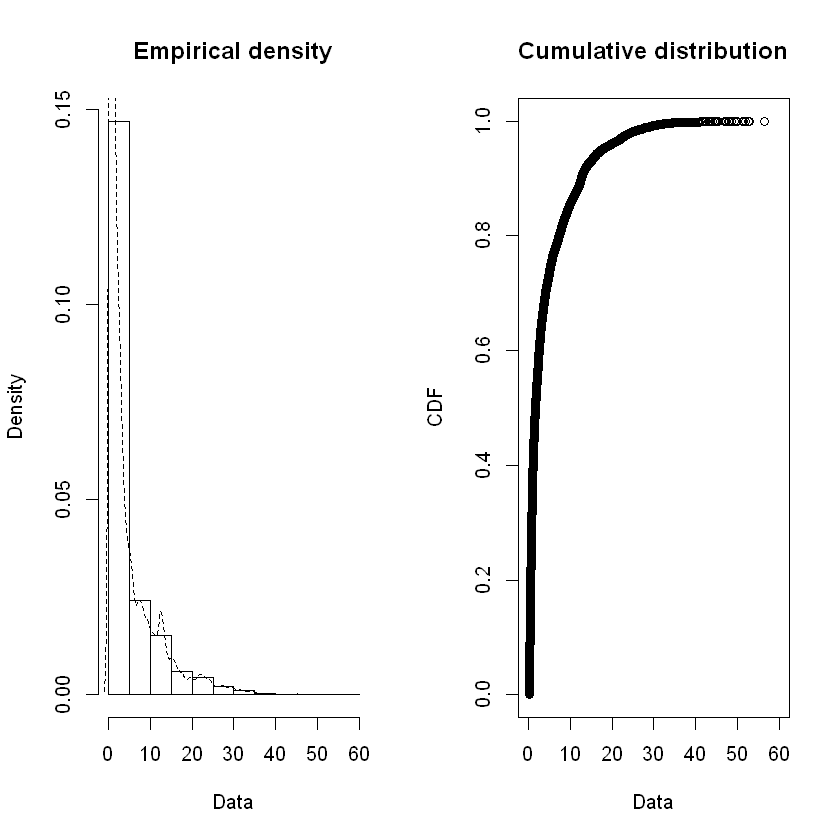

In [119]:
plotdist( dfJan$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  56.44 
median:  1.69 
mean:  4.417935 
estimated sd:  6.19835 
estimated skewness:  2.472786 
estimated kurtosis:  10.4299 

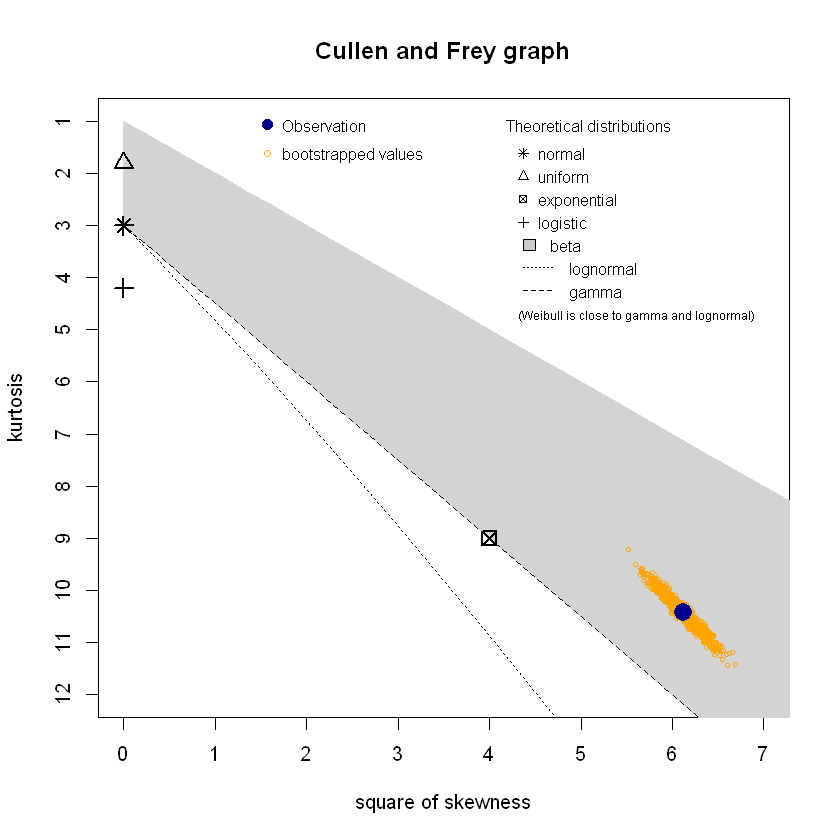

In [120]:
descdist( dfJan$Precip_mm, boot=1000 )

In [121]:
fd_GM_JanA <- fitdist( dfJan$Precip_mm, "gamma" )

In [122]:
summary( fd_GM_JanA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7399052 0.005032927
rate  0.1674729 0.001578886
Loglikelihood:  -77755.02   AIC:  155514   BIC:  155530.8 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7214603
rate  0.7214603 1.0000000


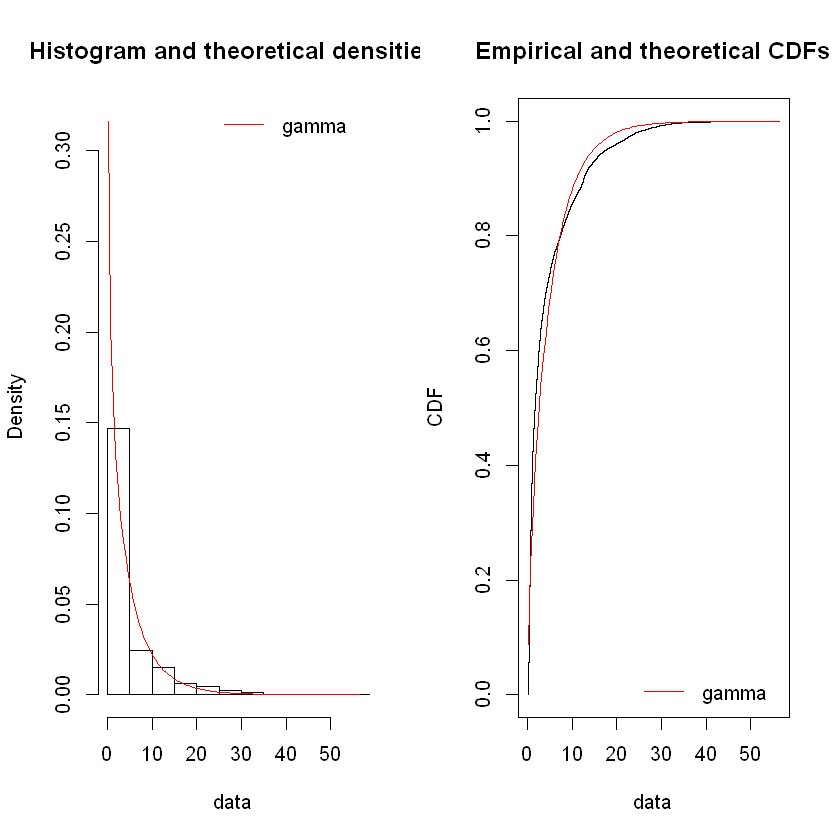

In [123]:
par(mfrow = c(1, 2))
denscomp(fd_GM_JanA)
#qqcomp(fd_GM_JanA)
cdfcomp(fd_GM_JanA)
#ppcomp(fd_GM_JanA)

In [124]:
fdGM_JanA_shape <- fd_GM_JanA$estimate[["shape"]]
fdGM_JanA_rate <- fd_GM_JanA$estimate[["rate"]]
fdGM_JanA_llike <- fd_GM_JanA$loglik
fdGM_JanA_mean <- fdGM_JanA_shape / fdGM_JanA_rate
fdGM_JanA_var <- fdGM_JanA_shape / ( fdGM_JanA_rate ^ 2 )
cat(" Jan A shape: ", fdGM_JanA_shape, "\n", "Jan A rate: ", fdGM_JanA_rate, 
    "\n", "Jan A loglikelihood: ", fdGM_JanA_llike, "\n", 
    "Jan A mean: ", fdGM_JanA_mean, "\n",
    "Jan A variance: ", fdGM_JanA_var, "\n" )

 Jan A shape:  0.7399052 
 Jan A rate:  0.1674729 
 Jan A loglikelihood:  -77755.02 
 Jan A mean:  4.41806 
 Jan A variance:  26.38075 


In [125]:
statRes <- gofstat( fd_GM_JanA, fitnames=c("Gamma") )

In [126]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic   0.121169
Cramer-von Mises statistic   168.473189
Anderson-Darling statistic   930.781496

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 155514.0
Bayesian Information Criterion 155530.8


In [127]:
ksRes <- ks.test( dfJan$Precip_mm, "pgamma", shape=fdGM_JanA_shape, rate=fdGM_JanA_rate )

Warning message in ks.test(dfJan$Precip_mm, "pgamma", shape = fdGM_JanA_shape, rate = fdGM_JanA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [128]:
fdGM_JanA_KSStat <- ksRes$statistic
fdGM_JanA_KSp <- ksRes$p.value
cat(" Jan A K-S stat: ", fdGM_JanA_KSStat, "\n",
    "Jan A K-S p-value: ", fdGM_JanA_KSp )

 Jan A K-S stat:  0.121169 
 Jan A K-S p-value:  0

**Mixed Exponential**

In [129]:
fd_ME_JanA <- expRMM_EM( dfJan$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfJan$Precip_mm), 1.0/mean(dfJan$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 89 


In [130]:
summary( fd_ME_JanA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.539371 0.460629
rate   0.771080 0.123877
loglik at estimate:  -75061.62 
0 % of the data right censored


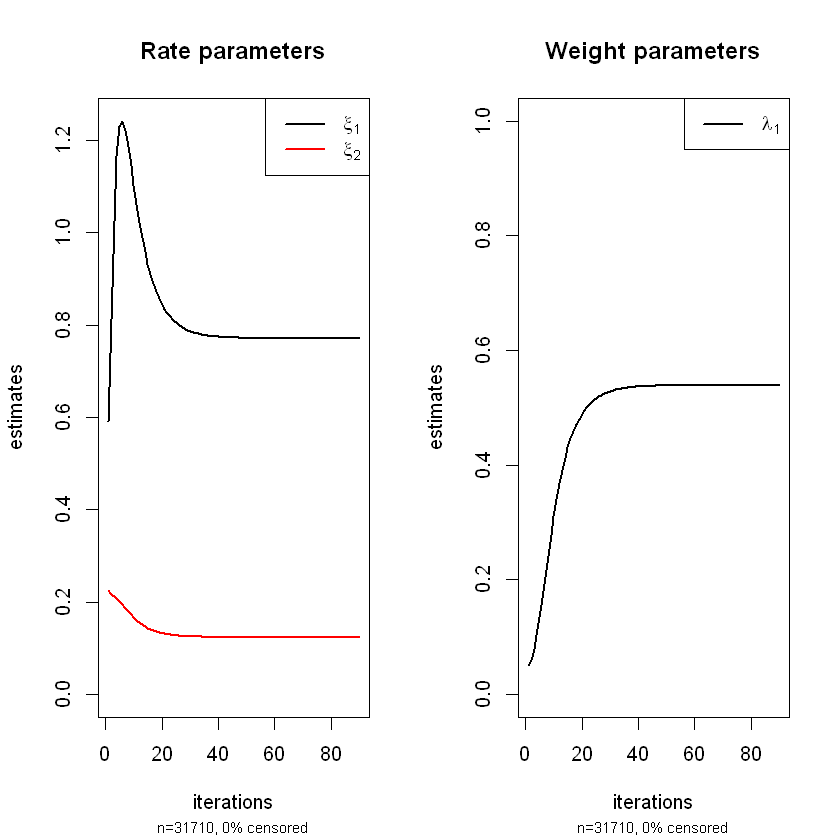

In [131]:
plotexpRMM( fd_ME_JanA, lwd=2 )

In [132]:
fdME_JanA_rate1 <- fd_ME_JanA$rate[[1]]
fdME_JanA_rate2 <- fd_ME_JanA$rate[[2]]
fdME_JanA_lambda <- fd_ME_JanA$lambda[[1]]
fdME_JanA_mean1 <- 1.0 / fdME_JanA_rate1
fdME_JanA_mean2 <- 1.0 / fdME_JanA_rate2
fdME_JanA_mean <- ( (fdME_JanA_lambda * fdME_JanA_mean1) + 
                    ( ( 1.0 - fdME_JanA_lambda) * fdME_JanA_mean2 ) )
fdME_JanA_var1 <- 1.0 / (fdME_JanA_rate1 ^ 2)
fdME_JanA_var2 <- 1.0 / (fdME_JanA_rate2 ^ 2)
fdME_JanA_var <- ( (fdME_JanA_lambda * ( fdME_JanA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_JanA_lambda) * (fdME_JanA_mean2 ^ 2) ) + 
                   ( fdME_JanA_lambda * ( 1.0 - fdME_JanA_lambda) * 
                       ( fdME_JanA_mean1 - fdME_JanA_mean2 )^2 ) )
fdME_JanA_llike <- fd_ME_JanA$loglik
cat(" Jan A rate1: ", fdME_JanA_rate1, "\n", 
    "Jan A rate2: ", fdME_JanA_rate2, "\n",
    "Jan A lambda: ", fdME_JanA_lambda, "\n",
    "Jan A mean1: ", fdME_JanA_mean1, "\n",
    "Jan A mean2: ", fdME_JanA_mean2, "\n",
    "Jan A mean: ", fdME_JanA_mean, "\n",
    "Jan A var1: ", fdME_JanA_var1, "\n",
    "Jan A var2: ", fdME_JanA_var2, "\n",
    "Jan A var: ", fdME_JanA_var, "\n",
    "Jan A loglikelihood: ", fdME_JanA_llike, "\n" )

 Jan A rate1:  0.7710805 
 Jan A rate2:  0.1238771 
 Jan A lambda:  0.5393712 
 Jan A mean1:  1.296882 
 Jan A mean2:  8.07252 
 Jan A mean:  4.417935 
 Jan A var1:  1.681902 
 Jan A var2:  65.16557 
 Jan A var:  42.33046 
 Jan A loglikelihood:  -75061.62 


In [133]:
tvals <- rexpmix( length(dfJan$Precip_mm), fd_ME_JanA$lambda, fd_ME_JanA$rate )

In [134]:
ksRes <- ks.test( dfJan$Precip_mm, tvals )

Warning message in ks.test(dfJan$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [135]:
fdME_JanA_KSStat <- ksRes$statistic
fdME_JanA_KSp <- ksRes$p.value
cat(" Jan A K-S stat: ", fdME_JanA_KSStat, "\n",
    "Jan A K-S p-value: ", fdME_JanA_KSp )

 Jan A K-S stat:  0.09709871 
 Jan A K-S p-value:  0

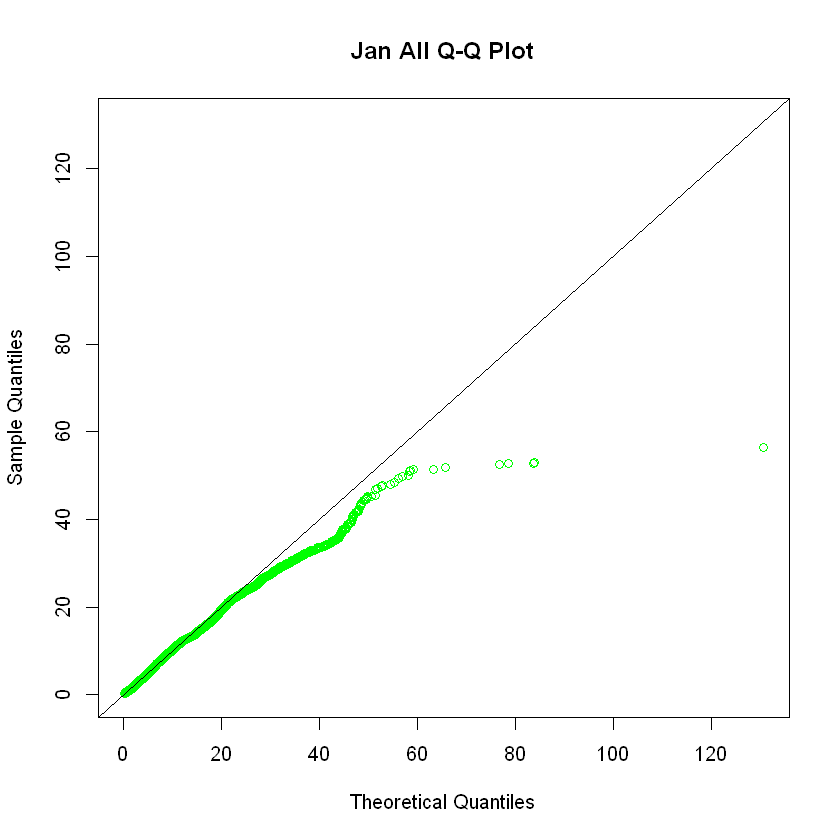

In [136]:
wJanAMax <- max( max( dfJan$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJan$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jan All Q-Q Plot",
        xlim=c(0,wJanAMax), ylim=c(0,wJanAMax) )
abline( 0, 1)

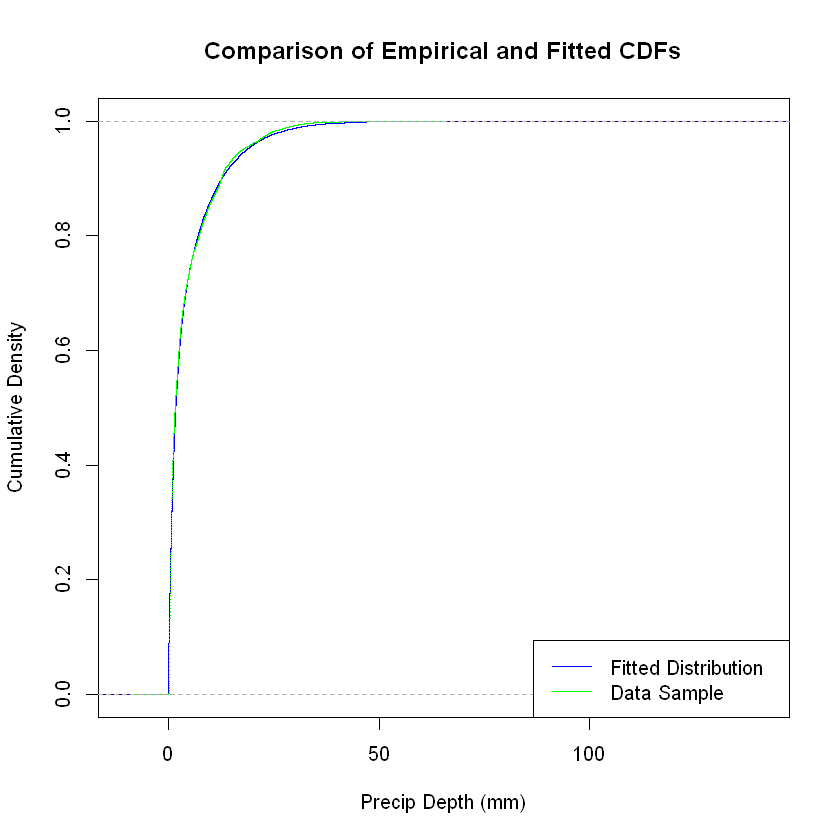

In [137]:
x <- seq(0,wJanAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJan$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

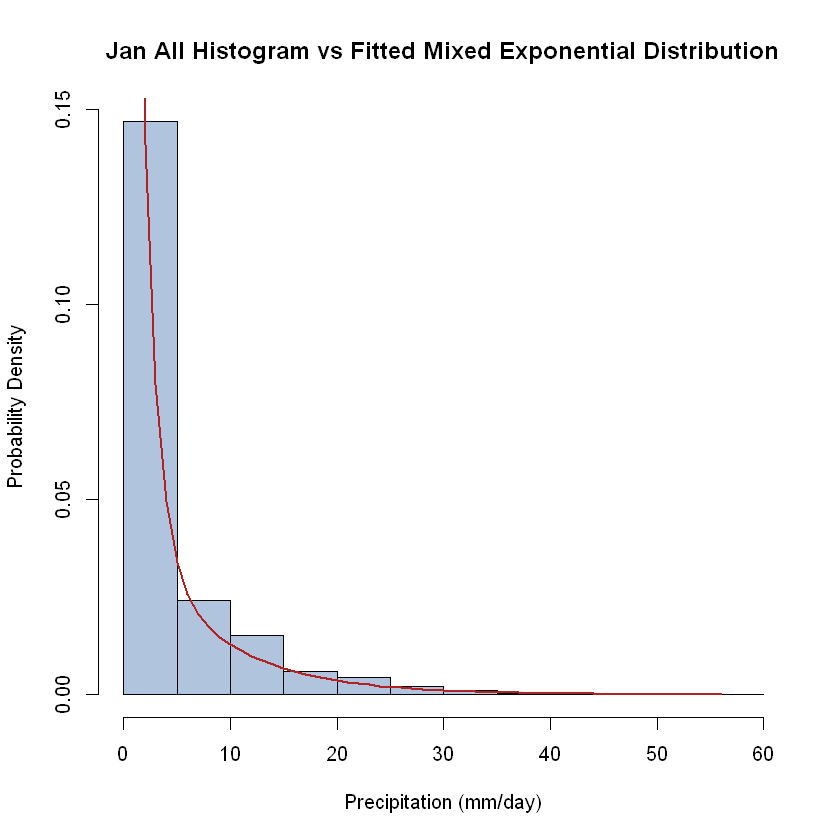

In [138]:
maxP <- max(dfJan$Precip_mm)
xVals <- seq(1, maxP, 1)
pdVals <- dmixt( xVals, phi=fdME_JanA_lambda, spec1="exp", arg1=list(rate=fdME_JanA_rate1),
                 spec2="exp", arg2=list(rate=fdME_JanA_rate2) )
hist( dfJan$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jan All Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Assign values to our tracking DataFrame

In [139]:
MonDistDF[1, ] <- list( 1, 0, fdGM_JanA_shape, fdGM_JanA_rate, fdGM_JanA_llike, fdGM_JanA_mean,
                        fdGM_JanA_var, fdGM_JanA_KSStat, fdGM_JanA_KSp, fdME_JanA_rate1,
                        fdME_JanA_rate2, fdME_JanA_lambda, fdME_JanA_mean1, fdME_JanA_mean2,
                        fdME_JanA_mean, fdME_JanA_var1, fdME_JanA_var2, fdME_JanA_var,
                        fdME_JanA_llike, fdME_JanA_KSStat, fdME_JanA_KSp )

#### Region 1

**Gamma**

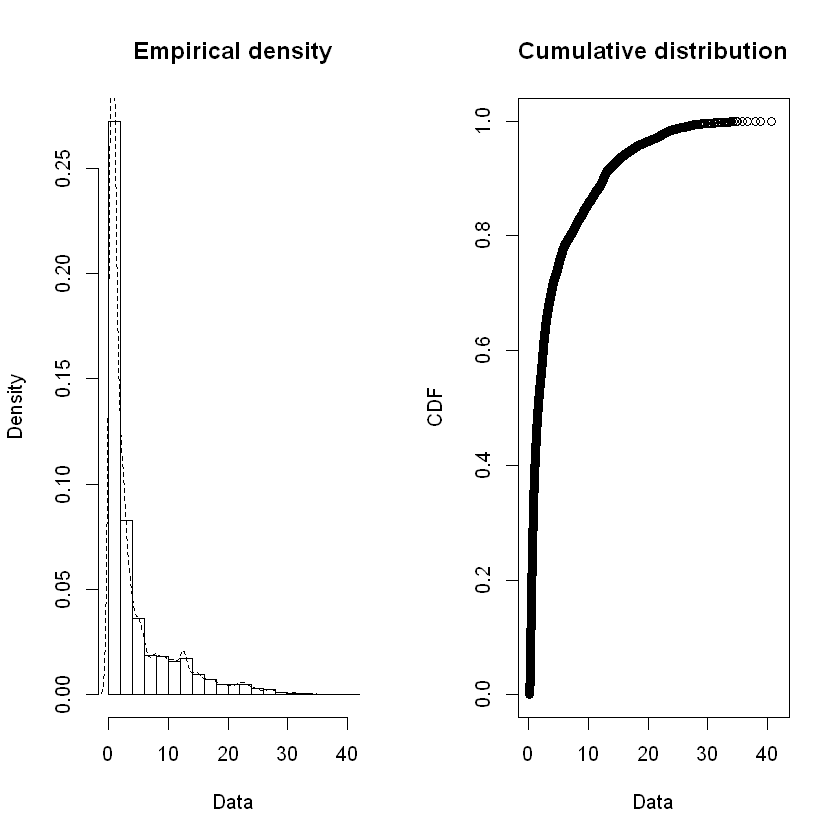

In [140]:
plotdist( dfJan1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  40.59 
median:  1.62 
mean:  4.236754 
estimated sd:  5.819208 
estimated skewness:  2.200357 
estimated kurtosis:  7.982727 

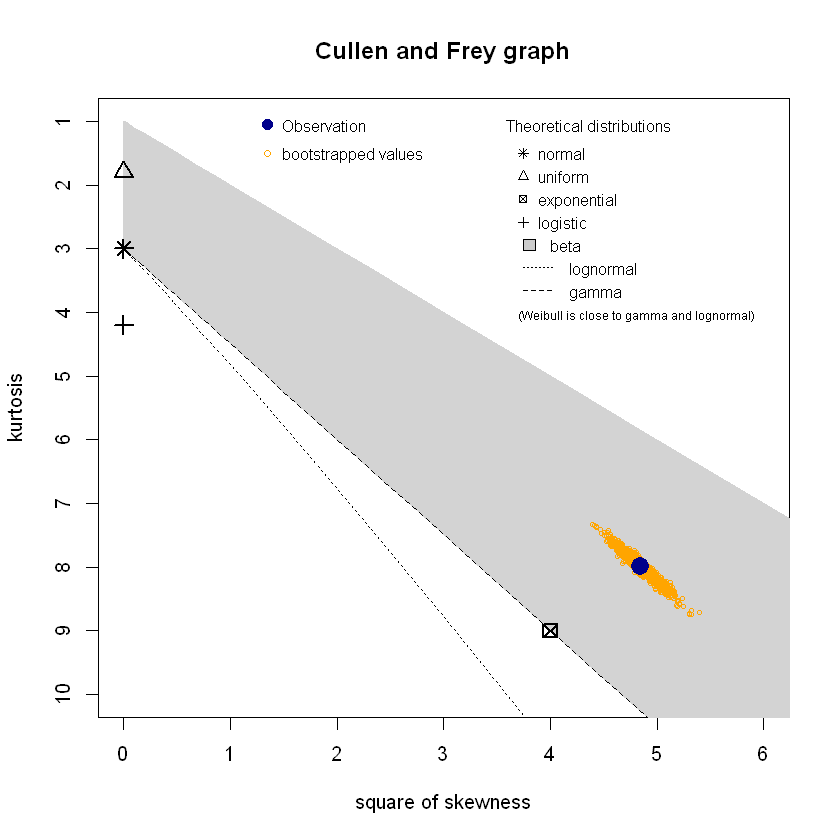

In [141]:
descdist( dfJan1$Precip_mm, boot=1000 )

In [142]:
fd_GM_Jan1 <- fitdist( dfJan1$Precip_mm, "gamma" )

In [143]:
summary( fd_GM_Jan1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7537791 0.008023051
rate  0.1778692 0.002610213
Loglikelihood:  -31377.18   AIC:  62758.36   BIC:  62773.31 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7252661
rate  0.7252661 1.0000000


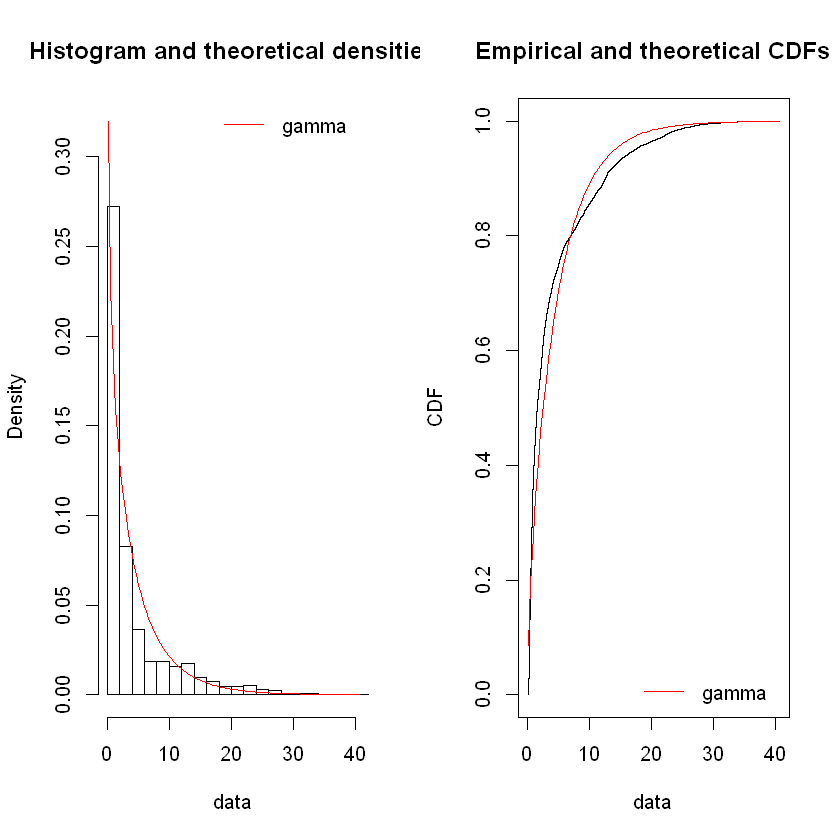

In [144]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Jan1)
#qqcomp(fd_GM_Jan1)
cdfcomp(fd_GM_Jan1)
#ppcomp(fd_GM_Jan1)

In [145]:
fdGM_Jan1_shape <- fd_GM_Jan1$estimate[["shape"]]
fdGM_Jan1_rate <- fd_GM_Jan1$estimate[["rate"]]
fdGM_Jan1_llike <- fd_GM_Jan1$loglik
fdGM_Jan1_mean <- fdGM_Jan1_shape / fdGM_Jan1_rate
fdGM_Jan1_var <- fdGM_Jan1_shape / ( fdGM_Jan1_rate ^ 2 )
cat(" Jan 1 shape: ", fdGM_Jan1_shape, "\n", "Jan 1 rate: ", fdGM_Jan1_rate, 
    "\n", "Jan 1 loglikelihood: ", fdGM_Jan1_llike, "\n", 
    "Jan 1 mean: ", fdGM_Jan1_mean, "\n",
    "Jan 1 variance: ", fdGM_Jan1_var, "\n" )

 Jan 1 shape:  0.7537791 
 Jan 1 rate:  0.1778692 
 Jan 1 loglikelihood:  -31377.18 
 Jan 1 mean:  4.237829 
 Jan 1 variance:  23.82554 


In [146]:
statRes <- gofstat( fd_GM_Jan1, fitnames=c("Gamma") )

In [147]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1237165
Cramer-von Mises statistic    74.8946592
Anderson-Darling statistic   413.6435766

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 62758.36
Bayesian Information Criterion 62773.31


In [148]:
ksRes <- ks.test( dfJan1$Precip_mm, "pgamma", shape=fdGM_Jan1_shape, rate=fdGM_Jan1_rate )

Warning message in ks.test(dfJan1$Precip_mm, "pgamma", shape = fdGM_Jan1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [149]:
fdGM_Jan1_KSStat <- ksRes$statistic
fdGM_Jan1_KSp <- ksRes$p.value
cat(" Jan 1 K-S stat: ", fdGM_Jan1_KSStat, "\n",
    "Jan 1 K-S p-value: ", fdGM_Jan1_KSp )

 Jan 1 K-S stat:  0.1237165 
 Jan 1 K-S p-value:  0

**Mixed exponential**

In [150]:
fd_ME_Jan1 <- expRMM_EM( dfJan1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJan1$Precip_mm), 1.0/mean(dfJan1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 84 


In [151]:
summary( fd_ME_Jan1 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.558039 0.441961
rate   0.762664 0.126092
loglik at estimate:  -30239.9 
0 % of the data right censored


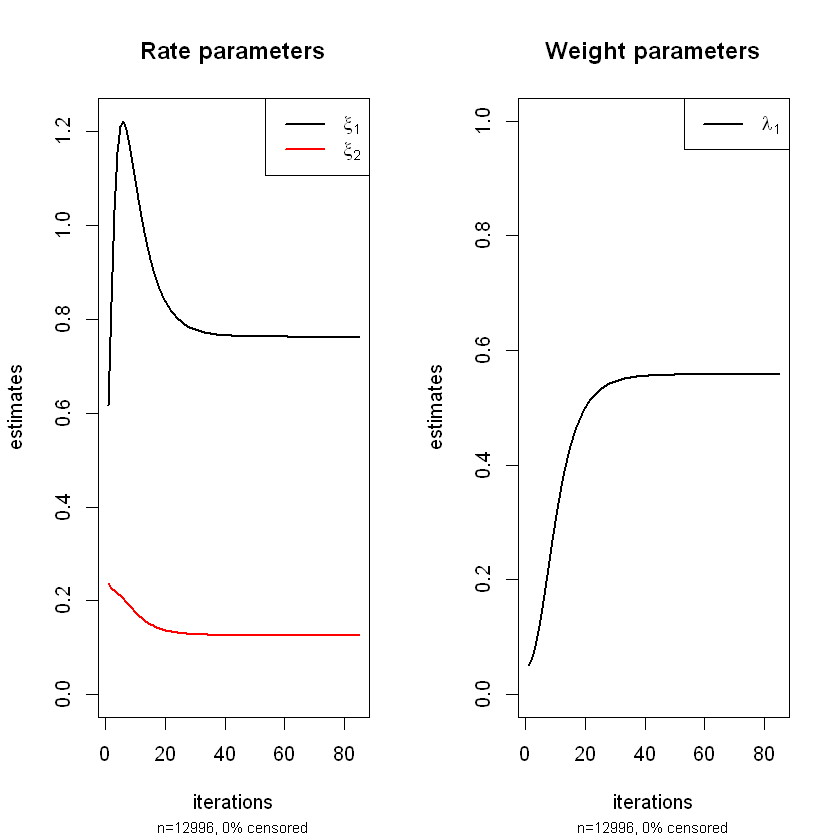

In [152]:
plotexpRMM( fd_ME_Jan1, lwd=2 )

In [153]:
fdME_Jan1_rate1 <- fd_ME_Jan1$rate[[1]]
fdME_Jan1_rate2 <- fd_ME_Jan1$rate[[2]]
fdME_Jan1_lambda <- fd_ME_Jan1$lambda[[1]]
fdME_Jan1_mean1 <- 1.0 / fdME_Jan1_rate1
fdME_Jan1_mean2 <- 1.0 / fdME_Jan1_rate2
fdME_Jan1_mean <- ( (fdME_Jan1_lambda * fdME_Jan1_mean1) + 
                    ( ( 1.0 - fdME_Jan1_lambda) * fdME_Jan1_mean2 ) )
fdME_Jan1_var1 <- 1.0 / (fdME_Jan1_rate1 ^ 2)
fdME_Jan1_var2 <- 1.0 / (fdME_Jan1_rate2 ^ 2)
fdME_Jan1_var <- ( (fdME_Jan1_lambda * ( fdME_Jan1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jan1_lambda) * (fdME_Jan1_mean2 ^ 2) ) + 
                   ( fdME_Jan1_lambda * ( 1.0 - fdME_Jan1_lambda) * 
                       ( fdME_Jan1_mean1 - fdME_Jan1_mean2 )^2 ) )
fdME_Jan1_llike <- fd_ME_Jan1$loglik
cat(" Jan 1 rate1: ", fdME_Jan1_rate1, "\n", 
    "Jan 1 rate2: ", fdME_Jan1_rate2, "\n",
    "Jan 1 lambda: ", fdME_Jan1_lambda, "\n",
    "Jan 1 mean1: ", fdME_Jan1_mean1, "\n",
    "Jan 1 mean2: ", fdME_Jan1_mean2, "\n",
    "Jan 1 mean: ", fdME_Jan1_mean, "\n",
    "Jan 1 var1: ", fdME_Jan1_var1, "\n",
    "Jan 1 var2: ", fdME_Jan1_var2, "\n",
    "Jan 1 var: ", fdME_Jan1_var, "\n",
    "Jan 1 loglikelihood: ", fdME_Jan1_llike, "\n" )

 Jan 1 rate1:  0.7626636 
 Jan 1 rate2:  0.1260923 
 Jan 1 lambda:  0.5580395 
 Jan 1 mean1:  1.311194 
 Jan 1 mean2:  7.930698 
 Jan 1 mean:  4.236754 
 Jan 1 var1:  1.71923 
 Jan 1 var2:  62.89598 
 Jan 1 var:  39.56379 
 Jan 1 loglikelihood:  -30239.9 


In [154]:
tvals <- rexpmix(length(dfJan1$Precip_mm), fd_ME_Jan1$lambda, fd_ME_Jan1$rate )

In [155]:
ksRes <- ks.test( dfJan1$Precip_mm, tvals )

Warning message in ks.test(dfJan1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [156]:
fdME_Jan1_KSStat <- ksRes$statistic
fdME_Jan1_KSp <- ksRes$p.value
cat(" Jan 1 K-S stat: ", fdME_Jan1_KSStat, "\n",
    "Jan 1 K-S p-value: ", fdME_Jan1_KSp )

 Jan 1 K-S stat:  0.1006464 
 Jan 1 K-S p-value:  0

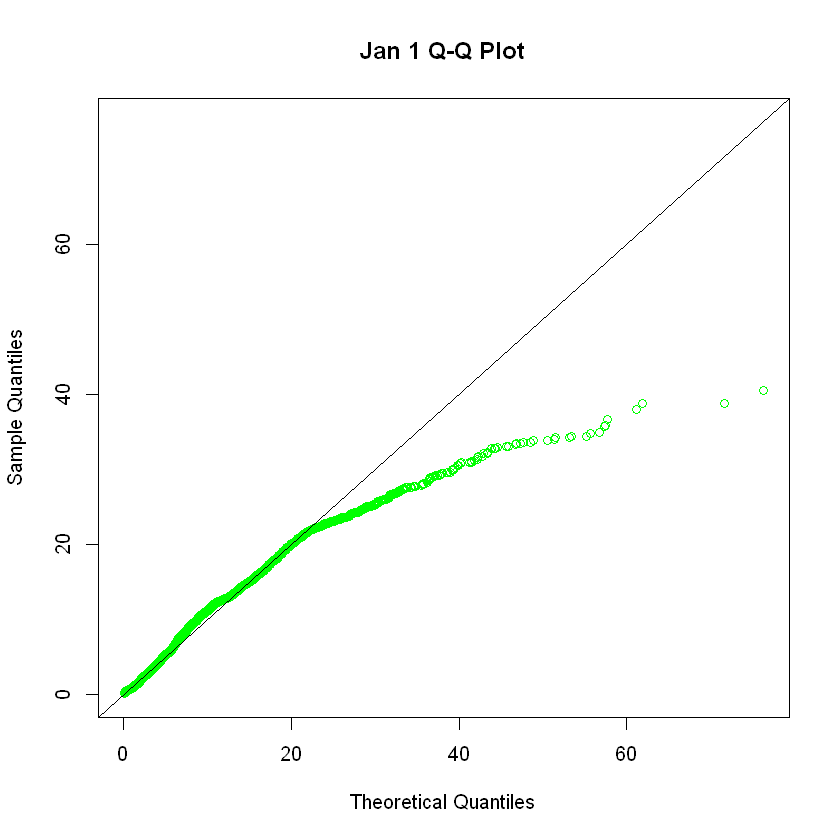

In [157]:
wJan1Max <- max( max( dfJan1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJan1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jan 1 Q-Q Plot",
        xlim=c(0,wJan1Max), ylim=c(0,wJan1Max) )
abline( 0, 1)

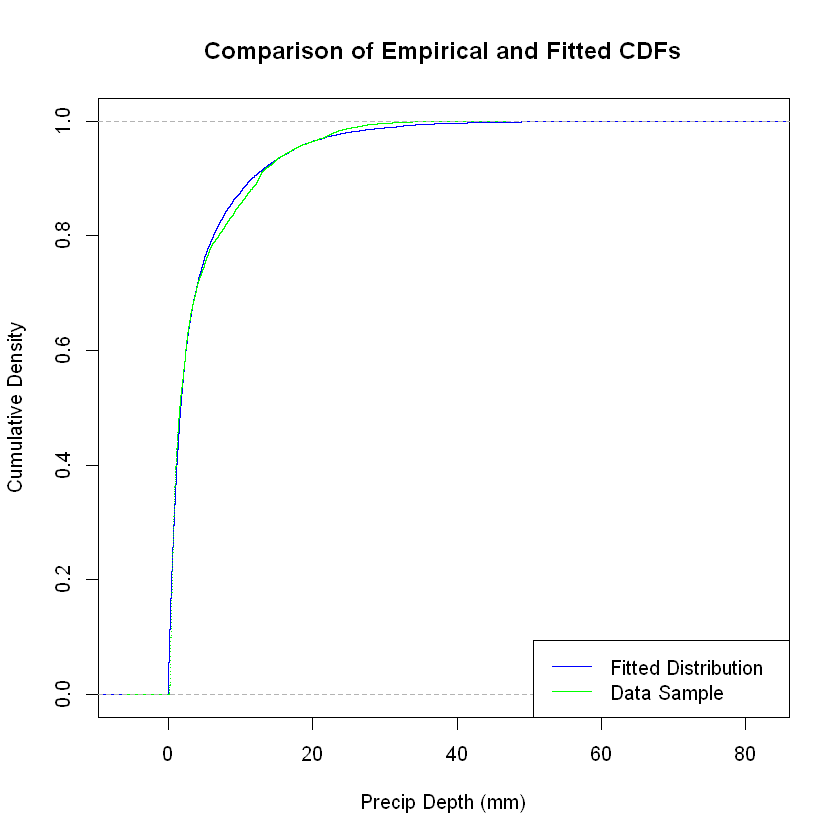

In [158]:
x <- seq(0,wJan1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJan1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [159]:
MonDistDF[2, ] <- list( 1, 1, fdGM_Jan1_shape, fdGM_Jan1_rate, fdGM_Jan1_llike, fdGM_Jan1_mean,
                        fdGM_Jan1_var, fdGM_Jan1_KSStat, fdGM_Jan1_KSp, fdME_Jan1_rate1,
                        fdME_Jan1_rate2, fdME_Jan1_lambda, fdME_Jan1_mean1, fdME_Jan1_mean2,
                        fdME_Jan1_mean, fdME_Jan1_var1, fdME_Jan1_var2, fdME_Jan1_var,
                        fdME_Jan1_llike, fdME_Jan1_KSStat, fdME_Jan1_KSp )

#### Region 2

**Gamma**

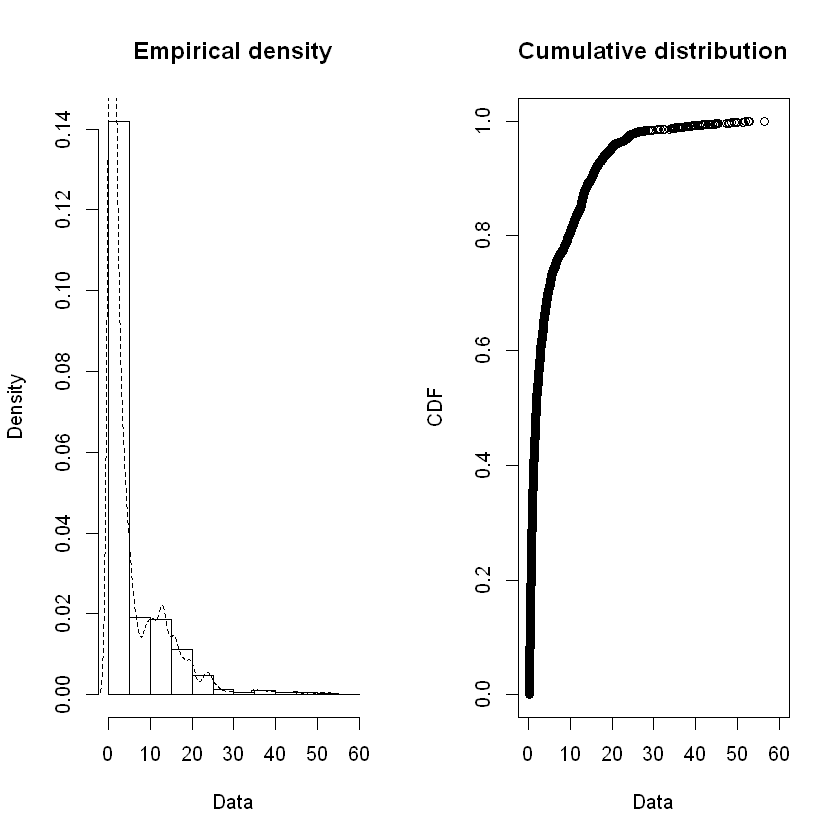

In [160]:
plotdist( dfJan2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  56.44 
median:  1.88 
mean:  5.214287 
estimated sd:  7.412119 
estimated skewness:  2.630716 
estimated kurtosis:  12.1173 

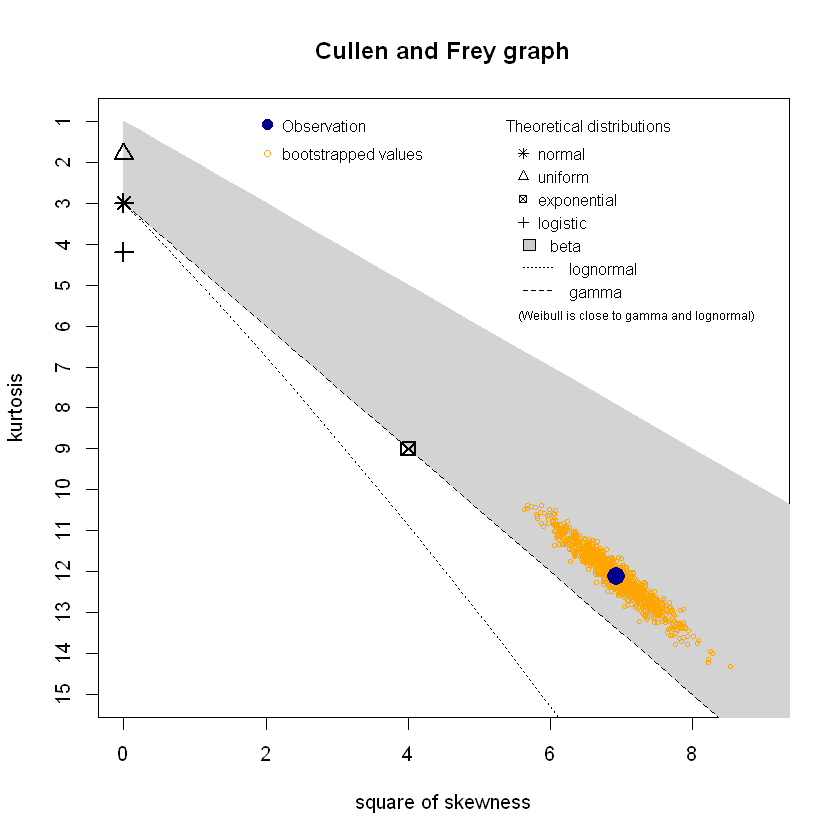

In [161]:
descdist( dfJan2$Precip_mm, boot=1000 )

In [162]:
fd_GM_Jan2 <- fitdist( dfJan2$Precip_mm, "gamma" )

In [163]:
summary( fd_GM_Jan2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7082979 0.012468283
rate  0.1358309 0.003355957
Loglikelihood:  -12239.63   AIC:  24483.25   BIC:  24496.16 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7124163
rate  0.7124163 1.0000000


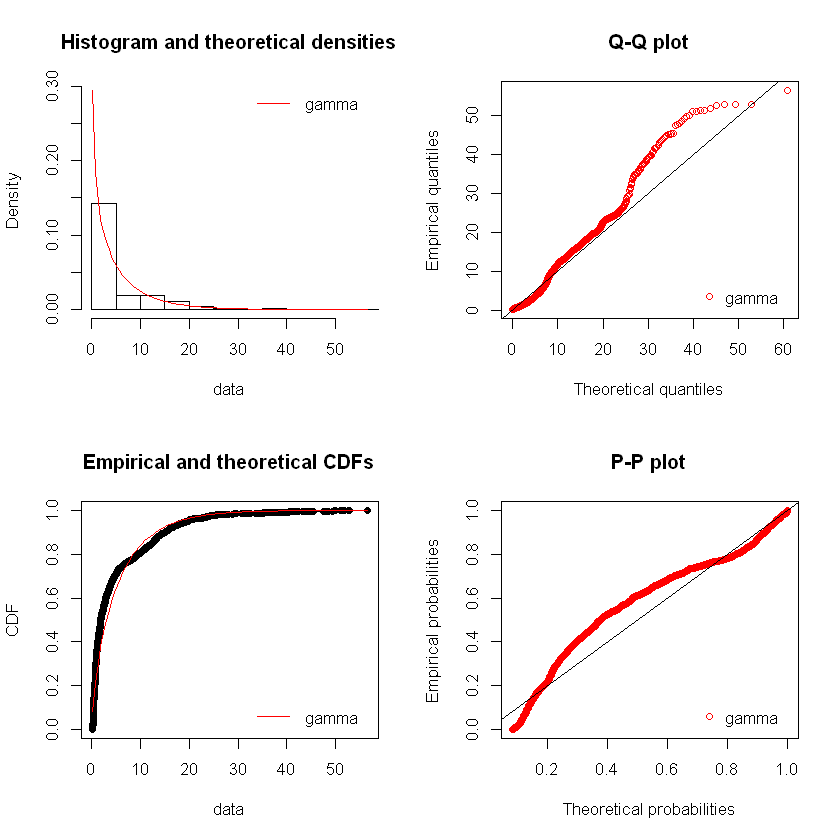

In [164]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jan2)
qqcomp(fd_GM_Jan2)
cdfcomp(fd_GM_Jan2)
ppcomp(fd_GM_Jan2)

In [165]:
fdGM_Jan2_shape <- fd_GM_Jan2$estimate[["shape"]]
fdGM_Jan2_rate <- fd_GM_Jan2$estimate[["rate"]]
fdGM_Jan2_llike <- fd_GM_Jan2$loglik
fdGM_Jan2_mean <- fdGM_Jan2_shape / fdGM_Jan2_rate
fdGM_Jan2_var <- fdGM_Jan2_shape / ( fdGM_Jan2_rate ^ 2 )
cat(" Jan 2 shape: ", fdGM_Jan2_shape, "\n", "Jan 2 rate: ", fdGM_Jan2_rate, 
    "\n", "Jan 2 loglikelihood: ", fdGM_Jan2_llike, "\n", 
    "Jan 2 mean: ", fdGM_Jan2_mean, "\n",
    "Jan 2 variance: ", fdGM_Jan2_var, "\n" )

 Jan 2 shape:  0.7082979 
 Jan 2 rate:  0.1358309 
 Jan 2 loglikelihood:  -12239.63 
 Jan 2 mean:  5.214555 
 Jan 2 variance:  38.39003 


In [166]:
statRes <- gofstat( fd_GM_Jan2, fitnames=c("Gamma") )

In [167]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1279981
Cramer-von Mises statistic    24.8804023
Anderson-Darling statistic   134.4499121

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 24483.25
Bayesian Information Criterion 24496.16


In [168]:
ksRes <- ks.test( dfJan2$Precip_mm, "pgamma", shape=fdGM_Jan2_shape, rate=fdGM_Jan2_rate )

Warning message in ks.test(dfJan2$Precip_mm, "pgamma", shape = fdGM_Jan2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [169]:
fdGM_Jan2_KSStat <- ksRes$statistic
fdGM_Jan2_KSp <- ksRes$p.value
cat(" Jan 2 K-S stat: ", fdGM_Jan2_KSStat, "\n",
    "Jan 2 K-S p-value: ", fdGM_Jan2_KSp )

 Jan 2 K-S stat:  0.1279981 
 Jan 2 K-S p-value:  0

**Mixed exponential**

In [170]:
fd_ME_Jan2 <- expRMM_EM( dfJan2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJan2$Precip_mm), 1.0/mean(dfJan2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 68 


In [171]:
summary( fd_ME_Jan2 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.531491 0.468509
rate   0.725704 0.104533
loglik at estimate:  -11810.62 
0 % of the data right censored


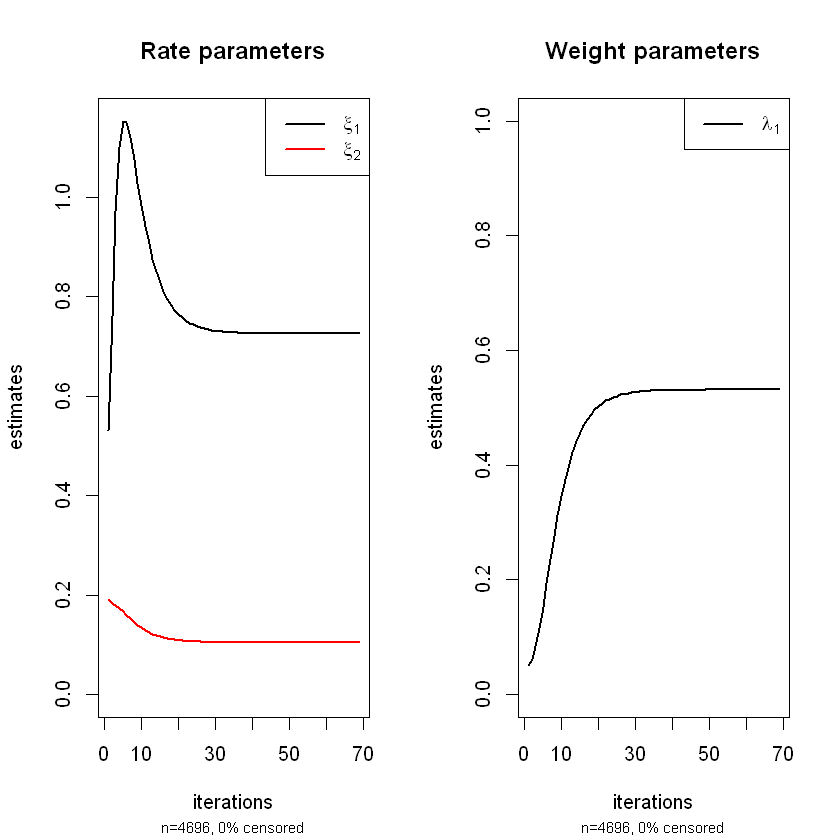

In [172]:
plotexpRMM( fd_ME_Jan2, lwd=2 )

In [173]:
fdME_Jan2_rate1 <- fd_ME_Jan2$rate[[1]]
fdME_Jan2_rate2 <- fd_ME_Jan2$rate[[2]]
fdME_Jan2_lambda <- fd_ME_Jan2$lambda[[1]]
fdME_Jan2_mean1 <- 1.0 / fdME_Jan2_rate1
fdME_Jan2_mean2 <- 1.0 / fdME_Jan2_rate2
fdME_Jan2_mean <- ( (fdME_Jan2_lambda * fdME_Jan2_mean1) + 
                    ( ( 1.0 - fdME_Jan2_lambda) * fdME_Jan2_mean2 ) )
fdME_Jan2_var1 <- 1.0 / (fdME_Jan2_rate1 ^ 2)
fdME_Jan2_var2 <- 1.0 / (fdME_Jan2_rate2 ^ 2)
fdME_Jan2_var <- ( (fdME_Jan2_lambda * ( fdME_Jan2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jan2_lambda) * (fdME_Jan2_mean2 ^ 2) ) + 
                   ( fdME_Jan2_lambda * ( 1.0 - fdME_Jan2_lambda) * 
                       ( fdME_Jan2_mean1 - fdME_Jan2_mean2 )^2 ) )
fdME_Jan2_llike <- fd_ME_Jan2$loglik
cat(" Jan 2 rate1: ", fdME_Jan2_rate1, "\n", 
    "Jan 2 rate2: ", fdME_Jan2_rate2, "\n",
    "Jan 2 lambda: ", fdME_Jan2_lambda, "\n",
    "Jan 2 mean1: ", fdME_Jan2_mean1, "\n",
    "Jan 2 mean2: ", fdME_Jan2_mean2, "\n",
    "Jan 2 mean: ", fdME_Jan2_mean, "\n",
    "Jan 2 var1: ", fdME_Jan2_var1, "\n",
    "Jan 2 var2: ", fdME_Jan2_var2, "\n",
    "Jan 2 var: ", fdME_Jan2_var, "\n",
    "Jan 2 loglikelihood: ", fdME_Jan2_llike, "\n" )

 Jan 2 rate1:  0.7257043 
 Jan 2 rate2:  0.1045335 
 Jan 2 lambda:  0.5314905 
 Jan 2 mean1:  1.377972 
 Jan 2 mean2:  9.566312 
 Jan 2 mean:  5.214287 
 Jan 2 var1:  1.898806 
 Jan 2 var2:  91.51432 
 Jan 2 var:  60.58026 
 Jan 2 loglikelihood:  -11810.62 


In [174]:
tvals <- rexpmix(length(dfJan2$Precip_mm), fd_ME_Jan2$lambda, fd_ME_Jan2$rate )

In [175]:
ksRes <- ks.test( dfJan2$Precip_mm, tvals )

Warning message in ks.test(dfJan2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [176]:
fdME_Jan2_KSStat <- ksRes$statistic
fdME_Jan2_KSp <- ksRes$p.value
cat(" Jan 2 K-S stat: ", fdME_Jan2_KSStat, "\n",
    "Jan 2 K-S p-value: ", fdME_Jan2_KSp )

 Jan 2 K-S stat:  0.08560477 
 Jan 2 K-S p-value:  2.220446e-15

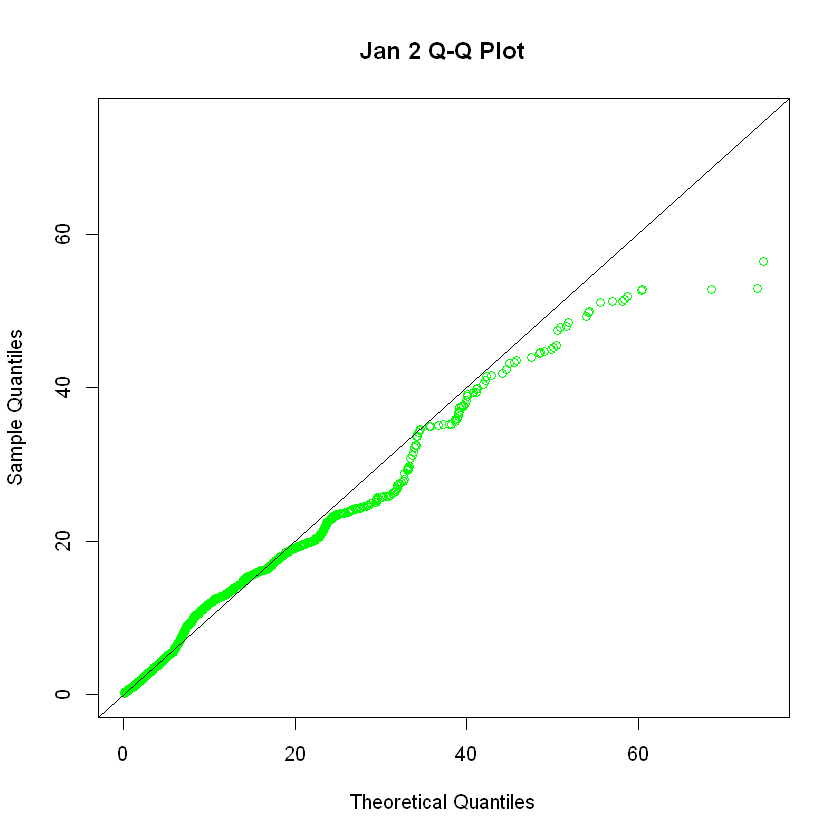

In [177]:
wJan2Max <- max( max( dfJan2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJan2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jan 2 Q-Q Plot",
        xlim=c(0,wJan2Max), ylim=c(0,wJan2Max) )
abline( 0, 1)

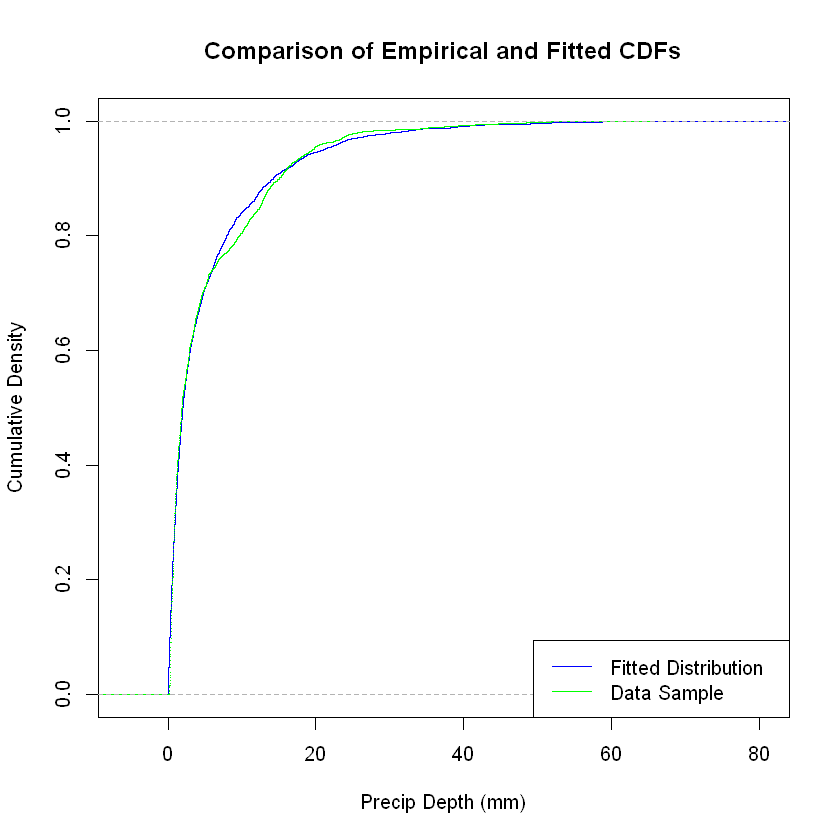

In [178]:
x <- seq(0,wJan2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJan2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [179]:
MonDistDF[3, ] <- list( 1, 2, fdGM_Jan2_shape, fdGM_Jan2_rate, fdGM_Jan2_llike, fdGM_Jan2_mean,
                        fdGM_Jan2_var, fdGM_Jan2_KSStat, fdGM_Jan2_KSp, fdME_Jan2_rate1,
                        fdME_Jan2_rate2, fdME_Jan2_lambda, fdME_Jan2_mean1, fdME_Jan2_mean2,
                        fdME_Jan2_mean, fdME_Jan2_var1, fdME_Jan2_var2, fdME_Jan2_var,
                        fdME_Jan2_llike, fdME_Jan2_KSStat, fdME_Jan2_KSp )

#### Region 3

**Gamma**

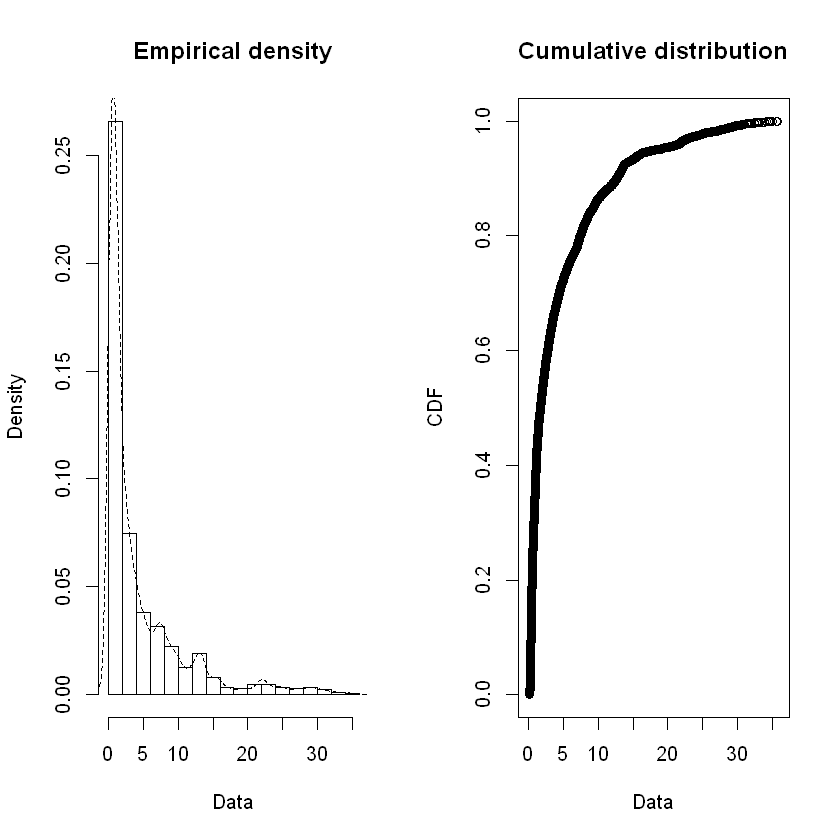

In [180]:
plotdist( dfJan3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  35.72 
median:  1.735 
mean:  4.466073 
estimated sd:  6.163072 
estimated skewness:  2.295984 
estimated kurtosis:  8.490683 

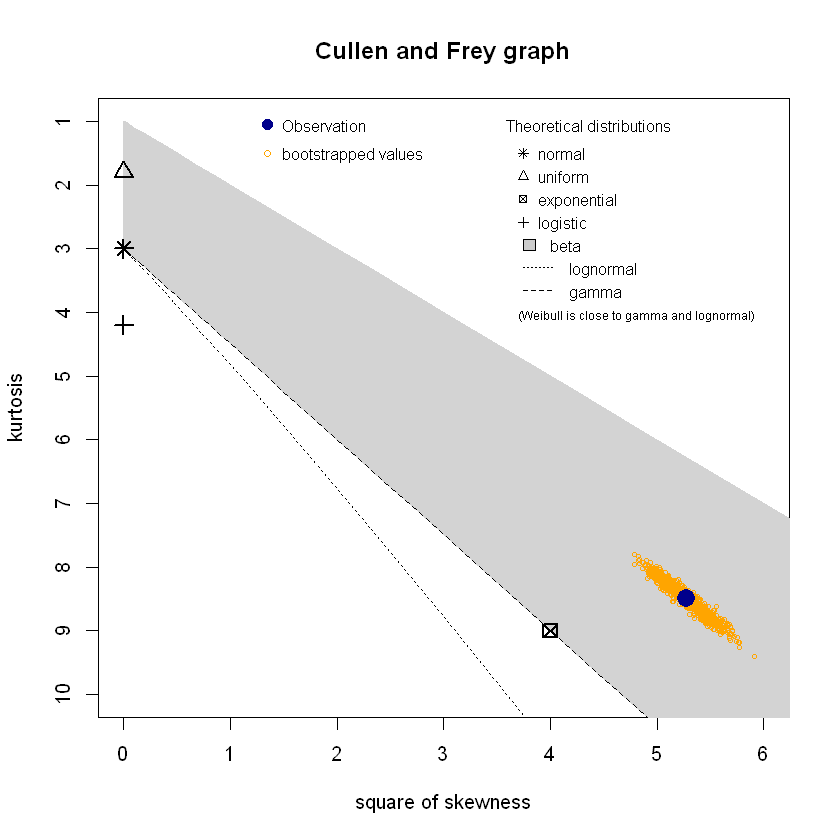

In [181]:
descdist( dfJan3$Precip_mm, boot=1000 )

In [182]:
fd_GM_Jan3 <- fitdist( dfJan3$Precip_mm, "gamma" )

In [183]:
summary( fd_GM_Jan3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7329868 0.010065994
rate  0.1640897 0.003131613
Loglikelihood:  -19108.73   AIC:  38221.46   BIC:  38235.38 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7195266
rate  0.7195266 1.0000000


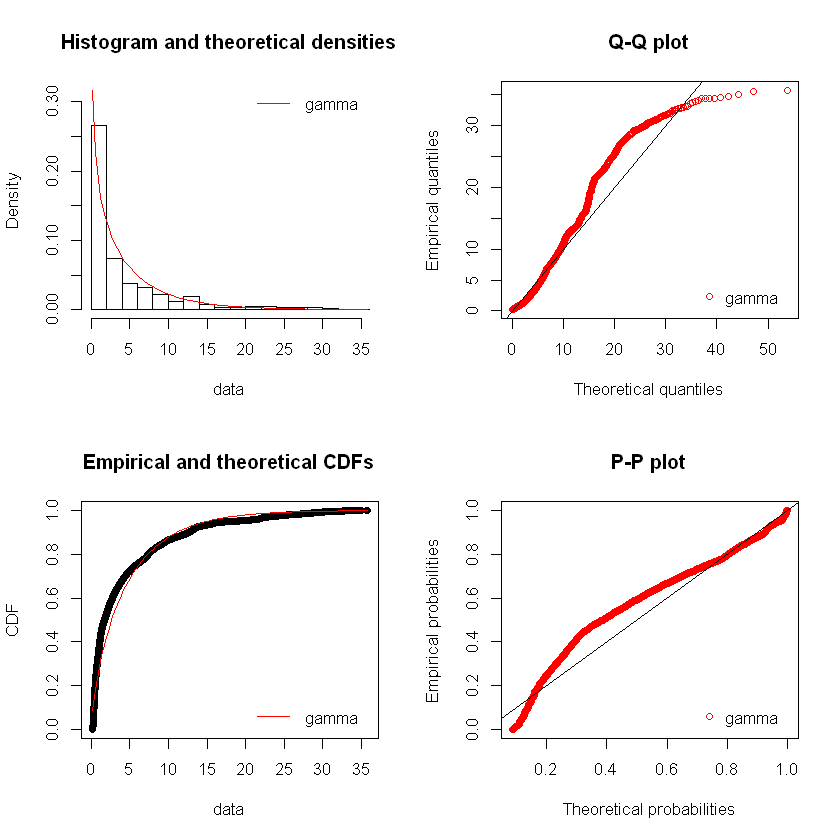

In [184]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jan3)
qqcomp(fd_GM_Jan3)
cdfcomp(fd_GM_Jan3)
ppcomp(fd_GM_Jan3)

In [185]:
fdGM_Jan3_shape <- fd_GM_Jan3$estimate[["shape"]]
fdGM_Jan3_rate <- fd_GM_Jan3$estimate[["rate"]]
fdGM_Jan3_llike <- fd_GM_Jan3$loglik
fdGM_Jan3_mean <- fdGM_Jan3_shape / fdGM_Jan3_rate
fdGM_Jan3_var <- fdGM_Jan3_shape / ( fdGM_Jan3_rate ^ 2 )
cat(" Jan 3 shape: ", fdGM_Jan3_shape, "\n", "Jan 3 rate: ", fdGM_Jan3_rate, 
    "\n", "Jan 3 loglikelihood: ", fdGM_Jan3_llike, "\n", 
    "Jan 3 mean: ", fdGM_Jan3_mean, "\n",
    "Jan 3 variance: ", fdGM_Jan3_var, "\n" )

 Jan 3 shape:  0.7329868 
 Jan 3 rate:  0.1640897 
 Jan 3 loglikelihood:  -19108.73 
 Jan 3 mean:  4.466989 
 Jan 3 variance:  27.22286 


In [186]:
statRes <- gofstat( fd_GM_Jan3, fitnames=c("Gamma") )

In [187]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic   0.122542
Cramer-von Mises statistic    35.950402
Anderson-Darling statistic   204.080439

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 38221.46
Bayesian Information Criterion 38235.38


In [188]:
ksRes <- ks.test( dfJan3$Precip_mm, "pgamma", shape=fdGM_Jan3_shape, rate=fdGM_Jan3_rate )

Warning message in ks.test(dfJan3$Precip_mm, "pgamma", shape = fdGM_Jan3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [189]:
fdGM_Jan3_KSStat <- ksRes$statistic
fdGM_Jan3_KSp <- ksRes$p.value
cat(" Jan 3 K-S stat: ", fdGM_Jan3_KSStat, "\n",
    "Jan 3 K-S p-value: ", fdGM_Jan3_KSp )

 Jan 3 K-S stat:  0.122542 
 Jan 3 K-S p-value:  0

**Mixed exponential**

In [190]:
fd_ME_Jan3 <- expRMM_EM( dfJan3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJan3$Precip_mm), 1.0/mean(dfJan3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 88 


In [191]:
summary( fd_ME_Jan3 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.497650 0.502350
rate   0.833757 0.129833
loglik at estimate:  -18509.42 
0 % of the data right censored


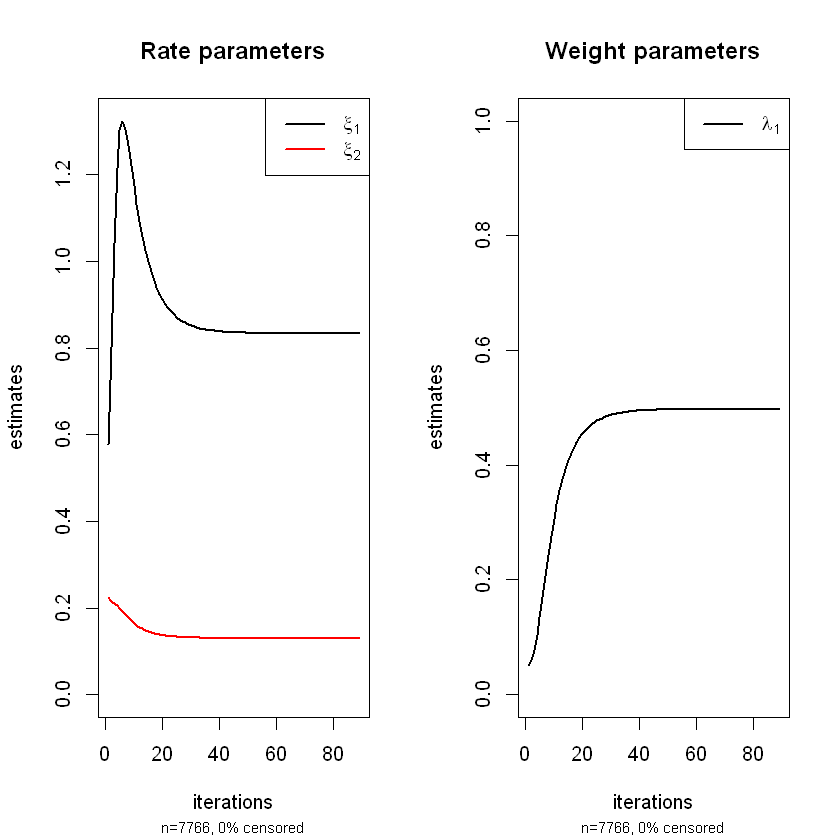

In [192]:
plotexpRMM( fd_ME_Jan3, lwd=2 )

In [193]:
fdME_Jan3_rate1 <- fd_ME_Jan3$rate[[1]]
fdME_Jan3_rate2 <- fd_ME_Jan3$rate[[2]]
fdME_Jan3_lambda <- fd_ME_Jan3$lambda[[1]]
fdME_Jan3_mean1 <- 1.0 / fdME_Jan3_rate1
fdME_Jan3_mean2 <- 1.0 / fdME_Jan3_rate2
fdME_Jan3_mean <- ( (fdME_Jan3_lambda * fdME_Jan3_mean1) + 
                    ( ( 1.0 - fdME_Jan3_lambda) * fdME_Jan3_mean2 ) )
fdME_Jan3_var1 <- 1.0 / (fdME_Jan3_rate1 ^ 2)
fdME_Jan3_var2 <- 1.0 / (fdME_Jan3_rate2 ^ 2)
fdME_Jan3_var <- ( (fdME_Jan3_lambda * ( fdME_Jan3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jan3_lambda) * (fdME_Jan3_mean2 ^ 2) ) + 
                   ( fdME_Jan3_lambda * ( 1.0 - fdME_Jan3_lambda) * 
                       ( fdME_Jan3_mean1 - fdME_Jan3_mean2 )^2 ) )
fdME_Jan3_llike <- fd_ME_Jan3$loglik
cat(" Jan 3 rate1: ", fdME_Jan3_rate1, "\n", 
    "Jan 3 rate2: ", fdME_Jan3_rate2, "\n",
    "Jan 3 lambda: ", fdME_Jan3_lambda, "\n",
    "Jan 3 mean1: ", fdME_Jan3_mean1, "\n",
    "Jan 3 mean2: ", fdME_Jan3_mean2, "\n",
    "Jan 3 mean: ", fdME_Jan3_mean, "\n",
    "Jan 3 var1: ", fdME_Jan3_var1, "\n",
    "Jan 3 var2: ", fdME_Jan3_var2, "\n",
    "Jan 3 var: ", fdME_Jan3_var, "\n",
    "Jan 3 loglikelihood: ", fdME_Jan3_llike, "\n" )

 Jan 3 rate1:  0.8337566 
 Jan 3 rate2:  0.1298333 
 Jan 3 lambda:  0.4976495 
 Jan 3 mean1:  1.199391 
 Jan 3 mean2:  7.702185 
 Jan 3 mean:  4.466073 
 Jan 3 var1:  1.438538 
 Jan 3 var2:  59.32365 
 Jan 3 var:  41.0885 
 Jan 3 loglikelihood:  -18509.42 


In [194]:
tvals <- rexpmix(length(dfJan3$Precip_mm), fd_ME_Jan3$lambda, fd_ME_Jan3$rate )

In [195]:
ksRes <- ks.test( dfJan3$Precip_mm, tvals )

Warning message in ks.test(dfJan3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [196]:
fdME_Jan3_KSStat <- ksRes$statistic
fdME_Jan3_KSp <- ksRes$p.value
cat(" Jan 3 K-S stat: ", fdME_Jan3_KSStat, "\n",
    "Jan 3 K-S p-value: ", fdME_Jan3_KSp )

 Jan 3 K-S stat:  0.09708988 
 Jan 3 K-S p-value:  0

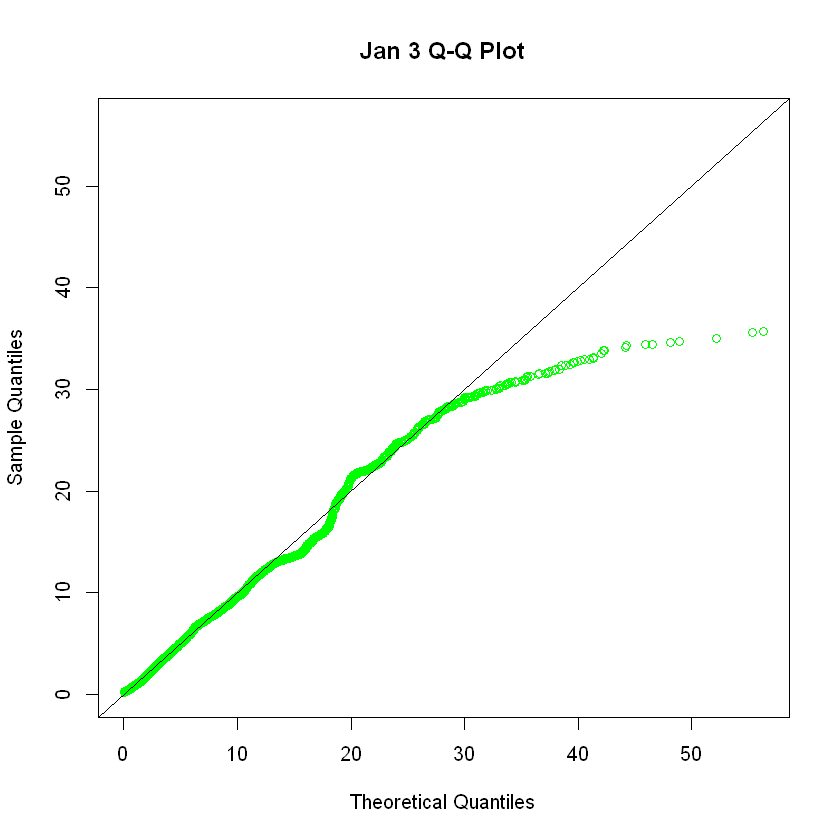

In [197]:
wJan3Max <- max( max( dfJan3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJan3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jan 3 Q-Q Plot",
        xlim=c(0,wJan3Max), ylim=c(0,wJan3Max) )
abline( 0, 1)

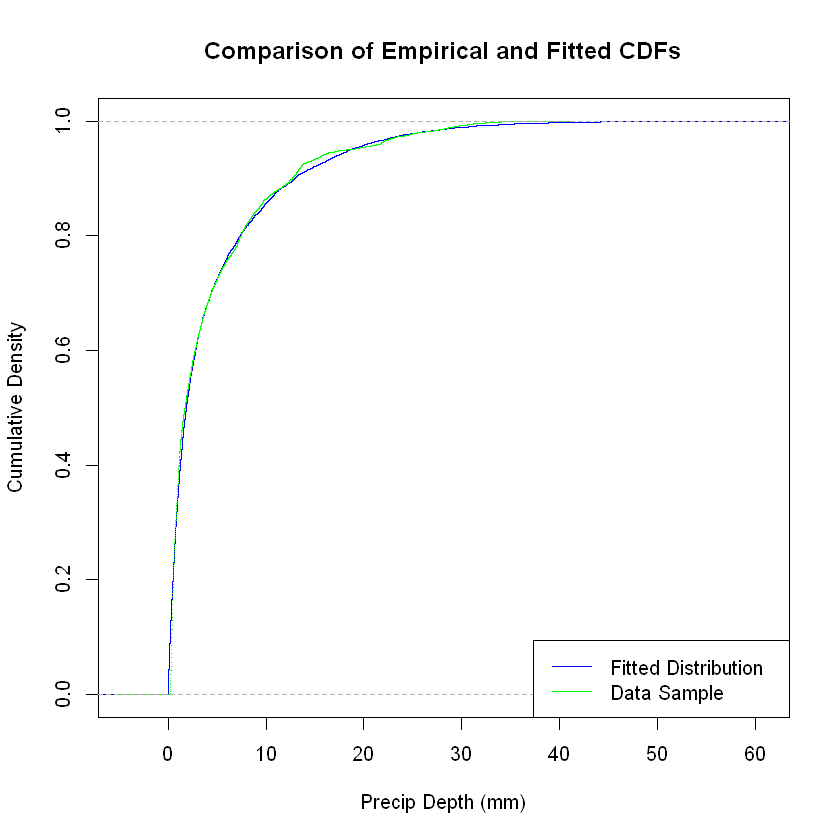

In [198]:
x <- seq(0,wJan3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJan3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [199]:
MonDistDF[4, ] <- list( 1, 3, fdGM_Jan3_shape, fdGM_Jan3_rate, fdGM_Jan3_llike, fdGM_Jan3_mean,
                        fdGM_Jan3_var, fdGM_Jan3_KSStat, fdGM_Jan3_KSp, fdME_Jan3_rate1,
                        fdME_Jan3_rate2, fdME_Jan3_lambda, fdME_Jan3_mean1, fdME_Jan3_mean2,
                        fdME_Jan3_mean, fdME_Jan3_var1, fdME_Jan3_var2, fdME_Jan3_var,
                        fdME_Jan3_llike, fdME_Jan3_KSStat, fdME_Jan3_KSp )

#### Region 4

**Gamma**

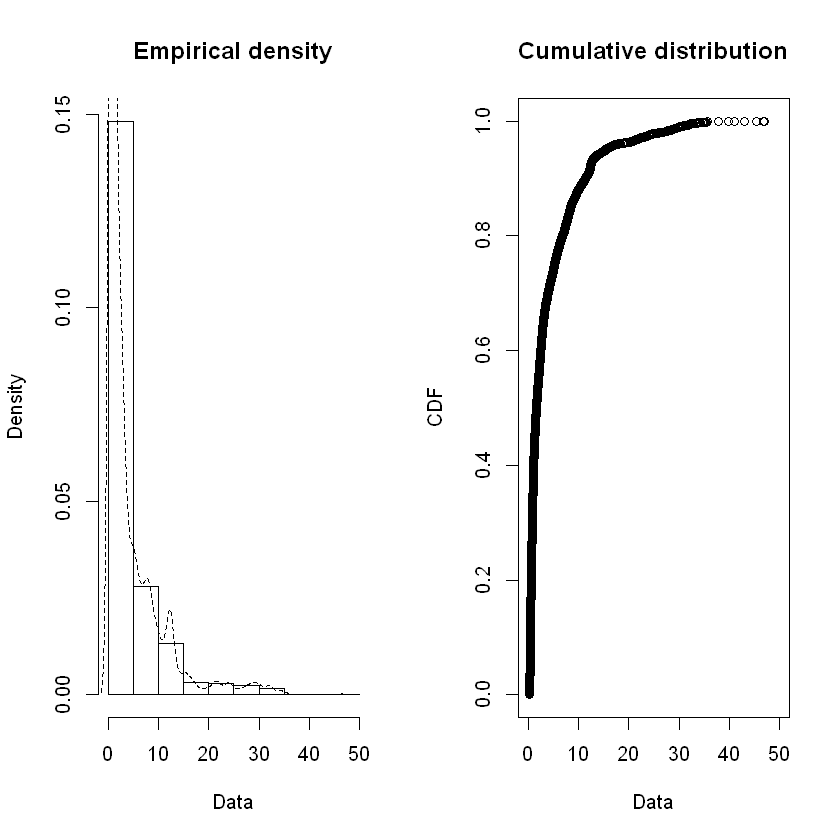

In [200]:
plotdist( dfJan4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  47.06 
median:  1.59 
mean:  4.136607 
estimated sd:  5.951238 
estimated skewness:  2.735098 
estimated kurtosis:  11.83625 

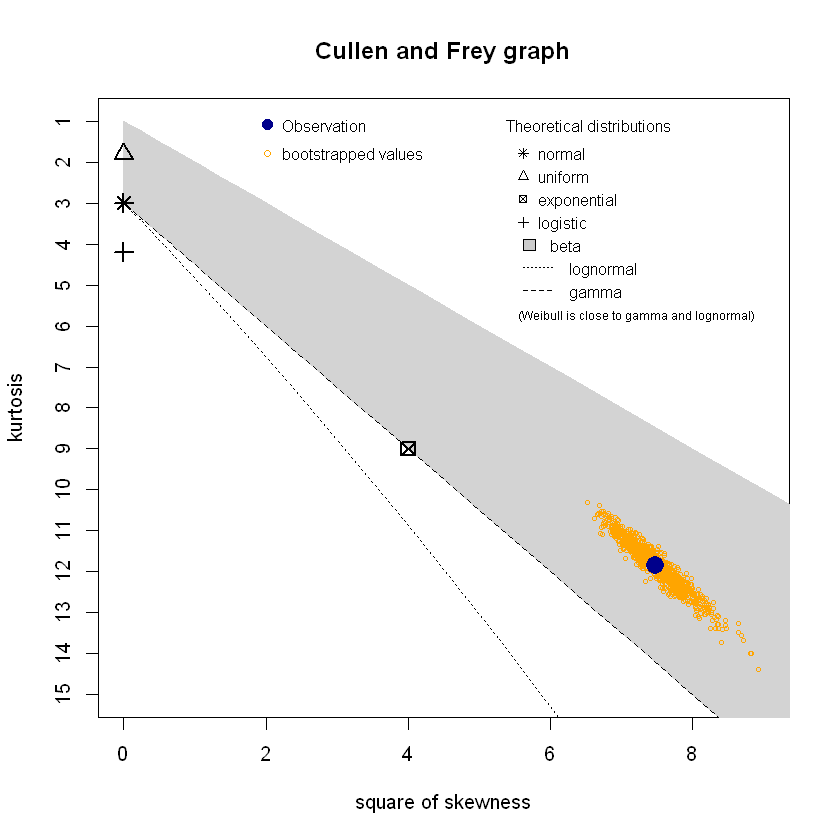

In [201]:
descdist( dfJan4$Precip_mm, boot=1000 )

In [202]:
fd_GM_Jan4 <- fitdist( dfJan4$Precip_mm, "gamma" )

In [203]:
summary( fd_GM_Jan4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7593060 0.011660181
rate  0.1835943 0.003879159
Loglikelihood:  -14954.43   AIC:  29912.86   BIC:  29926.34 
Correlation matrix:
         shape     rate
shape 1.000000 0.726756
rate  0.726756 1.000000


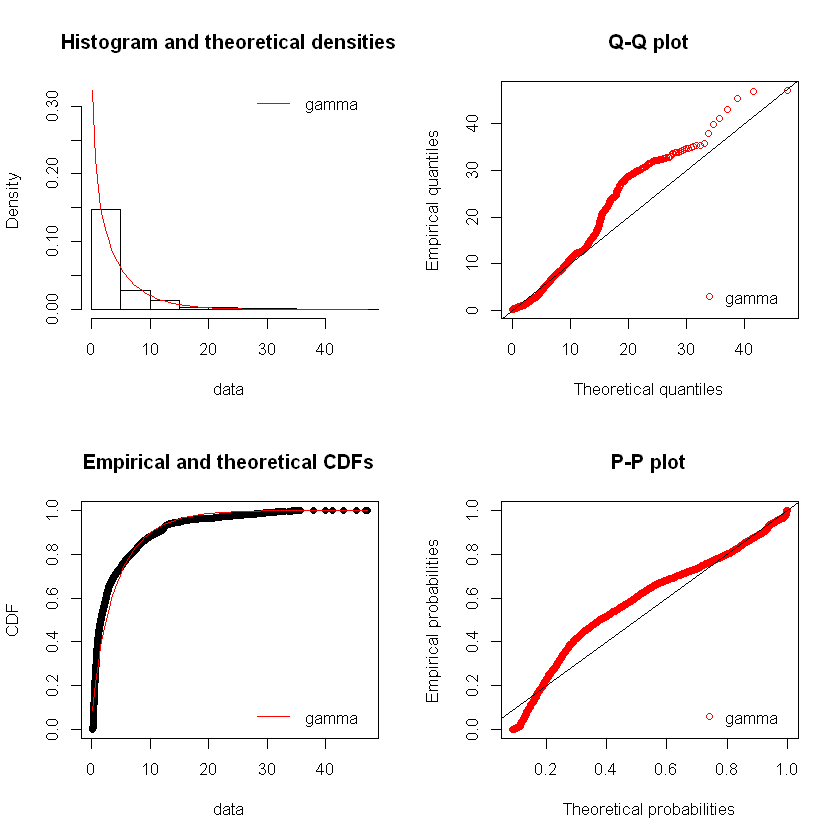

In [204]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jan4)
qqcomp(fd_GM_Jan4)
cdfcomp(fd_GM_Jan4)
ppcomp(fd_GM_Jan4)

In [205]:
fdGM_Jan4_shape <- fd_GM_Jan4$estimate[["shape"]]
fdGM_Jan4_rate <- fd_GM_Jan4$estimate[["rate"]]
fdGM_Jan4_llike <- fd_GM_Jan4$loglik
fdGM_Jan4_mean <- fdGM_Jan4_shape / fdGM_Jan4_rate
fdGM_Jan4_var <- fdGM_Jan4_shape / ( fdGM_Jan4_rate ^ 2 )
cat(" Jan 4 shape: ", fdGM_Jan4_shape, "\n", "Jan 4 rate: ", fdGM_Jan4_rate, 
    "\n", "Jan 4 loglikelihood: ", fdGM_Jan4_llike, "\n", 
    "Jan 4 mean: ", fdGM_Jan4_mean, "\n",
    "Jan 4 variance: ", fdGM_Jan4_var, "\n" )

 Jan 4 shape:  0.759306 
 Jan 4 rate:  0.1835943 
 Jan 4 loglikelihood:  -14954.43 
 Jan 4 mean:  4.135782 
 Jan 4 variance:  22.52674 


In [206]:
statRes <- gofstat( fd_GM_Jan4, fitnames=c("Gamma") )

In [207]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1243874
Cramer-von Mises statistic    33.6848186
Anderson-Darling statistic   186.5218112

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 29912.86
Bayesian Information Criterion 29926.34


In [208]:
ksRes <- ks.test( dfJan4$Precip_mm, "pgamma", shape=fdGM_Jan4_shape, rate=fdGM_Jan4_rate )

Warning message in ks.test(dfJan4$Precip_mm, "pgamma", shape = fdGM_Jan4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [209]:
fdGM_Jan4_KSStat <- ksRes$statistic
fdGM_Jan4_KSp <- ksRes$p.value
cat(" Jan 4 K-S stat: ", fdGM_Jan4_KSStat, "\n",
    "Jan 4 K-S p-value: ", fdGM_Jan4_KSp )

 Jan 4 K-S stat:  0.1243874 
 Jan 4 K-S p-value:  0

**Mixed exponential**

In [210]:
fd_ME_Jan4 <- expRMM_EM( dfJan4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJan4$Precip_mm), 1.0/mean(dfJan4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 94 


In [211]:
summary( fd_ME_Jan4 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.541663 0.458337
rate   0.780378 0.133141
loglik at estimate:  -14450.62 
0 % of the data right censored


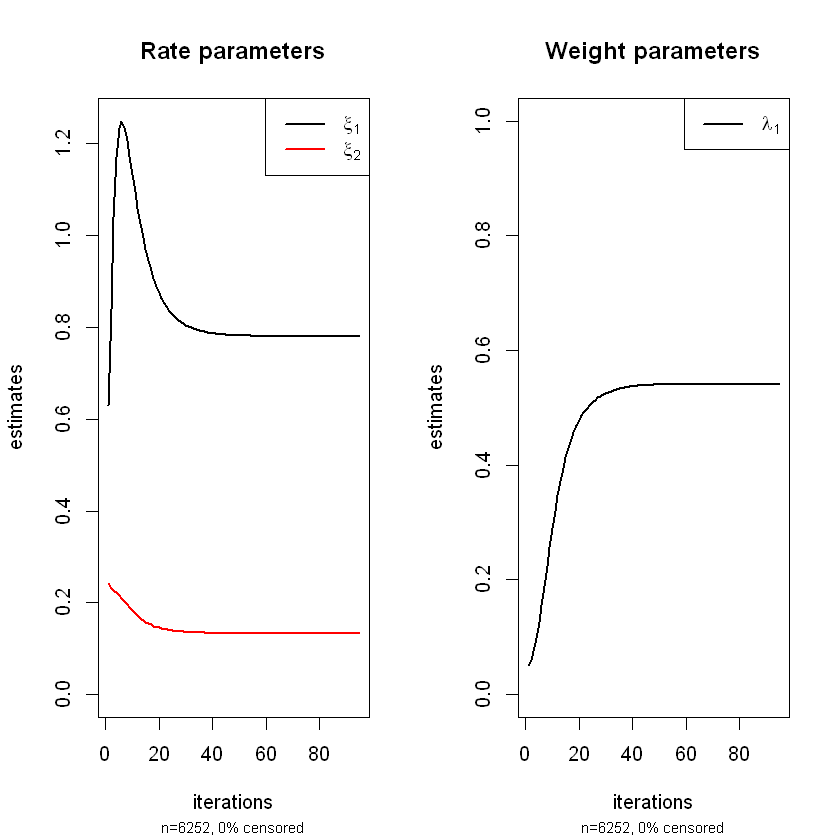

In [212]:
plotexpRMM( fd_ME_Jan4, lwd=2 )

In [213]:
fdME_Jan4_rate1 <- fd_ME_Jan4$rate[[1]]
fdME_Jan4_rate2 <- fd_ME_Jan4$rate[[2]]
fdME_Jan4_lambda <- fd_ME_Jan4$lambda[[1]]
fdME_Jan4_mean1 <- 1.0 / fdME_Jan4_rate1
fdME_Jan4_mean2 <- 1.0 / fdME_Jan4_rate2
fdME_Jan4_mean <- ( (fdME_Jan4_lambda * fdME_Jan4_mean1) + 
                    ( ( 1.0 - fdME_Jan4_lambda) * fdME_Jan4_mean2 ) )
fdME_Jan4_var1 <- 1.0 / (fdME_Jan4_rate1 ^ 2)
fdME_Jan4_var2 <- 1.0 / (fdME_Jan4_rate2 ^ 2)
fdME_Jan4_var <- ( (fdME_Jan4_lambda * ( fdME_Jan4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jan4_lambda) * (fdME_Jan4_mean2 ^ 2) ) + 
                   ( fdME_Jan4_lambda * ( 1.0 - fdME_Jan4_lambda) * 
                       ( fdME_Jan4_mean1 - fdME_Jan4_mean2 )^2 ) )
fdME_Jan4_llike <- fd_ME_Jan4$loglik
cat(" Jan 4 rate1: ", fdME_Jan4_rate1, "\n", 
    "Jan 4 rate2: ", fdME_Jan4_rate2, "\n",
    "Jan 4 lambda: ", fdME_Jan4_lambda, "\n",
    "Jan 4 mean1: ", fdME_Jan4_mean1, "\n",
    "Jan 4 mean2: ", fdME_Jan4_mean2, "\n",
    "Jan 4 mean: ", fdME_Jan4_mean, "\n",
    "Jan 4 var1: ", fdME_Jan4_var1, "\n",
    "Jan 4 var2: ", fdME_Jan4_var2, "\n",
    "Jan 4 var: ", fdME_Jan4_var, "\n",
    "Jan 4 loglikelihood: ", fdME_Jan4_llike, "\n" )

 Jan 4 rate1:  0.7803782 
 Jan 4 rate2:  0.1331406 
 Jan 4 lambda:  0.541663 
 Jan 4 mean1:  1.28143 
 Jan 4 mean2:  7.510858 
 Jan 4 mean:  4.136607 
 Jan 4 var1:  1.642063 
 Jan 4 var2:  56.41299 
 Jan 4 var:  36.37969 
 Jan 4 loglikelihood:  -14450.62 


In [214]:
tvals <- rexpmix(length(dfJan4$Precip_mm), fd_ME_Jan4$lambda, fd_ME_Jan4$rate )

In [215]:
ksRes <- ks.test( dfJan4$Precip_mm, tvals )

Warning message in ks.test(dfJan4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [216]:
fdME_Jan4_KSStat <- ksRes$statistic
fdME_Jan4_KSp <- ksRes$p.value
cat(" Jan 4 K-S stat: ", fdME_Jan4_KSStat, "\n",
    "Jan 4 K-S p-value: ", fdME_Jan4_KSp )

 Jan 4 K-S stat:  0.1065259 
 Jan 4 K-S p-value:  0

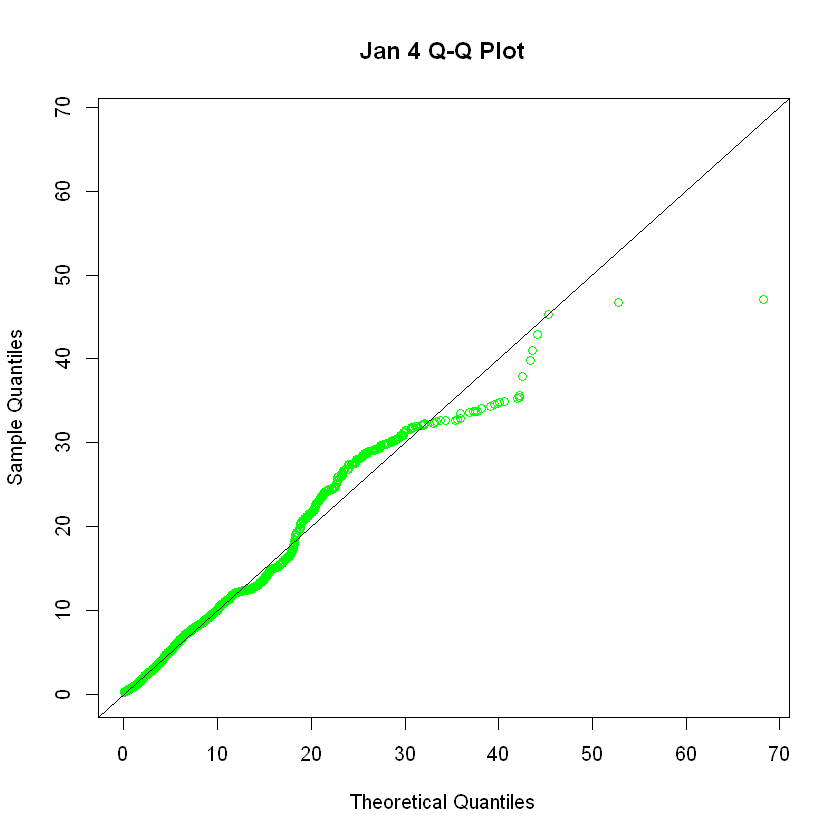

In [217]:
wJan4Max <- max( max( dfJan4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJan4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jan 4 Q-Q Plot",
        xlim=c(0,wJan4Max), ylim=c(0,wJan4Max) )
abline( 0, 1)

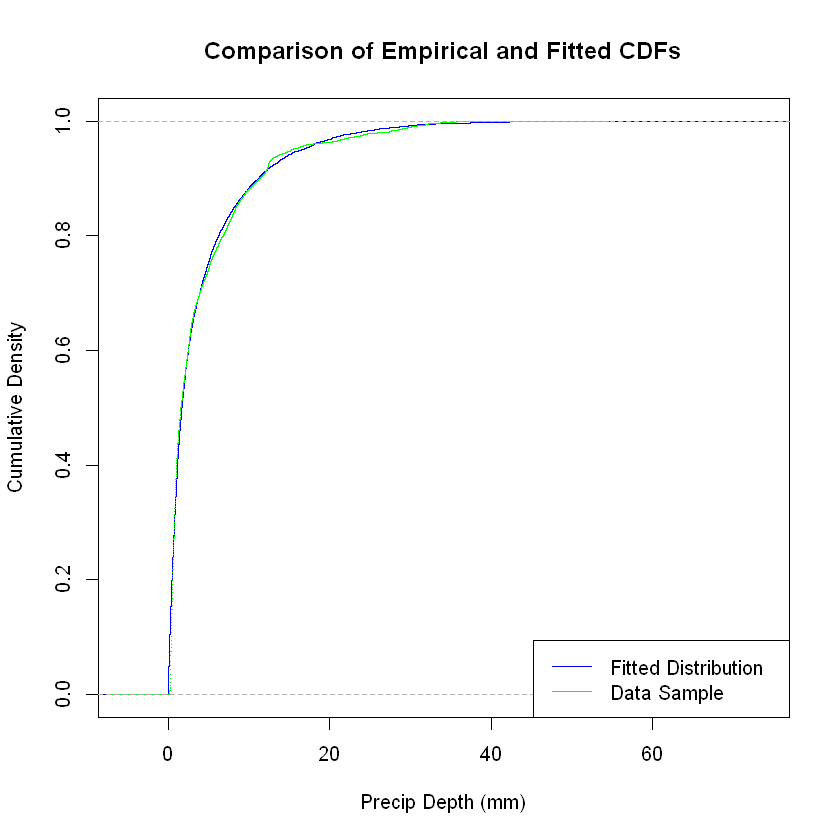

In [218]:
x <- seq(0,wJan4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJan4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [219]:
MonDistDF[5, ] <- list( 1, 4, fdGM_Jan4_shape, fdGM_Jan4_rate, fdGM_Jan4_llike, fdGM_Jan4_mean,
                        fdGM_Jan4_var, fdGM_Jan4_KSStat, fdGM_Jan4_KSp, fdME_Jan4_rate1,
                        fdME_Jan4_rate2, fdME_Jan4_lambda, fdME_Jan4_mean1, fdME_Jan4_mean2,
                        fdME_Jan4_mean, fdME_Jan4_var1, fdME_Jan4_var2, fdME_Jan4_var,
                        fdME_Jan4_llike, fdME_Jan4_KSStat, fdME_Jan4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

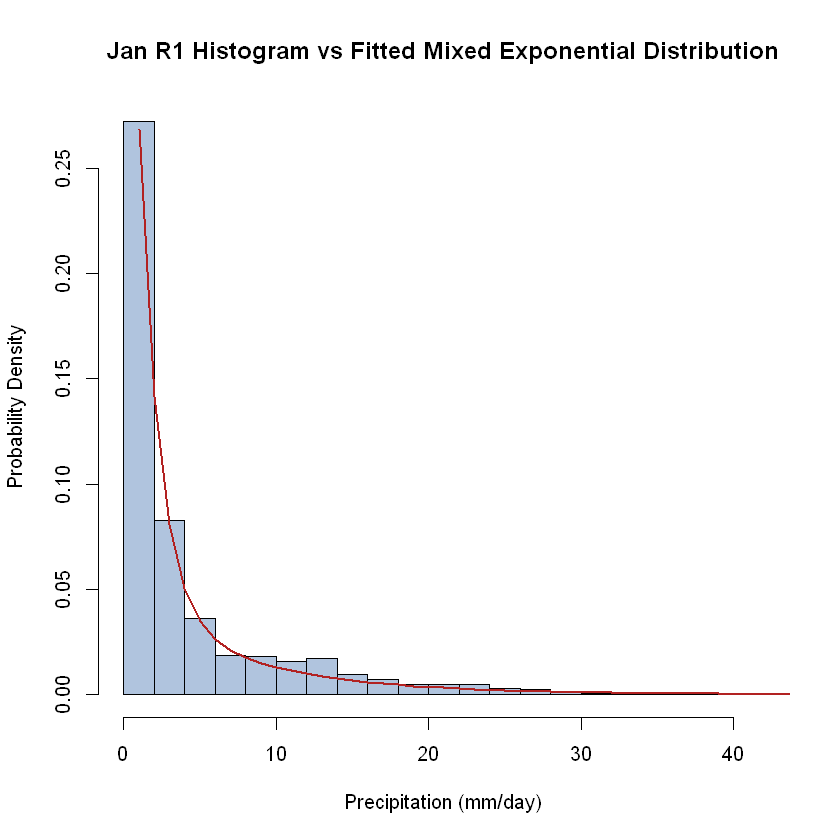

In [220]:
xVals <- seq(1, wJan1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jan1_lambda, spec1="exp", arg1=list(rate=fdME_Jan1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jan1_rate2) )
hist( dfJan1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jan R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

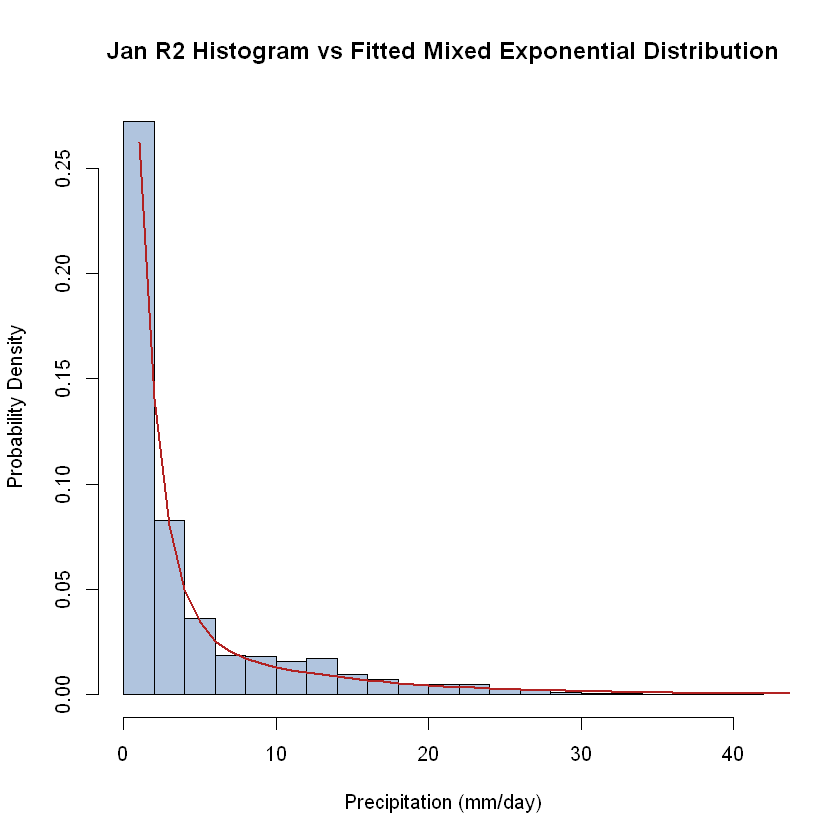

In [221]:
xVals <- seq(1, wJan2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jan2_lambda, spec1="exp", arg1=list(rate=fdME_Jan2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jan2_rate2) )
hist( dfJan1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jan R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

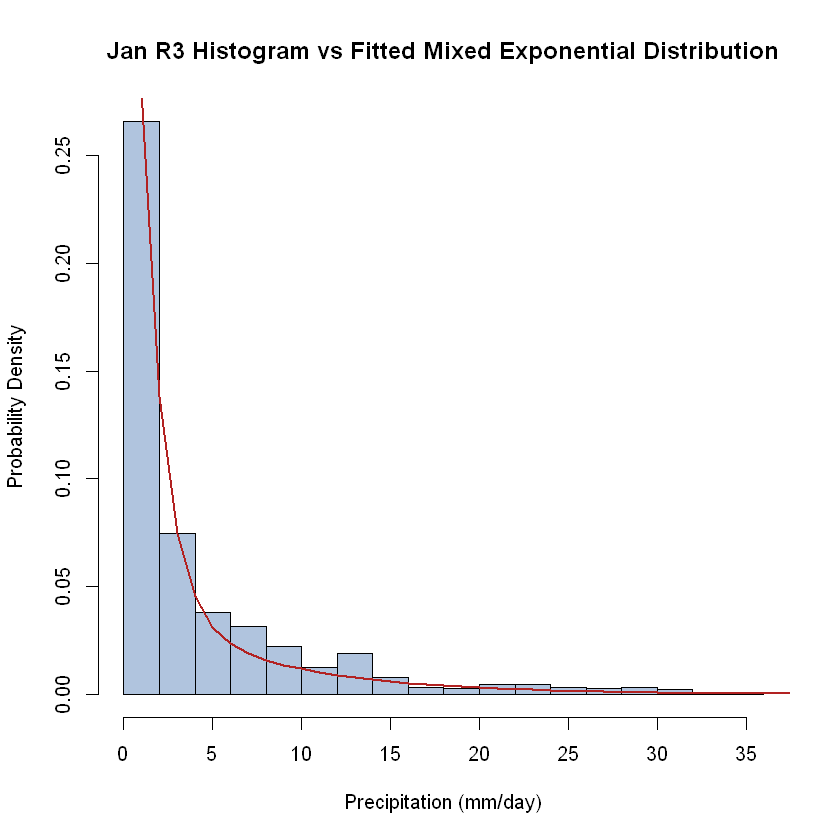

In [222]:
xVals <- seq(1, wJan3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jan3_lambda, spec1="exp", arg1=list(rate=fdME_Jan3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jan3_rate2) )
hist( dfJan3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jan R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

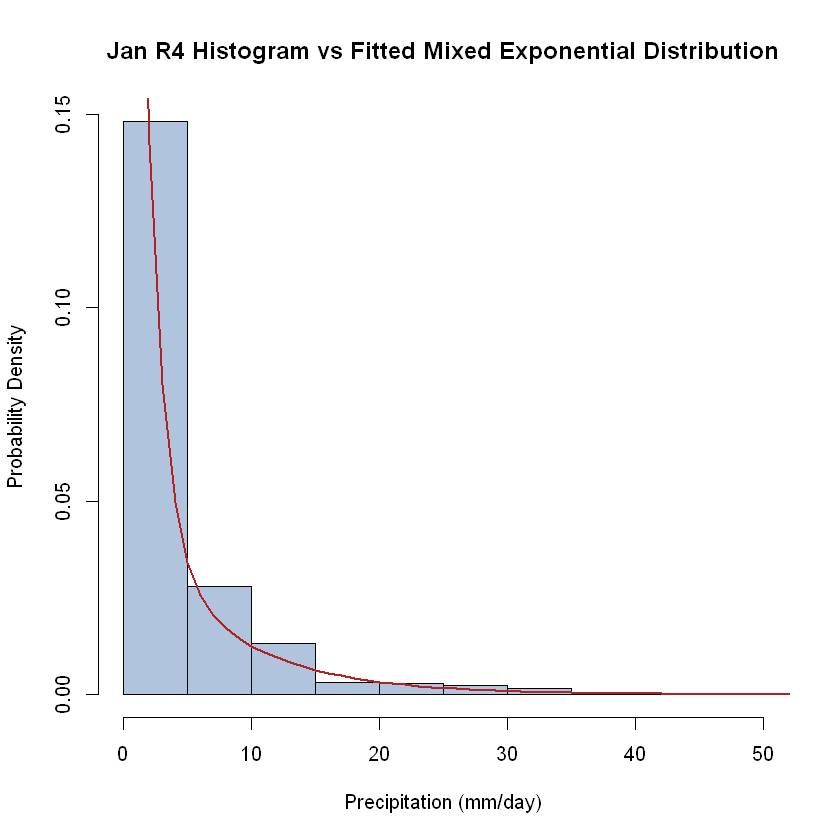

In [223]:
xVals <- seq(1, wJan4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jan4_lambda, spec1="exp", arg1=list(rate=fdME_Jan4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jan4_rate2) )
hist( dfJan4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jan R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Feb

#### All

**Gamma**

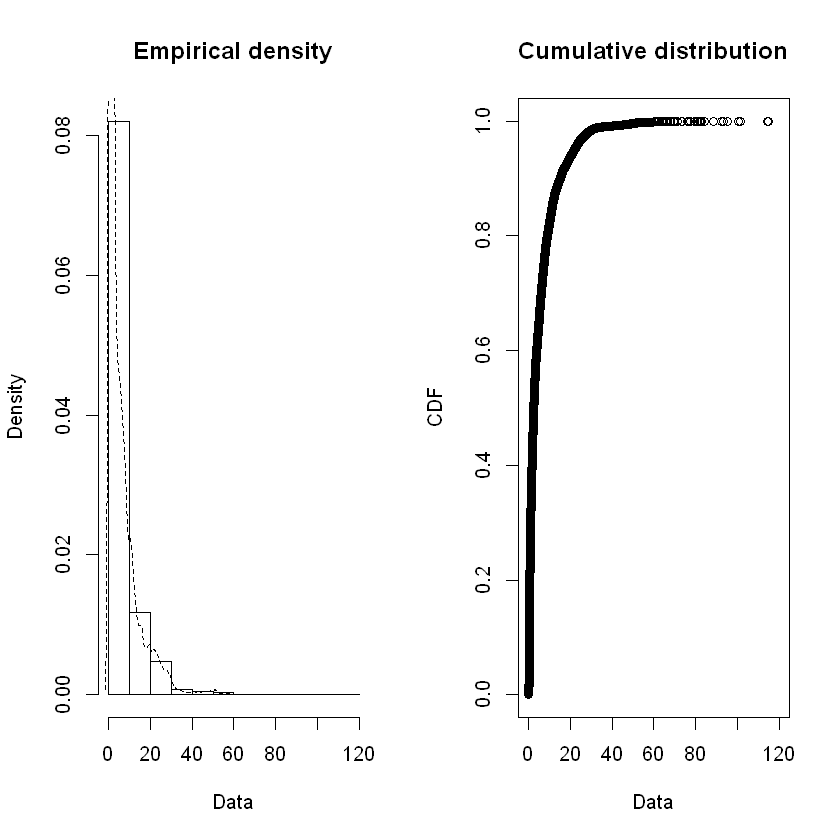

In [224]:
plotdist( dfFeb$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  114.6 
median:  2.58 
mean:  5.716607 
estimated sd:  7.888316 
estimated skewness:  3.169738 
estimated kurtosis:  19.64805 

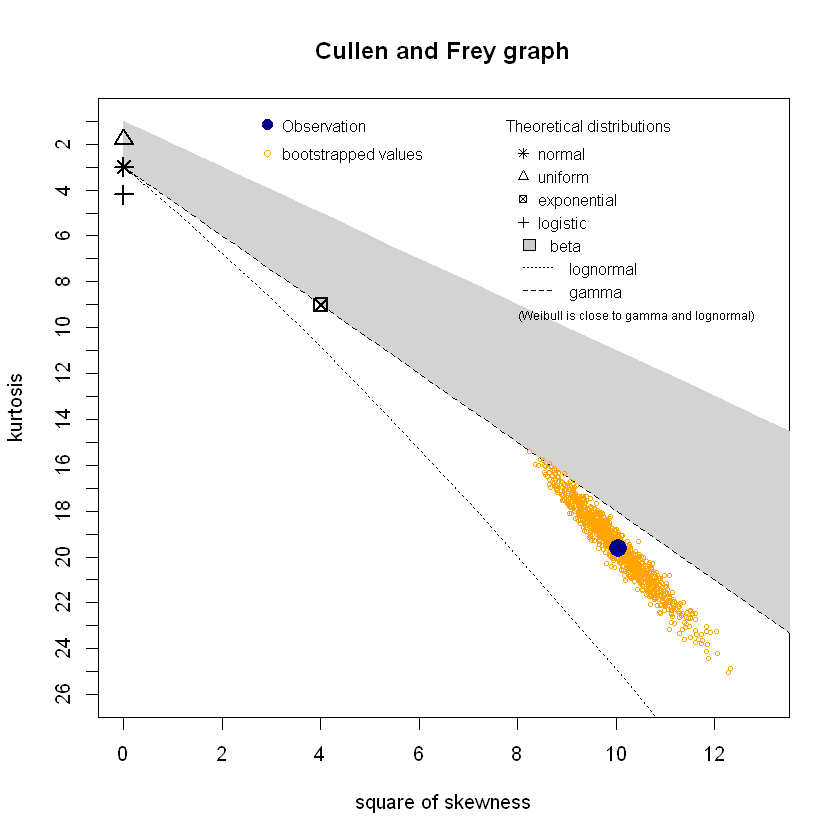

In [225]:
descdist( dfFeb$Precip_mm, boot=1000 )

In [226]:
fd_GM_FebA <- fitdist( dfFeb$Precip_mm, "gamma" )

In [227]:
summary( fd_GM_FebA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7576775 0.005205755
rate  0.1325139 0.001253431
Loglikelihood:  -84760.16   AIC:  169524.3   BIC:  169541 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7263056
rate  0.7263056 1.0000000


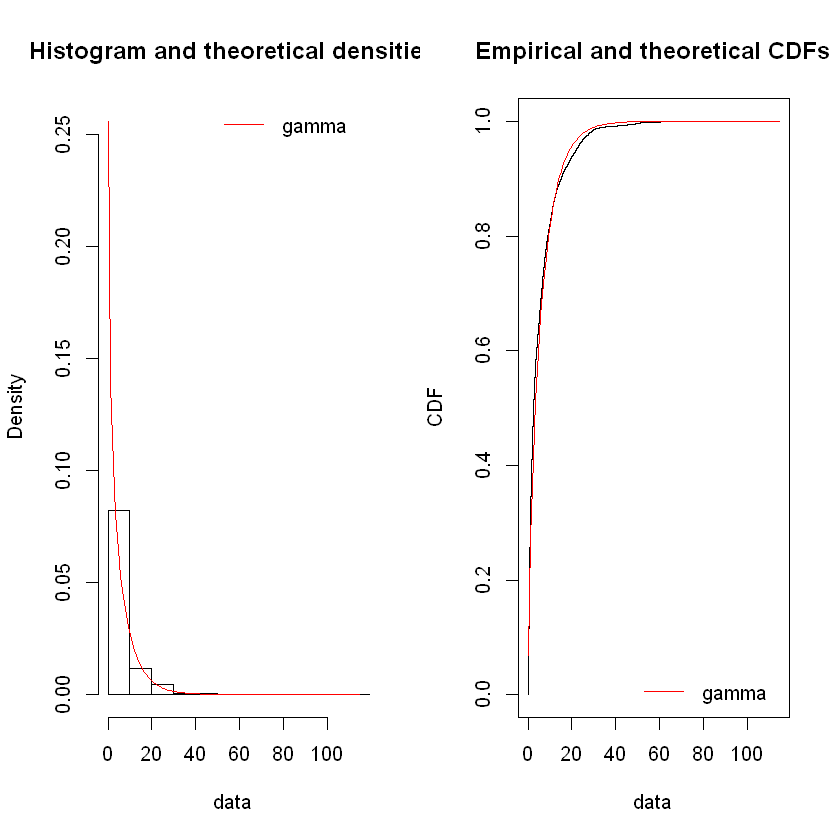

In [228]:
par(mfrow = c(1, 2))
denscomp(fd_GM_FebA)
#qqcomp(fd_GM_FebA)
cdfcomp(fd_GM_FebA)
#ppcomp(fd_GM_FebA)

In [229]:
fdGM_FebA_shape <- fd_GM_FebA$estimate[["shape"]]
fdGM_FebA_rate <- fd_GM_FebA$estimate[["rate"]]
fdGM_FebA_llike <- fd_GM_FebA$loglik
fdGM_FebA_mean <- fdGM_FebA_shape / fdGM_FebA_rate
fdGM_FebA_var <- fdGM_FebA_shape / ( fdGM_FebA_rate ^ 2 )
cat(" Feb A shape: ", fdGM_FebA_shape, "\n", "Feb A rate: ", fdGM_FebA_rate, 
    "\n", "Feb A loglikelihood: ", fdGM_FebA_llike, "\n", 
    "Feb A mean: ", fdGM_FebA_mean, "\n",
    "Feb A variance: ", fdGM_FebA_var, "\n" )

 Feb A shape:  0.7576775 
 Feb A rate:  0.1325139 
 Feb A loglikelihood:  -84760.16 
 Feb A mean:  5.717719 
 Feb A variance:  43.14806 


In [230]:
statRes <- gofstat( fd_GM_FebA, fitnames=c("Gamma") )

In [231]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.08398197
Cramer-von Mises statistic    77.82269064
Anderson-Darling statistic   465.03848842

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 169524.3
Bayesian Information Criterion 169541.0


In [232]:
ksRes <- ks.test( dfFeb$Precip_mm, "pgamma", shape=fdGM_FebA_shape, rate=fdGM_FebA_rate )

Warning message in ks.test(dfFeb$Precip_mm, "pgamma", shape = fdGM_FebA_shape, rate = fdGM_FebA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [233]:
fdGM_FebA_KSStat <- ksRes$statistic
fdGM_FebA_KSp <- ksRes$p.value
cat(" Feb A K-S stat: ", fdGM_FebA_KSStat, "\n",
    "Feb A K-S p-value: ", fdGM_FebA_KSp )

 Feb A K-S stat:  0.08398197 
 Feb A K-S p-value:  0

**Mixed Exponential**

In [234]:
fd_ME_FebA <- expRMM_EM( dfFeb$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfFeb$Precip_mm), 1.0/mean(dfFeb$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 154 


In [235]:
summary( fd_ME_FebA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.440056 0.559944
rate   0.617017 0.111913
loglik at estimate:  -83253.04 
0 % of the data right censored


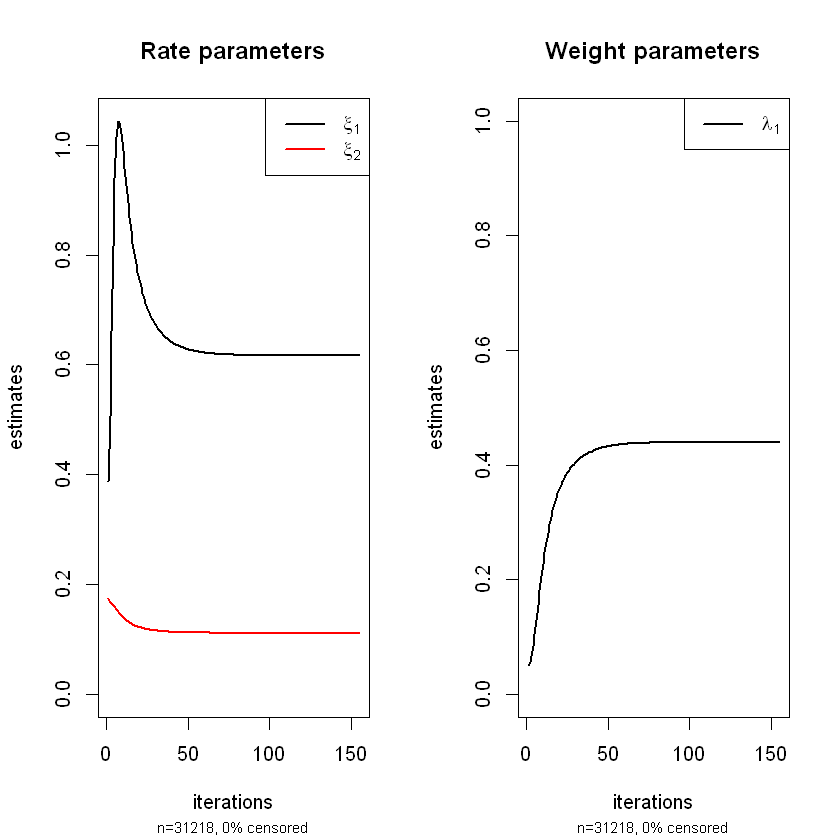

In [236]:
plotexpRMM( fd_ME_FebA, lwd=2 )

In [237]:
fdME_FebA_rate1 <- fd_ME_FebA$rate[[1]]
fdME_FebA_rate2 <- fd_ME_FebA$rate[[2]]
fdME_FebA_lambda <- fd_ME_FebA$lambda[[1]]
fdME_FebA_mean1 <- 1.0 / fdME_FebA_rate1
fdME_FebA_mean2 <- 1.0 / fdME_FebA_rate2
fdME_FebA_mean <- ( (fdME_FebA_lambda * fdME_FebA_mean1) + 
                    ( ( 1.0 - fdME_FebA_lambda) * fdME_FebA_mean2 ) )
fdME_FebA_var1 <- 1.0 / (fdME_FebA_rate1 ^ 2)
fdME_FebA_var2 <- 1.0 / (fdME_FebA_rate2 ^ 2)
fdME_FebA_var <- ( (fdME_FebA_lambda * ( fdME_FebA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_FebA_lambda) * (fdME_FebA_mean2 ^ 2) ) + 
                   ( fdME_FebA_lambda * ( 1.0 - fdME_FebA_lambda) * 
                       ( fdME_FebA_mean1 - fdME_FebA_mean2 )^2 ) )
fdME_FebA_llike <- fd_ME_FebA$loglik
cat(" Feb A rate1: ", fdME_FebA_rate1, "\n", 
    "Feb A rate2: ", fdME_FebA_rate2, "\n",
    "Feb A lambda: ", fdME_FebA_lambda, "\n",
    "Feb A mean1: ", fdME_FebA_mean1, "\n",
    "Feb A mean2: ", fdME_FebA_mean2, "\n",
    "Feb A mean: ", fdME_FebA_mean, "\n",
    "Feb A var1: ", fdME_FebA_var1, "\n",
    "Feb A var2: ", fdME_FebA_var2, "\n",
    "Feb A var: ", fdME_FebA_var, "\n",
    "Feb A loglikelihood: ", fdME_FebA_llike, "\n" )

 Feb A rate1:  0.6170173 
 Feb A rate2:  0.1119126 
 Feb A lambda:  0.4400555 
 Feb A mean1:  1.6207 
 Feb A mean2:  8.935546 
 Feb A mean:  5.716607 
 Feb A var1:  2.626669 
 Feb A var2:  79.84397 
 Feb A var:  59.04854 
 Feb A loglikelihood:  -83253.04 


In [238]:
tvals <- rexpmix(length(dfFeb$Precip_mm), fd_ME_FebA$lambda, fd_ME_FebA$rate )

In [239]:
ksRes <- ks.test( dfFeb$Precip_mm, tvals )

Warning message in ks.test(dfFeb$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [240]:
fdME_FebA_KSStat <- ksRes$statistic
fdME_FebA_KSp <- ksRes$p.value
cat(" Feb A K-S stat: ", fdME_FebA_KSStat, "\n",
    "Feb A K-S p-value: ", fdME_FebA_KSp )

 Feb A K-S stat:  0.0681658 
 Feb A K-S p-value:  0

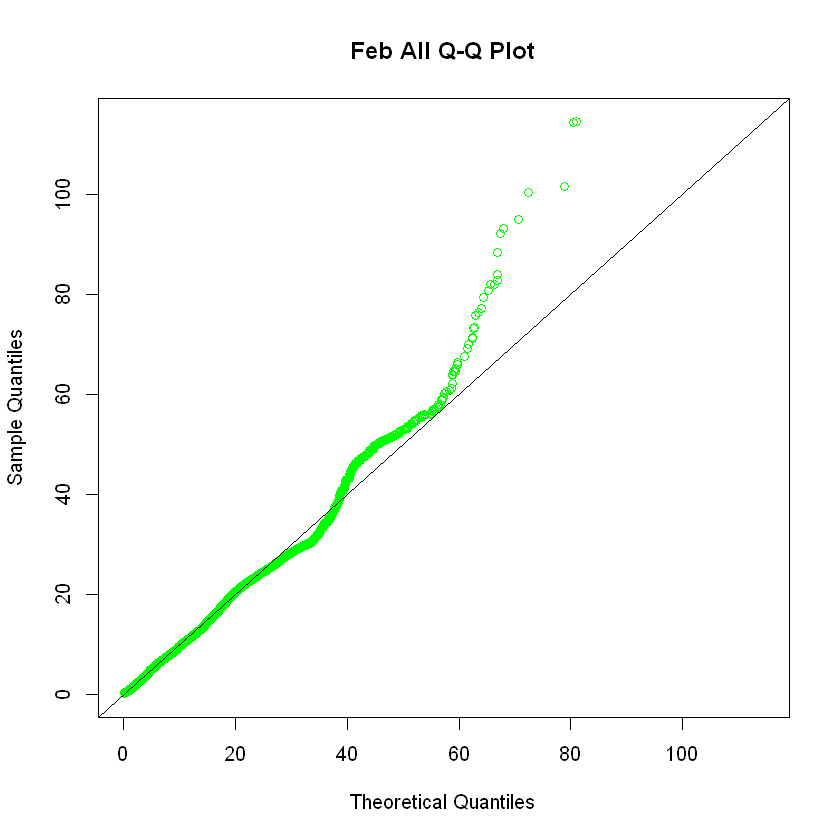

In [241]:
wFebAMax <- max( max( dfFeb$Precip_mm ), max( tvals ) )
qqplot( tvals, dfFeb$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Feb All Q-Q Plot",
        xlim=c(0,wFebAMax), ylim=c(0,wFebAMax) )
abline( 0, 1)

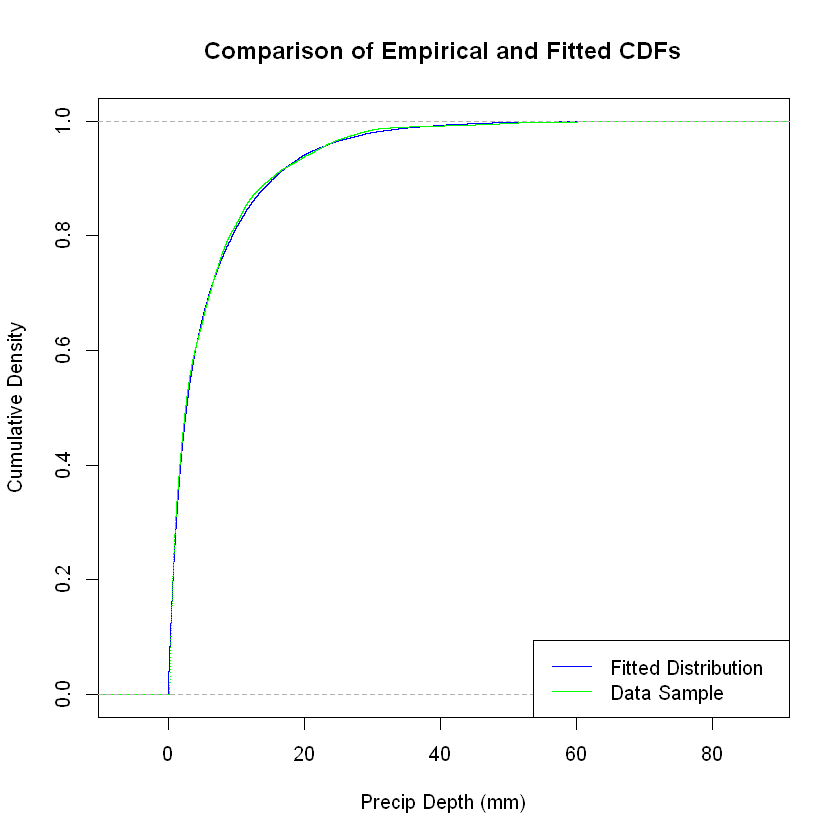

In [242]:
x <- seq(0,wFebAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfFeb$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [243]:
MonDistDF[6, ] <- list( 2, 0, fdGM_FebA_shape, fdGM_FebA_rate, fdGM_FebA_llike, fdGM_FebA_mean,
                        fdGM_FebA_var, fdGM_FebA_KSStat, fdGM_FebA_KSp, fdME_FebA_rate1,
                        fdME_FebA_rate2, fdME_FebA_lambda, fdME_FebA_mean1, fdME_FebA_mean2,
                        fdME_FebA_mean, fdME_FebA_var1, fdME_FebA_var2, fdME_FebA_var,
                        fdME_FebA_llike, fdME_FebA_KSStat, fdME_FebA_KSp )

#### Region 1

**Gamma**

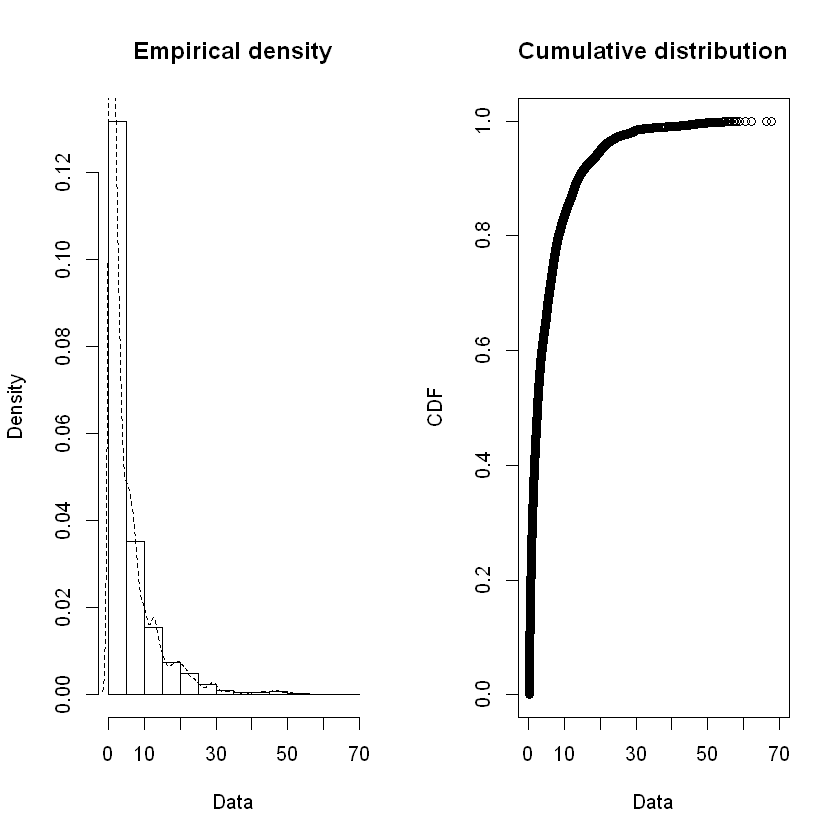

In [244]:
plotdist( dfFeb1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  67.68 
median:  2.53 
mean:  5.44416 
estimated sd:  7.443414 
estimated skewness:  2.91134 
estimated kurtosis:  14.44753 

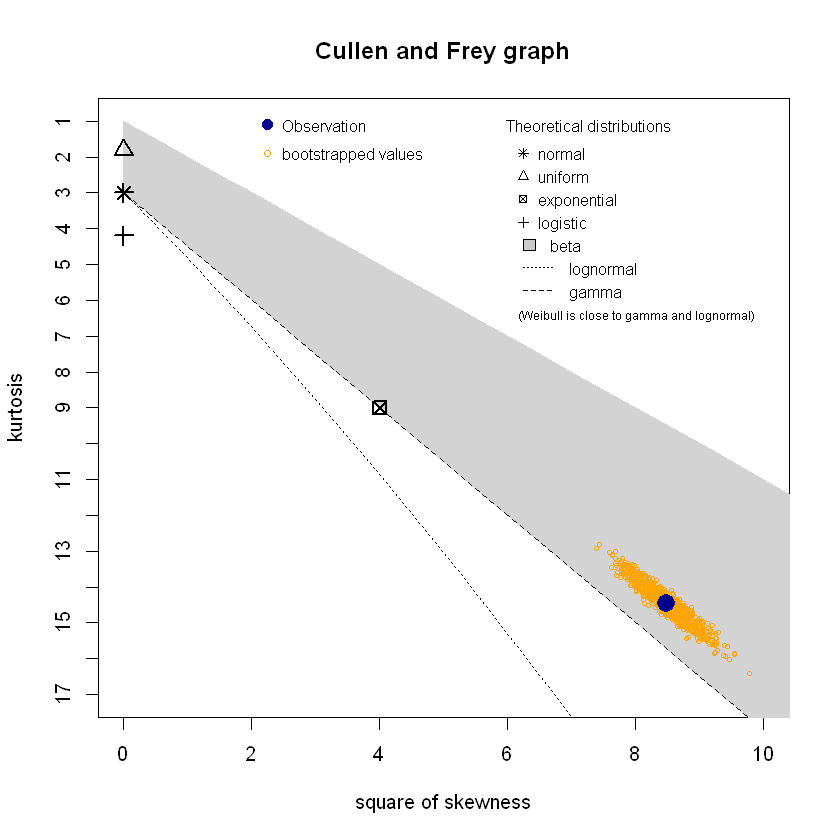

In [245]:
descdist( dfFeb1$Precip_mm, boot=1000 )

In [246]:
fd_GM_Feb1 <- fitdist( dfFeb1$Precip_mm, "gamma" )

In [247]:
summary( fd_GM_Feb1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7753507 0.008198055
rate  0.1423863 0.002059378
Loglikelihood:  -35362.08   AIC:  70728.15   BIC:  70743.14 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7309861
rate  0.7309861 1.0000000


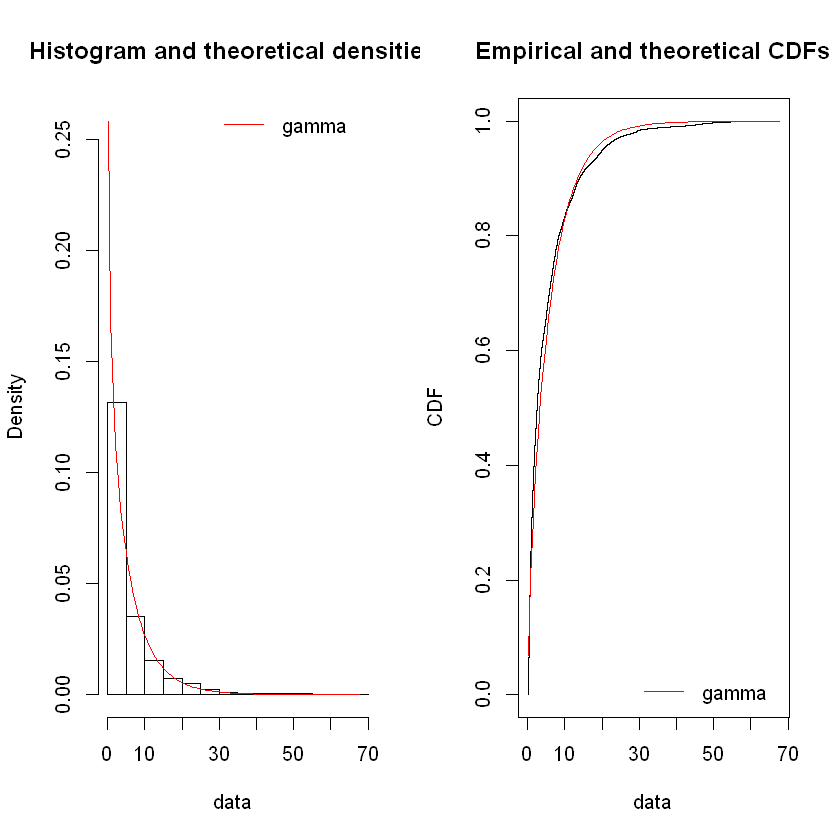

In [248]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Feb1)
#qqcomp(fd_GM_Feb1)
cdfcomp(fd_GM_Feb1)
#ppcomp(fd_GM_Feb1)

In [249]:
fdGM_Feb1_shape <- fd_GM_Feb1$estimate[["shape"]]
fdGM_Feb1_rate <- fd_GM_Feb1$estimate[["rate"]]
fdGM_Feb1_llike <- fd_GM_Feb1$loglik
fdGM_Feb1_mean <- fdGM_Feb1_shape / fdGM_Feb1_rate
fdGM_Feb1_var <- fdGM_Feb1_shape / ( fdGM_Feb1_rate ^ 2 )
cat(" Feb 1 shape: ", fdGM_Feb1_shape, "\n", "Feb 1 rate: ", fdGM_Feb1_rate, 
    "\n", "Feb 1 loglikelihood: ", fdGM_Feb1_llike, "\n", 
    "Feb 1 mean: ", fdGM_Feb1_mean, "\n",
    "Feb 1 variance: ", fdGM_Feb1_var, "\n" )

 Feb 1 shape:  0.7753507 
 Feb 1 rate:  0.1423863 
 Feb 1 loglikelihood:  -35362.08 
 Feb 1 mean:  5.445401 
 Feb 1 variance:  38.24385 


In [250]:
statRes <- gofstat( fd_GM_Feb1, fitnames=c("Gamma") )

In [251]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.08080842
Cramer-von Mises statistic    31.30862186
Anderson-Darling statistic   187.98669654

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 70728.15
Bayesian Information Criterion 70743.14


In [252]:
ksRes <- ks.test( dfFeb1$Precip_mm, "pgamma", shape=fdGM_Feb1_shape, rate=fdGM_Feb1_rate )

Warning message in ks.test(dfFeb1$Precip_mm, "pgamma", shape = fdGM_Feb1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [253]:
fdGM_Feb1_KSStat <- ksRes$statistic
fdGM_Feb1_KSp <- ksRes$p.value
cat(" Feb 1 K-S stat: ", fdGM_Feb1_KSStat, "\n",
    "Feb 1 K-S p-value: ", fdGM_Feb1_KSp )

 Feb 1 K-S stat:  0.08080842 
 Feb 1 K-S p-value:  0

**Mixed exponential**

In [254]:
fd_ME_Feb1 <- expRMM_EM( dfFeb1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfFeb1$Precip_mm), 1.0/mean(dfFeb1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 188 


In [255]:
summary( fd_ME_Feb1 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.462864 0.537136
rate   0.573593 0.115832
loglik at estimate:  -34764.97 
0 % of the data right censored


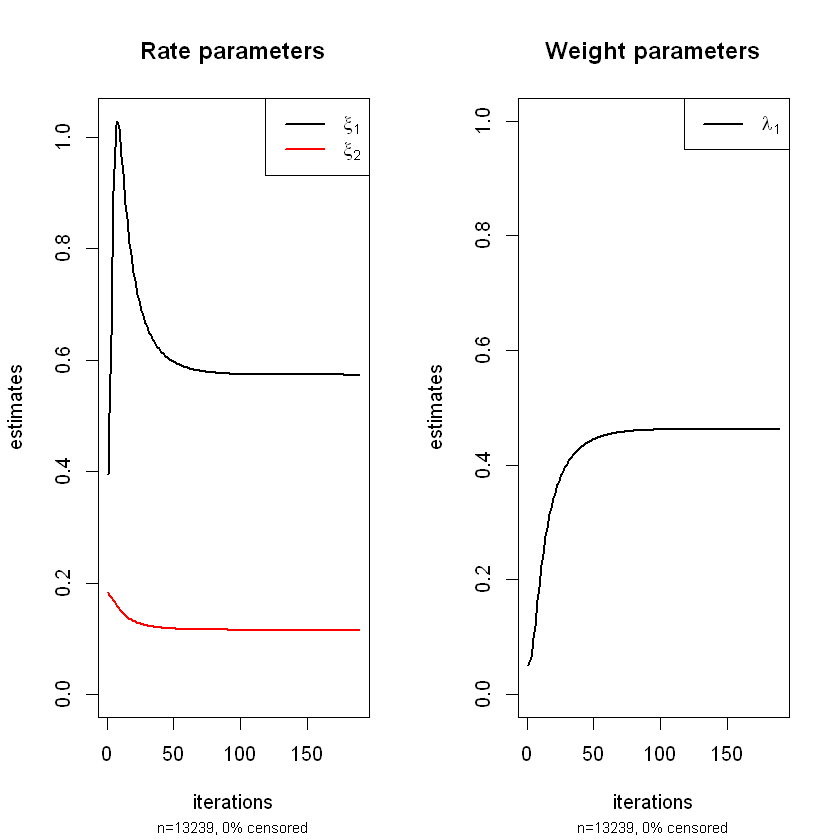

In [256]:
plotexpRMM( fd_ME_Feb1, lwd=2 )

In [257]:
fdME_Feb1_rate1 <- fd_ME_Feb1$rate[[1]]
fdME_Feb1_rate2 <- fd_ME_Feb1$rate[[2]]
fdME_Feb1_lambda <- fd_ME_Feb1$lambda[[1]]
fdME_Feb1_mean1 <- 1.0 / fdME_Feb1_rate1
fdME_Feb1_mean2 <- 1.0 / fdME_Feb1_rate2
fdME_Feb1_mean <- ( (fdME_Feb1_lambda * fdME_Feb1_mean1) + 
                    ( ( 1.0 - fdME_Feb1_lambda) * fdME_Feb1_mean2 ) )
fdME_Feb1_var1 <- 1.0 / (fdME_Feb1_rate1 ^ 2)
fdME_Feb1_var2 <- 1.0 / (fdME_Feb1_rate2 ^ 2)
fdME_Feb1_var <- ( (fdME_Feb1_lambda * ( fdME_Feb1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Feb1_lambda) * (fdME_Feb1_mean2 ^ 2) ) + 
                   ( fdME_Feb1_lambda * ( 1.0 - fdME_Feb1_lambda) * 
                       ( fdME_Feb1_mean1 - fdME_Feb1_mean2 )^2 ) )
fdME_Feb1_llike <- fd_ME_Feb1$loglik
cat(" Feb 1 rate1: ", fdME_Feb1_rate1, "\n", 
    "Feb 1 rate2: ", fdME_Feb1_rate2, "\n",
    "Feb 1 lambda: ", fdME_Feb1_lambda, "\n",
    "Feb 1 mean1: ", fdME_Feb1_mean1, "\n",
    "Feb 1 mean2: ", fdME_Feb1_mean2, "\n",
    "Feb 1 mean: ", fdME_Feb1_mean, "\n",
    "Feb 1 var1: ", fdME_Feb1_var1, "\n",
    "Feb 1 var2: ", fdME_Feb1_var2, "\n",
    "Feb 1 var: ", fdME_Feb1_var, "\n",
    "Feb 1 loglikelihood: ", fdME_Feb1_llike, "\n" )

 Feb 1 rate1:  0.5735927 
 Feb 1 rate2:  0.1158318 
 Feb 1 lambda:  0.4628641 
 Feb 1 mean1:  1.743397 
 Feb 1 mean2:  8.633204 
 Feb 1 mean:  5.44416 
 Feb 1 var1:  3.039435 
 Feb 1 var2:  74.53222 
 Feb 1 var:  53.24267 
 Feb 1 loglikelihood:  -34764.97 


In [258]:
tvals <- rexpmix(length(dfFeb1$Precip_mm), fd_ME_Feb1$lambda, fd_ME_Feb1$rate )

In [259]:
ksRes <- ks.test( dfFeb1$Precip_mm, tvals )

Warning message in ks.test(dfFeb1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [260]:
fdME_Feb1_KSStat <- ksRes$statistic
fdME_Feb1_KSp <- ksRes$p.value
cat(" Feb 1 K-S stat: ", fdME_Feb1_KSStat, "\n",
    "Feb 1 K-S p-value: ", fdME_Feb1_KSp )

 Feb 1 K-S stat:  0.0654128 
 Feb 1 K-S p-value:  0

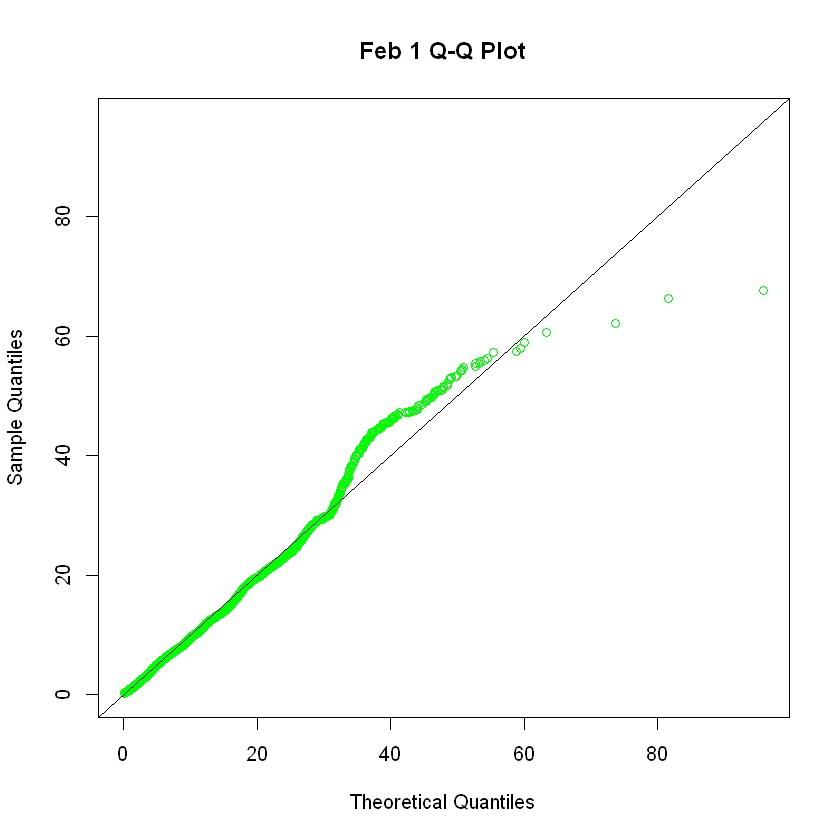

In [261]:
wFeb1Max <- max( max( dfFeb1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfFeb1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Feb 1 Q-Q Plot",
        xlim=c(0,wFeb1Max), ylim=c(0,wFeb1Max) )
abline( 0, 1)

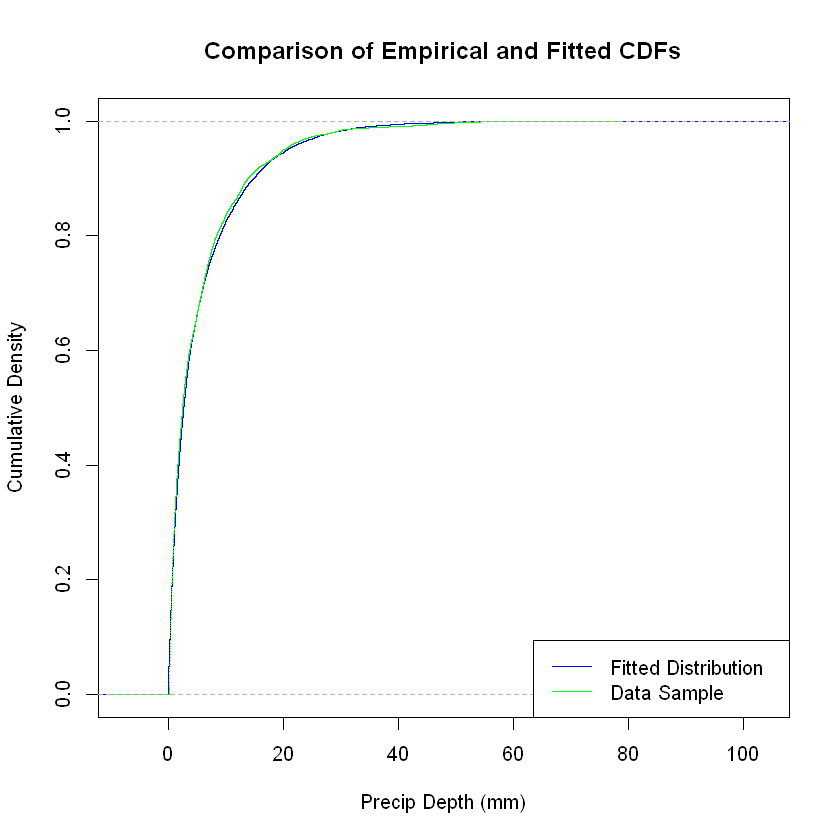

In [262]:
x <- seq(0,wFeb1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfFeb1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [263]:
MonDistDF[7, ] <- list( 2, 1, fdGM_Feb1_shape, fdGM_Feb1_rate, fdGM_Feb1_llike, fdGM_Feb1_mean,
                        fdGM_Feb1_var, fdGM_Feb1_KSStat, fdGM_Feb1_KSp, fdME_Feb1_rate1,
                        fdME_Feb1_rate2, fdME_Feb1_lambda, fdME_Feb1_mean1, fdME_Feb1_mean2,
                        fdME_Feb1_mean, fdME_Feb1_var1, fdME_Feb1_var2, fdME_Feb1_var,
                        fdME_Feb1_llike, fdME_Feb1_KSStat, fdME_Feb1_KSp )

#### Region 2

**Gamma**

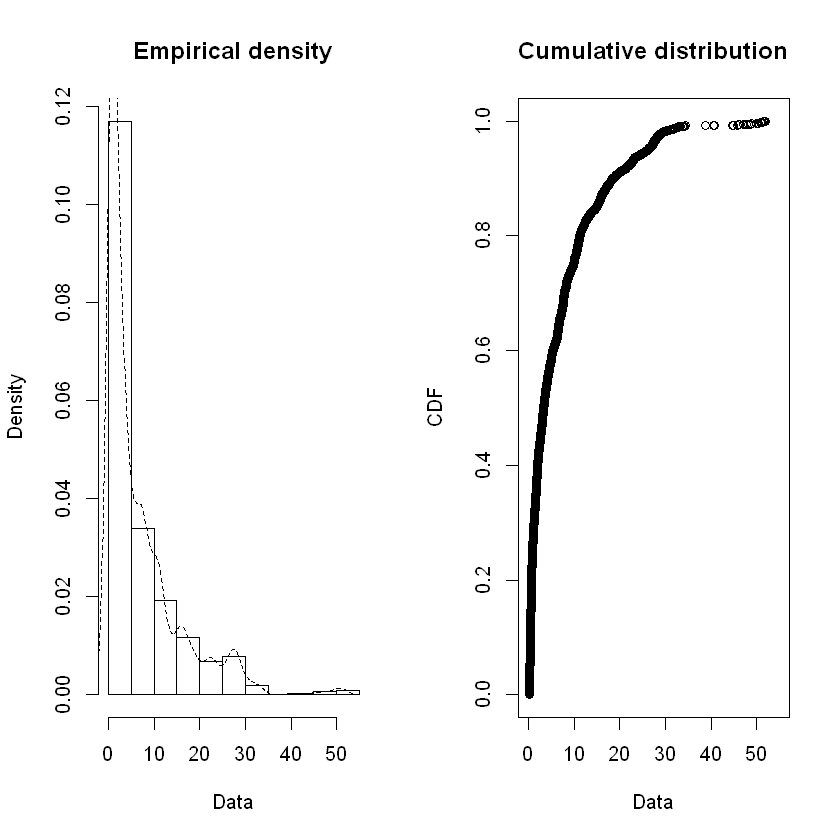

In [264]:
plotdist( dfFeb2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  51.9 
median:  3.345 
mean:  6.854072 
estimated sd:  8.40266 
estimated skewness:  2.014318 
estimated kurtosis:  7.894306 

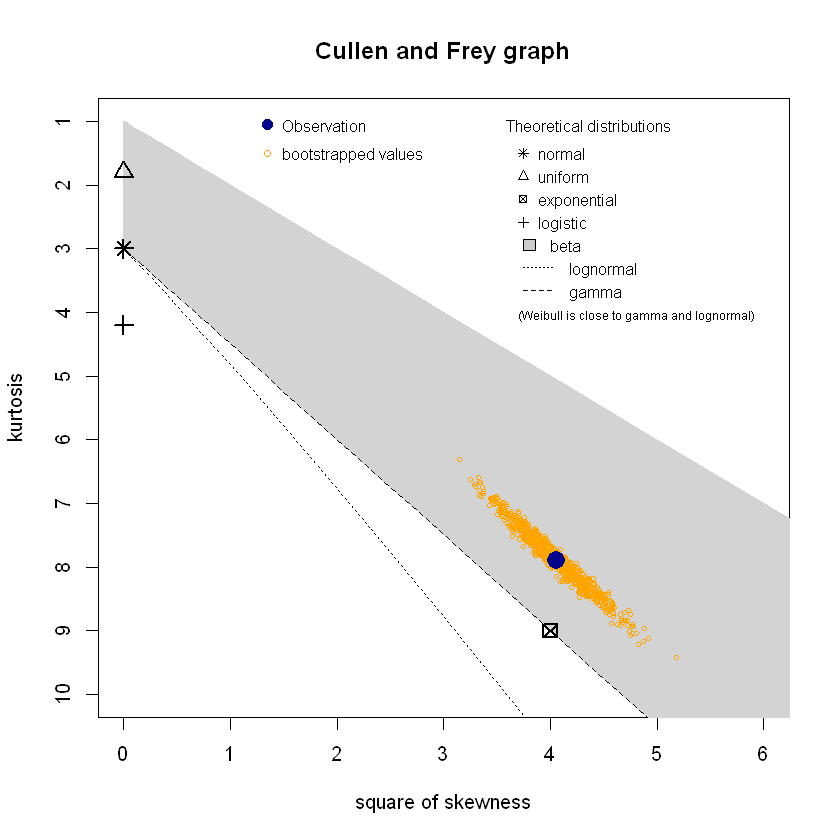

In [265]:
descdist( dfFeb2$Precip_mm, boot=1000 )

In [266]:
fd_GM_Feb2 <- fitdist( dfFeb2$Precip_mm, "gamma" )

In [267]:
summary( fd_GM_Feb2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7453603 0.014291569
rate  0.1087470 0.002883801
Loglikelihood:  -11560.1   AIC:  23124.19   BIC:  23136.78 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7229438
rate  0.7229438 1.0000000


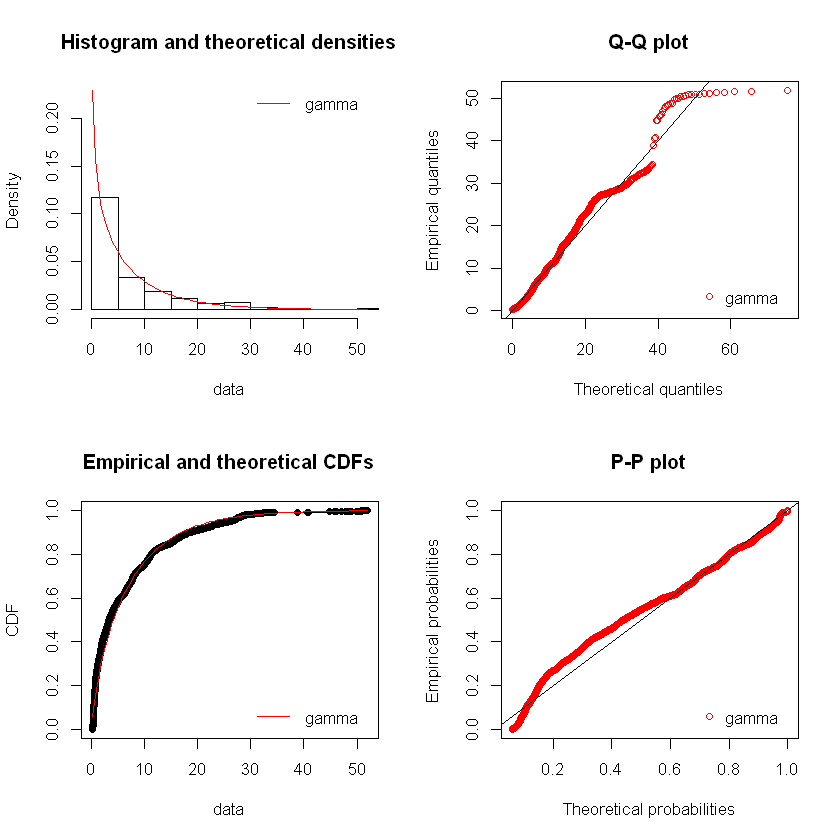

In [268]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Feb2)
qqcomp(fd_GM_Feb2)
cdfcomp(fd_GM_Feb2)
ppcomp(fd_GM_Feb2)

In [269]:
fdGM_Feb2_shape <- fd_GM_Feb2$estimate[["shape"]]
fdGM_Feb2_rate <- fd_GM_Feb2$estimate[["rate"]]
fdGM_Feb2_llike <- fd_GM_Feb2$loglik
fdGM_Feb2_mean <- fdGM_Feb2_shape / fdGM_Feb2_rate
fdGM_Feb2_var <- fdGM_Feb2_shape / ( fdGM_Feb2_rate ^ 2 )
cat(" Feb 2 shape: ", fdGM_Feb2_shape, "\n", "Feb 2 rate: ", fdGM_Feb2_rate, 
    "\n", "Feb 2 loglikelihood: ", fdGM_Feb2_llike, "\n", 
    "Feb 2 mean: ", fdGM_Feb2_mean, "\n",
    "Feb 2 variance: ", fdGM_Feb2_var, "\n" )

 Feb 2 shape:  0.7453603 
 Feb 2 rate:  0.108747 
 Feb 2 loglikelihood:  -11560.1 
 Feb 2 mean:  6.854075 
 Feb 2 variance:  63.02769 


In [270]:
statRes <- gofstat( fd_GM_Feb2, fitnames=c("Gamma") )

In [271]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic  0.0787607
Cramer-von Mises statistic    7.3854354
Anderson-Darling statistic   48.4859739

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 23124.19
Bayesian Information Criterion 23136.78


In [272]:
ksRes <- ks.test( dfFeb2$Precip_mm, "pgamma", shape=fdGM_Feb2_shape, rate=fdGM_Feb2_rate )

Warning message in ks.test(dfFeb2$Precip_mm, "pgamma", shape = fdGM_Feb2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [273]:
fdGM_Feb2_KSStat <- ksRes$statistic
fdGM_Feb2_KSp <- ksRes$p.value
cat(" Feb 2 K-S stat: ", fdGM_Feb2_KSStat, "\n",
    "Feb 2 K-S p-value: ", fdGM_Feb2_KSp )

 Feb 2 K-S stat:  0.0787607 
 Feb 2 K-S p-value:  0

**Mixed exponential**

In [274]:
fd_ME_Feb2 <- expRMM_EM( dfFeb2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfFeb2$Precip_mm), 1.0/mean(dfFeb2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 82 


In [275]:
summary( fd_ME_Feb2 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.316560 0.683440
rate   0.810614 0.105737
loglik at estimate:  -11392.6 
0 % of the data right censored


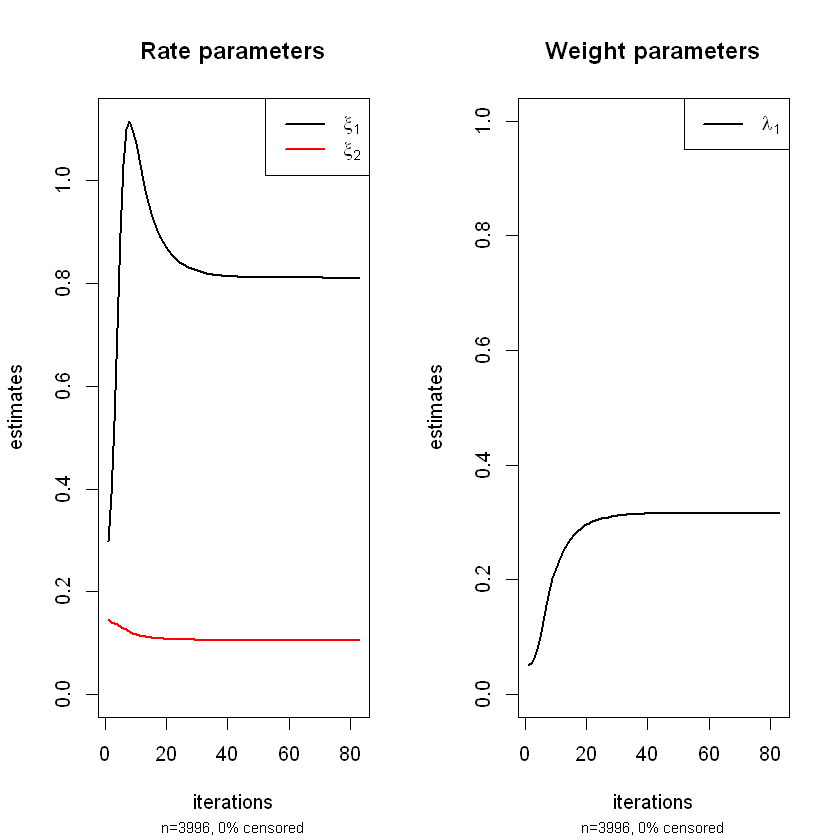

In [276]:
plotexpRMM( fd_ME_Feb2, lwd=2 )

In [277]:
fdME_Feb2_rate1 <- fd_ME_Feb2$rate[[1]]
fdME_Feb2_rate2 <- fd_ME_Feb2$rate[[2]]
fdME_Feb2_lambda <- fd_ME_Feb2$lambda[[1]]
fdME_Feb2_mean1 <- 1.0 / fdME_Feb2_rate1
fdME_Feb2_mean2 <- 1.0 / fdME_Feb2_rate2
fdME_Feb2_mean <- ( (fdME_Feb2_lambda * fdME_Feb2_mean1) + 
                    ( ( 1.0 - fdME_Feb2_lambda) * fdME_Feb2_mean2 ) )
fdME_Feb2_var1 <- 1.0 / (fdME_Feb2_rate1 ^ 2)
fdME_Feb2_var2 <- 1.0 / (fdME_Feb2_rate2 ^ 2)
fdME_Feb2_var <- ( (fdME_Feb2_lambda * ( fdME_Feb2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Feb2_lambda) * (fdME_Feb2_mean2 ^ 2) ) + 
                   ( fdME_Feb2_lambda * ( 1.0 - fdME_Feb2_lambda) * 
                       ( fdME_Feb2_mean1 - fdME_Feb2_mean2 )^2 ) )
fdME_Feb2_llike <- fd_ME_Feb2$loglik
cat(" Feb 2 rate1: ", fdME_Feb2_rate1, "\n", 
    "Feb 2 rate2: ", fdME_Feb2_rate2, "\n",
    "Feb 2 lambda: ", fdME_Feb2_lambda, "\n",
    "Feb 2 mean1: ", fdME_Feb2_mean1, "\n",
    "Feb 2 mean2: ", fdME_Feb2_mean2, "\n",
    "Feb 2 mean: ", fdME_Feb2_mean, "\n",
    "Feb 2 var1: ", fdME_Feb2_var1, "\n",
    "Feb 2 var2: ", fdME_Feb2_var2, "\n",
    "Feb 2 var: ", fdME_Feb2_var, "\n",
    "Feb 2 loglikelihood: ", fdME_Feb2_llike, "\n" )

 Feb 2 rate1:  0.8106142 
 Feb 2 rate2:  0.1057375 
 Feb 2 lambda:  0.3165603 
 Feb 2 mean1:  1.233632 
 Feb 2 mean2:  9.457385 
 Feb 2 mean:  6.854072 
 Feb 2 var1:  1.521849 
 Feb 2 var2:  89.44213 
 Feb 2 var:  76.24183 
 Feb 2 loglikelihood:  -11392.6 


In [278]:
tvals <- rexpmix(length(dfFeb2$Precip_mm), fd_ME_Feb2$lambda, fd_ME_Feb2$rate )

In [279]:
ksRes <- ks.test( dfFeb2$Precip_mm, tvals )

Warning message in ks.test(dfFeb2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [280]:
fdME_Feb2_KSStat <- ksRes$statistic
fdME_Feb2_KSp <- ksRes$p.value
cat(" Feb 2 K-S stat: ", fdME_Feb2_KSStat, "\n",
    "Feb 2 K-S p-value: ", fdME_Feb2_KSp )

 Feb 2 K-S stat:  0.06906907 
 Feb 2 K-S p-value:  1.052075e-08

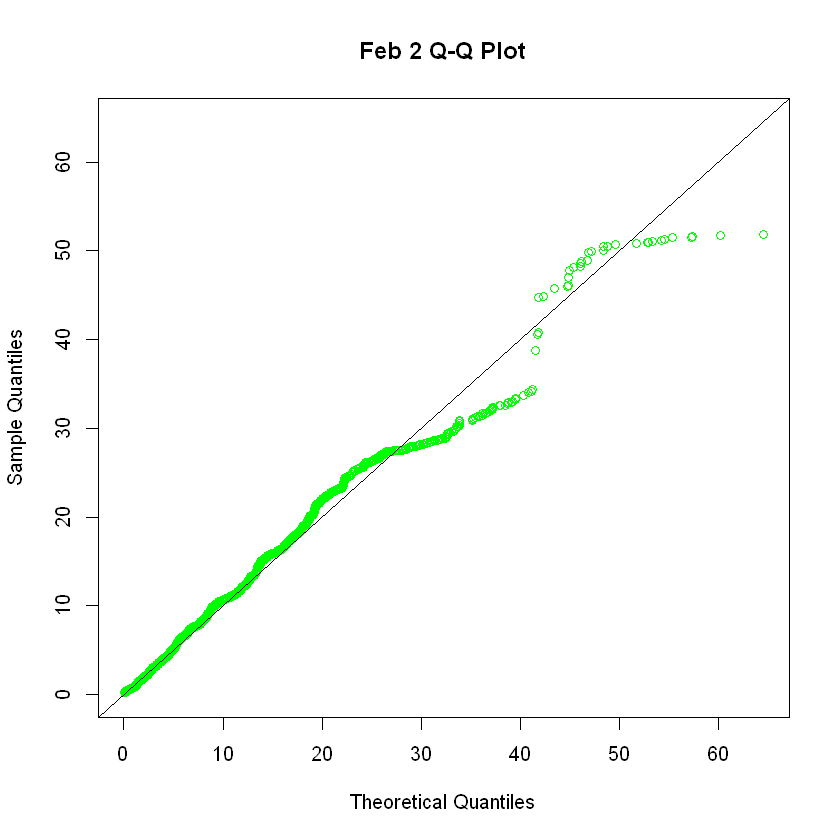

In [281]:
wFeb2Max <- max( max( dfFeb2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfFeb2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Feb 2 Q-Q Plot",
        xlim=c(0,wFeb2Max), ylim=c(0,wFeb2Max) )
abline( 0, 1)

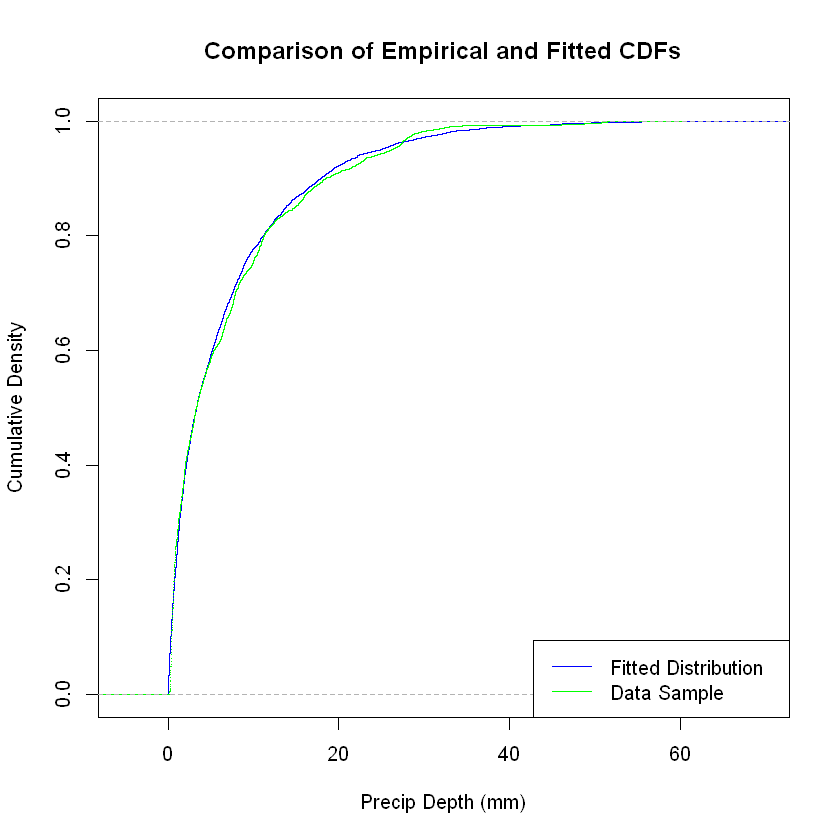

In [282]:
x <- seq(0,wFeb2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfFeb2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [283]:
MonDistDF[8, ] <- list( 2, 2, fdGM_Feb2_shape, fdGM_Feb2_rate, fdGM_Feb2_llike, fdGM_Feb2_mean,
                        fdGM_Feb2_var, fdGM_Feb2_KSStat, fdGM_Feb2_KSp, fdME_Feb2_rate1,
                        fdME_Feb2_rate2, fdME_Feb2_lambda, fdME_Feb2_mean1, fdME_Feb2_mean2,
                        fdME_Feb2_mean, fdME_Feb2_var1, fdME_Feb2_var2, fdME_Feb2_var,
                        fdME_Feb2_llike, fdME_Feb2_KSStat, fdME_Feb2_KSp )

#### Region 3

**Gamma**

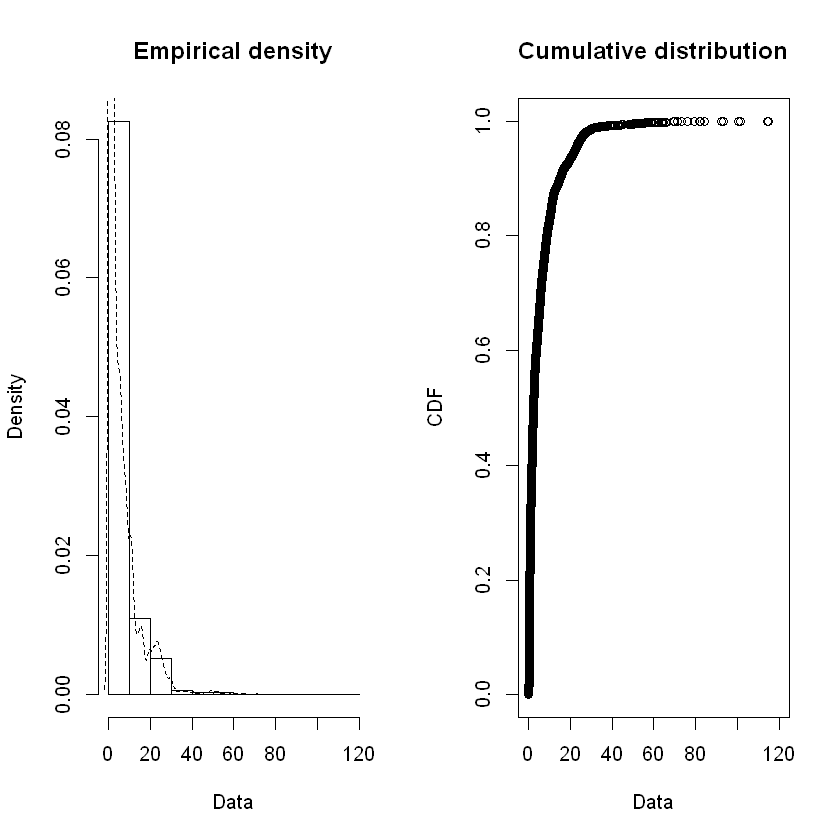

In [284]:
plotdist( dfFeb3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  114.6 
median:  2.46 
mean:  5.644054 
estimated sd:  8.045903 
estimated skewness:  3.569241 
estimated kurtosis:  25.24333 

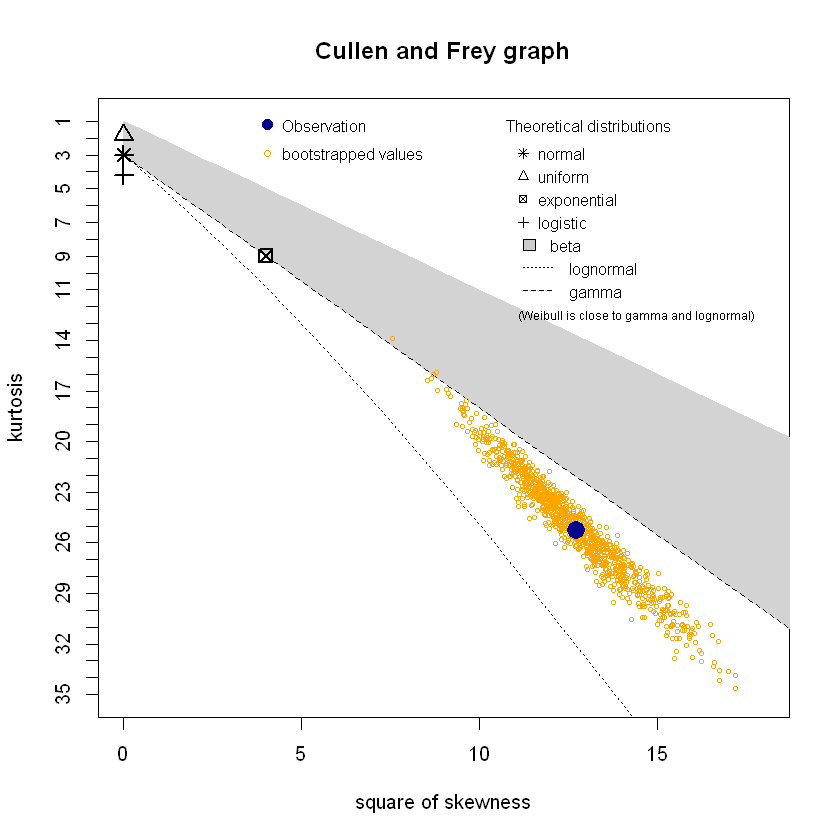

In [285]:
descdist( dfFeb3$Precip_mm, boot=1000 )

In [286]:
fd_GM_Feb3 <- fitdist( dfFeb3$Precip_mm, "gamma" )

In [287]:
summary( fd_GM_Feb3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7506907 0.007997119
rate  0.1329854 0.001955455
Loglikelihood:  -35003.7   AIC:  70011.39   BIC:  70026.33 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7244155
rate  0.7244155 1.0000000


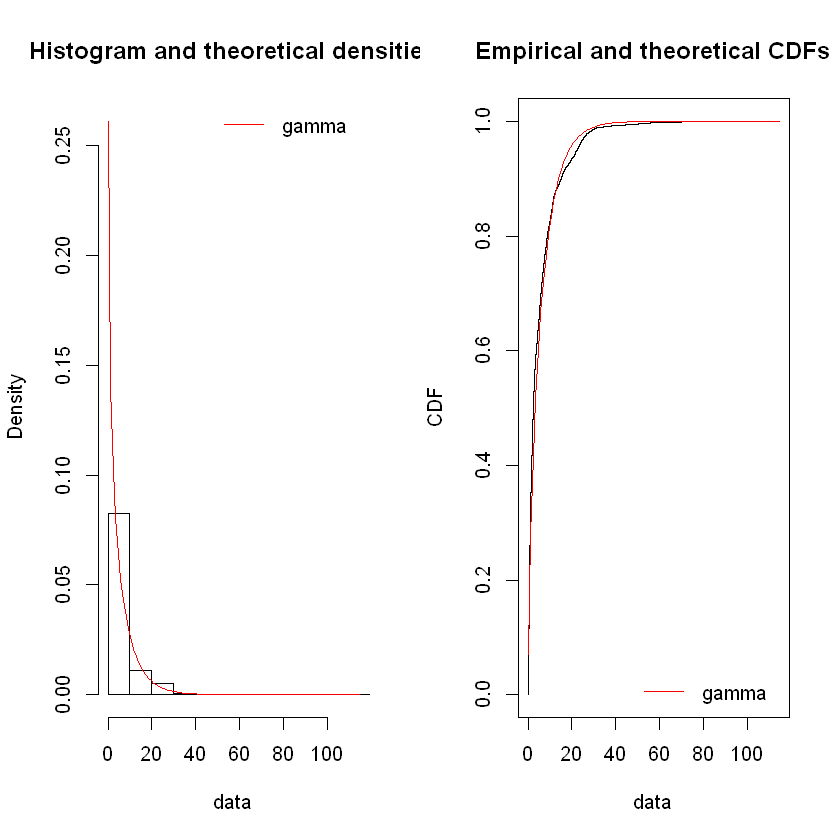

In [288]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Feb3)
#qqcomp(fd_GM_Feb3)
cdfcomp(fd_GM_Feb3)
#ppcomp(fd_GM_Feb3)

In [289]:
fdGM_Feb3_shape <- fd_GM_Feb3$estimate[["shape"]]
fdGM_Feb3_rate <- fd_GM_Feb3$estimate[["rate"]]
fdGM_Feb3_llike <- fd_GM_Feb3$loglik
fdGM_Feb3_mean <- fdGM_Feb3_shape / fdGM_Feb3_rate
fdGM_Feb3_var <- fdGM_Feb3_shape / ( fdGM_Feb3_rate ^ 2 )
cat(" Feb 3 shape: ", fdGM_Feb3_shape, "\n", "Feb 3 rate: ", fdGM_Feb3_rate, 
    "\n", "Feb 3 loglikelihood: ", fdGM_Feb3_llike, "\n", 
    "Feb 3 mean: ", fdGM_Feb3_mean, "\n",
    "Feb 3 variance: ", fdGM_Feb3_var, "\n" )

 Feb 3 shape:  0.7506907 
 Feb 3 rate:  0.1329854 
 Feb 3 loglikelihood:  -35003.7 
 Feb 3 mean:  5.644911 
 Feb 3 variance:  42.4476 


In [290]:
statRes <- gofstat( fd_GM_Feb3, fitnames=c("Gamma") )

In [291]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.09318215
Cramer-von Mises statistic    36.53524619
Anderson-Darling statistic   214.92208650

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 70011.39
Bayesian Information Criterion 70026.33


In [292]:
ksRes <- ks.test( dfFeb3$Precip_mm, "pgamma", shape=fdGM_Feb3_shape, rate=fdGM_Feb3_rate )

Warning message in ks.test(dfFeb3$Precip_mm, "pgamma", shape = fdGM_Feb3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [293]:
fdGM_Feb3_KSStat <- ksRes$statistic
fdGM_Feb3_KSp <- ksRes$p.value
cat(" Feb 3 K-S stat: ", fdGM_Feb3_KSStat, "\n",
    "Feb 3 K-S p-value: ", fdGM_Feb3_KSp )

 Feb 3 K-S stat:  0.09318215 
 Feb 3 K-S p-value:  0

**Mixed exponential**

In [294]:
fd_ME_Feb3 <- expRMM_EM( dfFeb3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfFeb3$Precip_mm), 1.0/mean(dfFeb3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 148 


In [295]:
summary( fd_ME_Feb3 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.469454 0.530546
rate   0.600999 0.109100
loglik at estimate:  -34310.11 
0 % of the data right censored


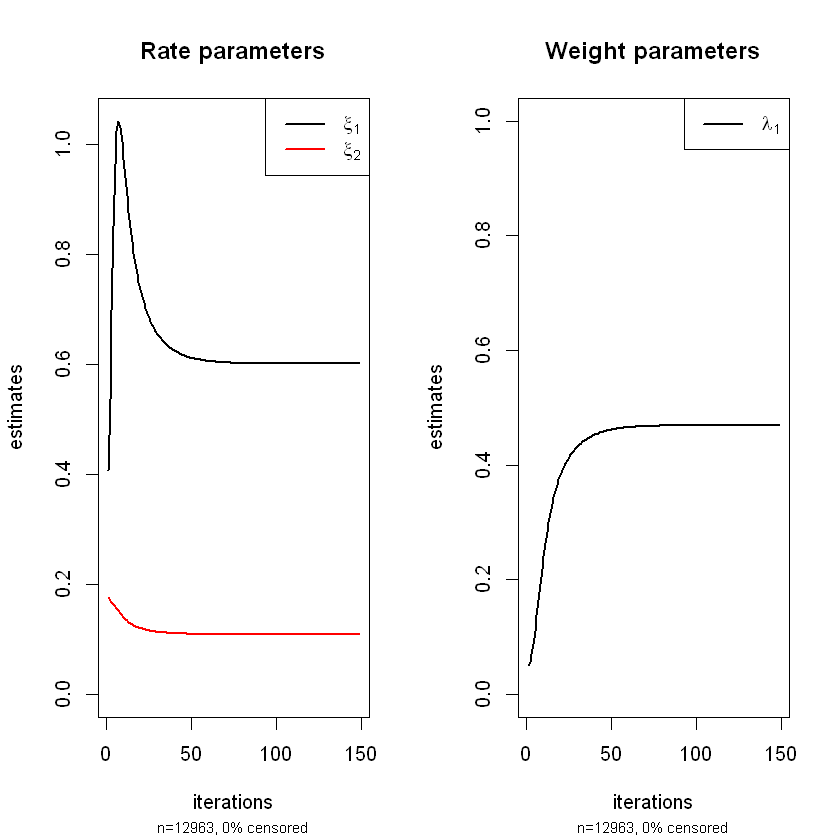

In [296]:
plotexpRMM( fd_ME_Feb3, lwd=2 )

In [297]:
fdME_Feb3_rate1 <- fd_ME_Feb3$rate[[1]]
fdME_Feb3_rate2 <- fd_ME_Feb3$rate[[2]]
fdME_Feb3_lambda <- fd_ME_Feb3$lambda[[1]]
fdME_Feb3_mean1 <- 1.0 / fdME_Feb3_rate1
fdME_Feb3_mean2 <- 1.0 / fdME_Feb3_rate2
fdME_Feb3_mean <- ( (fdME_Feb3_lambda * fdME_Feb3_mean1) + 
                    ( ( 1.0 - fdME_Feb3_lambda) * fdME_Feb3_mean2 ) )
fdME_Feb3_var1 <- 1.0 / (fdME_Feb3_rate1 ^ 2)
fdME_Feb3_var2 <- 1.0 / (fdME_Feb3_rate2 ^ 2)
fdME_Feb3_var <- ( (fdME_Feb3_lambda * ( fdME_Feb3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Feb3_lambda) * (fdME_Feb3_mean2 ^ 2) ) + 
                   ( fdME_Feb3_lambda * ( 1.0 - fdME_Feb3_lambda) * 
                       ( fdME_Feb3_mean1 - fdME_Feb3_mean2 )^2 ) )
fdME_Feb3_llike <- fd_ME_Feb3$loglik
cat(" Feb 3 rate1: ", fdME_Feb3_rate1, "\n", 
    "Feb 3 rate2: ", fdME_Feb3_rate2, "\n",
    "Feb 3 lambda: ", fdME_Feb3_lambda, "\n",
    "Feb 3 mean1: ", fdME_Feb3_mean1, "\n",
    "Feb 3 mean2: ", fdME_Feb3_mean2, "\n",
    "Feb 3 mean: ", fdME_Feb3_mean, "\n",
    "Feb 3 var1: ", fdME_Feb3_var1, "\n",
    "Feb 3 var2: ", fdME_Feb3_var2, "\n",
    "Feb 3 var: ", fdME_Feb3_var, "\n",
    "Feb 3 loglikelihood: ", fdME_Feb3_llike, "\n" )

 Feb 3 rate1:  0.6009986 
 Feb 3 rate2:  0.1091 
 Feb 3 lambda:  0.4694544 
 Feb 3 mean1:  1.663897 
 Feb 3 mean2:  9.165904 
 Feb 3 mean:  5.644054 
 Feb 3 var1:  2.768554 
 Feb 3 var2:  84.0138 
 Feb 3 var:  59.89037 
 Feb 3 loglikelihood:  -34310.11 


In [298]:
tvals <- rexpmix(length(dfFeb3$Precip_mm), fd_ME_Feb3$lambda, fd_ME_Feb3$rate )

In [299]:
ksRes <- ks.test( dfFeb3$Precip_mm, tvals )

Warning message in ks.test(dfFeb3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [300]:
fdME_Feb3_KSStat <- ksRes$statistic
fdME_Feb3_KSp <- ksRes$p.value
cat(" Feb 3 K-S stat: ", fdME_Feb3_KSStat, "\n",
    "Feb 3 K-S p-value: ", fdME_Feb3_KSp )

 Feb 3 K-S stat:  0.07081694 
 Feb 3 K-S p-value:  0

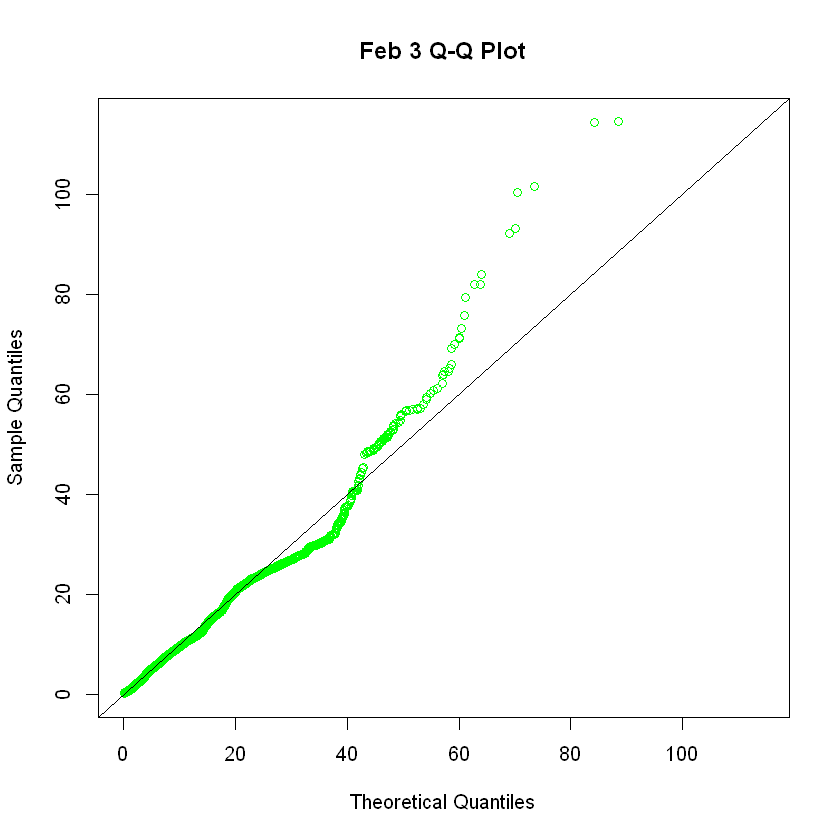

In [301]:
wFeb3Max <- max( max( dfFeb3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfFeb3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Feb 3 Q-Q Plot",
        xlim=c(0,wFeb3Max), ylim=c(0,wFeb3Max) )
abline( 0, 1)

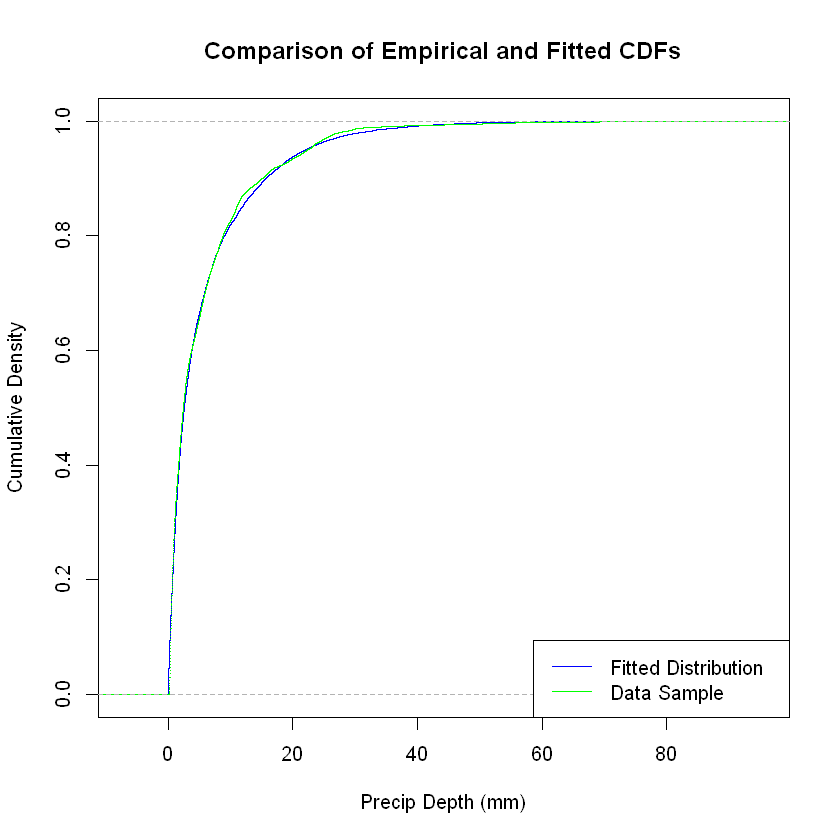

In [302]:
x <- seq(0,wFeb3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfFeb3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [303]:
MonDistDF[9, ] <- list( 2, 3, fdGM_Feb3_shape, fdGM_Feb3_rate, fdGM_Feb3_llike, fdGM_Feb3_mean,
                        fdGM_Feb3_var, fdGM_Feb3_KSStat, fdGM_Feb3_KSp, fdME_Feb3_rate1,
                        fdME_Feb3_rate2, fdME_Feb3_lambda, fdME_Feb3_mean1, fdME_Feb3_mean2,
                        fdME_Feb3_mean, fdME_Feb3_var1, fdME_Feb3_var2, fdME_Feb3_var,
                        fdME_Feb3_llike, fdME_Feb3_KSStat, fdME_Feb3_KSp )

#### Region 4

**Gamma**

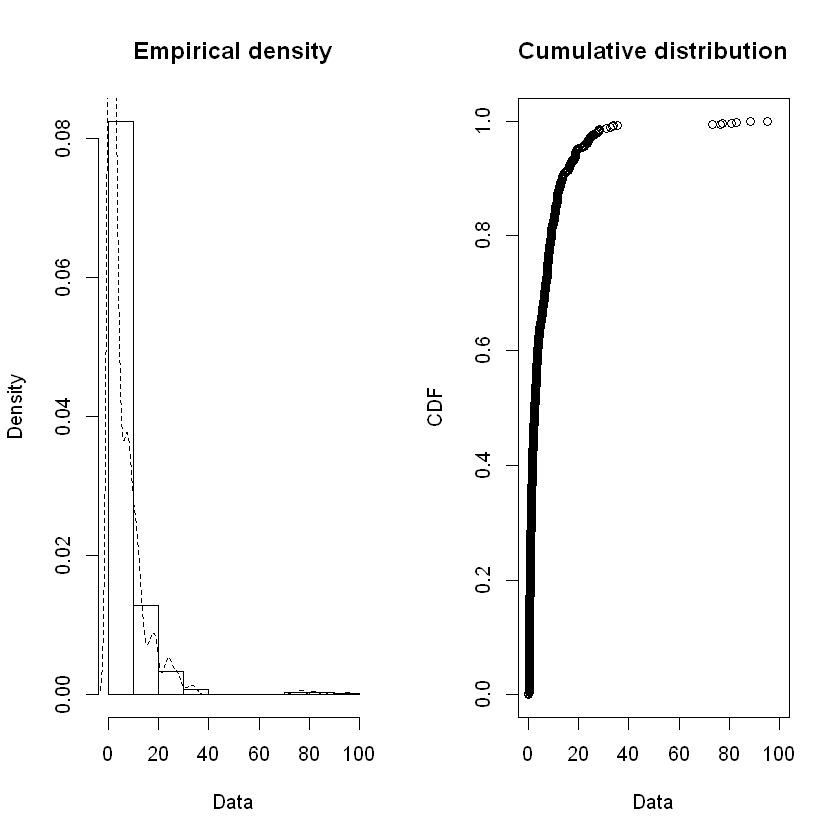

In [304]:
plotdist( dfFeb4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  95.04 
median:  2.51 
mean:  5.718706 
estimated sd:  8.951337 
estimated skewness:  4.967128 
estimated kurtosis:  39.96438 

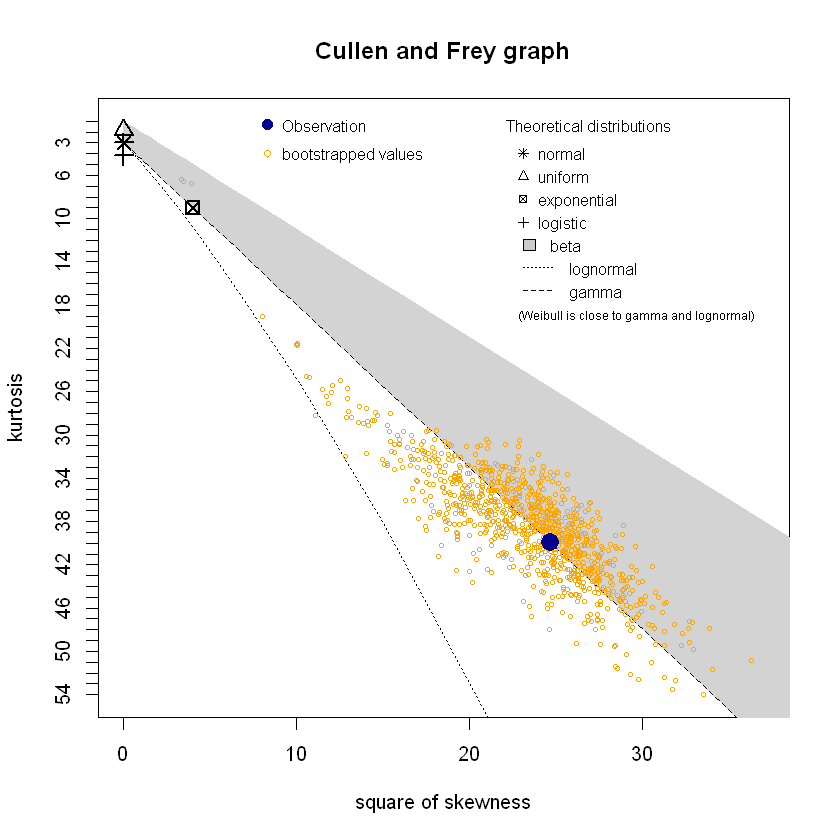

In [305]:
descdist( dfFeb4$Precip_mm, boot=1000 )

In [306]:
fd_GM_Feb4 <- fitdist( dfFeb4$Precip_mm, "gamma" )

In [307]:
summary( fd_GM_Feb4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7437103 0.028219409
rate  0.1300462 0.006829047
Loglikelihood:  -2765.481   AIC:  5534.962   BIC:  5544.817 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7225018
rate  0.7225018 1.0000000


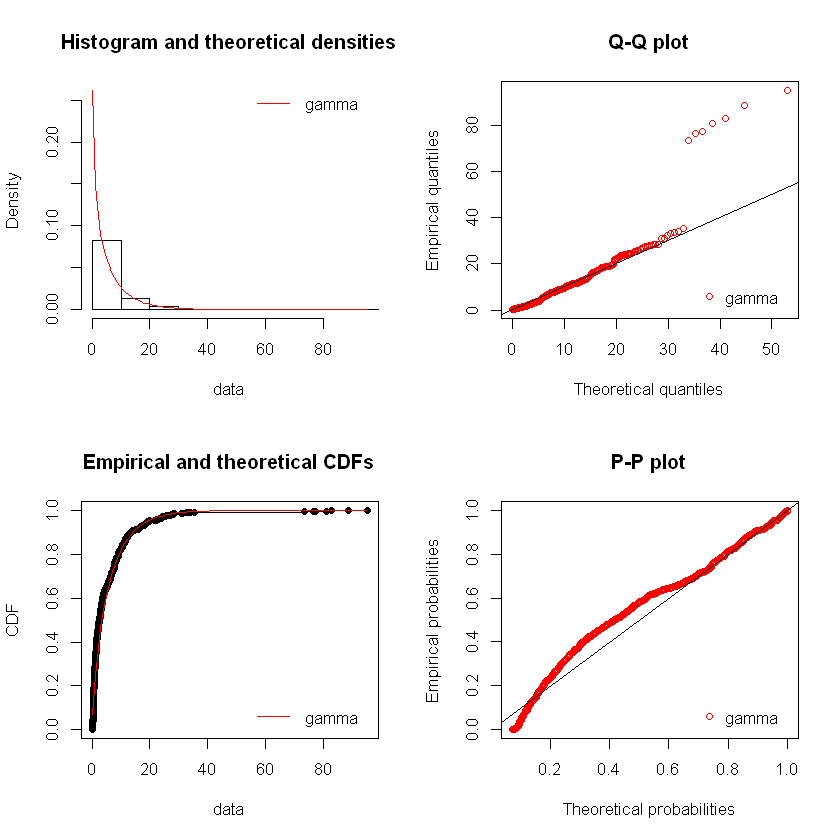

In [308]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Feb4)
qqcomp(fd_GM_Feb4)
cdfcomp(fd_GM_Feb4)
ppcomp(fd_GM_Feb4)

In [309]:
fdGM_Feb4_shape <- fd_GM_Feb4$estimate[["shape"]]
fdGM_Feb4_rate <- fd_GM_Feb4$estimate[["rate"]]
fdGM_Feb4_llike <- fd_GM_Feb4$loglik
fdGM_Feb4_mean <- fdGM_Feb4_shape / fdGM_Feb4_rate
fdGM_Feb4_var <- fdGM_Feb4_shape / ( fdGM_Feb4_rate ^ 2 )
cat(" Feb 4 shape: ", fdGM_Feb4_shape, "\n", "Feb 4 rate: ", fdGM_Feb4_rate, 
    "\n", "Feb 4 loglikelihood: ", fdGM_Feb4_llike, "\n", 
    "Feb 4 mean: ", fdGM_Feb4_mean, "\n",
    "Feb 4 variance: ", fdGM_Feb4_var, "\n" )

 Feb 4 shape:  0.7437103 
 Feb 4 rate:  0.1300462 
 Feb 4 loglikelihood:  -2765.481 
 Feb 4 mean:  5.718815 
 Feb 4 variance:  43.97526 


In [310]:
statRes <- gofstat( fd_GM_Feb4, fitnames=c("Gamma") )

In [311]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.09485395
Cramer-von Mises statistic    2.84152503
Anderson-Darling statistic   16.63309732

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 5534.962
Bayesian Information Criterion 5544.817


In [312]:
ksRes <- ks.test( dfFeb4$Precip_mm, "pgamma", shape=fdGM_Feb4_shape, rate=fdGM_Feb4_rate )

Warning message in ks.test(dfFeb4$Precip_mm, "pgamma", shape = fdGM_Feb4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [313]:
fdGM_Feb4_KSStat <- ksRes$statistic
fdGM_Feb4_KSp <- ksRes$p.value
cat(" Feb 4 K-S stat: ", fdGM_Feb4_KSStat, "\n",
    "Feb 4 K-S p-value: ", fdGM_Feb4_KSp )

 Feb 4 K-S stat:  0.09485395 
 Feb 4 K-S p-value:  2.136976e-08

**Mixed exponential**

In [314]:
fd_ME_Feb4 <- expRMM_EM( dfFeb4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfFeb4$Precip_mm), 1.0/mean(dfFeb4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 102 


In [315]:
summary( fd_ME_Feb4 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.430452 0.569548
rate   0.673563 0.112124
loglik at estimate:  -2712.804 
0 % of the data right censored


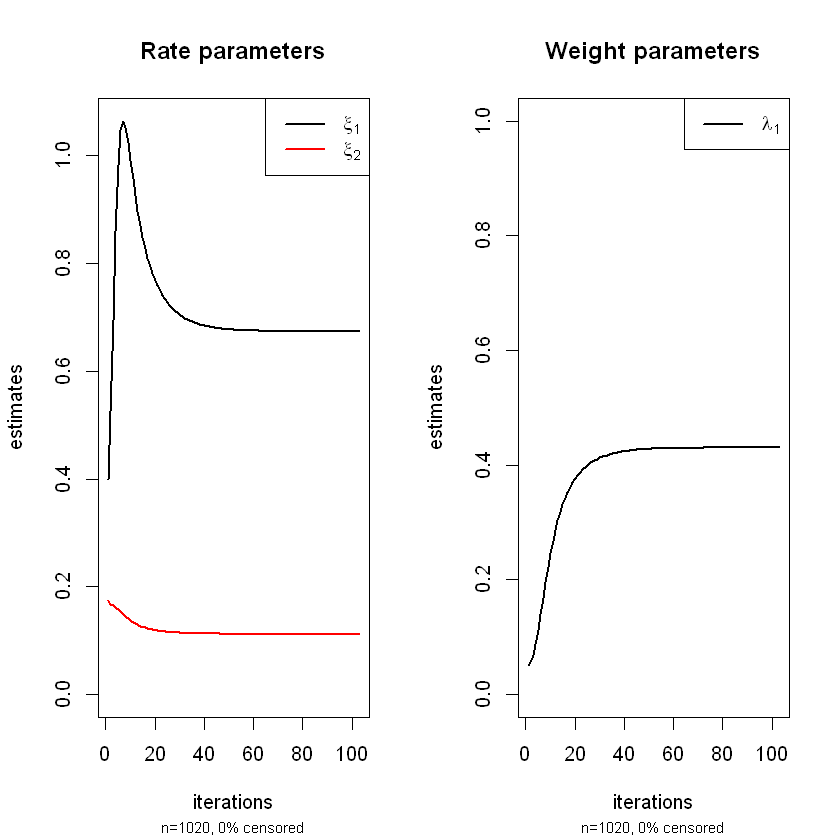

In [316]:
plotexpRMM( fd_ME_Feb4, lwd=2 )

In [317]:
fdME_Feb4_rate1 <- fd_ME_Feb4$rate[[1]]
fdME_Feb4_rate2 <- fd_ME_Feb4$rate[[2]]
fdME_Feb4_lambda <- fd_ME_Feb4$lambda[[1]]
fdME_Feb4_mean1 <- 1.0 / fdME_Feb4_rate1
fdME_Feb4_mean2 <- 1.0 / fdME_Feb4_rate2
fdME_Feb4_mean <- ( (fdME_Feb4_lambda * fdME_Feb4_mean1) + 
                    ( ( 1.0 - fdME_Feb4_lambda) * fdME_Feb4_mean2 ) )
fdME_Feb4_var1 <- 1.0 / (fdME_Feb4_rate1 ^ 2)
fdME_Feb4_var2 <- 1.0 / (fdME_Feb4_rate2 ^ 2)
fdME_Feb4_var <- ( (fdME_Feb4_lambda * ( fdME_Feb4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Feb4_lambda) * (fdME_Feb4_mean2 ^ 2) ) + 
                   ( fdME_Feb4_lambda * ( 1.0 - fdME_Feb4_lambda) * 
                       ( fdME_Feb4_mean1 - fdME_Feb4_mean2 )^2 ) )
fdME_Feb4_llike <- fd_ME_Feb4$loglik
cat(" Feb 4 rate1: ", fdME_Feb4_rate1, "\n", 
    "Feb 4 rate2: ", fdME_Feb4_rate2, "\n",
    "Feb 4 lambda: ", fdME_Feb4_lambda, "\n",
    "Feb 4 mean1: ", fdME_Feb4_mean1, "\n",
    "Feb 4 mean2: ", fdME_Feb4_mean2, "\n",
    "Feb 4 mean: ", fdME_Feb4_mean, "\n",
    "Feb 4 var1: ", fdME_Feb4_var1, "\n",
    "Feb 4 var2: ", fdME_Feb4_var2, "\n",
    "Feb 4 var: ", fdME_Feb4_var, "\n",
    "Feb 4 loglikelihood: ", fdME_Feb4_llike, "\n" )

 Feb 4 rate1:  0.6735626 
 Feb 4 rate2:  0.1121238 
 Feb 4 lambda:  0.4304518 
 Feb 4 mean1:  1.484643 
 Feb 4 mean2:  8.918717 
 Feb 4 mean:  5.718706 
 Feb 4 var1:  2.204165 
 Feb 4 var2:  79.54351 
 Feb 4 var:  59.80169 
 Feb 4 loglikelihood:  -2712.804 


In [318]:
tvals <- rexpmix(length(dfFeb4$Precip_mm), fd_ME_Feb4$lambda, fd_ME_Feb4$rate )

In [319]:
ksRes <- ks.test( dfFeb4$Precip_mm, tvals )

Warning message in ks.test(dfFeb4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [320]:
fdME_Feb4_KSStat <- ksRes$statistic
fdME_Feb4_KSp <- ksRes$p.value
cat(" Feb 4 K-S stat: ", fdME_Feb4_KSStat, "\n",
    "Feb 4 K-S p-value: ", fdME_Feb4_KSp )

 Feb 4 K-S stat:  0.08039216 
 Feb 4 K-S p-value:  0.002742159

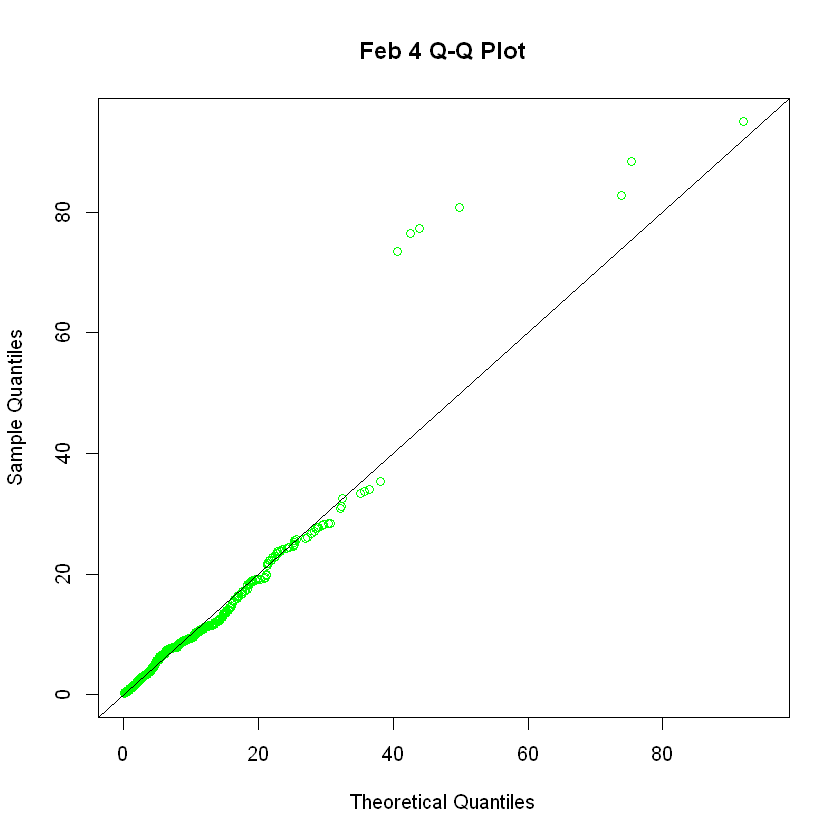

In [321]:
wFeb4Max <- max( max( dfFeb4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfFeb4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Feb 4 Q-Q Plot",
        xlim=c(0,wFeb4Max), ylim=c(0,wFeb4Max) )
abline( 0, 1)

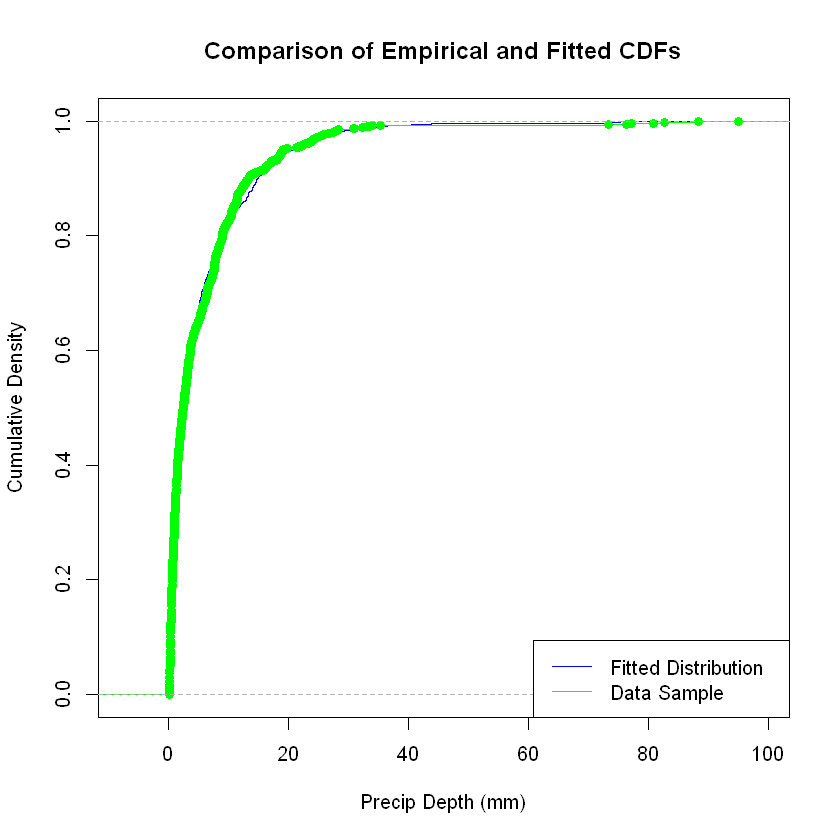

In [322]:
x <- seq(0,wFeb4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfFeb4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [323]:
MonDistDF[10, ] <- list( 2, 4, fdGM_Feb4_shape, fdGM_Feb4_rate, fdGM_Feb4_llike, fdGM_Feb4_mean,
                        fdGM_Feb4_var, fdGM_Feb4_KSStat, fdGM_Feb4_KSp, fdME_Feb4_rate1,
                        fdME_Feb4_rate2, fdME_Feb4_lambda, fdME_Feb4_mean1, fdME_Feb4_mean2,
                        fdME_Feb4_mean, fdME_Feb4_var1, fdME_Feb4_var2, fdME_Feb4_var,
                        fdME_Feb4_llike, fdME_Feb4_KSStat, fdME_Feb4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

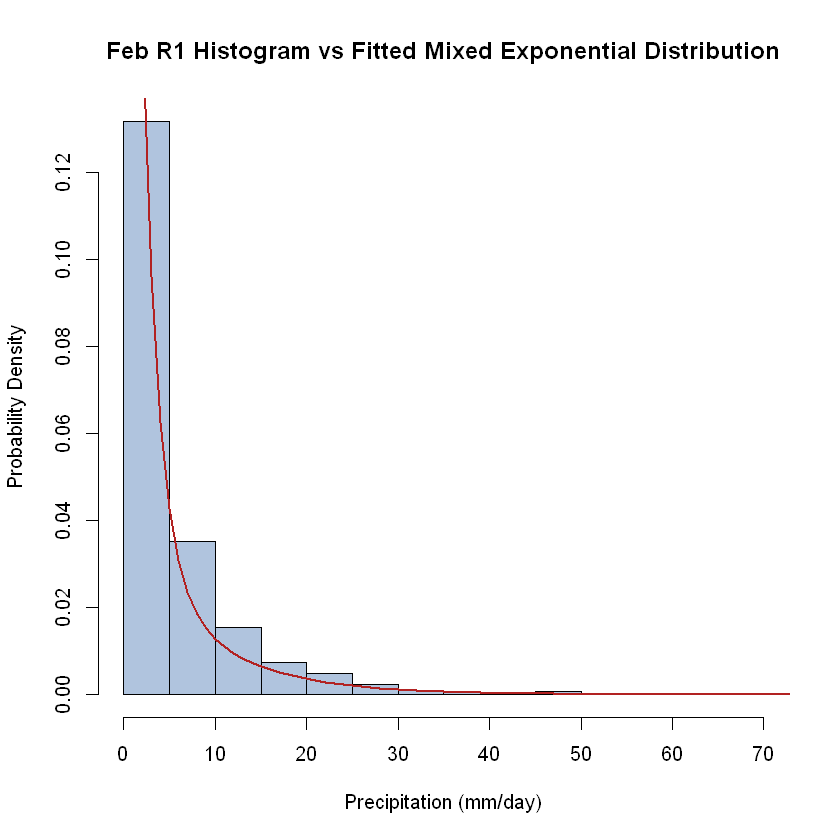

In [324]:
xVals <- seq(1, wFeb1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Feb1_lambda, spec1="exp", arg1=list(rate=fdME_Feb1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Feb1_rate2) )
hist( dfFeb1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Feb R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

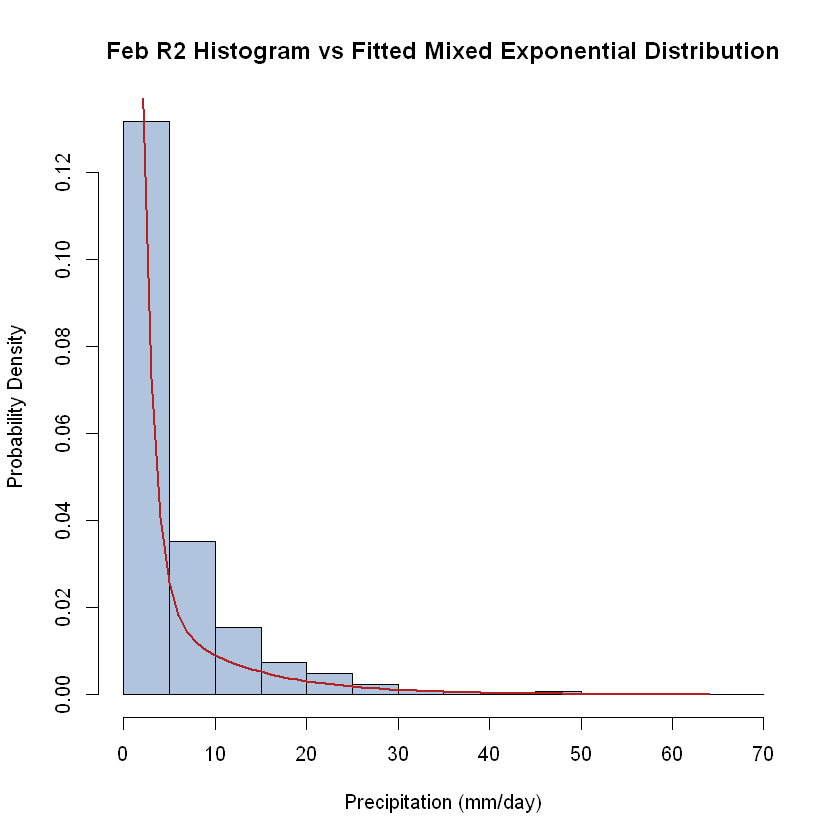

In [325]:
xVals <- seq(1, wFeb2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Feb2_lambda, spec1="exp", arg1=list(rate=fdME_Feb2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Feb2_rate2) )
hist( dfFeb1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Feb R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

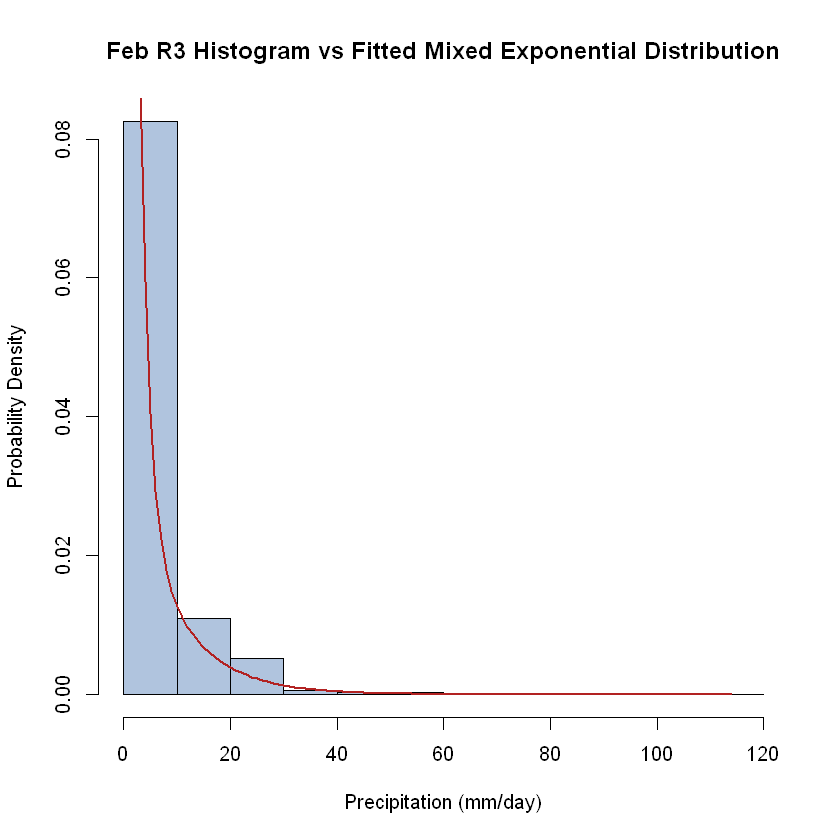

In [326]:
xVals <- seq(1, wFeb3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Feb3_lambda, spec1="exp", arg1=list(rate=fdME_Feb3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Feb3_rate2) )
hist( dfFeb3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Feb R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

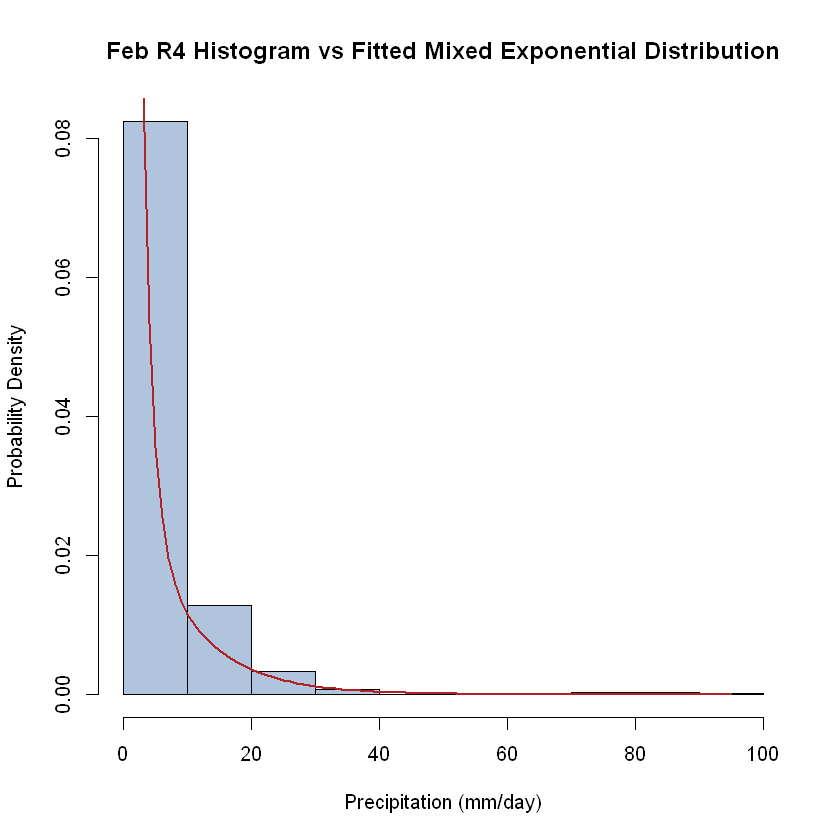

In [327]:
xVals <- seq(1, wFeb4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Feb4_lambda, spec1="exp", arg1=list(rate=fdME_Feb4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Feb4_rate2) )
hist( dfFeb4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Feb R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Mar

#### All

**Gamma**

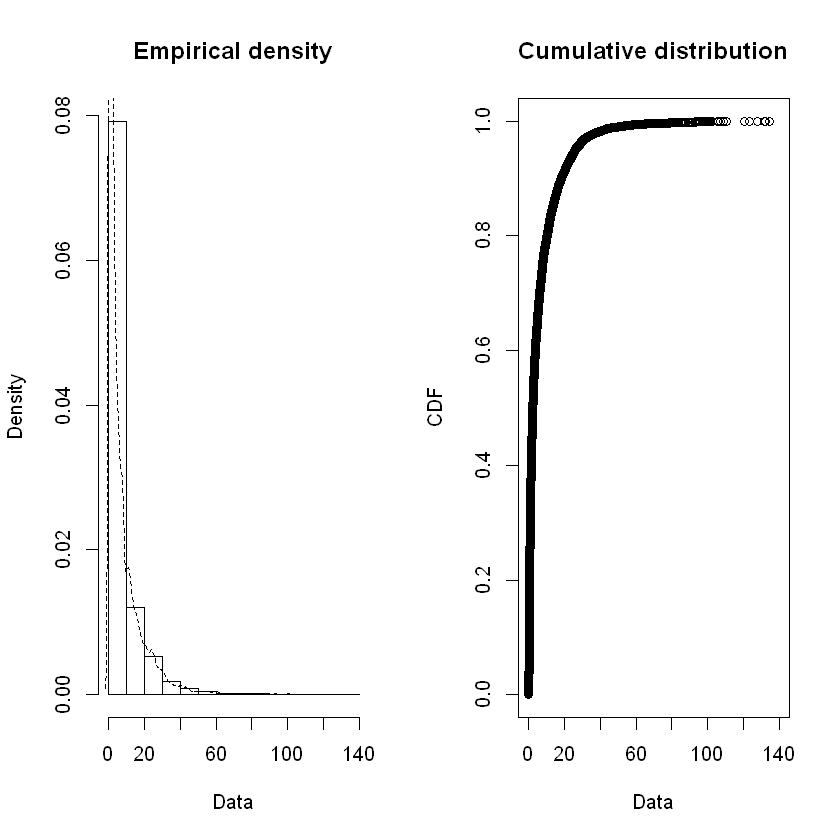

In [328]:
plotdist( dfMar$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  134.17 
median:  2.47 
mean:  6.637155 
estimated sd:  10.43212 
estimated skewness:  3.67328 
estimated kurtosis:  23.56114 

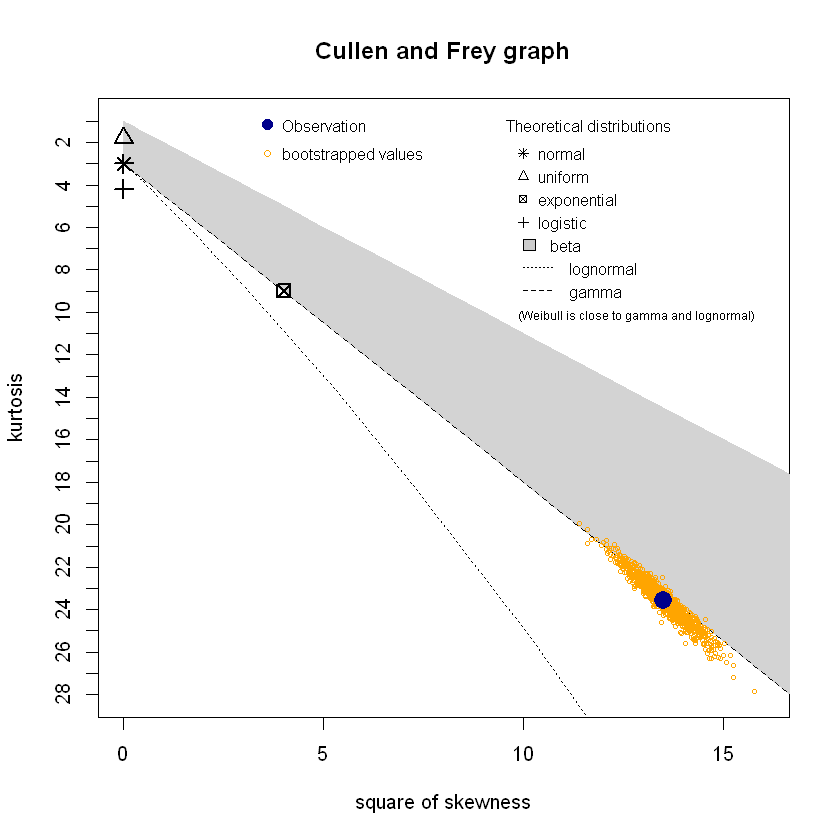

In [329]:
descdist( dfMar$Precip_mm, boot=1000 )

In [330]:
fd_GM_MarA <- fitdist( dfMar$Precip_mm, "gamma" )

In [331]:
summary( fd_GM_MarA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
shape 0.6637984 0.0041463547
rate  0.1000231 0.0008940191
Loglikelihood:  -104144.3   AIC:  208292.5   BIC:  208309.6 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6987334
rate  0.6987334 1.0000000


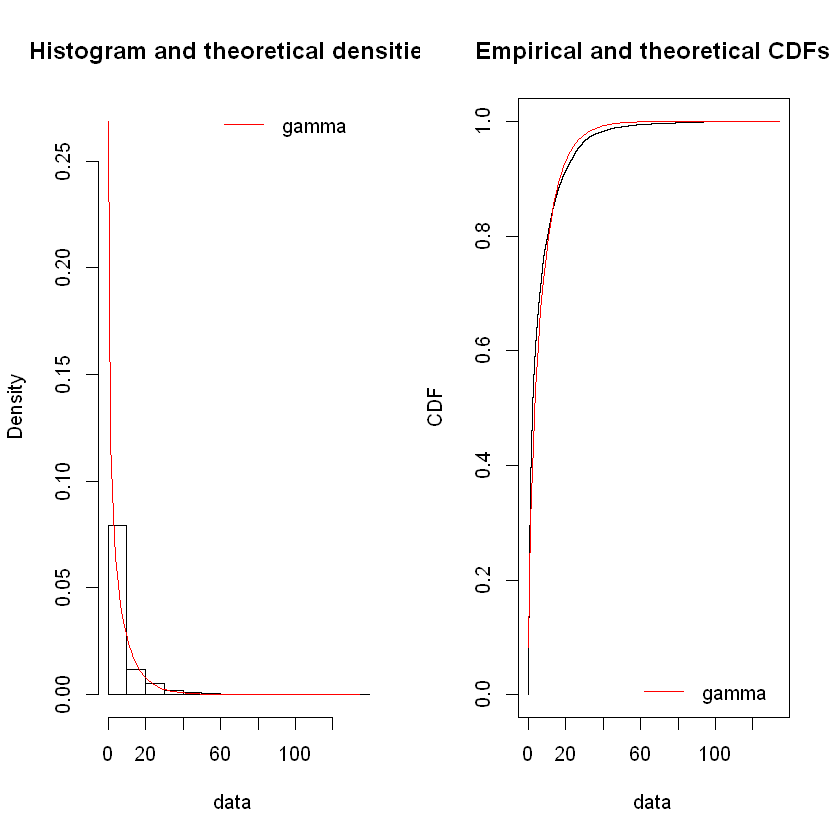

In [332]:
par(mfrow = c(1, 2))
denscomp(fd_GM_MarA)
#qqcomp(fd_GM_MarA)
cdfcomp(fd_GM_MarA)
#ppcomp(fd_GM_MarA)

In [333]:
fdGM_MarA_shape <- fd_GM_MarA$estimate[["shape"]]
fdGM_MarA_rate <- fd_GM_MarA$estimate[["rate"]]
fdGM_MarA_llike <- fd_GM_MarA$loglik
fdGM_MarA_mean <- fdGM_MarA_shape / fdGM_MarA_rate
fdGM_MarA_var <- fdGM_MarA_shape / ( fdGM_MarA_rate ^ 2 )
cat(" Mar A shape: ", fdGM_MarA_shape, "\n", "Mar A rate: ", fdGM_MarA_rate, 
    "\n", "Mar A loglikelihood: ", fdGM_MarA_llike, "\n", 
    "Mar A mean: ", fdGM_MarA_mean, "\n",
    "Mar A variance: ", fdGM_MarA_var, "\n" )

 Mar A shape:  0.6637984 
 Mar A rate:  0.1000231 
 Mar A loglikelihood:  -104144.3 
 Mar A mean:  6.63645 
 Mar A variance:  66.34917 


In [334]:
statRes <- gofstat( fd_GM_MarA, fitnames=c("Gamma") )

In [335]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1063251
Cramer-von Mises statistic   146.0192161
Anderson-Darling statistic   821.5745241

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 208292.5
Bayesian Information Criterion 208309.6


In [336]:
ksRes <- ks.test( dfMar$Precip_mm, "pgamma", shape=fdGM_MarA_shape, rate=fdGM_MarA_rate )

Warning message in ks.test(dfMar$Precip_mm, "pgamma", shape = fdGM_MarA_shape, rate = fdGM_MarA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [337]:
fdGM_MarA_KSStat <- ksRes$statistic
fdGM_MarA_KSp <- ksRes$p.value
cat(" Mar A K-S stat: ", fdGM_MarA_KSStat, "\n",
    "Mar A K-S p-value: ", fdGM_MarA_KSp )

 Mar A K-S stat:  0.1063251 
 Mar A K-S p-value:  0

**Mixed Exponential**

In [338]:
fd_ME_MarA <- expRMM_EM( dfMar$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfMar$Precip_mm), 1.0/mean(dfMar$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 99 


In [339]:
summary( fd_ME_MarA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.522682 0.477318
rate   0.602032 0.082739
loglik at estimate:  -101109.7 
0 % of the data right censored


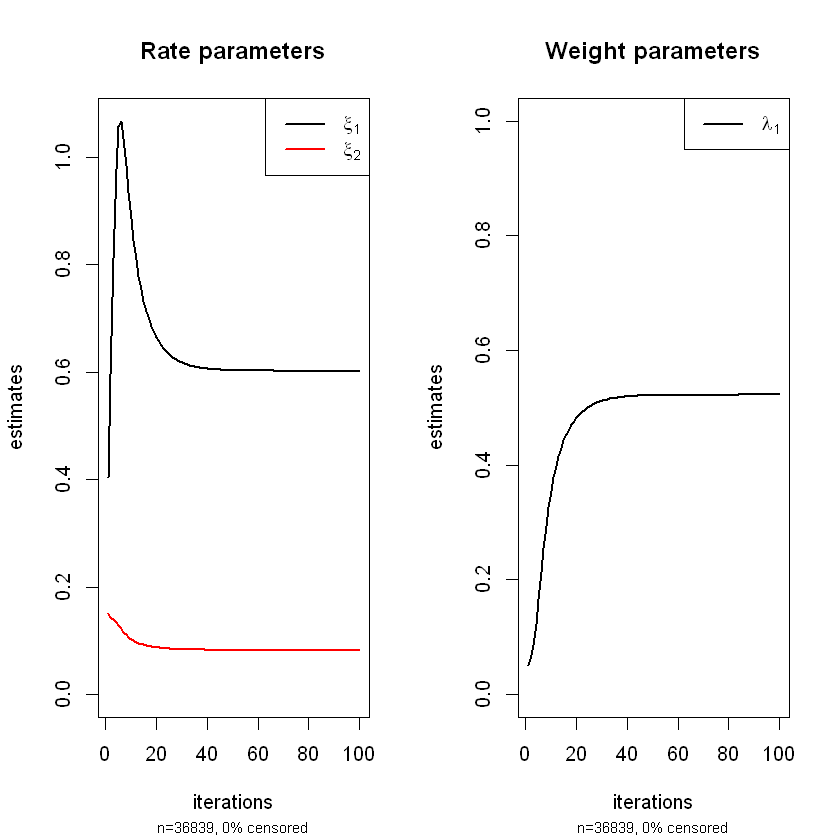

In [340]:
plotexpRMM( fd_ME_MarA, lwd=2 )

In [341]:
fdME_MarA_rate1 <- fd_ME_MarA$rate[[1]]
fdME_MarA_rate2 <- fd_ME_MarA$rate[[2]]
fdME_MarA_lambda <- fd_ME_MarA$lambda[[1]]
fdME_MarA_mean1 <- 1.0 / fdME_MarA_rate1
fdME_MarA_mean2 <- 1.0 / fdME_MarA_rate2
fdME_MarA_mean <- ( (fdME_MarA_lambda * fdME_MarA_mean1) + 
                    ( ( 1.0 - fdME_MarA_lambda) * fdME_MarA_mean2 ) )
fdME_MarA_var1 <- 1.0 / (fdME_MarA_rate1 ^ 2)
fdME_MarA_var2 <- 1.0 / (fdME_MarA_rate2 ^ 2)
fdME_MarA_var <- ( (fdME_MarA_lambda * ( fdME_MarA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_MarA_lambda) * (fdME_MarA_mean2 ^ 2) ) + 
                   ( fdME_MarA_lambda * ( 1.0 - fdME_MarA_lambda) * 
                       ( fdME_MarA_mean1 - fdME_MarA_mean2 )^2 ) )
fdME_MarA_llike <- fd_ME_MarA$loglik
cat(" Mar A rate1: ", fdME_MarA_rate1, "\n", 
    "Mar A rate2: ", fdME_MarA_rate2, "\n",
    "Mar A lambda: ", fdME_MarA_lambda, "\n",
    "Mar A mean1: ", fdME_MarA_mean1, "\n",
    "Mar A mean2: ", fdME_MarA_mean2, "\n",
    "Mar A mean: ", fdME_MarA_mean, "\n",
    "Mar A var1: ", fdME_MarA_var1, "\n",
    "Mar A var2: ", fdME_MarA_var2, "\n",
    "Mar A var: ", fdME_MarA_var, "\n",
    "Mar A loglikelihood: ", fdME_MarA_llike, "\n" )

 Mar A rate1:  0.6020325 
 Mar A rate2:  0.08273898 
 Mar A lambda:  0.5226823 
 Mar A mean1:  1.66104 
 Mar A mean2:  12.0862 
 Mar A mean:  6.637155 
 Mar A var1:  2.759054 
 Mar A var2:  146.0763 
 Mar A var:  98.28199 
 Mar A loglikelihood:  -101109.7 


In [342]:
tvals <- rexpmix(length(dfMar$Precip_mm), fd_ME_MarA$lambda, fd_ME_MarA$rate )

In [343]:
ksRes <- ks.test( dfMar$Precip_mm, tvals )

Warning message in ks.test(dfMar$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [344]:
fdME_MarA_KSStat <- ksRes$statistic
fdME_MarA_KSp <- ksRes$p.value
cat(" Mar A K-S stat: ", fdME_MarA_KSStat, "\n",
    "Mar A K-S p-value: ", fdME_MarA_KSp )

 Mar A K-S stat:  0.06951872 
 Mar A K-S p-value:  0

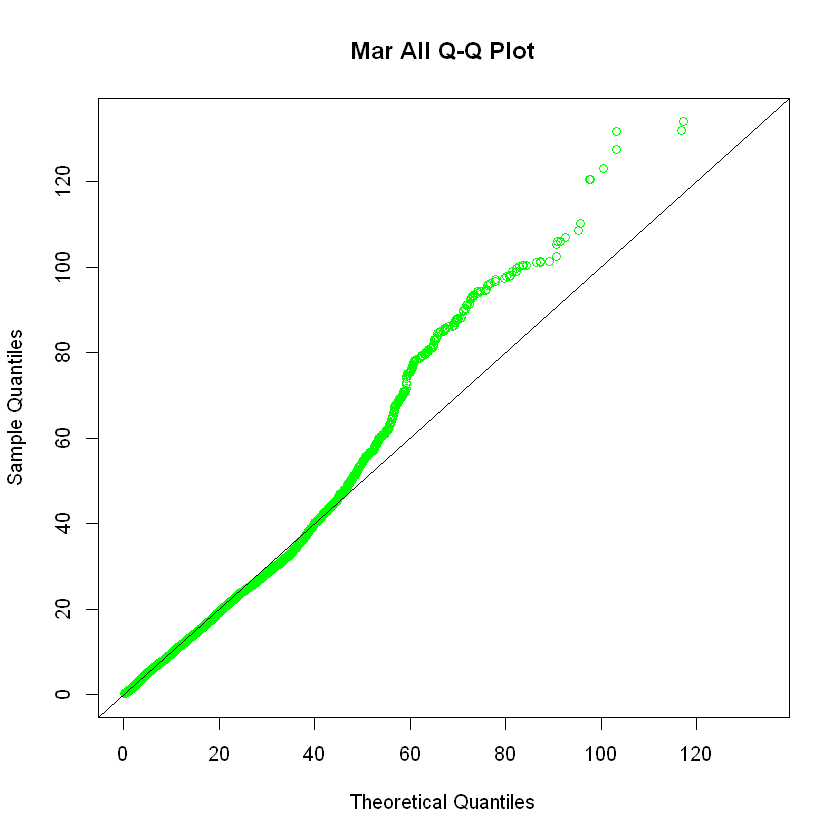

In [345]:
wMarAMax <- max( max( dfMar$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMar$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Mar All Q-Q Plot",
        xlim=c(0,wMarAMax), ylim=c(0,wMarAMax) )
abline( 0, 1)

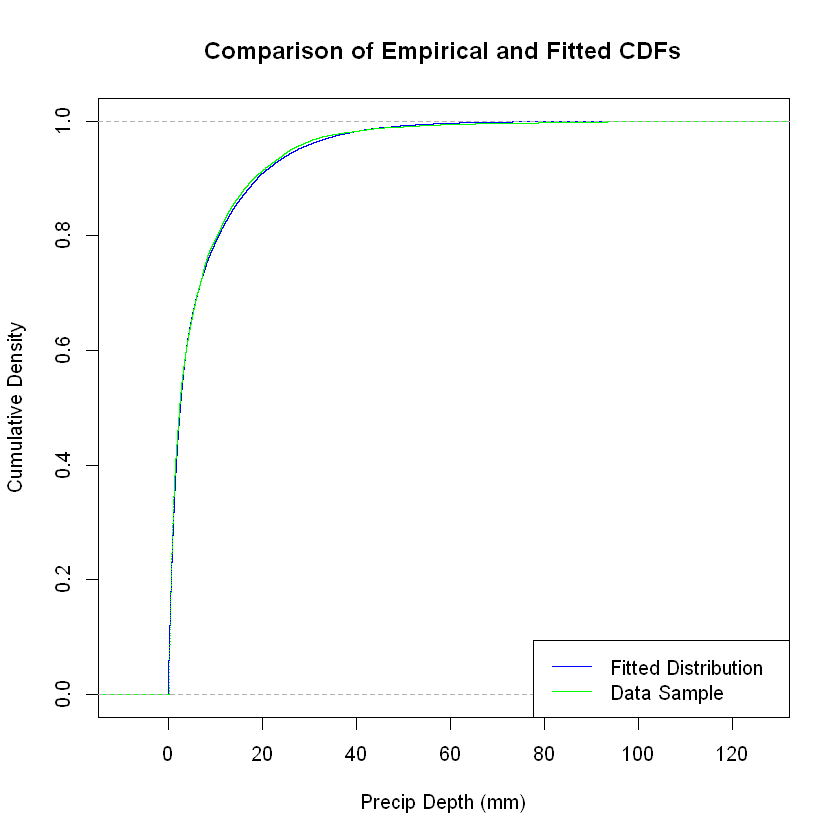

In [346]:
x <- seq(0,wMarAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMar$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [347]:
MonDistDF[11, ] <- list( 3, 0, fdGM_MarA_shape, fdGM_MarA_rate, fdGM_MarA_llike, fdGM_MarA_mean,
                        fdGM_MarA_var, fdGM_MarA_KSStat, fdGM_MarA_KSp, fdME_MarA_rate1,
                        fdME_MarA_rate2, fdME_MarA_lambda, fdME_MarA_mean1, fdME_MarA_mean2,
                        fdME_MarA_mean, fdME_MarA_var1, fdME_MarA_var2, fdME_MarA_var,
                        fdME_MarA_llike, fdME_MarA_KSStat, fdME_MarA_KSp )

#### Region 1

**Gamma**

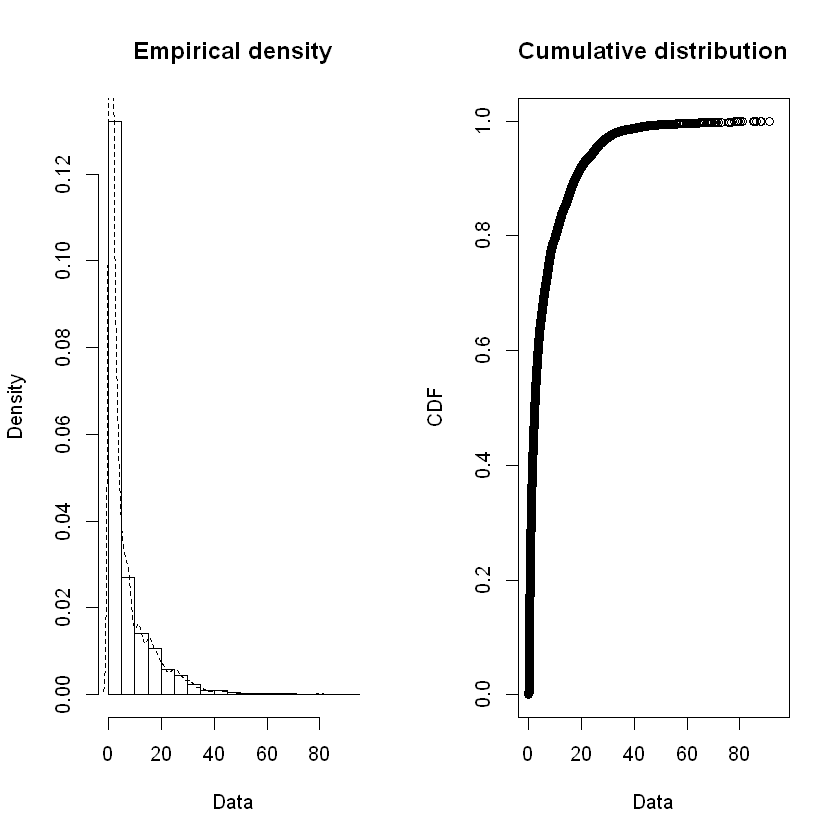

In [348]:
plotdist( dfMar1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  91.35 
median:  2.41 
mean:  6.286146 
estimated sd:  9.27619 
estimated skewness:  3.029466 
estimated kurtosis:  16.31529 

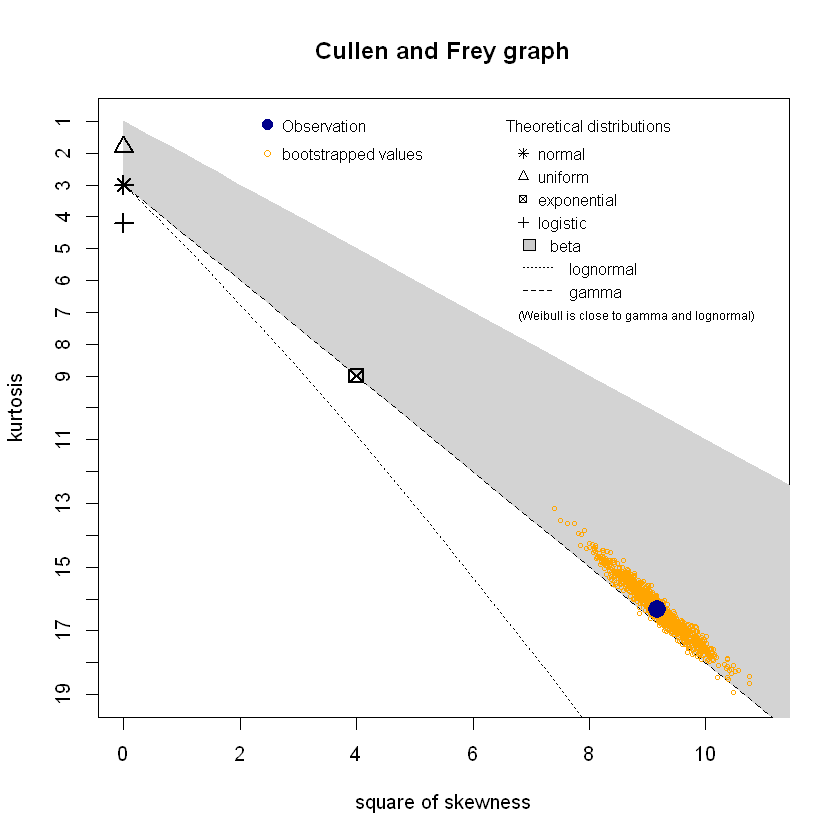

In [349]:
descdist( dfMar1$Precip_mm, boot=1000 )

In [350]:
fd_GM_Mar1 <- fitdist( dfMar1$Precip_mm, "gamma" )

In [351]:
summary( fd_GM_Mar1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.6816512 0.006482336
rate  0.1084416 0.001463892
Loglikelihood:  -44433.62   AIC:  88871.24   BIC:  88886.59 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7043602
rate  0.7043602 1.0000000


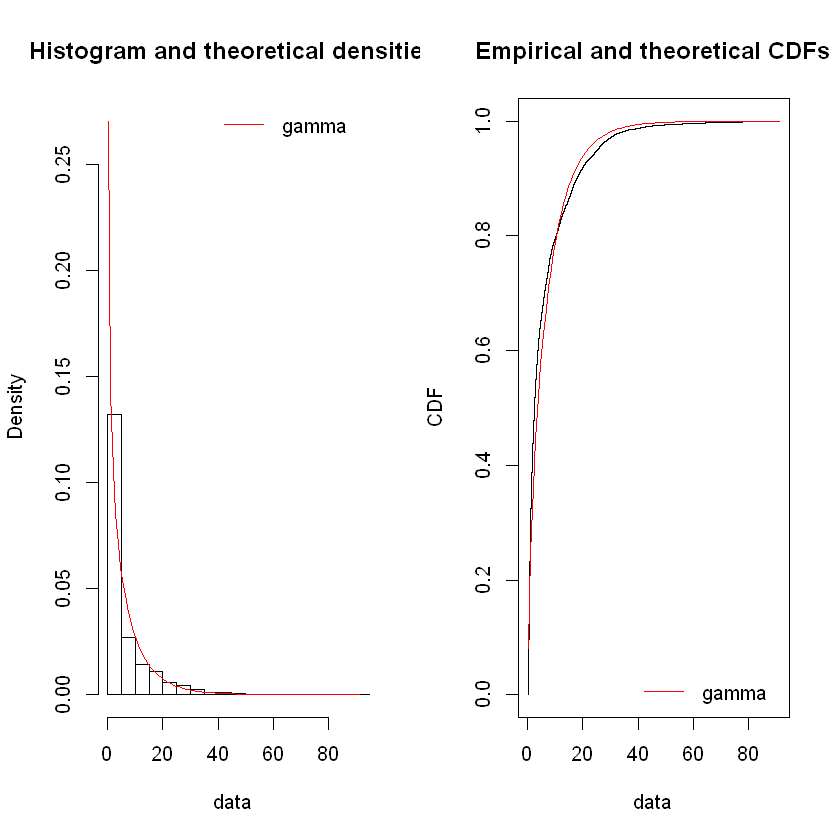

In [352]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Mar1)
#qqcomp(fd_GM_Mar1)
cdfcomp(fd_GM_Mar1)
#ppcomp(fd_GM_Mar1)

In [353]:
fdGM_Mar1_shape <- fd_GM_Mar1$estimate[["shape"]]
fdGM_Mar1_rate <- fd_GM_Mar1$estimate[["rate"]]
fdGM_Mar1_llike <- fd_GM_Mar1$loglik
fdGM_Mar1_mean <- fdGM_Mar1_shape / fdGM_Mar1_rate
fdGM_Mar1_var <- fdGM_Mar1_shape / ( fdGM_Mar1_rate ^ 2 )
cat(" Mar 1 shape: ", fdGM_Mar1_shape, "\n", "Mar 1 rate: ", fdGM_Mar1_rate, 
    "\n", "Mar 1 loglikelihood: ", fdGM_Mar1_llike, "\n", 
    "Mar 1 mean: ", fdGM_Mar1_mean, "\n",
    "Mar 1 variance: ", fdGM_Mar1_var, "\n" )

 Mar 1 shape:  0.6816512 
 Mar 1 rate:  0.1084416 
 Mar 1 loglikelihood:  -44433.62 
 Mar 1 mean:  6.285881 
 Mar 1 variance:  57.96557 


In [354]:
statRes <- gofstat( fd_GM_Mar1, fitnames=c("Gamma") )

In [355]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1051075
Cramer-von Mises statistic    63.3136215
Anderson-Darling statistic   355.5024091

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 88871.24
Bayesian Information Criterion 88886.59


In [356]:
ksRes <- ks.test( dfMar1$Precip_mm, "pgamma", shape=fdGM_Mar1_shape, rate=fdGM_Mar1_rate )

Warning message in ks.test(dfMar1$Precip_mm, "pgamma", shape = fdGM_Mar1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [357]:
fdGM_Mar1_KSStat <- ksRes$statistic
fdGM_Mar1_KSp <- ksRes$p.value
cat(" Mar 1 K-S stat: ", fdGM_Mar1_KSStat, "\n",
    "Mar 1 K-S p-value: ", fdGM_Mar1_KSp )

 Mar 1 K-S stat:  0.1051075 
 Mar 1 K-S p-value:  0

**Mixed exponential**

In [358]:
fd_ME_Mar1 <- expRMM_EM( dfMar1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMar1$Precip_mm), 1.0/mean(dfMar1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 89 


In [359]:
summary( fd_ME_Mar1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.513445 0.4865555
rate   0.626891 0.0889968
loglik at estimate:  -43151.28 
0 % of the data right censored


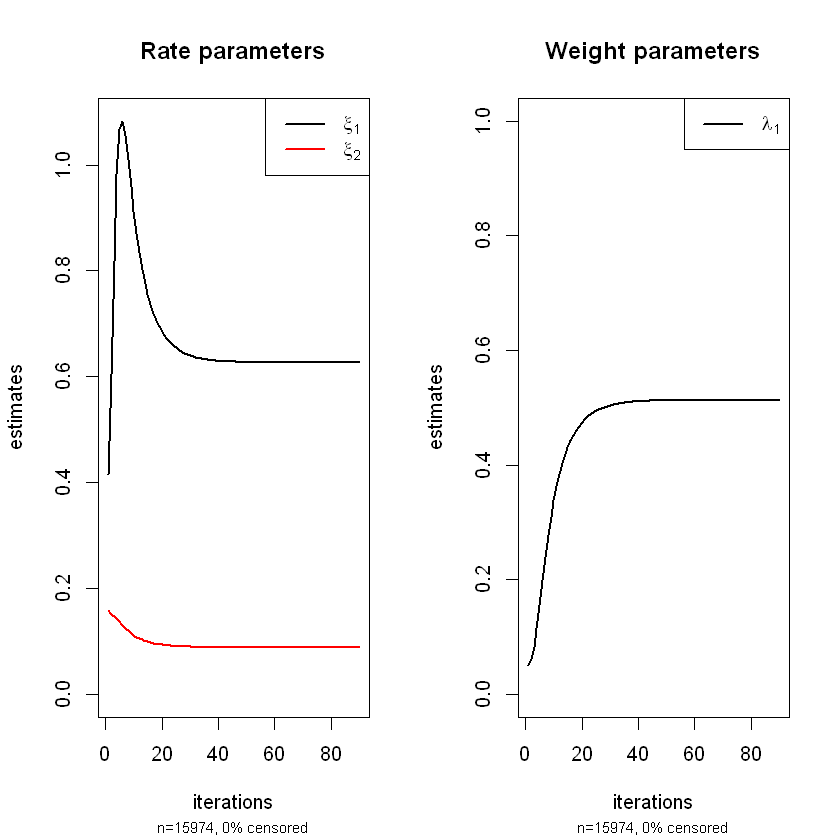

In [360]:
plotexpRMM( fd_ME_Mar1, lwd=2 )

In [361]:
fdME_Mar1_rate1 <- fd_ME_Mar1$rate[[1]]
fdME_Mar1_rate2 <- fd_ME_Mar1$rate[[2]]
fdME_Mar1_lambda <- fd_ME_Mar1$lambda[[1]]
fdME_Mar1_mean1 <- 1.0 / fdME_Mar1_rate1
fdME_Mar1_mean2 <- 1.0 / fdME_Mar1_rate2
fdME_Mar1_mean <- ( (fdME_Mar1_lambda * fdME_Mar1_mean1) + 
                    ( ( 1.0 - fdME_Mar1_lambda) * fdME_Mar1_mean2 ) )
fdME_Mar1_var1 <- 1.0 / (fdME_Mar1_rate1 ^ 2)
fdME_Mar1_var2 <- 1.0 / (fdME_Mar1_rate2 ^ 2)
fdME_Mar1_var <- ( (fdME_Mar1_lambda * ( fdME_Mar1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Mar1_lambda) * (fdME_Mar1_mean2 ^ 2) ) + 
                   ( fdME_Mar1_lambda * ( 1.0 - fdME_Mar1_lambda) * 
                       ( fdME_Mar1_mean1 - fdME_Mar1_mean2 )^2 ) )
fdME_Mar1_llike <- fd_ME_Mar1$loglik
cat(" Mar 1 rate1: ", fdME_Mar1_rate1, "\n", 
    "Mar 1 rate2: ", fdME_Mar1_rate2, "\n",
    "Mar 1 lambda: ", fdME_Mar1_lambda, "\n",
    "Mar 1 mean1: ", fdME_Mar1_mean1, "\n",
    "Mar 1 mean2: ", fdME_Mar1_mean2, "\n",
    "Mar 1 mean: ", fdME_Mar1_mean, "\n",
    "Mar 1 var1: ", fdME_Mar1_var1, "\n",
    "Mar 1 var2: ", fdME_Mar1_var2, "\n",
    "Mar 1 var: ", fdME_Mar1_var, "\n",
    "Mar 1 loglikelihood: ", fdME_Mar1_llike, "\n" )

 Mar 1 rate1:  0.626891 
 Mar 1 rate2:  0.08899679 
 Mar 1 lambda:  0.5134445 
 Mar 1 mean1:  1.595174 
 Mar 1 mean2:  11.23636 
 Mar 1 mean:  6.286146 
 Mar 1 var1:  2.544579 
 Mar 1 var2:  126.2558 
 Mar 1 var:  85.95826 
 Mar 1 loglikelihood:  -43151.28 


In [362]:
tvals <- rexpmix(length(dfMar1$Precip_mm), fd_ME_Mar1$lambda, fd_ME_Mar1$rate )

In [363]:
ksRes <- ks.test( dfMar1$Precip_mm, tvals )

Warning message in ks.test(dfMar1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [364]:
fdME_Mar1_KSStat <- ksRes$statistic
fdME_Mar1_KSp <- ksRes$p.value
cat(" Mar 1 K-S stat: ", fdME_Mar1_KSStat, "\n",
    "Mar 1 K-S p-value: ", fdME_Mar1_KSp )

 Mar 1 K-S stat:  0.07030174 
 Mar 1 K-S p-value:  0

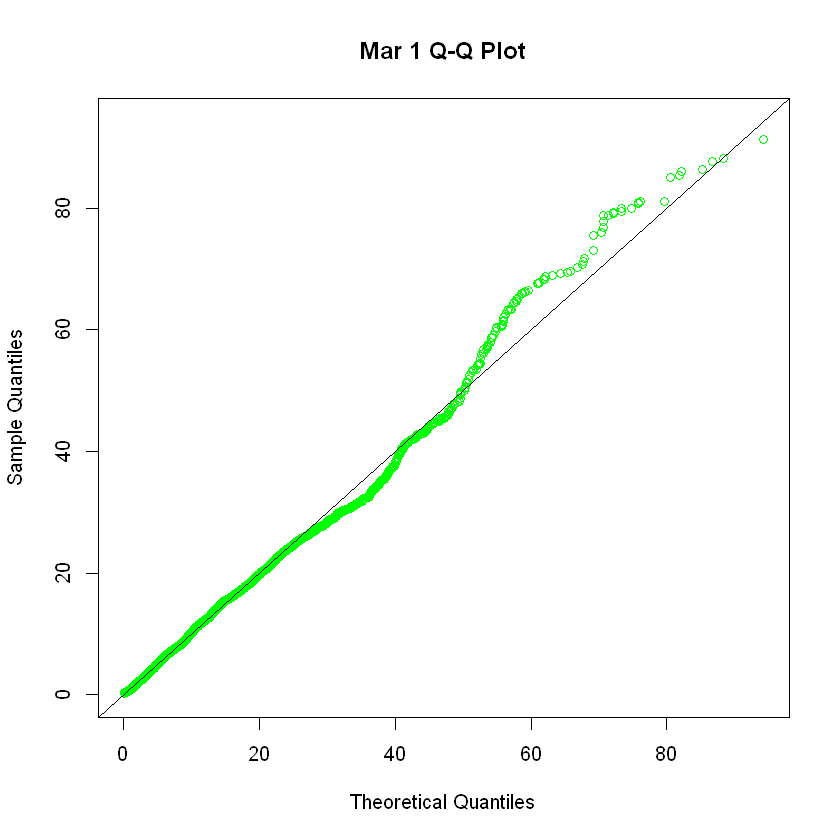

In [365]:
wMar1Max <- max( max( dfMar1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMar1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Mar 1 Q-Q Plot",
        xlim=c(0,wMar1Max), ylim=c(0,wMar1Max) )
abline( 0, 1)

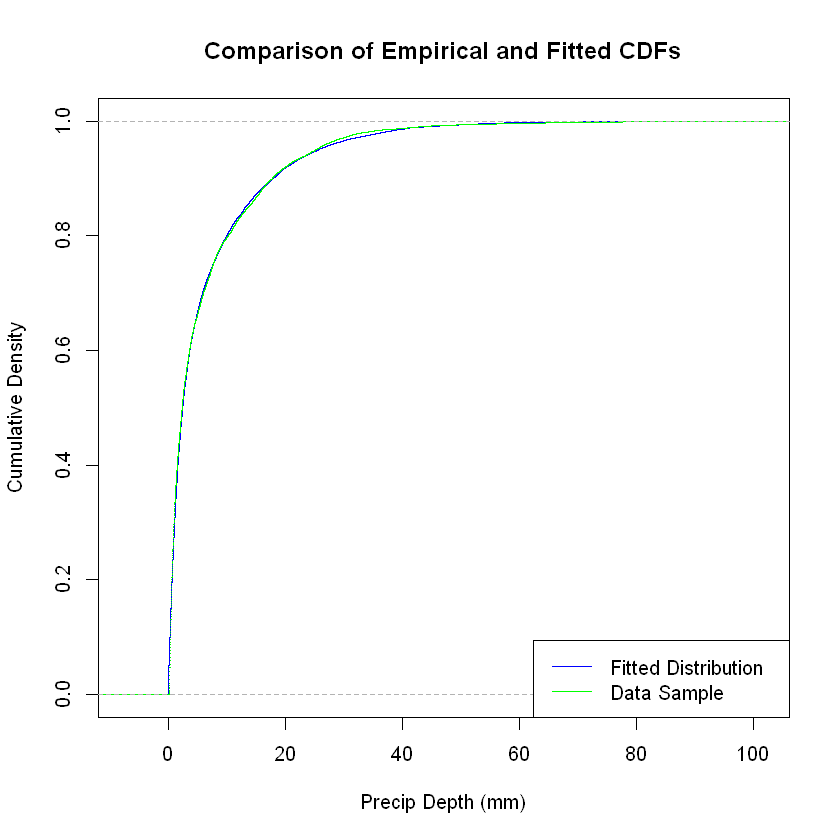

In [366]:
x <- seq(0,wMar1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMar1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [367]:
MonDistDF[12, ] <- list( 3, 1, fdGM_Mar1_shape, fdGM_Mar1_rate, fdGM_Mar1_llike, fdGM_Mar1_mean,
                        fdGM_Mar1_var, fdGM_Mar1_KSStat, fdGM_Mar1_KSp, fdME_Mar1_rate1,
                        fdME_Mar1_rate2, fdME_Mar1_lambda, fdME_Mar1_mean1, fdME_Mar1_mean2,
                        fdME_Mar1_mean, fdME_Mar1_var1, fdME_Mar1_var2, fdME_Mar1_var,
                        fdME_Mar1_llike, fdME_Mar1_KSStat, fdME_Mar1_KSp )

#### Region 2

**Gamma**

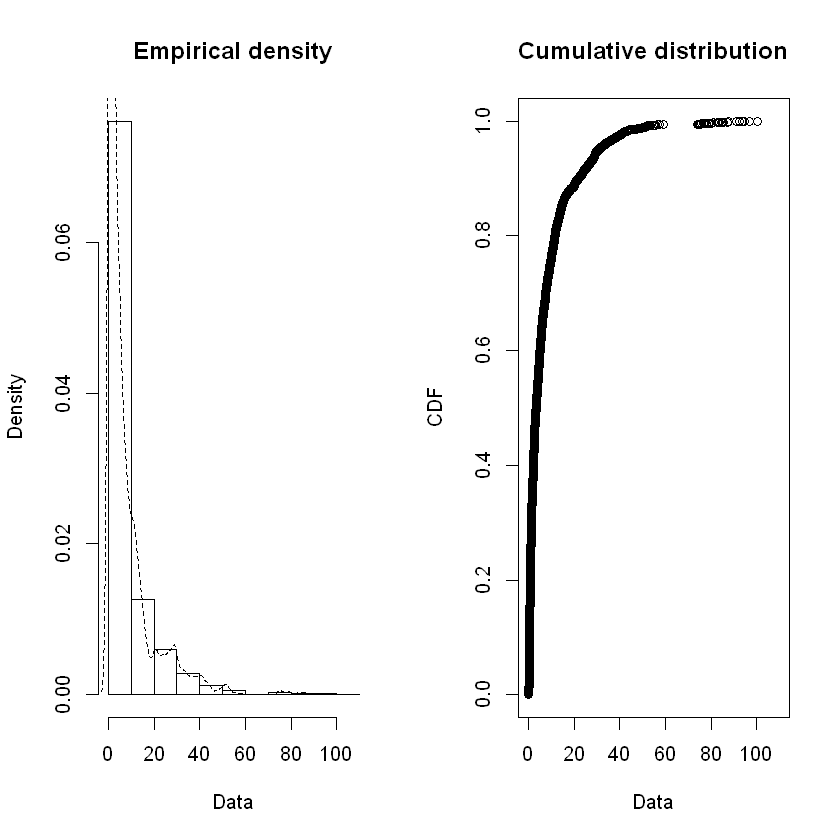

In [368]:
plotdist( dfMar2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  100.38 
median:  3.36 
mean:  7.748838 
estimated sd:  11.31895 
estimated skewness:  3.088973 
estimated kurtosis:  16.27052 

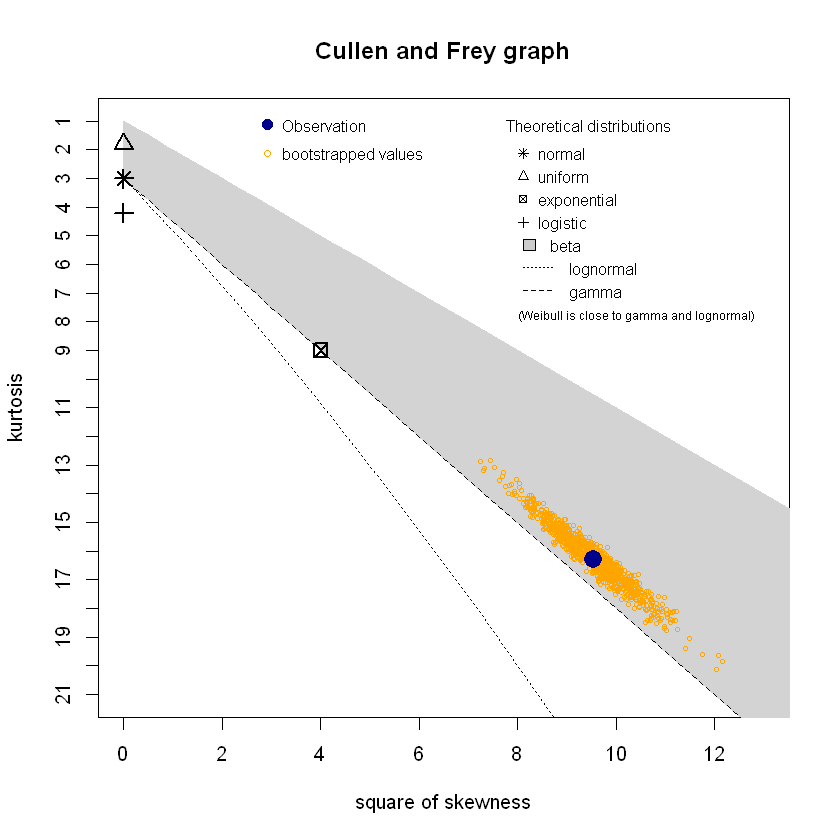

In [369]:
descdist( dfMar2$Precip_mm, boot=1000 )

In [370]:
fd_GM_Mar2 <- fitdist( dfMar2$Precip_mm, "gamma" )

In [371]:
summary( fd_GM_Mar2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.70048427 0.011336205
rate  0.09041036 0.002060152
Loglikelihood:  -16627.96   AIC:  33259.91   BIC:  33273.16 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7100676
rate  0.7100676 1.0000000


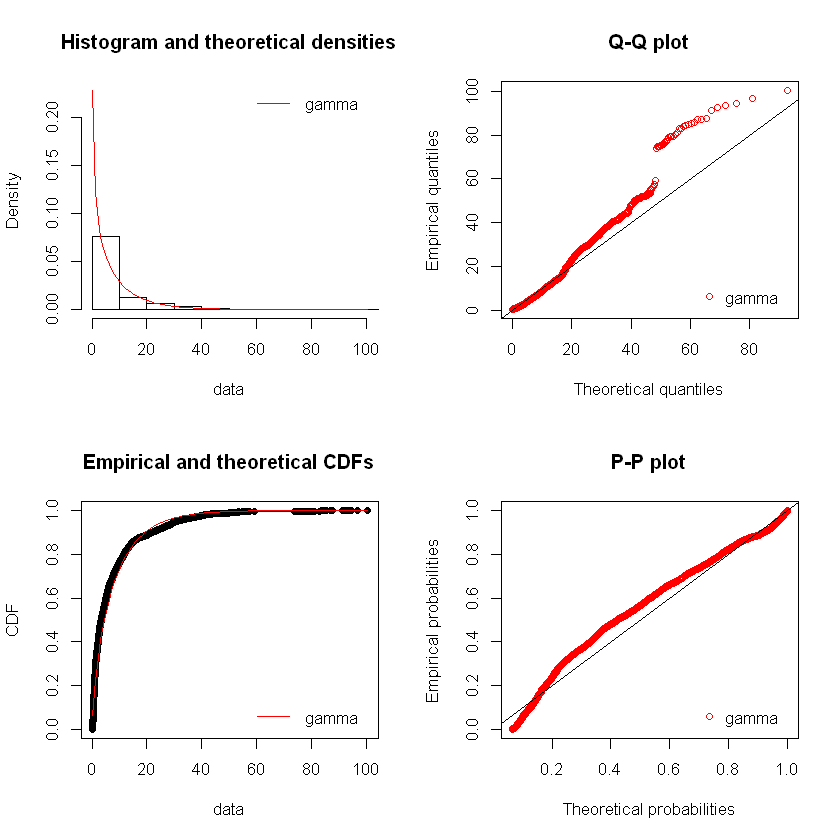

In [372]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Mar2)
qqcomp(fd_GM_Mar2)
cdfcomp(fd_GM_Mar2)
ppcomp(fd_GM_Mar2)

In [373]:
fdGM_Mar2_shape <- fd_GM_Mar2$estimate[["shape"]]
fdGM_Mar2_rate <- fd_GM_Mar2$estimate[["rate"]]
fdGM_Mar2_llike <- fd_GM_Mar2$loglik
fdGM_Mar2_mean <- fdGM_Mar2_shape / fdGM_Mar2_rate
fdGM_Mar2_var <- fdGM_Mar2_shape / ( fdGM_Mar2_rate ^ 2 )
cat(" Mar 2 shape: ", fdGM_Mar2_shape, "\n", "Mar 2 rate: ", fdGM_Mar2_rate, 
    "\n", "Mar 2 loglikelihood: ", fdGM_Mar2_llike, "\n", 
    "Mar 2 mean: ", fdGM_Mar2_mean, "\n",
    "Mar 2 variance: ", fdGM_Mar2_var, "\n" )

 Mar 2 shape:  0.7004843 
 Mar 2 rate:  0.09041036 
 Mar 2 loglikelihood:  -16627.96 
 Mar 2 mean:  7.747832 
 Mar 2 variance:  85.69628 


In [374]:
statRes <- gofstat( fd_GM_Mar2, fitnames=c("Gamma") )

In [375]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.08310921
Cramer-von Mises statistic   14.18657207
Anderson-Darling statistic   84.84248875

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 33259.91
Bayesian Information Criterion 33273.16


In [376]:
ksRes <- ks.test( dfMar2$Precip_mm, "pgamma", shape=fdGM_Mar2_shape, rate=fdGM_Mar2_rate )

Warning message in ks.test(dfMar2$Precip_mm, "pgamma", shape = fdGM_Mar2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [377]:
fdGM_Mar2_KSStat <- ksRes$statistic
fdGM_Mar2_KSp <- ksRes$p.value
cat(" Mar 2 K-S stat: ", fdGM_Mar2_KSStat, "\n",
    "Mar 2 K-S p-value: ", fdGM_Mar2_KSp )

 Mar 2 K-S stat:  0.08310921 
 Mar 2 K-S p-value:  0

**Mixed exponential**

In [378]:
fd_ME_Mar2 <- expRMM_EM( dfMar2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMar2$Precip_mm), 1.0/mean(dfMar2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 169 


In [379]:
summary( fd_ME_Mar2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.515369 0.4846306
rate   0.427984 0.0740498
loglik at estimate:  -16313.83 
0 % of the data right censored


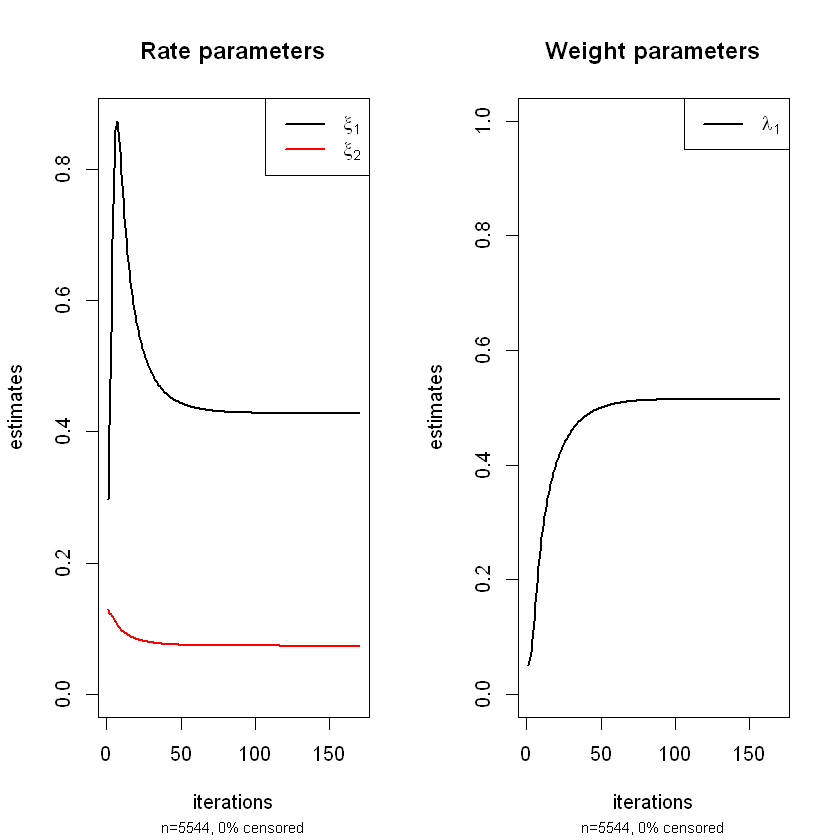

In [380]:
plotexpRMM( fd_ME_Mar2, lwd=2 )

In [381]:
fdME_Mar2_rate1 <- fd_ME_Mar2$rate[[1]]
fdME_Mar2_rate2 <- fd_ME_Mar2$rate[[2]]
fdME_Mar2_lambda <- fd_ME_Mar2$lambda[[1]]
fdME_Mar2_mean1 <- 1.0 / fdME_Mar2_rate1
fdME_Mar2_mean2 <- 1.0 / fdME_Mar2_rate2
fdME_Mar2_mean <- ( (fdME_Mar2_lambda * fdME_Mar2_mean1) + 
                    ( ( 1.0 - fdME_Mar2_lambda) * fdME_Mar2_mean2 ) )
fdME_Mar2_var1 <- 1.0 / (fdME_Mar2_rate1 ^ 2)
fdME_Mar2_var2 <- 1.0 / (fdME_Mar2_rate2 ^ 2)
fdME_Mar2_var <- ( (fdME_Mar2_lambda * ( fdME_Mar2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Mar2_lambda) * (fdME_Mar2_mean2 ^ 2) ) + 
                   ( fdME_Mar2_lambda * ( 1.0 - fdME_Mar2_lambda) * 
                       ( fdME_Mar2_mean1 - fdME_Mar2_mean2 )^2 ) )
fdME_Mar2_llike <- fd_ME_Mar2$loglik
cat(" Mar 2 rate1: ", fdME_Mar2_rate1, "\n", 
    "Mar 2 rate2: ", fdME_Mar2_rate2, "\n",
    "Mar 2 lambda: ", fdME_Mar2_lambda, "\n",
    "Mar 2 mean1: ", fdME_Mar2_mean1, "\n",
    "Mar 2 mean2: ", fdME_Mar2_mean2, "\n",
    "Mar 2 mean: ", fdME_Mar2_mean, "\n",
    "Mar 2 var1: ", fdME_Mar2_var1, "\n",
    "Mar 2 var2: ", fdME_Mar2_var2, "\n",
    "Mar 2 var: ", fdME_Mar2_var, "\n",
    "Mar 2 loglikelihood: ", fdME_Mar2_llike, "\n" )

 Mar 2 rate1:  0.4279835 
 Mar 2 rate2:  0.0740498 
 Mar 2 lambda:  0.5153694 
 Mar 2 mean1:  2.336538 
 Mar 2 mean2:  13.50442 
 Mar 2 mean:  7.748838 
 Mar 2 var1:  5.459412 
 Mar 2 var2:  182.3695 
 Mar 2 var:  122.3464 
 Mar 2 loglikelihood:  -16313.83 


In [382]:
tvals <- rexpmix(length(dfMar2$Precip_mm), fd_ME_Mar2$lambda, fd_ME_Mar2$rate )

In [383]:
ksRes <- ks.test( dfMar2$Precip_mm, tvals )

Warning message in ks.test(dfMar2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [384]:
fdME_Mar2_KSStat <- ksRes$statistic
fdME_Mar2_KSp <- ksRes$p.value
cat(" Mar 2 K-S stat: ", fdME_Mar2_KSStat, "\n",
    "Mar 2 K-S p-value: ", fdME_Mar2_KSp )

 Mar 2 K-S stat:  0.04743867 
 Mar 2 K-S p-value:  7.631519e-06

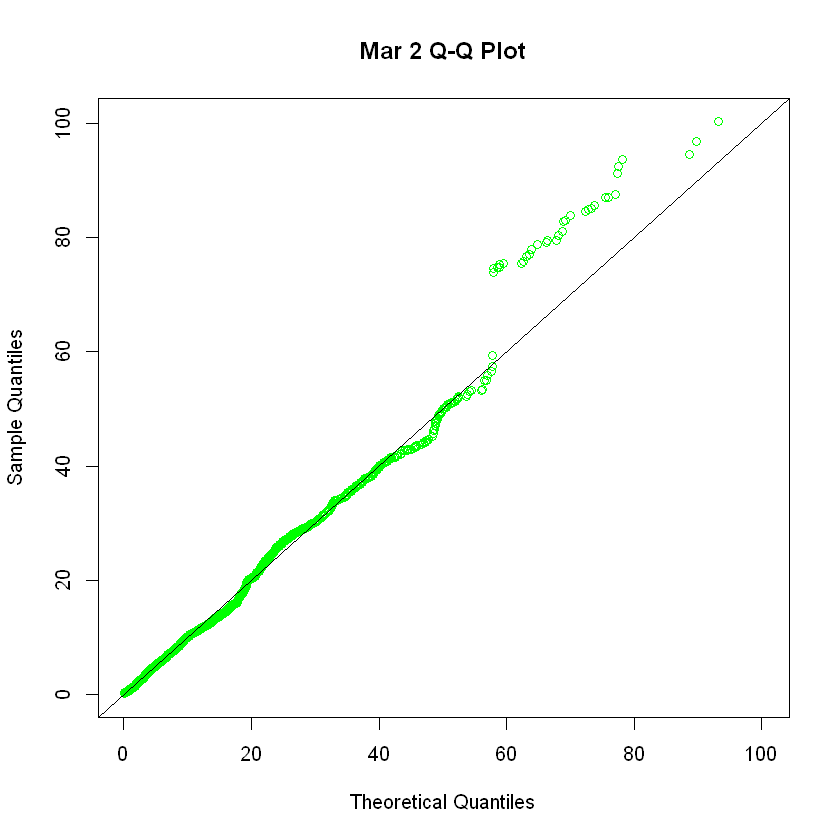

In [385]:
wMar2Max <- max( max( dfMar2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMar2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Mar 2 Q-Q Plot",
        xlim=c(0,wMar2Max), ylim=c(0,wMar2Max) )
abline( 0, 1)

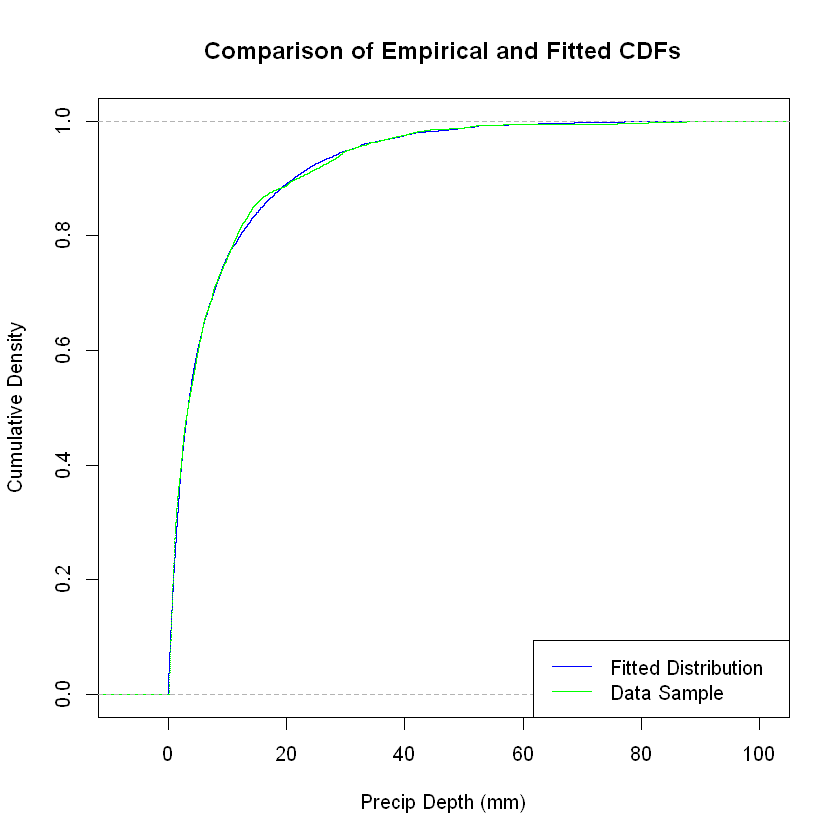

In [386]:
x <- seq(0,wMar2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMar2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [387]:
MonDistDF[13, ] <- list( 3, 2, fdGM_Mar2_shape, fdGM_Mar2_rate, fdGM_Mar2_llike, fdGM_Mar2_mean,
                        fdGM_Mar2_var, fdGM_Mar2_KSStat, fdGM_Mar2_KSp, fdME_Mar2_rate1,
                        fdME_Mar2_rate2, fdME_Mar2_lambda, fdME_Mar2_mean1, fdME_Mar2_mean2,
                        fdME_Mar2_mean, fdME_Mar2_var1, fdME_Mar2_var2, fdME_Mar2_var,
                        fdME_Mar2_llike, fdME_Mar2_KSStat, fdME_Mar2_KSp )

#### Region 3

**Gamma**

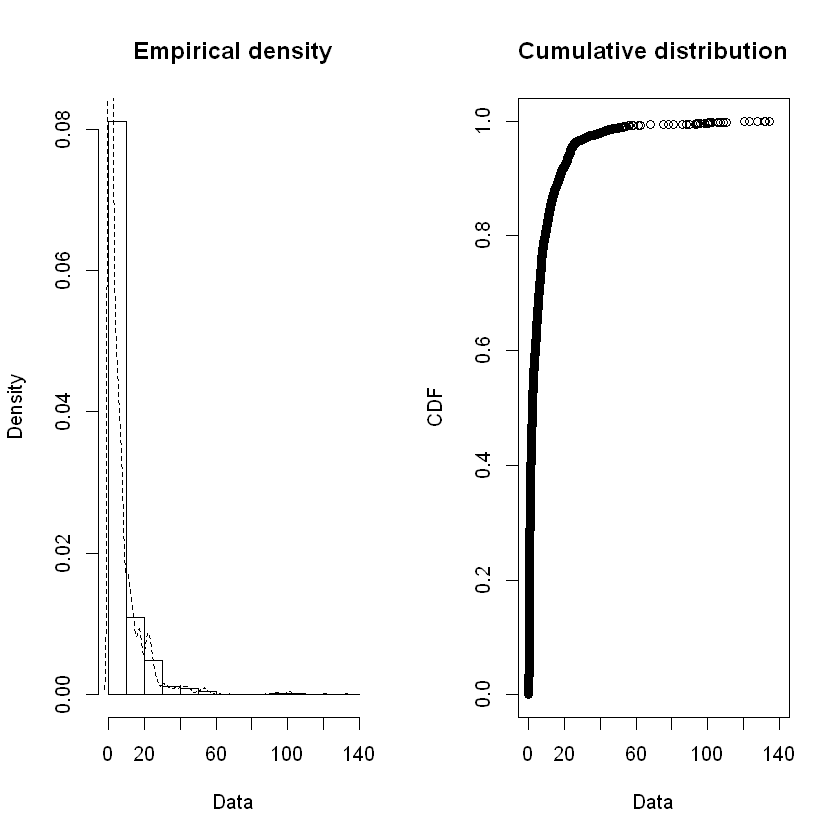

In [388]:
plotdist( dfMar3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  134.17 
median:  2.29 
mean:  6.436344 
estimated sd:  11.49076 
estimated skewness:  4.965228 
estimated kurtosis:  38.73992 

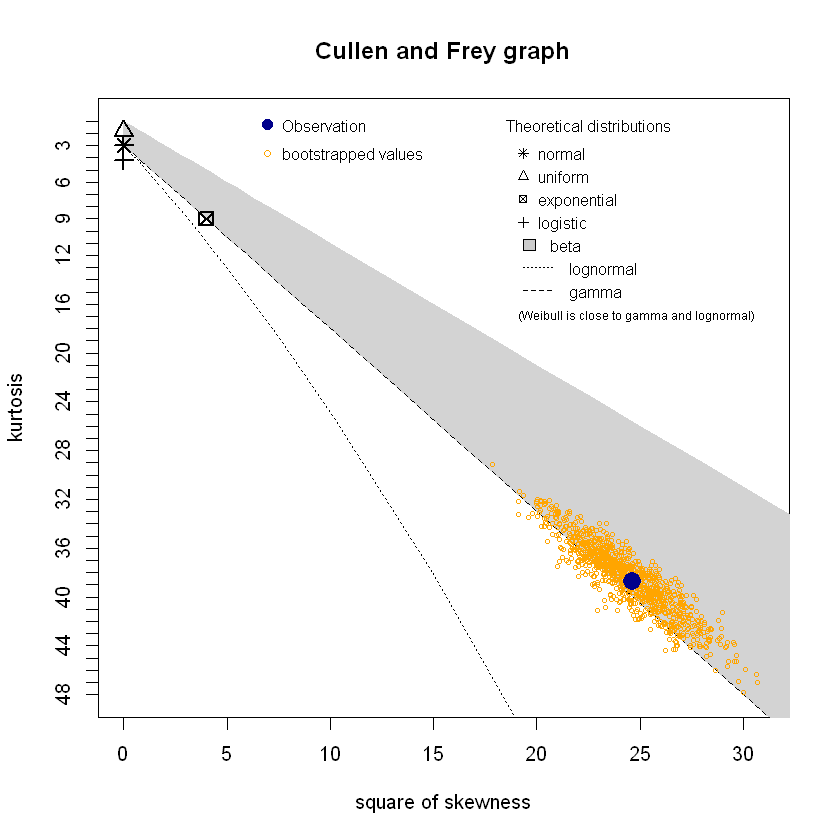

In [389]:
descdist( dfMar3$Precip_mm, boot=1000 )

In [390]:
fd_GM_Mar3 <- fitdist( dfMar3$Precip_mm, "gamma" )

In [391]:
summary( fd_GM_Mar3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.63616653 0.010219844
rate  0.09886057 0.002302494
Loglikelihood:  -15360.89   AIC:  30725.77   BIC:  30739 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6896424
rate  0.6896424 1.0000000


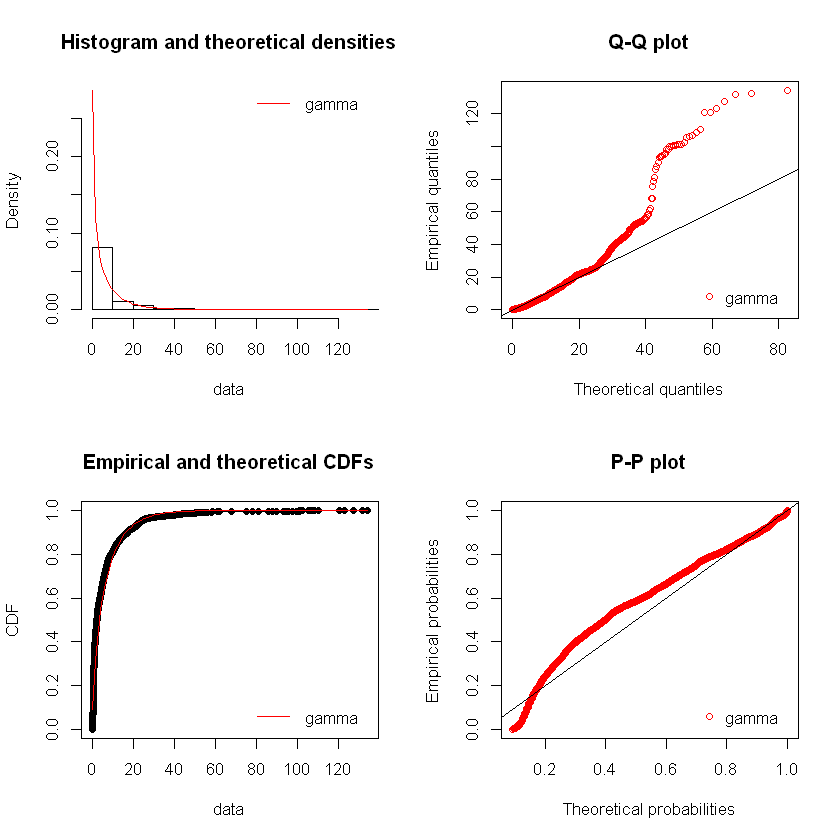

In [392]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Mar3)
qqcomp(fd_GM_Mar3)
cdfcomp(fd_GM_Mar3)
ppcomp(fd_GM_Mar3)

In [393]:
fdGM_Mar3_shape <- fd_GM_Mar3$estimate[["shape"]]
fdGM_Mar3_rate <- fd_GM_Mar3$estimate[["rate"]]
fdGM_Mar3_llike <- fd_GM_Mar3$loglik
fdGM_Mar3_mean <- fdGM_Mar3_shape / fdGM_Mar3_rate
fdGM_Mar3_var <- fdGM_Mar3_shape / ( fdGM_Mar3_rate ^ 2 )
cat(" Mar 3 shape: ", fdGM_Mar3_shape, "\n", "Mar 3 rate: ", fdGM_Mar3_rate, 
    "\n", "Mar 3 loglikelihood: ", fdGM_Mar3_llike, "\n", 
    "Mar 3 mean: ", fdGM_Mar3_mean, "\n",
    "Mar 3 variance: ", fdGM_Mar3_var, "\n" )

 Mar 3 shape:  0.6361665 
 Mar 3 rate:  0.09886057 
 Mar 3 loglikelihood:  -15360.89 
 Mar 3 mean:  6.434987 
 Mar 3 variance:  65.09155 


In [394]:
statRes <- gofstat( fd_GM_Mar3, fitnames=c("Gamma") )

In [395]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1106484
Cramer-von Mises statistic    24.1213773
Anderson-Darling statistic   139.1051717

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 30725.77
Bayesian Information Criterion 30739.00


In [396]:
ksRes <- ks.test( dfMar3$Precip_mm, "pgamma", shape=fdGM_Mar3_shape, rate=fdGM_Mar3_rate )

Warning message in ks.test(dfMar3$Precip_mm, "pgamma", shape = fdGM_Mar3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [397]:
fdGM_Mar3_KSStat <- ksRes$statistic
fdGM_Mar3_KSp <- ksRes$p.value
cat(" Mar 3 K-S stat: ", fdGM_Mar3_KSStat, "\n",
    "Mar 3 K-S p-value: ", fdGM_Mar3_KSp )

 Mar 3 K-S stat:  0.1106484 
 Mar 3 K-S p-value:  0

**Mixed exponential**

In [398]:
fd_ME_Mar3 <- expRMM_EM( dfMar3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMar3$Precip_mm), 1.0/mean(dfMar3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 117 


In [399]:
summary( fd_ME_Mar3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.544520 0.4554800
rate   0.625984 0.0818255
loglik at estimate:  -14873.65 
0 % of the data right censored


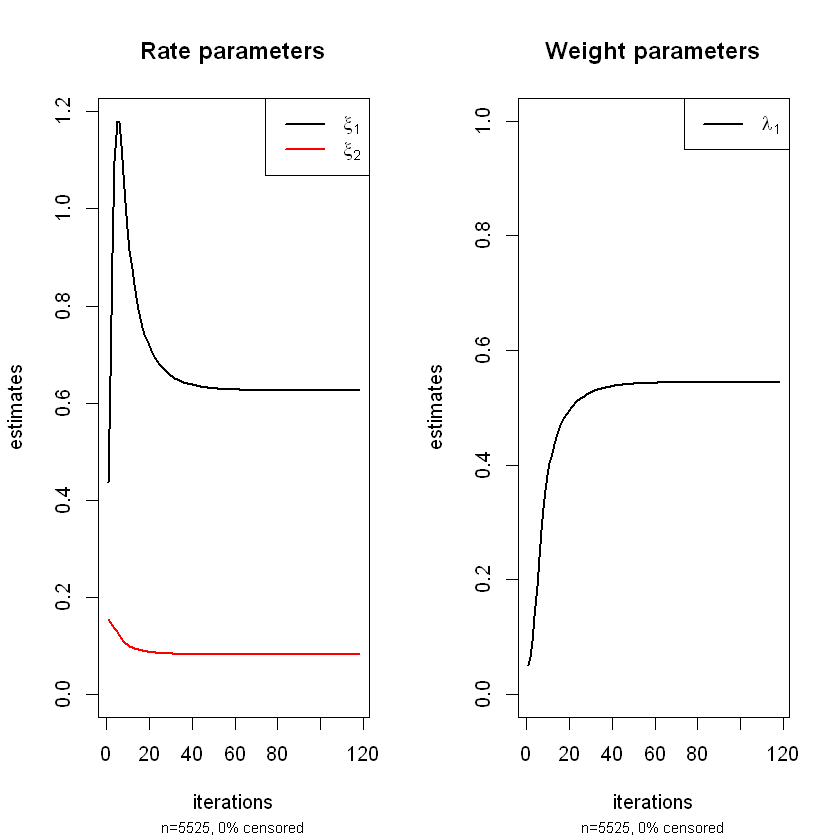

In [400]:
plotexpRMM( fd_ME_Mar3, lwd=2 )

In [401]:
fdME_Mar3_rate1 <- fd_ME_Mar3$rate[[1]]
fdME_Mar3_rate2 <- fd_ME_Mar3$rate[[2]]
fdME_Mar3_lambda <- fd_ME_Mar3$lambda[[1]]
fdME_Mar3_mean1 <- 1.0 / fdME_Mar3_rate1
fdME_Mar3_mean2 <- 1.0 / fdME_Mar3_rate2
fdME_Mar3_mean <- ( (fdME_Mar3_lambda * fdME_Mar3_mean1) + 
                    ( ( 1.0 - fdME_Mar3_lambda) * fdME_Mar3_mean2 ) )
fdME_Mar3_var1 <- 1.0 / (fdME_Mar3_rate1 ^ 2)
fdME_Mar3_var2 <- 1.0 / (fdME_Mar3_rate2 ^ 2)
fdME_Mar3_var <- ( (fdME_Mar3_lambda * ( fdME_Mar3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Mar3_lambda) * (fdME_Mar3_mean2 ^ 2) ) + 
                   ( fdME_Mar3_lambda * ( 1.0 - fdME_Mar3_lambda) * 
                       ( fdME_Mar3_mean1 - fdME_Mar3_mean2 )^2 ) )
fdME_Mar3_llike <- fd_ME_Mar3$loglik
cat(" Mar 3 rate1: ", fdME_Mar3_rate1, "\n", 
    "Mar 3 rate2: ", fdME_Mar3_rate2, "\n",
    "Mar 3 lambda: ", fdME_Mar3_lambda, "\n",
    "Mar 3 mean1: ", fdME_Mar3_mean1, "\n",
    "Mar 3 mean2: ", fdME_Mar3_mean2, "\n",
    "Mar 3 mean: ", fdME_Mar3_mean, "\n",
    "Mar 3 var1: ", fdME_Mar3_var1, "\n",
    "Mar 3 var2: ", fdME_Mar3_var2, "\n",
    "Mar 3 var: ", fdME_Mar3_var, "\n",
    "Mar 3 loglikelihood: ", fdME_Mar3_llike, "\n" )

 Mar 3 rate1:  0.625984 
 Mar 3 rate2:  0.08182548 
 Mar 3 lambda:  0.54452 
 Mar 3 mean1:  1.597485 
 Mar 3 mean2:  12.22113 
 Mar 3 mean:  6.436344 
 Mar 3 var1:  2.551958 
 Mar 3 var2:  149.3561 
 Mar 3 var:  97.41008 
 Mar 3 loglikelihood:  -14873.65 


In [402]:
tvals <- rexpmix(length(dfMar3$Precip_mm), fd_ME_Mar3$lambda, fd_ME_Mar3$rate )

In [403]:
ksRes <- ks.test( dfMar3$Precip_mm, tvals )

Warning message in ks.test(dfMar3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [404]:
fdME_Mar3_KSStat <- ksRes$statistic
fdME_Mar3_KSp <- ksRes$p.value
cat(" Mar 3 K-S stat: ", fdME_Mar3_KSStat, "\n",
    "Mar 3 K-S p-value: ", fdME_Mar3_KSp )

 Mar 3 K-S stat:  0.07819005 
 Mar 3 K-S p-value:  4.32987e-15

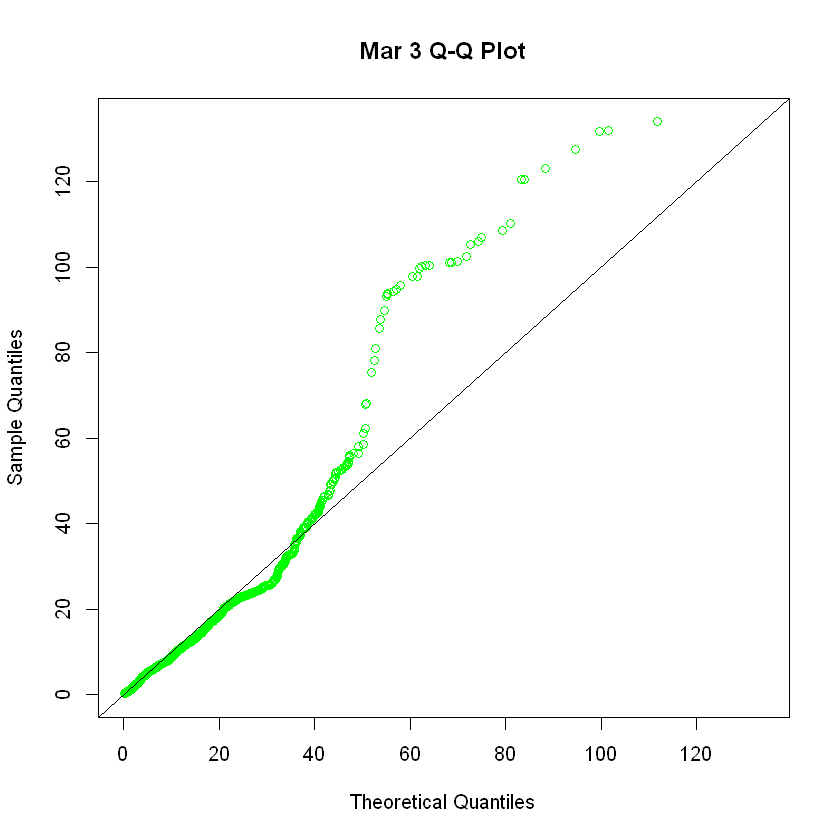

In [405]:
wMar3Max <- max( max( dfMar3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMar3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Mar 3 Q-Q Plot",
        xlim=c(0,wMar3Max), ylim=c(0,wMar3Max) )
abline( 0, 1)

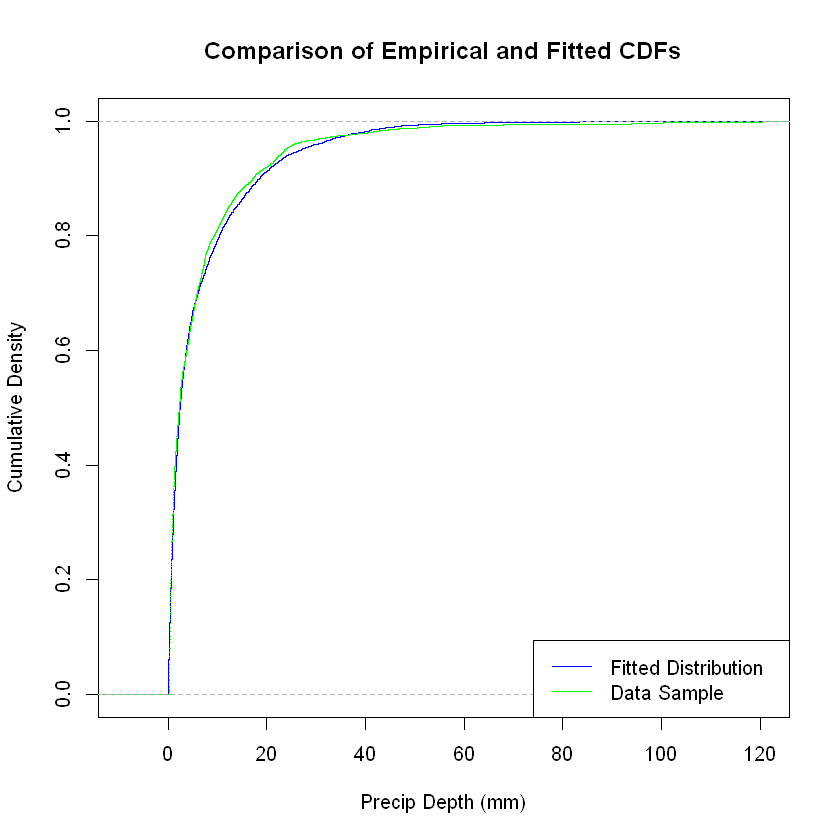

In [406]:
x <- seq(0,wMar3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMar3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [407]:
MonDistDF[14, ] <- list( 3, 3, fdGM_Mar3_shape, fdGM_Mar3_rate, fdGM_Mar3_llike, fdGM_Mar3_mean,
                        fdGM_Mar3_var, fdGM_Mar3_KSStat, fdGM_Mar3_KSp, fdME_Mar3_rate1,
                        fdME_Mar3_rate2, fdME_Mar3_lambda, fdME_Mar3_mean1, fdME_Mar3_mean2,
                        fdME_Mar3_mean, fdME_Mar3_var1, fdME_Mar3_var2, fdME_Mar3_var,
                        fdME_Mar3_llike, fdME_Mar3_KSStat, fdME_Mar3_KSp )

#### Region 4

**Gamma**

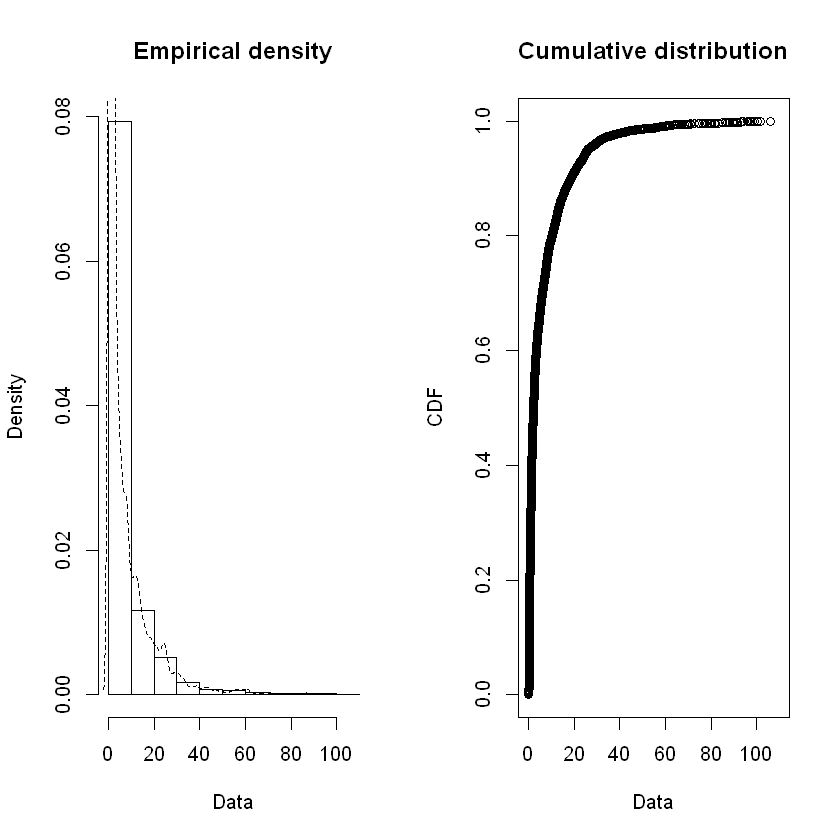

In [408]:
plotdist( dfMar4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  106 
median:  2.26 
mean:  6.693639 
estimated sd:  11.00373 
estimated skewness:  3.67035 
estimated kurtosis:  21.62307 

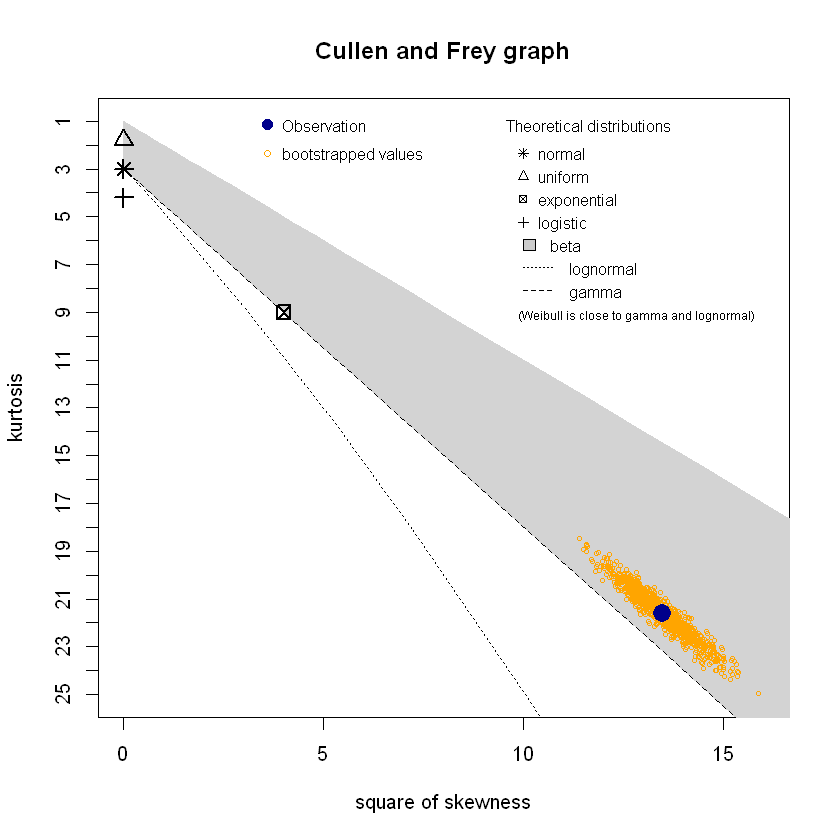

In [409]:
descdist( dfMar4$Precip_mm, boot=1000 )

In [410]:
fd_GM_Mar4 <- fitdist( dfMar4$Precip_mm, "gamma" )

In [411]:
summary( fd_GM_Mar4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.63966940 0.007721366
rate  0.09559125 0.001669988
Loglikelihood:  -27640.35   AIC:  55284.7   BIC:  55299.08 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6908188
rate  0.6908188 1.0000000


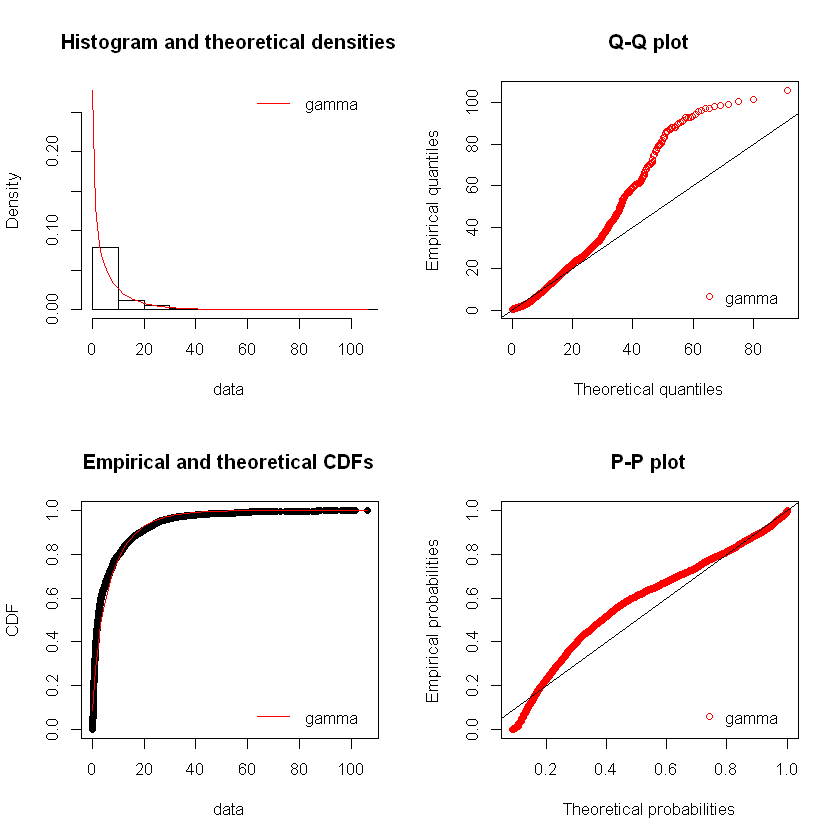

In [412]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Mar4)
qqcomp(fd_GM_Mar4)
cdfcomp(fd_GM_Mar4)
ppcomp(fd_GM_Mar4)

In [413]:
fdGM_Mar4_shape <- fd_GM_Mar4$estimate[["shape"]]
fdGM_Mar4_rate <- fd_GM_Mar4$estimate[["rate"]]
fdGM_Mar4_llike <- fd_GM_Mar4$loglik
fdGM_Mar4_mean <- fdGM_Mar4_shape / fdGM_Mar4_rate
fdGM_Mar4_var <- fdGM_Mar4_shape / ( fdGM_Mar4_rate ^ 2 )
cat(" Mar 4 shape: ", fdGM_Mar4_shape, "\n", "Mar 4 rate: ", fdGM_Mar4_rate, 
    "\n", "Mar 4 loglikelihood: ", fdGM_Mar4_llike, "\n", 
    "Mar 4 mean: ", fdGM_Mar4_mean, "\n",
    "Mar 4 variance: ", fdGM_Mar4_var, "\n" )

 Mar 4 shape:  0.6396694 
 Mar 4 rate:  0.09559125 
 Mar 4 loglikelihood:  -27640.35 
 Mar 4 mean:  6.691715 
 Mar 4 variance:  70.00343 


In [414]:
statRes <- gofstat( fd_GM_Mar4, fitnames=c("Gamma") )

In [415]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1222967
Cramer-von Mises statistic    47.9529672
Anderson-Darling statistic   261.9490580

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 55284.70
Bayesian Information Criterion 55299.08


In [416]:
ksRes <- ks.test( dfMar4$Precip_mm, "pgamma", shape=fdGM_Mar4_shape, rate=fdGM_Mar4_rate )

Warning message in ks.test(dfMar4$Precip_mm, "pgamma", shape = fdGM_Mar4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [417]:
fdGM_Mar4_KSStat <- ksRes$statistic
fdGM_Mar4_KSp <- ksRes$p.value
cat(" Mar 4 K-S stat: ", fdGM_Mar4_KSStat, "\n",
    "Mar 4 K-S p-value: ", fdGM_Mar4_KSp )

 Mar 4 K-S stat:  0.1222967 
 Mar 4 K-S p-value:  0

**Mixed exponential**

In [418]:
fd_ME_Mar4 <- expRMM_EM( dfMar4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMar4$Precip_mm), 1.0/mean(dfMar4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 76 


In [419]:
summary( fd_ME_Mar4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.547189 0.4528115
rate   0.628365 0.0777649
loglik at estimate:  -26662.35 
0 % of the data right censored


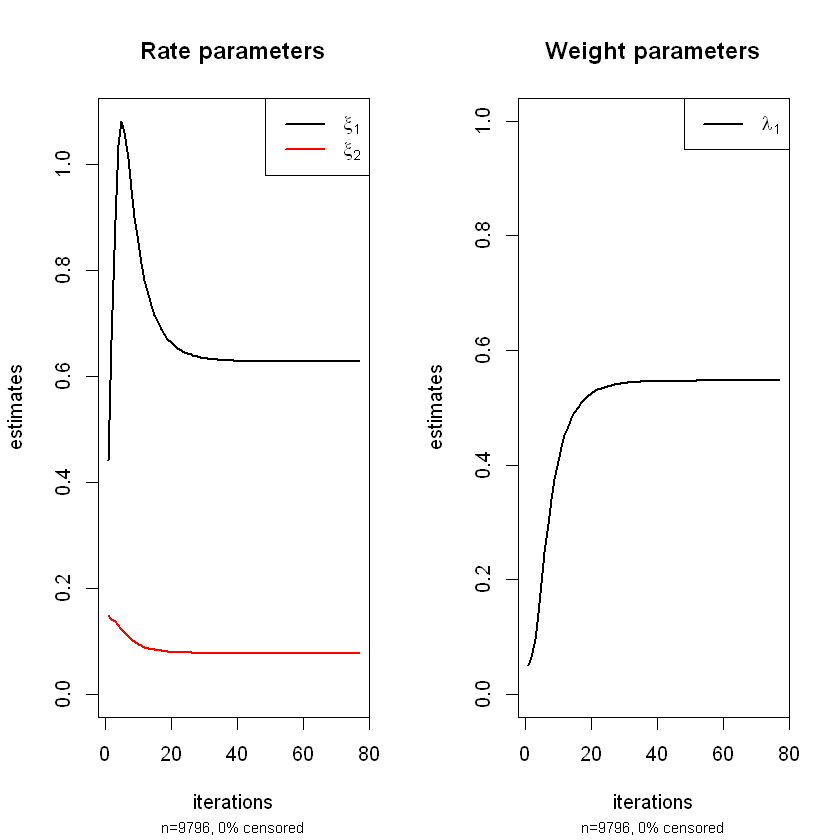

In [420]:
plotexpRMM( fd_ME_Mar4, lwd=2 )

In [421]:
fdME_Mar4_rate1 <- fd_ME_Mar4$rate[[1]]
fdME_Mar4_rate2 <- fd_ME_Mar4$rate[[2]]
fdME_Mar4_lambda <- fd_ME_Mar4$lambda[[1]]
fdME_Mar4_mean1 <- 1.0 / fdME_Mar4_rate1
fdME_Mar4_mean2 <- 1.0 / fdME_Mar4_rate2
fdME_Mar4_mean <- ( (fdME_Mar4_lambda * fdME_Mar4_mean1) + 
                    ( ( 1.0 - fdME_Mar4_lambda) * fdME_Mar4_mean2 ) )
fdME_Mar4_var1 <- 1.0 / (fdME_Mar4_rate1 ^ 2)
fdME_Mar4_var2 <- 1.0 / (fdME_Mar4_rate2 ^ 2)
fdME_Mar4_var <- ( (fdME_Mar4_lambda * ( fdME_Mar4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Mar4_lambda) * (fdME_Mar4_mean2 ^ 2) ) + 
                   ( fdME_Mar4_lambda * ( 1.0 - fdME_Mar4_lambda) * 
                       ( fdME_Mar4_mean1 - fdME_Mar4_mean2 )^2 ) )
fdME_Mar4_llike <- fd_ME_Mar4$loglik
cat(" Mar 4 rate1: ", fdME_Mar4_rate1, "\n", 
    "Mar 4 rate2: ", fdME_Mar4_rate2, "\n",
    "Mar 4 lambda: ", fdME_Mar4_lambda, "\n",
    "Mar 4 mean1: ", fdME_Mar4_mean1, "\n",
    "Mar 4 mean2: ", fdME_Mar4_mean2, "\n",
    "Mar 4 mean: ", fdME_Mar4_mean, "\n",
    "Mar 4 var1: ", fdME_Mar4_var1, "\n",
    "Mar 4 var2: ", fdME_Mar4_var2, "\n",
    "Mar 4 var: ", fdME_Mar4_var, "\n",
    "Mar 4 loglikelihood: ", fdME_Mar4_llike, "\n" )

 Mar 4 rate1:  0.6283652 
 Mar 4 rate2:  0.07776489 
 Mar 4 lambda:  0.5471885 
 Mar 4 mean1:  1.591431 
 Mar 4 mean2:  12.85927 
 Mar 4 mean:  6.693639 
 Mar 4 var1:  2.532653 
 Mar 4 var2:  165.3609 
 Mar 4 var:  107.7215 
 Mar 4 loglikelihood:  -26662.35 


In [422]:
tvals <- rexpmix(length(dfMar4$Precip_mm), fd_ME_Mar4$lambda, fd_ME_Mar4$rate )

In [423]:
ksRes <- ks.test( dfMar4$Precip_mm, tvals )

Warning message in ks.test(dfMar4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [424]:
fdME_Mar4_KSStat <- ksRes$statistic
fdME_Mar4_KSp <- ksRes$p.value
cat(" Mar 4 K-S stat: ", fdME_Mar4_KSStat, "\n",
    "Mar 4 K-S p-value: ", fdME_Mar4_KSp )

 Mar 4 K-S stat:  0.0821764 
 Mar 4 K-S p-value:  0

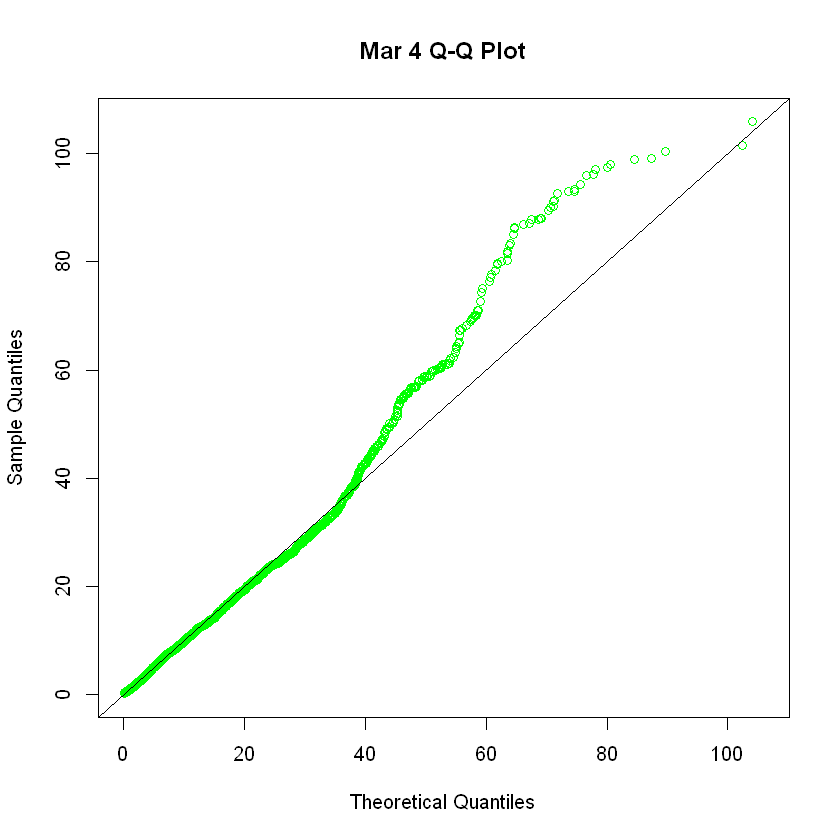

In [425]:
wMar4Max <- max( max( dfMar4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMar4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Mar 4 Q-Q Plot",
        xlim=c(0,wMar4Max), ylim=c(0,wMar4Max) )
abline( 0, 1)

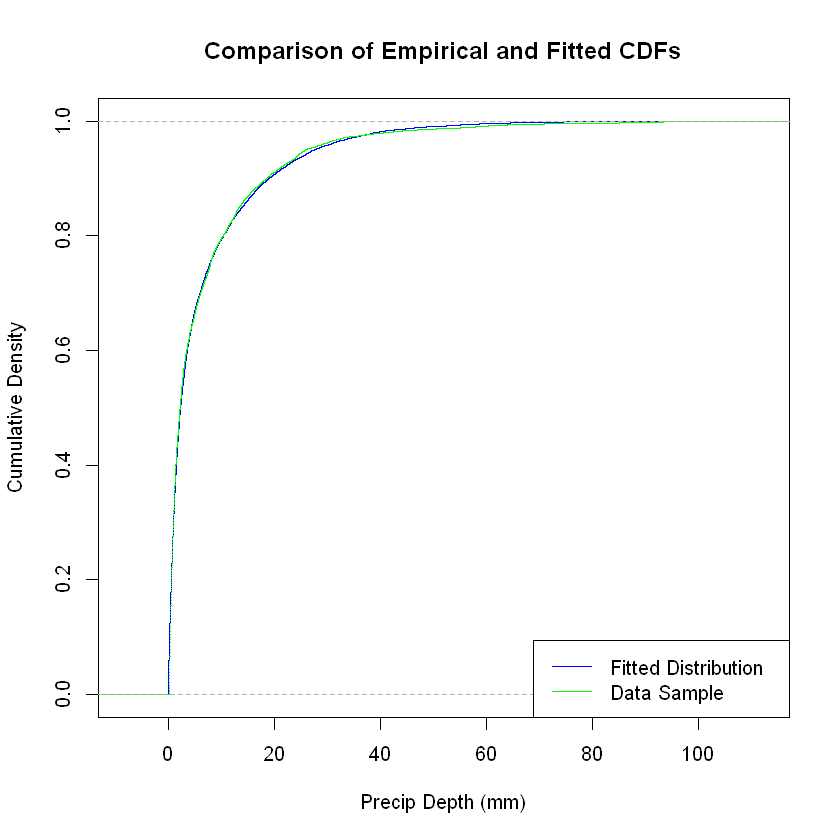

In [426]:
x <- seq(0,wMar4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMar4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [427]:
MonDistDF[15, ] <- list( 3, 4, fdGM_Mar4_shape, fdGM_Mar4_rate, fdGM_Mar4_llike, fdGM_Mar4_mean,
                        fdGM_Mar4_var, fdGM_Mar4_KSStat, fdGM_Mar4_KSp, fdME_Mar4_rate1,
                        fdME_Mar4_rate2, fdME_Mar4_lambda, fdME_Mar4_mean1, fdME_Mar4_mean2,
                        fdME_Mar4_mean, fdME_Mar4_var1, fdME_Mar4_var2, fdME_Mar4_var,
                        fdME_Mar4_llike, fdME_Mar4_KSStat, fdME_Mar4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

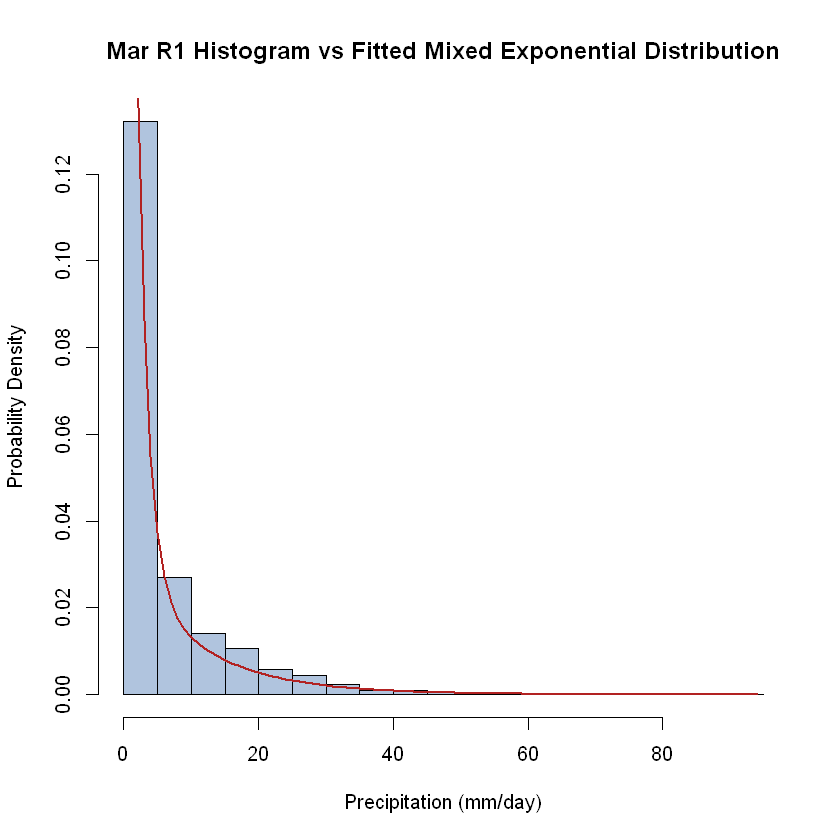

In [428]:
xVals <- seq(1, wMar1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Mar1_lambda, spec1="exp", arg1=list(rate=fdME_Mar1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Mar1_rate2) )
hist( dfMar1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Mar R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

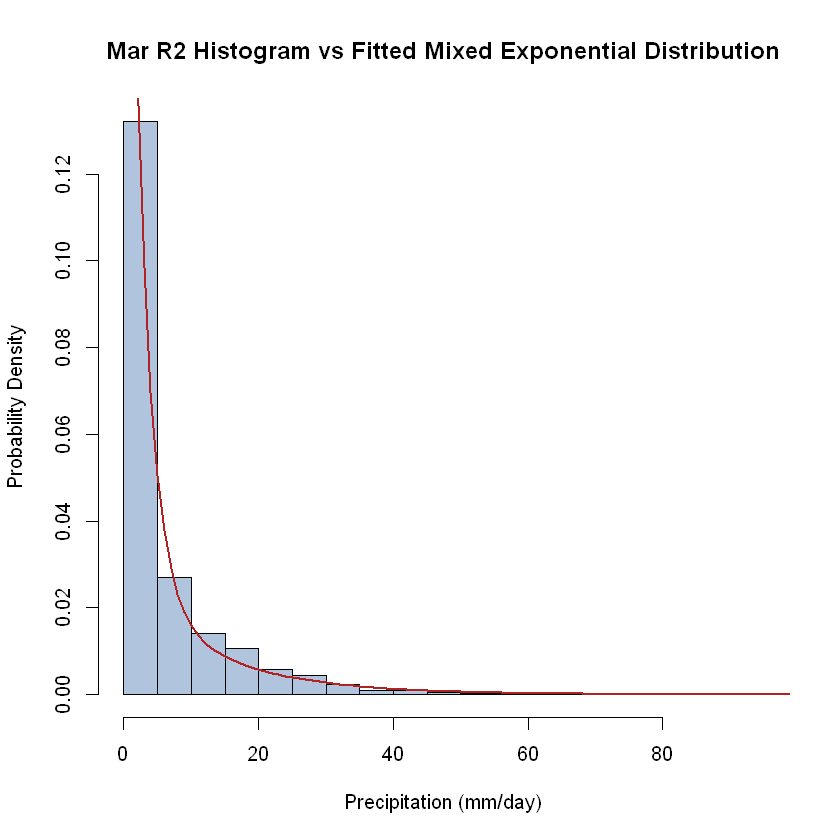

In [429]:
xVals <- seq(1, wMar2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Mar2_lambda, spec1="exp", arg1=list(rate=fdME_Mar2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Mar2_rate2) )
hist( dfMar1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Mar R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

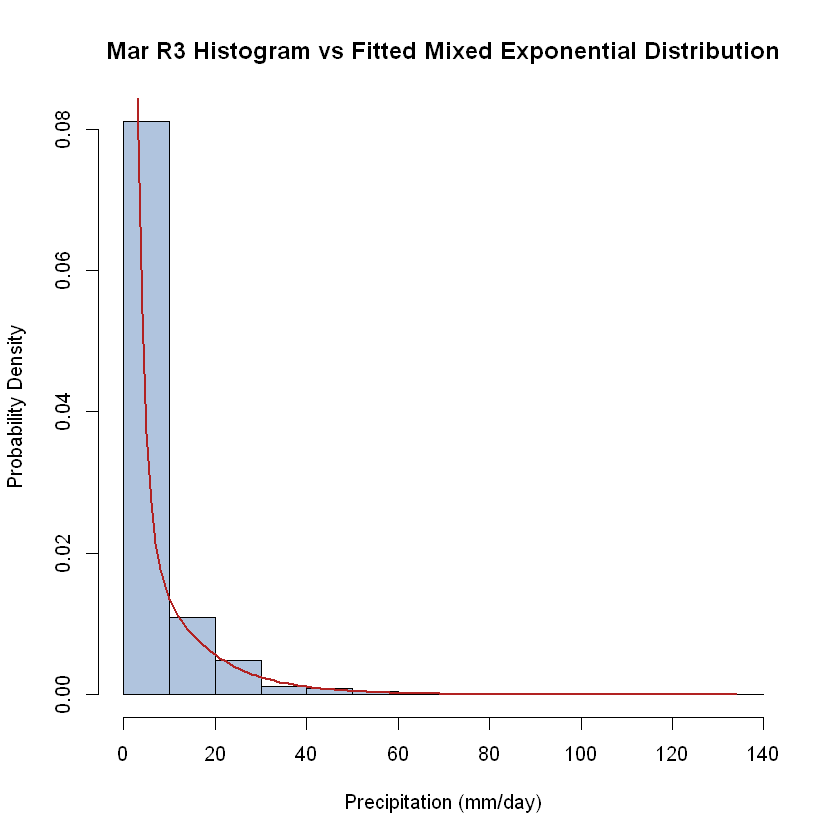

In [430]:
xVals <- seq(1, wMar3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Mar3_lambda, spec1="exp", arg1=list(rate=fdME_Mar3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Mar3_rate2) )
hist( dfMar3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Mar R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

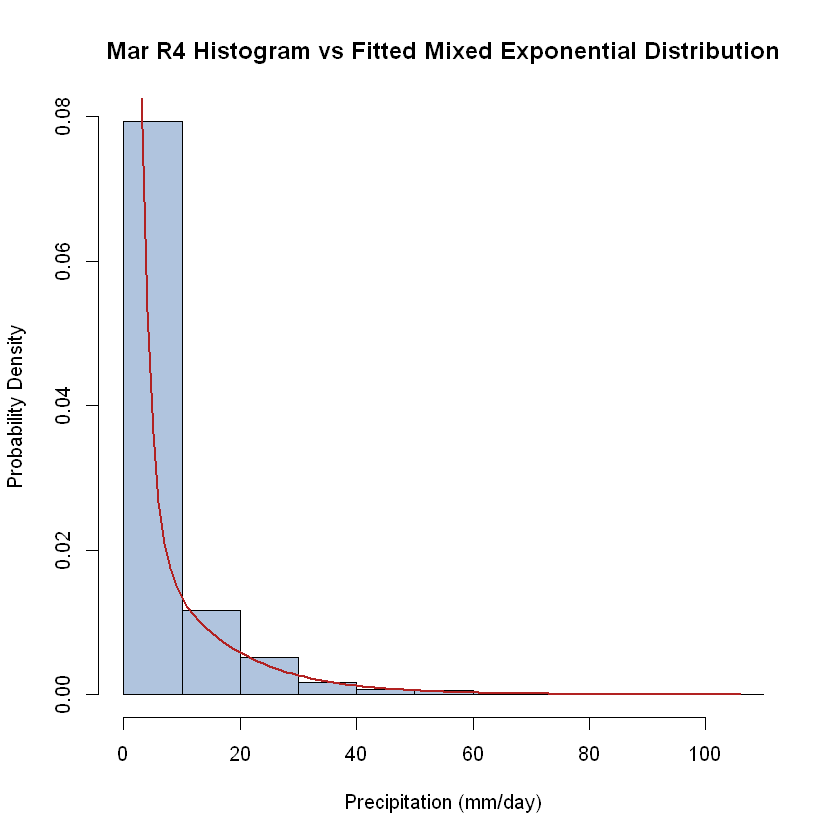

In [431]:
xVals <- seq(1, wMar4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Mar4_lambda, spec1="exp", arg1=list(rate=fdME_Mar4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Mar4_rate2) )
hist( dfMar4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Mar R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Apr

#### All

**Gamma**

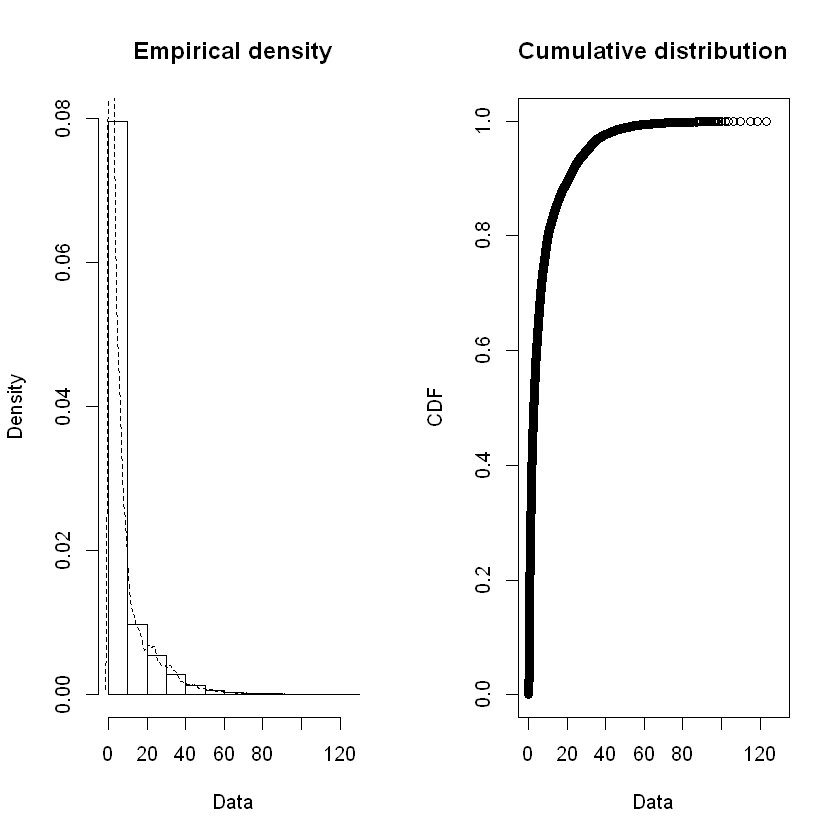

In [432]:
plotdist( dfApr$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  123.09 
median:  2.78 
mean:  7.158889 
estimated sd:  10.95 
estimated skewness:  3.060313 
estimated kurtosis:  15.71463 

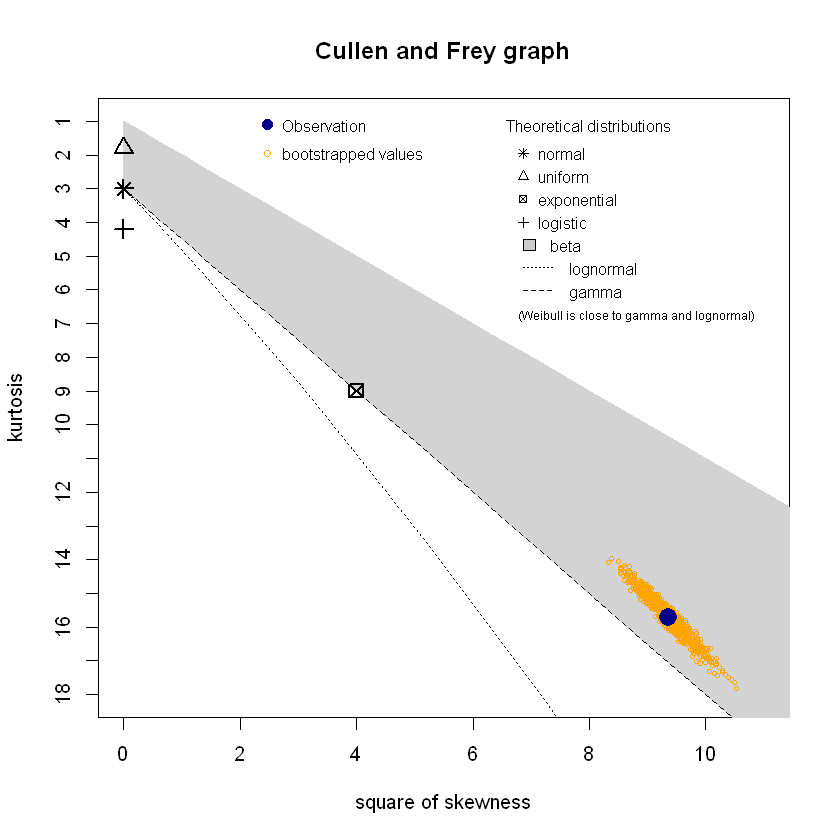

In [433]:
descdist( dfApr$Precip_mm, boot=1000 )

In [434]:
fd_GM_AprA <- fitdist( dfApr$Precip_mm, "gamma" )

In [435]:
summary( fd_GM_AprA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.67311545 0.0044656928
rate  0.09402961 0.0008888745
Loglikelihood:  -95194.5   AIC:  190393   BIC:  190409.8 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7016841
rate  0.7016841 1.0000000


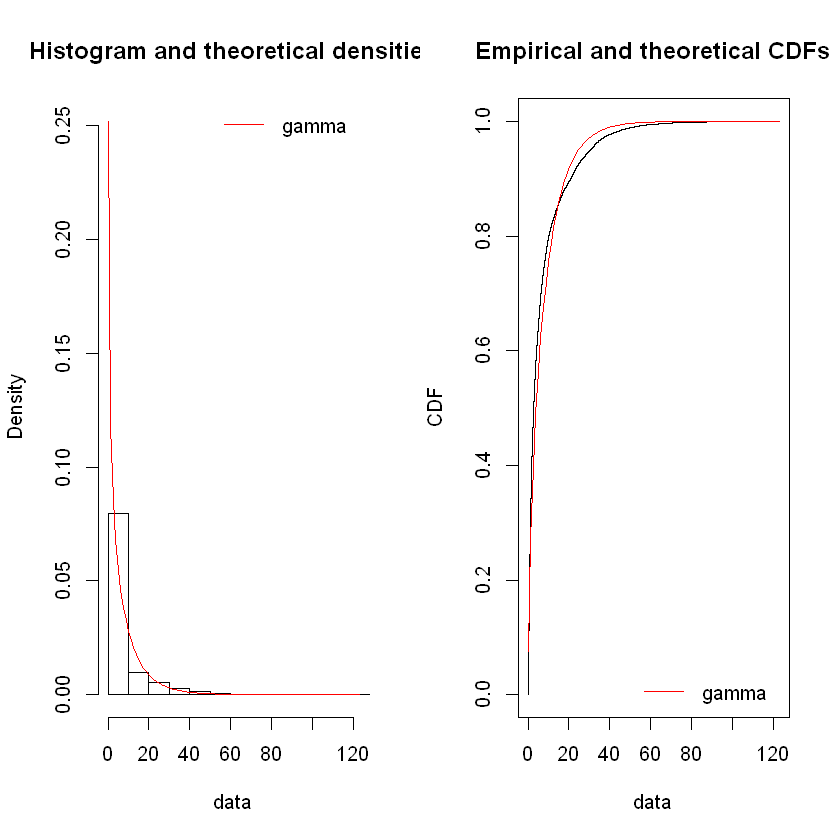

In [436]:
par(mfrow = c(1, 2))
denscomp(fd_GM_AprA)
#qqcomp(fd_GM_AprA)
cdfcomp(fd_GM_AprA)
#ppcomp(fd_GM_AprA)

In [437]:
fdGM_AprA_shape <- fd_GM_AprA$estimate[["shape"]]
fdGM_AprA_rate <- fd_GM_AprA$estimate[["rate"]]
fdGM_AprA_llike <- fd_GM_AprA$loglik
fdGM_AprA_mean <- fdGM_AprA_shape / fdGM_AprA_rate
fdGM_AprA_var <- fdGM_AprA_shape / ( fdGM_AprA_rate ^ 2 )
cat(" Apr A shape: ", fdGM_AprA_shape, "\n", "Apr A rate: ", fdGM_AprA_rate, 
    "\n", "Apr A loglikelihood: ", fdGM_AprA_llike, "\n", 
    "Apr A mean: ", fdGM_AprA_mean, "\n",
    "Apr A variance: ", fdGM_AprA_var, "\n" )

 Apr A shape:  0.6731155 
 Apr A rate:  0.09402961 
 Apr A loglikelihood:  -95194.5 
 Apr A mean:  7.158547 
 Apr A variance:  76.13078 


In [438]:
statRes <- gofstat( fd_GM_AprA, fitnames=c("Gamma") )

In [439]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.09618553
Cramer-von Mises statistic   123.72638687
Anderson-Darling statistic   701.46339777

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 190393.0
Bayesian Information Criterion 190409.8


In [440]:
ksRes <- ks.test( dfApr$Precip_mm, "pgamma", shape=fdGM_AprA_shape, rate=fdGM_AprA_rate )

Warning message in ks.test(dfApr$Precip_mm, "pgamma", shape = fdGM_AprA_shape, rate = fdGM_AprA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [441]:
fdGM_AprA_KSStat <- ksRes$statistic
fdGM_AprA_KSp <- ksRes$p.value
cat(" Apr A K-S stat: ", fdGM_AprA_KSStat, "\n",
    "Apr A K-S p-value: ", fdGM_AprA_KSp )

 Apr A K-S stat:  0.09618553 
 Apr A K-S p-value:  0

**Mixed Exponential**

In [442]:
fd_ME_AprA <- expRMM_EM( dfApr$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfApr$Precip_mm), 1.0/mean(dfApr$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 119 


In [443]:
summary( fd_ME_AprA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.589898 0.4101021
rate   0.448844 0.0701674
loglik at estimate:  -92531.94 
0 % of the data right censored


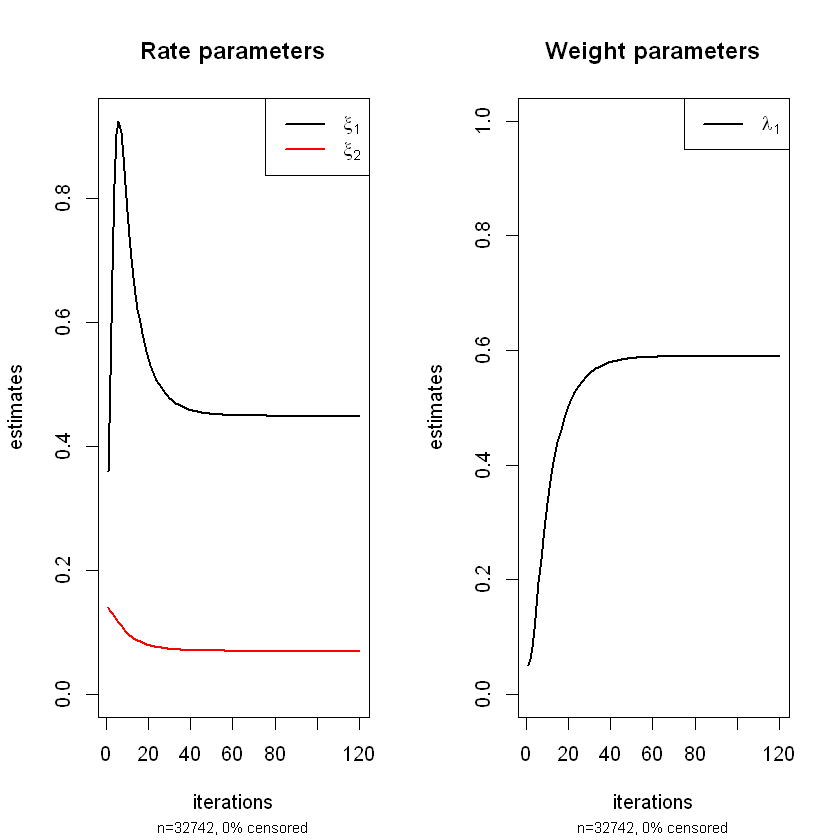

In [444]:
plotexpRMM( fd_ME_AprA, lwd=2 )

In [445]:
fdME_AprA_rate1 <- fd_ME_AprA$rate[[1]]
fdME_AprA_rate2 <- fd_ME_AprA$rate[[2]]
fdME_AprA_lambda <- fd_ME_AprA$lambda[[1]]
fdME_AprA_mean1 <- 1.0 / fdME_AprA_rate1
fdME_AprA_mean2 <- 1.0 / fdME_AprA_rate2
fdME_AprA_mean <- ( (fdME_AprA_lambda * fdME_AprA_mean1) + 
                    ( ( 1.0 - fdME_AprA_lambda) * fdME_AprA_mean2 ) )
fdME_AprA_var1 <- 1.0 / (fdME_AprA_rate1 ^ 2)
fdME_AprA_var2 <- 1.0 / (fdME_AprA_rate2 ^ 2)
fdME_AprA_var <- ( (fdME_AprA_lambda * ( fdME_AprA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_AprA_lambda) * (fdME_AprA_mean2 ^ 2) ) + 
                   ( fdME_AprA_lambda * ( 1.0 - fdME_AprA_lambda) * 
                       ( fdME_AprA_mean1 - fdME_AprA_mean2 )^2 ) )
fdME_AprA_llike <- fd_ME_AprA$loglik
cat(" Apr A rate1: ", fdME_AprA_rate1, "\n", 
    "Apr A rate2: ", fdME_AprA_rate2, "\n",
    "Apr A lambda: ", fdME_AprA_lambda, "\n",
    "Apr A mean1: ", fdME_AprA_mean1, "\n",
    "Apr A mean2: ", fdME_AprA_mean2, "\n",
    "Apr A mean: ", fdME_AprA_mean, "\n",
    "Apr A var1: ", fdME_AprA_var1, "\n",
    "Apr A var2: ", fdME_AprA_var2, "\n",
    "Apr A var: ", fdME_AprA_var, "\n",
    "Apr A loglikelihood: ", fdME_AprA_llike, "\n" )

 Apr A rate1:  0.4488437 
 Apr A rate2:  0.07016736 
 Apr A lambda:  0.5898979 
 Apr A mean1:  2.227947 
 Apr A mean2:  14.25164 
 Apr A mean:  7.158889 
 Apr A var1:  4.963748 
 Apr A var2:  203.1093 
 Apr A var:  121.1976 
 Apr A loglikelihood:  -92531.94 


In [446]:
tvals <- rexpmix(length(dfApr$Precip_mm), fd_ME_AprA$lambda, fd_ME_AprA$rate )

In [447]:
ksRes <- ks.test( dfApr$Precip_mm, tvals )

Warning message in ks.test(dfApr$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [448]:
fdME_AprA_KSStat <- ksRes$statistic
fdME_AprA_KSp <- ksRes$p.value
cat(" Apr A K-S stat: ", fdME_AprA_KSStat, "\n",
    "Apr A K-S p-value: ", fdME_AprA_KSp )

 Apr A K-S stat:  0.05815161 
 Apr A K-S p-value:  0

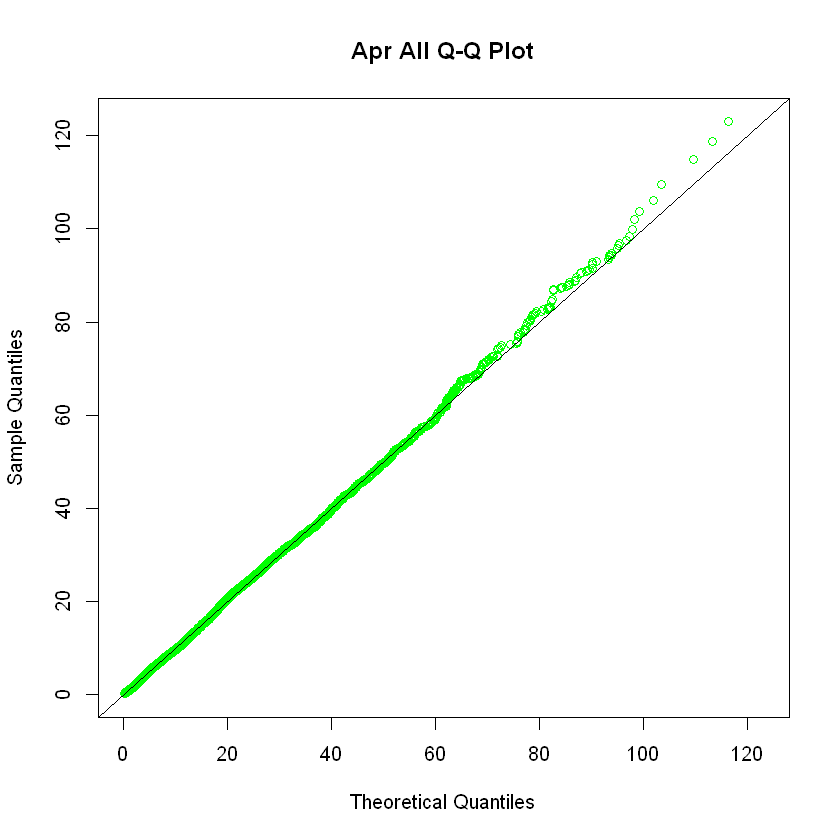

In [449]:
wAprAMax <- max( max( dfApr$Precip_mm ), max( tvals ) )
qqplot( tvals, dfApr$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Apr All Q-Q Plot",
        xlim=c(0,wAprAMax), ylim=c(0,wAprAMax) )
abline( 0, 1)

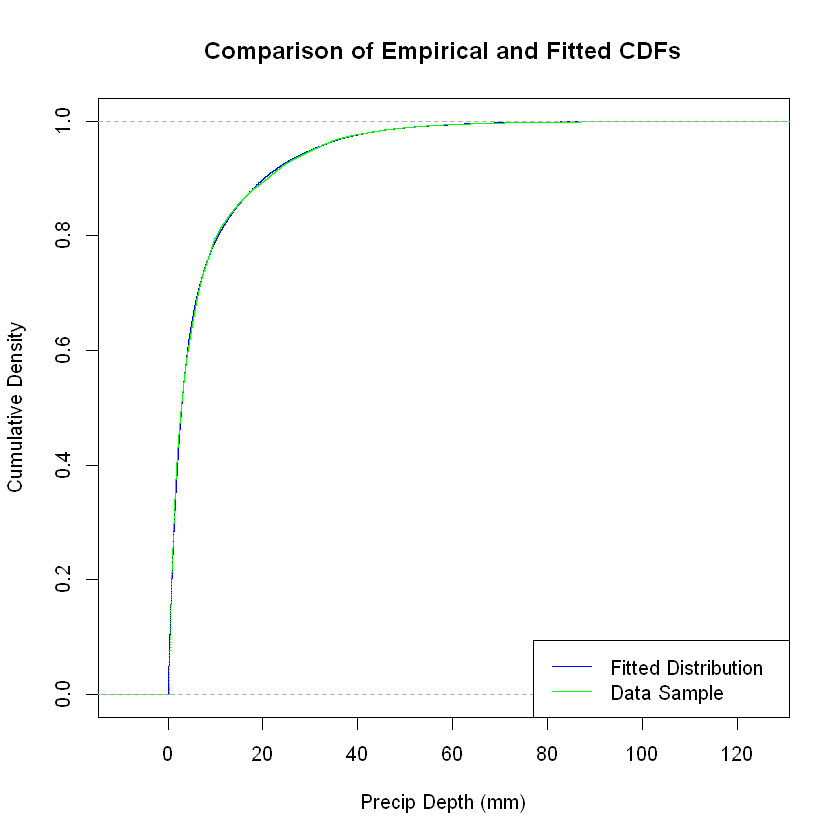

In [450]:
x <- seq(0,wAprAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfApr$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [451]:
MonDistDF[16, ] <- list( 4, 0, fdGM_AprA_shape, fdGM_AprA_rate, fdGM_AprA_llike, fdGM_AprA_mean,
                        fdGM_AprA_var, fdGM_AprA_KSStat, fdGM_AprA_KSp, fdME_AprA_rate1,
                        fdME_AprA_rate2, fdME_AprA_lambda, fdME_AprA_mean1, fdME_AprA_mean2,
                        fdME_AprA_mean, fdME_AprA_var1, fdME_AprA_var2, fdME_AprA_var,
                        fdME_AprA_llike, fdME_AprA_KSStat, fdME_AprA_KSp )

#### Region 1

**Gamma**

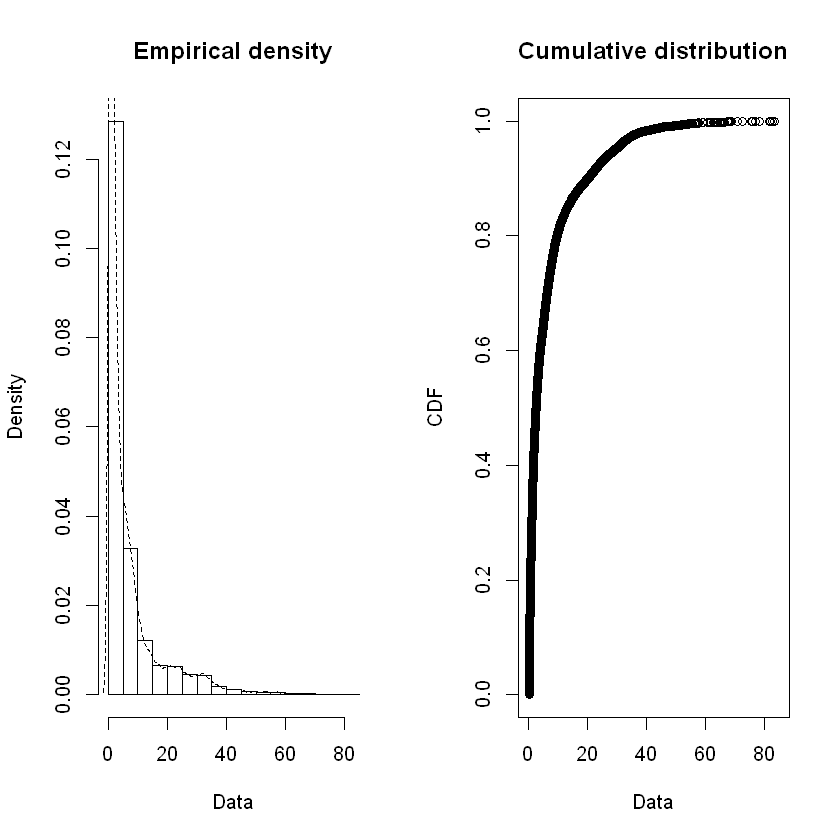

In [452]:
plotdist( dfApr1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  83.14 
median:  2.58 
mean:  6.716187 
estimated sd:  9.867435 
estimated skewness:  2.635686 
estimated kurtosis:  11.33912 

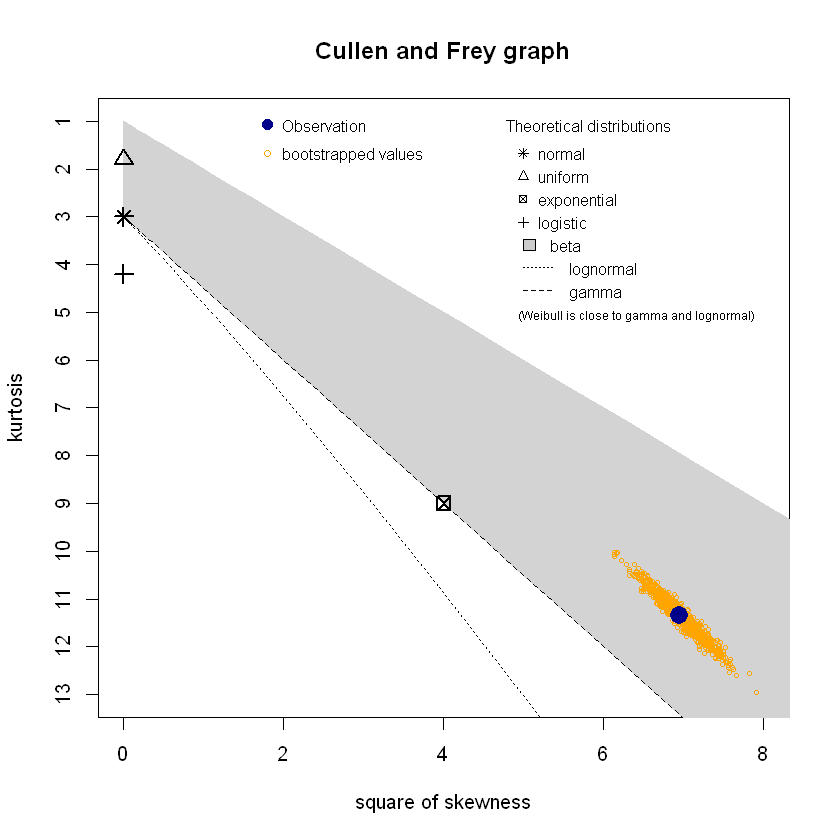

In [453]:
descdist( dfApr1$Precip_mm, boot=1000 )

In [454]:
fd_GM_Apr1 <- fitdist( dfApr1$Precip_mm, "gamma" )

In [455]:
summary( fd_GM_Apr1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.6820819 0.006587969
rate  0.1015856 0.001392526
Loglikelihood:  -44108.26   AIC:  88220.52   BIC:  88235.81 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7044878
rate  0.7044878 1.0000000


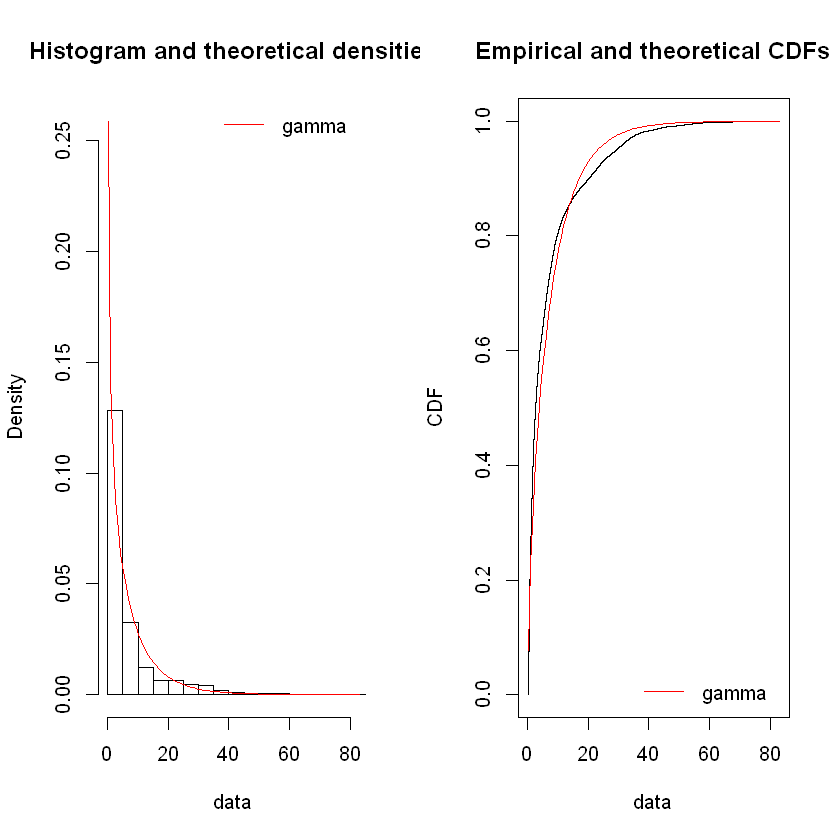

In [456]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Apr1)
#qqcomp(fd_GM_Apr1)
cdfcomp(fd_GM_Apr1)
#ppcomp(fd_GM_Apr1)

In [457]:
fdGM_Apr1_shape <- fd_GM_Apr1$estimate[["shape"]]
fdGM_Apr1_rate <- fd_GM_Apr1$estimate[["rate"]]
fdGM_Apr1_llike <- fd_GM_Apr1$loglik
fdGM_Apr1_mean <- fdGM_Apr1_shape / fdGM_Apr1_rate
fdGM_Apr1_var <- fdGM_Apr1_shape / ( fdGM_Apr1_rate ^ 2 )
cat(" Apr 1 shape: ", fdGM_Apr1_shape, "\n", "Apr 1 rate: ", fdGM_Apr1_rate, 
    "\n", "Apr 1 loglikelihood: ", fdGM_Apr1_llike, "\n", 
    "Apr 1 mean: ", fdGM_Apr1_mean, "\n",
    "Apr 1 variance: ", fdGM_Apr1_var, "\n" )

 Apr 1 shape:  0.6820819 
 Apr 1 rate:  0.1015856 
 Apr 1 loglikelihood:  -44108.26 
 Apr 1 mean:  6.714358 
 Apr 1 variance:  66.09557 


In [458]:
statRes <- gofstat( fd_GM_Apr1, fitnames=c("Gamma") )

In [459]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1025394
Cramer-von Mises statistic    57.9138203
Anderson-Darling statistic   335.0337337

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 88220.52
Bayesian Information Criterion 88235.81


In [460]:
ksRes <- ks.test( dfApr1$Precip_mm, "pgamma", shape=fdGM_Apr1_shape, rate=fdGM_Apr1_rate )

Warning message in ks.test(dfApr1$Precip_mm, "pgamma", shape = fdGM_Apr1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [461]:
fdGM_Apr1_KSStat <- ksRes$statistic
fdGM_Apr1_KSp <- ksRes$p.value
cat(" Apr 1 K-S stat: ", fdGM_Apr1_KSStat, "\n",
    "Apr 1 K-S p-value: ", fdGM_Apr1_KSp )

 Apr 1 K-S stat:  0.1025394 
 Apr 1 K-S p-value:  0

**Mixed exponential**

In [462]:
fd_ME_Apr1 <- expRMM_EM( dfApr1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfApr1$Precip_mm), 1.0/mean(dfApr1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 128 


In [463]:
summary( fd_ME_Apr1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.556787 0.4432129
rate   0.505034 0.0789518
loglik at estimate:  -42906.77 
0 % of the data right censored


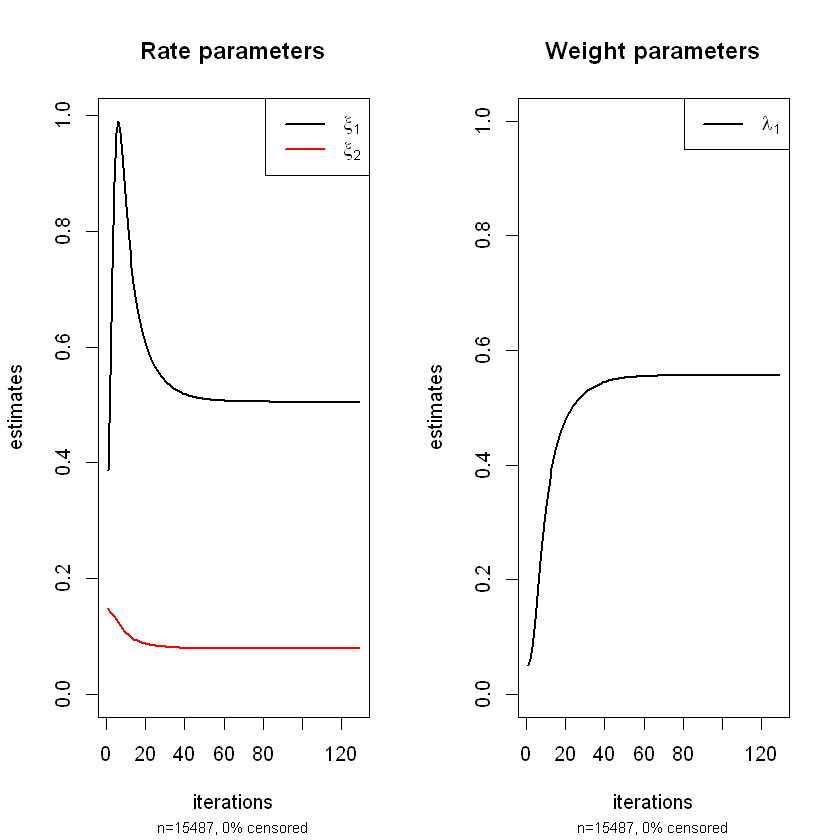

In [464]:
plotexpRMM( fd_ME_Apr1, lwd=2 )

In [465]:
fdME_Apr1_rate1 <- fd_ME_Apr1$rate[[1]]
fdME_Apr1_rate2 <- fd_ME_Apr1$rate[[2]]
fdME_Apr1_lambda <- fd_ME_Apr1$lambda[[1]]
fdME_Apr1_mean1 <- 1.0 / fdME_Apr1_rate1
fdME_Apr1_mean2 <- 1.0 / fdME_Apr1_rate2
fdME_Apr1_mean <- ( (fdME_Apr1_lambda * fdME_Apr1_mean1) + 
                    ( ( 1.0 - fdME_Apr1_lambda) * fdME_Apr1_mean2 ) )
fdME_Apr1_var1 <- 1.0 / (fdME_Apr1_rate1 ^ 2)
fdME_Apr1_var2 <- 1.0 / (fdME_Apr1_rate2 ^ 2)
fdME_Apr1_var <- ( (fdME_Apr1_lambda * ( fdME_Apr1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Apr1_lambda) * (fdME_Apr1_mean2 ^ 2) ) + 
                   ( fdME_Apr1_lambda * ( 1.0 - fdME_Apr1_lambda) * 
                       ( fdME_Apr1_mean1 - fdME_Apr1_mean2 )^2 ) )
fdME_Apr1_llike <- fd_ME_Apr1$loglik
cat(" Apr 1 rate1: ", fdME_Apr1_rate1, "\n", 
    "Apr 1 rate2: ", fdME_Apr1_rate2, "\n",
    "Apr 1 lambda: ", fdME_Apr1_lambda, "\n",
    "Apr 1 mean1: ", fdME_Apr1_mean1, "\n",
    "Apr 1 mean2: ", fdME_Apr1_mean2, "\n",
    "Apr 1 mean: ", fdME_Apr1_mean, "\n",
    "Apr 1 var1: ", fdME_Apr1_var1, "\n",
    "Apr 1 var2: ", fdME_Apr1_var2, "\n",
    "Apr 1 var: ", fdME_Apr1_var, "\n",
    "Apr 1 loglikelihood: ", fdME_Apr1_llike, "\n" )

 Apr 1 rate1:  0.505034 
 Apr 1 rate2:  0.07895184 
 Apr 1 lambda:  0.5567871 
 Apr 1 mean1:  1.980065 
 Apr 1 mean2:  12.66595 
 Apr 1 mean:  6.716187 
 Apr 1 var1:  3.920657 
 Apr 1 var2:  160.4263 
 Apr 1 var:  101.4648 
 Apr 1 loglikelihood:  -42906.77 


In [466]:
tvals <- rexpmix(length(dfApr1$Precip_mm), fd_ME_Apr1$lambda, fd_ME_Apr1$rate )

In [467]:
ksRes <- ks.test( dfApr1$Precip_mm, tvals )

Warning message in ks.test(dfApr1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [468]:
fdME_Apr1_KSStat <- ksRes$statistic
fdME_Apr1_KSp <- ksRes$p.value
cat(" Apr 1 K-S stat: ", fdME_Apr1_KSStat, "\n",
    "Apr 1 K-S p-value: ", fdME_Apr1_KSp )

 Apr 1 K-S stat:  0.06450571 
 Apr 1 K-S p-value:  0

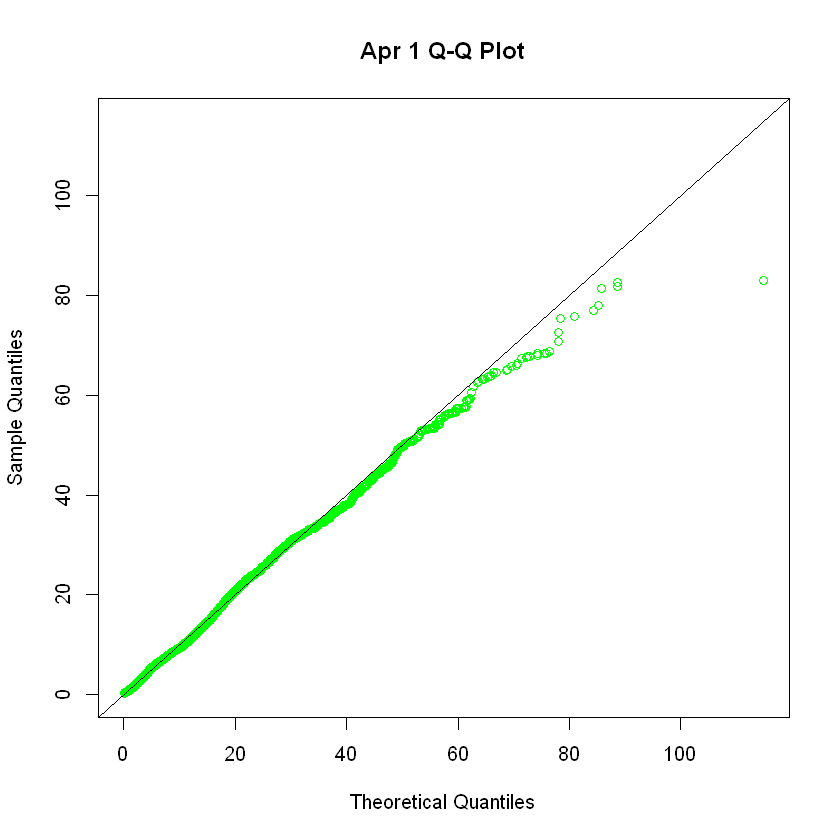

In [469]:
wApr1Max <- max( max( dfApr1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfApr1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Apr 1 Q-Q Plot",
        xlim=c(0,wApr1Max), ylim=c(0,wApr1Max) )
abline( 0, 1)

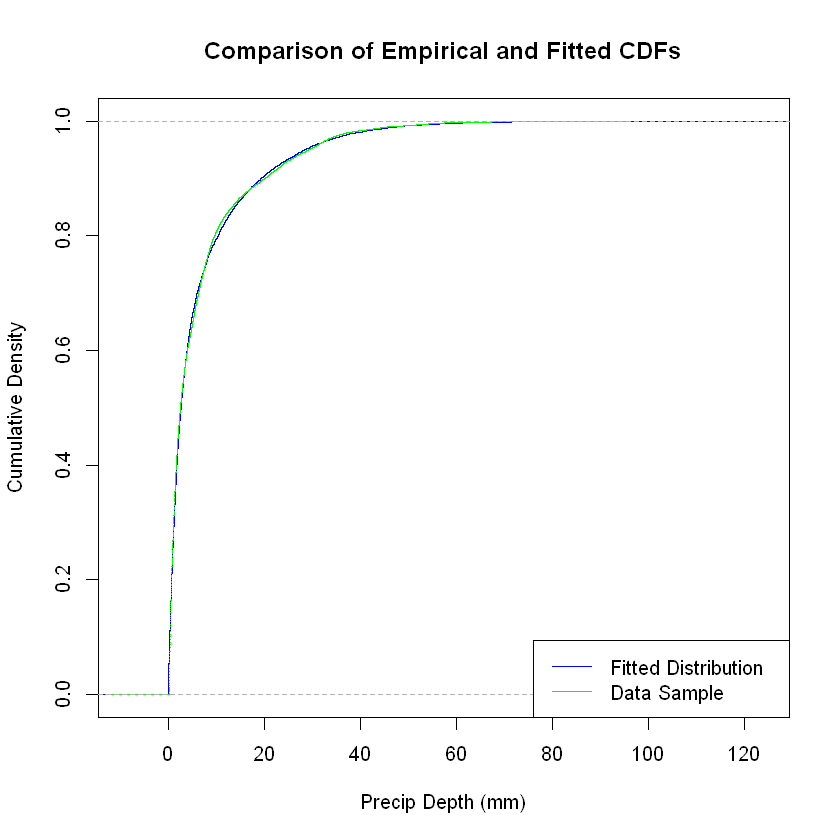

In [470]:
x <- seq(0,wApr1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfApr1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [471]:
MonDistDF[17, ] <- list( 4, 1, fdGM_Apr1_shape, fdGM_Apr1_rate, fdGM_Apr1_llike, fdGM_Apr1_mean,
                        fdGM_Apr1_var, fdGM_Apr1_KSStat, fdGM_Apr1_KSp, fdME_Apr1_rate1,
                        fdME_Apr1_rate2, fdME_Apr1_lambda, fdME_Apr1_mean1, fdME_Apr1_mean2,
                        fdME_Apr1_mean, fdME_Apr1_var1, fdME_Apr1_var2, fdME_Apr1_var,
                        fdME_Apr1_llike, fdME_Apr1_KSStat, fdME_Apr1_KSp )

#### Region 2

**Gamma**

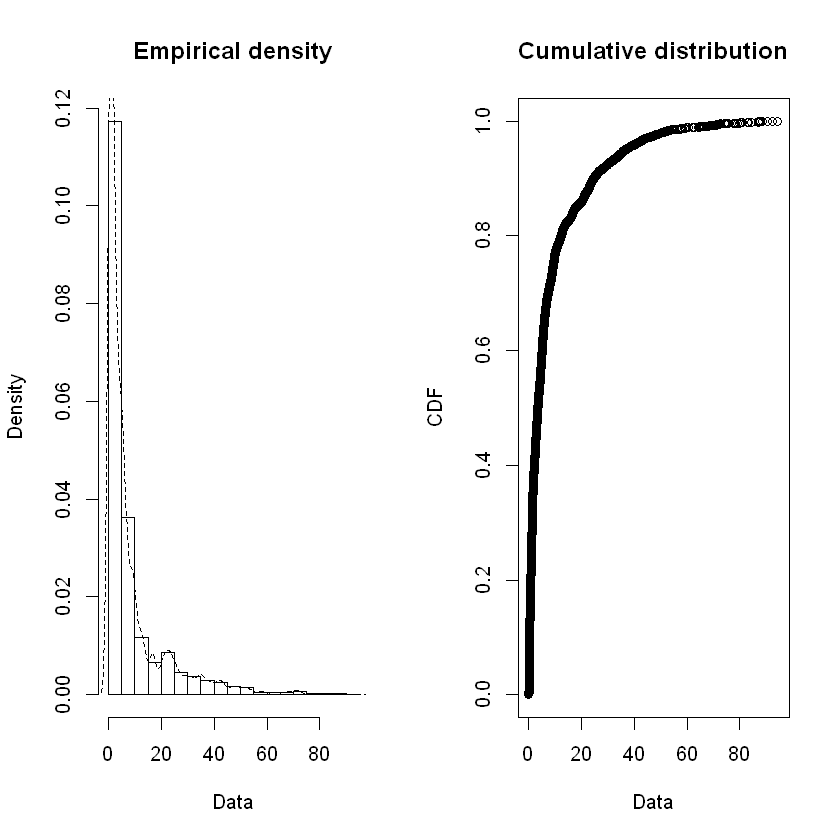

In [472]:
plotdist( dfApr2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  94.18 
median:  3.58 
mean:  8.643112 
estimated sd:  12.93706 
estimated skewness:  2.711927 
estimated kurtosis:  11.66483 

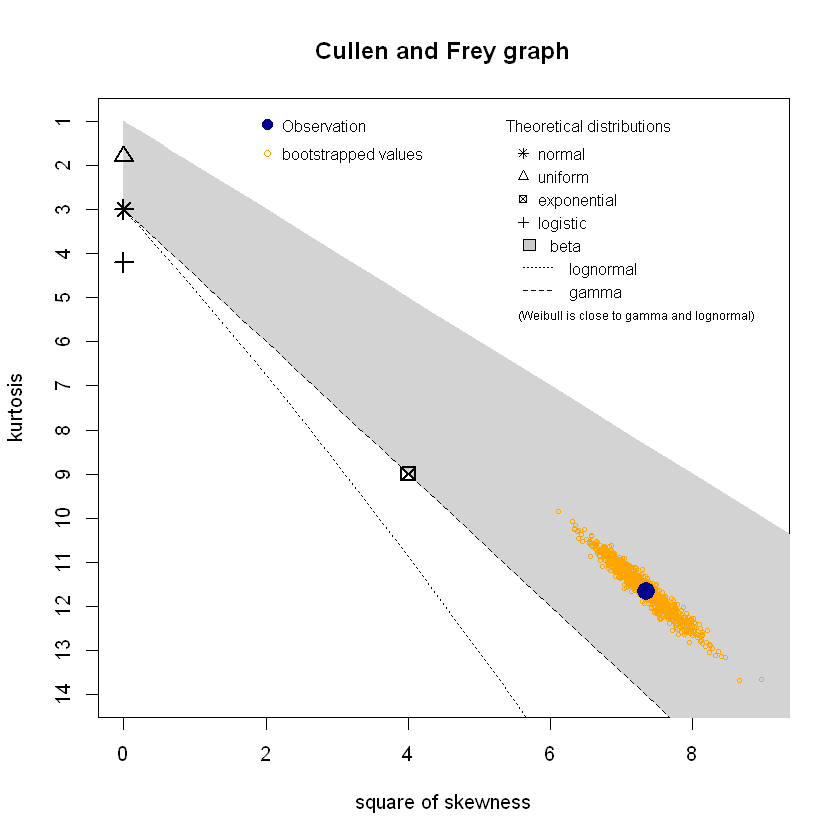

In [473]:
descdist( dfApr2$Precip_mm, boot=1000 )

In [474]:
fd_GM_Apr2 <- fitdist( dfApr2$Precip_mm, "gamma" )

In [475]:
summary( fd_GM_Apr2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.66045412 0.010383636
rate  0.07641185 0.001721555
Loglikelihood:  -17945.42   AIC:  35894.85   BIC:  35908.18 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6976258
rate  0.6976258 1.0000000


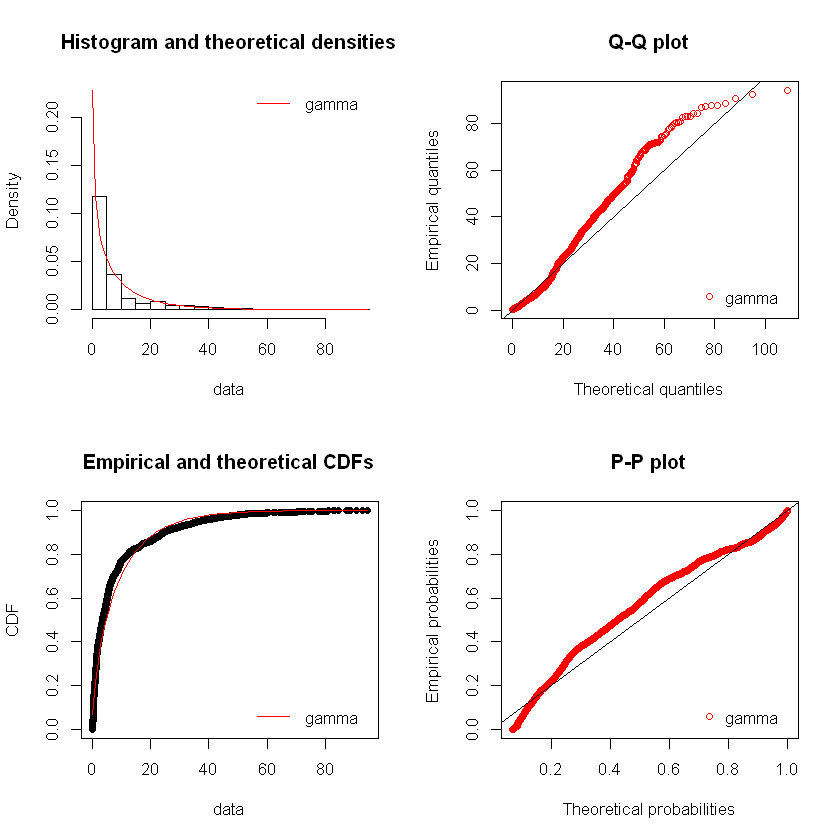

In [476]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Apr2)
qqcomp(fd_GM_Apr2)
cdfcomp(fd_GM_Apr2)
ppcomp(fd_GM_Apr2)

In [477]:
fdGM_Apr2_shape <- fd_GM_Apr2$estimate[["shape"]]
fdGM_Apr2_rate <- fd_GM_Apr2$estimate[["rate"]]
fdGM_Apr2_llike <- fd_GM_Apr2$loglik
fdGM_Apr2_mean <- fdGM_Apr2_shape / fdGM_Apr2_rate
fdGM_Apr2_var <- fdGM_Apr2_shape / ( fdGM_Apr2_rate ^ 2 )
cat(" Apr 2 shape: ", fdGM_Apr2_shape, "\n", "Apr 2 rate: ", fdGM_Apr2_rate, 
    "\n", "Apr 2 loglikelihood: ", fdGM_Apr2_llike, "\n", 
    "Apr 2 mean: ", fdGM_Apr2_mean, "\n",
    "Apr 2 variance: ", fdGM_Apr2_var, "\n" )

 Apr 2 shape:  0.6604541 
 Apr 2 rate:  0.07641185 
 Apr 2 loglikelihood:  -17945.42 
 Apr 2 mean:  8.643346 
 Apr 2 variance:  113.1153 


In [478]:
statRes <- gofstat( fd_GM_Apr2, fitnames=c("Gamma") )

In [479]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.09305215
Cramer-von Mises statistic    18.90027787
Anderson-Darling statistic   108.19923720

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 35894.85
Bayesian Information Criterion 35908.18


In [480]:
ksRes <- ks.test( dfApr2$Precip_mm, "pgamma", shape=fdGM_Apr2_shape, rate=fdGM_Apr2_rate )

Warning message in ks.test(dfApr2$Precip_mm, "pgamma", shape = fdGM_Apr2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [481]:
fdGM_Apr2_KSStat <- ksRes$statistic
fdGM_Apr2_KSp <- ksRes$p.value
cat(" Apr 2 K-S stat: ", fdGM_Apr2_KSStat, "\n",
    "Apr 2 K-S p-value: ", fdGM_Apr2_KSp )

 Apr 2 K-S stat:  0.09305215 
 Apr 2 K-S p-value:  0

**Mixed exponential**

In [482]:
fd_ME_Apr2 <- expRMM_EM( dfApr2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfApr2$Precip_mm), 1.0/mean(dfApr2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 107 


In [483]:
summary( fd_ME_Apr2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.595340 0.4046598
rate   0.366746 0.0576454
loglik at estimate:  -17512.18 
0 % of the data right censored


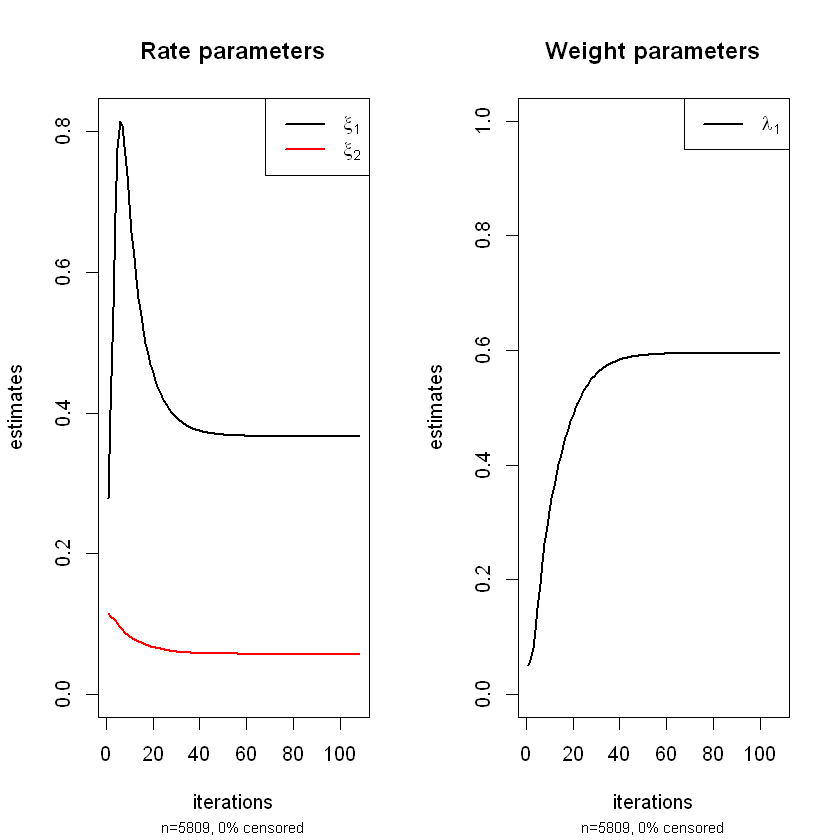

In [484]:
plotexpRMM( fd_ME_Apr2, lwd=2 )

In [485]:
fdME_Apr2_rate1 <- fd_ME_Apr2$rate[[1]]
fdME_Apr2_rate2 <- fd_ME_Apr2$rate[[2]]
fdME_Apr2_lambda <- fd_ME_Apr2$lambda[[1]]
fdME_Apr2_mean1 <- 1.0 / fdME_Apr2_rate1
fdME_Apr2_mean2 <- 1.0 / fdME_Apr2_rate2
fdME_Apr2_mean <- ( (fdME_Apr2_lambda * fdME_Apr2_mean1) + 
                    ( ( 1.0 - fdME_Apr2_lambda) * fdME_Apr2_mean2 ) )
fdME_Apr2_var1 <- 1.0 / (fdME_Apr2_rate1 ^ 2)
fdME_Apr2_var2 <- 1.0 / (fdME_Apr2_rate2 ^ 2)
fdME_Apr2_var <- ( (fdME_Apr2_lambda * ( fdME_Apr2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Apr2_lambda) * (fdME_Apr2_mean2 ^ 2) ) + 
                   ( fdME_Apr2_lambda * ( 1.0 - fdME_Apr2_lambda) * 
                       ( fdME_Apr2_mean1 - fdME_Apr2_mean2 )^2 ) )
fdME_Apr2_llike <- fd_ME_Apr2$loglik
cat(" Apr 2 rate1: ", fdME_Apr2_rate1, "\n", 
    "Apr 2 rate2: ", fdME_Apr2_rate2, "\n",
    "Apr 2 lambda: ", fdME_Apr2_lambda, "\n",
    "Apr 2 mean1: ", fdME_Apr2_mean1, "\n",
    "Apr 2 mean2: ", fdME_Apr2_mean2, "\n",
    "Apr 2 mean: ", fdME_Apr2_mean, "\n",
    "Apr 2 var1: ", fdME_Apr2_var1, "\n",
    "Apr 2 var2: ", fdME_Apr2_var2, "\n",
    "Apr 2 var: ", fdME_Apr2_var, "\n",
    "Apr 2 loglikelihood: ", fdME_Apr2_llike, "\n" )

 Apr 2 rate1:  0.3667461 
 Apr 2 rate2:  0.05764542 
 Apr 2 lambda:  0.5953402 
 Apr 2 mean1:  2.726682 
 Apr 2 mean2:  17.34743 
 Apr 2 mean:  8.643112 
 Apr 2 var1:  7.434794 
 Apr 2 var2:  300.9334 
 Apr 2 var:  177.7004 
 Apr 2 loglikelihood:  -17512.18 


In [486]:
tvals <- rexpmix(length(dfApr2$Precip_mm), fd_ME_Apr2$lambda, fd_ME_Apr2$rate )

In [487]:
ksRes <- ks.test( dfApr2$Precip_mm, tvals )

Warning message in ks.test(dfApr2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [488]:
fdME_Apr2_KSStat <- ksRes$statistic
fdME_Apr2_KSp <- ksRes$p.value
cat(" Apr 2 K-S stat: ", fdME_Apr2_KSStat, "\n",
    "Apr 2 K-S p-value: ", fdME_Apr2_KSp )

 Apr 2 K-S stat:  0.05887416 
 Apr 2 K-S p-value:  3.601859e-09

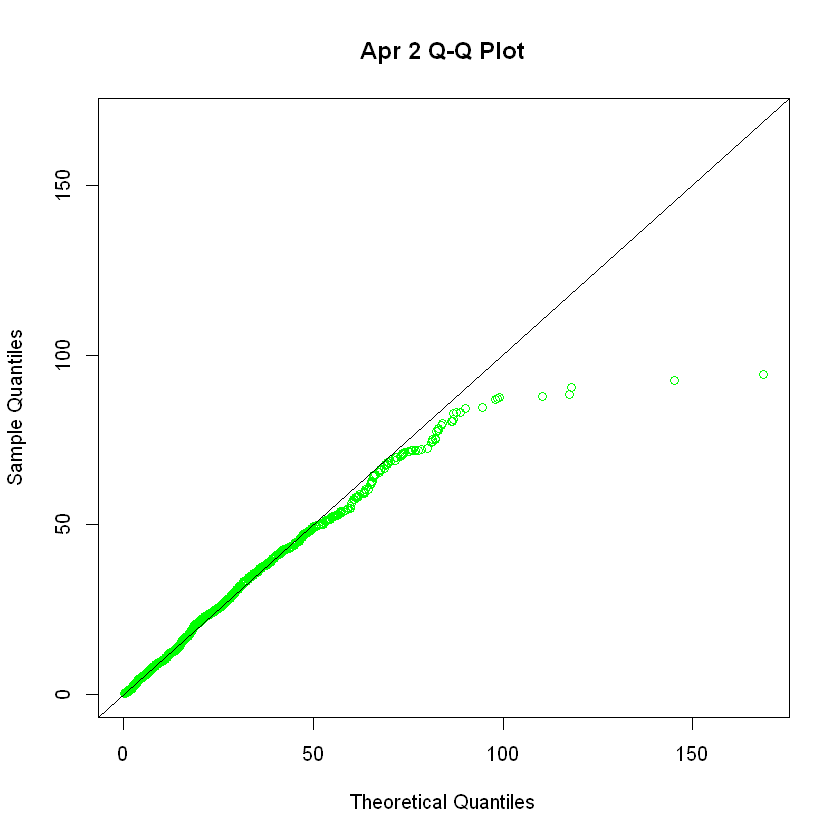

In [489]:
wApr2Max <- max( max( dfApr2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfApr2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Apr 2 Q-Q Plot",
        xlim=c(0,wApr2Max), ylim=c(0,wApr2Max) )
abline( 0, 1)

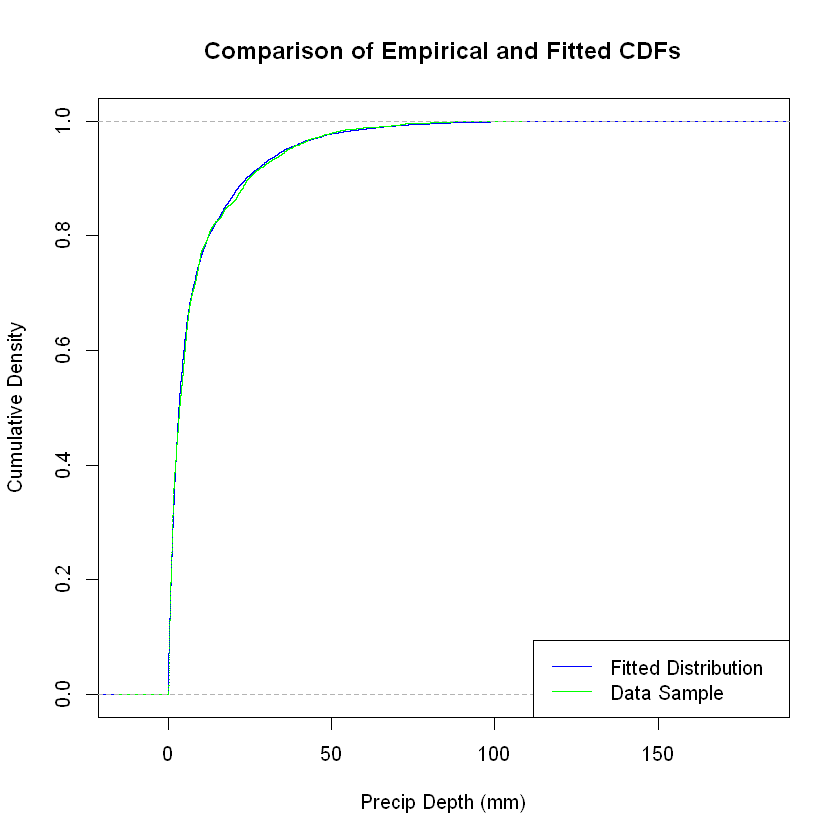

In [490]:
x <- seq(0,wApr2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfApr2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [491]:
MonDistDF[18, ] <- list( 4, 2, fdGM_Apr2_shape, fdGM_Apr2_rate, fdGM_Apr2_llike, fdGM_Apr2_mean,
                        fdGM_Apr2_var, fdGM_Apr2_KSStat, fdGM_Apr2_KSp, fdME_Apr2_rate1,
                        fdME_Apr2_rate2, fdME_Apr2_lambda, fdME_Apr2_mean1, fdME_Apr2_mean2,
                        fdME_Apr2_mean, fdME_Apr2_var1, fdME_Apr2_var2, fdME_Apr2_var,
                        fdME_Apr2_llike, fdME_Apr2_KSStat, fdME_Apr2_KSp )

#### Region 3

**Gamma**

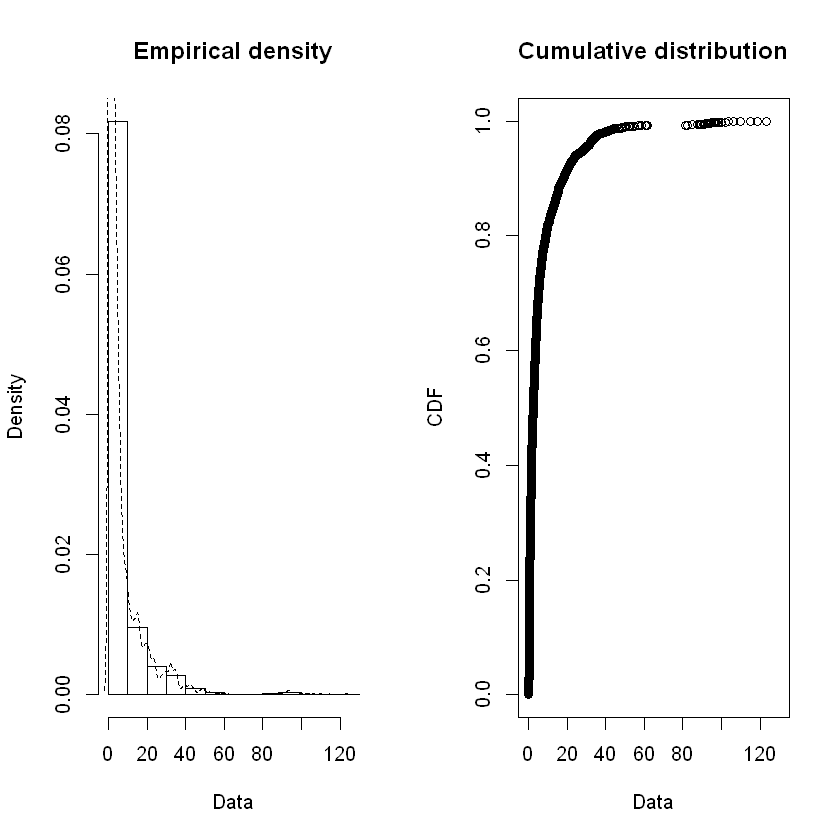

In [492]:
plotdist( dfApr3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  123.09 
median:  2.52 
mean:  6.600893 
estimated sd:  11.5249 
estimated skewness:  4.391645 
estimated kurtosis:  30.31773 

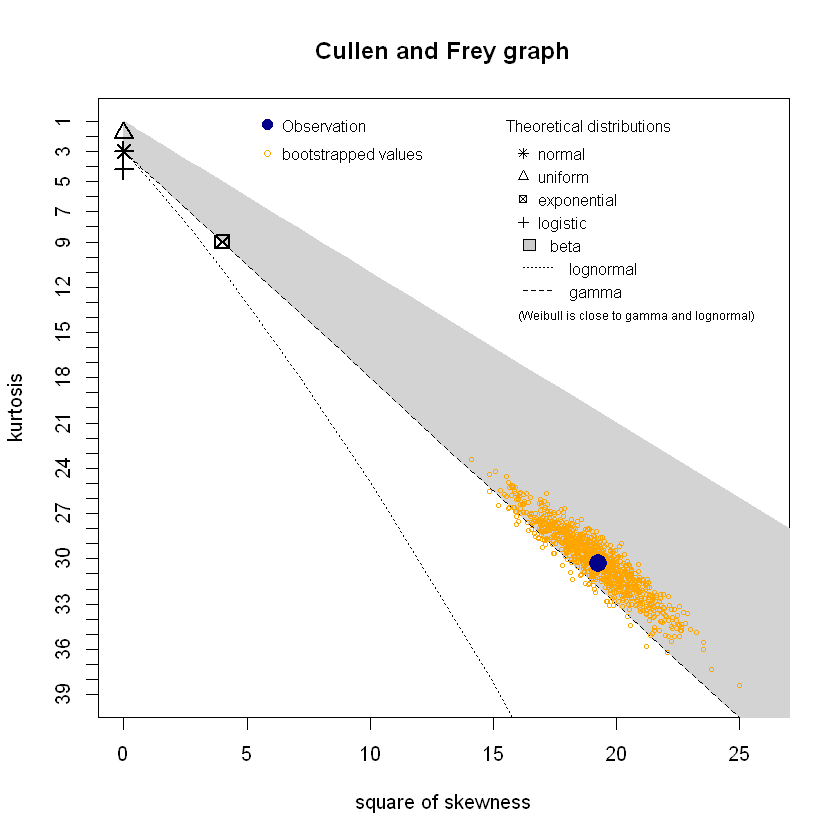

In [493]:
descdist( dfApr3$Precip_mm, boot=1000 )

In [494]:
fd_GM_Apr3 <- fitdist( dfApr3$Precip_mm, "gamma" )

In [495]:
summary( fd_GM_Apr3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.65311614 0.011639227
rate  0.09892572 0.002535197
Loglikelihood:  -12704.75   AIC:  25413.5   BIC:  25426.33 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6952762
rate  0.6952762 1.0000000


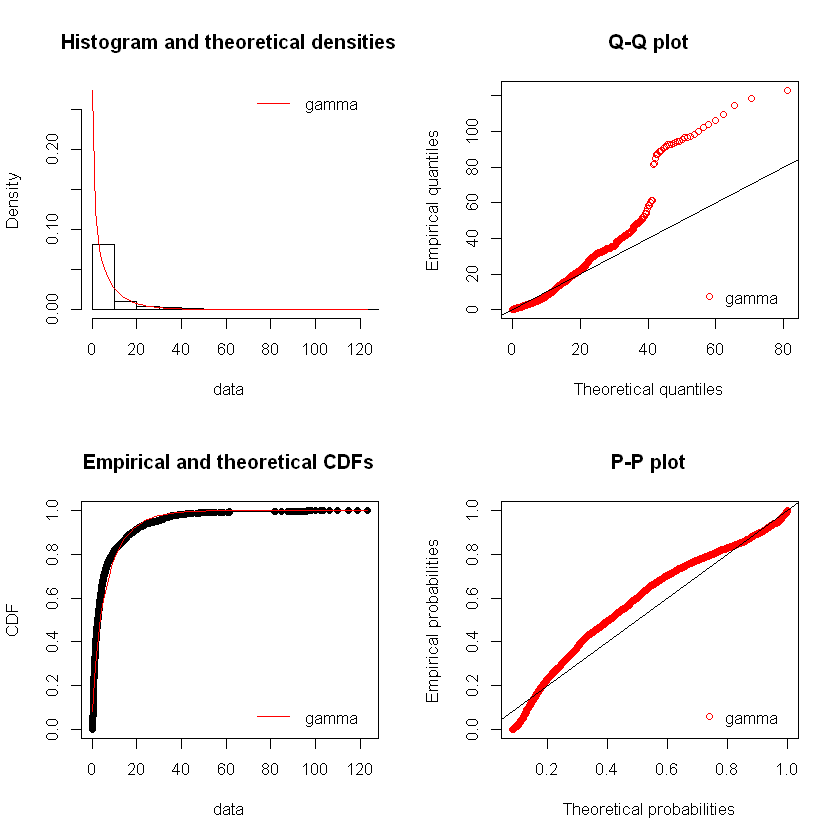

In [496]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Apr3)
qqcomp(fd_GM_Apr3)
cdfcomp(fd_GM_Apr3)
ppcomp(fd_GM_Apr3)

In [497]:
fdGM_Apr3_shape <- fd_GM_Apr3$estimate[["shape"]]
fdGM_Apr3_rate <- fd_GM_Apr3$estimate[["rate"]]
fdGM_Apr3_llike <- fd_GM_Apr3$loglik
fdGM_Apr3_mean <- fdGM_Apr3_shape / fdGM_Apr3_rate
fdGM_Apr3_var <- fdGM_Apr3_shape / ( fdGM_Apr3_rate ^ 2 )
cat(" Apr 3 shape: ", fdGM_Apr3_shape, "\n", "Apr 3 rate: ", fdGM_Apr3_rate, 
    "\n", "Apr 3 loglikelihood: ", fdGM_Apr3_llike, "\n", 
    "Apr 3 mean: ", fdGM_Apr3_mean, "\n",
    "Apr 3 variance: ", fdGM_Apr3_var, "\n" )

 Apr 3 shape:  0.6531161 
 Apr 3 rate:  0.09892572 
 Apr 3 loglikelihood:  -12704.75 
 Apr 3 mean:  6.602086 
 Apr 3 variance:  66.73781 


In [498]:
statRes <- gofstat( fd_GM_Apr3, fitnames=c("Gamma") )

In [499]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1104124
Cramer-von Mises statistic    21.3388603
Anderson-Darling statistic   118.0206082

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 25413.50
Bayesian Information Criterion 25426.33


In [500]:
ksRes <- ks.test( dfApr3$Precip_mm, "pgamma", shape=fdGM_Apr3_shape, rate=fdGM_Apr3_rate )

Warning message in ks.test(dfApr3$Precip_mm, "pgamma", shape = fdGM_Apr3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [501]:
fdGM_Apr3_KSStat <- ksRes$statistic
fdGM_Apr3_KSp <- ksRes$p.value
cat(" Apr 3 K-S stat: ", fdGM_Apr3_KSStat, "\n",
    "Apr 3 K-S p-value: ", fdGM_Apr3_KSp )

 Apr 3 K-S stat:  0.1104124 
 Apr 3 K-S p-value:  0

**Mixed exponential**

In [502]:
fd_ME_Apr3 <- expRMM_EM( dfApr3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfApr3$Precip_mm), 1.0/mean(dfApr3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 90 


In [503]:
summary( fd_ME_Apr3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.656579 0.3434212
rate   0.456469 0.0665222
loglik at estimate:  -12245.56 
0 % of the data right censored


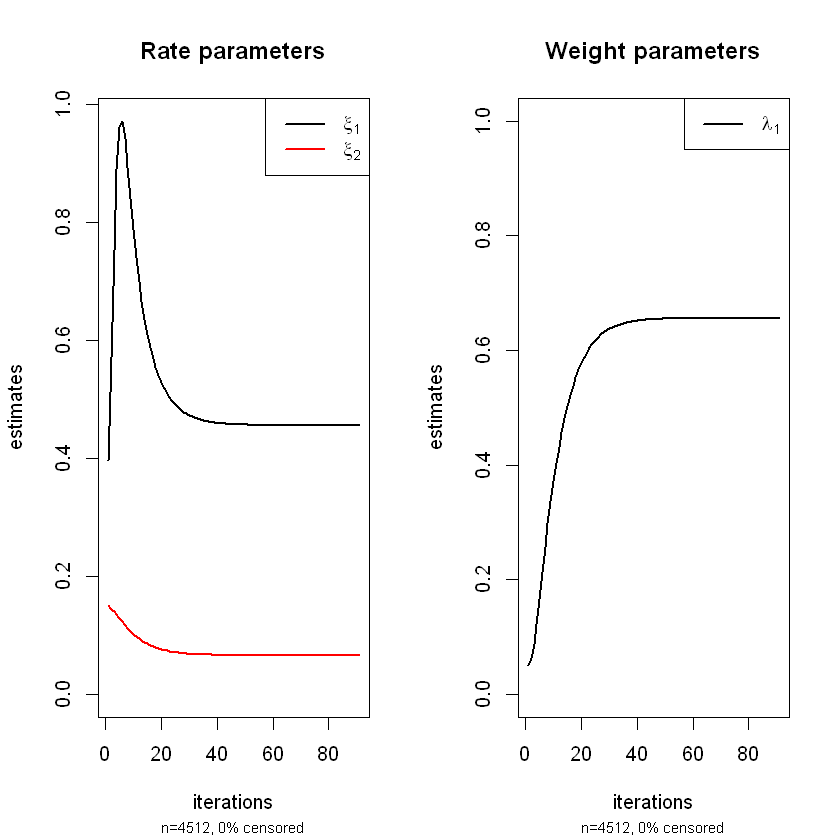

In [504]:
plotexpRMM( fd_ME_Apr3, lwd=2 )

In [505]:
fdME_Apr3_rate1 <- fd_ME_Apr3$rate[[1]]
fdME_Apr3_rate2 <- fd_ME_Apr3$rate[[2]]
fdME_Apr3_lambda <- fd_ME_Apr3$lambda[[1]]
fdME_Apr3_mean1 <- 1.0 / fdME_Apr3_rate1
fdME_Apr3_mean2 <- 1.0 / fdME_Apr3_rate2
fdME_Apr3_mean <- ( (fdME_Apr3_lambda * fdME_Apr3_mean1) + 
                    ( ( 1.0 - fdME_Apr3_lambda) * fdME_Apr3_mean2 ) )
fdME_Apr3_var1 <- 1.0 / (fdME_Apr3_rate1 ^ 2)
fdME_Apr3_var2 <- 1.0 / (fdME_Apr3_rate2 ^ 2)
fdME_Apr3_var <- ( (fdME_Apr3_lambda * ( fdME_Apr3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Apr3_lambda) * (fdME_Apr3_mean2 ^ 2) ) + 
                   ( fdME_Apr3_lambda * ( 1.0 - fdME_Apr3_lambda) * 
                       ( fdME_Apr3_mean1 - fdME_Apr3_mean2 )^2 ) )
fdME_Apr3_llike <- fd_ME_Apr3$loglik
cat(" Apr 3 rate1: ", fdME_Apr3_rate1, "\n", 
    "Apr 3 rate2: ", fdME_Apr3_rate2, "\n",
    "Apr 3 lambda: ", fdME_Apr3_lambda, "\n",
    "Apr 3 mean1: ", fdME_Apr3_mean1, "\n",
    "Apr 3 mean2: ", fdME_Apr3_mean2, "\n",
    "Apr 3 mean: ", fdME_Apr3_mean, "\n",
    "Apr 3 var1: ", fdME_Apr3_var1, "\n",
    "Apr 3 var2: ", fdME_Apr3_var2, "\n",
    "Apr 3 var: ", fdME_Apr3_var, "\n",
    "Apr 3 loglikelihood: ", fdME_Apr3_llike, "\n" )

 Apr 3 rate1:  0.4564686 
 Apr 3 rate2:  0.06652219 
 Apr 3 lambda:  0.6565788 
 Apr 3 mean1:  2.190731 
 Apr 3 mean2:  15.03258 
 Apr 3 mean:  6.600893 
 Apr 3 var1:  4.799303 
 Apr 3 var2:  225.9784 
 Apr 3 var:  117.942 
 Apr 3 loglikelihood:  -12245.56 


In [506]:
tvals <- rexpmix(length(dfApr3$Precip_mm), fd_ME_Apr3$lambda, fd_ME_Apr3$rate )

In [507]:
ksRes <- ks.test( dfApr3$Precip_mm, tvals )

Warning message in ks.test(dfApr3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [508]:
fdME_Apr3_KSStat <- ksRes$statistic
fdME_Apr3_KSp <- ksRes$p.value
cat(" Apr 3 K-S stat: ", fdME_Apr3_KSStat, "\n",
    "Apr 3 K-S p-value: ", fdME_Apr3_KSp )

 Apr 3 K-S stat:  0.06405142 
 Apr 3 K-S p-value:  1.827535e-08

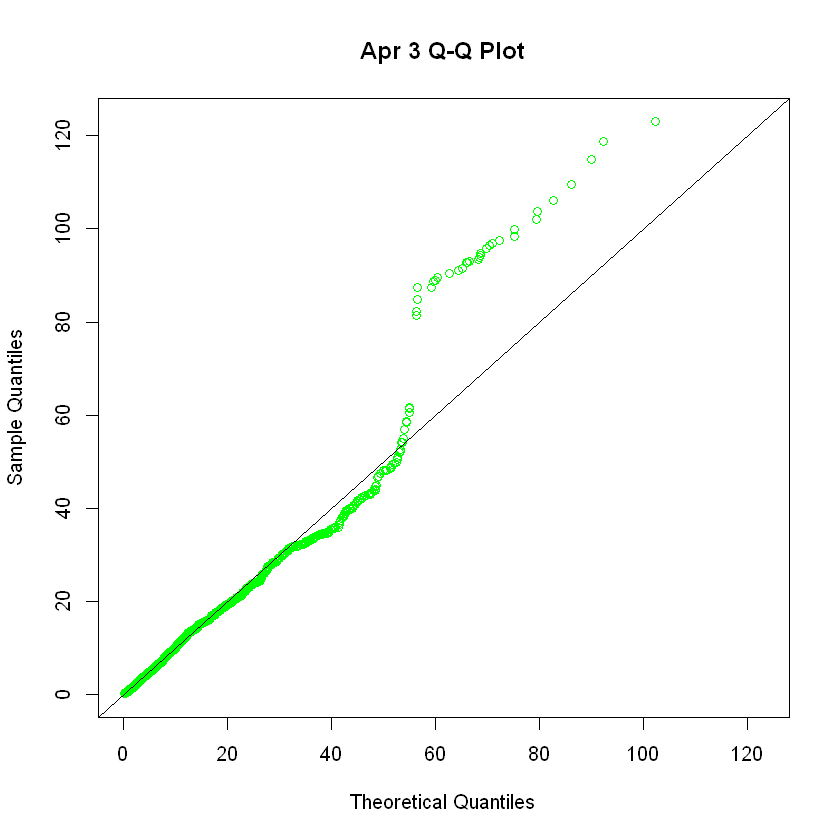

In [509]:
wApr3Max <- max( max( dfApr3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfApr3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Apr 3 Q-Q Plot",
        xlim=c(0,wApr3Max), ylim=c(0,wApr3Max) )
abline( 0, 1)

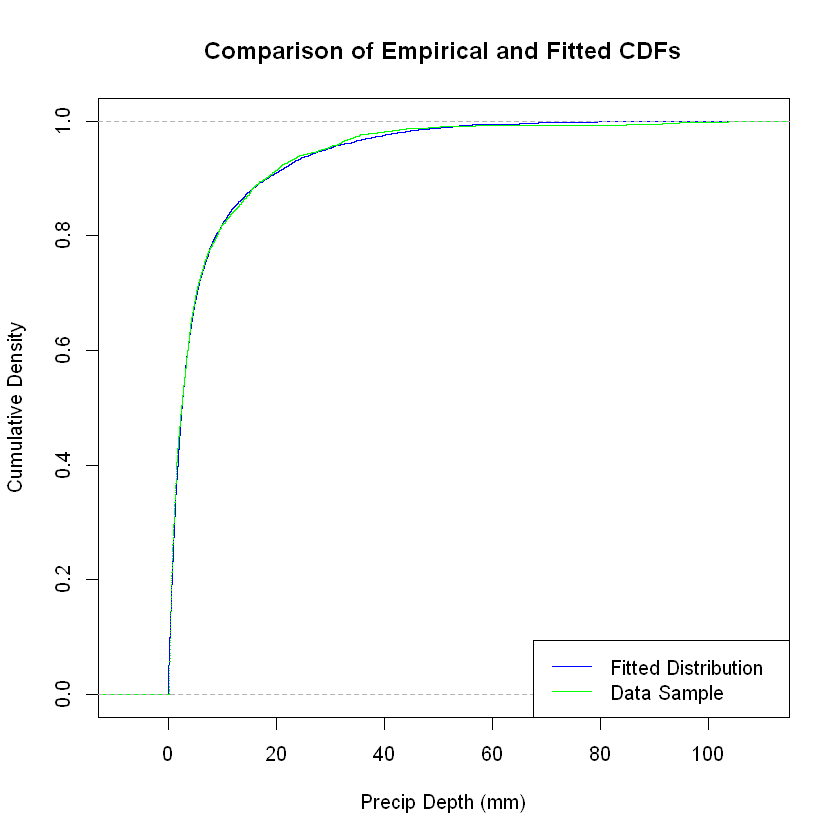

In [510]:
x <- seq(0,wApr3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfApr3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [511]:
MonDistDF[19, ] <- list( 4, 3, fdGM_Apr3_shape, fdGM_Apr3_rate, fdGM_Apr3_llike, fdGM_Apr3_mean,
                        fdGM_Apr3_var, fdGM_Apr3_KSStat, fdGM_Apr3_KSp, fdME_Apr3_rate1,
                        fdME_Apr3_rate2, fdME_Apr3_lambda, fdME_Apr3_mean1, fdME_Apr3_mean2,
                        fdME_Apr3_mean, fdME_Apr3_var1, fdME_Apr3_var2, fdME_Apr3_var,
                        fdME_Apr3_llike, fdME_Apr3_KSStat, fdME_Apr3_KSp )

#### Region 4

**Gamma**

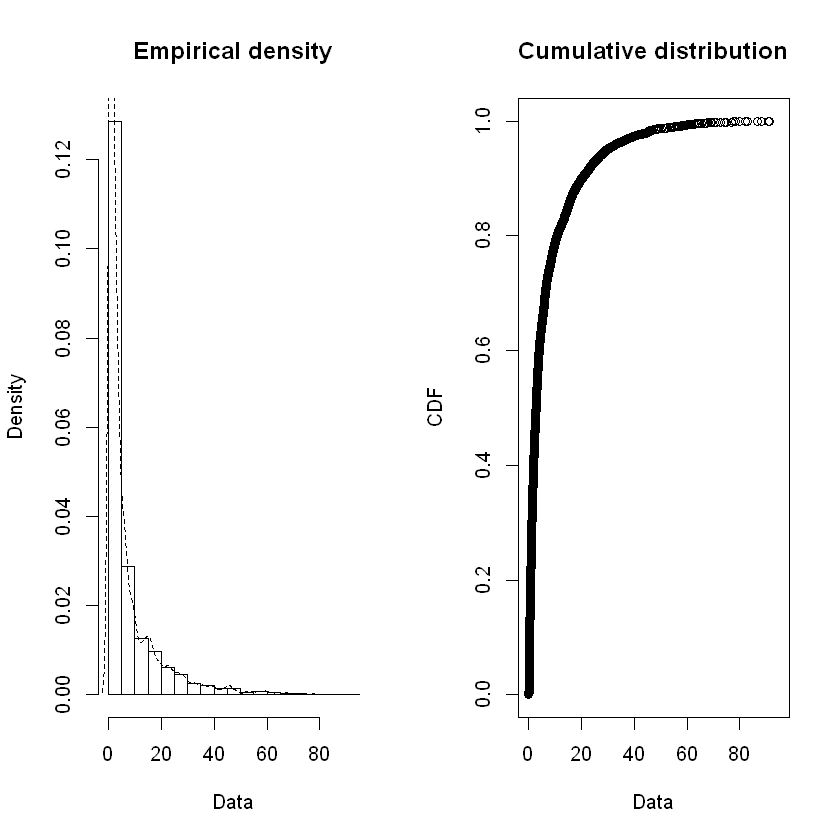

In [512]:
plotdist( dfApr4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  91.33 
median:  2.9 
mean:  7.267335 
estimated sd:  10.93731 
estimated skewness:  2.902508 
estimated kurtosis:  13.44828 

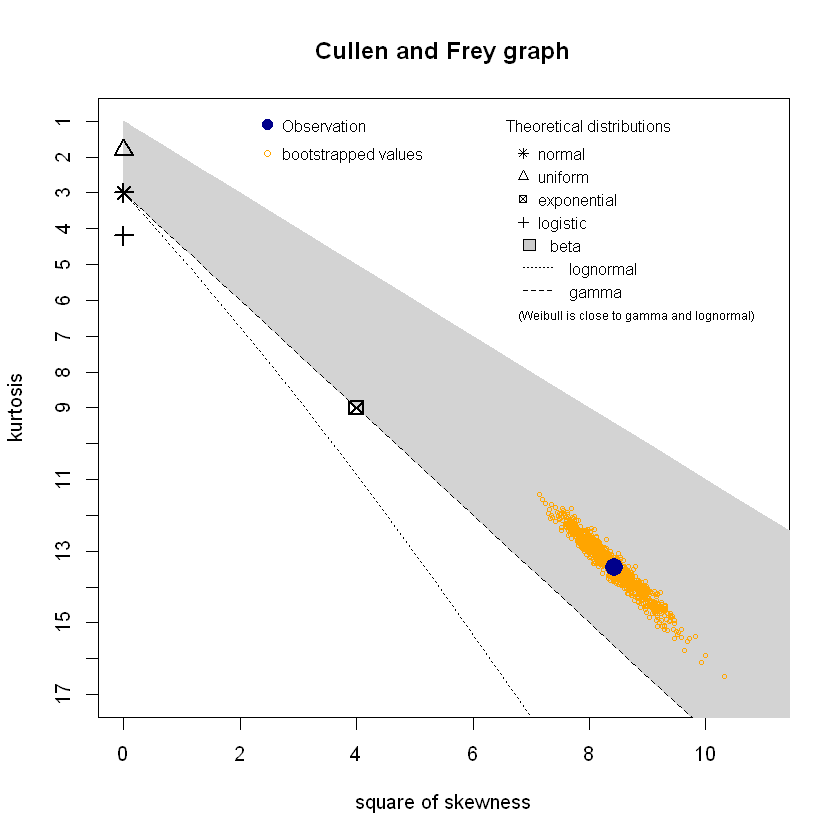

In [513]:
descdist( dfApr4$Precip_mm, boot=1000 )

In [514]:
fd_GM_Apr4 <- fitdist( dfApr4$Precip_mm, "gamma" )

In [515]:
summary( fd_GM_Apr4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.69167394 0.009997146
rate  0.09516467 0.001943985
Loglikelihood:  -20326.13   AIC:  40656.26   BIC:  40669.95 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7074204
rate  0.7074204 1.0000000


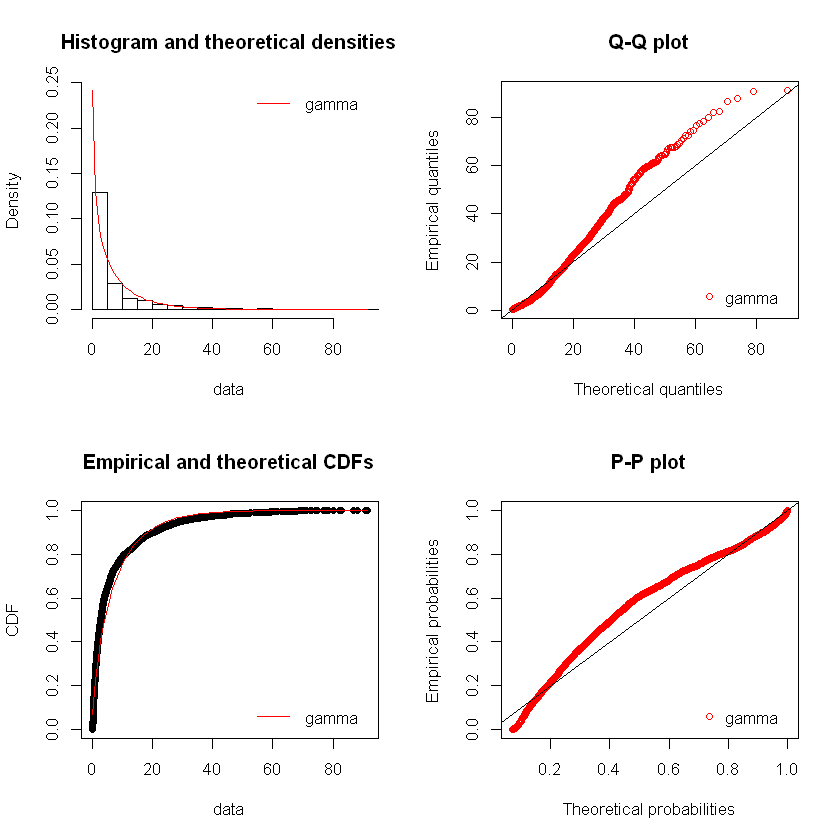

In [516]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Apr4)
qqcomp(fd_GM_Apr4)
cdfcomp(fd_GM_Apr4)
ppcomp(fd_GM_Apr4)

In [517]:
fdGM_Apr4_shape <- fd_GM_Apr4$estimate[["shape"]]
fdGM_Apr4_rate <- fd_GM_Apr4$estimate[["rate"]]
fdGM_Apr4_llike <- fd_GM_Apr4$loglik
fdGM_Apr4_mean <- fdGM_Apr4_shape / fdGM_Apr4_rate
fdGM_Apr4_var <- fdGM_Apr4_shape / ( fdGM_Apr4_rate ^ 2 )
cat(" Apr 4 shape: ", fdGM_Apr4_shape, "\n", "Apr 4 rate: ", fdGM_Apr4_rate, 
    "\n", "Apr 4 loglikelihood: ", fdGM_Apr4_llike, "\n", 
    "Apr 4 mean: ", fdGM_Apr4_mean, "\n",
    "Apr 4 variance: ", fdGM_Apr4_var, "\n" )

 Apr 4 shape:  0.6916739 
 Apr 4 rate:  0.09516467 
 Apr 4 loglikelihood:  -20326.13 
 Apr 4 mean:  7.26818 
 Apr 4 variance:  76.37476 


In [518]:
statRes <- gofstat( fd_GM_Apr4, fitnames=c("Gamma") )

In [519]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1099864
Cramer-von Mises statistic    27.0869843
Anderson-Darling statistic   148.0554459

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 40656.26
Bayesian Information Criterion 40669.95


In [520]:
ksRes <- ks.test( dfApr4$Precip_mm, "pgamma", shape=fdGM_Apr4_shape, rate=fdGM_Apr4_rate )

Warning message in ks.test(dfApr4$Precip_mm, "pgamma", shape = fdGM_Apr4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [521]:
fdGM_Apr4_KSStat <- ksRes$statistic
fdGM_Apr4_KSp <- ksRes$p.value
cat(" Apr 4 K-S stat: ", fdGM_Apr4_KSStat, "\n",
    "Apr 4 K-S p-value: ", fdGM_Apr4_KSp )

 Apr 4 K-S stat:  0.1099864 
 Apr 4 K-S p-value:  0

**Mixed exponential**

In [522]:
fd_ME_Apr4 <- expRMM_EM( dfApr4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfApr4$Precip_mm), 1.0/mean(dfApr4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 99 


In [523]:
summary( fd_ME_Apr4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.587918 0.4120821
rate   0.433254 0.0697221
loglik at estimate:  -19761.84 
0 % of the data right censored


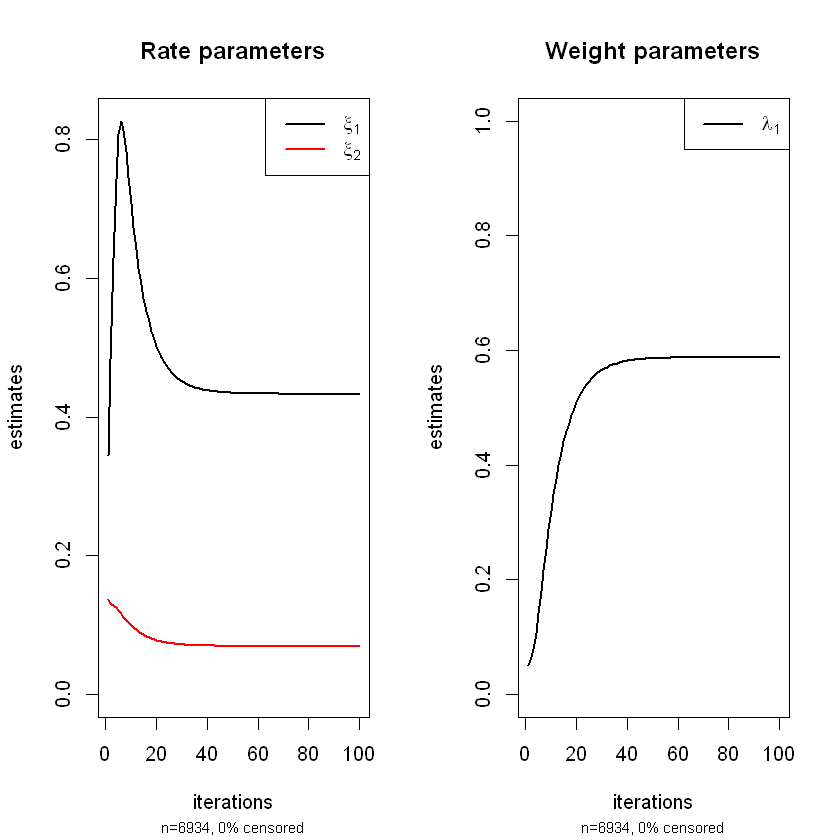

In [524]:
plotexpRMM( fd_ME_Apr4, lwd=2 )

In [525]:
fdME_Apr4_rate1 <- fd_ME_Apr4$rate[[1]]
fdME_Apr4_rate2 <- fd_ME_Apr4$rate[[2]]
fdME_Apr4_lambda <- fd_ME_Apr4$lambda[[1]]
fdME_Apr4_mean1 <- 1.0 / fdME_Apr4_rate1
fdME_Apr4_mean2 <- 1.0 / fdME_Apr4_rate2
fdME_Apr4_mean <- ( (fdME_Apr4_lambda * fdME_Apr4_mean1) + 
                    ( ( 1.0 - fdME_Apr4_lambda) * fdME_Apr4_mean2 ) )
fdME_Apr4_var1 <- 1.0 / (fdME_Apr4_rate1 ^ 2)
fdME_Apr4_var2 <- 1.0 / (fdME_Apr4_rate2 ^ 2)
fdME_Apr4_var <- ( (fdME_Apr4_lambda * ( fdME_Apr4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Apr4_lambda) * (fdME_Apr4_mean2 ^ 2) ) + 
                   ( fdME_Apr4_lambda * ( 1.0 - fdME_Apr4_lambda) * 
                       ( fdME_Apr4_mean1 - fdME_Apr4_mean2 )^2 ) )
fdME_Apr4_llike <- fd_ME_Apr4$loglik
cat(" Apr 4 rate1: ", fdME_Apr4_rate1, "\n", 
    "Apr 4 rate2: ", fdME_Apr4_rate2, "\n",
    "Apr 4 lambda: ", fdME_Apr4_lambda, "\n",
    "Apr 4 mean1: ", fdME_Apr4_mean1, "\n",
    "Apr 4 mean2: ", fdME_Apr4_mean2, "\n",
    "Apr 4 mean: ", fdME_Apr4_mean, "\n",
    "Apr 4 var1: ", fdME_Apr4_var1, "\n",
    "Apr 4 var2: ", fdME_Apr4_var2, "\n",
    "Apr 4 var: ", fdME_Apr4_var, "\n",
    "Apr 4 loglikelihood: ", fdME_Apr4_llike, "\n" )

 Apr 4 rate1:  0.4332537 
 Apr 4 rate2:  0.06972209 
 Apr 4 lambda:  0.5879179 
 Apr 4 mean1:  2.308117 
 Apr 4 mean2:  14.34266 
 Apr 4 mean:  7.267335 
 Apr 4 var1:  5.327402 
 Apr 4 var2:  205.7118 
 Apr 4 var:  122.9903 
 Apr 4 loglikelihood:  -19761.84 


In [526]:
tvals <- rexpmix(length(dfApr4$Precip_mm), fd_ME_Apr4$lambda, fd_ME_Apr4$rate )

In [527]:
ksRes <- ks.test( dfApr4$Precip_mm, tvals )

Warning message in ks.test(dfApr4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [528]:
fdME_Apr4_KSStat <- ksRes$statistic
fdME_Apr4_KSp <- ksRes$p.value
cat(" Apr 4 K-S stat: ", fdME_Apr4_KSStat, "\n",
    "Apr 4 K-S p-value: ", fdME_Apr4_KSp )

 Apr 4 K-S stat:  0.06013845 
 Apr 4 K-S p-value:  2.569855e-11

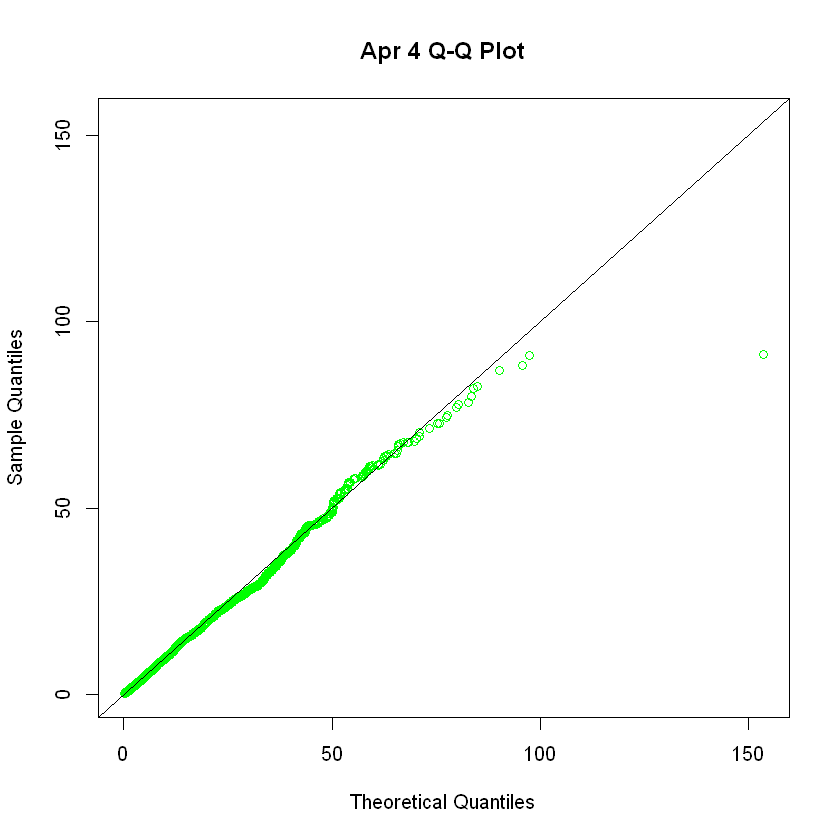

In [529]:
wApr4Max <- max( max( dfApr4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfApr4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Apr 4 Q-Q Plot",
        xlim=c(0,wApr4Max), ylim=c(0,wApr4Max) )
abline( 0, 1)

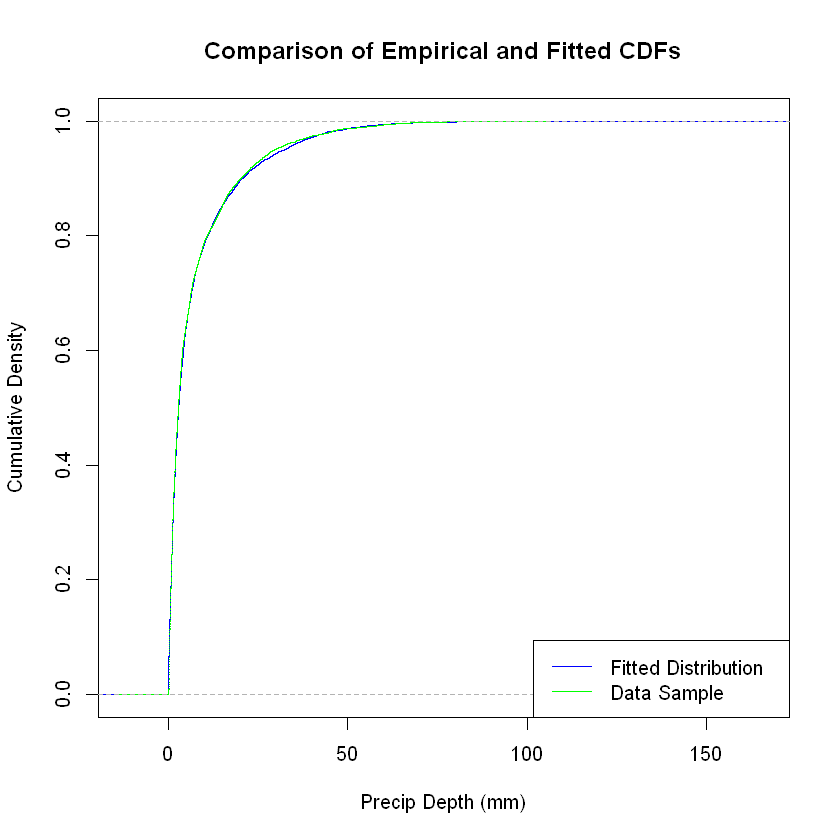

In [530]:
x <- seq(0,wApr4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfApr4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [531]:
MonDistDF[20, ] <- list( 4, 4, fdGM_Apr4_shape, fdGM_Apr4_rate, fdGM_Apr4_llike, fdGM_Apr4_mean,
                        fdGM_Apr4_var, fdGM_Apr4_KSStat, fdGM_Apr4_KSp, fdME_Apr4_rate1,
                        fdME_Apr4_rate2, fdME_Apr4_lambda, fdME_Apr4_mean1, fdME_Apr4_mean2,
                        fdME_Apr4_mean, fdME_Apr4_var1, fdME_Apr4_var2, fdME_Apr4_var,
                        fdME_Apr4_llike, fdME_Apr4_KSStat, fdME_Apr4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

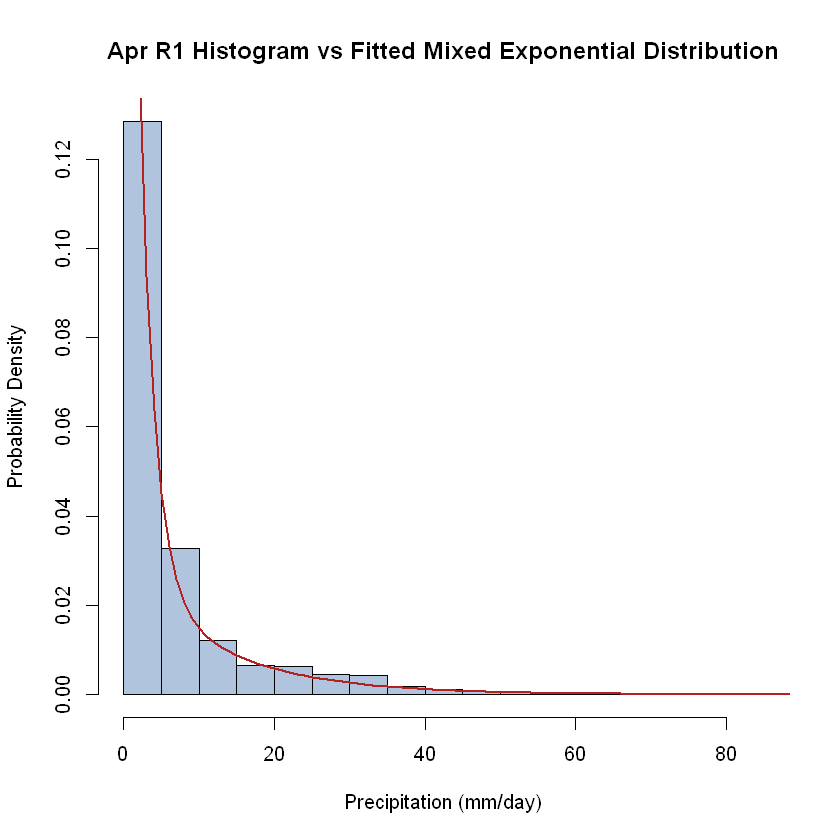

In [532]:
xVals <- seq(1, wApr1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Apr1_lambda, spec1="exp", arg1=list(rate=fdME_Apr1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Apr1_rate2) )
hist( dfApr1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Apr R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

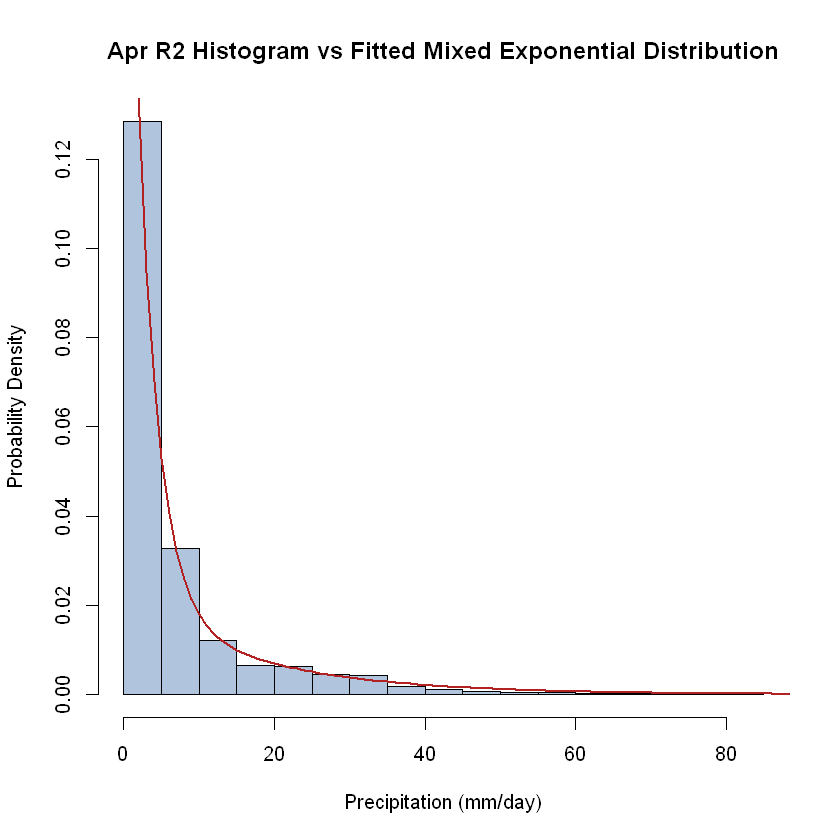

In [533]:
xVals <- seq(1, wApr2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Apr2_lambda, spec1="exp", arg1=list(rate=fdME_Apr2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Apr2_rate2) )
hist( dfApr1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Apr R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

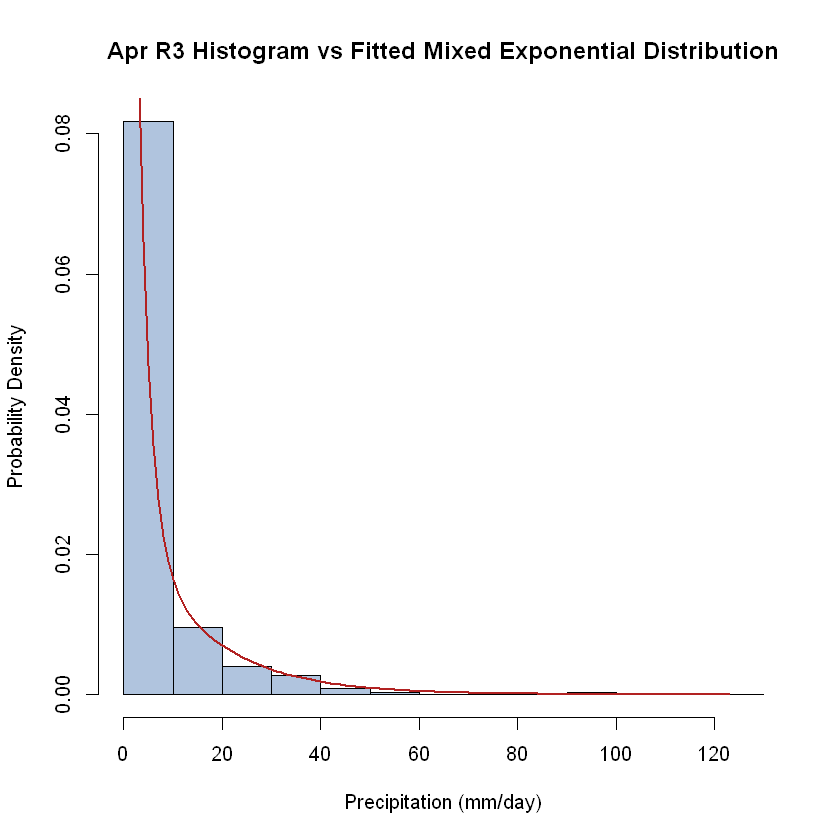

In [534]:
xVals <- seq(1, wApr3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Apr3_lambda, spec1="exp", arg1=list(rate=fdME_Apr3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Apr3_rate2) )
hist( dfApr3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Apr R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

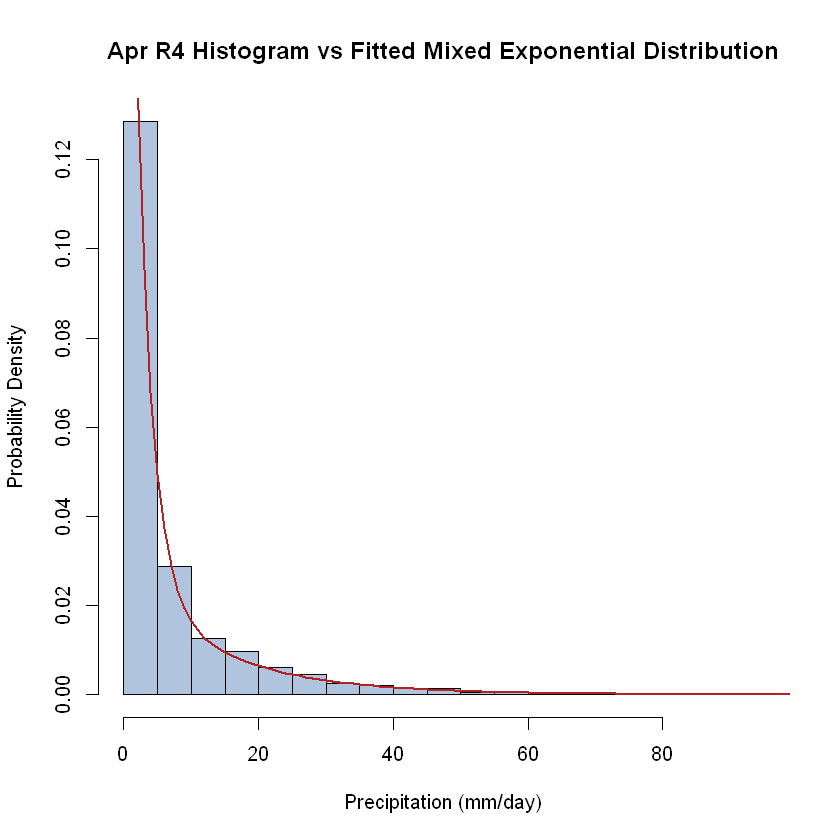

In [535]:
xVals <- seq(1, wApr4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Apr4_lambda, spec1="exp", arg1=list(rate=fdME_Apr4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Apr4_rate2) )
hist( dfApr4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Apr R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### May

#### All

**Gamma**

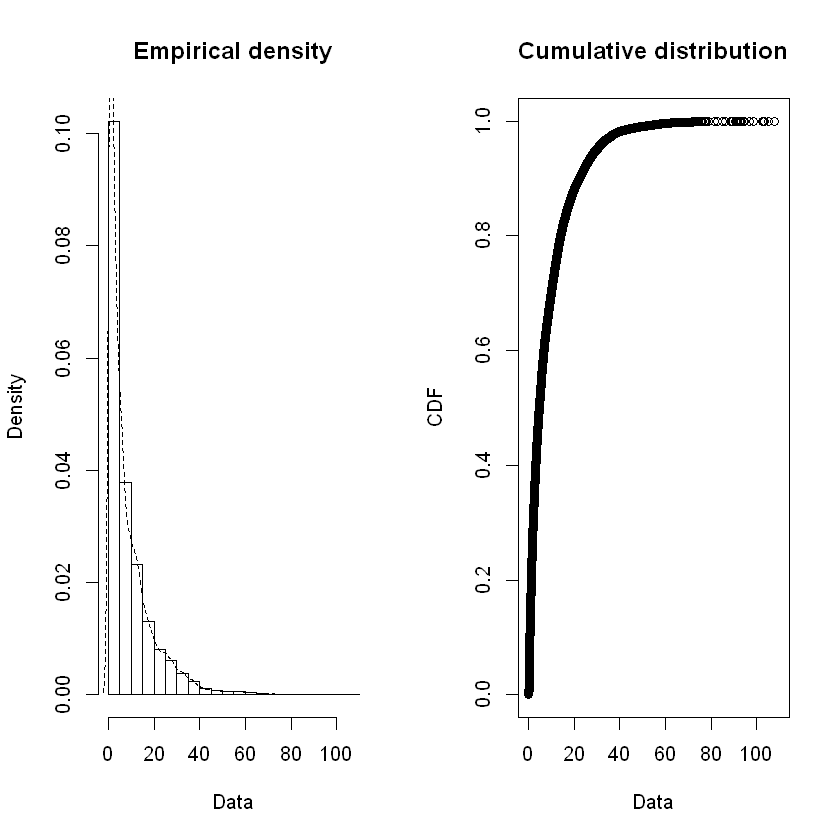

In [536]:
plotdist( dfMay$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  107.66 
median:  4.79 
mean:  8.653537 
estimated sd:  10.35102 
estimated skewness:  2.376146 
estimated kurtosis:  11.16024 

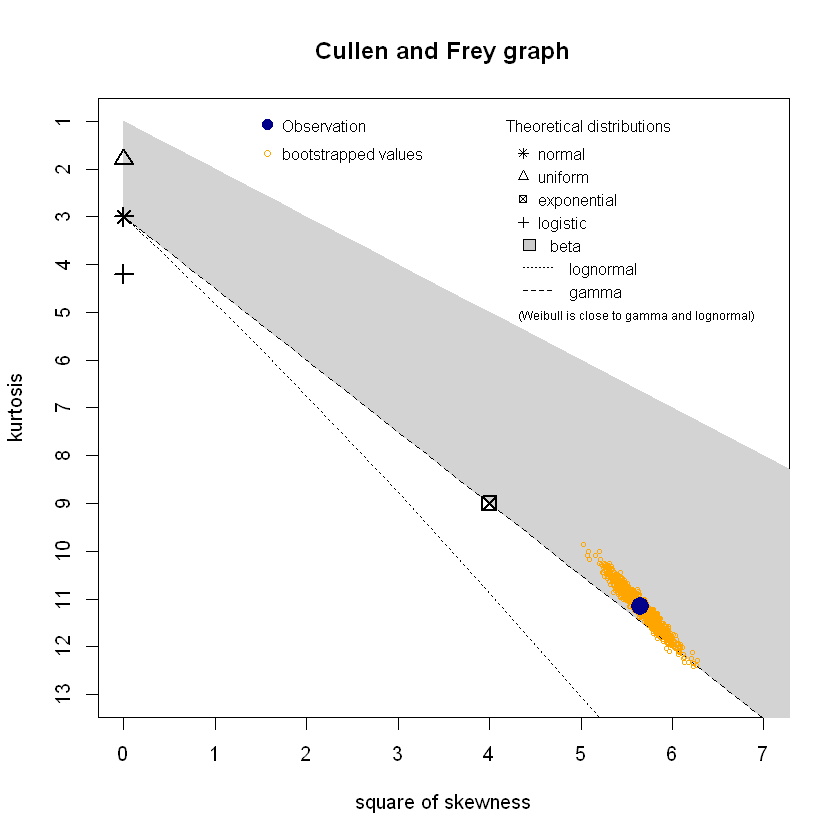

In [537]:
descdist( dfMay$Precip_mm, boot=1000 )

In [538]:
fd_GM_MayA <- fitdist( dfMay$Precip_mm, "gamma" )

In [539]:
summary( fd_GM_MayA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.83805054 0.004767320
rate  0.09683218 0.000737837
Loglikelihood:  -146018.6   AIC:  292041.1   BIC:  292058.6 
Correlation matrix:
         shape     rate
shape 1.000000 0.746425
rate  0.746425 1.000000


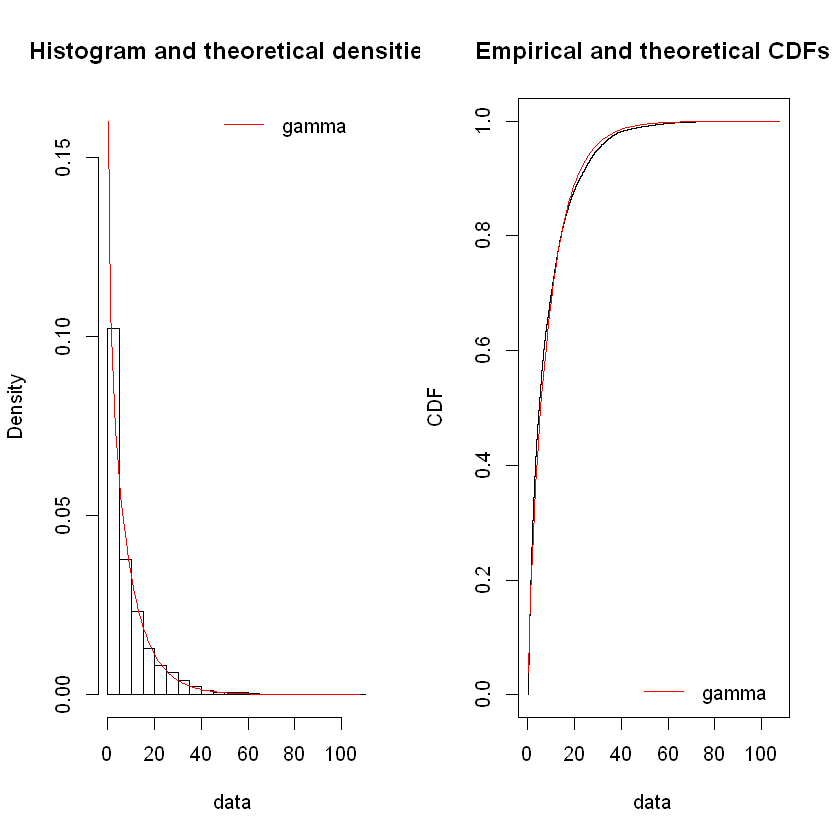

In [540]:
par(mfrow = c(1, 2))
denscomp(fd_GM_MayA)
#qqcomp(fd_GM_MayA)
cdfcomp(fd_GM_MayA)
#ppcomp(fd_GM_MayA)

In [541]:
fdGM_MayA_shape <- fd_GM_MayA$estimate[["shape"]]
fdGM_MayA_rate <- fd_GM_MayA$estimate[["rate"]]
fdGM_MayA_llike <- fd_GM_MayA$loglik
fdGM_MayA_mean <- fdGM_MayA_shape / fdGM_MayA_rate
fdGM_MayA_var <- fdGM_MayA_shape / ( fdGM_MayA_rate ^ 2 )
cat(" May A shape: ", fdGM_MayA_shape, "\n", "May A rate: ", fdGM_MayA_rate, 
    "\n", "May A loglikelihood: ", fdGM_MayA_llike, "\n", 
    "May A mean: ", fdGM_MayA_mean, "\n",
    "May A variance: ", fdGM_MayA_var, "\n" )

 May A shape:  0.8380505 
 May A rate:  0.09683218 
 May A loglikelihood:  -146018.6 
 May A mean:  8.65467 
 May A variance:  89.37803 


In [542]:
statRes <- gofstat( fd_GM_MayA, fitnames=c("Gamma") )

In [543]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.05206929
Cramer-von Mises statistic    42.16874529
Anderson-Darling statistic   262.67867029

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 292041.1
Bayesian Information Criterion 292058.6


In [544]:
ksRes <- ks.test( dfMay$Precip_mm, "pgamma", shape=fdGM_MayA_shape, rate=fdGM_MayA_rate )

Warning message in ks.test(dfMay$Precip_mm, "pgamma", shape = fdGM_MayA_shape, rate = fdGM_MayA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [545]:
fdGM_MayA_KSStat <- ksRes$statistic
fdGM_MayA_KSp <- ksRes$p.value
cat(" May A K-S stat: ", fdGM_MayA_KSStat, "\n",
    "May A K-S p-value: ", fdGM_MayA_KSp )

 May A K-S stat:  0.05206929 
 May A K-S p-value:  0

**Mixed Exponential**

In [546]:
fd_ME_MayA <- expRMM_EM( dfMay$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfMay$Precip_mm), 1.0/mean(dfMay$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 254 


In [547]:
summary( fd_ME_MayA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.308946 0.6910541
rate   0.392036 0.0878591
loglik at estimate:  -145122.4 
0 % of the data right censored


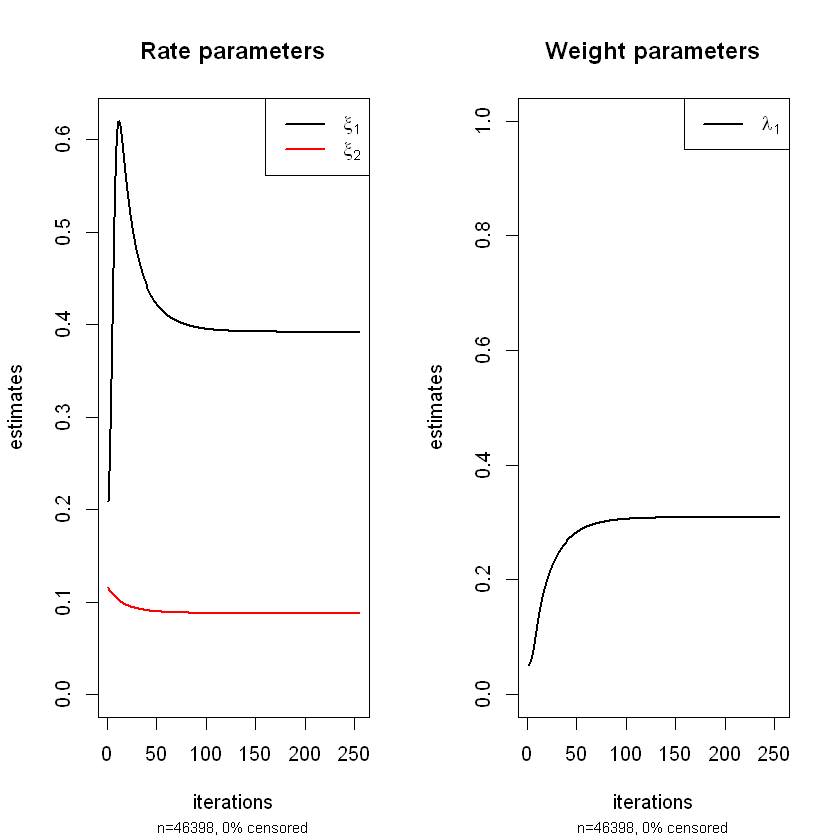

In [548]:
plotexpRMM( fd_ME_MayA, lwd=2 )

In [549]:
fdME_MayA_rate1 <- fd_ME_MayA$rate[[1]]
fdME_MayA_rate2 <- fd_ME_MayA$rate[[2]]
fdME_MayA_lambda <- fd_ME_MayA$lambda[[1]]
fdME_MayA_mean1 <- 1.0 / fdME_MayA_rate1
fdME_MayA_mean2 <- 1.0 / fdME_MayA_rate2
fdME_MayA_mean <- ( (fdME_MayA_lambda * fdME_MayA_mean1) + 
                    ( ( 1.0 - fdME_MayA_lambda) * fdME_MayA_mean2 ) )
fdME_MayA_var1 <- 1.0 / (fdME_MayA_rate1 ^ 2)
fdME_MayA_var2 <- 1.0 / (fdME_MayA_rate2 ^ 2)
fdME_MayA_var <- ( (fdME_MayA_lambda * ( fdME_MayA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_MayA_lambda) * (fdME_MayA_mean2 ^ 2) ) + 
                   ( fdME_MayA_lambda * ( 1.0 - fdME_MayA_lambda) * 
                       ( fdME_MayA_mean1 - fdME_MayA_mean2 )^2 ) )
fdME_MayA_llike <- fd_ME_MayA$loglik
cat(" May A rate1: ", fdME_MayA_rate1, "\n", 
    "May A rate2: ", fdME_MayA_rate2, "\n",
    "May A lambda: ", fdME_MayA_lambda, "\n",
    "May A mean1: ", fdME_MayA_mean1, "\n",
    "May A mean2: ", fdME_MayA_mean2, "\n",
    "May A mean: ", fdME_MayA_mean, "\n",
    "May A var1: ", fdME_MayA_var1, "\n",
    "May A var2: ", fdME_MayA_var2, "\n",
    "May A var: ", fdME_MayA_var, "\n",
    "May A loglikelihood: ", fdME_MayA_llike, "\n" )

 May A rate1:  0.3920363 
 May A rate2:  0.08785909 
 May A lambda:  0.3089459 
 May A mean1:  2.550784 
 May A mean2:  11.38186 
 May A mean:  8.653537 
 May A var1:  6.506501 
 May A var2:  129.5468 
 May A var:  108.1843 
 May A loglikelihood:  -145122.4 


In [550]:
tvals <- rexpmix(length(dfMay$Precip_mm), fd_ME_MayA$lambda, fd_ME_MayA$rate )

In [551]:
ksRes <- ks.test( dfMay$Precip_mm, tvals )

Warning message in ks.test(dfMay$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [552]:
fdME_MayA_KSStat <- ksRes$statistic
fdME_MayA_KSp <- ksRes$p.value
cat(" May A K-S stat: ", fdME_MayA_KSStat, "\n",
    "May A K-S p-value: ", fdME_MayA_KSp )

 May A K-S stat:  0.03715677 
 May A K-S p-value:  0

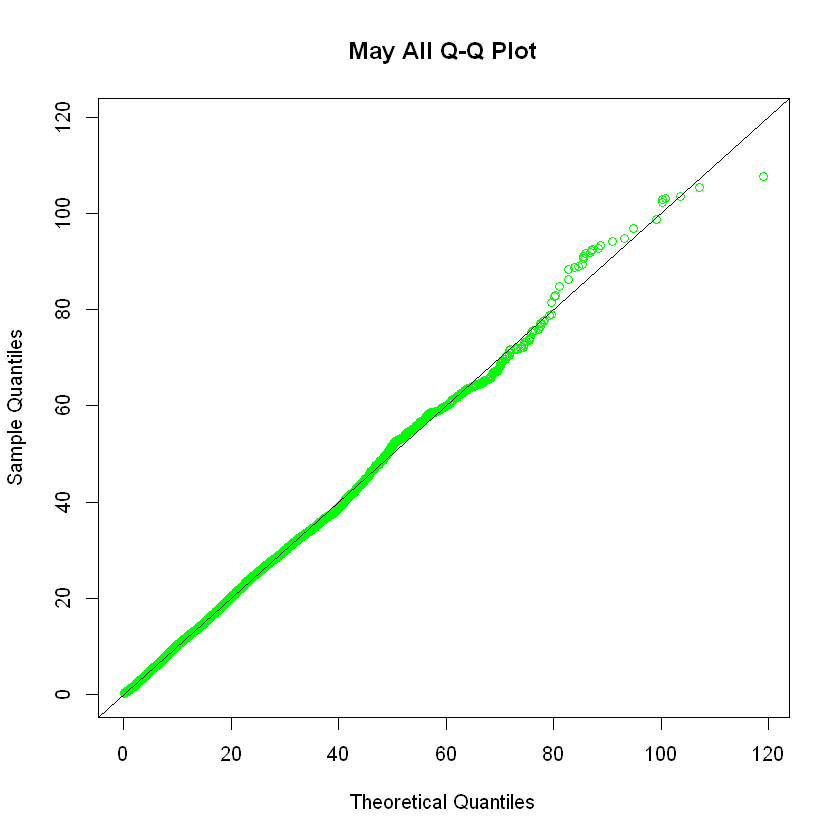

In [553]:
wMayAMax <- max( max( dfMay$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMay$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May All Q-Q Plot",
        xlim=c(0,wMayAMax), ylim=c(0,wMayAMax) )
abline( 0, 1)

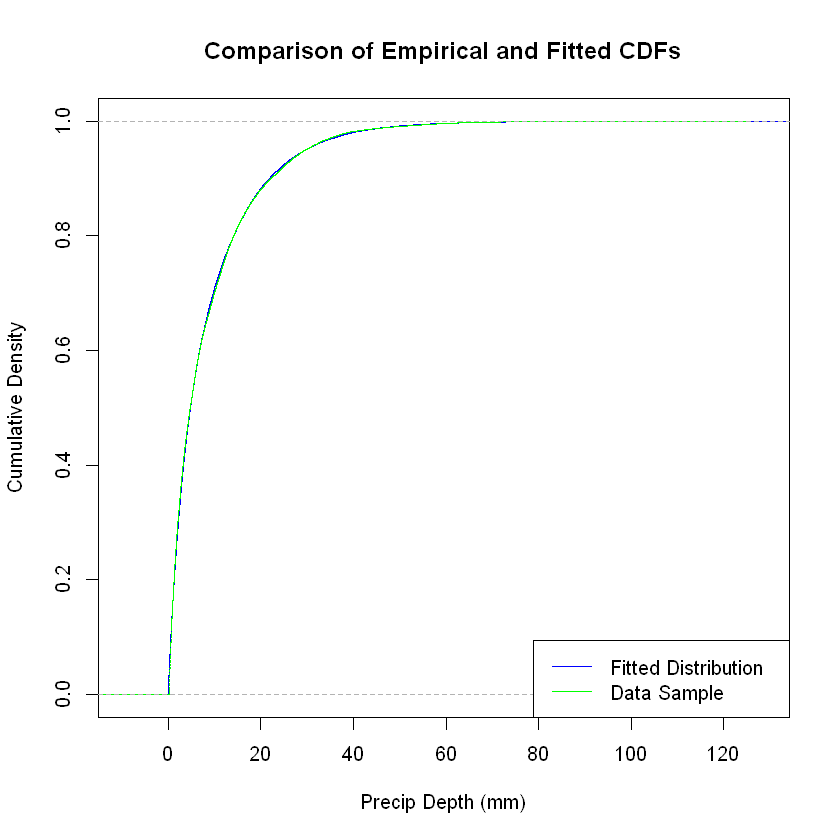

In [554]:
x <- seq(0,wMayAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMay$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [555]:
MonDistDF[21, ] <- list( 5, 0, fdGM_MayA_shape, fdGM_MayA_rate, fdGM_MayA_llike, fdGM_MayA_mean,
                        fdGM_MayA_var, fdGM_MayA_KSStat, fdGM_MayA_KSp, fdME_MayA_rate1,
                        fdME_MayA_rate2, fdME_MayA_lambda, fdME_MayA_mean1, fdME_MayA_mean2,
                        fdME_MayA_mean, fdME_MayA_var1, fdME_MayA_var2, fdME_MayA_var,
                        fdME_MayA_llike, fdME_MayA_KSStat, fdME_MayA_KSp )

#### Region 1

**Gamma**

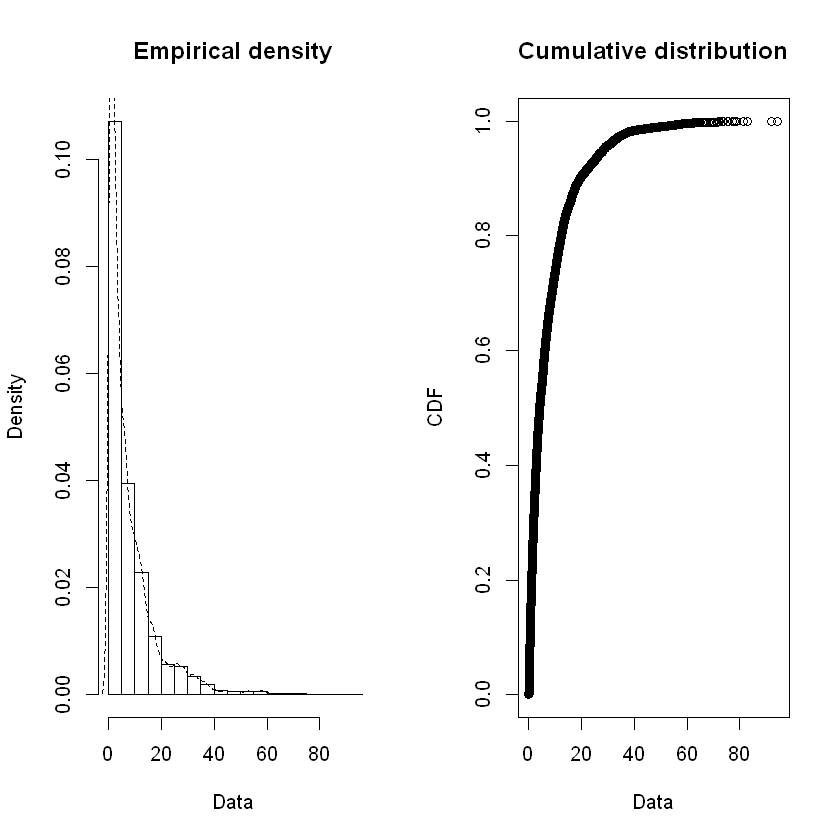

In [556]:
plotdist( dfMay1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  94.13 
median:  4.29 
mean:  7.946635 
estimated sd:  9.870307 
estimated skewness:  2.615522 
estimated kurtosis:  12.30634 

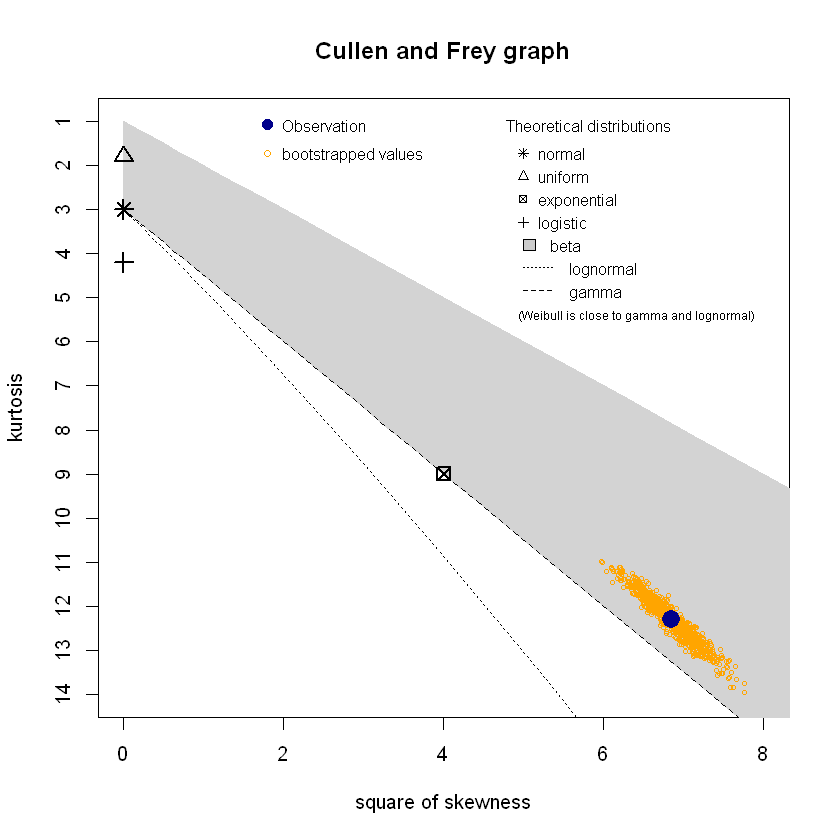

In [557]:
descdist( dfMay1$Precip_mm, boot=1000 )

In [558]:
fd_GM_May1 <- fitdist( dfMay1$Precip_mm, "gamma" )

In [559]:
summary( fd_GM_May1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8509097 0.008164717
rate  0.1070745 0.001370766
Loglikelihood:  -50103.89   AIC:  100211.8   BIC:  100227.2 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7494057
rate  0.7494057 1.0000000


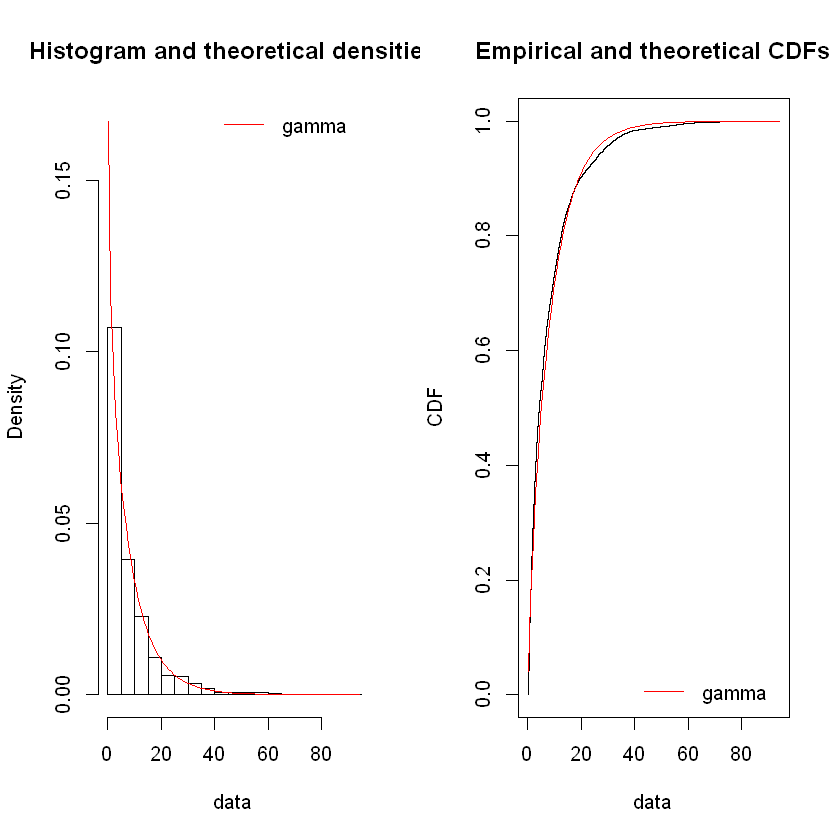

In [560]:
par(mfrow = c(1, 2))
denscomp(fd_GM_May1)
#qqcomp(fd_GM_May1)
cdfcomp(fd_GM_May1)
#ppcomp(fd_GM_May1)

In [561]:
fdGM_May1_shape <- fd_GM_May1$estimate[["shape"]]
fdGM_May1_rate <- fd_GM_May1$estimate[["rate"]]
fdGM_May1_llike <- fd_GM_May1$loglik
fdGM_May1_mean <- fdGM_May1_shape / fdGM_May1_rate
fdGM_May1_var <- fdGM_May1_shape / ( fdGM_May1_rate ^ 2 )
cat(" May 1 shape: ", fdGM_May1_shape, "\n", "May 1 rate: ", fdGM_May1_rate, 
    "\n", "May 1 loglikelihood: ", fdGM_May1_llike, "\n", 
    "May 1 mean: ", fdGM_May1_mean, "\n",
    "May 1 variance: ", fdGM_May1_var, "\n" )

 May 1 shape:  0.8509097 
 May 1 rate:  0.1070745 
 May 1 loglikelihood:  -50103.89 
 May 1 mean:  7.946896 
 May 1 variance:  74.21841 


In [562]:
statRes <- gofstat( fd_GM_May1, fitnames=c("Gamma") )

In [563]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06031855
Cramer-von Mises statistic    17.92581128
Anderson-Darling statistic   110.83948284

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 100211.8
Bayesian Information Criterion 100227.2


In [564]:
ksRes <- ks.test( dfMay1$Precip_mm, "pgamma", shape=fdGM_May1_shape, rate=fdGM_May1_rate )

Warning message in ks.test(dfMay1$Precip_mm, "pgamma", shape = fdGM_May1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [565]:
fdGM_May1_KSStat <- ksRes$statistic
fdGM_May1_KSp <- ksRes$p.value
cat(" May 1 K-S stat: ", fdGM_May1_KSStat, "\n",
    "May 1 K-S p-value: ", fdGM_May1_KSp )

 May 1 K-S stat:  0.06031855 
 May 1 K-S p-value:  0

**Mixed exponential**

In [566]:
fd_ME_May1 <- expRMM_EM( dfMay1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMay1$Precip_mm), 1.0/mean(dfMay1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 470 


In [567]:
summary( fd_ME_May1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.430797 0.5692027
rate   0.307426 0.0869631
loglik at estimate:  -49745.18 
0 % of the data right censored


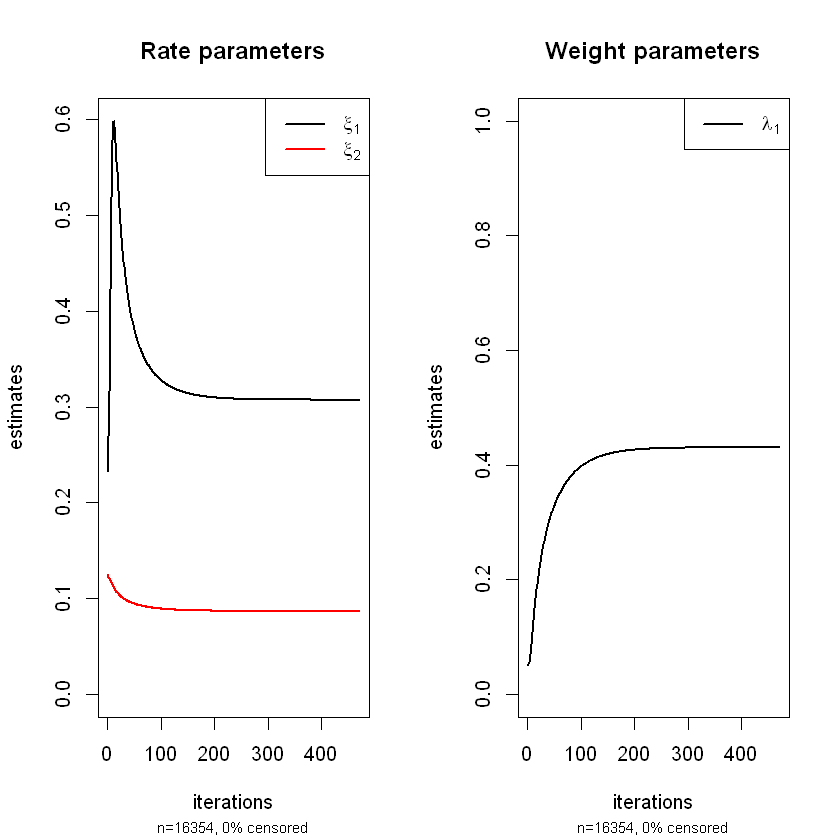

In [568]:
plotexpRMM( fd_ME_May1, lwd=2 )

In [569]:
fdME_May1_rate1 <- fd_ME_May1$rate[[1]]
fdME_May1_rate2 <- fd_ME_May1$rate[[2]]
fdME_May1_lambda <- fd_ME_May1$lambda[[1]]
fdME_May1_mean1 <- 1.0 / fdME_May1_rate1
fdME_May1_mean2 <- 1.0 / fdME_May1_rate2
fdME_May1_mean <- ( (fdME_May1_lambda * fdME_May1_mean1) + 
                    ( ( 1.0 - fdME_May1_lambda) * fdME_May1_mean2 ) )
fdME_May1_var1 <- 1.0 / (fdME_May1_rate1 ^ 2)
fdME_May1_var2 <- 1.0 / (fdME_May1_rate2 ^ 2)
fdME_May1_var <- ( (fdME_May1_lambda * ( fdME_May1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_May1_lambda) * (fdME_May1_mean2 ^ 2) ) + 
                   ( fdME_May1_lambda * ( 1.0 - fdME_May1_lambda) * 
                       ( fdME_May1_mean1 - fdME_May1_mean2 )^2 ) )
fdME_May1_llike <- fd_ME_May1$loglik
cat(" May 1 rate1: ", fdME_May1_rate1, "\n", 
    "May 1 rate2: ", fdME_May1_rate2, "\n",
    "May 1 lambda: ", fdME_May1_lambda, "\n",
    "May 1 mean1: ", fdME_May1_mean1, "\n",
    "May 1 mean2: ", fdME_May1_mean2, "\n",
    "May 1 mean: ", fdME_May1_mean, "\n",
    "May 1 var1: ", fdME_May1_var1, "\n",
    "May 1 var2: ", fdME_May1_var2, "\n",
    "May 1 var: ", fdME_May1_var, "\n",
    "May 1 loglikelihood: ", fdME_May1_llike, "\n" )

 May 1 rate1:  0.3074264 
 May 1 rate2:  0.08696314 
 May 1 lambda:  0.4307973 
 May 1 mean1:  3.252811 
 May 1 mean2:  11.49912 
 May 1 mean:  7.946635 
 May 1 var1:  10.58078 
 May 1 var2:  132.2299 
 May 1 var:  96.49853 
 May 1 loglikelihood:  -49745.18 


In [570]:
tvals <- rexpmix(length(dfMay1$Precip_mm), fd_ME_May1$lambda, fd_ME_May1$rate )

In [571]:
ksRes <- ks.test( dfMay1$Precip_mm, tvals )

Warning message in ks.test(dfMay1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [572]:
fdME_May1_KSStat <- ksRes$statistic
fdME_May1_KSp <- ksRes$p.value
cat(" May 1 K-S stat: ", fdME_May1_KSStat, "\n",
    "May 1 K-S p-value: ", fdME_May1_KSp )

 May 1 K-S stat:  0.03882842 
 May 1 K-S p-value:  3.917822e-11

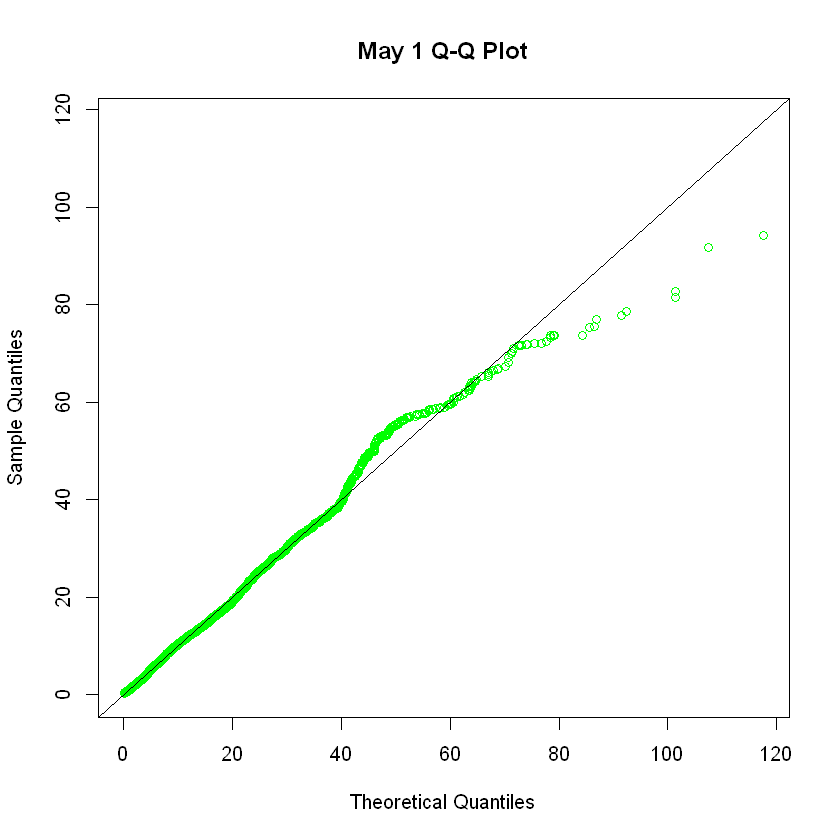

In [573]:
wMay1Max <- max( max( dfMay1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMay1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May 1 Q-Q Plot",
        xlim=c(0,wMay1Max), ylim=c(0,wMay1Max) )
abline( 0, 1)

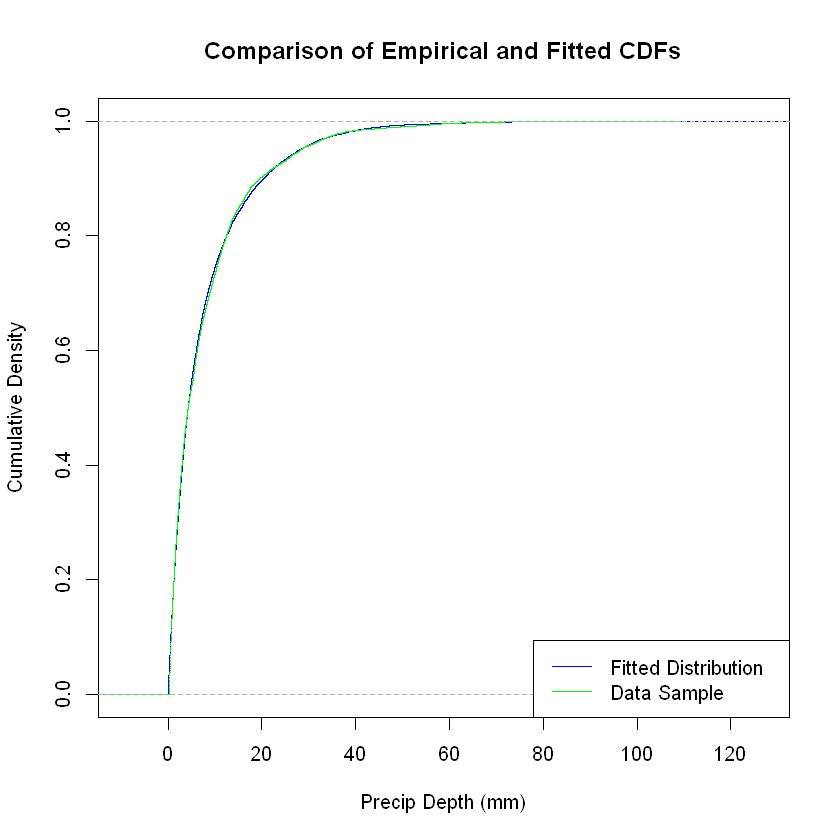

In [574]:
x <- seq(0,wMay1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMay1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [575]:
MonDistDF[22, ] <- list( 5, 1, fdGM_May1_shape, fdGM_May1_rate, fdGM_May1_llike, fdGM_May1_mean,
                        fdGM_May1_var, fdGM_May1_KSStat, fdGM_May1_KSp, fdME_May1_rate1,
                        fdME_May1_rate2, fdME_May1_lambda, fdME_May1_mean1, fdME_May1_mean2,
                        fdME_May1_mean, fdME_May1_var1, fdME_May1_var2, fdME_May1_var,
                        fdME_May1_llike, fdME_May1_KSStat, fdME_May1_KSp )

#### Region 2

**Gamma**

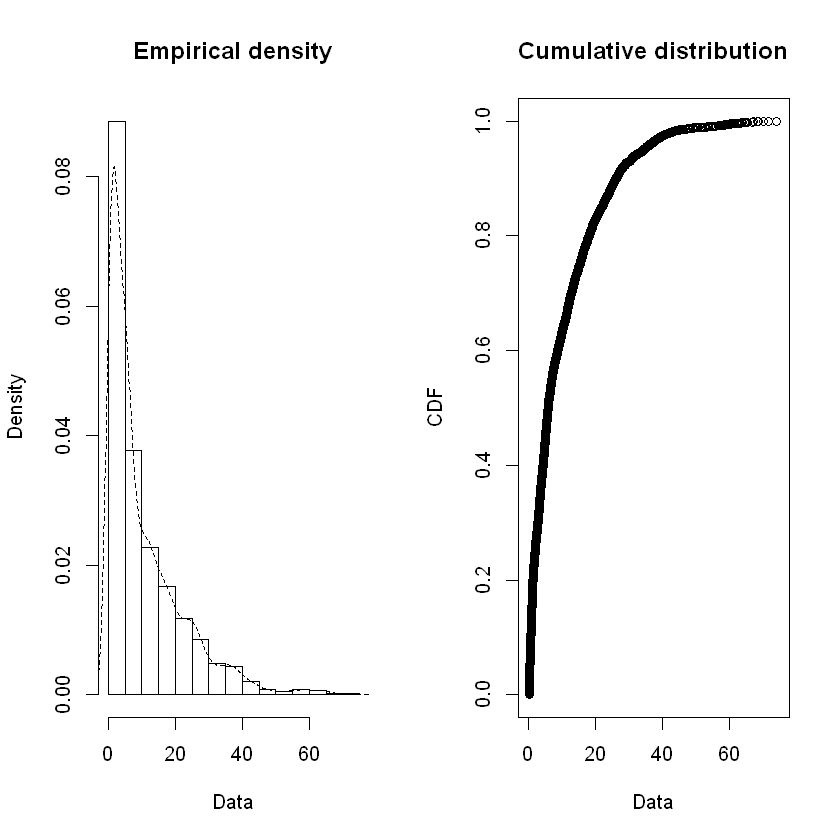

In [576]:
plotdist( dfMay2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  74.11 
median:  5.885 
mean:  10.42672 
estimated sd:  11.43903 
estimated skewness:  1.788395 
estimated kurtosis:  6.749007 

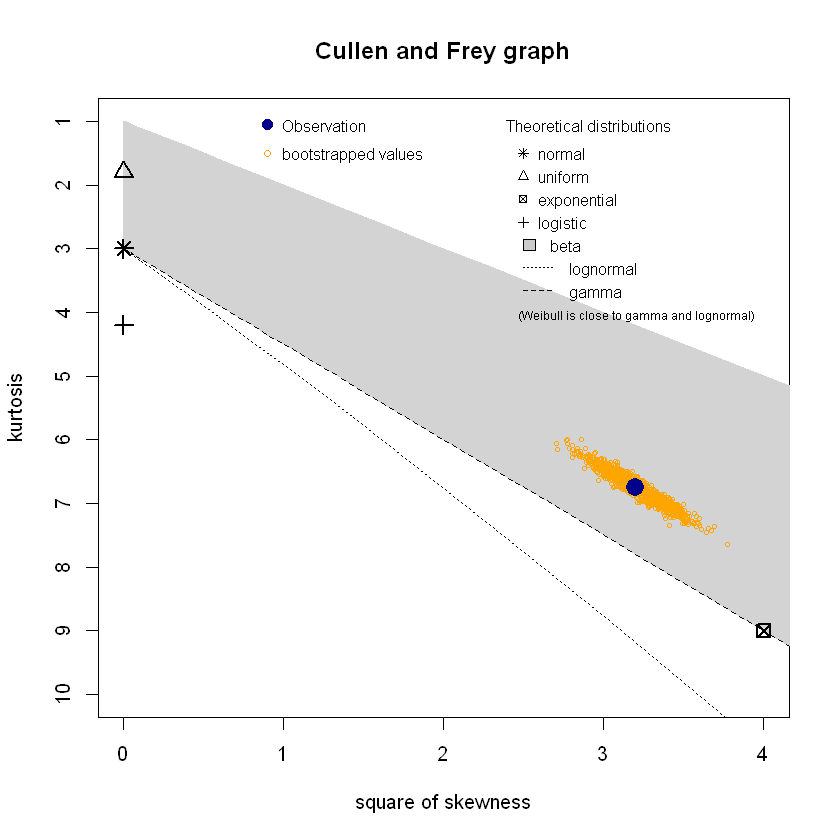

In [577]:
descdist( dfMay2$Precip_mm, boot=1000 )

In [578]:
fd_GM_May2 <- fitdist( dfMay2$Precip_mm, "gamma" )

In [579]:
summary( fd_GM_May2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.84712650 0.012969295
rate  0.08123527 0.001661145
Loglikelihood:  -21402.87   AIC:  42809.74   BIC:  42823.28 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7485062
rate  0.7485062 1.0000000


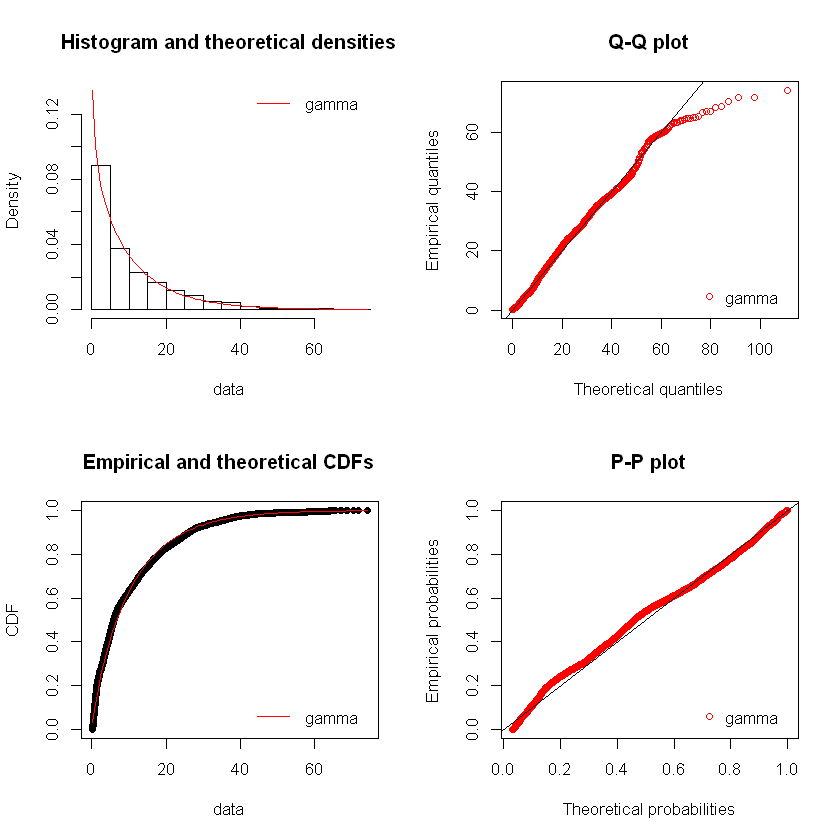

In [580]:
par(mfrow = c(2, 2))
denscomp(fd_GM_May2)
qqcomp(fd_GM_May2)
cdfcomp(fd_GM_May2)
ppcomp(fd_GM_May2)

In [581]:
fdGM_May2_shape <- fd_GM_May2$estimate[["shape"]]
fdGM_May2_rate <- fd_GM_May2$estimate[["rate"]]
fdGM_May2_llike <- fd_GM_May2$loglik
fdGM_May2_mean <- fdGM_May2_shape / fdGM_May2_rate
fdGM_May2_var <- fdGM_May2_shape / ( fdGM_May2_rate ^ 2 )
cat(" May 2 shape: ", fdGM_May2_shape, "\n", "May 2 rate: ", fdGM_May2_rate, 
    "\n", "May 2 loglikelihood: ", fdGM_May2_llike, "\n", 
    "May 2 mean: ", fdGM_May2_mean, "\n",
    "May 2 variance: ", fdGM_May2_var, "\n" )

 May 2 shape:  0.8471265 
 May 2 rate:  0.08123527 
 May 2 loglikelihood:  -21402.87 
 May 2 mean:  10.42806 
 May 2 variance:  128.3687 


In [582]:
statRes <- gofstat( fd_GM_May2, fitnames=c("Gamma") )

In [583]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.04415213
Cramer-von Mises statistic    3.78529962
Anderson-Darling statistic   26.08748262

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 42809.74
Bayesian Information Criterion 42823.28


In [584]:
ksRes <- ks.test( dfMay2$Precip_mm, "pgamma", shape=fdGM_May2_shape, rate=fdGM_May2_rate )

Warning message in ks.test(dfMay2$Precip_mm, "pgamma", shape = fdGM_May2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [585]:
fdGM_May2_KSStat <- ksRes$statistic
fdGM_May2_KSp <- ksRes$p.value
cat(" May 2 K-S stat: ", fdGM_May2_KSStat, "\n",
    "May 2 K-S p-value: ", fdGM_May2_KSp )

 May 2 K-S stat:  0.04415213 
 May 2 K-S p-value:  2.715428e-11

**Mixed exponential**

In [586]:
fd_ME_May2 <- expRMM_EM( dfMay2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMay2$Precip_mm), 1.0/mean(dfMay2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 179 


In [587]:
summary( fd_ME_May2 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.200035 0.799965
rate   0.460362 0.080059
loglik at estimate:  -21319.35 
0 % of the data right censored


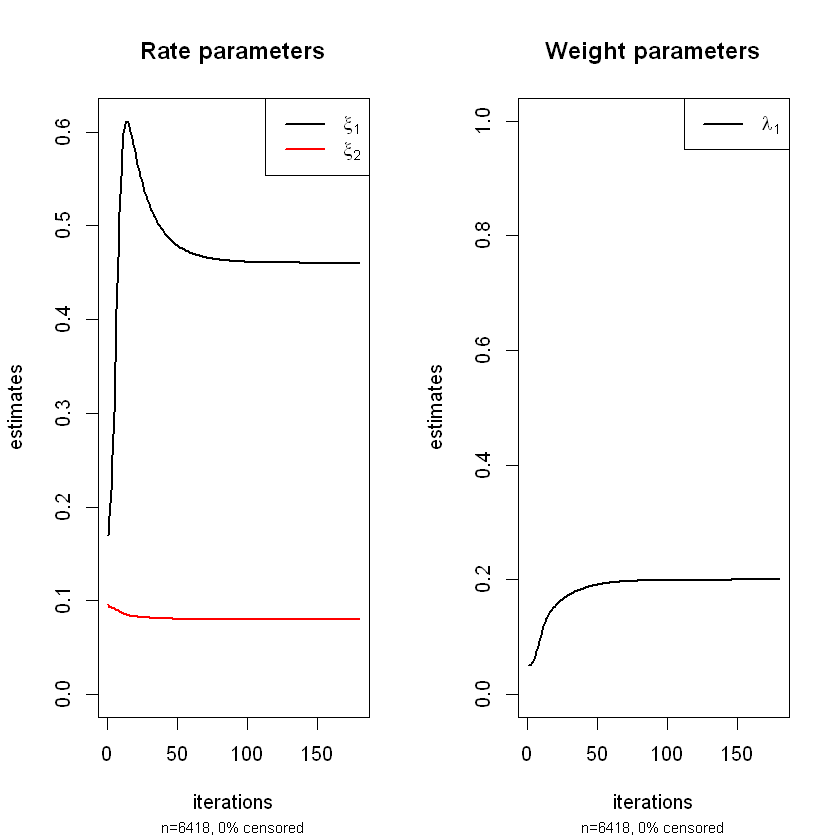

In [588]:
plotexpRMM( fd_ME_May2, lwd=2 )

In [589]:
fdME_May2_rate1 <- fd_ME_May2$rate[[1]]
fdME_May2_rate2 <- fd_ME_May2$rate[[2]]
fdME_May2_lambda <- fd_ME_May2$lambda[[1]]
fdME_May2_mean1 <- 1.0 / fdME_May2_rate1
fdME_May2_mean2 <- 1.0 / fdME_May2_rate2
fdME_May2_mean <- ( (fdME_May2_lambda * fdME_May2_mean1) + 
                    ( ( 1.0 - fdME_May2_lambda) * fdME_May2_mean2 ) )
fdME_May2_var1 <- 1.0 / (fdME_May2_rate1 ^ 2)
fdME_May2_var2 <- 1.0 / (fdME_May2_rate2 ^ 2)
fdME_May2_var <- ( (fdME_May2_lambda * ( fdME_May2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_May2_lambda) * (fdME_May2_mean2 ^ 2) ) + 
                   ( fdME_May2_lambda * ( 1.0 - fdME_May2_lambda) * 
                       ( fdME_May2_mean1 - fdME_May2_mean2 )^2 ) )
fdME_May2_llike <- fd_ME_May2$loglik
cat(" May 2 rate1: ", fdME_May2_rate1, "\n", 
    "May 2 rate2: ", fdME_May2_rate2, "\n",
    "May 2 lambda: ", fdME_May2_lambda, "\n",
    "May 2 mean1: ", fdME_May2_mean1, "\n",
    "May 2 mean2: ", fdME_May2_mean2, "\n",
    "May 2 mean: ", fdME_May2_mean, "\n",
    "May 2 var1: ", fdME_May2_var1, "\n",
    "May 2 var2: ", fdME_May2_var2, "\n",
    "May 2 var: ", fdME_May2_var, "\n",
    "May 2 loglikelihood: ", fdME_May2_llike, "\n" )

 May 2 rate1:  0.4603624 
 May 2 rate2:  0.08005896 
 May 2 lambda:  0.2000347 
 May 2 mean1:  2.172202 
 May 2 mean2:  12.49079 
 May 2 mean:  10.42672 
 May 2 var1:  4.718461 
 May 2 var2:  156.0199 
 May 2 var:  142.7923 
 May 2 loglikelihood:  -21319.35 


In [590]:
tvals <- rexpmix(length(dfMay2$Precip_mm), fd_ME_May2$lambda, fd_ME_May2$rate )

In [591]:
ksRes <- ks.test( dfMay2$Precip_mm, tvals )

Warning message in ks.test(dfMay2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [592]:
fdME_May2_KSStat <- ksRes$statistic
fdME_May2_KSp <- ksRes$p.value
cat(" May 2 K-S stat: ", fdME_May2_KSStat, "\n",
    "May 2 K-S p-value: ", fdME_May2_KSp )

 May 2 K-S stat:  0.02991586 
 May 2 K-S p-value:  0.006404859

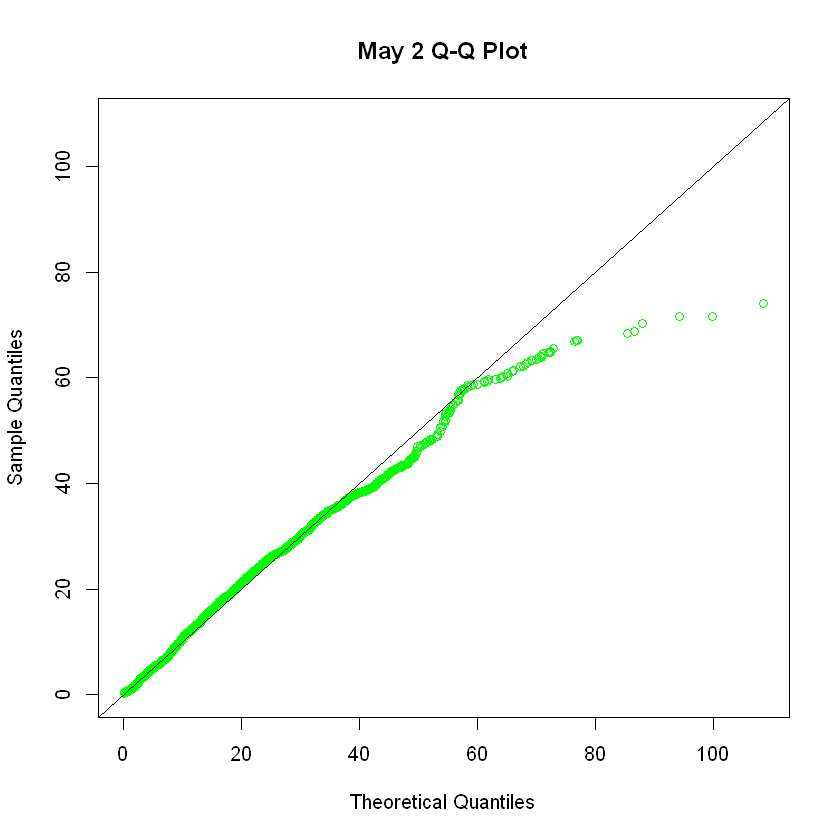

In [593]:
wMay2Max <- max( max( dfMay2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMay2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May 2 Q-Q Plot",
        xlim=c(0,wMay2Max), ylim=c(0,wMay2Max) )
abline( 0, 1)

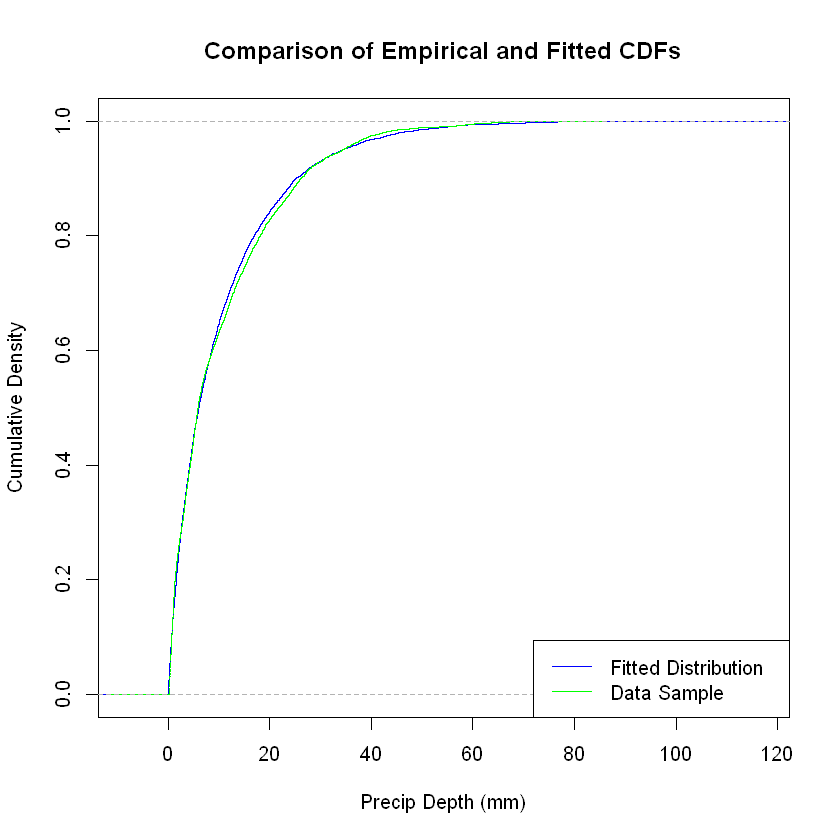

In [594]:
x <- seq(0,wMay2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMay2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [595]:
MonDistDF[23, ] <- list( 5, 2, fdGM_May2_shape, fdGM_May2_rate, fdGM_May2_llike, fdGM_May2_mean,
                        fdGM_May2_var, fdGM_May2_KSStat, fdGM_May2_KSp, fdME_May2_rate1,
                        fdME_May2_rate2, fdME_May2_lambda, fdME_May2_mean1, fdME_May2_mean2,
                        fdME_May2_mean, fdME_May2_var1, fdME_May2_var2, fdME_May2_var,
                        fdME_May2_llike, fdME_May2_KSStat, fdME_May2_KSp )

#### Region 3

**Gamma**

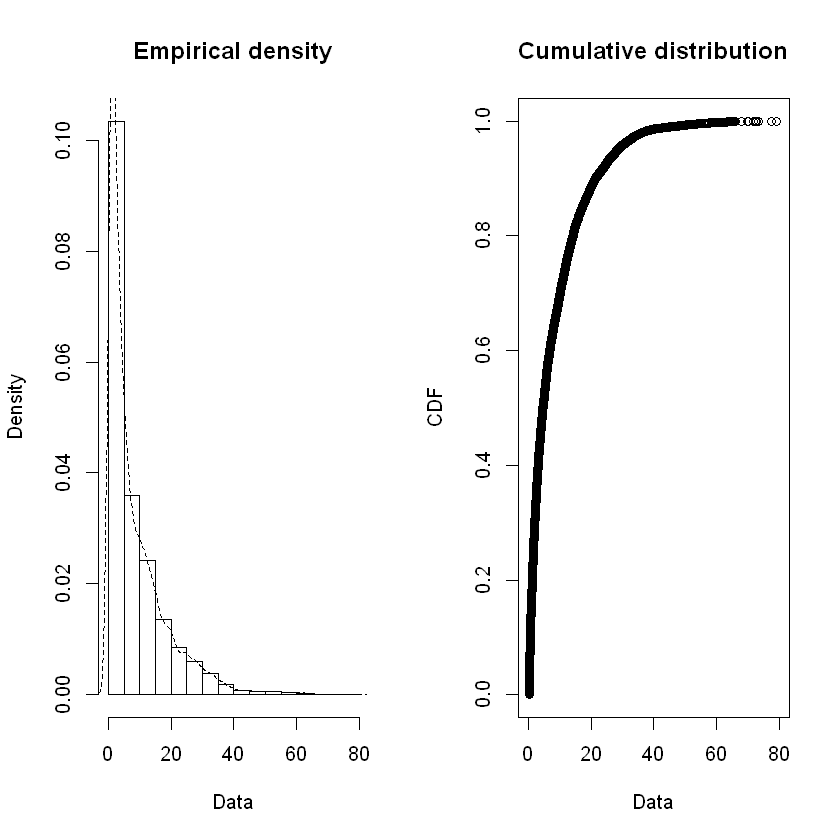

In [596]:
plotdist( dfMay3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  79.08 
median:  4.62 
mean:  8.411811 
estimated sd:  9.728266 
estimated skewness:  2.079549 
estimated kurtosis:  8.638368 

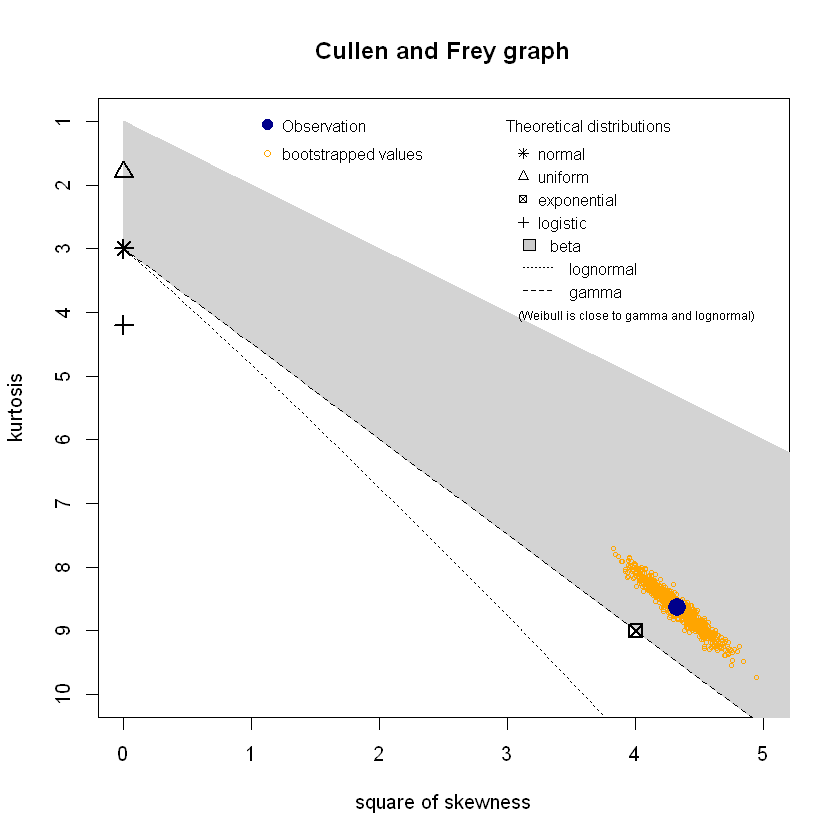

In [597]:
descdist( dfMay3$Precip_mm, boot=1000 )

In [598]:
fd_GM_May3 <- fitdist( dfMay3$Precip_mm, "gamma" )

In [599]:
summary( fd_GM_May3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8412244 0.007912936
rate  0.1000014 0.001258756
Loglikelihood:  -52967.28   AIC:  105938.6   BIC:  105954 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7471676
rate  0.7471676 1.0000000


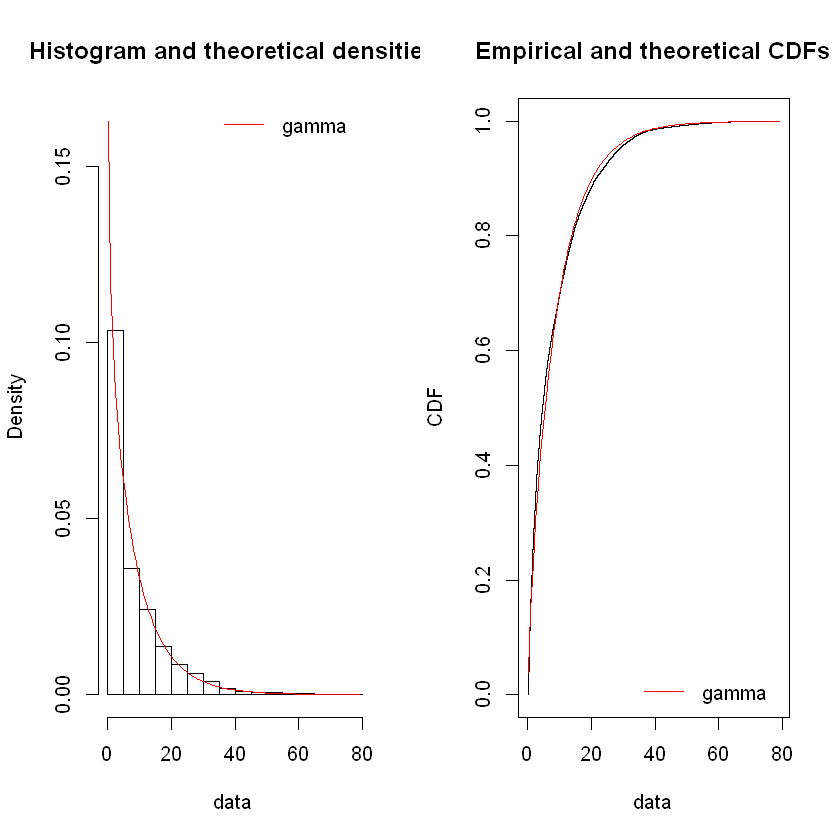

In [600]:
par(mfrow = c(1, 2))
denscomp(fd_GM_May3)
#qqcomp(fd_GM_May3)
cdfcomp(fd_GM_May3)
#ppcomp(fd_GM_May3)

In [601]:
fdGM_May3_shape <- fd_GM_May3$estimate[["shape"]]
fdGM_May3_rate <- fd_GM_May3$estimate[["rate"]]
fdGM_May3_llike <- fd_GM_May3$loglik
fdGM_May3_mean <- fdGM_May3_shape / fdGM_May3_rate
fdGM_May3_var <- fdGM_May3_shape / ( fdGM_May3_rate ^ 2 )
cat(" May 3 shape: ", fdGM_May3_shape, "\n", "May 3 rate: ", fdGM_May3_rate, 
    "\n", "May 3 loglikelihood: ", fdGM_May3_llike, "\n", 
    "May 3 mean: ", fdGM_May3_mean, "\n",
    "May 3 variance: ", fdGM_May3_var, "\n" )

 May 3 shape:  0.8412244 
 May 3 rate:  0.1000014 
 May 3 loglikelihood:  -52967.28 
 May 3 mean:  8.412124 
 May 3 variance:  84.12004 


In [602]:
statRes <- gofstat( fd_GM_May3, fitnames=c("Gamma") )

In [603]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05620922
Cramer-von Mises statistic   15.96143707
Anderson-Darling statistic   98.63595391

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 105938.6
Bayesian Information Criterion 105954.0


In [604]:
ksRes <- ks.test( dfMay3$Precip_mm, "pgamma", shape=fdGM_May3_shape, rate=fdGM_May3_rate )

Warning message in ks.test(dfMay3$Precip_mm, "pgamma", shape = fdGM_May3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [605]:
fdGM_May3_KSStat <- ksRes$statistic
fdGM_May3_KSp <- ksRes$p.value
cat(" May 3 K-S stat: ", fdGM_May3_KSStat, "\n",
    "May 3 K-S p-value: ", fdGM_May3_KSp )

 May 3 K-S stat:  0.05620922 
 May 3 K-S p-value:  0

**Mixed exponential**

In [606]:
fd_ME_May3 <- expRMM_EM( dfMay3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMay3$Precip_mm), 1.0/mean(dfMay3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 172 


In [607]:
summary( fd_ME_May3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.267538 0.7324620
rate   0.471624 0.0933722
loglik at estimate:  -52643.93 
0 % of the data right censored


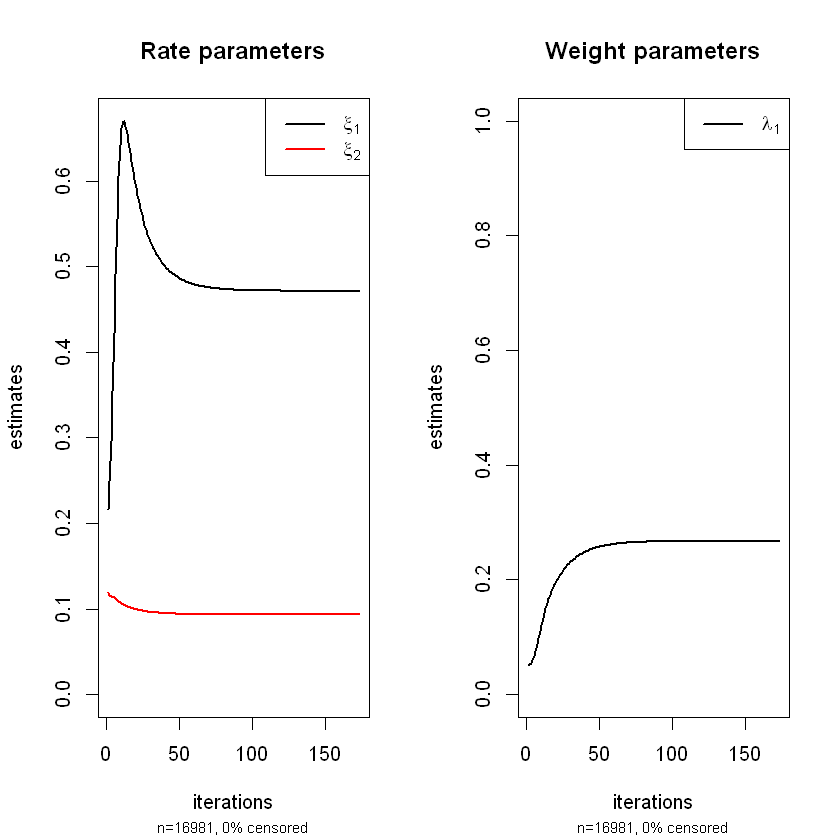

In [608]:
plotexpRMM( fd_ME_May3, lwd=2 )

In [609]:
fdME_May3_rate1 <- fd_ME_May3$rate[[1]]
fdME_May3_rate2 <- fd_ME_May3$rate[[2]]
fdME_May3_lambda <- fd_ME_May3$lambda[[1]]
fdME_May3_mean1 <- 1.0 / fdME_May3_rate1
fdME_May3_mean2 <- 1.0 / fdME_May3_rate2
fdME_May3_mean <- ( (fdME_May3_lambda * fdME_May3_mean1) + 
                    ( ( 1.0 - fdME_May3_lambda) * fdME_May3_mean2 ) )
fdME_May3_var1 <- 1.0 / (fdME_May3_rate1 ^ 2)
fdME_May3_var2 <- 1.0 / (fdME_May3_rate2 ^ 2)
fdME_May3_var <- ( (fdME_May3_lambda * ( fdME_May3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_May3_lambda) * (fdME_May3_mean2 ^ 2) ) + 
                   ( fdME_May3_lambda * ( 1.0 - fdME_May3_lambda) * 
                       ( fdME_May3_mean1 - fdME_May3_mean2 )^2 ) )
fdME_May3_llike <- fd_ME_May3$loglik
cat(" May 3 rate1: ", fdME_May3_rate1, "\n", 
    "May 3 rate2: ", fdME_May3_rate2, "\n",
    "May 3 lambda: ", fdME_May3_lambda, "\n",
    "May 3 mean1: ", fdME_May3_mean1, "\n",
    "May 3 mean2: ", fdME_May3_mean2, "\n",
    "May 3 mean: ", fdME_May3_mean, "\n",
    "May 3 var1: ", fdME_May3_var1, "\n",
    "May 3 var2: ", fdME_May3_var2, "\n",
    "May 3 var: ", fdME_May3_var, "\n",
    "May 3 loglikelihood: ", fdME_May3_llike, "\n" )

 May 3 rate1:  0.471624 
 May 3 rate2:  0.09337219 
 May 3 lambda:  0.267538 
 May 3 mean1:  2.120333 
 May 3 mean2:  10.70983 
 May 3 mean:  8.411811 
 May 3 var1:  4.495812 
 May 3 var2:  114.7004 
 May 3 var:  99.6744 
 May 3 loglikelihood:  -52643.93 


In [610]:
tvals <- rexpmix(length(dfMay3$Precip_mm), fd_ME_May3$lambda, fd_ME_May3$rate )

In [611]:
ksRes <- ks.test( dfMay3$Precip_mm, tvals )

Warning message in ks.test(dfMay3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [612]:
fdME_May3_KSStat <- ksRes$statistic
fdME_May3_KSp <- ksRes$p.value
cat(" May 3 K-S stat: ", fdME_May3_KSStat, "\n",
    "May 3 K-S p-value: ", fdME_May3_KSp )

 May 3 K-S stat:  0.03910253 
 May 3 K-S p-value:  1.059186e-11

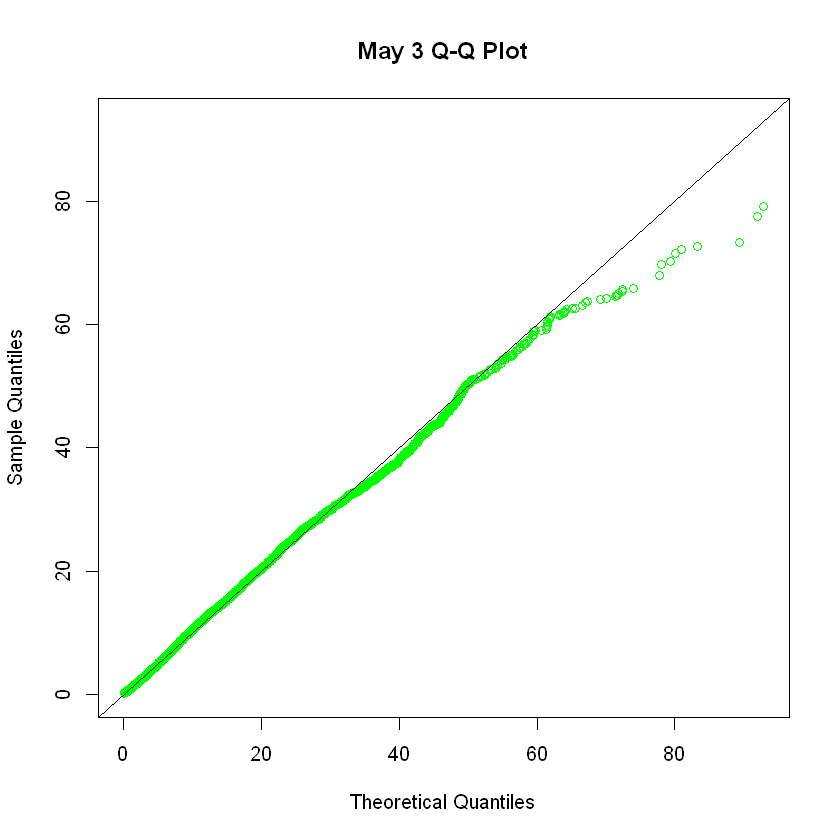

In [613]:
wMay3Max <- max( max( dfMay3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMay3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May 3 Q-Q Plot",
        xlim=c(0,wMay3Max), ylim=c(0,wMay3Max) )
abline( 0, 1)

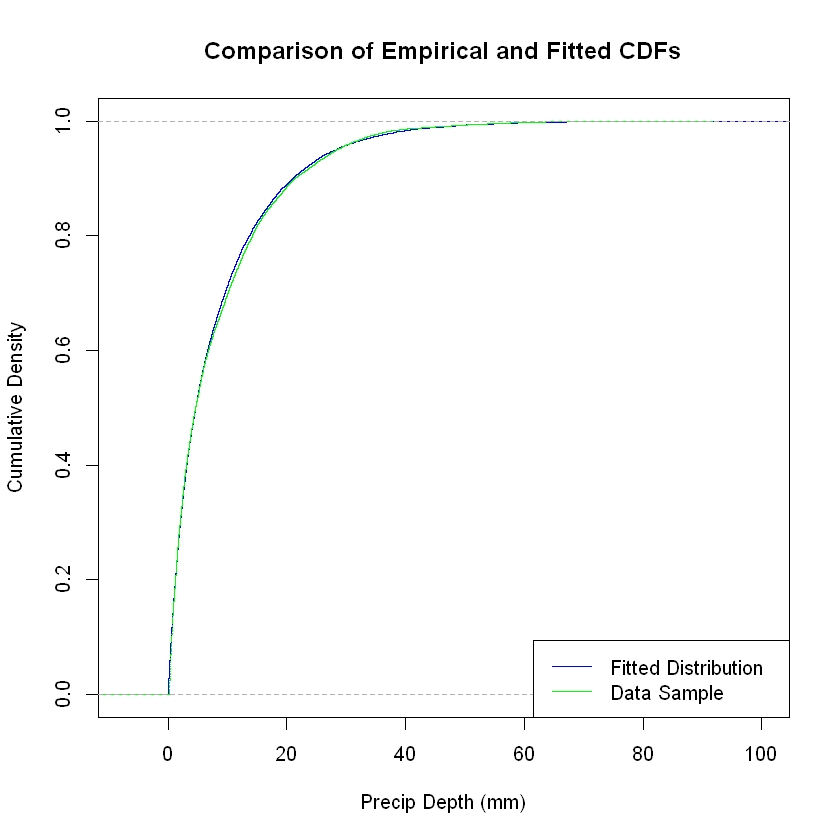

In [614]:
x <- seq(0,wMay3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMay3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [615]:
MonDistDF[24, ] <- list( 5, 3, fdGM_May3_shape, fdGM_May3_rate, fdGM_May3_llike, fdGM_May3_mean,
                        fdGM_May3_var, fdGM_May3_KSStat, fdGM_May3_KSp, fdME_May3_rate1,
                        fdME_May3_rate2, fdME_May3_lambda, fdME_May3_mean1, fdME_May3_mean2,
                        fdME_May3_mean, fdME_May3_var1, fdME_May3_var2, fdME_May3_var,
                        fdME_May3_llike, fdME_May3_KSStat, fdME_May3_KSp )

#### Region 4

**Gamma**

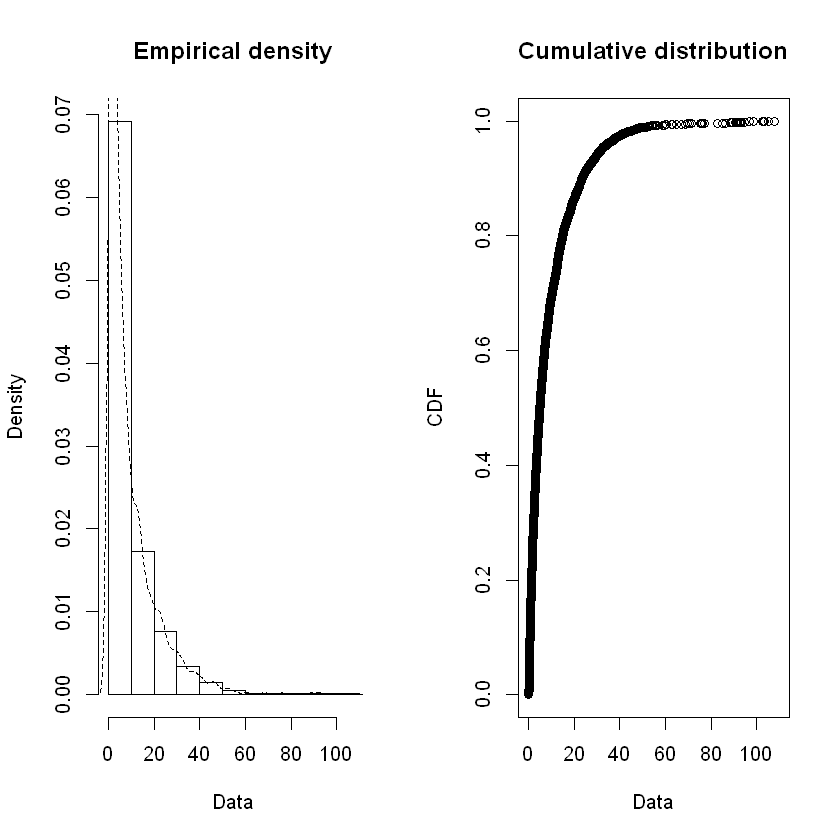

In [616]:
plotdist( dfMay4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  107.66 
median:  5.01 
mean:  9.298405 
estimated sd:  11.63376 
estimated skewness:  2.846218 
estimated kurtosis:  15.66856 

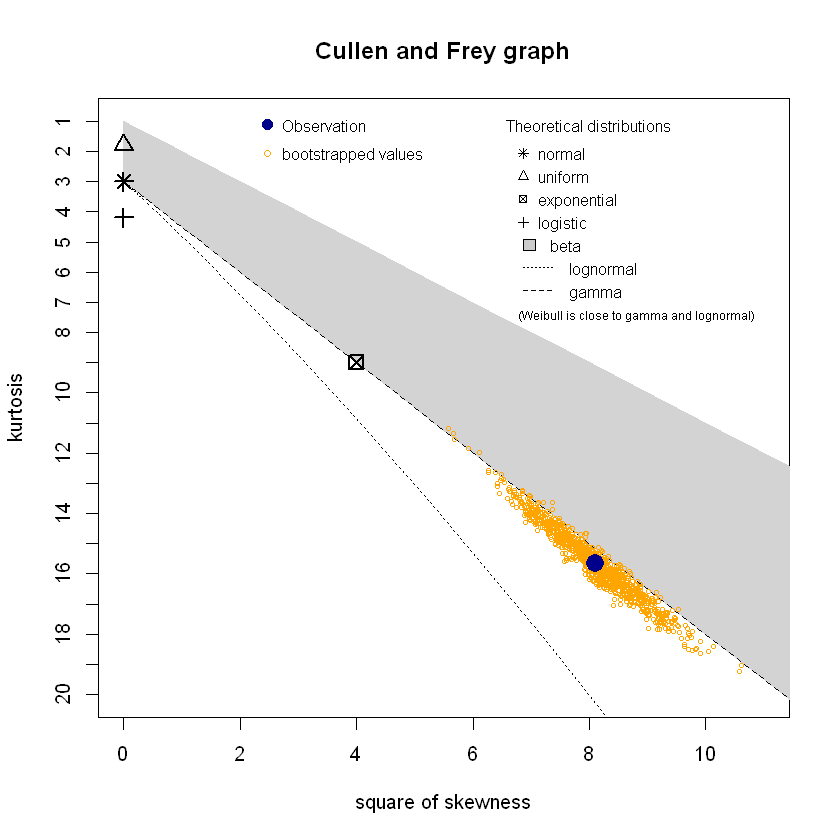

In [617]:
descdist( dfMay4$Precip_mm, boot=1000 )

In [618]:
fd_GM_May4 <- fitdist( dfMay4$Precip_mm, "gamma" )

In [619]:
summary( fd_GM_May4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.82335397 0.012355946
rate  0.08855645 0.001788399
Loglikelihood:  -21373.91   AIC:  42751.81   BIC:  42765.42 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7429385
rate  0.7429385 1.0000000


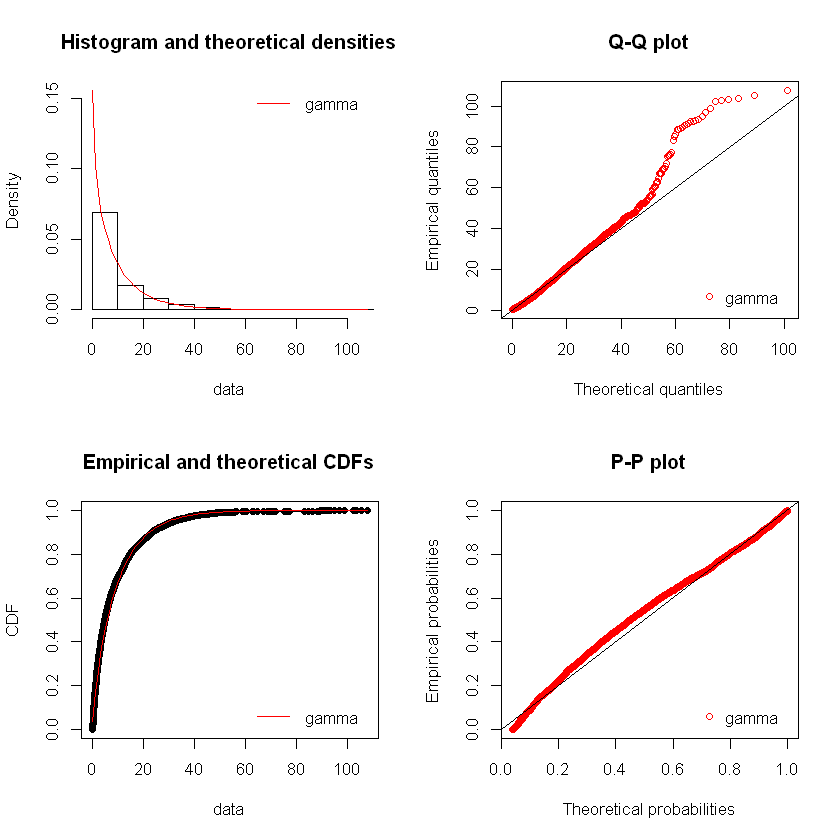

In [620]:
par(mfrow = c(2, 2))
denscomp(fd_GM_May4)
qqcomp(fd_GM_May4)
cdfcomp(fd_GM_May4)
ppcomp(fd_GM_May4)

In [621]:
fdGM_May4_shape <- fd_GM_May4$estimate[["shape"]]
fdGM_May4_rate <- fd_GM_May4$estimate[["rate"]]
fdGM_May4_llike <- fd_GM_May4$loglik
fdGM_May4_mean <- fdGM_May4_shape / fdGM_May4_rate
fdGM_May4_var <- fdGM_May4_shape / ( fdGM_May4_rate ^ 2 )
cat(" May 4 shape: ", fdGM_May4_shape, "\n", "May 4 rate: ", fdGM_May4_rate, 
    "\n", "May 4 loglikelihood: ", fdGM_May4_llike, "\n", 
    "May 4 mean: ", fdGM_May4_mean, "\n",
    "May 4 variance: ", fdGM_May4_var, "\n" )

 May 4 shape:  0.823354 
 May 4 rate:  0.08855645 
 May 4 loglikelihood:  -21373.91 
 May 4 mean:  9.297504 
 May 4 variance:  104.9896 


In [622]:
statRes <- gofstat( fd_GM_May4, fitnames=c("Gamma") )

In [623]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05177707
Cramer-von Mises statistic    6.28019070
Anderson-Darling statistic   37.64629756

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 42751.81
Bayesian Information Criterion 42765.42


In [624]:
ksRes <- ks.test( dfMay4$Precip_mm, "pgamma", shape=fdGM_May4_shape, rate=fdGM_May4_rate )

Warning message in ks.test(dfMay4$Precip_mm, "pgamma", shape = fdGM_May4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [625]:
fdGM_May4_KSStat <- ksRes$statistic
fdGM_May4_KSp <- ksRes$p.value
cat(" May 4 K-S stat: ", fdGM_May4_KSStat, "\n",
    "May 4 K-S p-value: ", fdGM_May4_KSp )

 May 4 K-S stat:  0.05177707 
 May 4 K-S p-value:  6.661338e-16

**Mixed exponential**

In [626]:
fd_ME_May4 <- expRMM_EM( dfMay4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfMay4$Precip_mm), 1.0/mean(dfMay4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 262 


In [627]:
summary( fd_ME_May4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.364273 0.6357267
rate   0.324395 0.0777602
loglik at estimate:  -21232.9 
0 % of the data right censored


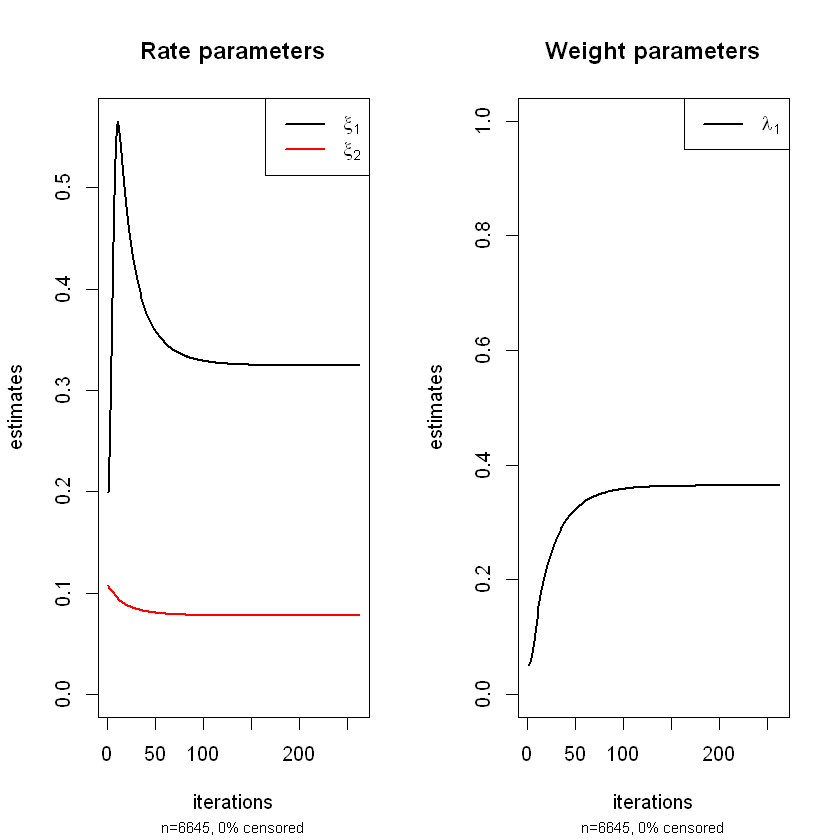

In [628]:
plotexpRMM( fd_ME_May4, lwd=2 )

In [629]:
fdME_May4_rate1 <- fd_ME_May4$rate[[1]]
fdME_May4_rate2 <- fd_ME_May4$rate[[2]]
fdME_May4_lambda <- fd_ME_May4$lambda[[1]]
fdME_May4_mean1 <- 1.0 / fdME_May4_rate1
fdME_May4_mean2 <- 1.0 / fdME_May4_rate2
fdME_May4_mean <- ( (fdME_May4_lambda * fdME_May4_mean1) + 
                    ( ( 1.0 - fdME_May4_lambda) * fdME_May4_mean2 ) )
fdME_May4_var1 <- 1.0 / (fdME_May4_rate1 ^ 2)
fdME_May4_var2 <- 1.0 / (fdME_May4_rate2 ^ 2)
fdME_May4_var <- ( (fdME_May4_lambda * ( fdME_May4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_May4_lambda) * (fdME_May4_mean2 ^ 2) ) + 
                   ( fdME_May4_lambda * ( 1.0 - fdME_May4_lambda) * 
                       ( fdME_May4_mean1 - fdME_May4_mean2 )^2 ) )
fdME_May4_llike <- fd_ME_May4$loglik
cat(" May 4 rate1: ", fdME_May4_rate1, "\n", 
    "May 4 rate2: ", fdME_May4_rate2, "\n",
    "May 4 lambda: ", fdME_May4_lambda, "\n",
    "May 4 mean1: ", fdME_May4_mean1, "\n",
    "May 4 mean2: ", fdME_May4_mean2, "\n",
    "May 4 mean: ", fdME_May4_mean, "\n",
    "May 4 var1: ", fdME_May4_var1, "\n",
    "May 4 var2: ", fdME_May4_var2, "\n",
    "May 4 var: ", fdME_May4_var, "\n",
    "May 4 loglikelihood: ", fdME_May4_llike, "\n" )

 May 4 rate1:  0.3243946 
 May 4 rate2:  0.07776024 
 May 4 lambda:  0.3642733 
 May 4 mean1:  3.082665 
 May 4 mean2:  12.86004 
 May 4 mean:  9.298405 
 May 4 var1:  9.502823 
 May 4 var2:  165.3807 
 May 4 var:  130.7368 
 May 4 loglikelihood:  -21232.9 


In [630]:
tvals <- rexpmix(length(dfMay4$Precip_mm), fd_ME_May4$lambda, fd_ME_May4$rate )

In [631]:
ksRes <- ks.test( dfMay4$Precip_mm, tvals )

Warning message in ks.test(dfMay4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [632]:
fdME_May4_KSStat <- ksRes$statistic
fdME_May4_KSp <- ksRes$p.value
cat(" May 4 K-S stat: ", fdME_May4_KSStat, "\n",
    "May 4 K-S p-value: ", fdME_May4_KSp )

 May 4 K-S stat:  0.03521445 
 May 4 K-S p-value:  0.0005276732

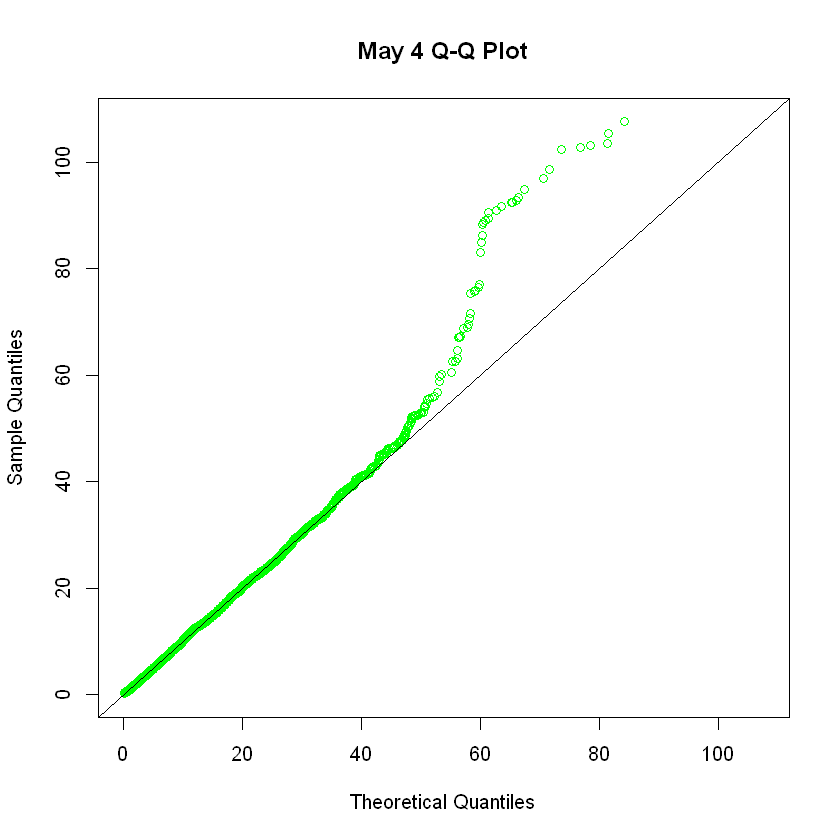

In [633]:
wMay4Max <- max( max( dfMay4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfMay4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May 4 Q-Q Plot",
        xlim=c(0,wMay4Max), ylim=c(0,wMay4Max) )
abline( 0, 1)

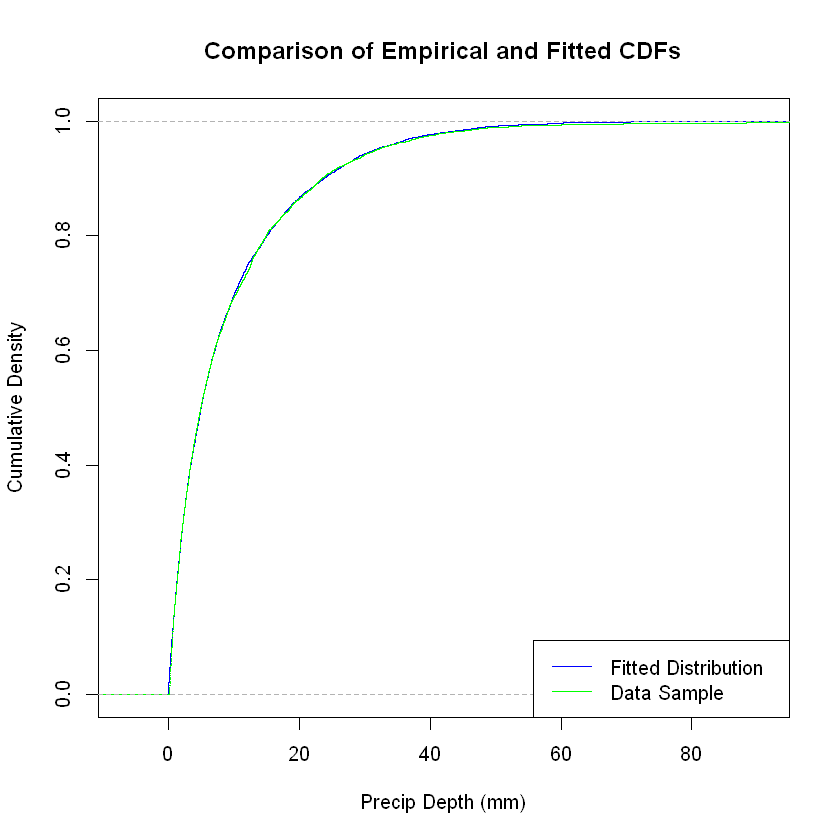

In [634]:
x <- seq(0,wMay4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfMay4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [635]:
MonDistDF[25, ] <- list( 5, 4, fdGM_May4_shape, fdGM_May4_rate, fdGM_May4_llike, fdGM_May4_mean,
                        fdGM_May4_var, fdGM_May4_KSStat, fdGM_May4_KSp, fdME_May4_rate1,
                        fdME_May4_rate2, fdME_May4_lambda, fdME_May4_mean1, fdME_May4_mean2,
                        fdME_May4_mean, fdME_May4_var1, fdME_May4_var2, fdME_May4_var,
                        fdME_May4_llike, fdME_May4_KSStat, fdME_May4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

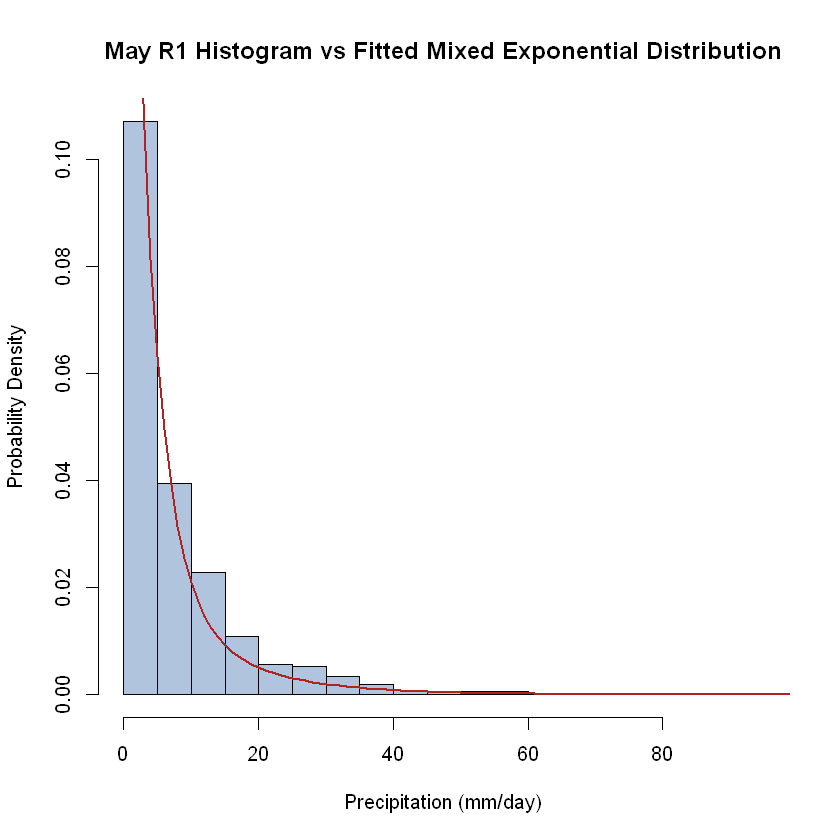

In [636]:
xVals <- seq(1, wMay1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_May1_lambda, spec1="exp", arg1=list(rate=fdME_May1_rate1),
                 spec2="exp", arg2=list(rate=fdME_May1_rate2) )
hist( dfMay1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="May R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

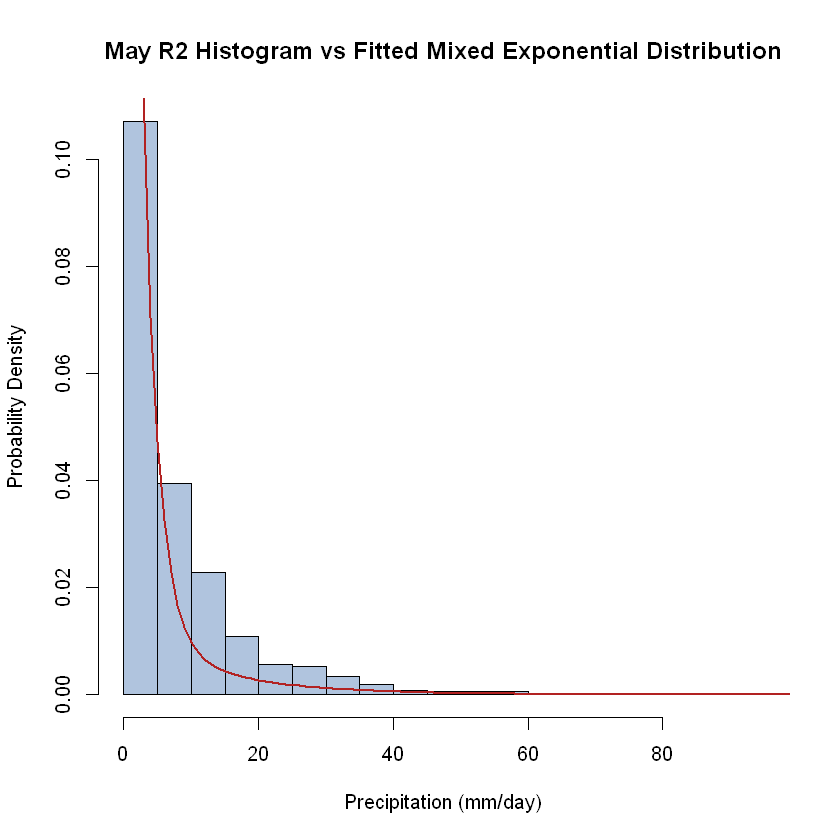

In [637]:
xVals <- seq(1, wMay2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_May2_lambda, spec1="exp", arg1=list(rate=fdME_May2_rate1),
                 spec2="exp", arg2=list(rate=fdME_May2_rate2) )
hist( dfMay1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="May R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

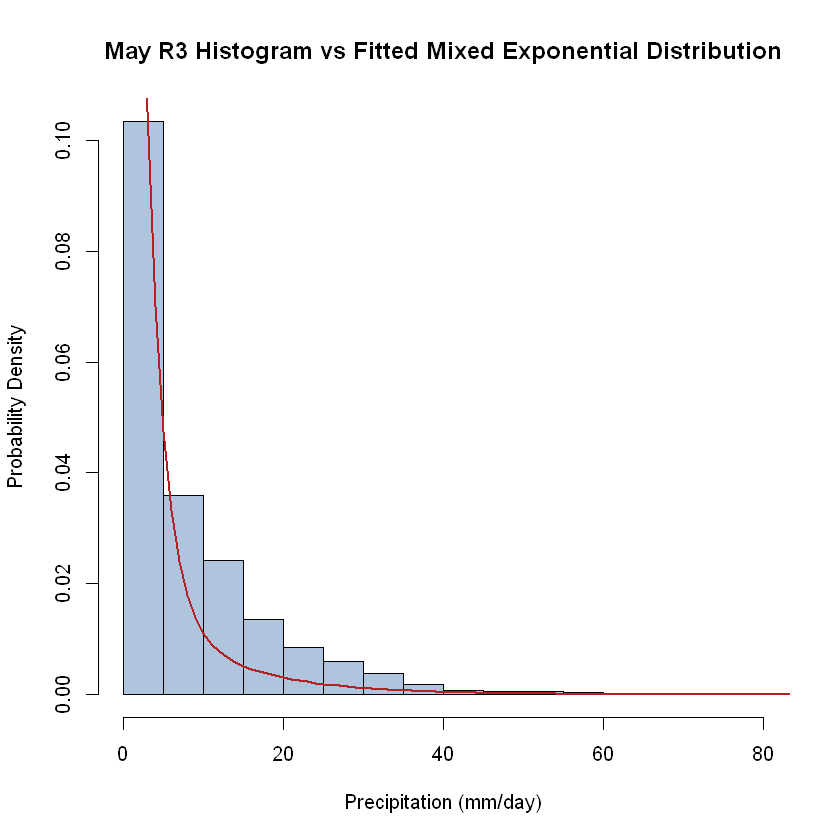

In [638]:
xVals <- seq(1, wMay3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_May3_lambda, spec1="exp", arg1=list(rate=fdME_May3_rate1),
                 spec2="exp", arg2=list(rate=fdME_May3_rate2) )
hist( dfMay3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="May R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

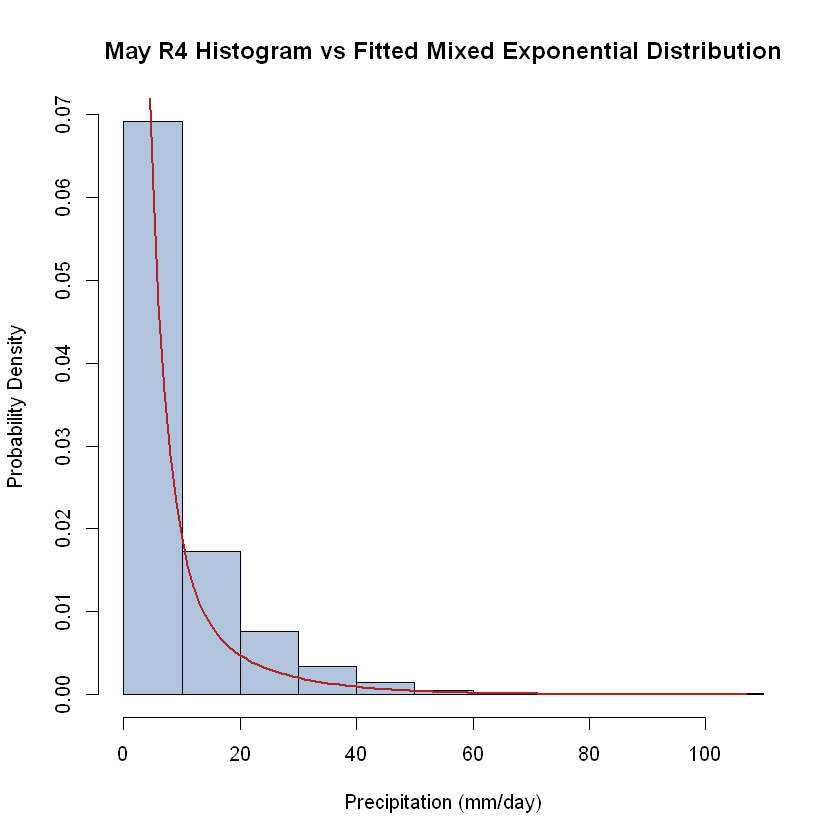

In [639]:
xVals <- seq(1, wMay4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_May4_lambda, spec1="exp", arg1=list(rate=fdME_May4_rate1),
                 spec2="exp", arg2=list(rate=fdME_May4_rate2) )
hist( dfMay4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="May R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Jun

#### All

**Gamma**

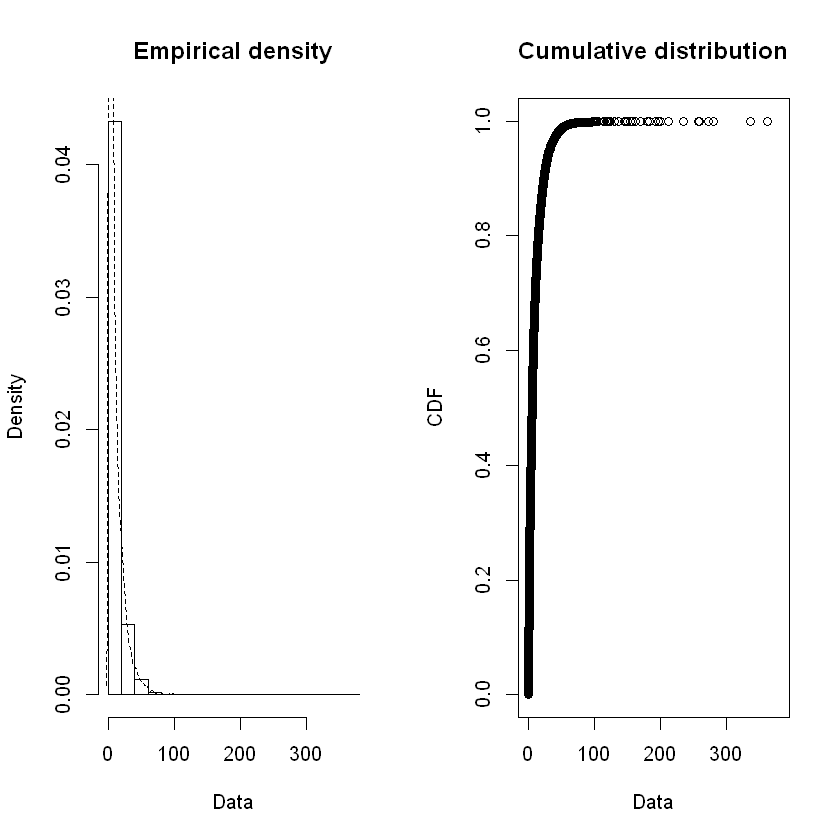

In [640]:
plotdist( dfJun$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  361.53 
median:  5.66 
mean:  9.54813 
estimated sd:  12.24296 
estimated skewness:  4.869737 
estimated kurtosis:  69.08813 

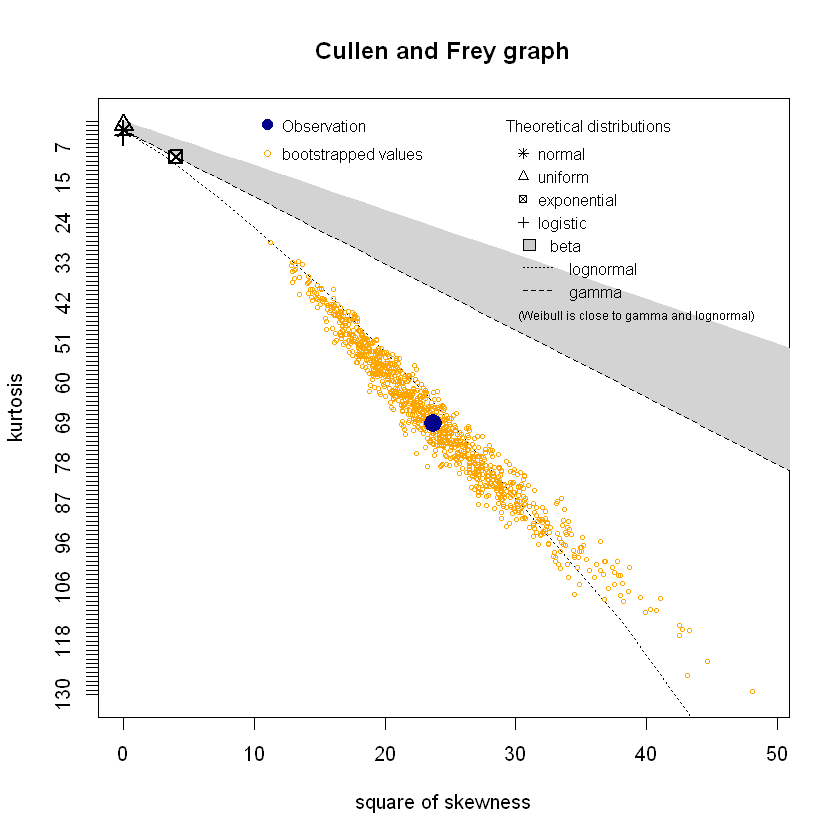

In [641]:
descdist( dfJun$Precip_mm, boot=1000 )

In [642]:
fd_GM_JunA <- fitdist( dfJun$Precip_mm, "gamma" )

In [643]:
summary( fd_GM_JunA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.84987500 0.0048034630
rate  0.08901634 0.0006714432
Loglikelihood:  -153010.3   AIC:  306024.6   BIC:  306042.1 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7491496
rate  0.7491496 1.0000000


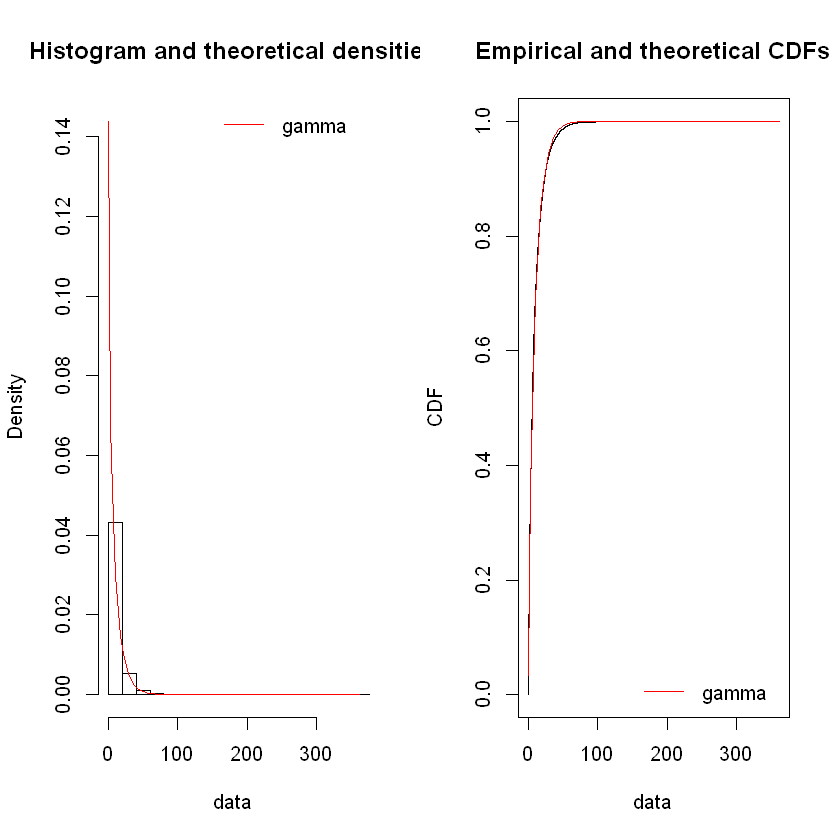

In [644]:
par(mfrow = c(1, 2))
denscomp(fd_GM_JunA)
#qqcomp(fd_GM_JunA)
cdfcomp(fd_GM_JunA)
#ppcomp(fd_GM_JunA)

In [645]:
fdGM_JunA_shape <- fd_GM_JunA$estimate[["shape"]]
fdGM_JunA_rate <- fd_GM_JunA$estimate[["rate"]]
fdGM_JunA_llike <- fd_GM_JunA$loglik
fdGM_JunA_mean <- fdGM_JunA_shape / fdGM_JunA_rate
fdGM_JunA_var <- fdGM_JunA_shape / ( fdGM_JunA_rate ^ 2 )
cat(" Jun A shape: ", fdGM_JunA_shape, "\n", "Jun A rate: ", fdGM_JunA_rate, 
    "\n", "Jun A loglikelihood: ", fdGM_JunA_llike, "\n", 
    "Jun A mean: ", fdGM_JunA_mean, "\n",
    "Jun A variance: ", fdGM_JunA_var, "\n" )

 Jun A shape:  0.849875 
 Jun A rate:  0.08901634 
 Jun A loglikelihood:  -153010.3 
 Jun A mean:  9.547404 
 Jun A variance:  107.2545 


In [646]:
statRes <- gofstat( fd_GM_JunA, fitnames=c("Gamma") )

In [647]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.03699439
Cramer-von Mises statistic    27.99097388
Anderson-Darling statistic   186.96057406

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 306024.6
Bayesian Information Criterion 306042.1


In [648]:
ksRes <- ks.test( dfJun$Precip_mm, "pgamma", shape=fdGM_JunA_shape, rate=fdGM_JunA_rate )

Warning message in ks.test(dfJun$Precip_mm, "pgamma", shape = fdGM_JunA_shape, rate = fdGM_JunA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [649]:
fdGM_JunA_KSStat <- ksRes$statistic
fdGM_JunA_KSp <- ksRes$p.value
cat(" Jun A K-S stat: ", fdGM_JunA_KSStat, "\n",
    "Jun A K-S p-value: ", fdGM_JunA_KSp )

 Jun A K-S stat:  0.03699439 
 Jun A K-S p-value:  0

**Mixed Exponential**

In [650]:
fd_ME_JunA <- expRMM_EM( dfJun$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfJun$Precip_mm), 1.0/mean(dfJun$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 691 


In [651]:
summary( fd_ME_JunA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.415251 0.584749
rate   0.242958 0.074595
loglik at estimate:  -152307.5 
0 % of the data right censored


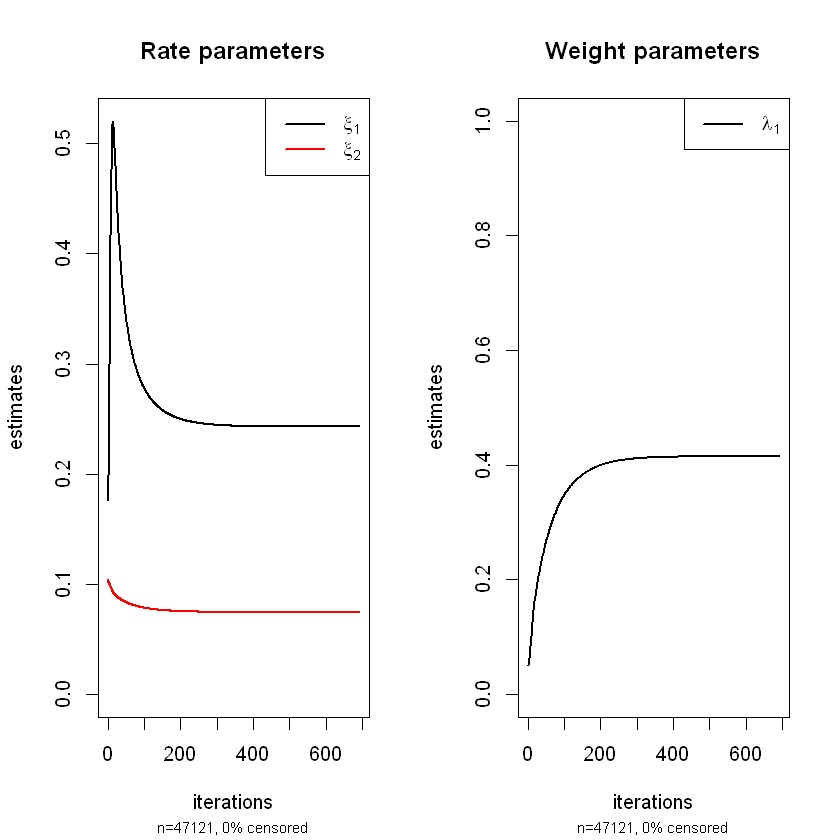

In [652]:
plotexpRMM( fd_ME_JunA, lwd=2 )

In [653]:
fdME_JunA_rate1 <- fd_ME_JunA$rate[[1]]
fdME_JunA_rate2 <- fd_ME_JunA$rate[[2]]
fdME_JunA_lambda <- fd_ME_JunA$lambda[[1]]
fdME_JunA_mean1 <- 1.0 / fdME_JunA_rate1
fdME_JunA_mean2 <- 1.0 / fdME_JunA_rate2
fdME_JunA_mean <- ( (fdME_JunA_lambda * fdME_JunA_mean1) + 
                    ( ( 1.0 - fdME_JunA_lambda) * fdME_JunA_mean2 ) )
fdME_JunA_var1 <- 1.0 / (fdME_JunA_rate1 ^ 2)
fdME_JunA_var2 <- 1.0 / (fdME_JunA_rate2 ^ 2)
fdME_JunA_var <- ( (fdME_JunA_lambda * ( fdME_JunA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_JunA_lambda) * (fdME_JunA_mean2 ^ 2) ) + 
                   ( fdME_JunA_lambda * ( 1.0 - fdME_JunA_lambda) * 
                       ( fdME_JunA_mean1 - fdME_JunA_mean2 )^2 ) )
fdME_JunA_llike <- fd_ME_JunA$loglik
cat(" Jun A rate1: ", fdME_JunA_rate1, "\n", 
    "Jun A rate2: ", fdME_JunA_rate2, "\n",
    "Jun A lambda: ", fdME_JunA_lambda, "\n",
    "Jun A mean1: ", fdME_JunA_mean1, "\n",
    "Jun A mean2: ", fdME_JunA_mean2, "\n",
    "Jun A mean: ", fdME_JunA_mean, "\n",
    "Jun A var1: ", fdME_JunA_var1, "\n",
    "Jun A var2: ", fdME_JunA_var2, "\n",
    "Jun A var: ", fdME_JunA_var, "\n",
    "Jun A loglikelihood: ", fdME_JunA_llike, "\n" )

 Jun A rate1:  0.2429578 
 Jun A rate2:  0.07459501 
 Jun A lambda:  0.4152511 
 Jun A mean1:  4.115941 
 Jun A mean2:  13.40572 
 Jun A mean:  9.54813 
 Jun A var1:  16.94097 
 Jun A var2:  179.7134 
 Jun A var:  133.0771 
 Jun A loglikelihood:  -152307.5 


In [654]:
tvals <- rexpmix(length(dfJun$Precip_mm), fd_ME_JunA$lambda, fd_ME_JunA$rate )

In [655]:
ksRes <- ks.test( dfJun$Precip_mm, tvals )

Warning message in ks.test(dfJun$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [656]:
fdME_JunA_KSStat <- ksRes$statistic
fdME_JunA_KSp <- ksRes$p.value
cat(" Jun A K-S stat: ", fdME_JunA_KSStat, "\n",
    "Jun A K-S p-value: ", fdME_JunA_KSp )

 Jun A K-S stat:  0.0281191 
 Jun A K-S p-value:  1.110223e-16

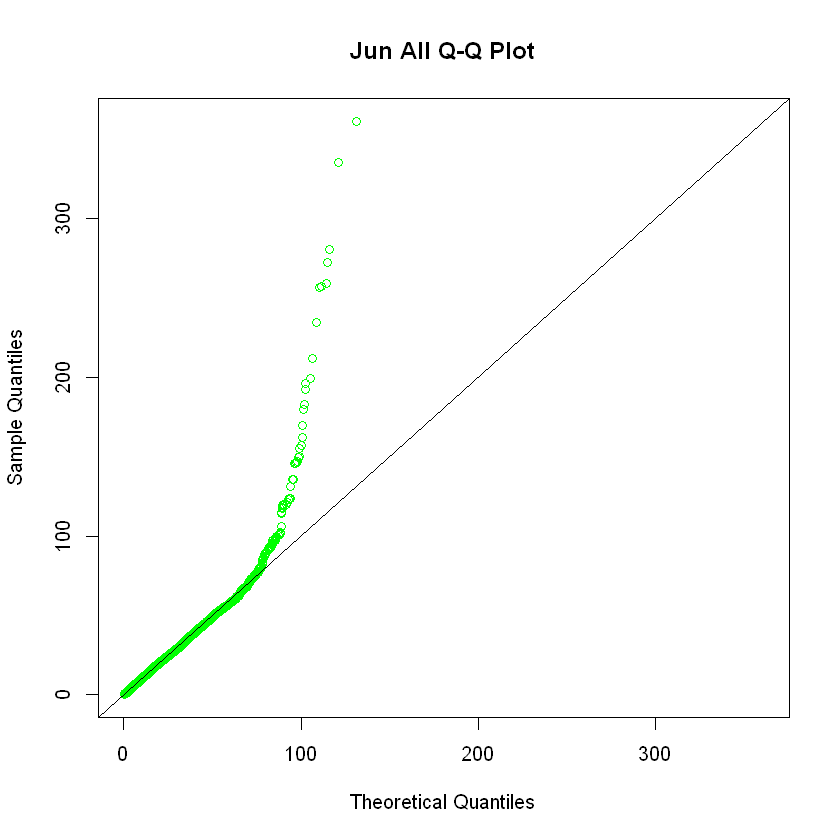

In [657]:
wJunAMax <- max( max( dfJun$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJun$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jun All Q-Q Plot",
        xlim=c(0,wJunAMax), ylim=c(0,wJunAMax) )
abline( 0, 1)

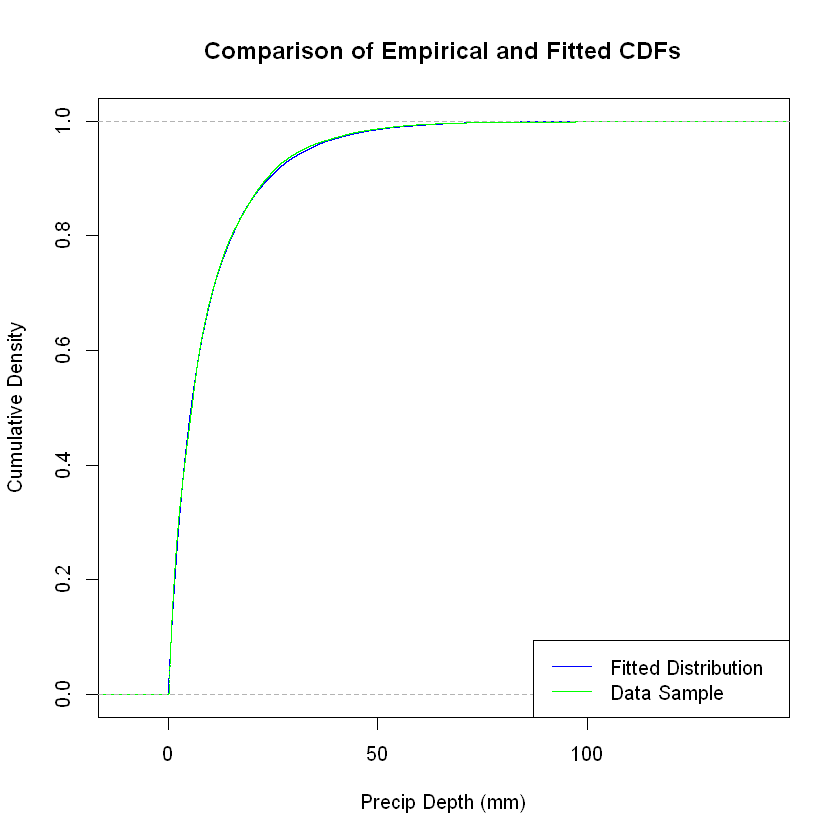

In [658]:
x <- seq(0,wJunAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJun$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [659]:
MonDistDF[26, ] <- list( 6, 0, fdGM_JunA_shape, fdGM_JunA_rate, fdGM_JunA_llike, fdGM_JunA_mean,
                        fdGM_JunA_var, fdGM_JunA_KSStat, fdGM_JunA_KSp, fdME_JunA_rate1,
                        fdME_JunA_rate2, fdME_JunA_lambda, fdME_JunA_mean1, fdME_JunA_mean2,
                        fdME_JunA_mean, fdME_JunA_var1, fdME_JunA_var2, fdME_JunA_var,
                        fdME_JunA_llike, fdME_JunA_KSStat, fdME_JunA_KSp )

#### Region 1

**Gamma**

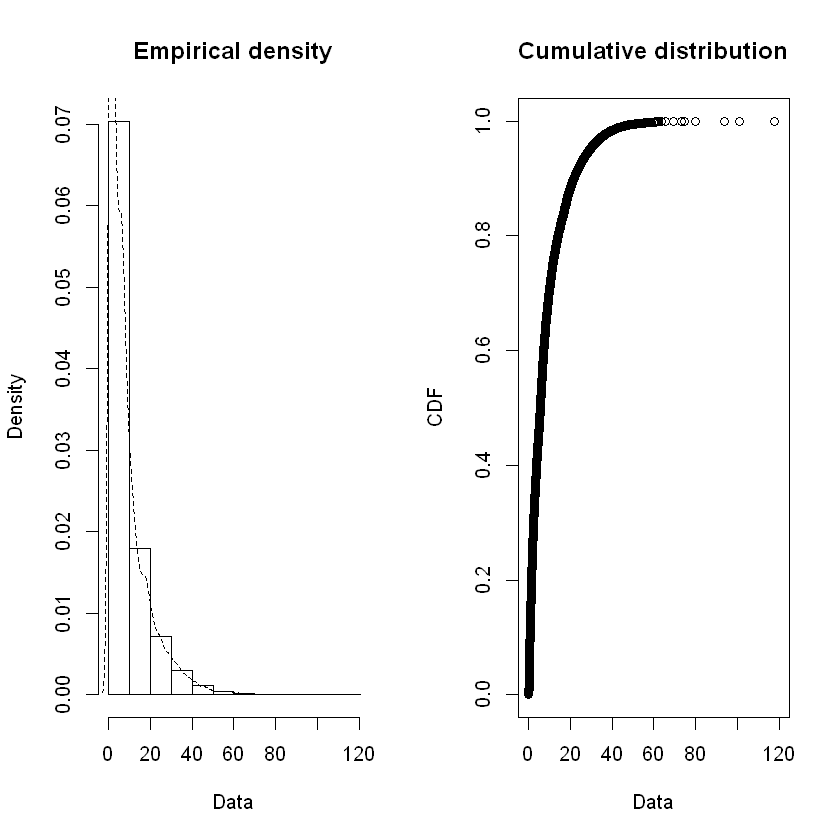

In [660]:
plotdist( dfJun1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  117.66 
median:  5.69 
mean:  8.782461 
estimated sd:  9.689432 
estimated skewness:  2.126834 
estimated kurtosis:  9.498341 

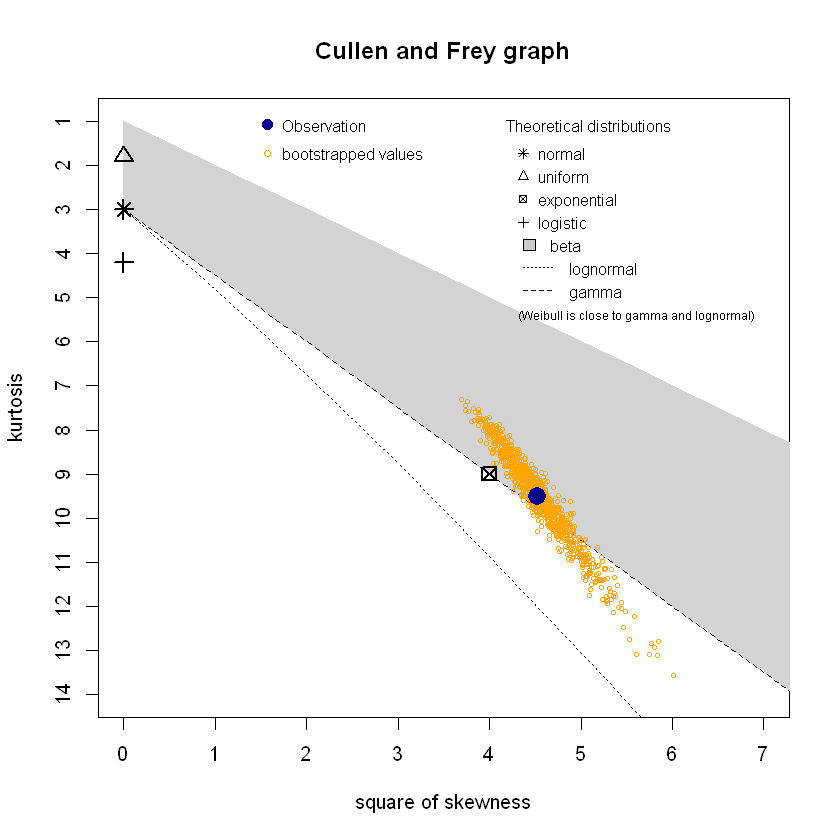

In [661]:
descdist( dfJun1$Precip_mm, boot=1000 )

In [662]:
fd_GM_Jun1 <- fitdist( dfJun1$Precip_mm, "gamma" )

In [663]:
summary( fd_GM_Jun1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.9297923 0.009248251
rate  0.1058741 0.001374033
Loglikelihood:  -49045.5   AIC:  98095   BIC:  98110.29 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7663048
rate  0.7663048 1.0000000


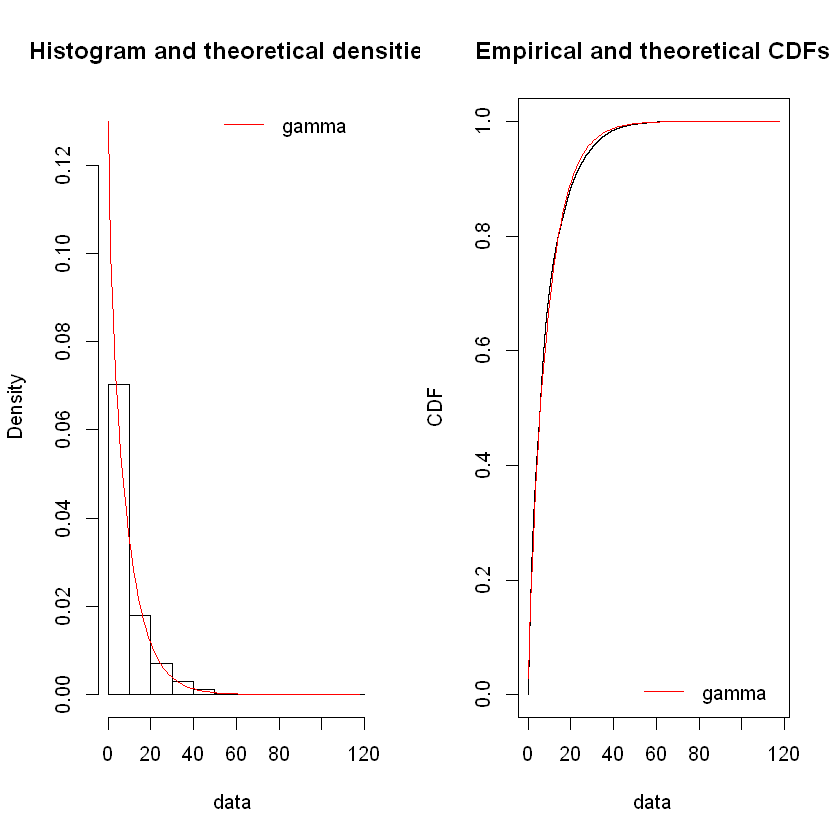

In [664]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Jun1)
#qqcomp(fd_GM_Jun1)
cdfcomp(fd_GM_Jun1)
#ppcomp(fd_GM_Jun1)

In [665]:
fdGM_Jun1_shape <- fd_GM_Jun1$estimate[["shape"]]
fdGM_Jun1_rate <- fd_GM_Jun1$estimate[["rate"]]
fdGM_Jun1_llike <- fd_GM_Jun1$loglik
fdGM_Jun1_mean <- fdGM_Jun1_shape / fdGM_Jun1_rate
fdGM_Jun1_var <- fdGM_Jun1_shape / ( fdGM_Jun1_rate ^ 2 )
cat(" Jun 1 shape: ", fdGM_Jun1_shape, "\n", "Jun 1 rate: ", fdGM_Jun1_rate, 
    "\n", "Jun 1 loglikelihood: ", fdGM_Jun1_llike, "\n", 
    "Jun 1 mean: ", fdGM_Jun1_mean, "\n",
    "Jun 1 variance: ", fdGM_Jun1_var, "\n" )

 Jun 1 shape:  0.9297923 
 Jun 1 rate:  0.1058741 
 Jun 1 loglikelihood:  -49045.5 
 Jun 1 mean:  8.782057 
 Jun 1 variance:  82.94812 


In [666]:
statRes <- gofstat( fd_GM_Jun1, fitnames=c("Gamma") )

In [667]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.03727318
Cramer-von Mises statistic    6.51901926
Anderson-Darling statistic   46.40179664

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 98095.00
Bayesian Information Criterion 98110.29


In [668]:
ksRes <- ks.test( dfJun1$Precip_mm, "pgamma", shape=fdGM_Jun1_shape, rate=fdGM_Jun1_rate )

Warning message in ks.test(dfJun1$Precip_mm, "pgamma", shape = fdGM_Jun1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [669]:
fdGM_Jun1_KSStat <- ksRes$statistic
fdGM_Jun1_KSp <- ksRes$p.value
cat(" Jun 1 K-S stat: ", fdGM_Jun1_KSStat, "\n",
    "Jun 1 K-S p-value: ", fdGM_Jun1_KSp )

 Jun 1 K-S stat:  0.03727318 
 Jun 1 K-S p-value:  0

**Mixed exponential**

In [670]:
fd_ME_Jun1 <- expRMM_EM( dfJun1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJun1$Precip_mm), 1.0/mean(dfJun1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 742 


In [671]:
summary( fd_ME_Jun1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.260506 0.7394938
rate   0.280712 0.0941498
loglik at estimate:  -48935.07 
0 % of the data right censored


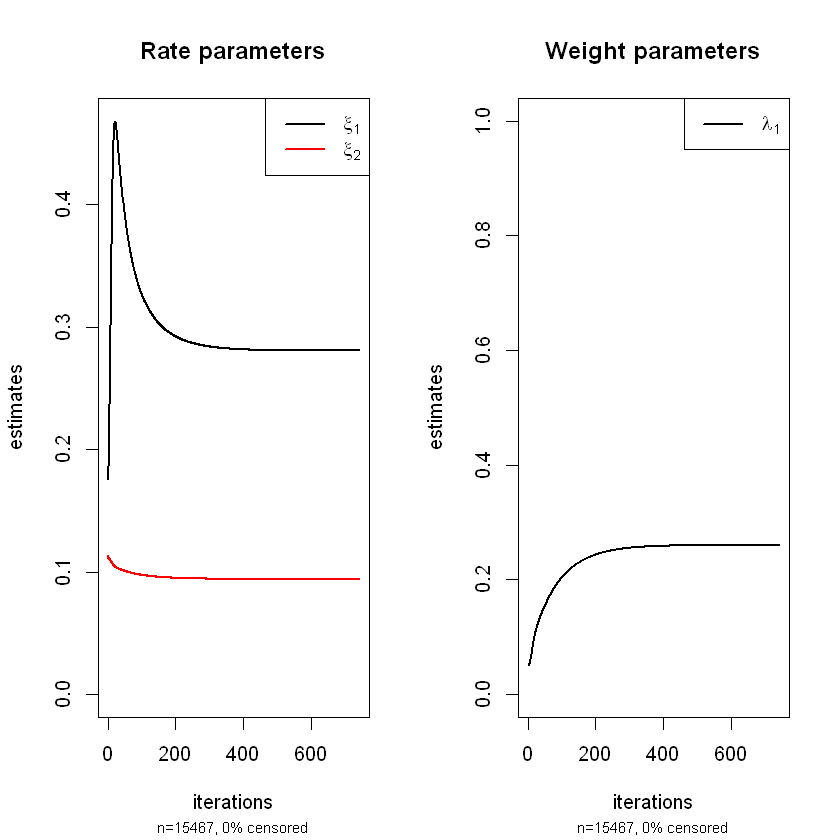

In [672]:
plotexpRMM( fd_ME_Jun1, lwd=2 )

In [673]:
fdME_Jun1_rate1 <- fd_ME_Jun1$rate[[1]]
fdME_Jun1_rate2 <- fd_ME_Jun1$rate[[2]]
fdME_Jun1_lambda <- fd_ME_Jun1$lambda[[1]]
fdME_Jun1_mean1 <- 1.0 / fdME_Jun1_rate1
fdME_Jun1_mean2 <- 1.0 / fdME_Jun1_rate2
fdME_Jun1_mean <- ( (fdME_Jun1_lambda * fdME_Jun1_mean1) + 
                    ( ( 1.0 - fdME_Jun1_lambda) * fdME_Jun1_mean2 ) )
fdME_Jun1_var1 <- 1.0 / (fdME_Jun1_rate1 ^ 2)
fdME_Jun1_var2 <- 1.0 / (fdME_Jun1_rate2 ^ 2)
fdME_Jun1_var <- ( (fdME_Jun1_lambda * ( fdME_Jun1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jun1_lambda) * (fdME_Jun1_mean2 ^ 2) ) + 
                   ( fdME_Jun1_lambda * ( 1.0 - fdME_Jun1_lambda) * 
                       ( fdME_Jun1_mean1 - fdME_Jun1_mean2 )^2 ) )
fdME_Jun1_llike <- fd_ME_Jun1$loglik
cat(" Jun 1 rate1: ", fdME_Jun1_rate1, "\n", 
    "Jun 1 rate2: ", fdME_Jun1_rate2, "\n",
    "Jun 1 lambda: ", fdME_Jun1_lambda, "\n",
    "Jun 1 mean1: ", fdME_Jun1_mean1, "\n",
    "Jun 1 mean2: ", fdME_Jun1_mean2, "\n",
    "Jun 1 mean: ", fdME_Jun1_mean, "\n",
    "Jun 1 var1: ", fdME_Jun1_var1, "\n",
    "Jun 1 var2: ", fdME_Jun1_var2, "\n",
    "Jun 1 var: ", fdME_Jun1_var, "\n",
    "Jun 1 loglikelihood: ", fdME_Jun1_llike, "\n" )

 Jun 1 rate1:  0.2807117 
 Jun 1 rate2:  0.09414977 
 Jun 1 lambda:  0.2605062 
 Jun 1 mean1:  3.562374 
 Jun 1 mean2:  10.62137 
 Jun 1 mean:  8.782461 
 Jun 1 var1:  12.69051 
 Jun 1 var2:  112.8136 
 Jun 1 var:  96.3302 
 Jun 1 loglikelihood:  -48935.07 


In [674]:
tvals <- rexpmix(length(dfJun1$Precip_mm), fd_ME_Jun1$lambda, fd_ME_Jun1$rate )

In [675]:
ksRes <- ks.test( dfJun1$Precip_mm, tvals )

Warning message in ks.test(dfJun1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [676]:
fdME_Jun1_KSStat <- ksRes$statistic
fdME_Jun1_KSp <- ksRes$p.value
cat(" Jun 1 K-S stat: ", fdME_Jun1_KSStat, "\n",
    "Jun 1 K-S p-value: ", fdME_Jun1_KSp )

 Jun 1 K-S stat:  0.02747786 
 Jun 1 K-S p-value:  1.69551e-05

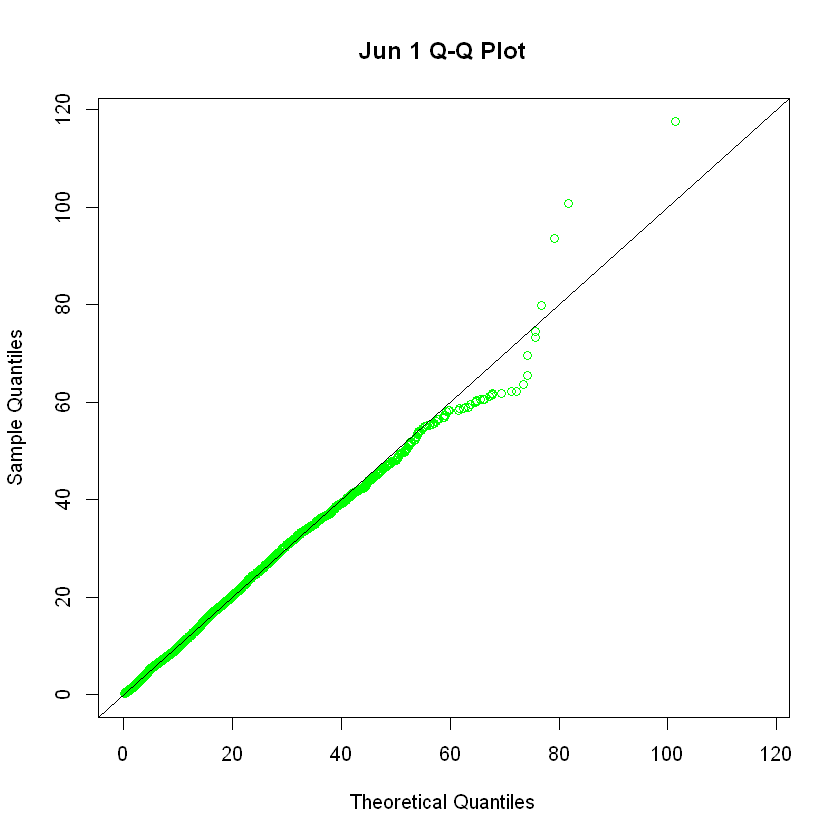

In [677]:
wJun1Max <- max( max( dfJun1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJun1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jun 1 Q-Q Plot",
        xlim=c(0,wJun1Max), ylim=c(0,wJun1Max) )
abline( 0, 1)

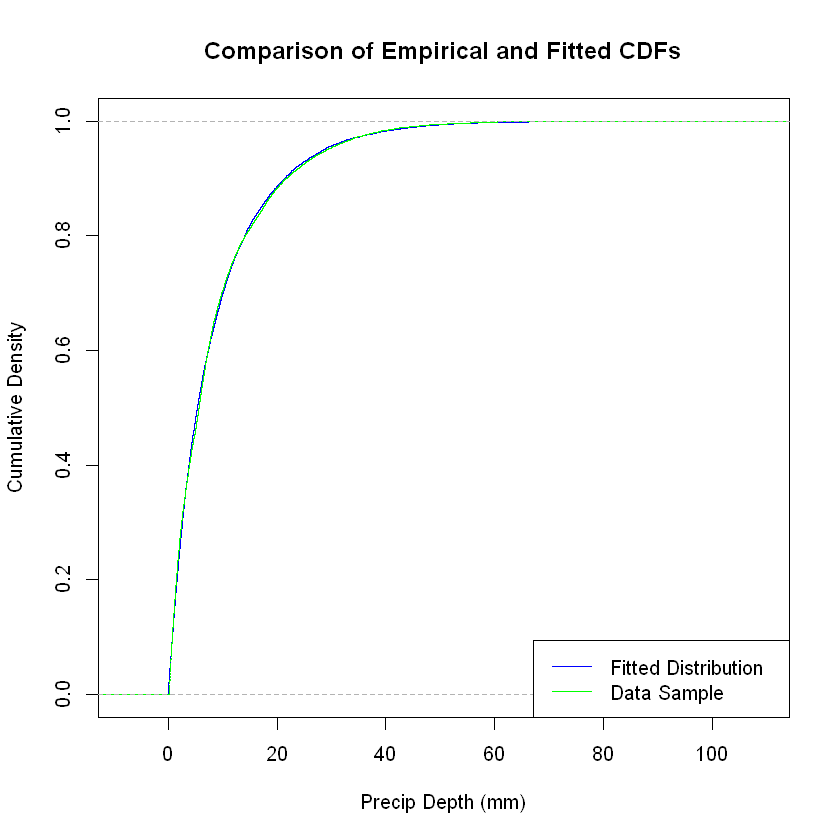

In [678]:
x <- seq(0,wJun1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJun1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [679]:
MonDistDF[27, ] <- list( 6, 1, fdGM_Jun1_shape, fdGM_Jun1_rate, fdGM_Jun1_llike, fdGM_Jun1_mean,
                        fdGM_Jun1_var, fdGM_Jun1_KSStat, fdGM_Jun1_KSp, fdME_Jun1_rate1,
                        fdME_Jun1_rate2, fdME_Jun1_lambda, fdME_Jun1_mean1, fdME_Jun1_mean2,
                        fdME_Jun1_mean, fdME_Jun1_var1, fdME_Jun1_var2, fdME_Jun1_var,
                        fdME_Jun1_llike, fdME_Jun1_KSStat, fdME_Jun1_KSp )

#### Region 2

**Gamma**

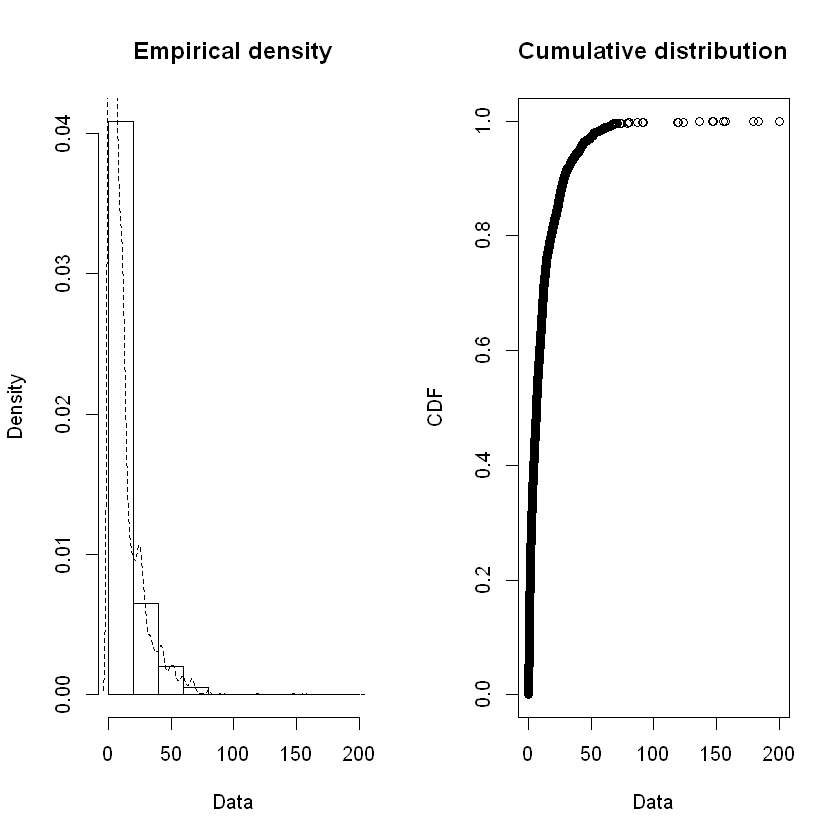

In [680]:
plotdist( dfJun2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  199.64 
median:  6.43 
mean:  11.28497 
estimated sd:  14.41965 
estimated skewness:  3.286982 
estimated kurtosis:  24.26518 

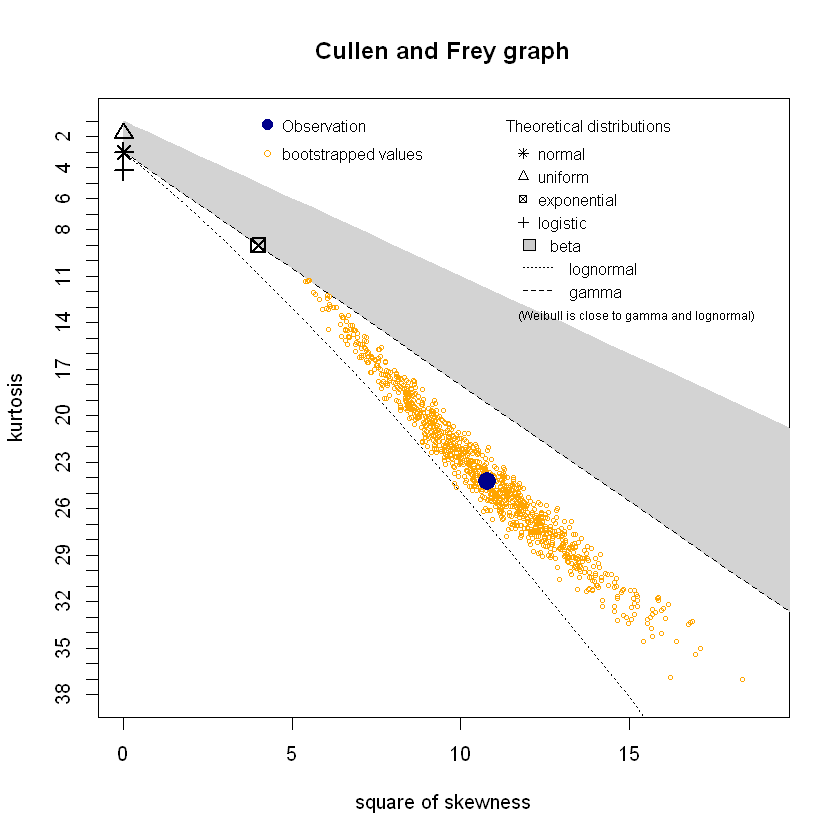

In [681]:
descdist( dfJun2$Precip_mm, boot=1000 )

In [682]:
fd_GM_Jun2 <- fitdist( dfJun2$Precip_mm, "gamma" )

In [683]:
summary( fd_GM_Jun2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.77826365 0.011957147
rate  0.06897727 0.001447914
Loglikelihood:  -21332.84   AIC:  42669.68   BIC:  42683.17 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7316644
rate  0.7316644 1.0000000


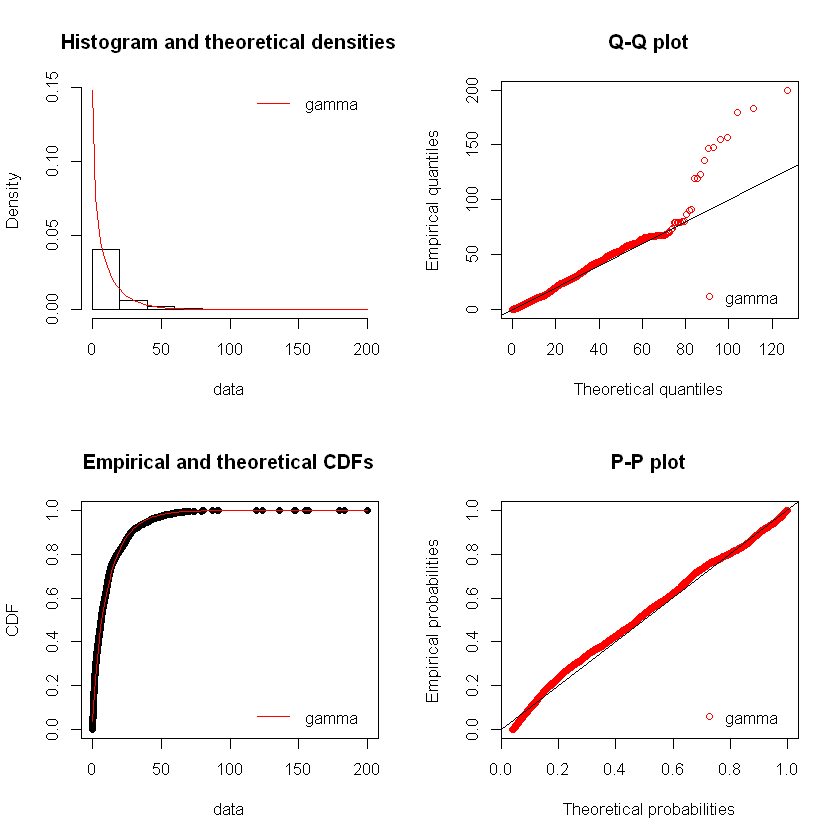

In [684]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jun2)
qqcomp(fd_GM_Jun2)
cdfcomp(fd_GM_Jun2)
ppcomp(fd_GM_Jun2)

In [685]:
fdGM_Jun2_shape <- fd_GM_Jun2$estimate[["shape"]]
fdGM_Jun2_rate <- fd_GM_Jun2$estimate[["rate"]]
fdGM_Jun2_llike <- fd_GM_Jun2$loglik
fdGM_Jun2_mean <- fdGM_Jun2_shape / fdGM_Jun2_rate
fdGM_Jun2_var <- fdGM_Jun2_shape / ( fdGM_Jun2_rate ^ 2 )
cat(" Jun 2 shape: ", fdGM_Jun2_shape, "\n", "Jun 2 rate: ", fdGM_Jun2_rate, 
    "\n", "Jun 2 loglikelihood: ", fdGM_Jun2_llike, "\n", 
    "Jun 2 mean: ", fdGM_Jun2_mean, "\n",
    "Jun 2 variance: ", fdGM_Jun2_var, "\n" )

 Jun 2 shape:  0.7782637 
 Jun 2 rate:  0.06897727 
 Jun 2 loglikelihood:  -21332.84 
 Jun 2 mean:  11.2829 
 Jun 2 variance:  163.5742 


In [686]:
statRes <- gofstat( fd_GM_Jun2, fitnames=c("Gamma") )

In [687]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.04383398
Cramer-von Mises statistic    4.06805793
Anderson-Darling statistic   28.60769911

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 42669.68
Bayesian Information Criterion 42683.17


In [688]:
ksRes <- ks.test( dfJun2$Precip_mm, "pgamma", shape=fdGM_Jun2_shape, rate=fdGM_Jun2_rate )

Warning message in ks.test(dfJun2$Precip_mm, "pgamma", shape = fdGM_Jun2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [689]:
fdGM_Jun2_KSStat <- ksRes$statistic
fdGM_Jun2_KSp <- ksRes$p.value
cat(" Jun 2 K-S stat: ", fdGM_Jun2_KSStat, "\n",
    "Jun 2 K-S p-value: ", fdGM_Jun2_KSp )

 Jun 2 K-S stat:  0.04383398 
 Jun 2 K-S p-value:  6.790157e-11

**Mixed exponential**

In [690]:
fd_ME_Jun2 <- expRMM_EM( dfJun2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJun2$Precip_mm), 1.0/mean(dfJun2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 450 


In [691]:
summary( fd_ME_Jun2 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.311788 0.688212
rate   0.335651 0.066455
loglik at estimate:  -21224.04 
0 % of the data right censored


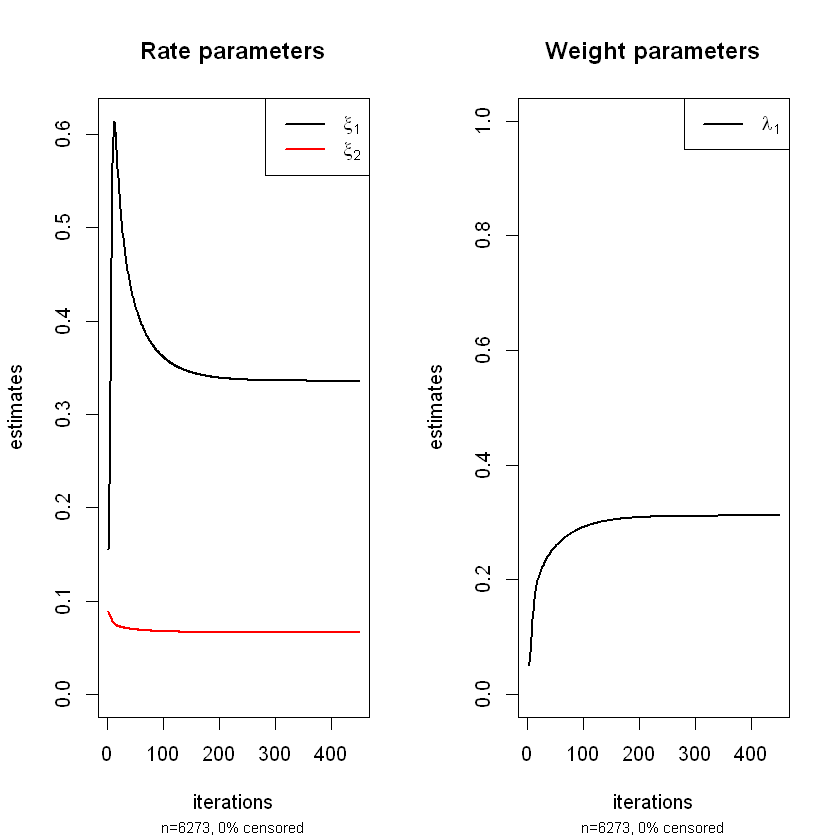

In [692]:
plotexpRMM( fd_ME_Jun2, lwd=2 )

In [693]:
fdME_Jun2_rate1 <- fd_ME_Jun2$rate[[1]]
fdME_Jun2_rate2 <- fd_ME_Jun2$rate[[2]]
fdME_Jun2_lambda <- fd_ME_Jun2$lambda[[1]]
fdME_Jun2_mean1 <- 1.0 / fdME_Jun2_rate1
fdME_Jun2_mean2 <- 1.0 / fdME_Jun2_rate2
fdME_Jun2_mean <- ( (fdME_Jun2_lambda * fdME_Jun2_mean1) + 
                    ( ( 1.0 - fdME_Jun2_lambda) * fdME_Jun2_mean2 ) )
fdME_Jun2_var1 <- 1.0 / (fdME_Jun2_rate1 ^ 2)
fdME_Jun2_var2 <- 1.0 / (fdME_Jun2_rate2 ^ 2)
fdME_Jun2_var <- ( (fdME_Jun2_lambda * ( fdME_Jun2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jun2_lambda) * (fdME_Jun2_mean2 ^ 2) ) + 
                   ( fdME_Jun2_lambda * ( 1.0 - fdME_Jun2_lambda) * 
                       ( fdME_Jun2_mean1 - fdME_Jun2_mean2 )^2 ) )
fdME_Jun2_llike <- fd_ME_Jun2$loglik
cat(" Jun 2 rate1: ", fdME_Jun2_rate1, "\n", 
    "Jun 2 rate2: ", fdME_Jun2_rate2, "\n",
    "Jun 2 lambda: ", fdME_Jun2_lambda, "\n",
    "Jun 2 mean1: ", fdME_Jun2_mean1, "\n",
    "Jun 2 mean2: ", fdME_Jun2_mean2, "\n",
    "Jun 2 mean: ", fdME_Jun2_mean, "\n",
    "Jun 2 var1: ", fdME_Jun2_var1, "\n",
    "Jun 2 var2: ", fdME_Jun2_var2, "\n",
    "Jun 2 var: ", fdME_Jun2_var, "\n",
    "Jun 2 loglikelihood: ", fdME_Jun2_llike, "\n" )

 Jun 2 rate1:  0.3356511 
 Jun 2 rate2:  0.06645496 
 Jun 2 lambda:  0.3117883 
 Jun 2 mean1:  2.979284 
 Jun 2 mean2:  15.04778 
 Jun 2 mean:  11.28497 
 Jun 2 var1:  8.876134 
 Jun 2 var2:  226.4358 
 Jun 2 var:  189.856 
 Jun 2 loglikelihood:  -21224.04 


In [694]:
tvals <- rexpmix(length(dfJun2$Precip_mm), fd_ME_Jun2$lambda, fd_ME_Jun2$rate )

In [695]:
ksRes <- ks.test( dfJun2$Precip_mm, tvals )

Warning message in ks.test(dfJun2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [696]:
fdME_Jun2_KSStat <- ksRes$statistic
fdME_Jun2_KSp <- ksRes$p.value
cat(" Jun 2 K-S stat: ", fdME_Jun2_KSStat, "\n",
    "Jun 2 K-S p-value: ", fdME_Jun2_KSp )

 Jun 2 K-S stat:  0.02901323 
 Jun 2 K-S p-value:  0.0101807

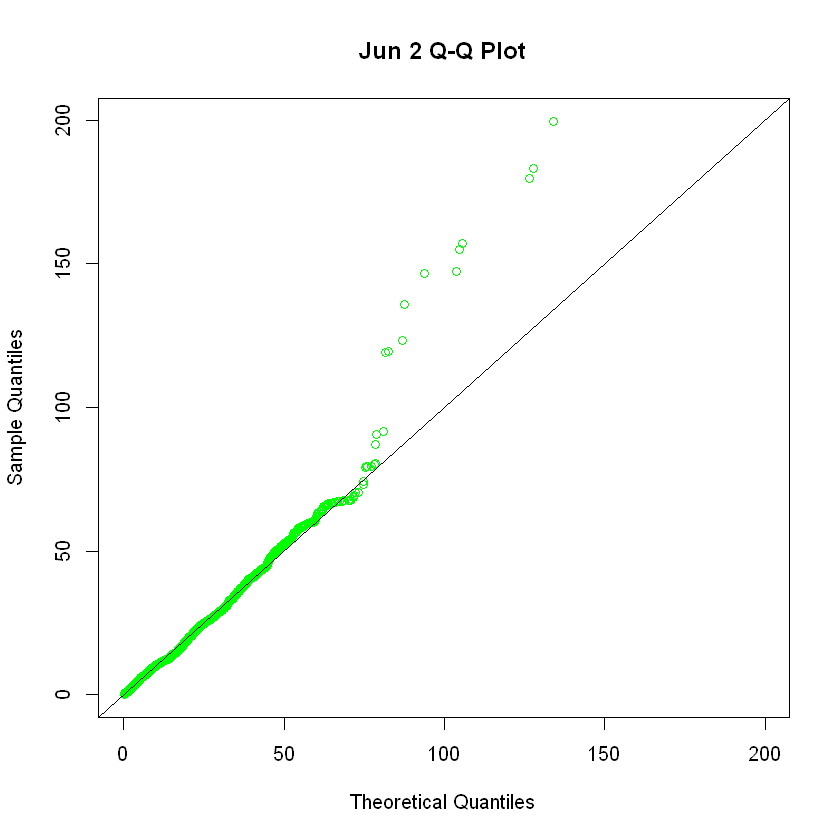

In [697]:
wJun2Max <- max( max( dfJun2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJun2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jun 2 Q-Q Plot",
        xlim=c(0,wJun2Max), ylim=c(0,wJun2Max) )
abline( 0, 1)

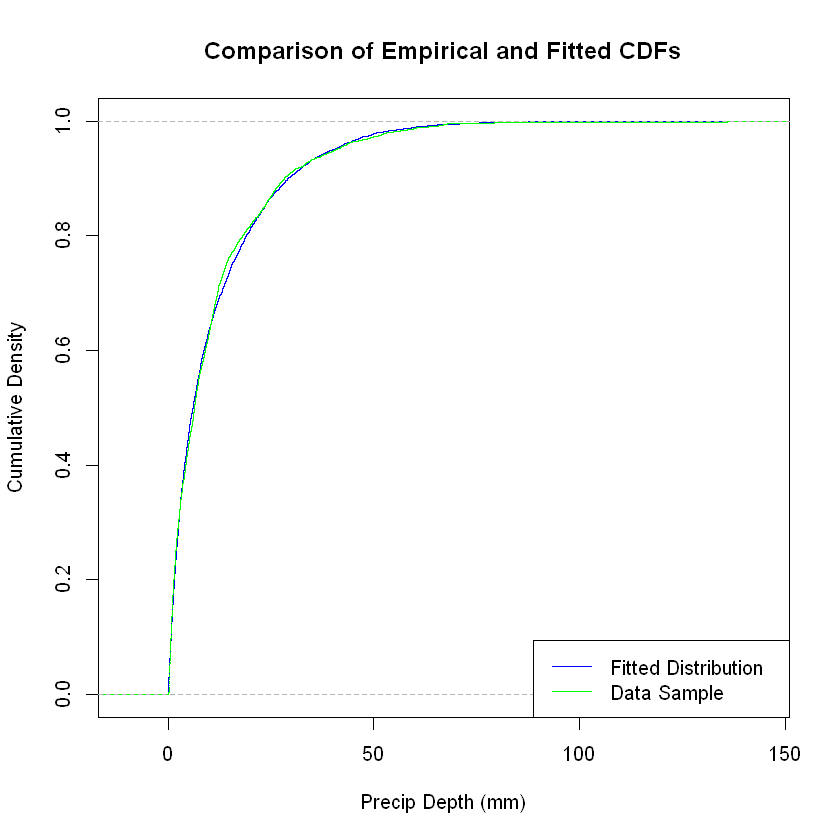

In [698]:
x <- seq(0,wJun2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJun2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [699]:
MonDistDF[28, ] <- list( 6, 2, fdGM_Jun2_shape, fdGM_Jun2_rate, fdGM_Jun2_llike, fdGM_Jun2_mean,
                        fdGM_Jun2_var, fdGM_Jun2_KSStat, fdGM_Jun2_KSp, fdME_Jun2_rate1,
                        fdME_Jun2_rate2, fdME_Jun2_lambda, fdME_Jun2_mean1, fdME_Jun2_mean2,
                        fdME_Jun2_mean, fdME_Jun2_var1, fdME_Jun2_var2, fdME_Jun2_var,
                        fdME_Jun2_llike, fdME_Jun2_KSStat, fdME_Jun2_KSp )

#### Region 3

**Gamma**

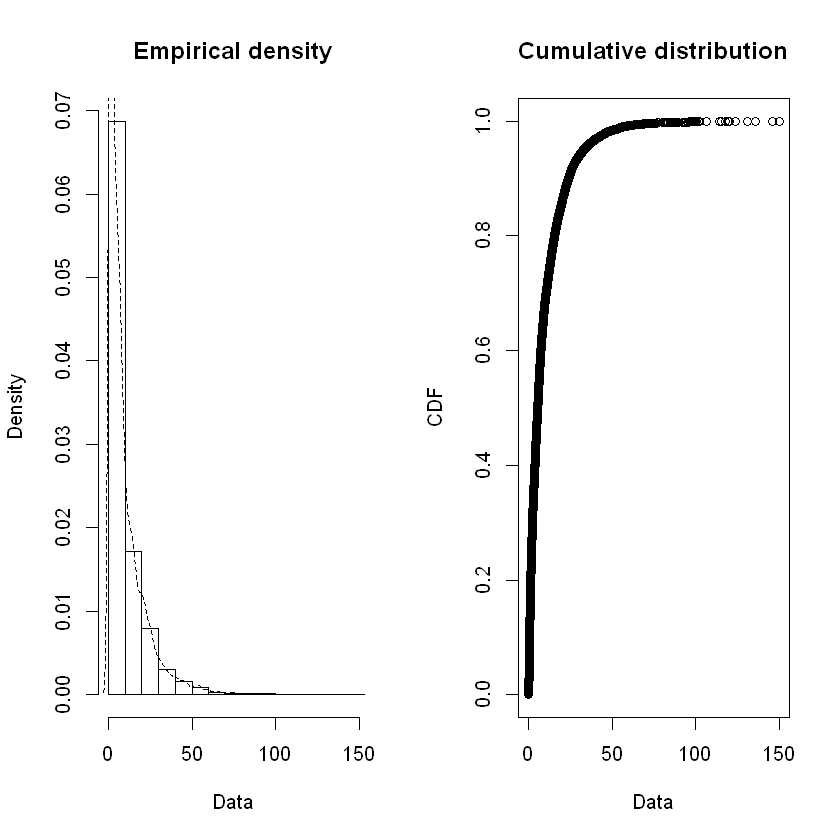

In [700]:
plotdist( dfJun3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  149.81 
median:  5.56 
mean:  9.692415 
estimated sd:  12.05409 
estimated skewness:  2.871754 
estimated kurtosis:  16.18146 

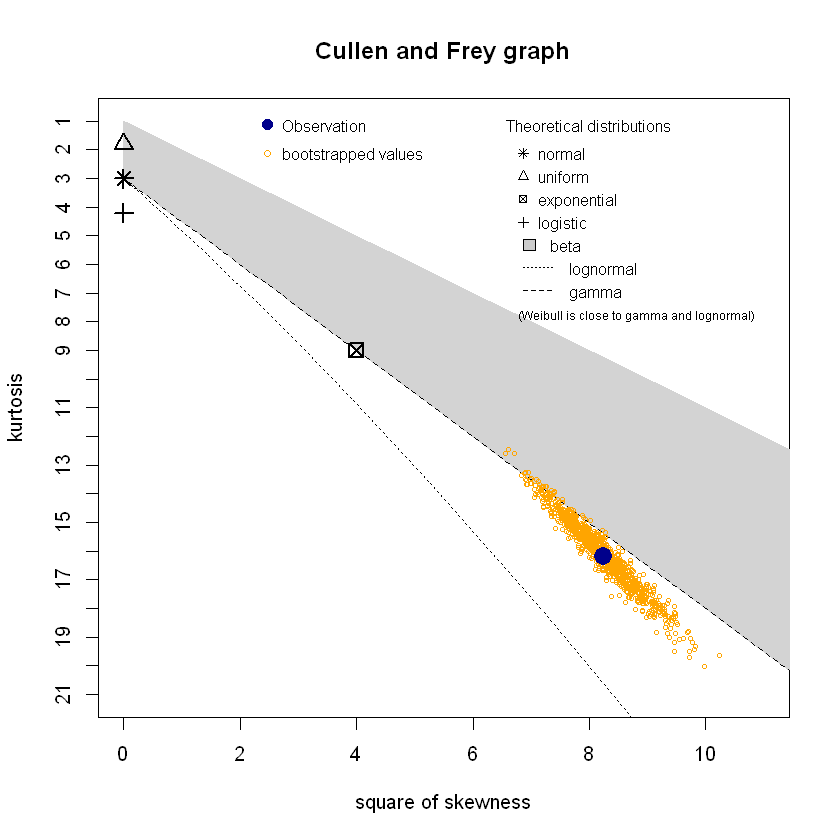

In [701]:
descdist( dfJun3$Precip_mm, boot=1000 )

In [702]:
fd_GM_Jun3 <- fitdist( dfJun3$Precip_mm, "gamma" )

In [703]:
summary( fd_GM_Jun3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.83227470 0.0070416101
rate  0.08585011 0.0009746746
Loglikelihood:  -68277.14   AIC:  136558.3   BIC:  136574.2 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7450548
rate  0.7450548 1.0000000


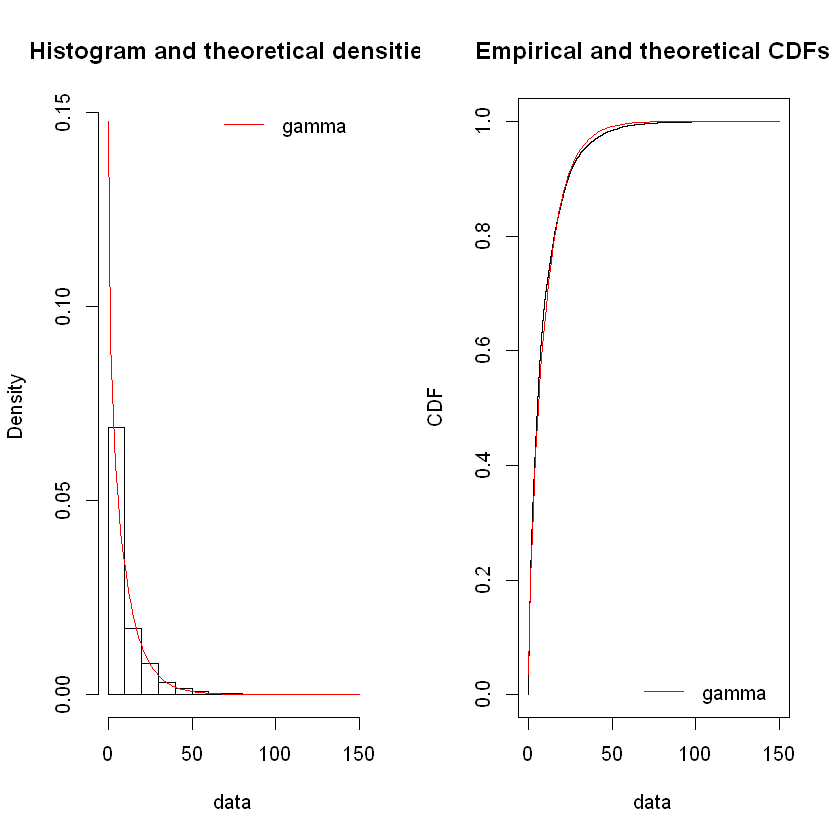

In [704]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Jun3)
#qqcomp(fd_GM_Jun3)
cdfcomp(fd_GM_Jun3)
#ppcomp(fd_GM_Jun3)

In [705]:
fdGM_Jun3_shape <- fd_GM_Jun3$estimate[["shape"]]
fdGM_Jun3_rate <- fd_GM_Jun3$estimate[["rate"]]
fdGM_Jun3_llike <- fd_GM_Jun3$loglik
fdGM_Jun3_mean <- fdGM_Jun3_shape / fdGM_Jun3_rate
fdGM_Jun3_var <- fdGM_Jun3_shape / ( fdGM_Jun3_rate ^ 2 )
cat(" Jun 3 shape: ", fdGM_Jun3_shape, "\n", "Jun 3 rate: ", fdGM_Jun3_rate, 
    "\n", "Jun 3 loglikelihood: ", fdGM_Jun3_llike, "\n", 
    "Jun 3 mean: ", fdGM_Jun3_mean, "\n",
    "Jun 3 variance: ", fdGM_Jun3_var, "\n" )

 Jun 3 shape:  0.8322747 
 Jun 3 rate:  0.08585011 
 Jun 3 loglikelihood:  -68277.14 
 Jun 3 mean:  9.69451 
 Jun 3 variance:  112.9237 


In [706]:
statRes <- gofstat( fd_GM_Jun3, fitnames=c("Gamma") )

In [707]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic  0.0424819
Cramer-von Mises statistic   14.6776094
Anderson-Darling statistic   94.7930552

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 136558.3
Bayesian Information Criterion 136574.2


In [708]:
ksRes <- ks.test( dfJun3$Precip_mm, "pgamma", shape=fdGM_Jun3_shape, rate=fdGM_Jun3_rate )

Warning message in ks.test(dfJun3$Precip_mm, "pgamma", shape = fdGM_Jun3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [709]:
fdGM_Jun3_KSStat <- ksRes$statistic
fdGM_Jun3_KSp <- ksRes$p.value
cat(" Jun 3 K-S stat: ", fdGM_Jun3_KSStat, "\n",
    "Jun 3 K-S p-value: ", fdGM_Jun3_KSp )

 Jun 3 K-S stat:  0.0424819 
 Jun 3 K-S p-value:  0

**Mixed exponential**

In [710]:
fd_ME_Jun3 <- expRMM_EM( dfJun3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJun3$Precip_mm), 1.0/mean(dfJun3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 443 


In [711]:
summary( fd_ME_Jun3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.387301 0.6126987
rate   0.271996 0.0741004
loglik at estimate:  -67916.48 
0 % of the data right censored


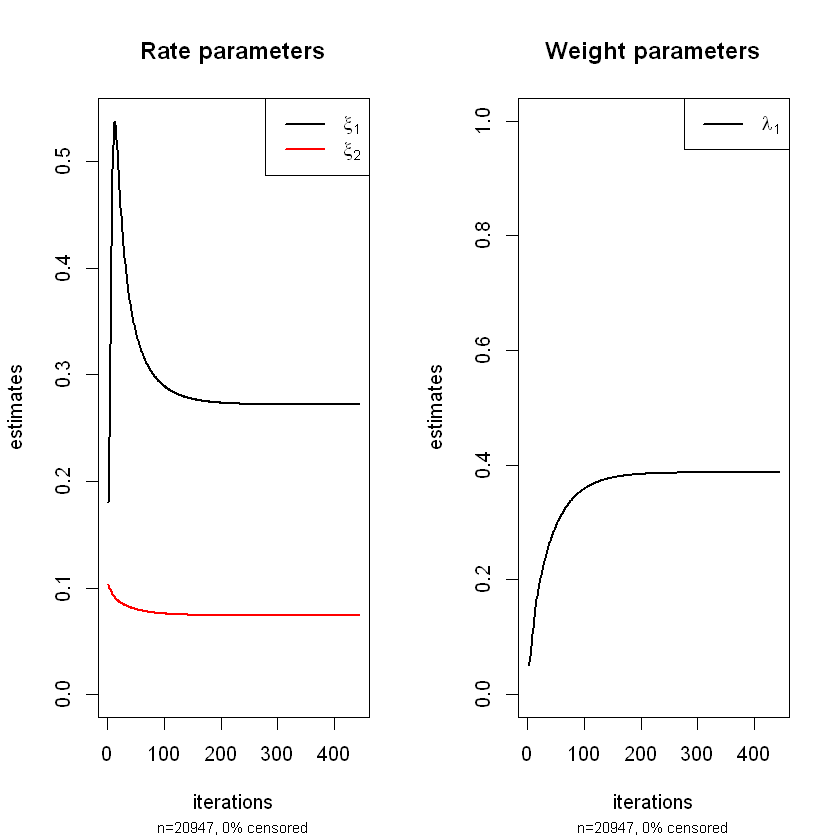

In [712]:
plotexpRMM( fd_ME_Jun3, lwd=2 )

In [713]:
fdME_Jun3_rate1 <- fd_ME_Jun3$rate[[1]]
fdME_Jun3_rate2 <- fd_ME_Jun3$rate[[2]]
fdME_Jun3_lambda <- fd_ME_Jun3$lambda[[1]]
fdME_Jun3_mean1 <- 1.0 / fdME_Jun3_rate1
fdME_Jun3_mean2 <- 1.0 / fdME_Jun3_rate2
fdME_Jun3_mean <- ( (fdME_Jun3_lambda * fdME_Jun3_mean1) + 
                    ( ( 1.0 - fdME_Jun3_lambda) * fdME_Jun3_mean2 ) )
fdME_Jun3_var1 <- 1.0 / (fdME_Jun3_rate1 ^ 2)
fdME_Jun3_var2 <- 1.0 / (fdME_Jun3_rate2 ^ 2)
fdME_Jun3_var <- ( (fdME_Jun3_lambda * ( fdME_Jun3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jun3_lambda) * (fdME_Jun3_mean2 ^ 2) ) + 
                   ( fdME_Jun3_lambda * ( 1.0 - fdME_Jun3_lambda) * 
                       ( fdME_Jun3_mean1 - fdME_Jun3_mean2 )^2 ) )
fdME_Jun3_llike <- fd_ME_Jun3$loglik
cat(" Jun 3 rate1: ", fdME_Jun3_rate1, "\n", 
    "Jun 3 rate2: ", fdME_Jun3_rate2, "\n",
    "Jun 3 lambda: ", fdME_Jun3_lambda, "\n",
    "Jun 3 mean1: ", fdME_Jun3_mean1, "\n",
    "Jun 3 mean2: ", fdME_Jun3_mean2, "\n",
    "Jun 3 mean: ", fdME_Jun3_mean, "\n",
    "Jun 3 var1: ", fdME_Jun3_var1, "\n",
    "Jun 3 var2: ", fdME_Jun3_var2, "\n",
    "Jun 3 var: ", fdME_Jun3_var, "\n",
    "Jun 3 loglikelihood: ", fdME_Jun3_llike, "\n" )

 Jun 3 rate1:  0.2719961 
 Jun 3 rate2:  0.07410041 
 Jun 3 lambda:  0.3873013 
 Jun 3 mean1:  3.676523 
 Jun 3 mean2:  13.4952 
 Jun 3 mean:  9.692415 
 Jun 3 var1:  13.51682 
 Jun 3 var2:  182.1205 
 Jun 3 var:  139.6972 
 Jun 3 loglikelihood:  -67916.48 


In [714]:
tvals <- rexpmix(length(dfJun3$Precip_mm), fd_ME_Jun3$lambda, fd_ME_Jun3$rate )

In [715]:
ksRes <- ks.test( dfJun3$Precip_mm, tvals )

Warning message in ks.test(dfJun3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [716]:
fdME_Jun3_KSStat <- ksRes$statistic
fdME_Jun3_KSp <- ksRes$p.value
cat(" Jun 3 K-S stat: ", fdME_Jun3_KSStat, "\n",
    "Jun 3 K-S p-value: ", fdME_Jun3_KSp )

 Jun 3 K-S stat:  0.03122165 
 Jun 3 K-S p-value:  2.711361e-09

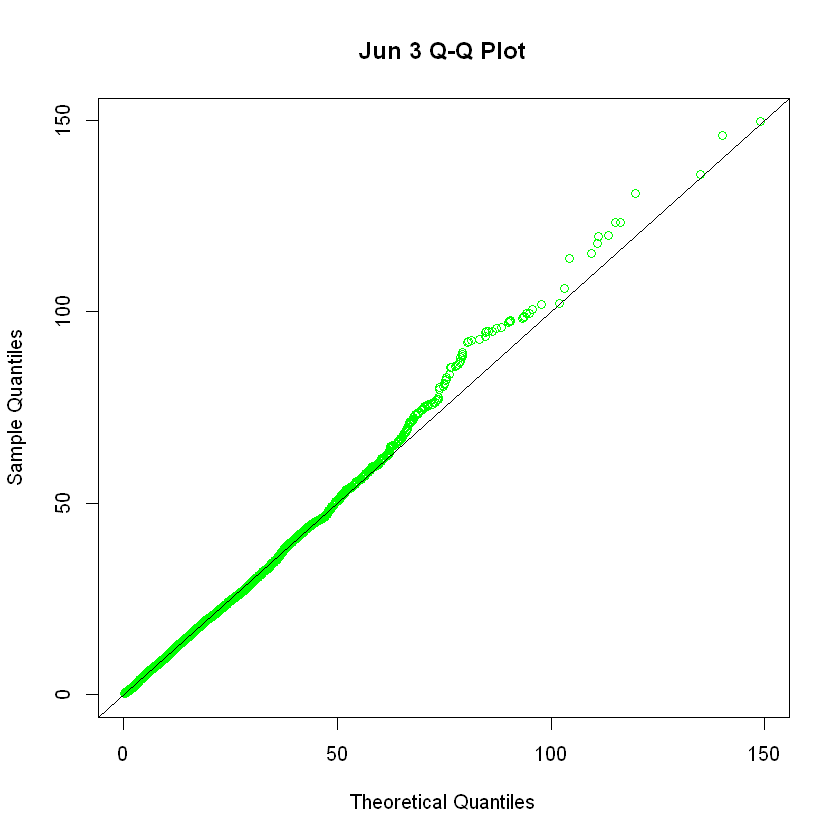

In [717]:
wJun3Max <- max( max( dfJun3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJun3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jun 3 Q-Q Plot",
        xlim=c(0,wJun3Max), ylim=c(0,wJun3Max) )
abline( 0, 1)

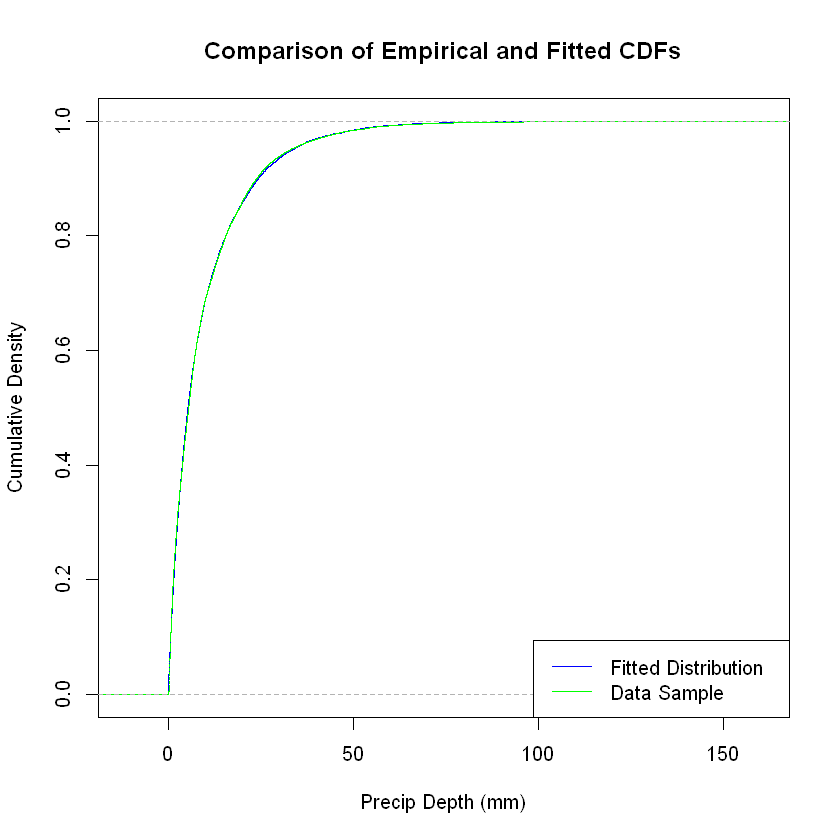

In [718]:
x <- seq(0,wJun3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJun3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [719]:
MonDistDF[29, ] <- list( 6, 3, fdGM_Jun3_shape, fdGM_Jun3_rate, fdGM_Jun3_llike, fdGM_Jun3_mean,
                        fdGM_Jun3_var, fdGM_Jun3_KSStat, fdGM_Jun3_KSp, fdME_Jun3_rate1,
                        fdME_Jun3_rate2, fdME_Jun3_lambda, fdME_Jun3_mean1, fdME_Jun3_mean2,
                        fdME_Jun3_mean, fdME_Jun3_var1, fdME_Jun3_var2, fdME_Jun3_var,
                        fdME_Jun3_llike, fdME_Jun3_KSStat, fdME_Jun3_KSp )

#### Region 4

**Gamma**

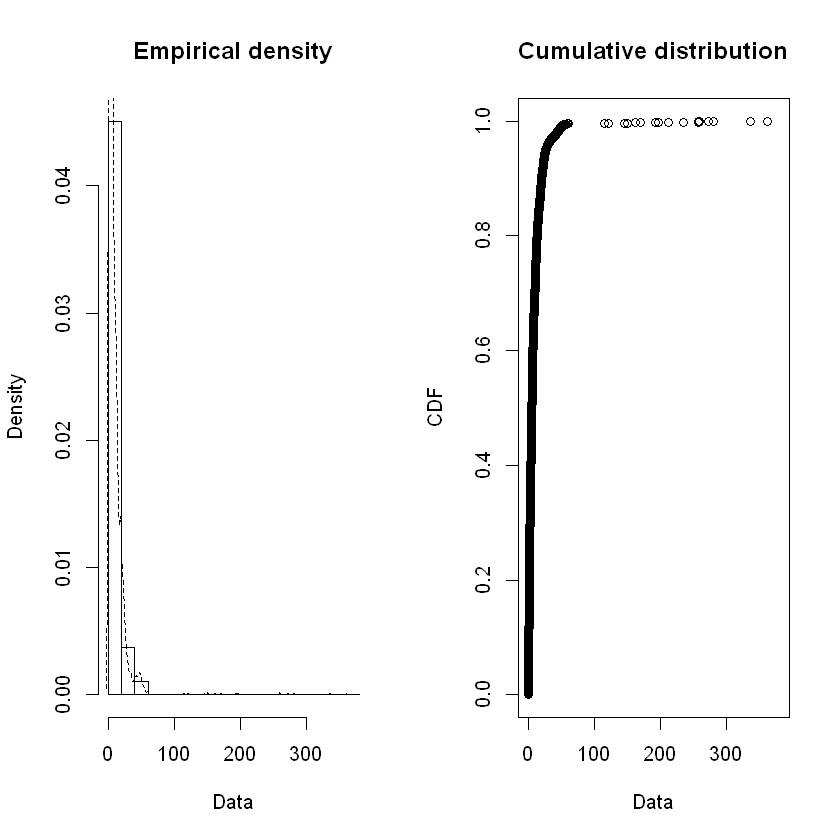

In [720]:
plotdist( dfJun4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  361.53 
median:  5.265 
mean:  9.080176 
estimated sd:  16.68298 
estimated skewness:  10.73878 
estimated kurtosis:  169.3999 

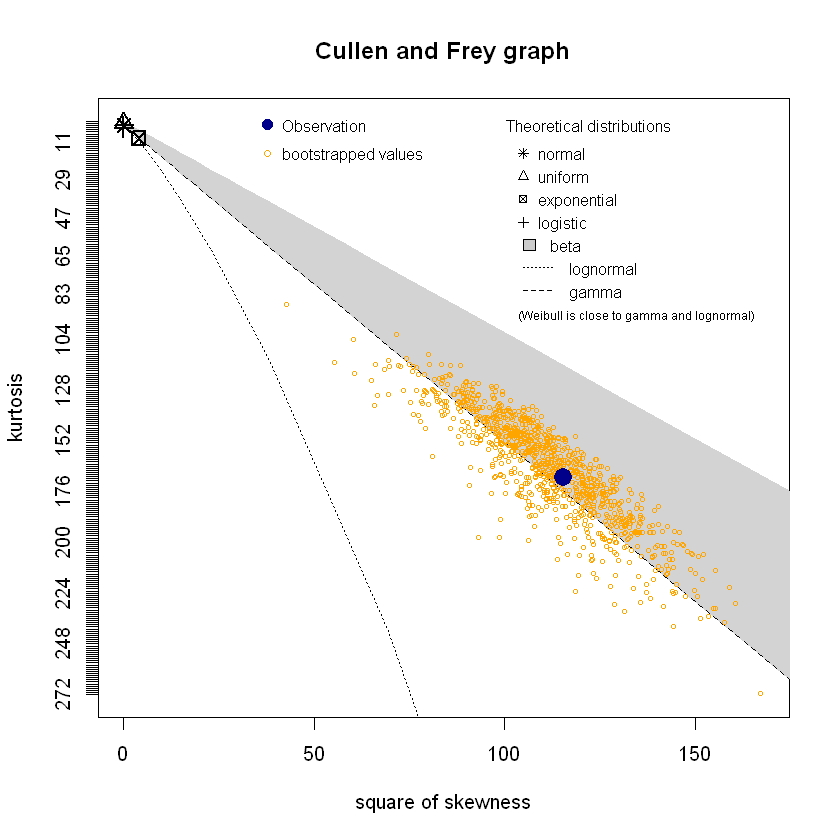

In [721]:
descdist( dfJun4$Precip_mm, boot=1000 )

In [722]:
fd_GM_Jun4 <- fitdist( dfJun4$Precip_mm, "gamma" )

In [723]:
summary( fd_GM_Jun4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.83412395 0.015342428
rate  0.09187506 0.002266357
Loglikelihood:  -14164.74   AIC:  28333.48   BIC:  28346.27 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7454989
rate  0.7454989 1.0000000


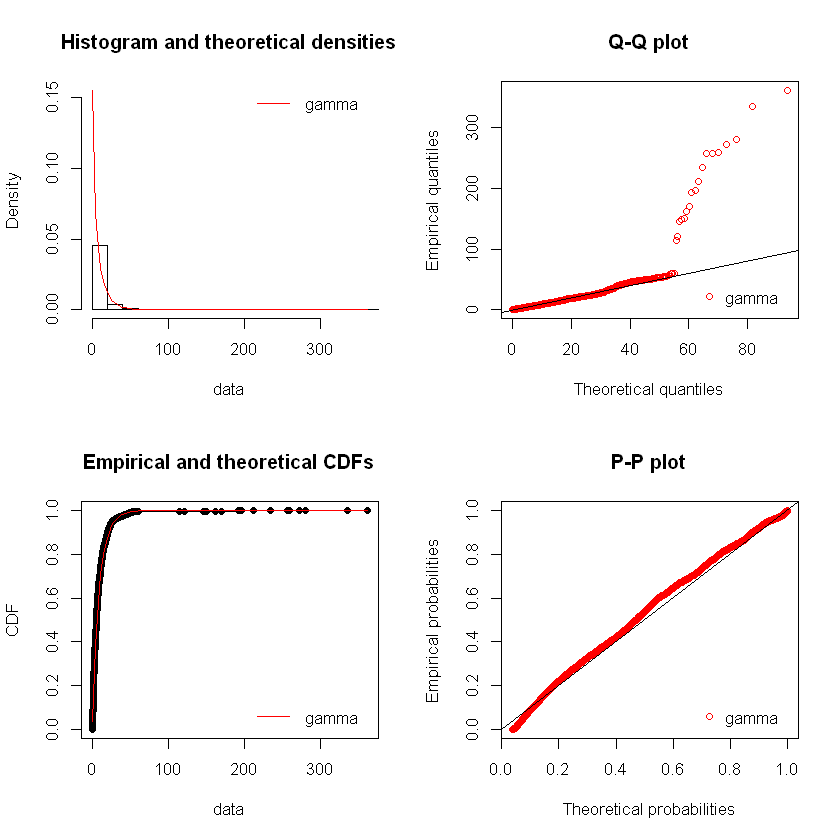

In [724]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jun4)
qqcomp(fd_GM_Jun4)
cdfcomp(fd_GM_Jun4)
ppcomp(fd_GM_Jun4)

In [725]:
fdGM_Jun4_shape <- fd_GM_Jun4$estimate[["shape"]]
fdGM_Jun4_rate <- fd_GM_Jun4$estimate[["rate"]]
fdGM_Jun4_llike <- fd_GM_Jun4$loglik
fdGM_Jun4_mean <- fdGM_Jun4_shape / fdGM_Jun4_rate
fdGM_Jun4_var <- fdGM_Jun4_shape / ( fdGM_Jun4_rate ^ 2 )
cat(" Jun 4 shape: ", fdGM_Jun4_shape, "\n", "Jun 4 rate: ", fdGM_Jun4_rate, 
    "\n", "Jun 4 loglikelihood: ", fdGM_Jun4_llike, "\n", 
    "Jun 4 mean: ", fdGM_Jun4_mean, "\n",
    "Jun 4 variance: ", fdGM_Jun4_var, "\n" )

 Jun 4 shape:  0.834124 
 Jun 4 rate:  0.09187506 
 Jun 4 loglikelihood:  -14164.74 
 Jun 4 mean:  9.078894 
 Jun 4 variance:  98.81783 


In [726]:
statRes <- gofstat( fd_GM_Jun4, fitnames=c("Gamma") )

In [727]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05166901
Cramer-von Mises statistic    3.66618634
Anderson-Darling statistic   25.14751186

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 28333.48
Bayesian Information Criterion 28346.27


In [728]:
ksRes <- ks.test( dfJun4$Precip_mm, "pgamma", shape=fdGM_Jun4_shape, rate=fdGM_Jun4_rate )

Warning message in ks.test(dfJun4$Precip_mm, "pgamma", shape = fdGM_Jun4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [729]:
fdGM_Jun4_KSStat <- ksRes$statistic
fdGM_Jun4_KSp <- ksRes$p.value
cat(" Jun 4 K-S stat: ", fdGM_Jun4_KSStat, "\n",
    "Jun 4 K-S p-value: ", fdGM_Jun4_KSp )

 Jun 4 K-S stat:  0.05166901 
 Jun 4 K-S p-value:  1.045211e-10

**Mixed exponential**

In [730]:
fd_ME_Jun4 <- expRMM_EM( dfJun4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJun4$Precip_mm), 1.0/mean(dfJun4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 263 


In [731]:
summary( fd_ME_Jun4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.987114 0.0128857
rate   0.124857 0.0109738
loglik at estimate:  -13948.05 
0 % of the data right censored


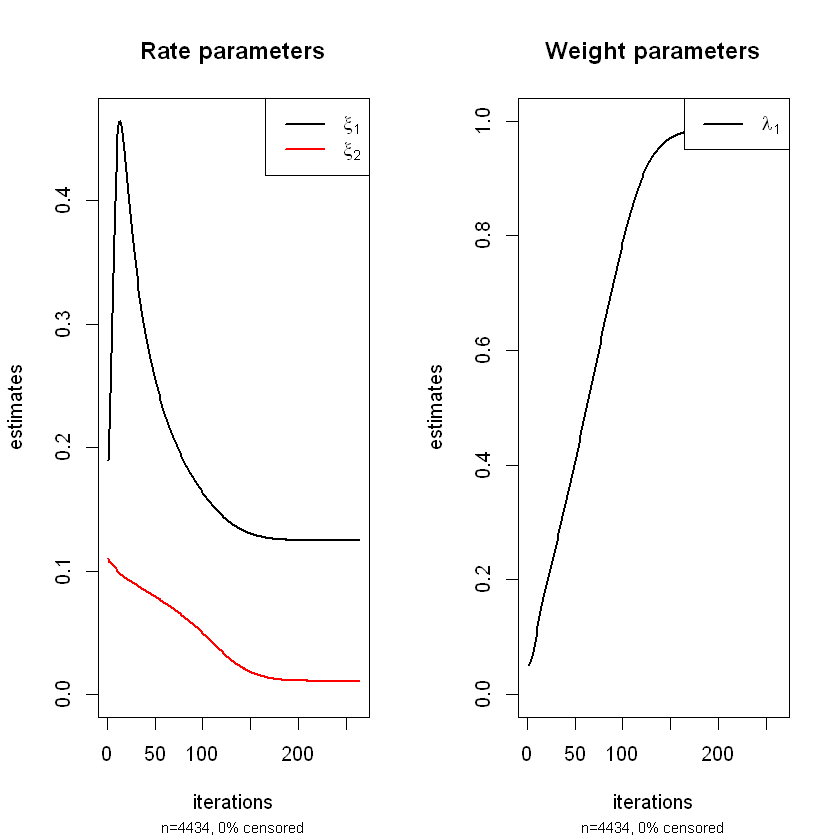

In [732]:
plotexpRMM( fd_ME_Jun4, lwd=2 )

In [733]:
fdME_Jun4_rate1 <- fd_ME_Jun4$rate[[1]]
fdME_Jun4_rate2 <- fd_ME_Jun4$rate[[2]]
fdME_Jun4_lambda <- fd_ME_Jun4$lambda[[1]]
fdME_Jun4_mean1 <- 1.0 / fdME_Jun4_rate1
fdME_Jun4_mean2 <- 1.0 / fdME_Jun4_rate2
fdME_Jun4_mean <- ( (fdME_Jun4_lambda * fdME_Jun4_mean1) + 
                    ( ( 1.0 - fdME_Jun4_lambda) * fdME_Jun4_mean2 ) )
fdME_Jun4_var1 <- 1.0 / (fdME_Jun4_rate1 ^ 2)
fdME_Jun4_var2 <- 1.0 / (fdME_Jun4_rate2 ^ 2)
fdME_Jun4_var <- ( (fdME_Jun4_lambda * ( fdME_Jun4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jun4_lambda) * (fdME_Jun4_mean2 ^ 2) ) + 
                   ( fdME_Jun4_lambda * ( 1.0 - fdME_Jun4_lambda) * 
                       ( fdME_Jun4_mean1 - fdME_Jun4_mean2 )^2 ) )
fdME_Jun4_llike <- fd_ME_Jun4$loglik
cat(" Jun 4 rate1: ", fdME_Jun4_rate1, "\n", 
    "Jun 4 rate2: ", fdME_Jun4_rate2, "\n",
    "Jun 4 lambda: ", fdME_Jun4_lambda, "\n",
    "Jun 4 mean1: ", fdME_Jun4_mean1, "\n",
    "Jun 4 mean2: ", fdME_Jun4_mean2, "\n",
    "Jun 4 mean: ", fdME_Jun4_mean, "\n",
    "Jun 4 var1: ", fdME_Jun4_var1, "\n",
    "Jun 4 var2: ", fdME_Jun4_var2, "\n",
    "Jun 4 var: ", fdME_Jun4_var, "\n",
    "Jun 4 loglikelihood: ", fdME_Jun4_llike, "\n" )

 Jun 4 rate1:  0.1248571 
 Jun 4 rate2:  0.01097379 
 Jun 4 lambda:  0.9871143 
 Jun 4 mean1:  8.009154 
 Jun 4 mean2:  91.12621 
 Jun 4 mean:  9.080176 
 Jun 4 var1:  64.14654 
 Jun 4 var2:  8303.986 
 Jun 4 var:  258.1959 
 Jun 4 loglikelihood:  -13948.05 


In [734]:
tvals <- rexpmix(length(dfJun4$Precip_mm), fd_ME_Jun4$lambda, fd_ME_Jun4$rate )

In [735]:
ksRes <- ks.test( dfJun4$Precip_mm, tvals )

Warning message in ks.test(dfJun4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [736]:
fdME_Jun4_KSStat <- ksRes$statistic
fdME_Jun4_KSp <- ksRes$p.value
cat(" Jun 4 K-S stat: ", fdME_Jun4_KSStat, "\n",
    "Jun 4 K-S p-value: ", fdME_Jun4_KSp )

 Jun 4 K-S stat:  0.04894001 
 Jun 4 K-S p-value:  4.884616e-05

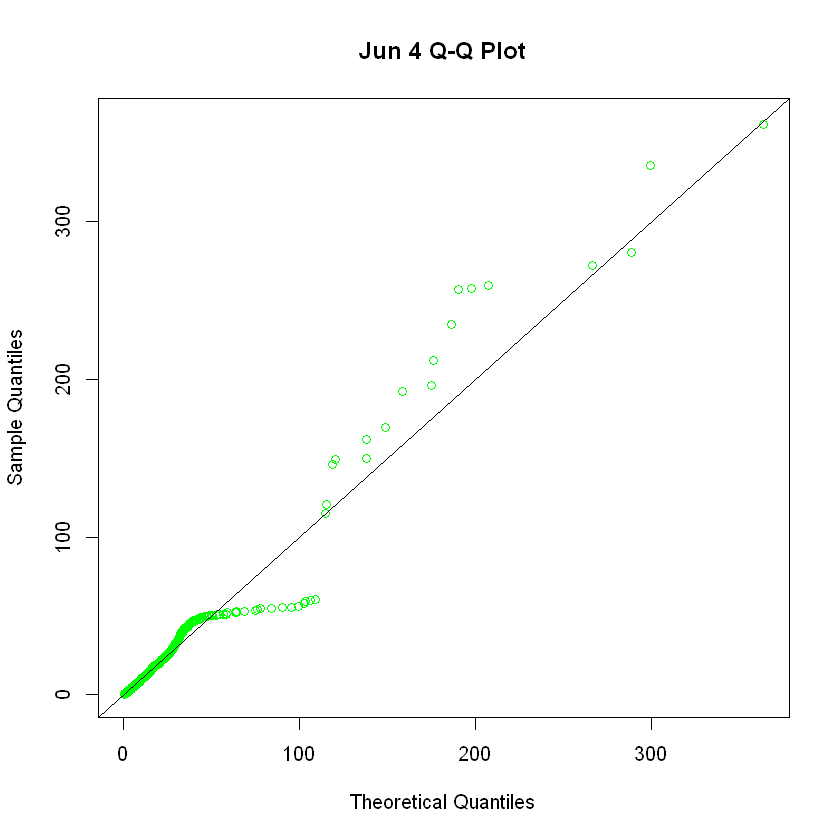

In [737]:
wJun4Max <- max( max( dfJun4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJun4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jun 4 Q-Q Plot",
        xlim=c(0,wJun4Max), ylim=c(0,wJun4Max) )
abline( 0, 1)

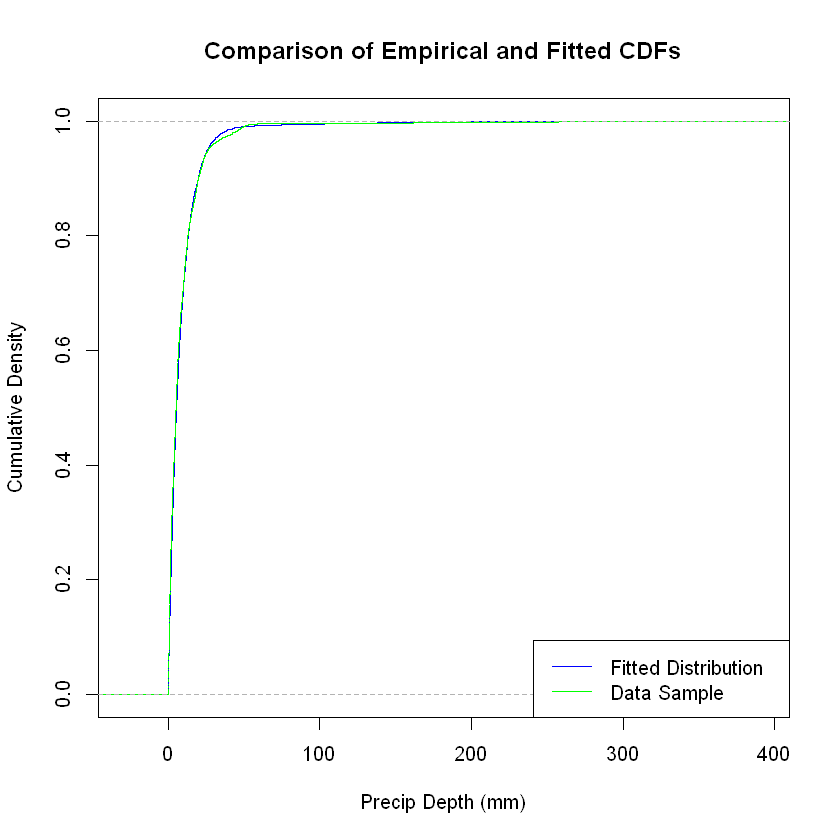

In [738]:
x <- seq(0,wJun4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJun4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [739]:
MonDistDF[30, ] <- list( 6, 4, fdGM_Jun4_shape, fdGM_Jun4_rate, fdGM_Jun4_llike, fdGM_Jun4_mean,
                        fdGM_Jun4_var, fdGM_Jun4_KSStat, fdGM_Jun4_KSp, fdME_Jun4_rate1,
                        fdME_Jun4_rate2, fdME_Jun4_lambda, fdME_Jun4_mean1, fdME_Jun4_mean2,
                        fdME_Jun4_mean, fdME_Jun4_var1, fdME_Jun4_var2, fdME_Jun4_var,
                        fdME_Jun4_llike, fdME_Jun4_KSStat, fdME_Jun4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

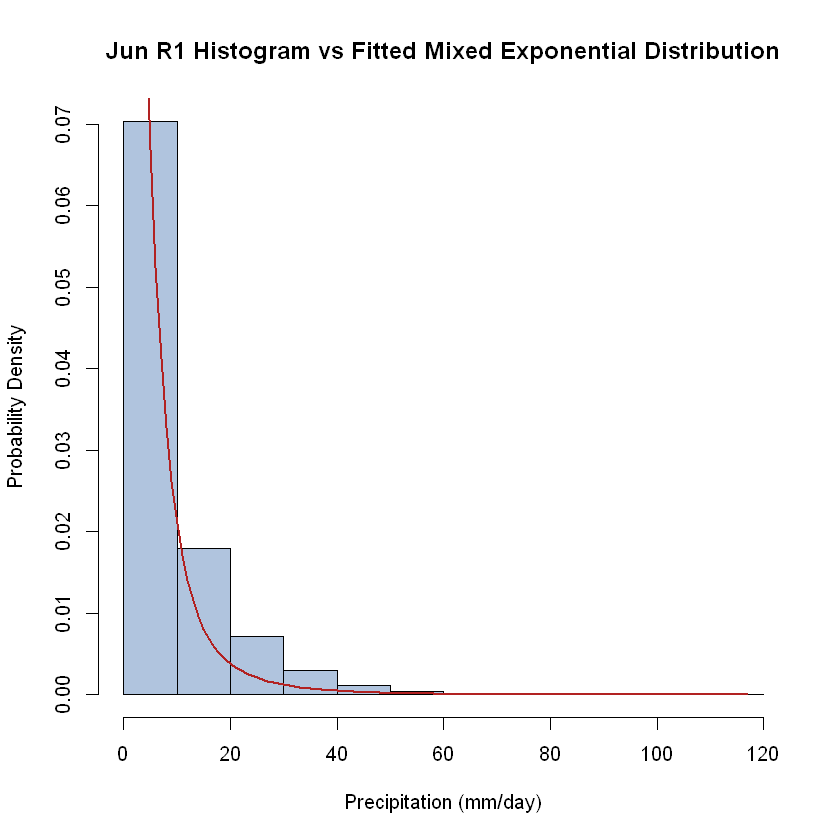

In [740]:
xVals <- seq(1, wJun1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jun1_lambda, spec1="exp", arg1=list(rate=fdME_Jun1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jun1_rate2) )
hist( dfJun1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jun R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

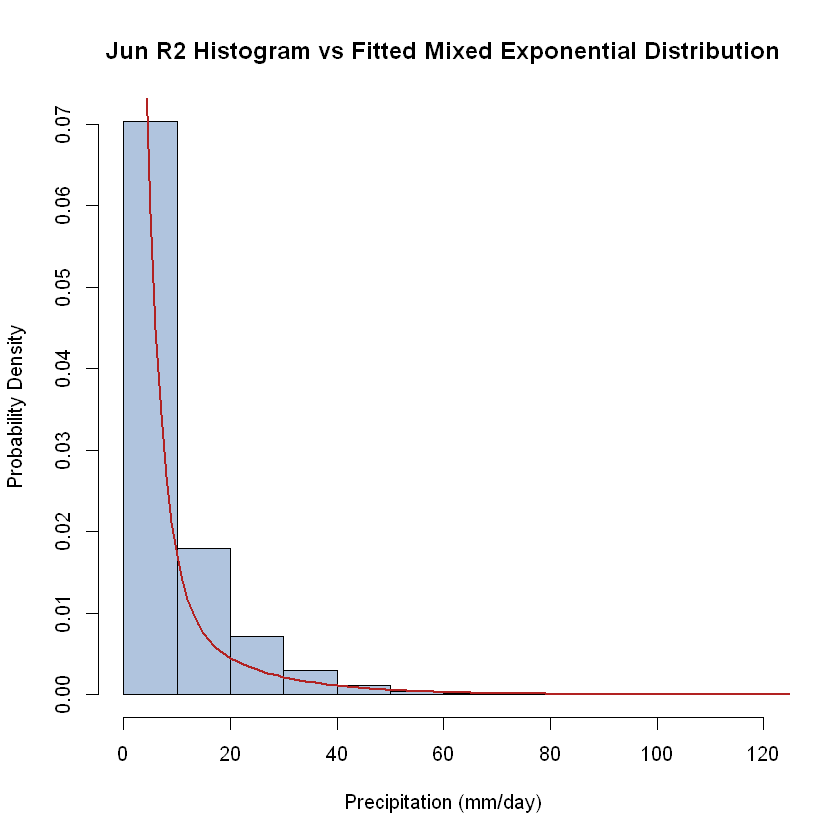

In [741]:
xVals <- seq(1, wJun2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jun2_lambda, spec1="exp", arg1=list(rate=fdME_Jun2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jun2_rate2) )
hist( dfJun1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jun R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

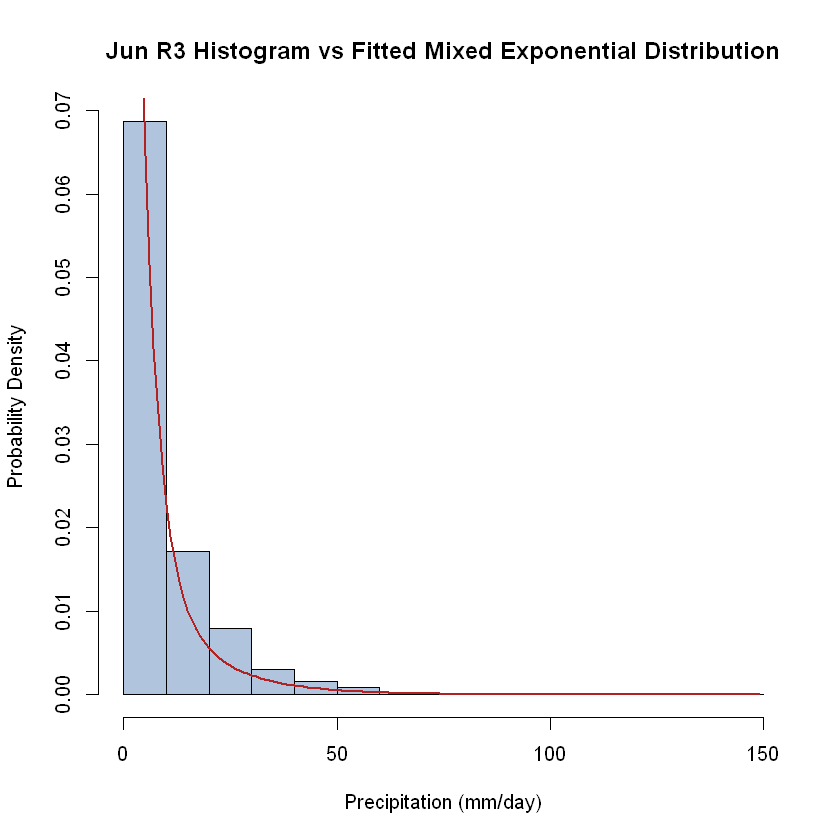

In [742]:
xVals <- seq(1, wJun3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jun3_lambda, spec1="exp", arg1=list(rate=fdME_Jun3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jun3_rate2) )
hist( dfJun3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jun R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

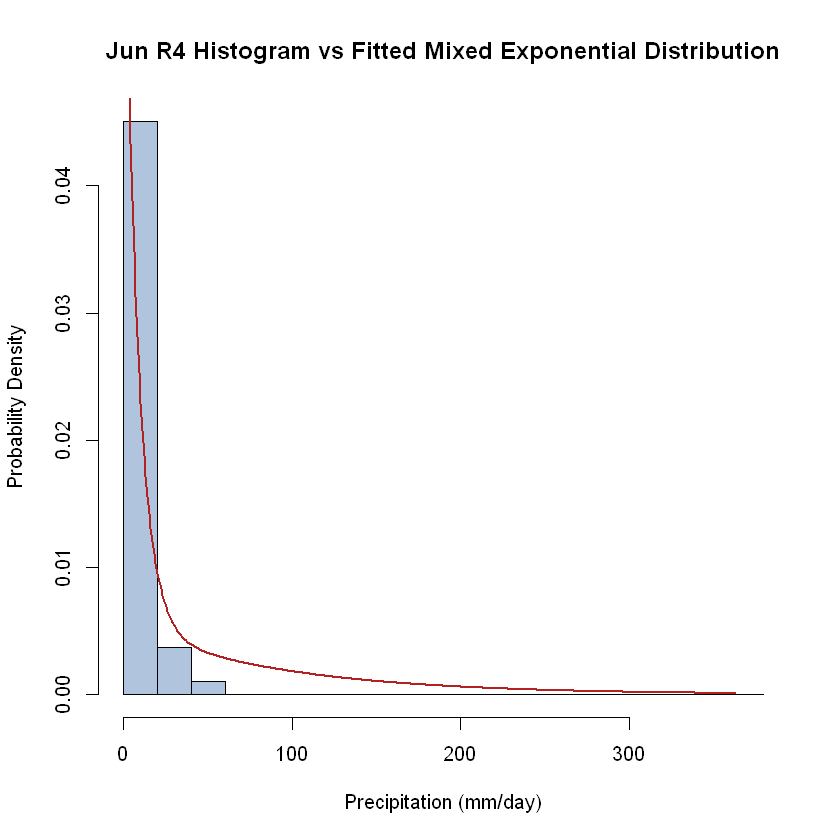

In [743]:
xVals <- seq(1, wJun4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jun4_lambda, spec1="exp", arg1=list(rate=fdME_Jun4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jun4_rate2) )
hist( dfJun4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jun R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Jul

#### All

**Gamma**

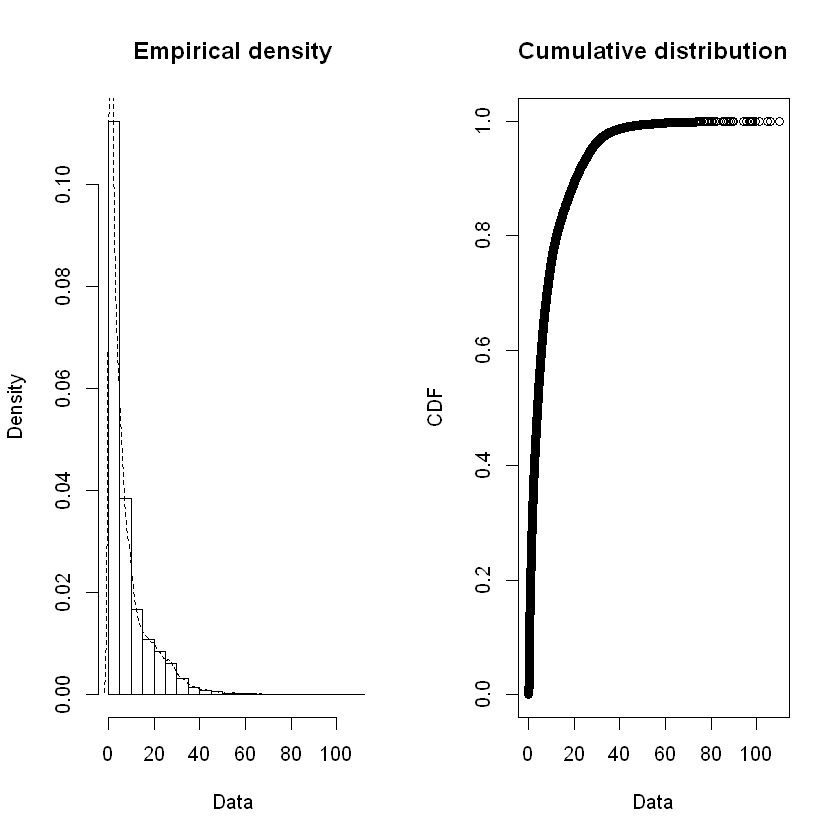

In [744]:
plotdist( dfJul$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  109.88 
median:  4 
mean:  7.659098 
estimated sd:  9.704718 
estimated skewness:  2.583713 
estimated kurtosis:  13.20165 

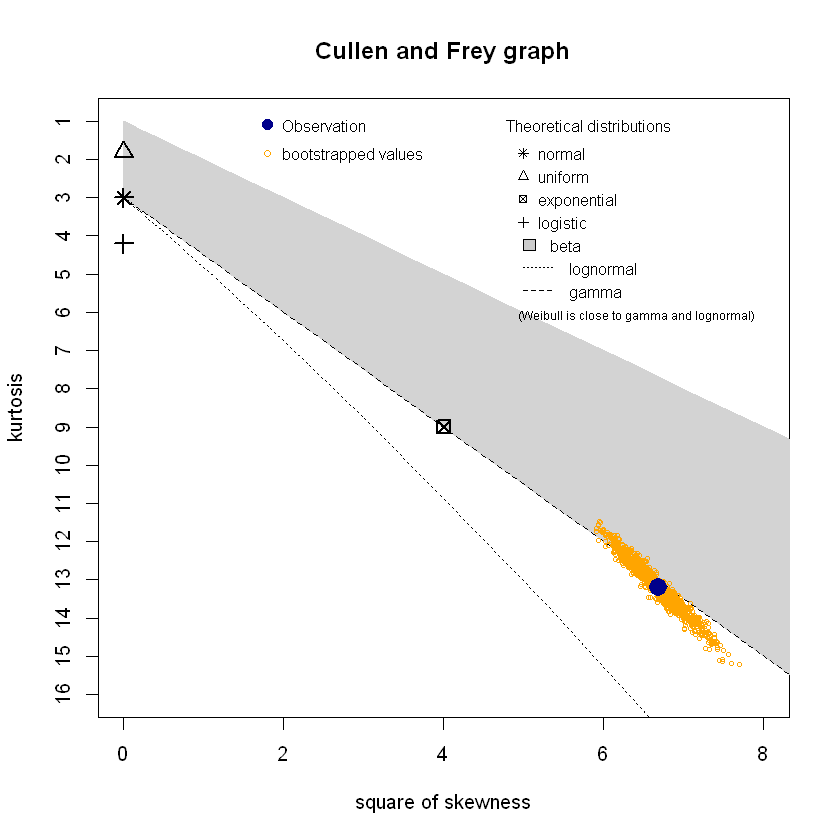

In [745]:
descdist( dfJul$Precip_mm, boot=1000 )

In [746]:
fd_GM_JulA <- fitdist( dfJul$Precip_mm, "gamma" )

In [747]:
summary( fd_GM_JulA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
shape 0.7877278 0.0050828401
rate  0.1028341 0.0009036752
Loglikelihood:  -107501.5   AIC:  215007   BIC:  215023.9 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7341529
rate  0.7341529 1.0000000


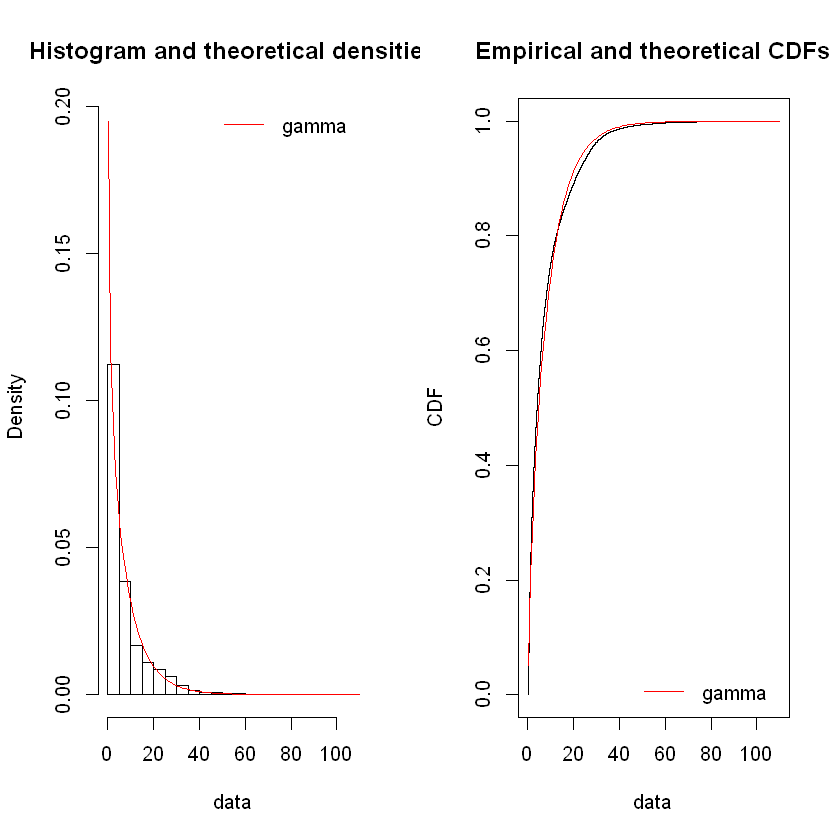

In [748]:
par(mfrow = c(1, 2))
denscomp(fd_GM_JulA)
#qqcomp(fd_GM_JulA)
cdfcomp(fd_GM_JulA)
#ppcomp(fd_GM_JulA)

In [749]:
fdGM_JulA_shape <- fd_GM_JulA$estimate[["shape"]]
fdGM_JulA_rate <- fd_GM_JulA$estimate[["rate"]]
fdGM_JulA_llike <- fd_GM_JulA$loglik
fdGM_JulA_mean <- fdGM_JulA_shape / fdGM_JulA_rate
fdGM_JulA_var <- fdGM_JulA_shape / ( fdGM_JulA_rate ^ 2 )
cat(" Jul A shape: ", fdGM_JulA_shape, "\n", "Jul A rate: ", fdGM_JulA_rate, 
    "\n", "Jul A loglikelihood: ", fdGM_JulA_llike, "\n", 
    "Jul A mean: ", fdGM_JulA_mean, "\n",
    "Jul A variance: ", fdGM_JulA_var, "\n" )

 Jul A shape:  0.7877278 
 Jul A rate:  0.1028341 
 Jul A loglikelihood:  -107501.5 
 Jul A mean:  7.660182 
 Jul A variance:  74.4907 


In [750]:
statRes <- gofstat( fd_GM_JulA, fitnames=c("Gamma") )

In [751]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.05594532
Cramer-von Mises statistic    47.22521966
Anderson-Darling statistic   297.05196032

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 215007.0
Bayesian Information Criterion 215023.9


In [752]:
ksRes <- ks.test( dfJul$Precip_mm, "pgamma", shape=fdGM_JulA_shape, rate=fdGM_JulA_rate )

Warning message in ks.test(dfJul$Precip_mm, "pgamma", shape = fdGM_JulA_shape, rate = fdGM_JulA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [753]:
fdGM_JulA_KSStat <- ksRes$statistic
fdGM_JulA_KSp <- ksRes$p.value
cat(" Jul A K-S stat: ", fdGM_JulA_KSStat, "\n",
    "Jul A K-S p-value: ", fdGM_JulA_KSp )

 Jul A K-S stat:  0.05594532 
 Jul A K-S p-value:  0

**Mixed Exponential**

In [754]:
fd_ME_JulA <- expRMM_EM( dfJul$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfJul$Precip_mm), 1.0/mean(dfJul$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 224 


In [755]:
summary( fd_ME_JulA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.399052 0.6009478
rate   0.420073 0.0895715
loglik at estimate:  -106442.5 
0 % of the data right censored


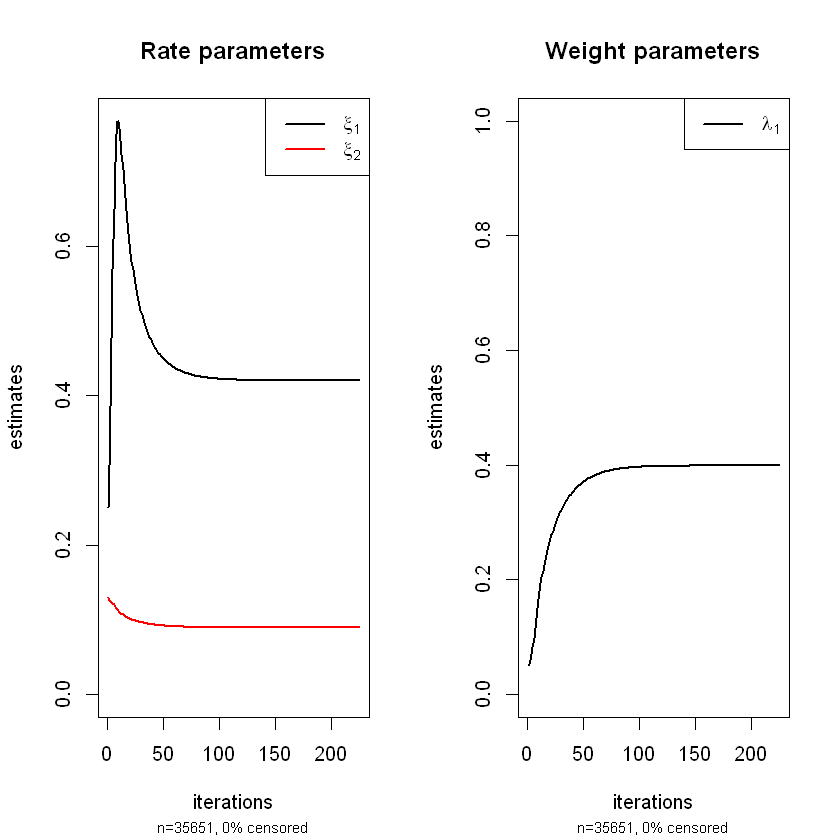

In [756]:
plotexpRMM( fd_ME_JulA, lwd=2 )

In [757]:
fdME_JulA_rate1 <- fd_ME_JulA$rate[[1]]
fdME_JulA_rate2 <- fd_ME_JulA$rate[[2]]
fdME_JulA_lambda <- fd_ME_JulA$lambda[[1]]
fdME_JulA_mean1 <- 1.0 / fdME_JulA_rate1
fdME_JulA_mean2 <- 1.0 / fdME_JulA_rate2
fdME_JulA_mean <- ( (fdME_JulA_lambda * fdME_JulA_mean1) + 
                    ( ( 1.0 - fdME_JulA_lambda) * fdME_JulA_mean2 ) )
fdME_JulA_var1 <- 1.0 / (fdME_JulA_rate1 ^ 2)
fdME_JulA_var2 <- 1.0 / (fdME_JulA_rate2 ^ 2)
fdME_JulA_var <- ( (fdME_JulA_lambda * ( fdME_JulA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_JulA_lambda) * (fdME_JulA_mean2 ^ 2) ) + 
                   ( fdME_JulA_lambda * ( 1.0 - fdME_JulA_lambda) * 
                       ( fdME_JulA_mean1 - fdME_JulA_mean2 )^2 ) )
fdME_JulA_llike <- fd_ME_JulA$loglik
cat(" Jul A rate1: ", fdME_JulA_rate1, "\n", 
    "Jul A rate2: ", fdME_JulA_rate2, "\n",
    "Jul A lambda: ", fdME_JulA_lambda, "\n",
    "Jul A mean1: ", fdME_JulA_mean1, "\n",
    "Jul A mean2: ", fdME_JulA_mean2, "\n",
    "Jul A mean: ", fdME_JulA_mean, "\n",
    "Jul A var1: ", fdME_JulA_var1, "\n",
    "Jul A var2: ", fdME_JulA_var2, "\n",
    "Jul A var: ", fdME_JulA_var, "\n",
    "Jul A loglikelihood: ", fdME_JulA_llike, "\n" )

 Jul A rate1:  0.4200725 
 Jul A rate2:  0.08957154 
 Jul A lambda:  0.3990522 
 Jul A mean1:  2.380541 
 Jul A mean2:  11.16426 
 Jul A mean:  7.659098 
 Jul A var1:  5.666976 
 Jul A var2:  124.6407 
 Jul A var:  95.66617 
 Jul A loglikelihood:  -106442.5 


In [758]:
tvals <- rexpmix(length(dfJul$Precip_mm), fd_ME_JulA$lambda, fd_ME_JulA$rate )

In [759]:
ksRes <- ks.test( dfJul$Precip_mm, tvals )

Warning message in ks.test(dfJul$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [760]:
fdME_JulA_KSStat <- ksRes$statistic
fdME_JulA_KSp <- ksRes$p.value
cat(" Jul A K-S stat: ", fdME_JulA_KSStat, "\n",
    "Jul A K-S p-value: ", fdME_JulA_KSp )

 Jul A K-S stat:  0.04358924 
 Jul A K-S p-value:  0

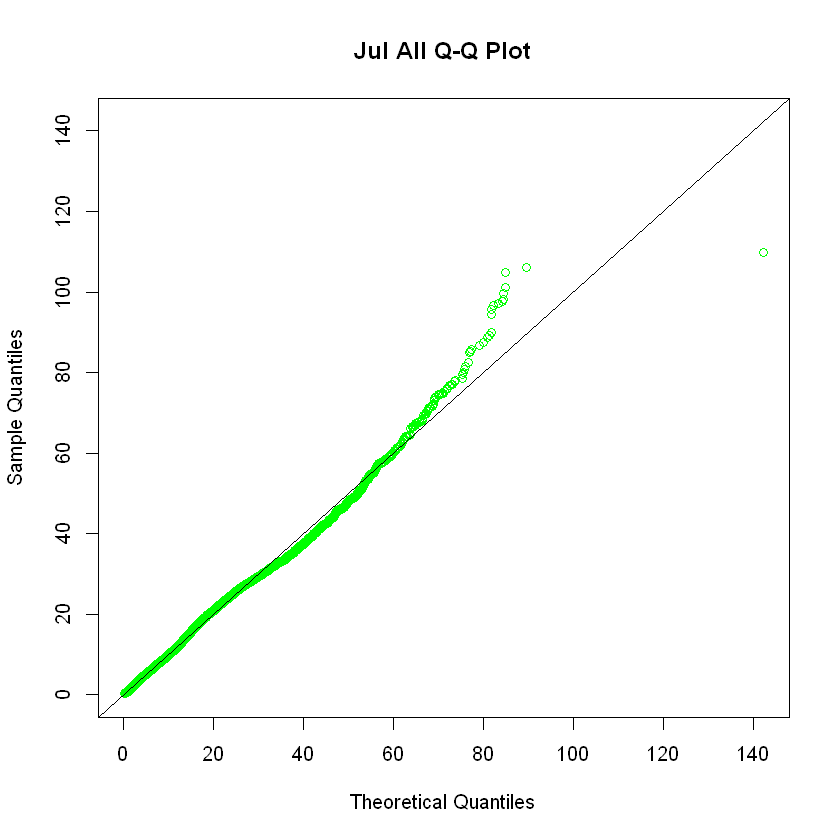

In [761]:
wJulAMax <- max( max( dfJul$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJul$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jul All Q-Q Plot",
        xlim=c(0,wJulAMax), ylim=c(0,wJulAMax) )
abline( 0, 1)

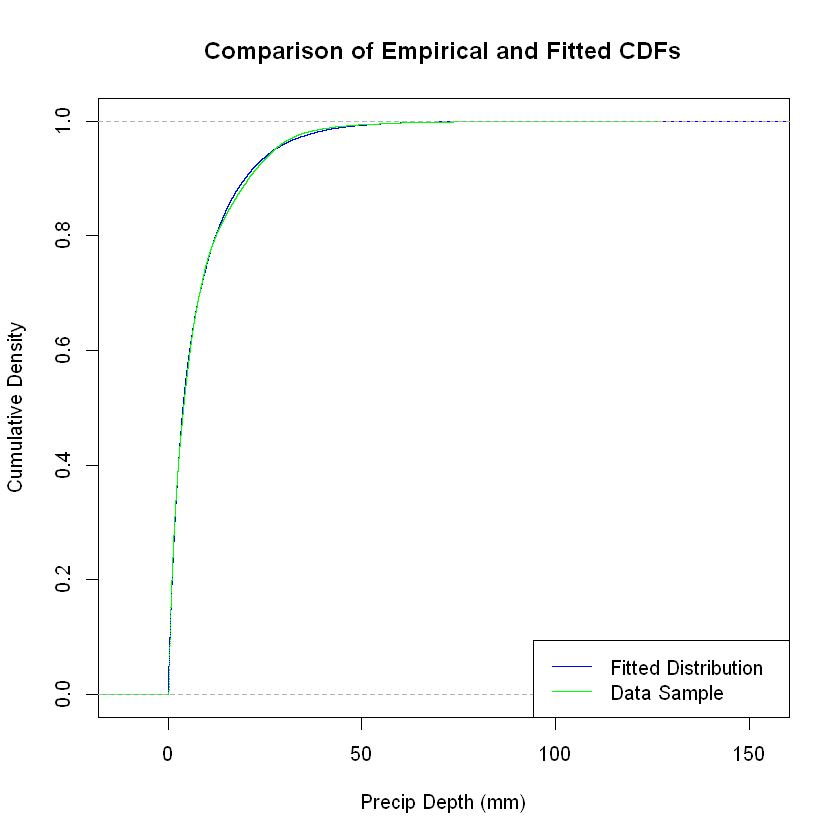

In [762]:
x <- seq(0,wJulAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJul$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [763]:
MonDistDF[31, ] <- list( 7, 0, fdGM_JulA_shape, fdGM_JulA_rate, fdGM_JulA_llike, fdGM_JulA_mean,
                        fdGM_JulA_var, fdGM_JulA_KSStat, fdGM_JulA_KSp, fdME_JulA_rate1,
                        fdME_JulA_rate2, fdME_JulA_lambda, fdME_JulA_mean1, fdME_JulA_mean2,
                        fdME_JulA_mean, fdME_JulA_var1, fdME_JulA_var2, fdME_JulA_var,
                        fdME_JulA_llike, fdME_JulA_KSStat, fdME_JulA_KSp )

#### Region 1

**Gamma**

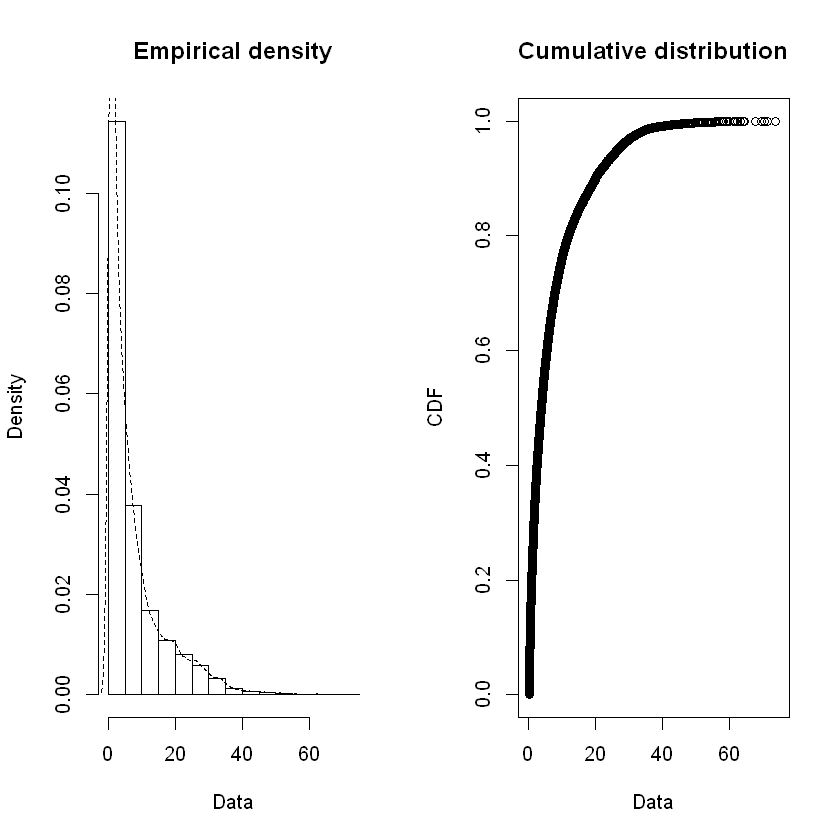

In [764]:
plotdist( dfJul1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  73.7 
median:  3.87 
mean:  7.301704 
estimated sd:  8.835099 
estimated skewness:  2.078458 
estimated kurtosis:  8.187991 

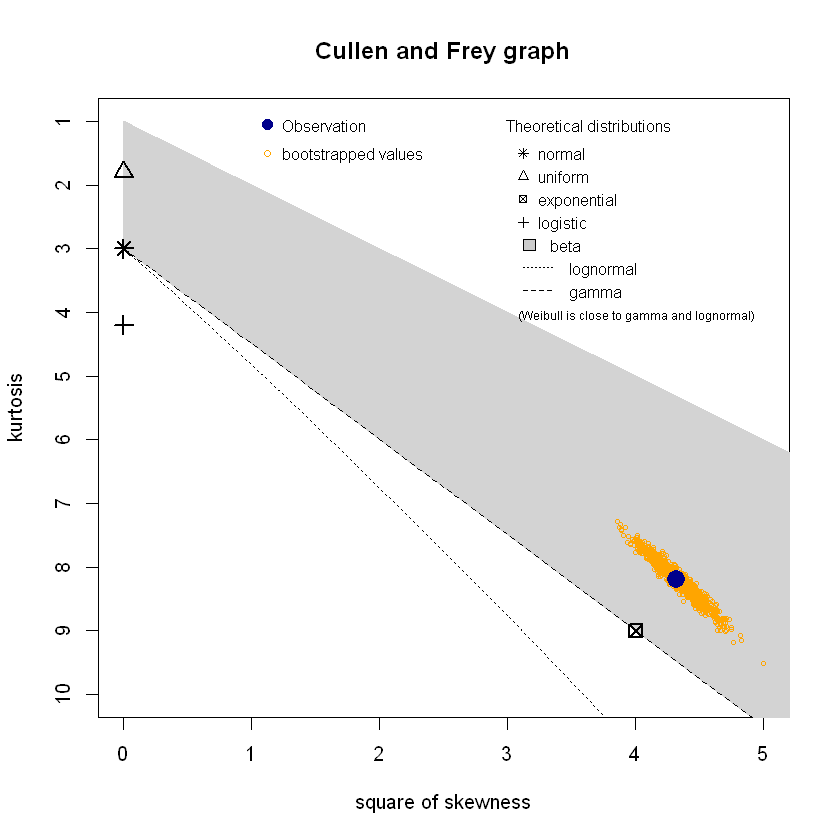

In [765]:
descdist( dfJul1$Precip_mm, boot=1000 )

In [766]:
fd_GM_Jul1 <- fitdist( dfJul1$Precip_mm, "gamma" )

In [767]:
summary( fd_GM_Jul1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8068371 0.007141372
rate  0.1105001 0.001323383
Loglikelihood:  -56557.8   AIC:  113119.6   BIC:  113135.3 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7389481
rate  0.7389481 1.0000000


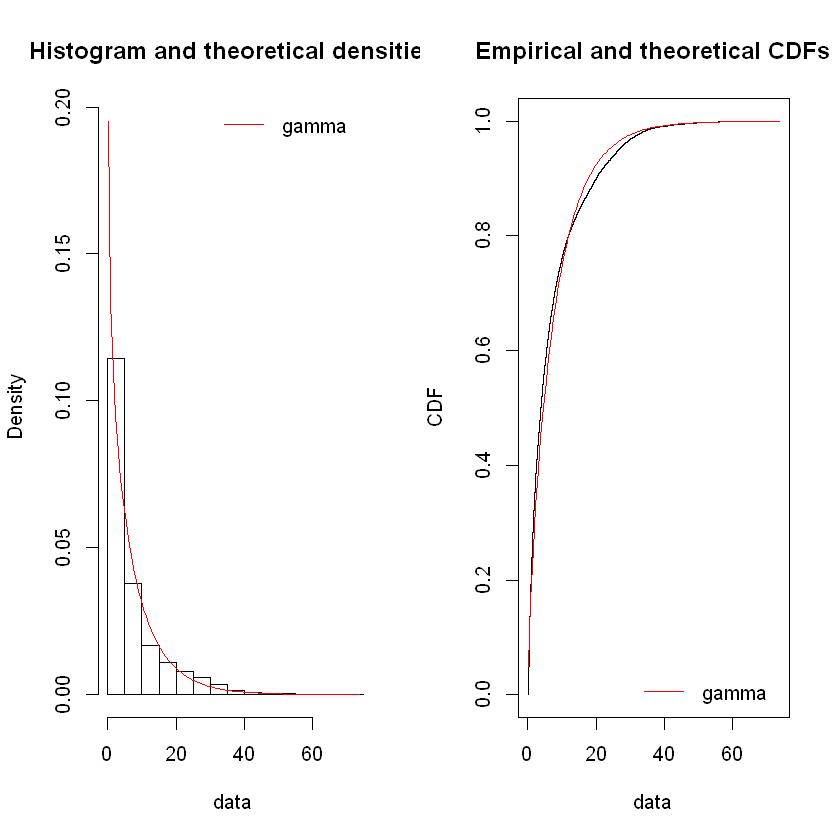

In [768]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Jul1)
#qqcomp(fd_GM_Jul1)
cdfcomp(fd_GM_Jul1)
#ppcomp(fd_GM_Jul1)

In [769]:
fdGM_Jul1_shape <- fd_GM_Jul1$estimate[["shape"]]
fdGM_Jul1_rate <- fd_GM_Jul1$estimate[["rate"]]
fdGM_Jul1_llike <- fd_GM_Jul1$loglik
fdGM_Jul1_mean <- fdGM_Jul1_shape / fdGM_Jul1_rate
fdGM_Jul1_var <- fdGM_Jul1_shape / ( fdGM_Jul1_rate ^ 2 )
cat(" Jul 1 shape: ", fdGM_Jul1_shape, "\n", "Jul 1 rate: ", fdGM_Jul1_rate, 
    "\n", "Jul 1 loglikelihood: ", fdGM_Jul1_llike, "\n", 
    "Jul 1 mean: ", fdGM_Jul1_mean, "\n",
    "Jul 1 variance: ", fdGM_Jul1_var, "\n" )

 Jul 1 shape:  0.8068371 
 Jul 1 rate:  0.1105001 
 Jul 1 loglikelihood:  -56557.8 
 Jul 1 mean:  7.301684 
 Jul 1 variance:  66.0785 


In [770]:
statRes <- gofstat( fd_GM_Jul1, fitnames=c("Gamma") )

In [771]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic   0.057446
Cramer-von Mises statistic    24.566981
Anderson-Darling statistic   156.977177

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 113119.6
Bayesian Information Criterion 113135.3


In [772]:
ksRes <- ks.test( dfJul1$Precip_mm, "pgamma", shape=fdGM_Jul1_shape, rate=fdGM_Jul1_rate )

Warning message in ks.test(dfJul1$Precip_mm, "pgamma", shape = fdGM_Jul1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [773]:
fdGM_Jul1_KSStat <- ksRes$statistic
fdGM_Jul1_KSp <- ksRes$p.value
cat(" Jul 1 K-S stat: ", fdGM_Jul1_KSStat, "\n",
    "Jul 1 K-S p-value: ", fdGM_Jul1_KSp )

 Jul 1 K-S stat:  0.057446 
 Jul 1 K-S p-value:  0

**Mixed exponential**

In [774]:
fd_ME_Jul1 <- expRMM_EM( dfJul1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJul1$Precip_mm), 1.0/mean(dfJul1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 212 


In [775]:
summary( fd_ME_Jul1 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.372687 0.627313
rate   0.448464 0.096947
loglik at estimate:  -56035.69 
0 % of the data right censored


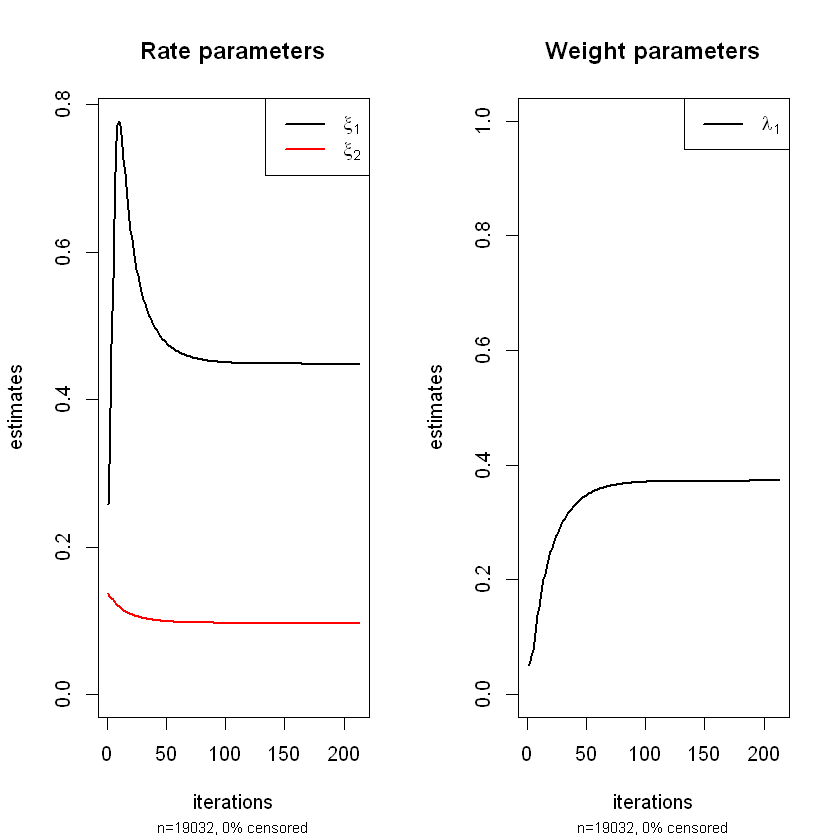

In [776]:
plotexpRMM( fd_ME_Jul1, lwd=2 )

In [777]:
fdME_Jul1_rate1 <- fd_ME_Jul1$rate[[1]]
fdME_Jul1_rate2 <- fd_ME_Jul1$rate[[2]]
fdME_Jul1_lambda <- fd_ME_Jul1$lambda[[1]]
fdME_Jul1_mean1 <- 1.0 / fdME_Jul1_rate1
fdME_Jul1_mean2 <- 1.0 / fdME_Jul1_rate2
fdME_Jul1_mean <- ( (fdME_Jul1_lambda * fdME_Jul1_mean1) + 
                    ( ( 1.0 - fdME_Jul1_lambda) * fdME_Jul1_mean2 ) )
fdME_Jul1_var1 <- 1.0 / (fdME_Jul1_rate1 ^ 2)
fdME_Jul1_var2 <- 1.0 / (fdME_Jul1_rate2 ^ 2)
fdME_Jul1_var <- ( (fdME_Jul1_lambda * ( fdME_Jul1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jul1_lambda) * (fdME_Jul1_mean2 ^ 2) ) + 
                   ( fdME_Jul1_lambda * ( 1.0 - fdME_Jul1_lambda) * 
                       ( fdME_Jul1_mean1 - fdME_Jul1_mean2 )^2 ) )
fdME_Jul1_llike <- fd_ME_Jul1$loglik
cat(" Jul 1 rate1: ", fdME_Jul1_rate1, "\n", 
    "Jul 1 rate2: ", fdME_Jul1_rate2, "\n",
    "Jul 1 lambda: ", fdME_Jul1_lambda, "\n",
    "Jul 1 mean1: ", fdME_Jul1_mean1, "\n",
    "Jul 1 mean2: ", fdME_Jul1_mean2, "\n",
    "Jul 1 mean: ", fdME_Jul1_mean, "\n",
    "Jul 1 var1: ", fdME_Jul1_var1, "\n",
    "Jul 1 var2: ", fdME_Jul1_var2, "\n",
    "Jul 1 var: ", fdME_Jul1_var, "\n",
    "Jul 1 loglikelihood: ", fdME_Jul1_llike, "\n" )

 Jul 1 rate1:  0.4484639 
 Jul 1 rate2:  0.09694704 
 Jul 1 lambda:  0.3726874 
 Jul 1 mean1:  2.229834 
 Jul 1 mean2:  10.31491 
 Jul 1 mean:  7.301704 
 Jul 1 var1:  4.97216 
 Jul 1 var2:  106.3974 
 Jul 1 var:  83.88007 
 Jul 1 loglikelihood:  -56035.69 


In [778]:
tvals <- rexpmix(length(dfJul1$Precip_mm), fd_ME_Jul1$lambda, fd_ME_Jul1$rate )

In [779]:
ksRes <- ks.test( dfJul1$Precip_mm, tvals )

Warning message in ks.test(dfJul1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [780]:
fdME_Jul1_KSStat <- ksRes$statistic
fdME_Jul1_KSp <- ksRes$p.value
cat(" Jul 1 K-S stat: ", fdME_Jul1_KSStat, "\n",
    "Jul 1 K-S p-value: ", fdME_Jul1_KSp )

 Jul 1 K-S stat:  0.04497688 
 Jul 1 K-S p-value:  0

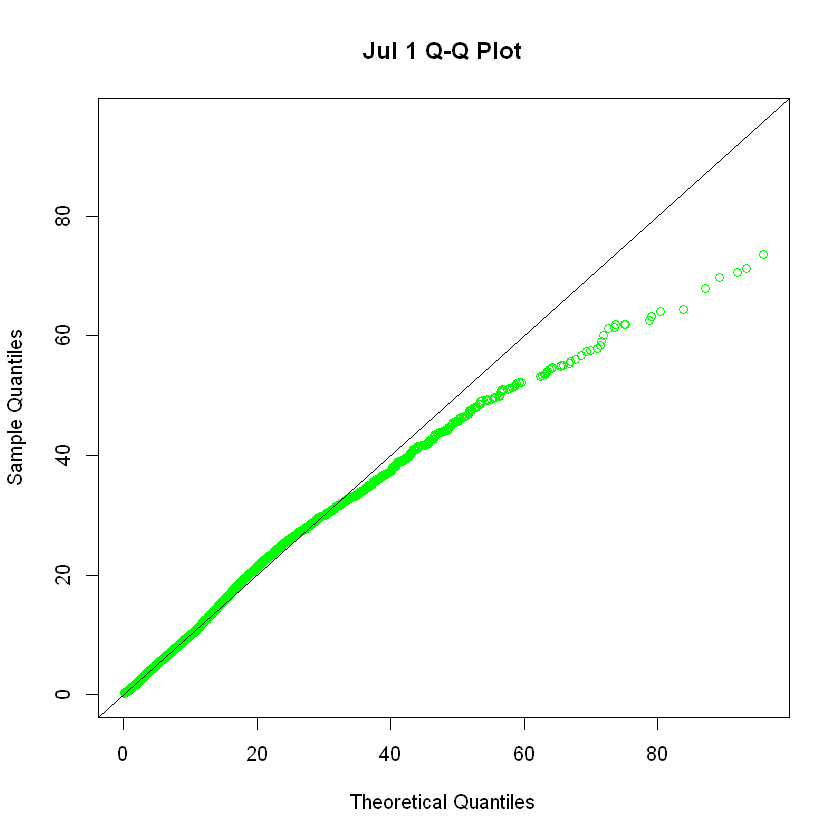

In [781]:
wJul1Max <- max( max( dfJul1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJul1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jul 1 Q-Q Plot",
        xlim=c(0,wJul1Max), ylim=c(0,wJul1Max) )
abline( 0, 1)

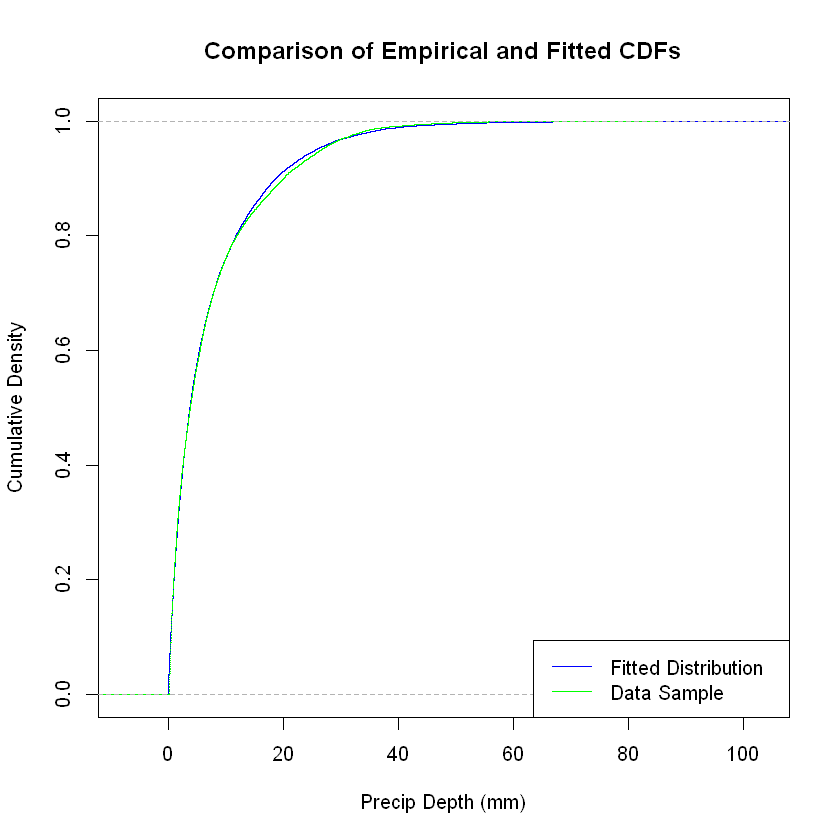

In [782]:
x <- seq(0,wJul1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJul1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [783]:
MonDistDF[32, ] <- list( 7, 1, fdGM_Jul1_shape, fdGM_Jul1_rate, fdGM_Jul1_llike, fdGM_Jul1_mean,
                        fdGM_Jul1_var, fdGM_Jul1_KSStat, fdGM_Jul1_KSp, fdME_Jul1_rate1,
                        fdME_Jul1_rate2, fdME_Jul1_lambda, fdME_Jul1_mean1, fdME_Jul1_mean2,
                        fdME_Jul1_mean, fdME_Jul1_var1, fdME_Jul1_var2, fdME_Jul1_var,
                        fdME_Jul1_llike, fdME_Jul1_KSStat, fdME_Jul1_KSp )

#### Region 2

**Gamma**

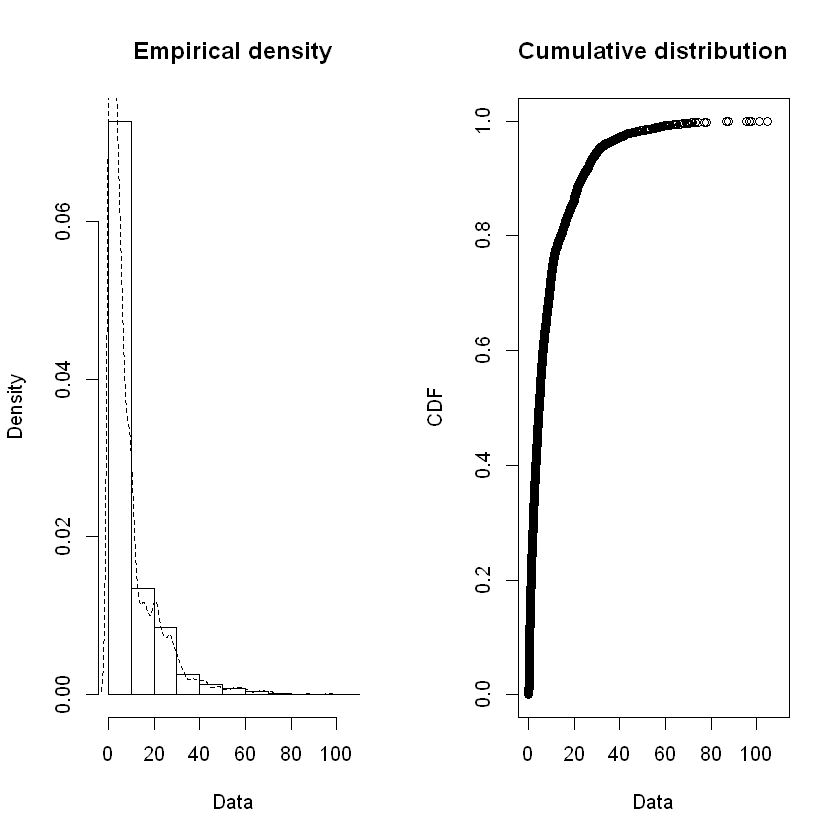

In [784]:
plotdist( dfJul2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  104.9 
median:  4.67 
mean:  8.916971 
estimated sd:  11.58233 
estimated skewness:  2.694273 
estimated kurtosis:  12.95892 

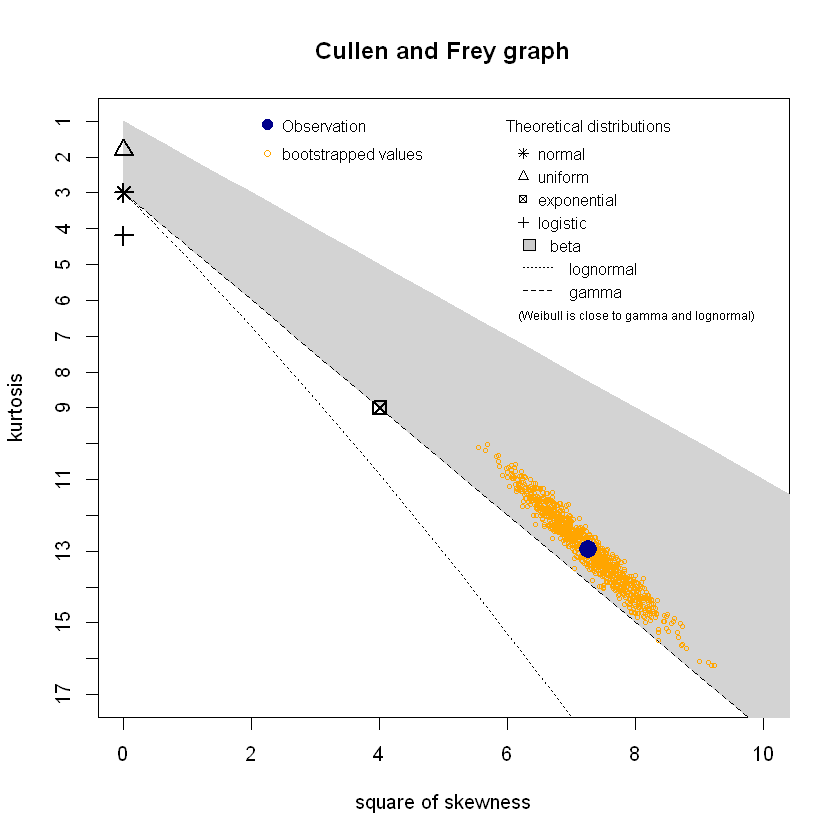

In [785]:
descdist( dfJul2$Precip_mm, boot=1000 )

In [786]:
fd_GM_Jul2 <- fitdist( dfJul2$Precip_mm, "gamma" )

In [787]:
summary( fd_GM_Jul2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.78587770 0.012939031
rate  0.08813094 0.001977356
Loglikelihood:  -17333.41   AIC:  34670.82   BIC:  34684.03 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7336639
rate  0.7336639 1.0000000


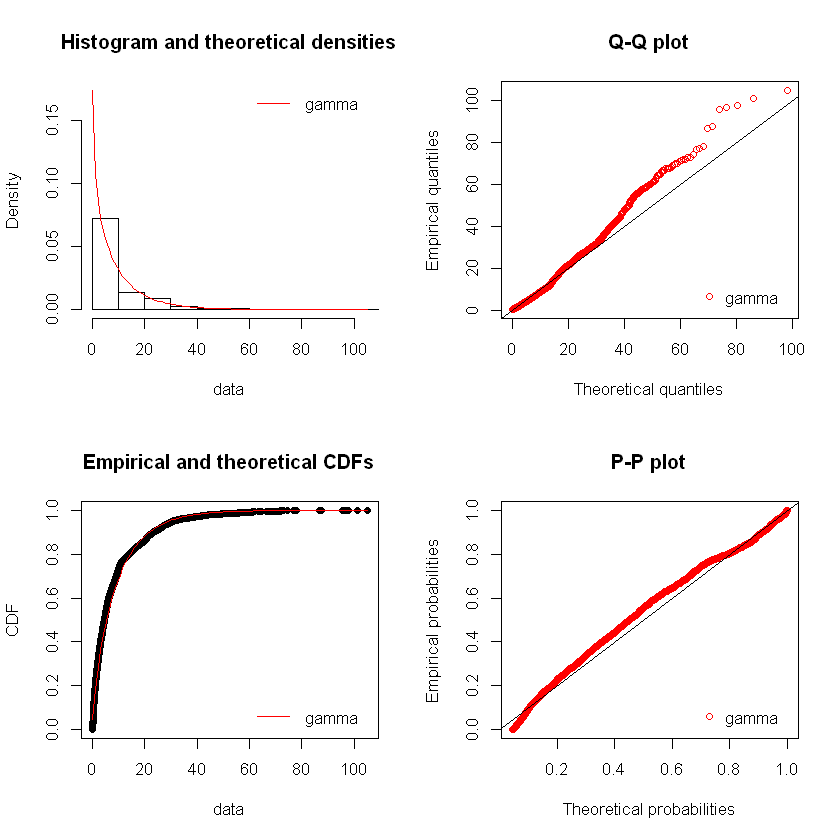

In [788]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jul2)
qqcomp(fd_GM_Jul2)
cdfcomp(fd_GM_Jul2)
ppcomp(fd_GM_Jul2)

In [789]:
fdGM_Jul2_shape <- fd_GM_Jul2$estimate[["shape"]]
fdGM_Jul2_rate <- fd_GM_Jul2$estimate[["rate"]]
fdGM_Jul2_llike <- fd_GM_Jul2$loglik
fdGM_Jul2_mean <- fdGM_Jul2_shape / fdGM_Jul2_rate
fdGM_Jul2_var <- fdGM_Jul2_shape / ( fdGM_Jul2_rate ^ 2 )
cat(" Jul 2 shape: ", fdGM_Jul2_shape, "\n", "Jul 2 rate: ", fdGM_Jul2_rate, 
    "\n", "Jul 2 loglikelihood: ", fdGM_Jul2_llike, "\n", 
    "Jul 2 mean: ", fdGM_Jul2_mean, "\n",
    "Jul 2 variance: ", fdGM_Jul2_var, "\n" )

 Jul 2 shape:  0.7858777 
 Jul 2 rate:  0.08813094 
 Jul 2 loglikelihood:  -17333.41 
 Jul 2 mean:  8.91716 
 Jul 2 variance:  101.1808 


In [790]:
statRes <- gofstat( fd_GM_Jul2, fitnames=c("Gamma") )

In [791]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05874907
Cramer-von Mises statistic    6.61085185
Anderson-Darling statistic   40.16523279

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 34670.82
Bayesian Information Criterion 34684.03


In [792]:
ksRes <- ks.test( dfJul2$Precip_mm, "pgamma", shape=fdGM_Jul2_shape, rate=fdGM_Jul2_rate )

Warning message in ks.test(dfJul2$Precip_mm, "pgamma", shape = fdGM_Jul2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [793]:
fdGM_Jul2_KSStat <- ksRes$statistic
fdGM_Jul2_KSp <- ksRes$p.value
cat(" Jul 2 K-S stat: ", fdGM_Jul2_KSStat, "\n",
    "Jul 2 K-S p-value: ", fdGM_Jul2_KSp )

 Jul 2 K-S stat:  0.05874907 
 Jul 2 K-S p-value:  1.110223e-16

**Mixed exponential**

In [794]:
fd_ME_Jul2 <- expRMM_EM( dfJul2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJul2$Precip_mm), 1.0/mean(dfJul2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 232 


In [795]:
summary( fd_ME_Jul2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.471985 0.5280146
rate   0.298838 0.0719604
loglik at estimate:  -17175.02 
0 % of the data right censored


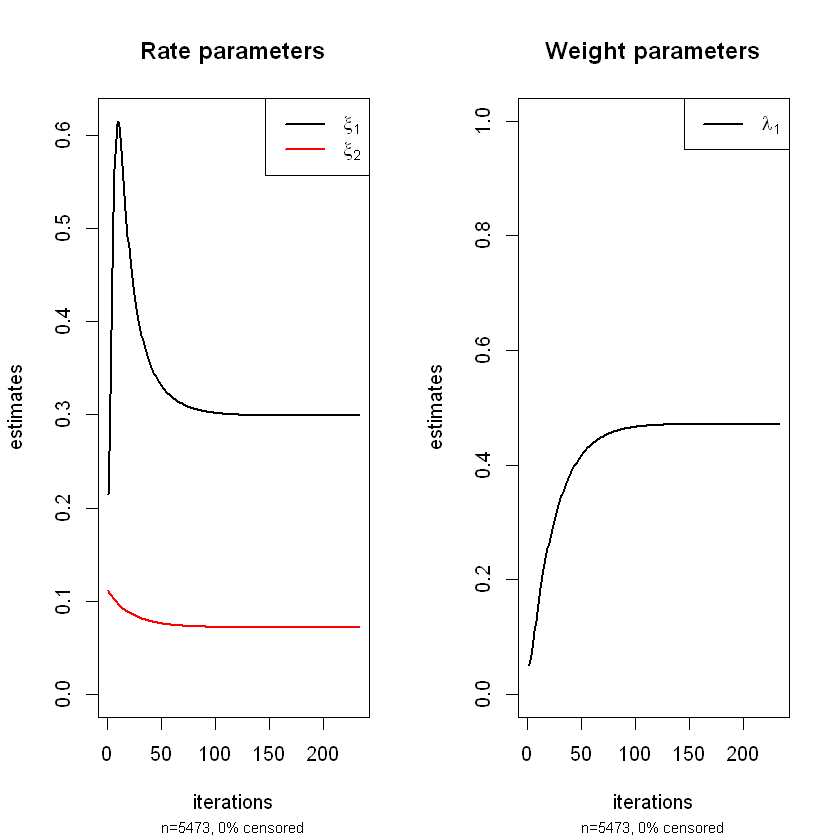

In [796]:
plotexpRMM( fd_ME_Jul2, lwd=2 )

In [797]:
fdME_Jul2_rate1 <- fd_ME_Jul2$rate[[1]]
fdME_Jul2_rate2 <- fd_ME_Jul2$rate[[2]]
fdME_Jul2_lambda <- fd_ME_Jul2$lambda[[1]]
fdME_Jul2_mean1 <- 1.0 / fdME_Jul2_rate1
fdME_Jul2_mean2 <- 1.0 / fdME_Jul2_rate2
fdME_Jul2_mean <- ( (fdME_Jul2_lambda * fdME_Jul2_mean1) + 
                    ( ( 1.0 - fdME_Jul2_lambda) * fdME_Jul2_mean2 ) )
fdME_Jul2_var1 <- 1.0 / (fdME_Jul2_rate1 ^ 2)
fdME_Jul2_var2 <- 1.0 / (fdME_Jul2_rate2 ^ 2)
fdME_Jul2_var <- ( (fdME_Jul2_lambda * ( fdME_Jul2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jul2_lambda) * (fdME_Jul2_mean2 ^ 2) ) + 
                   ( fdME_Jul2_lambda * ( 1.0 - fdME_Jul2_lambda) * 
                       ( fdME_Jul2_mean1 - fdME_Jul2_mean2 )^2 ) )
fdME_Jul2_llike <- fd_ME_Jul2$loglik
cat(" Jul 2 rate1: ", fdME_Jul2_rate1, "\n", 
    "Jul 2 rate2: ", fdME_Jul2_rate2, "\n",
    "Jul 2 lambda: ", fdME_Jul2_lambda, "\n",
    "Jul 2 mean1: ", fdME_Jul2_mean1, "\n",
    "Jul 2 mean2: ", fdME_Jul2_mean2, "\n",
    "Jul 2 mean: ", fdME_Jul2_mean, "\n",
    "Jul 2 var1: ", fdME_Jul2_var1, "\n",
    "Jul 2 var2: ", fdME_Jul2_var2, "\n",
    "Jul 2 var: ", fdME_Jul2_var, "\n",
    "Jul 2 loglikelihood: ", fdME_Jul2_llike, "\n" )

 Jul 2 rate1:  0.2988382 
 Jul 2 rate2:  0.07196043 
 Jul 2 lambda:  0.4719854 
 Jul 2 mean1:  3.346293 
 Jul 2 mean2:  13.89653 
 Jul 2 mean:  8.916971 
 Jul 2 var1:  11.19767 
 Jul 2 var2:  193.1135 
 Jul 2 var:  134.9914 
 Jul 2 loglikelihood:  -17175.02 


In [798]:
tvals <- rexpmix(length(dfJul2$Precip_mm), fd_ME_Jul2$lambda, fd_ME_Jul2$rate )

In [799]:
ksRes <- ks.test( dfJul2$Precip_mm, tvals )

Warning message in ks.test(dfJul2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [800]:
fdME_Jul2_KSStat <- ksRes$statistic
fdME_Jul2_KSp <- ksRes$p.value
cat(" Jul 2 K-S stat: ", fdME_Jul2_KSStat, "\n",
    "Jul 2 K-S p-value: ", fdME_Jul2_KSp )

 Jul 2 K-S stat:  0.03288873 
 Jul 2 K-S p-value:  0.005370557

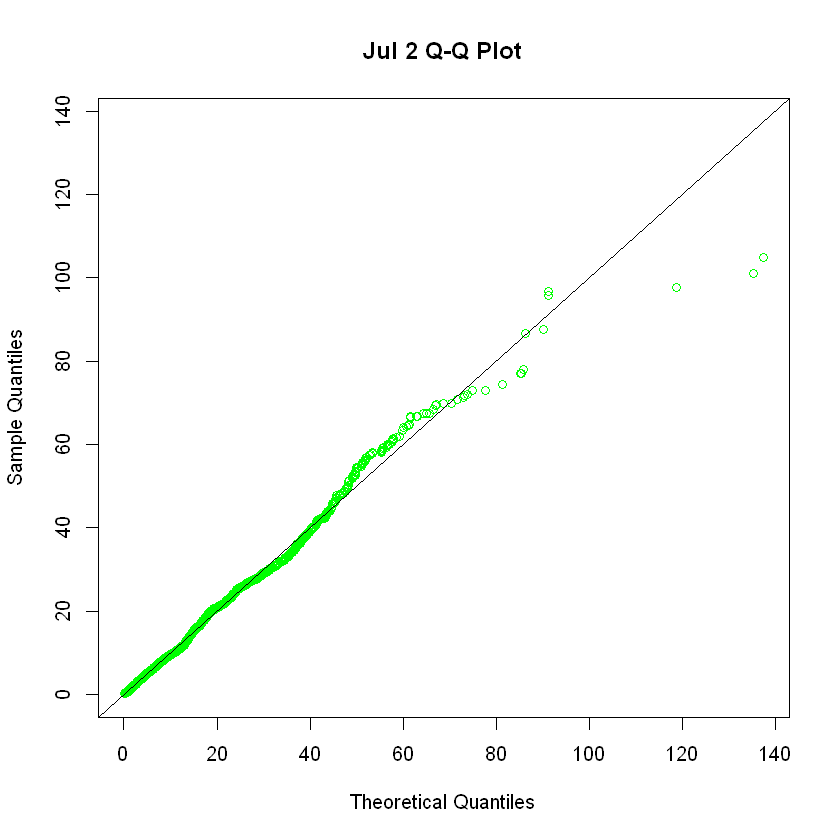

In [801]:
wJul2Max <- max( max( dfJul2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJul2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jul 2 Q-Q Plot",
        xlim=c(0,wJul2Max), ylim=c(0,wJul2Max) )
abline( 0, 1)

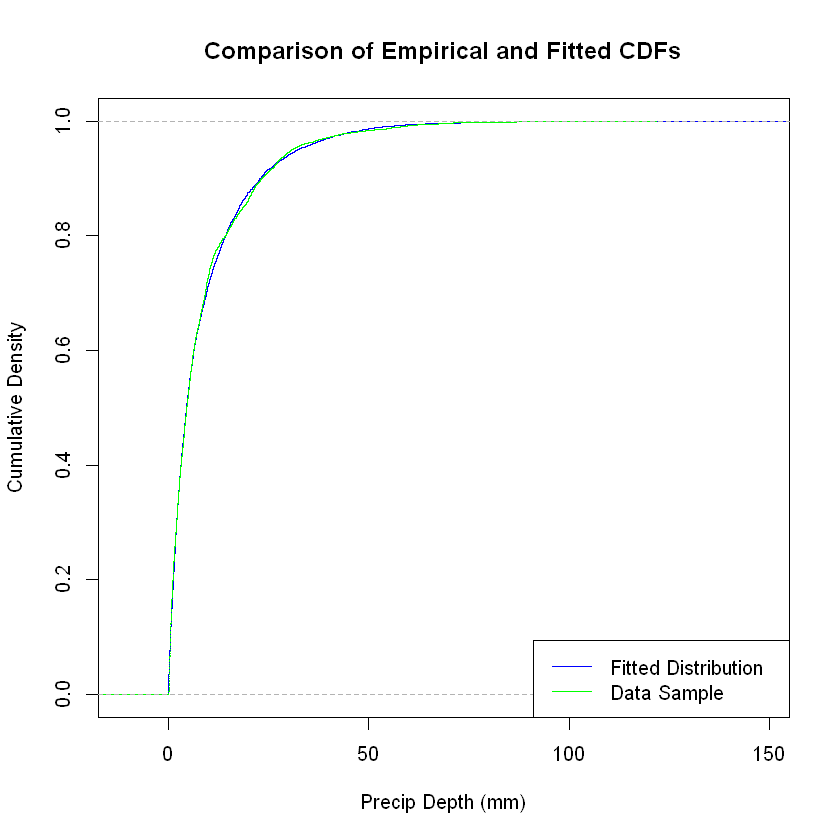

In [802]:
x <- seq(0,wJul2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJul2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [803]:
MonDistDF[33, ] <- list( 7, 2, fdGM_Jul2_shape, fdGM_Jul2_rate, fdGM_Jul2_llike, fdGM_Jul2_mean,
                        fdGM_Jul2_var, fdGM_Jul2_KSStat, fdGM_Jul2_KSp, fdME_Jul2_rate1,
                        fdME_Jul2_rate2, fdME_Jul2_lambda, fdME_Jul2_mean1, fdME_Jul2_mean2,
                        fdME_Jul2_mean, fdME_Jul2_var1, fdME_Jul2_var2, fdME_Jul2_var,
                        fdME_Jul2_llike, fdME_Jul2_KSStat, fdME_Jul2_KSp )

#### Region 3

**Gamma**

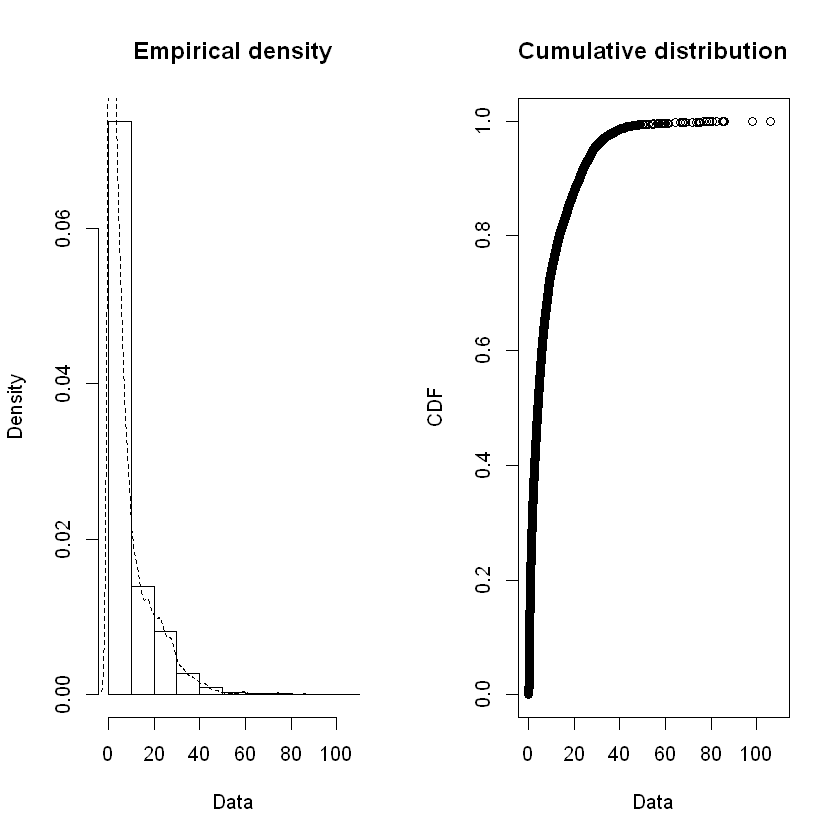

In [804]:
plotdist( dfJul3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  106.04 
median:  4.13 
mean:  8.059182 
estimated sd:  10.15667 
estimated skewness:  2.457545 
estimated kurtosis:  12.22642 

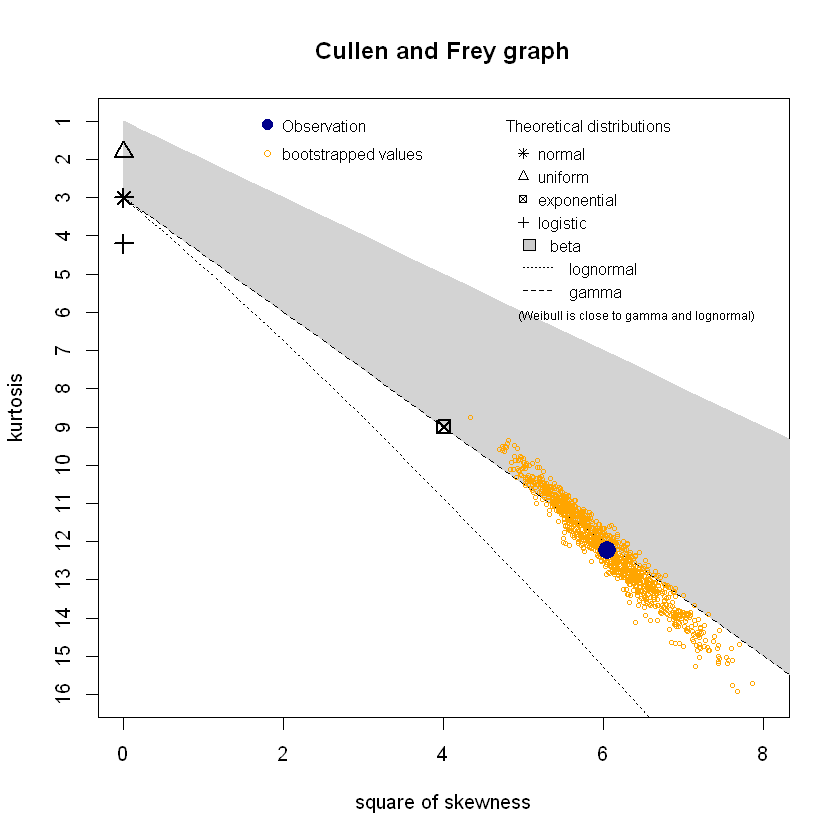

In [805]:
descdist( dfJul3$Precip_mm, boot=1000 )

In [806]:
fd_GM_Jul3 <- fitdist( dfJul3$Precip_mm, "gamma" )

In [807]:
summary( fd_GM_Jul3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.76526568 0.010538332
rate  0.09495077 0.001794999
Loglikelihood:  -23827.61   AIC:  47659.22   BIC:  47673.14 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7283055
rate  0.7283055 1.0000000


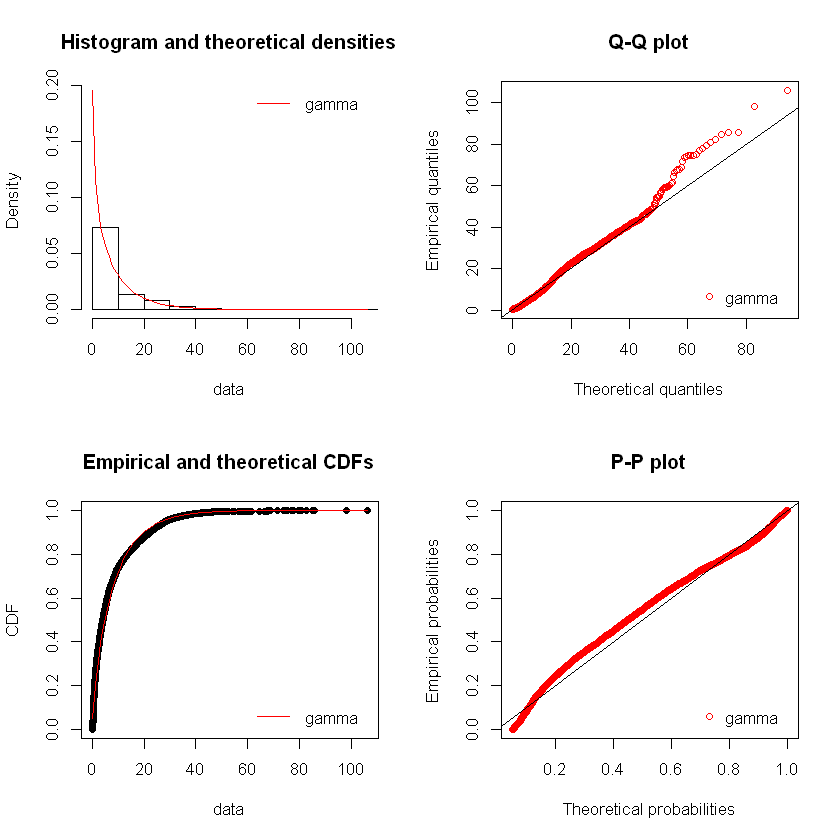

In [808]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jul3)
qqcomp(fd_GM_Jul3)
cdfcomp(fd_GM_Jul3)
ppcomp(fd_GM_Jul3)

In [809]:
fdGM_Jul3_shape <- fd_GM_Jul3$estimate[["shape"]]
fdGM_Jul3_rate <- fd_GM_Jul3$estimate[["rate"]]
fdGM_Jul3_llike <- fd_GM_Jul3$loglik
fdGM_Jul3_mean <- fdGM_Jul3_shape / fdGM_Jul3_rate
fdGM_Jul3_var <- fdGM_Jul3_shape / ( fdGM_Jul3_rate ^ 2 )
cat(" Jul 3 shape: ", fdGM_Jul3_shape, "\n", "Jul 3 rate: ", fdGM_Jul3_rate, 
    "\n", "Jul 3 loglikelihood: ", fdGM_Jul3_llike, "\n", 
    "Jul 3 mean: ", fdGM_Jul3_mean, "\n",
    "Jul 3 variance: ", fdGM_Jul3_var, "\n" )

 Jul 3 shape:  0.7652657 
 Jul 3 rate:  0.09495077 
 Jul 3 loglikelihood:  -23827.61 
 Jul 3 mean:  8.059605 
 Jul 3 variance:  84.88193 


In [810]:
statRes <- gofstat( fd_GM_Jul3, fitnames=c("Gamma") )

In [811]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05645295
Cramer-von Mises statistic   10.89406386
Anderson-Darling statistic   69.31538451

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 47659.22
Bayesian Information Criterion 47673.14


In [812]:
ksRes <- ks.test( dfJul3$Precip_mm, "pgamma", shape=fdGM_Jul3_shape, rate=fdGM_Jul3_rate )

Warning message in ks.test(dfJul3$Precip_mm, "pgamma", shape = fdGM_Jul3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [813]:
fdGM_Jul3_KSStat <- ksRes$statistic
fdGM_Jul3_KSp <- ksRes$p.value
cat(" Jul 3 K-S stat: ", fdGM_Jul3_KSStat, "\n",
    "Jul 3 K-S p-value: ", fdGM_Jul3_KSp )

 Jul 3 K-S stat:  0.05645295 
 Jul 3 K-S p-value:  0

**Mixed exponential**

In [814]:
fd_ME_Jul3 <- expRMM_EM( dfJul3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJul3$Precip_mm), 1.0/mean(dfJul3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 169 


In [815]:
summary( fd_ME_Jul3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.374444 0.6255556
rate   0.464240 0.0862525
loglik at estimate:  -23577.12 
0 % of the data right censored


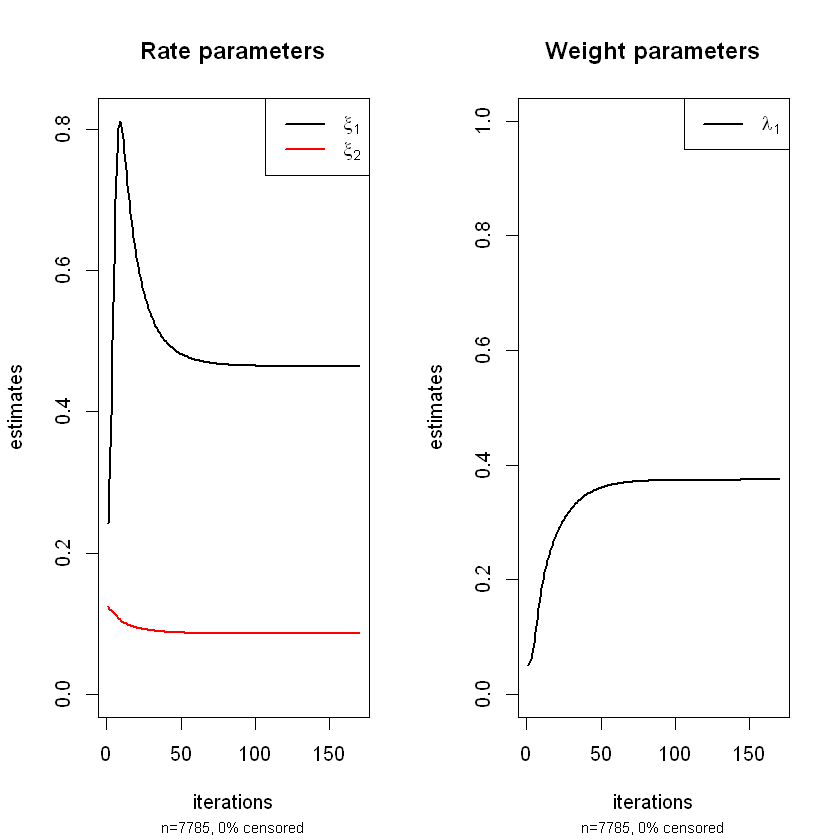

In [816]:
plotexpRMM( fd_ME_Jul3, lwd=2 )

In [817]:
fdME_Jul3_rate1 <- fd_ME_Jul3$rate[[1]]
fdME_Jul3_rate2 <- fd_ME_Jul3$rate[[2]]
fdME_Jul3_lambda <- fd_ME_Jul3$lambda[[1]]
fdME_Jul3_mean1 <- 1.0 / fdME_Jul3_rate1
fdME_Jul3_mean2 <- 1.0 / fdME_Jul3_rate2
fdME_Jul3_mean <- ( (fdME_Jul3_lambda * fdME_Jul3_mean1) + 
                    ( ( 1.0 - fdME_Jul3_lambda) * fdME_Jul3_mean2 ) )
fdME_Jul3_var1 <- 1.0 / (fdME_Jul3_rate1 ^ 2)
fdME_Jul3_var2 <- 1.0 / (fdME_Jul3_rate2 ^ 2)
fdME_Jul3_var <- ( (fdME_Jul3_lambda * ( fdME_Jul3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jul3_lambda) * (fdME_Jul3_mean2 ^ 2) ) + 
                   ( fdME_Jul3_lambda * ( 1.0 - fdME_Jul3_lambda) * 
                       ( fdME_Jul3_mean1 - fdME_Jul3_mean2 )^2 ) )
fdME_Jul3_llike <- fd_ME_Jul3$loglik
cat(" Jul 3 rate1: ", fdME_Jul3_rate1, "\n", 
    "Jul 3 rate2: ", fdME_Jul3_rate2, "\n",
    "Jul 3 lambda: ", fdME_Jul3_lambda, "\n",
    "Jul 3 mean1: ", fdME_Jul3_mean1, "\n",
    "Jul 3 mean2: ", fdME_Jul3_mean2, "\n",
    "Jul 3 mean: ", fdME_Jul3_mean, "\n",
    "Jul 3 var1: ", fdME_Jul3_var1, "\n",
    "Jul 3 var2: ", fdME_Jul3_var2, "\n",
    "Jul 3 var: ", fdME_Jul3_var, "\n",
    "Jul 3 loglikelihood: ", fdME_Jul3_llike, "\n" )

 Jul 3 rate1:  0.4642397 
 Jul 3 rate2:  0.08625252 
 Jul 3 lambda:  0.3744444 
 Jul 3 mean1:  2.154059 
 Jul 3 mean2:  11.59386 
 Jul 3 mean:  8.059182 
 Jul 3 var1:  4.639972 
 Jul 3 var2:  134.4177 
 Jul 3 var:  106.6959 
 Jul 3 loglikelihood:  -23577.12 


In [818]:
tvals <- rexpmix(length(dfJul3$Precip_mm), fd_ME_Jul3$lambda, fd_ME_Jul3$rate )

In [819]:
ksRes <- ks.test( dfJul3$Precip_mm, tvals )

Warning message in ks.test(dfJul3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [820]:
fdME_Jul3_KSStat <- ksRes$statistic
fdME_Jul3_KSp <- ksRes$p.value
cat(" Jul 3 K-S stat: ", fdME_Jul3_KSStat, "\n",
    "Jul 3 K-S p-value: ", fdME_Jul3_KSp )

 Jul 3 K-S stat:  0.04213231 
 Jul 3 K-S p-value:  1.992244e-06

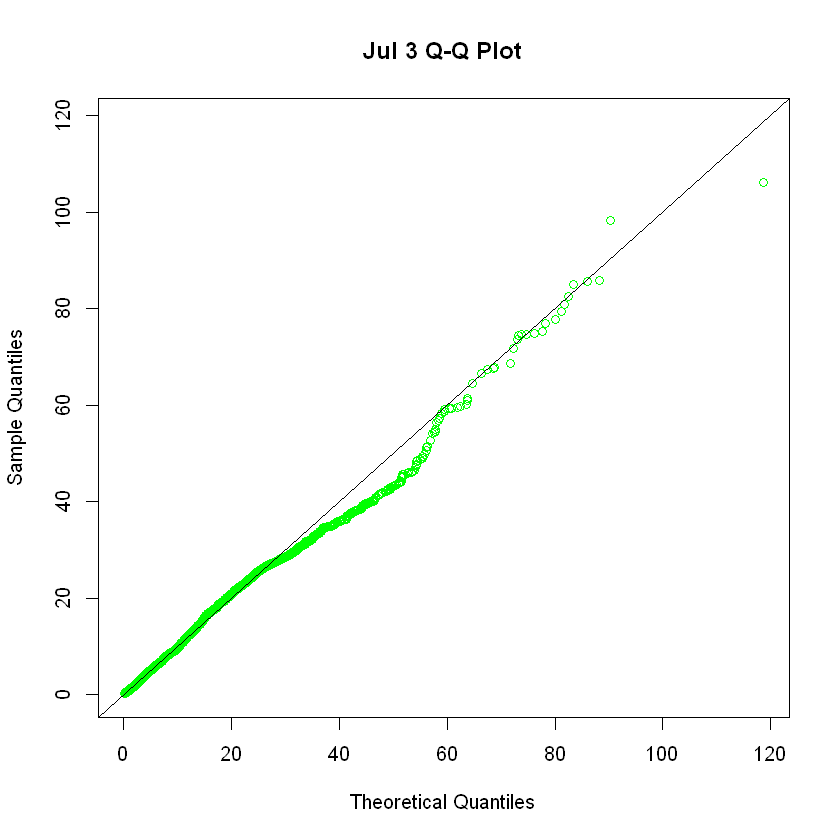

In [821]:
wJul3Max <- max( max( dfJul3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJul3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jul 3 Q-Q Plot",
        xlim=c(0,wJul3Max), ylim=c(0,wJul3Max) )
abline( 0, 1)

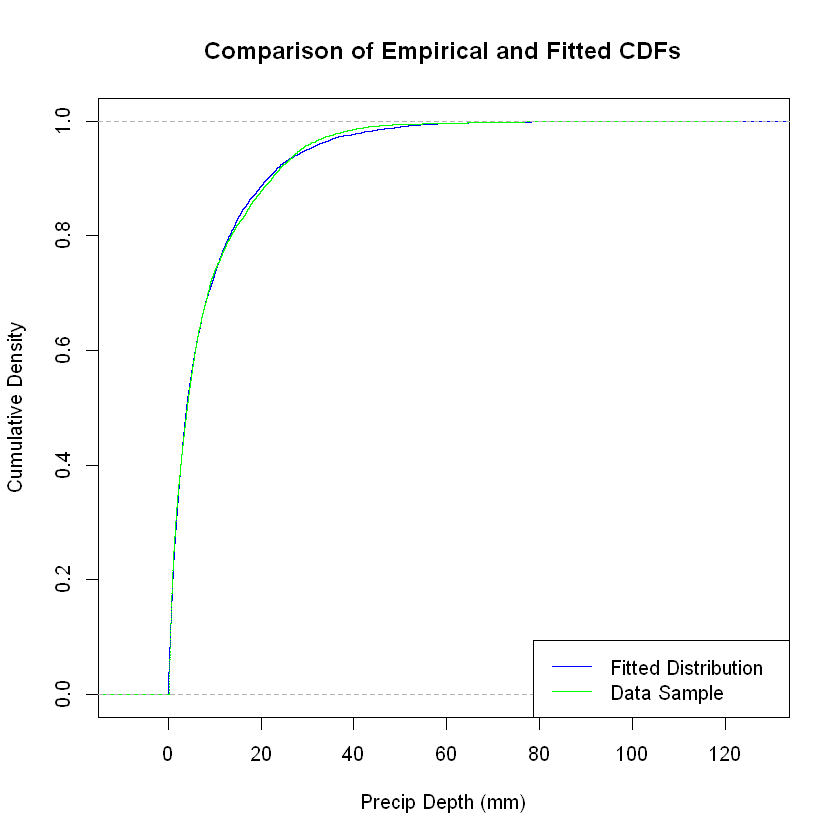

In [822]:
x <- seq(0,wJul3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJul3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [823]:
MonDistDF[34, ] <- list( 7, 3, fdGM_Jul3_shape, fdGM_Jul3_rate, fdGM_Jul3_llike, fdGM_Jul3_mean,
                        fdGM_Jul3_var, fdGM_Jul3_KSStat, fdGM_Jul3_KSp, fdME_Jul3_rate1,
                        fdME_Jul3_rate2, fdME_Jul3_lambda, fdME_Jul3_mean1, fdME_Jul3_mean2,
                        fdME_Jul3_mean, fdME_Jul3_var1, fdME_Jul3_var2, fdME_Jul3_var,
                        fdME_Jul3_llike, fdME_Jul3_KSStat, fdME_Jul3_KSp )

#### Region 4

**Gamma**

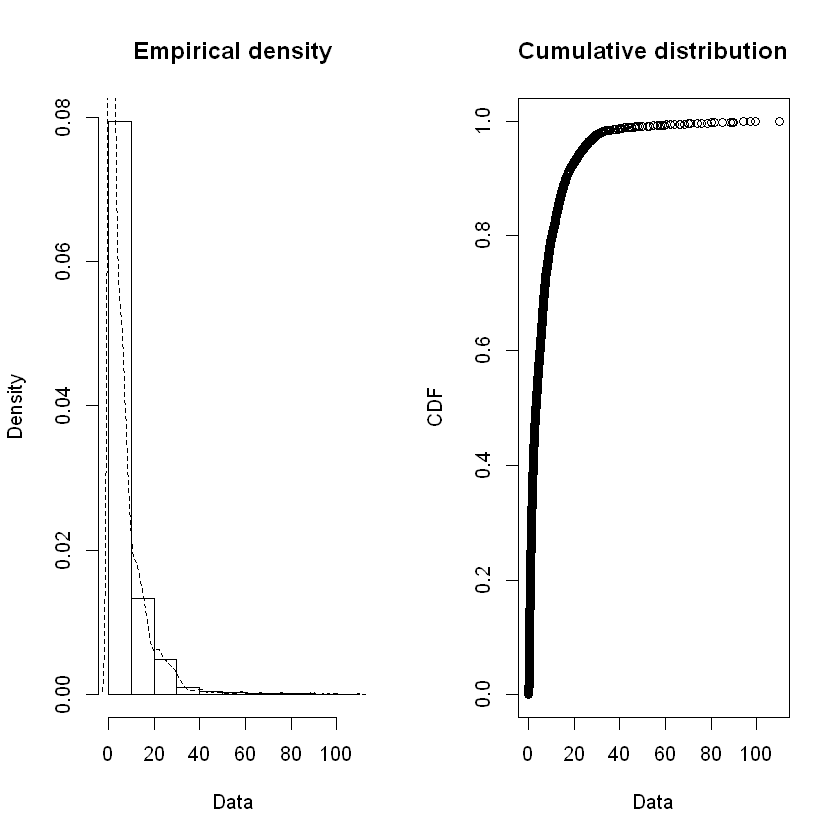

In [824]:
plotdist( dfJul4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  109.88 
median:  3.28 
mean:  6.707867 
estimated sd:  9.752922 
estimated skewness:  4.087609 
estimated kurtosis:  28.57877 

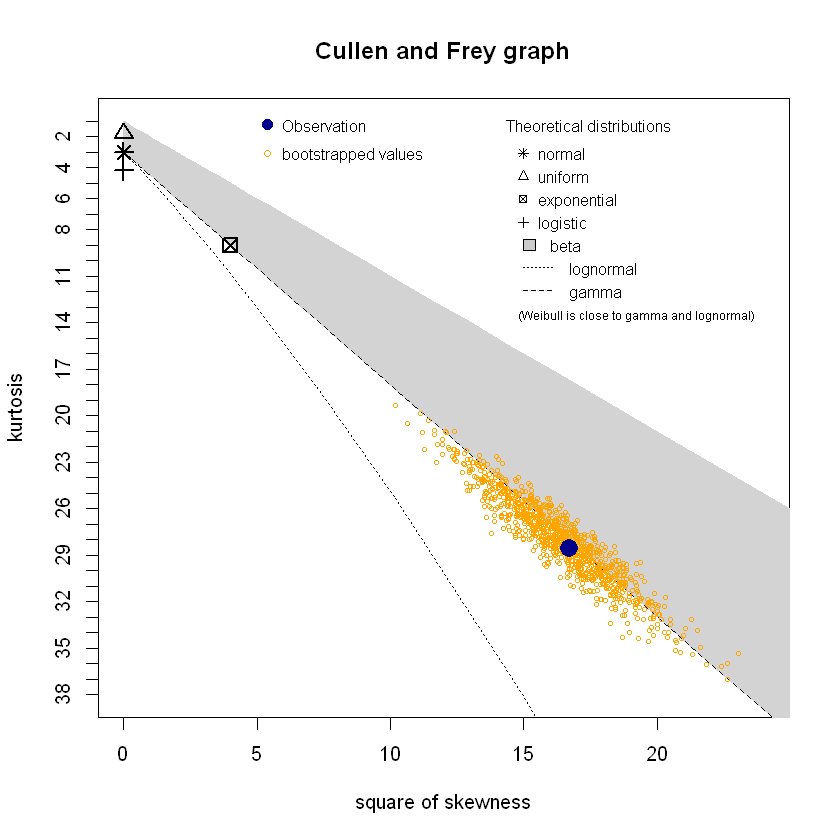

In [825]:
descdist( dfJul4$Precip_mm, boot=1000 )

In [826]:
fd_GM_Jul4 <- fitdist( dfJul4$Precip_mm, "gamma" )

In [827]:
summary( fd_GM_Jul4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7728324 0.016212529
rate  0.1152213 0.003309276
Loglikelihood:  -9676.668   AIC:  19357.34   BIC:  19369.58 
Correlation matrix:
         shape     rate
shape 1.000000 0.730316
rate  0.730316 1.000000


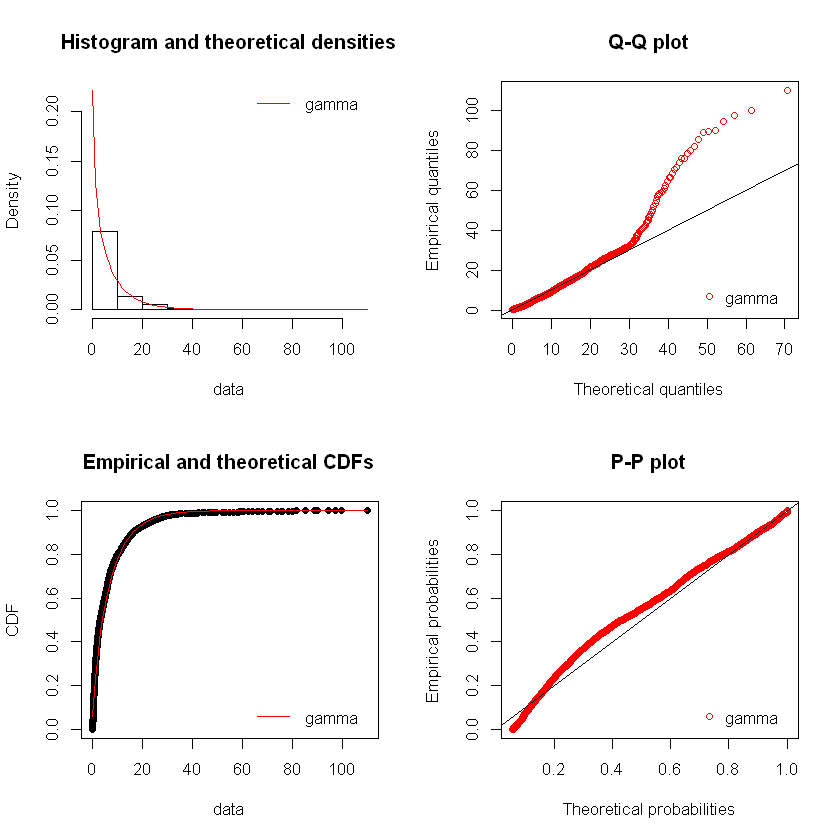

In [828]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Jul4)
qqcomp(fd_GM_Jul4)
cdfcomp(fd_GM_Jul4)
ppcomp(fd_GM_Jul4)

In [829]:
fdGM_Jul4_shape <- fd_GM_Jul4$estimate[["shape"]]
fdGM_Jul4_rate <- fd_GM_Jul4$estimate[["rate"]]
fdGM_Jul4_llike <- fd_GM_Jul4$loglik
fdGM_Jul4_mean <- fdGM_Jul4_shape / fdGM_Jul4_rate
fdGM_Jul4_var <- fdGM_Jul4_shape / ( fdGM_Jul4_rate ^ 2 )
cat(" Jul 4 shape: ", fdGM_Jul4_shape, "\n", "Jul 4 rate: ", fdGM_Jul4_rate, 
    "\n", "Jul 4 loglikelihood: ", fdGM_Jul4_llike, "\n", 
    "Jul 4 mean: ", fdGM_Jul4_mean, "\n",
    "Jul 4 variance: ", fdGM_Jul4_var, "\n" )

 Jul 4 shape:  0.7728324 
 Jul 4 rate:  0.1152213 
 Jul 4 loglikelihood:  -9676.668 
 Jul 4 mean:  6.707373 
 Jul 4 variance:  58.21295 


In [830]:
statRes <- gofstat( fd_GM_Jul4, fitnames=c("Gamma") )

In [831]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.07654704
Cramer-von Mises statistic    6.01753332
Anderson-Darling statistic   36.50486516

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 19357.34
Bayesian Information Criterion 19369.58


In [832]:
ksRes <- ks.test( dfJul4$Precip_mm, "pgamma", shape=fdGM_Jul4_shape, rate=fdGM_Jul4_rate )

Warning message in ks.test(dfJul4$Precip_mm, "pgamma", shape = fdGM_Jul4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [833]:
fdGM_Jul4_KSStat <- ksRes$statistic
fdGM_Jul4_KSp <- ksRes$p.value
cat(" Jul 4 K-S stat: ", fdGM_Jul4_KSStat, "\n",
    "Jul 4 K-S p-value: ", fdGM_Jul4_KSp )

 Jul 4 K-S stat:  0.07654704 
 Jul 4 K-S p-value:  0

**Mixed exponential**

In [834]:
fd_ME_Jul4 <- expRMM_EM( dfJul4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfJul4$Precip_mm), 1.0/mean(dfJul4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 300 


In [835]:
summary( fd_ME_Jul4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.482519 0.5174806
rate   0.418288 0.0931674
loglik at estimate:  -9550.878 
0 % of the data right censored


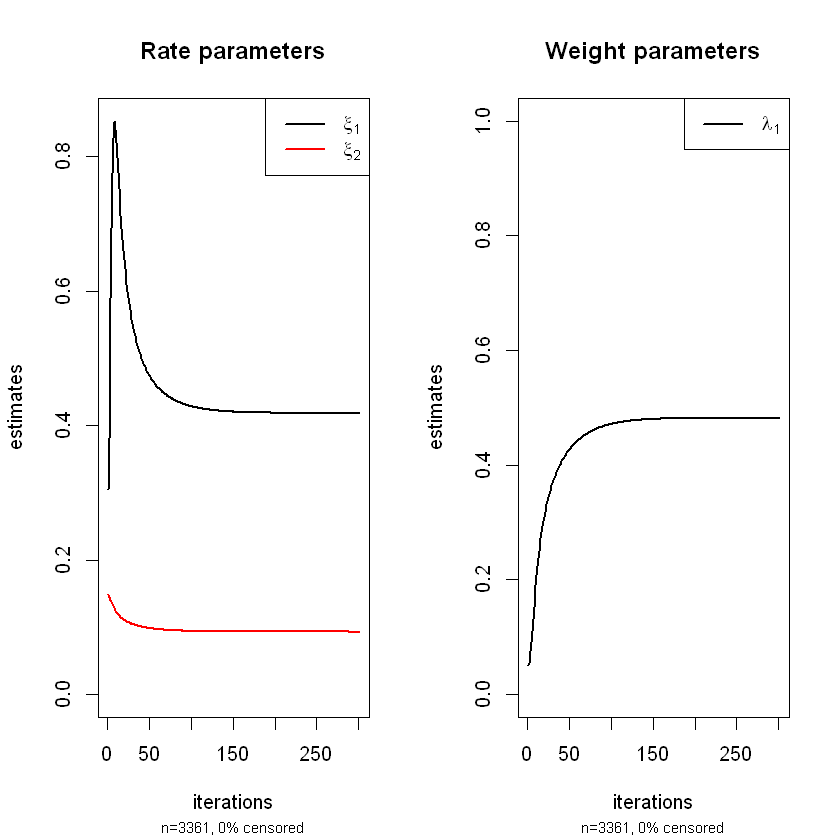

In [836]:
plotexpRMM( fd_ME_Jul4, lwd=2 )

In [837]:
fdME_Jul4_rate1 <- fd_ME_Jul4$rate[[1]]
fdME_Jul4_rate2 <- fd_ME_Jul4$rate[[2]]
fdME_Jul4_lambda <- fd_ME_Jul4$lambda[[1]]
fdME_Jul4_mean1 <- 1.0 / fdME_Jul4_rate1
fdME_Jul4_mean2 <- 1.0 / fdME_Jul4_rate2
fdME_Jul4_mean <- ( (fdME_Jul4_lambda * fdME_Jul4_mean1) + 
                    ( ( 1.0 - fdME_Jul4_lambda) * fdME_Jul4_mean2 ) )
fdME_Jul4_var1 <- 1.0 / (fdME_Jul4_rate1 ^ 2)
fdME_Jul4_var2 <- 1.0 / (fdME_Jul4_rate2 ^ 2)
fdME_Jul4_var <- ( (fdME_Jul4_lambda * ( fdME_Jul4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Jul4_lambda) * (fdME_Jul4_mean2 ^ 2) ) + 
                   ( fdME_Jul4_lambda * ( 1.0 - fdME_Jul4_lambda) * 
                       ( fdME_Jul4_mean1 - fdME_Jul4_mean2 )^2 ) )
fdME_Jul4_llike <- fd_ME_Jul4$loglik
cat(" Jul 4 rate1: ", fdME_Jul4_rate1, "\n", 
    "Jul 4 rate2: ", fdME_Jul4_rate2, "\n",
    "Jul 4 lambda: ", fdME_Jul4_lambda, "\n",
    "Jul 4 mean1: ", fdME_Jul4_mean1, "\n",
    "Jul 4 mean2: ", fdME_Jul4_mean2, "\n",
    "Jul 4 mean: ", fdME_Jul4_mean, "\n",
    "Jul 4 var1: ", fdME_Jul4_var1, "\n",
    "Jul 4 var2: ", fdME_Jul4_var2, "\n",
    "Jul 4 var: ", fdME_Jul4_var, "\n",
    "Jul 4 loglikelihood: ", fdME_Jul4_llike, "\n" )

 Jul 4 rate1:  0.4182884 
 Jul 4 rate2:  0.0931674 
 Jul 4 lambda:  0.4825194 
 Jul 4 mean1:  2.390695 
 Jul 4 mean2:  10.73337 
 Jul 4 mean:  6.707867 
 Jul 4 var1:  5.715423 
 Jul 4 var2:  115.2052 
 Jul 4 var:  79.75304 
 Jul 4 loglikelihood:  -9550.878 


In [838]:
tvals <- rexpmix(length(dfJul4$Precip_mm), fd_ME_Jul4$lambda, fd_ME_Jul4$rate )

In [839]:
ksRes <- ks.test( dfJul4$Precip_mm, tvals )

Warning message in ks.test(dfJul4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [840]:
fdME_Jul4_KSStat <- ksRes$statistic
fdME_Jul4_KSp <- ksRes$p.value
cat(" Jul 4 K-S stat: ", fdME_Jul4_KSStat, "\n",
    "Jul 4 K-S p-value: ", fdME_Jul4_KSp )

 Jul 4 K-S stat:  0.04730735 
 Jul 4 K-S p-value:  0.001082241

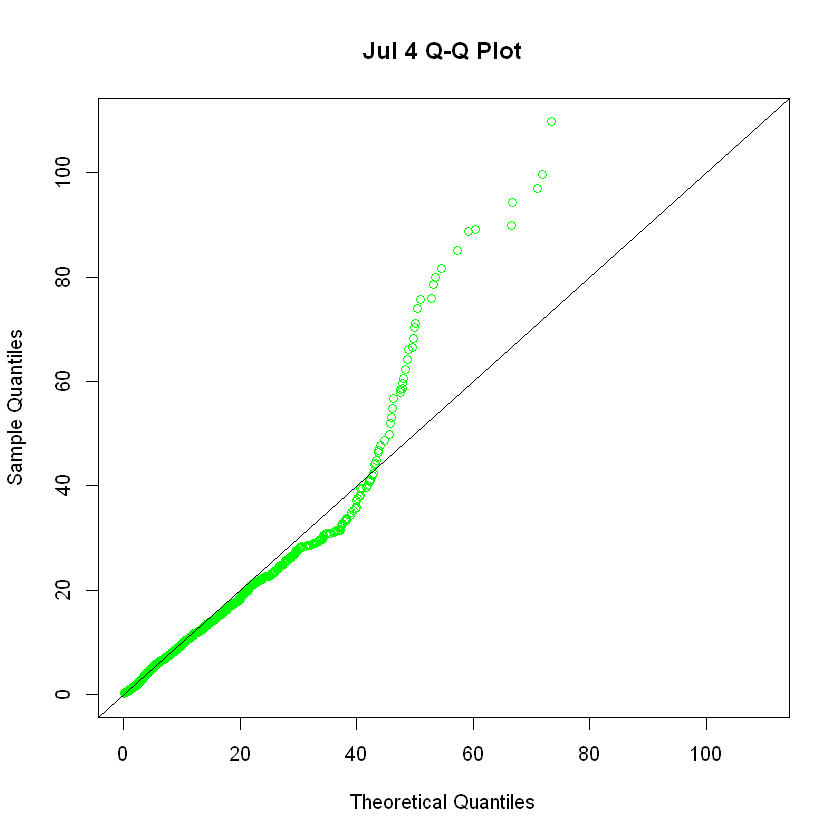

In [841]:
wJul4Max <- max( max( dfJul4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfJul4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Jul 4 Q-Q Plot",
        xlim=c(0,wJul4Max), ylim=c(0,wJul4Max) )
abline( 0, 1)

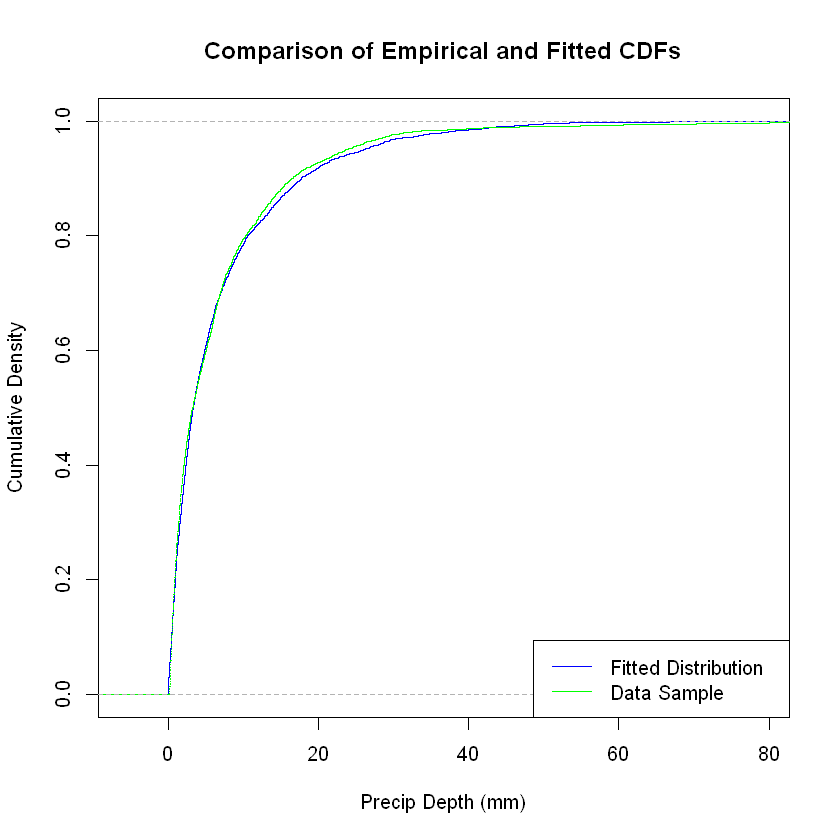

In [842]:
x <- seq(0,wJul4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfJul4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [843]:
MonDistDF[35, ] <- list( 7, 4, fdGM_Jul4_shape, fdGM_Jul4_rate, fdGM_Jul4_llike, fdGM_Jul4_mean,
                        fdGM_Jul4_var, fdGM_Jul4_KSStat, fdGM_Jul4_KSp, fdME_Jul4_rate1,
                        fdME_Jul4_rate2, fdME_Jul4_lambda, fdME_Jul4_mean1, fdME_Jul4_mean2,
                        fdME_Jul4_mean, fdME_Jul4_var1, fdME_Jul4_var2, fdME_Jul4_var,
                        fdME_Jul4_llike, fdME_Jul4_KSStat, fdME_Jul4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

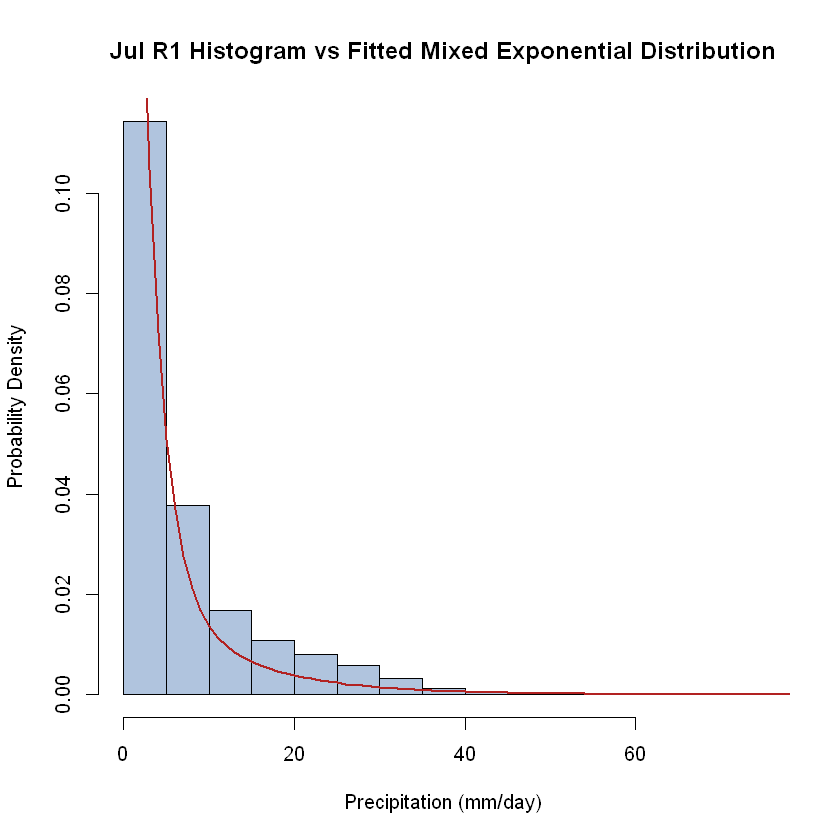

In [844]:
xVals <- seq(1, wJul1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jul1_lambda, spec1="exp", arg1=list(rate=fdME_Jul1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jul1_rate2) )
hist( dfJul1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jul R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

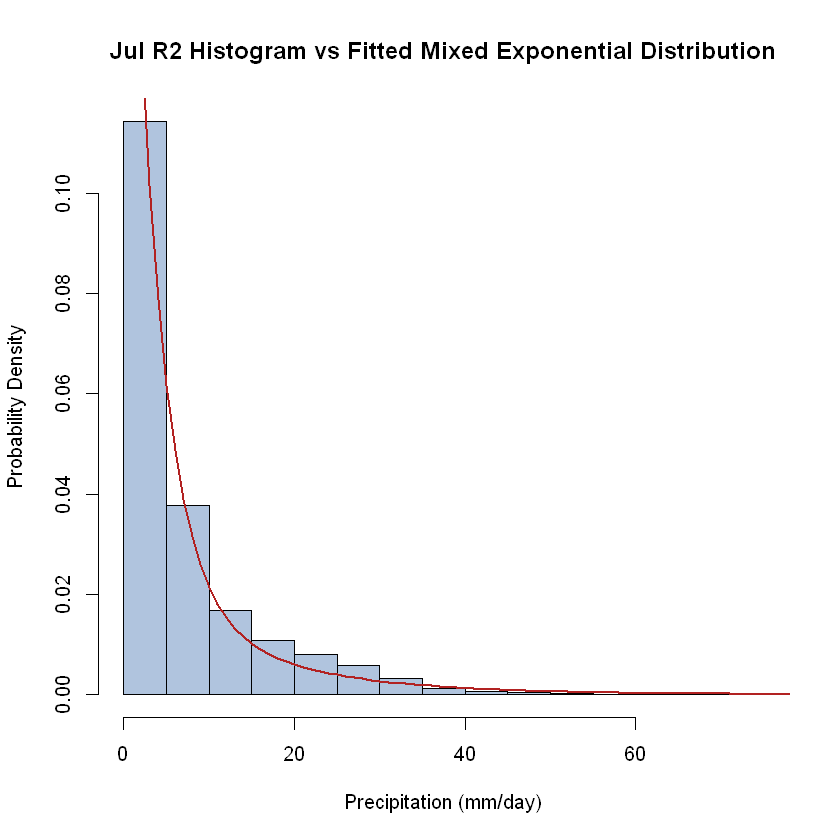

In [845]:
xVals <- seq(1, wJul2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jul2_lambda, spec1="exp", arg1=list(rate=fdME_Jul2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jul2_rate2) )
hist( dfJul1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jul R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

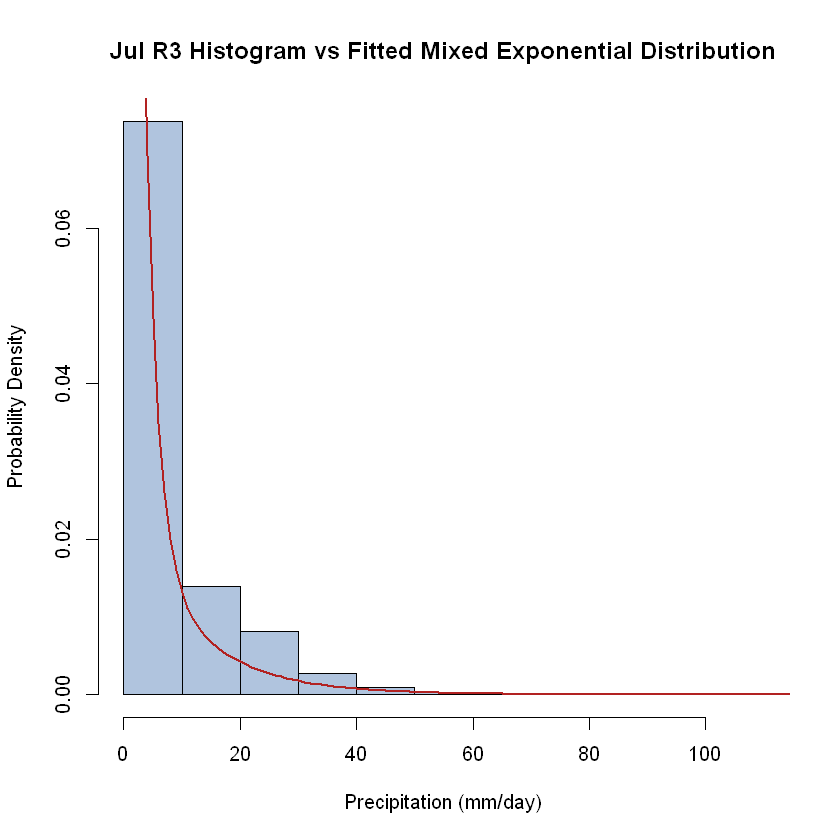

In [846]:
xVals <- seq(1, wJul3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jul3_lambda, spec1="exp", arg1=list(rate=fdME_Jul3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jul3_rate2) )
hist( dfJul3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jul R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

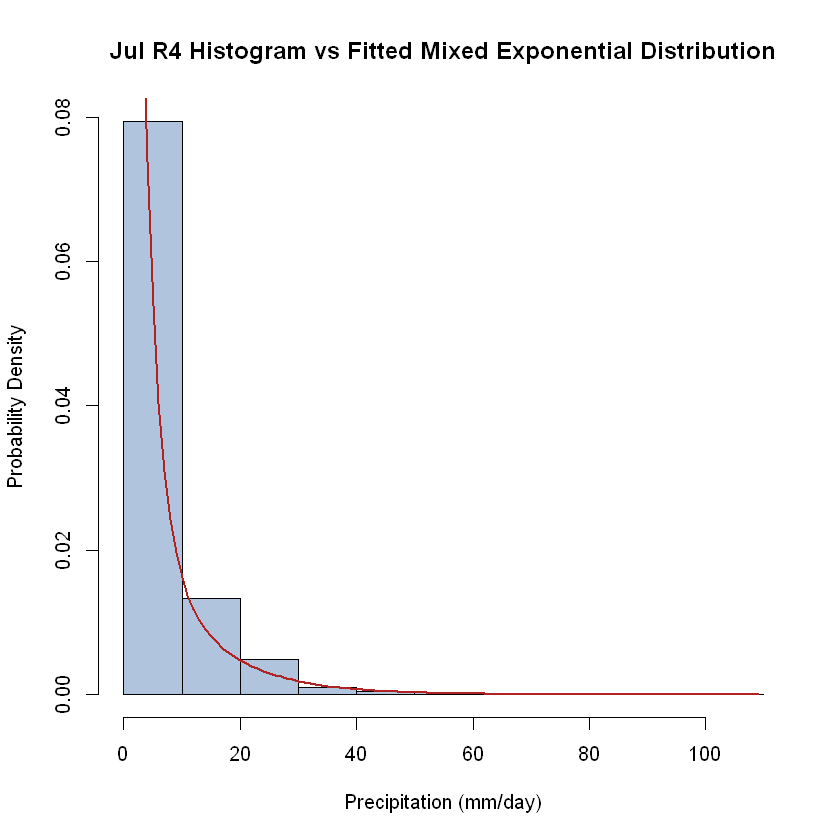

In [847]:
xVals <- seq(1, wJul4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Jul4_lambda, spec1="exp", arg1=list(rate=fdME_Jul4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Jul4_rate2) )
hist( dfJul4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Jul R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Aug

#### All

**Gamma**

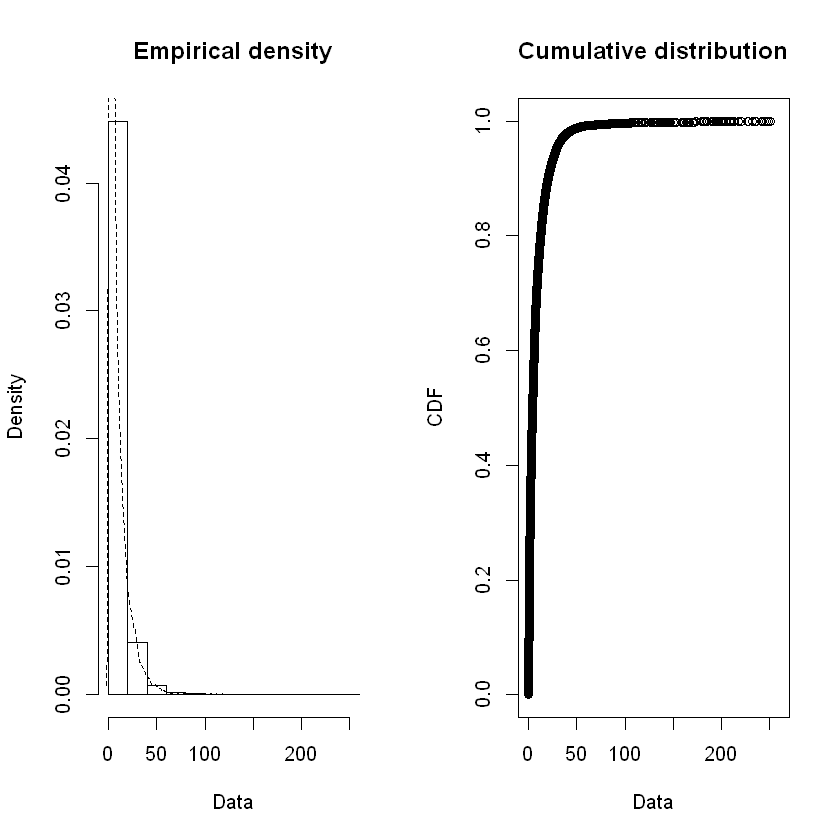

In [848]:
plotdist( dfAug$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  250.43 
median:  4.33 
mean:  8.423259 
estimated sd:  13.62637 
estimated skewness:  6.834383 
estimated kurtosis:  83.02589 

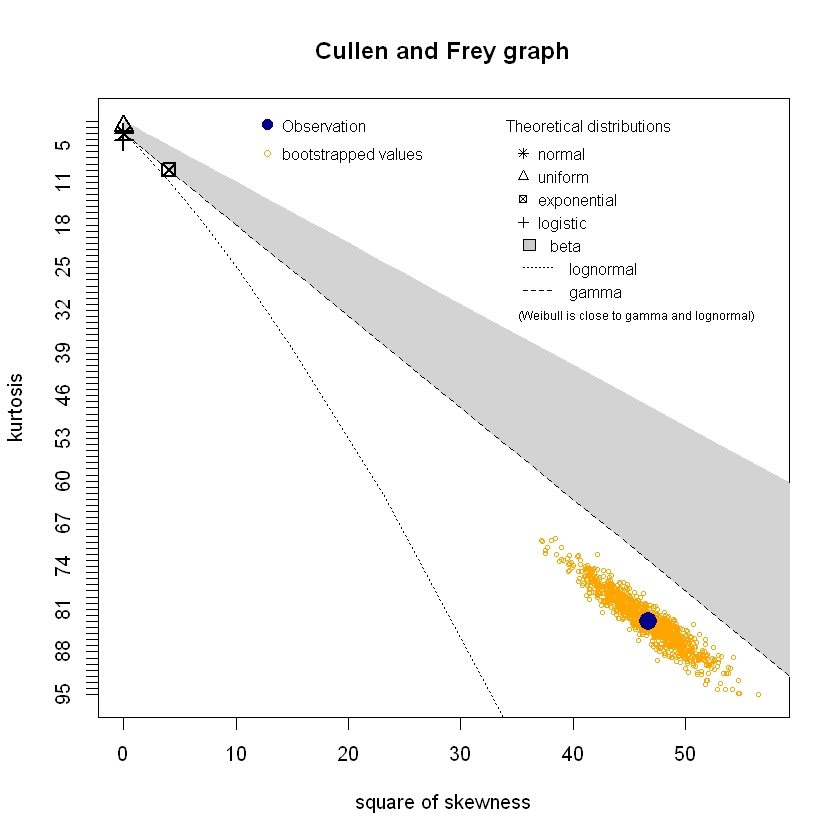

In [849]:
descdist( dfAug$Precip_mm, boot=1000 )

In [850]:
fd_GM_AugA <- fitdist( dfAug$Precip_mm, "gamma" )

In [851]:
summary( fd_GM_AugA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.76382995 0.0045196211
rate  0.09069055 0.0007370488
Loglikelihood:  -130858.4   AIC:  261720.8   BIC:  261738.1 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7279191
rate  0.7279191 1.0000000


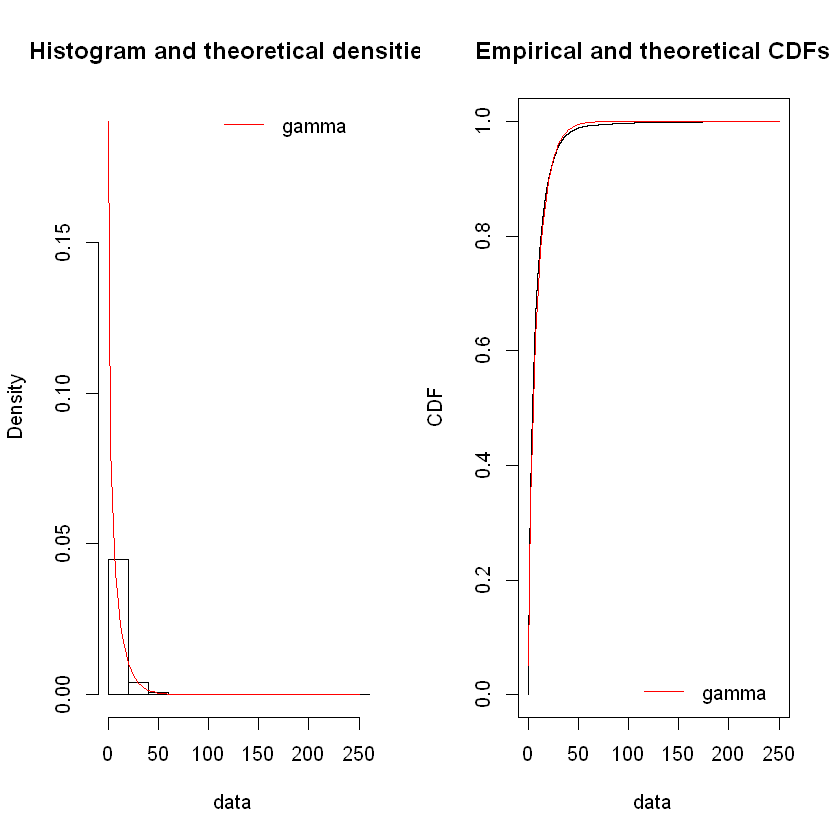

In [852]:
par(mfrow = c(1, 2))
denscomp(fd_GM_AugA)
#qqcomp(fd_GM_AugA)
cdfcomp(fd_GM_AugA)
#ppcomp(fd_GM_AugA)

In [853]:
fdGM_AugA_shape <- fd_GM_AugA$estimate[["shape"]]
fdGM_AugA_rate <- fd_GM_AugA$estimate[["rate"]]
fdGM_AugA_llike <- fd_GM_AugA$loglik
fdGM_AugA_mean <- fdGM_AugA_shape / fdGM_AugA_rate
fdGM_AugA_var <- fdGM_AugA_shape / ( fdGM_AugA_rate ^ 2 )
cat(" Aug A shape: ", fdGM_AugA_shape, "\n", "Aug A rate: ", fdGM_AugA_rate, 
    "\n", "Aug A loglikelihood: ", fdGM_AugA_llike, "\n", 
    "Aug A mean: ", fdGM_AugA_mean, "\n",
    "Aug A variance: ", fdGM_AugA_var, "\n" )

 Aug A shape:  0.76383 
 Aug A rate:  0.09069055 
 Aug A loglikelihood:  -130858.4 
 Aug A mean:  8.422376 
 Aug A variance:  92.86939 


In [854]:
statRes <- gofstat( fd_GM_AugA, fitnames=c("Gamma") )

In [855]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.05371821
Cramer-von Mises statistic    57.53010911
Anderson-Darling statistic   357.09569315

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 261720.8
Bayesian Information Criterion 261738.1


In [856]:
ksRes <- ks.test( dfAug$Precip_mm, "pgamma", shape=fdGM_AugA_shape, rate=fdGM_AugA_rate )

Warning message in ks.test(dfAug$Precip_mm, "pgamma", shape = fdGM_AugA_shape, rate = fdGM_AugA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [857]:
fdGM_AugA_KSStat <- ksRes$statistic
fdGM_AugA_KSp <- ksRes$p.value
cat(" Aug A K-S stat: ", fdGM_AugA_KSStat, "\n",
    "Aug A K-S p-value: ", fdGM_AugA_KSp )

 Aug A K-S stat:  0.05371821 
 Aug A K-S p-value:  0

**Mixed Exponential**

In [858]:
fd_ME_AugA <- expRMM_EM( dfAug$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfAug$Precip_mm), 1.0/mean(dfAug$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 527 


In [859]:
summary( fd_ME_AugA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.622834 0.3771661
rate   0.249866 0.0635968
loglik at estimate:  -129366.6 
0 % of the data right censored


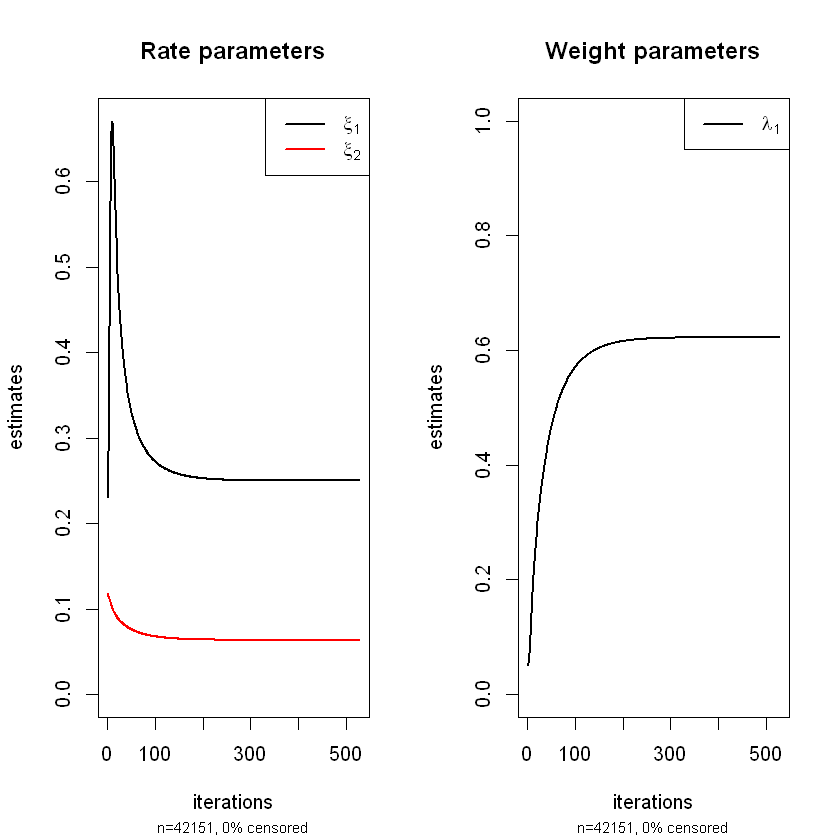

In [860]:
plotexpRMM( fd_ME_AugA, lwd=2 )

In [861]:
fdME_AugA_rate1 <- fd_ME_AugA$rate[[1]]
fdME_AugA_rate2 <- fd_ME_AugA$rate[[2]]
fdME_AugA_lambda <- fd_ME_AugA$lambda[[1]]
fdME_AugA_mean1 <- 1.0 / fdME_AugA_rate1
fdME_AugA_mean2 <- 1.0 / fdME_AugA_rate2
fdME_AugA_mean <- ( (fdME_AugA_lambda * fdME_AugA_mean1) + 
                    ( ( 1.0 - fdME_AugA_lambda) * fdME_AugA_mean2 ) )
fdME_AugA_var1 <- 1.0 / (fdME_AugA_rate1 ^ 2)
fdME_AugA_var2 <- 1.0 / (fdME_AugA_rate2 ^ 2)
fdME_AugA_var <- ( (fdME_AugA_lambda * ( fdME_AugA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_AugA_lambda) * (fdME_AugA_mean2 ^ 2) ) + 
                   ( fdME_AugA_lambda * ( 1.0 - fdME_AugA_lambda) * 
                       ( fdME_AugA_mean1 - fdME_AugA_mean2 )^2 ) )
fdME_AugA_llike <- fd_ME_AugA$loglik
cat(" Aug A rate1: ", fdME_AugA_rate1, "\n", 
    "Aug A rate2: ", fdME_AugA_rate2, "\n",
    "Aug A lambda: ", fdME_AugA_lambda, "\n",
    "Aug A mean1: ", fdME_AugA_mean1, "\n",
    "Aug A mean2: ", fdME_AugA_mean2, "\n",
    "Aug A mean: ", fdME_AugA_mean, "\n",
    "Aug A var1: ", fdME_AugA_var1, "\n",
    "Aug A var2: ", fdME_AugA_var2, "\n",
    "Aug A var: ", fdME_AugA_var, "\n",
    "Aug A loglikelihood: ", fdME_AugA_llike, "\n" )

 Aug A rate1:  0.2498657 
 Aug A rate2:  0.06359678 
 Aug A lambda:  0.6228339 
 Aug A mean1:  4.002149 
 Aug A mean2:  15.72407 
 Aug A mean:  8.423259 
 Aug A var1:  16.0172 
 Aug A var2:  247.2463 
 Aug A var:  135.5066 
 Aug A loglikelihood:  -129366.6 


In [862]:
tvals <- rexpmix(length(dfAug$Precip_mm), fd_ME_AugA$lambda, fd_ME_AugA$rate )

In [863]:
ksRes <- ks.test( dfAug$Precip_mm, tvals )

Warning message in ks.test(dfAug$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [864]:
fdME_AugA_KSStat <- ksRes$statistic
fdME_AugA_KSp <- ksRes$p.value
cat(" Aug A K-S stat: ", fdME_AugA_KSStat, "\n",
    "Aug A K-S p-value: ", fdME_AugA_KSp )

 Aug A K-S stat:  0.03485089 
 Aug A K-S p-value:  0

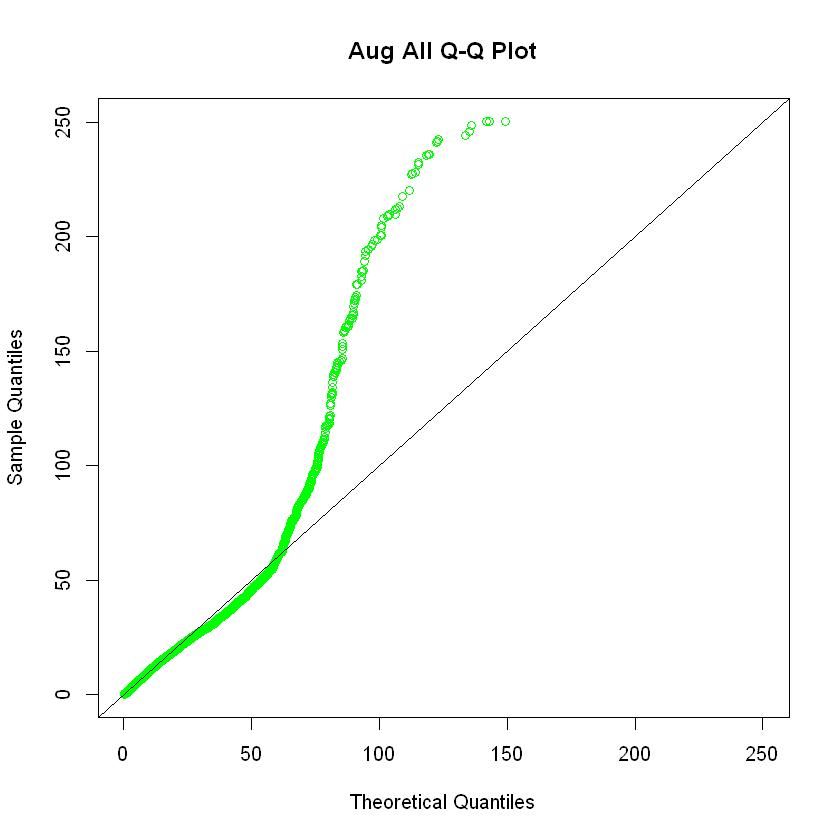

In [865]:
wAugAMax <- max( max( dfAug$Precip_mm ), max( tvals ) )
qqplot( tvals, dfAug$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Aug All Q-Q Plot",
        xlim=c(0,wAugAMax), ylim=c(0,wAugAMax) )
abline( 0, 1)

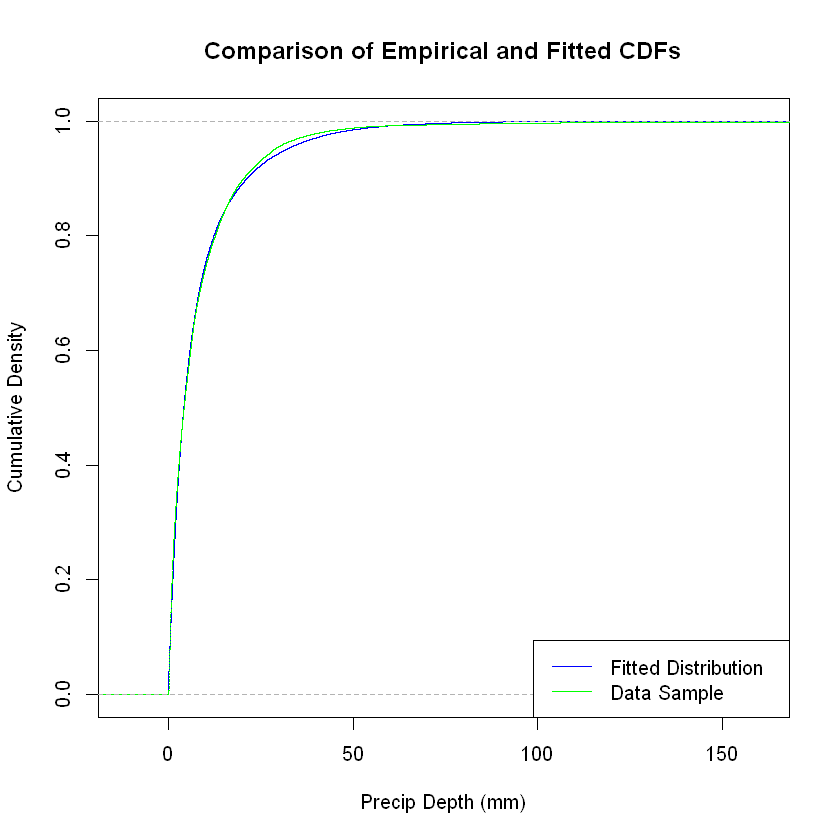

In [866]:
x <- seq(0,wAugAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfAug$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [867]:
MonDistDF[36, ] <- list( 8, 0, fdGM_AugA_shape, fdGM_AugA_rate, fdGM_AugA_llike, fdGM_AugA_mean,
                        fdGM_AugA_var, fdGM_AugA_KSStat, fdGM_AugA_KSp, fdME_AugA_rate1,
                        fdME_AugA_rate2, fdME_AugA_lambda, fdME_AugA_mean1, fdME_AugA_mean2,
                        fdME_AugA_mean, fdME_AugA_var1, fdME_AugA_var2, fdME_AugA_var,
                        fdME_AugA_llike, fdME_AugA_KSStat, fdME_AugA_KSp )

#### Region 1

**Gamma**

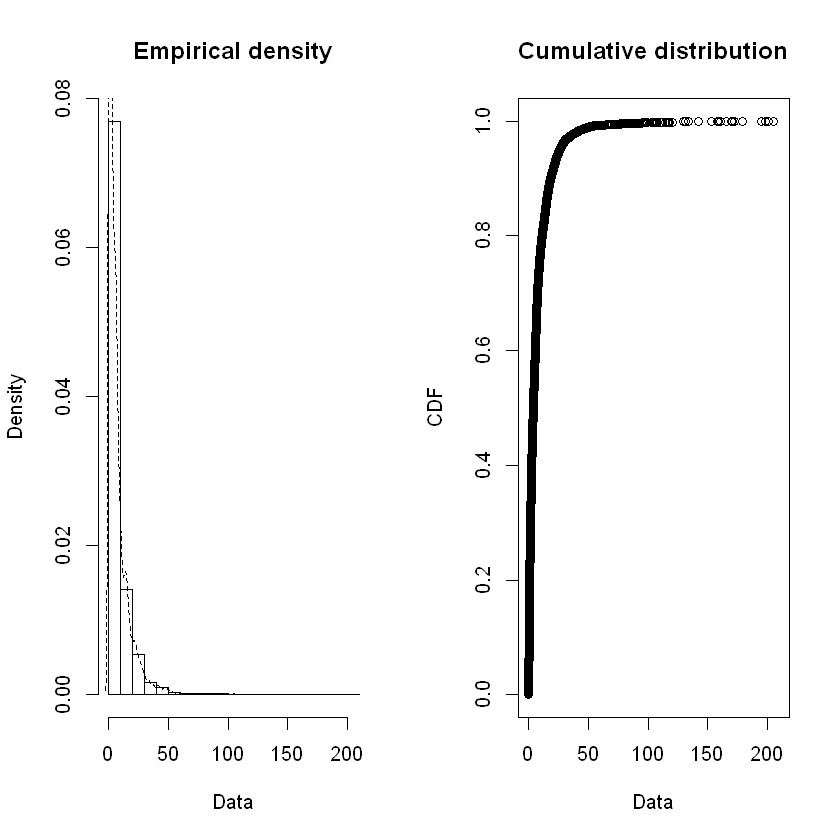

In [868]:
plotdist( dfAug1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  204.78 
median:  4.13 
mean:  7.735876 
estimated sd:  11.79088 
estimated skewness:  5.636947 
estimated kurtosis:  58.48692 

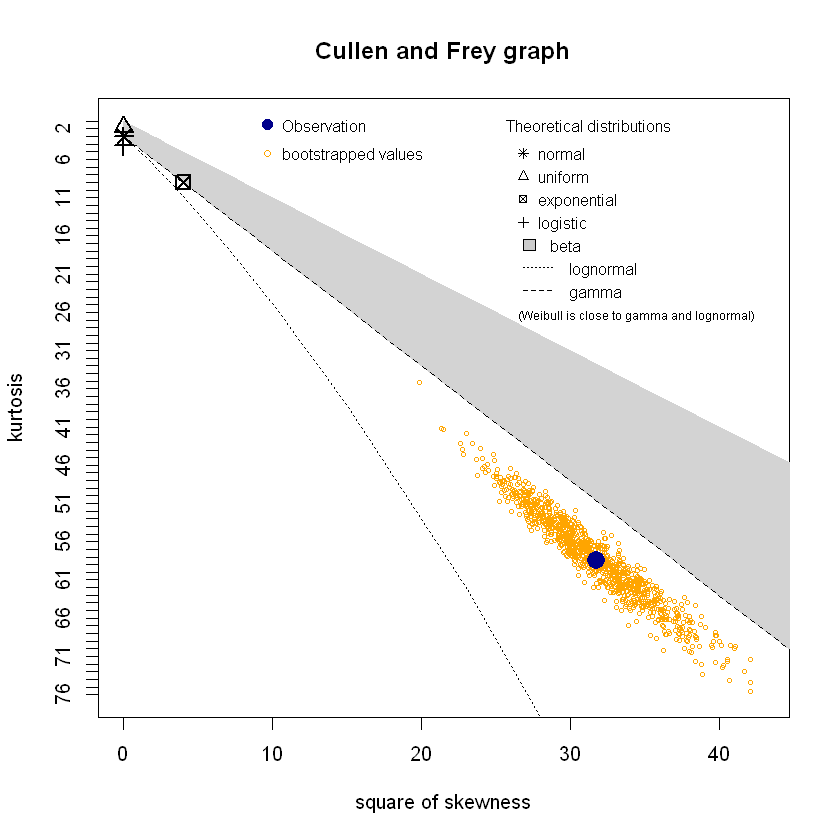

In [869]:
descdist( dfAug1$Precip_mm, boot=1000 )

In [870]:
fd_GM_Aug1 <- fitdist( dfAug1$Precip_mm, "gamma" )

In [871]:
summary( fd_GM_Aug1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8023814 0.007657841
rate  0.1037248 0.001341462
Loglikelihood:  -49522.79   AIC:  99049.59   BIC:  99064.99 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7378403
rate  0.7378403 1.0000000


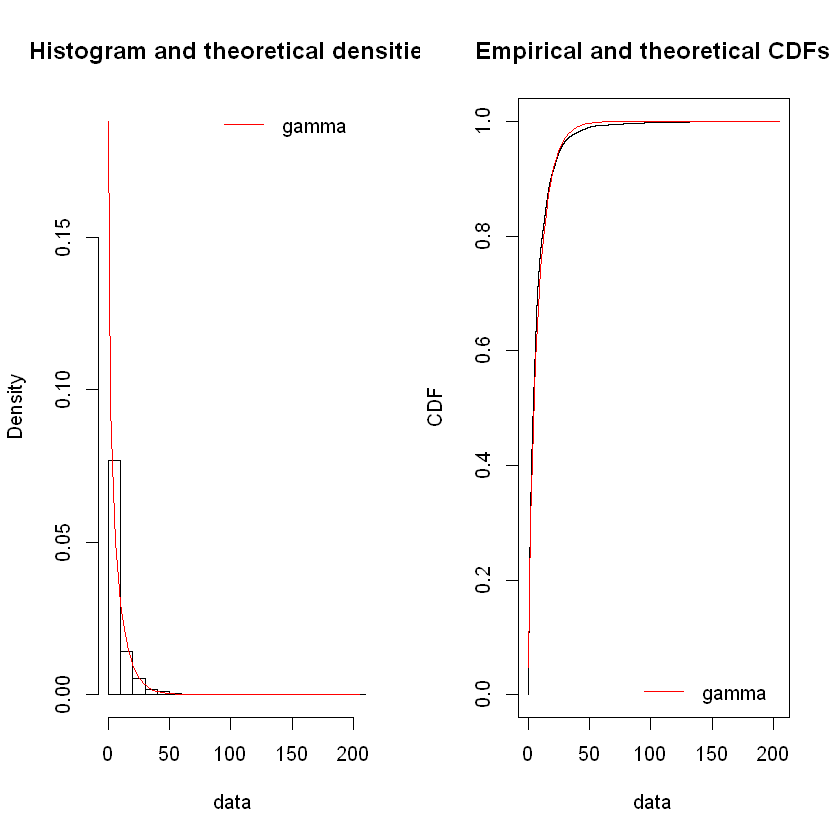

In [872]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Aug1)
#qqcomp(fd_GM_Aug1)
cdfcomp(fd_GM_Aug1)
#ppcomp(fd_GM_Aug1)

In [873]:
fdGM_Aug1_shape <- fd_GM_Aug1$estimate[["shape"]]
fdGM_Aug1_rate <- fd_GM_Aug1$estimate[["rate"]]
fdGM_Aug1_llike <- fd_GM_Aug1$loglik
fdGM_Aug1_mean <- fdGM_Aug1_shape / fdGM_Aug1_rate
fdGM_Aug1_var <- fdGM_Aug1_shape / ( fdGM_Aug1_rate ^ 2 )
cat(" Aug 1 shape: ", fdGM_Aug1_shape, "\n", "Aug 1 rate: ", fdGM_Aug1_rate, 
    "\n", "Aug 1 loglikelihood: ", fdGM_Aug1_llike, "\n", 
    "Aug 1 mean: ", fdGM_Aug1_mean, "\n",
    "Aug 1 variance: ", fdGM_Aug1_var, "\n" )

 Aug 1 shape:  0.8023814 
 Aug 1 rate:  0.1037248 
 Aug 1 loglikelihood:  -49522.79 
 Aug 1 mean:  7.735677 
 Aug 1 variance:  74.57887 


In [874]:
statRes <- gofstat( fd_GM_Aug1, fitnames=c("Gamma") )

In [875]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.05817706
Cramer-von Mises statistic    23.47136008
Anderson-Darling statistic   145.10936211

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 99049.59
Bayesian Information Criterion 99064.99


In [876]:
ksRes <- ks.test( dfAug1$Precip_mm, "pgamma", shape=fdGM_Aug1_shape, rate=fdGM_Aug1_rate )

Warning message in ks.test(dfAug1$Precip_mm, "pgamma", shape = fdGM_Aug1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [877]:
fdGM_Aug1_KSStat <- ksRes$statistic
fdGM_Aug1_KSp <- ksRes$p.value
cat(" Aug 1 K-S stat: ", fdGM_Aug1_KSStat, "\n",
    "Aug 1 K-S p-value: ", fdGM_Aug1_KSp )

 Aug 1 K-S stat:  0.05817706 
 Aug 1 K-S p-value:  0

**Mixed exponential**

In [878]:
fd_ME_Aug1 <- expRMM_EM( dfAug1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfAug1$Precip_mm), 1.0/mean(dfAug1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 513 


In [879]:
summary( fd_ME_Aug1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.710432 0.2895679
rate   0.228714 0.0625462
loglik at estimate:  -48917.52 
0 % of the data right censored


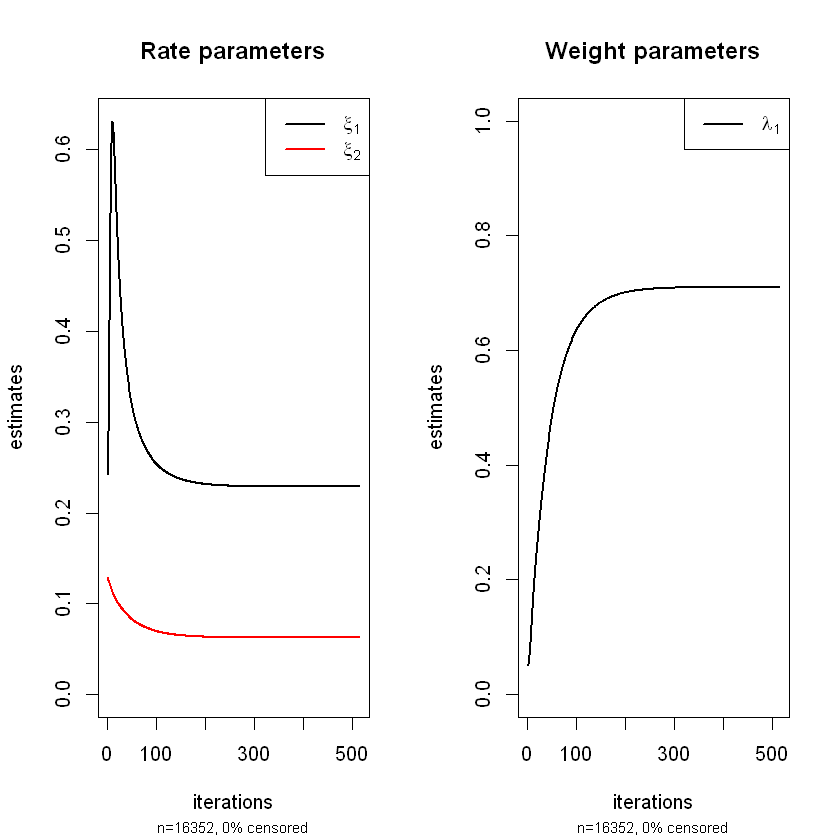

In [880]:
plotexpRMM( fd_ME_Aug1, lwd=2 )

In [881]:
fdME_Aug1_rate1 <- fd_ME_Aug1$rate[[1]]
fdME_Aug1_rate2 <- fd_ME_Aug1$rate[[2]]
fdME_Aug1_lambda <- fd_ME_Aug1$lambda[[1]]
fdME_Aug1_mean1 <- 1.0 / fdME_Aug1_rate1
fdME_Aug1_mean2 <- 1.0 / fdME_Aug1_rate2
fdME_Aug1_mean <- ( (fdME_Aug1_lambda * fdME_Aug1_mean1) + 
                    ( ( 1.0 - fdME_Aug1_lambda) * fdME_Aug1_mean2 ) )
fdME_Aug1_var1 <- 1.0 / (fdME_Aug1_rate1 ^ 2)
fdME_Aug1_var2 <- 1.0 / (fdME_Aug1_rate2 ^ 2)
fdME_Aug1_var <- ( (fdME_Aug1_lambda * ( fdME_Aug1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Aug1_lambda) * (fdME_Aug1_mean2 ^ 2) ) + 
                   ( fdME_Aug1_lambda * ( 1.0 - fdME_Aug1_lambda) * 
                       ( fdME_Aug1_mean1 - fdME_Aug1_mean2 )^2 ) )
fdME_Aug1_llike <- fd_ME_Aug1$loglik
cat(" Aug 1 rate1: ", fdME_Aug1_rate1, "\n", 
    "Aug 1 rate2: ", fdME_Aug1_rate2, "\n",
    "Aug 1 lambda: ", fdME_Aug1_lambda, "\n",
    "Aug 1 mean1: ", fdME_Aug1_mean1, "\n",
    "Aug 1 mean2: ", fdME_Aug1_mean2, "\n",
    "Aug 1 mean: ", fdME_Aug1_mean, "\n",
    "Aug 1 var1: ", fdME_Aug1_var1, "\n",
    "Aug 1 var2: ", fdME_Aug1_var2, "\n",
    "Aug 1 var: ", fdME_Aug1_var, "\n",
    "Aug 1 loglikelihood: ", fdME_Aug1_llike, "\n" )

 Aug 1 rate1:  0.2287136 
 Aug 1 rate2:  0.06254616 
 Aug 1 lambda:  0.7104321 
 Aug 1 mean1:  4.372281 
 Aug 1 mean2:  15.98819 
 Aug 1 mean:  7.735876 
 Aug 1 var1:  19.11684 
 Aug 1 var2:  255.6223 
 Aug 1 var:  115.3587 
 Aug 1 loglikelihood:  -48917.52 


In [882]:
tvals <- rexpmix(length(dfAug1$Precip_mm), fd_ME_Aug1$lambda, fd_ME_Aug1$rate )

In [883]:
ksRes <- ks.test( dfAug1$Precip_mm, tvals )

Warning message in ks.test(dfAug1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [884]:
fdME_Aug1_KSStat <- ksRes$statistic
fdME_Aug1_KSp <- ksRes$p.value
cat(" Aug 1 K-S stat: ", fdME_Aug1_KSStat, "\n",
    "Aug 1 K-S p-value: ", fdME_Aug1_KSp )

 Aug 1 K-S stat:  0.03742661 
 Aug 1 K-S p-value:  2.256715e-10

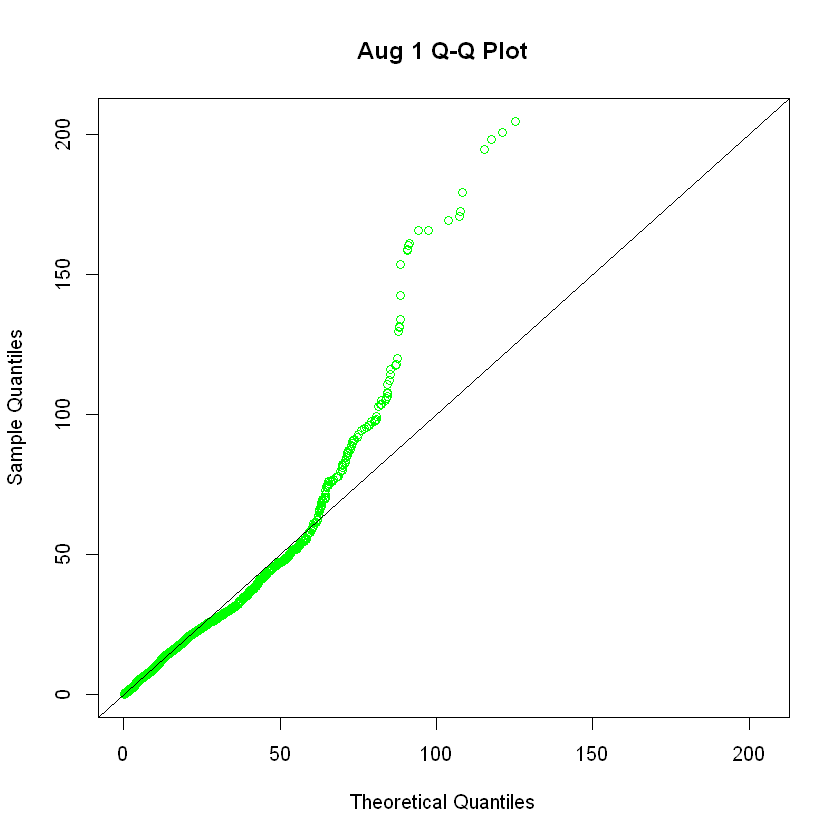

In [885]:
wAug1Max <- max( max( dfAug1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfAug1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Aug 1 Q-Q Plot",
        xlim=c(0,wAug1Max), ylim=c(0,wAug1Max) )
abline( 0, 1)

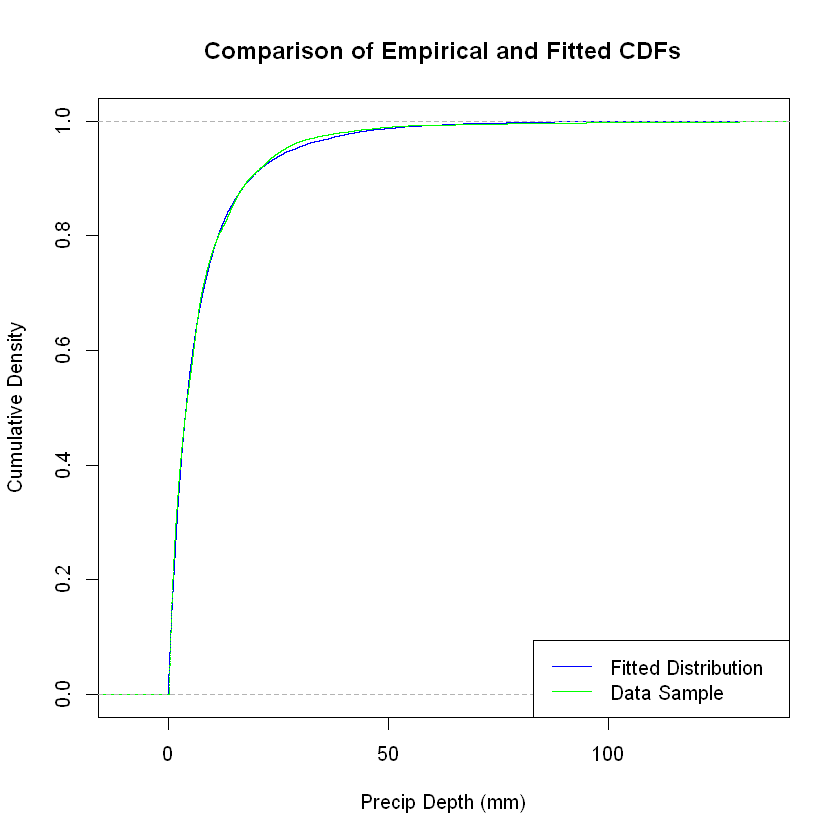

In [886]:
x <- seq(0,wAug1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfAug1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [887]:
MonDistDF[37, ] <- list( 8, 1, fdGM_Aug1_shape, fdGM_Aug1_rate, fdGM_Aug1_llike, fdGM_Aug1_mean,
                        fdGM_Aug1_var, fdGM_Aug1_KSStat, fdGM_Aug1_KSp, fdME_Aug1_rate1,
                        fdME_Aug1_rate2, fdME_Aug1_lambda, fdME_Aug1_mean1, fdME_Aug1_mean2,
                        fdME_Aug1_mean, fdME_Aug1_var1, fdME_Aug1_var2, fdME_Aug1_var,
                        fdME_Aug1_llike, fdME_Aug1_KSStat, fdME_Aug1_KSp )

#### Region 2

**Gamma**

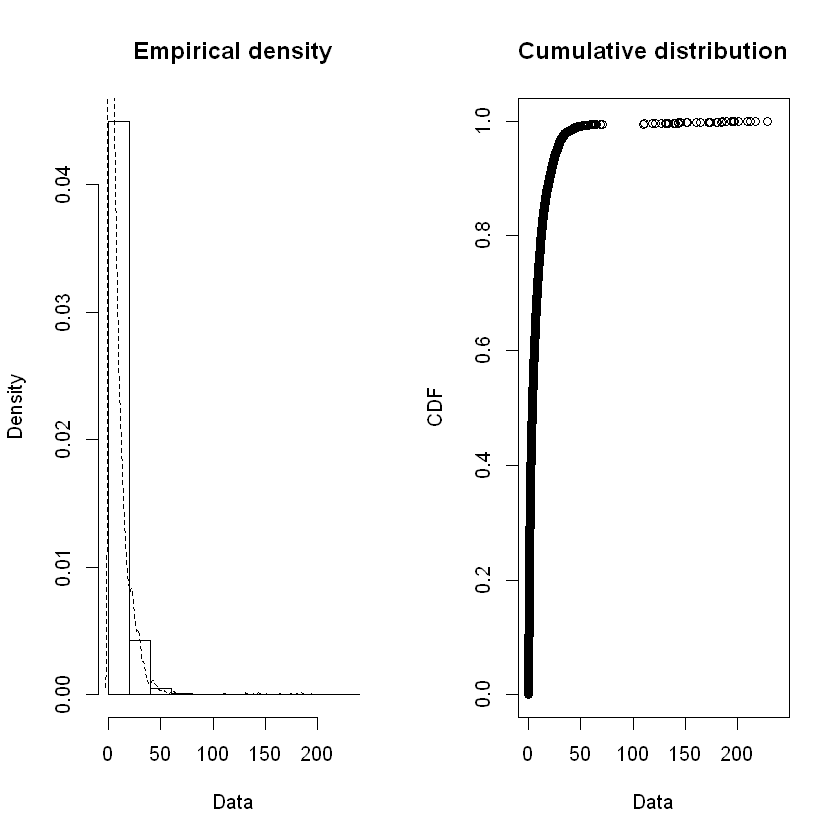

In [888]:
plotdist( dfAug2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  228.26 
median:  3.79 
mean:  8.038494 
estimated sd:  14.10828 
estimated skewness:  7.516211 
estimated kurtosis:  87.05325 

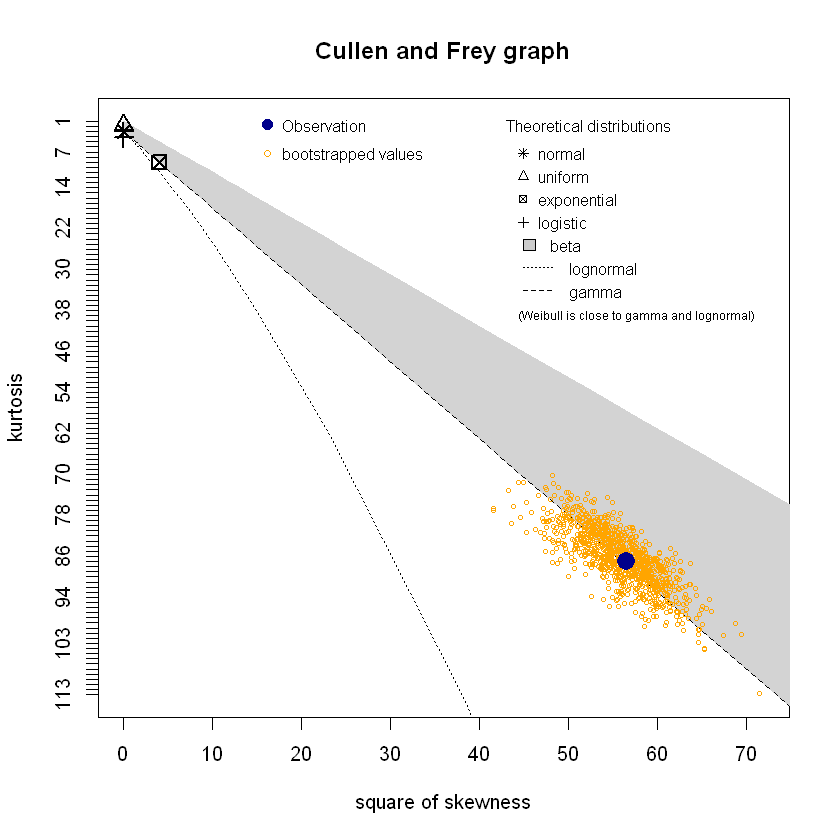

In [889]:
descdist( dfAug2$Precip_mm, boot=1000 )

In [890]:
fd_GM_Aug2 <- fitdist( dfAug2$Precip_mm, "gamma" )

In [891]:
summary( fd_GM_Aug2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.72406963 0.009742646
rate  0.09008626 0.001690334
Loglikelihood:  -24574.44   AIC:  49152.89   BIC:  49166.88 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7169575
rate  0.7169575 1.0000000


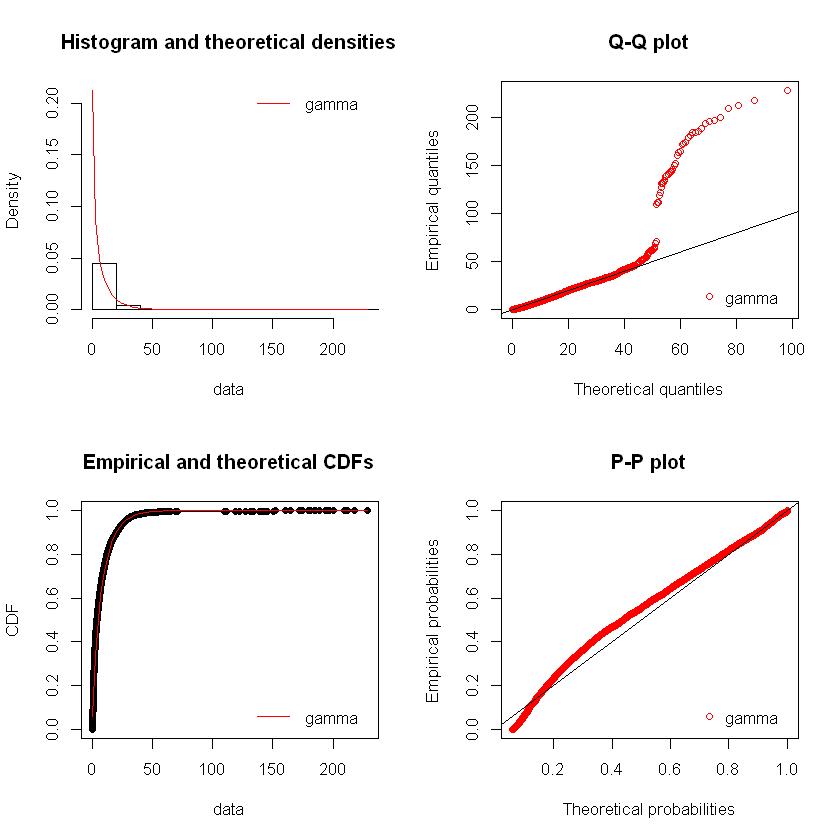

In [892]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Aug2)
qqcomp(fd_GM_Aug2)
cdfcomp(fd_GM_Aug2)
ppcomp(fd_GM_Aug2)

In [893]:
fdGM_Aug2_shape <- fd_GM_Aug2$estimate[["shape"]]
fdGM_Aug2_rate <- fd_GM_Aug2$estimate[["rate"]]
fdGM_Aug2_llike <- fd_GM_Aug2$loglik
fdGM_Aug2_mean <- fdGM_Aug2_shape / fdGM_Aug2_rate
fdGM_Aug2_var <- fdGM_Aug2_shape / ( fdGM_Aug2_rate ^ 2 )
cat(" Aug 2 shape: ", fdGM_Aug2_shape, "\n", "Aug 2 rate: ", fdGM_Aug2_rate, 
    "\n", "Aug 2 loglikelihood: ", fdGM_Aug2_llike, "\n", 
    "Aug 2 mean: ", fdGM_Aug2_mean, "\n",
    "Aug 2 variance: ", fdGM_Aug2_var, "\n" )

 Aug 2 shape:  0.7240696 
 Aug 2 rate:  0.09008626 
 Aug 2 loglikelihood:  -24574.44 
 Aug 2 mean:  8.037515 
 Aug 2 variance:  89.22021 


In [894]:
statRes <- gofstat( fd_GM_Aug2, fitnames=c("Gamma") )

In [895]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.07192994
Cramer-von Mises statistic   14.31603249
Anderson-Darling statistic   87.13886389

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 49152.89
Bayesian Information Criterion 49166.88


In [896]:
ksRes <- ks.test( dfAug2$Precip_mm, "pgamma", shape=fdGM_Aug2_shape, rate=fdGM_Aug2_rate )

Warning message in ks.test(dfAug2$Precip_mm, "pgamma", shape = fdGM_Aug2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [897]:
fdGM_Aug2_KSStat <- ksRes$statistic
fdGM_Aug2_KSp <- ksRes$p.value
cat(" Aug 2 K-S stat: ", fdGM_Aug2_KSStat, "\n",
    "Aug 2 K-S p-value: ", fdGM_Aug2_KSp )

 Aug 2 K-S stat:  0.07192994 
 Aug 2 K-S p-value:  0

**Mixed exponential**

In [898]:
fd_ME_Aug2 <- expRMM_EM( dfAug2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfAug2$Precip_mm), 1.0/mean(dfAug2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 247 


In [899]:
summary( fd_ME_Aug2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.468985 0.5310154
rate   0.406199 0.0771385
loglik at estimate:  -24246.85 
0 % of the data right censored


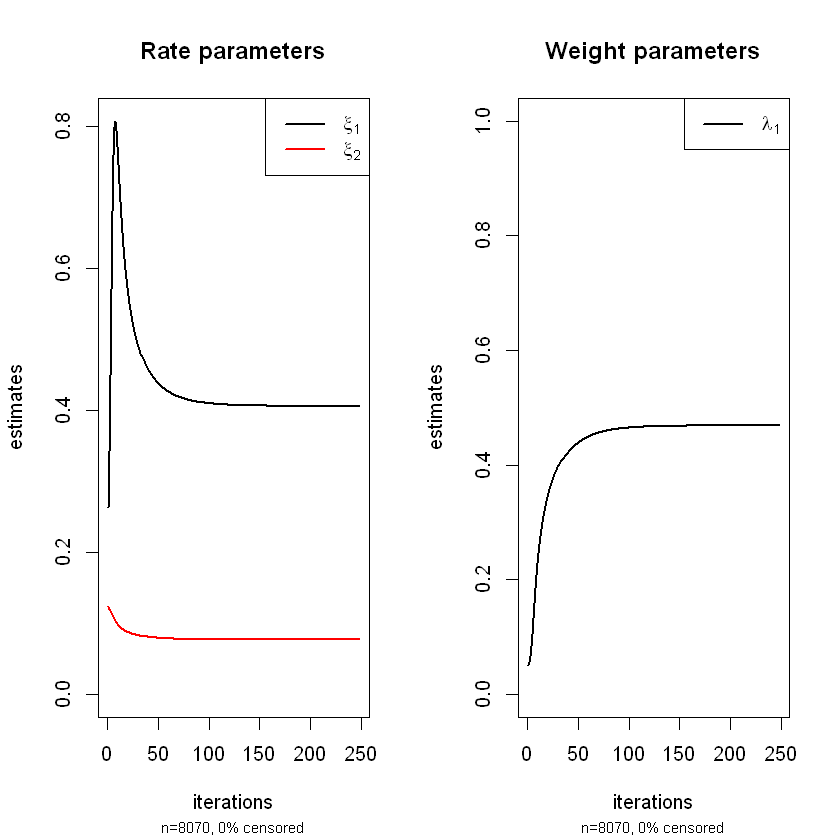

In [900]:
plotexpRMM( fd_ME_Aug2, lwd=2 )

In [901]:
fdME_Aug2_rate1 <- fd_ME_Aug2$rate[[1]]
fdME_Aug2_rate2 <- fd_ME_Aug2$rate[[2]]
fdME_Aug2_lambda <- fd_ME_Aug2$lambda[[1]]
fdME_Aug2_mean1 <- 1.0 / fdME_Aug2_rate1
fdME_Aug2_mean2 <- 1.0 / fdME_Aug2_rate2
fdME_Aug2_mean <- ( (fdME_Aug2_lambda * fdME_Aug2_mean1) + 
                    ( ( 1.0 - fdME_Aug2_lambda) * fdME_Aug2_mean2 ) )
fdME_Aug2_var1 <- 1.0 / (fdME_Aug2_rate1 ^ 2)
fdME_Aug2_var2 <- 1.0 / (fdME_Aug2_rate2 ^ 2)
fdME_Aug2_var <- ( (fdME_Aug2_lambda * ( fdME_Aug2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Aug2_lambda) * (fdME_Aug2_mean2 ^ 2) ) + 
                   ( fdME_Aug2_lambda * ( 1.0 - fdME_Aug2_lambda) * 
                       ( fdME_Aug2_mean1 - fdME_Aug2_mean2 )^2 ) )
fdME_Aug2_llike <- fd_ME_Aug2$loglik
cat(" Aug 2 rate1: ", fdME_Aug2_rate1, "\n", 
    "Aug 2 rate2: ", fdME_Aug2_rate2, "\n",
    "Aug 2 lambda: ", fdME_Aug2_lambda, "\n",
    "Aug 2 mean1: ", fdME_Aug2_mean1, "\n",
    "Aug 2 mean2: ", fdME_Aug2_mean2, "\n",
    "Aug 2 mean: ", fdME_Aug2_mean, "\n",
    "Aug 2 var1: ", fdME_Aug2_var1, "\n",
    "Aug 2 var2: ", fdME_Aug2_var2, "\n",
    "Aug 2 var: ", fdME_Aug2_var, "\n",
    "Aug 2 loglikelihood: ", fdME_Aug2_llike, "\n" )

 Aug 2 rate1:  0.4061986 
 Aug 2 rate2:  0.07713847 
 Aug 2 lambda:  0.4689846 
 Aug 2 mean1:  2.46185 
 Aug 2 mean2:  12.9637 
 Aug 2 mean:  8.038494 
 Aug 2 var1:  6.060706 
 Aug 2 var2:  168.0575 
 Aug 2 var:  119.5496 
 Aug 2 loglikelihood:  -24246.85 


In [902]:
tvals <- rexpmix(length(dfAug2$Precip_mm), fd_ME_Aug2$lambda, fd_ME_Aug2$rate )

In [903]:
ksRes <- ks.test( dfAug2$Precip_mm, tvals )

Warning message in ks.test(dfAug2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [904]:
fdME_Aug2_KSStat <- ksRes$statistic
fdME_Aug2_KSp <- ksRes$p.value
cat(" Aug 2 K-S stat: ", fdME_Aug2_KSStat, "\n",
    "Aug 2 K-S p-value: ", fdME_Aug2_KSp )

 Aug 2 K-S stat:  0.04522924 
 Aug 2 K-S p-value:  1.353331e-07

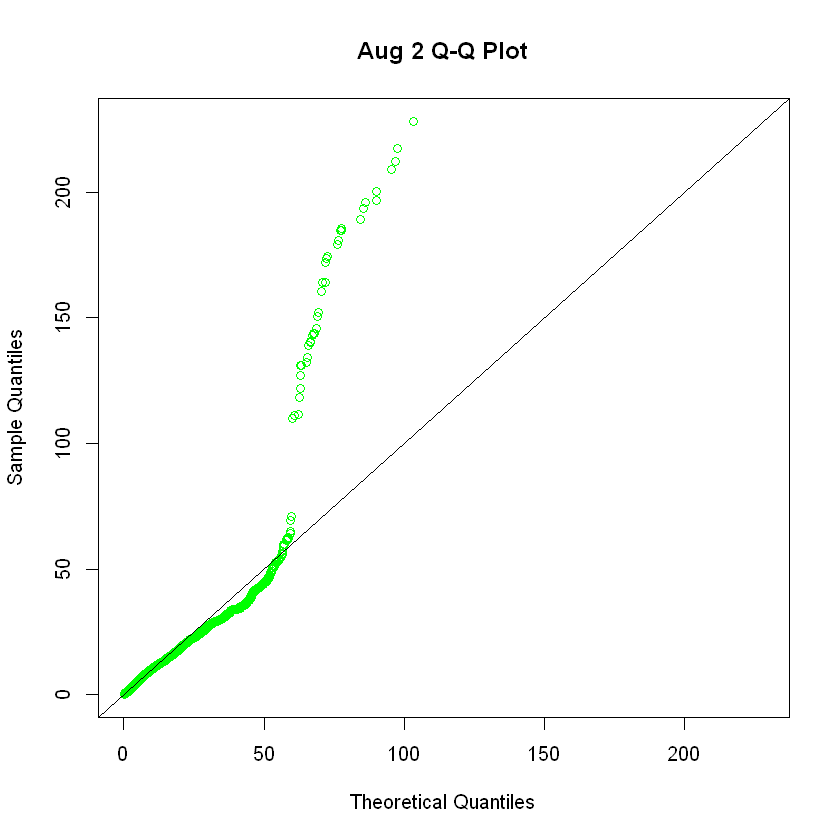

In [905]:
wAug2Max <- max( max( dfAug2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfAug2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Aug 2 Q-Q Plot",
        xlim=c(0,wAug2Max), ylim=c(0,wAug2Max) )
abline( 0, 1)

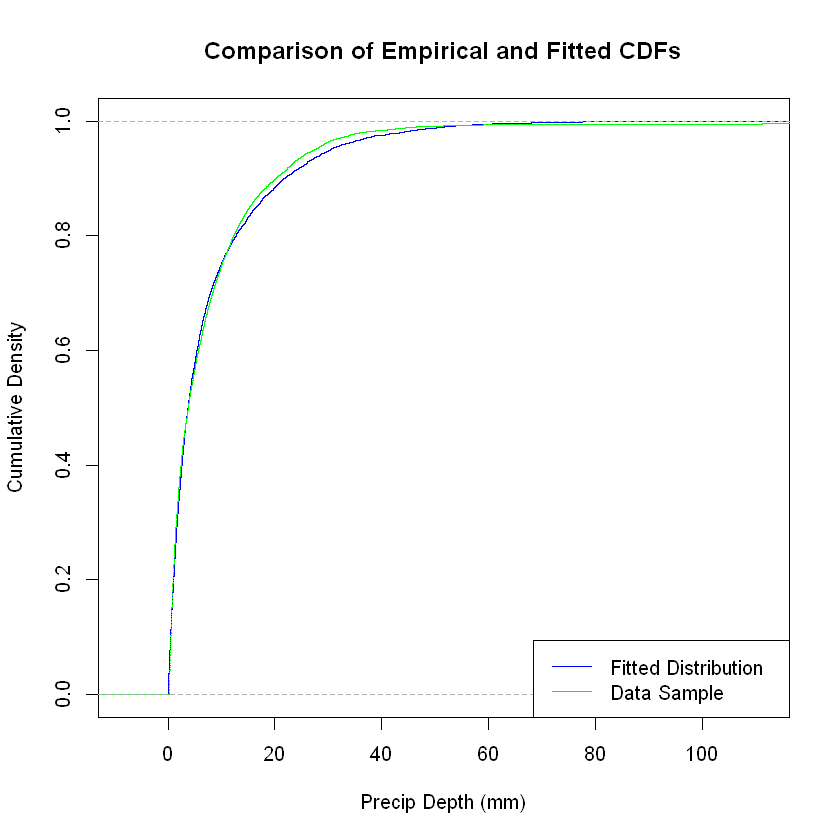

In [906]:
x <- seq(0,wAug2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfAug2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [907]:
MonDistDF[38, ] <- list( 8, 2, fdGM_Aug2_shape, fdGM_Aug2_rate, fdGM_Aug2_llike, fdGM_Aug2_mean,
                        fdGM_Aug2_var, fdGM_Aug2_KSStat, fdGM_Aug2_KSp, fdME_Aug2_rate1,
                        fdME_Aug2_rate2, fdME_Aug2_lambda, fdME_Aug2_mean1, fdME_Aug2_mean2,
                        fdME_Aug2_mean, fdME_Aug2_var1, fdME_Aug2_var2, fdME_Aug2_var,
                        fdME_Aug2_llike, fdME_Aug2_KSStat, fdME_Aug2_KSp )

#### Region 3

**Gamma**

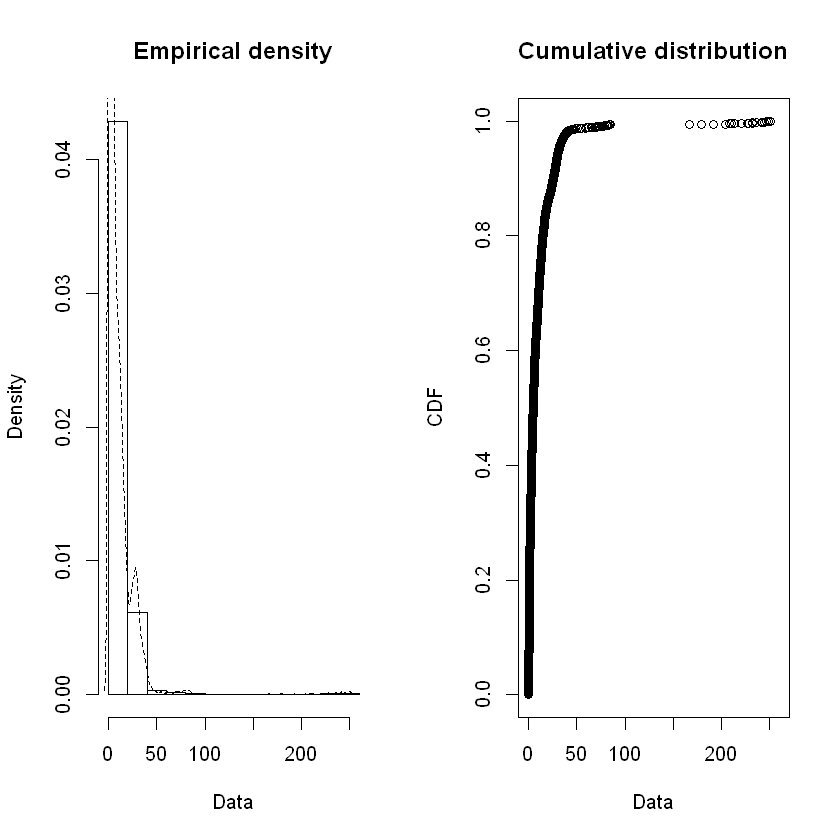

In [908]:
plotdist( dfAug3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  250.43 
median:  4.96 
mean:  10.28306 
estimated sd:  19.64665 
estimated skewness:  8.103211 
estimated kurtosis:  88.79415 

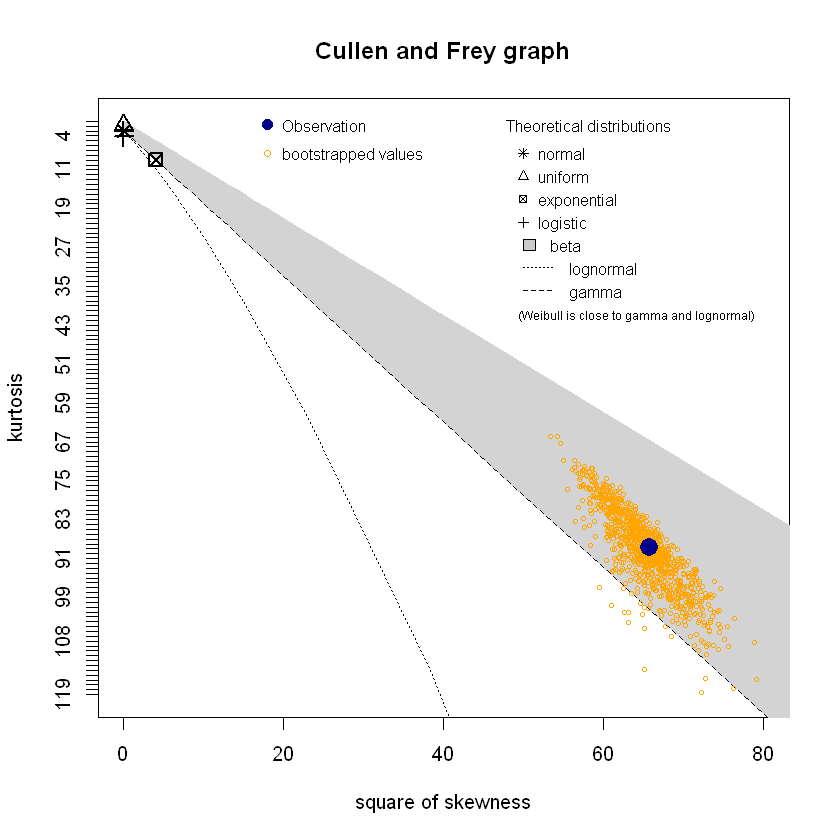

In [909]:
descdist( dfAug3$Precip_mm, boot=1000 )

In [910]:
fd_GM_Aug3 <- fitdist( dfAug3$Precip_mm, "gamma" )

In [911]:
summary( fd_GM_Aug3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.72377893 0.013725523
rate  0.07038905 0.001861494
Loglikelihood:  -13369.26   AIC:  26742.53   BIC:  26755.15 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7168368
rate  0.7168368 1.0000000


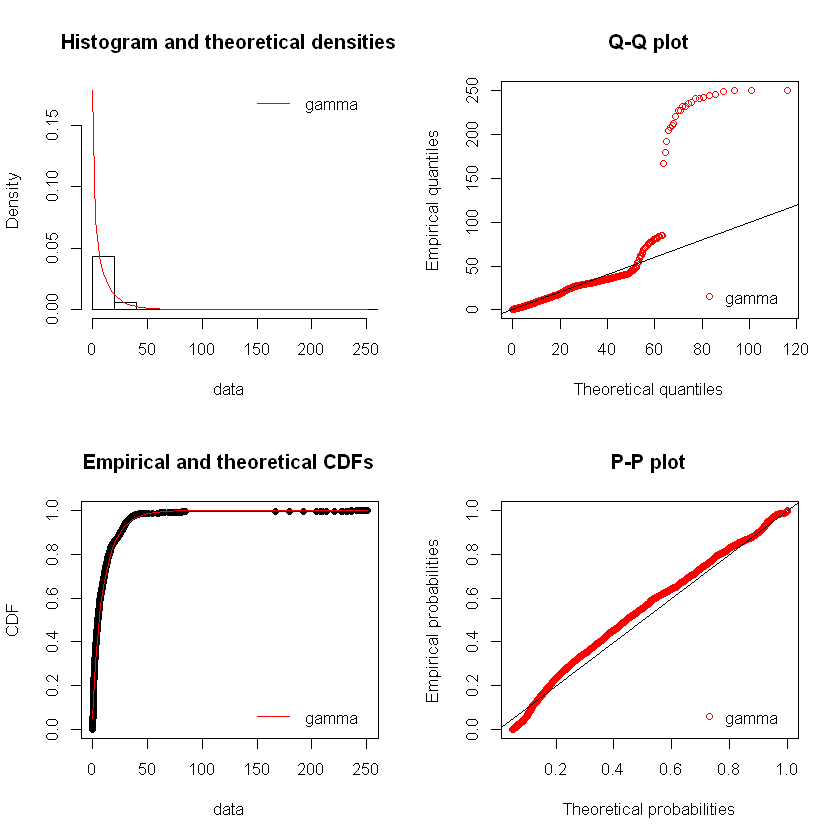

In [912]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Aug3)
qqcomp(fd_GM_Aug3)
cdfcomp(fd_GM_Aug3)
ppcomp(fd_GM_Aug3)

In [913]:
fdGM_Aug3_shape <- fd_GM_Aug3$estimate[["shape"]]
fdGM_Aug3_rate <- fd_GM_Aug3$estimate[["rate"]]
fdGM_Aug3_llike <- fd_GM_Aug3$loglik
fdGM_Aug3_mean <- fdGM_Aug3_shape / fdGM_Aug3_rate
fdGM_Aug3_var <- fdGM_Aug3_shape / ( fdGM_Aug3_rate ^ 2 )
cat(" Aug 3 shape: ", fdGM_Aug3_shape, "\n", "Aug 3 rate: ", fdGM_Aug3_rate, 
    "\n", "Aug 3 loglikelihood: ", fdGM_Aug3_llike, "\n", 
    "Aug 3 mean: ", fdGM_Aug3_mean, "\n",
    "Aug 3 variance: ", fdGM_Aug3_var, "\n" )

 Aug 3 shape:  0.7237789 
 Aug 3 rate:  0.07038905 
 Aug 3 loglikelihood:  -13369.26 
 Aug 3 mean:  10.28255 
 Aug 3 variance:  146.0817 


In [914]:
statRes <- gofstat( fd_GM_Aug3, fitnames=c("Gamma") )

In [915]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05949731
Cramer-von Mises statistic    5.98643689
Anderson-Darling statistic   39.01530263

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 26742.53
Bayesian Information Criterion 26755.15


In [916]:
ksRes <- ks.test( dfAug3$Precip_mm, "pgamma", shape=fdGM_Aug3_shape, rate=fdGM_Aug3_rate )

Warning message in ks.test(dfAug3$Precip_mm, "pgamma", shape = fdGM_Aug3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [917]:
fdGM_Aug3_KSStat <- ksRes$statistic
fdGM_Aug3_KSp <- ksRes$p.value
cat(" Aug 3 K-S stat: ", fdGM_Aug3_KSStat, "\n",
    "Aug 3 K-S p-value: ", fdGM_Aug3_KSp )

 Aug 3 K-S stat:  0.05949731 
 Aug 3 K-S p-value:  6.478151e-13

**Mixed exponential**

In [918]:
fd_ME_Aug3 <- expRMM_EM( dfAug3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfAug3$Precip_mm), 1.0/mean(dfAug3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 988 


In [919]:
summary( fd_ME_Aug3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.620236 0.3797644
rate   0.217667 0.0510876
loglik at estimate:  -13222.29 
0 % of the data right censored


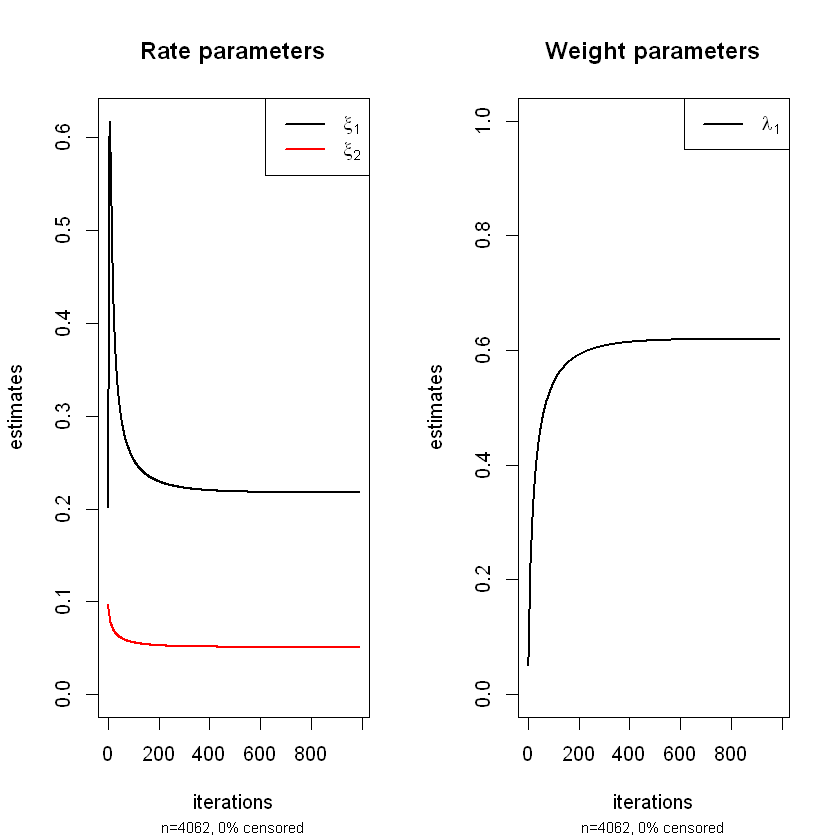

In [920]:
plotexpRMM( fd_ME_Aug3, lwd=2 )

In [921]:
fdME_Aug3_rate1 <- fd_ME_Aug3$rate[[1]]
fdME_Aug3_rate2 <- fd_ME_Aug3$rate[[2]]
fdME_Aug3_lambda <- fd_ME_Aug3$lambda[[1]]
fdME_Aug3_mean1 <- 1.0 / fdME_Aug3_rate1
fdME_Aug3_mean2 <- 1.0 / fdME_Aug3_rate2
fdME_Aug3_mean <- ( (fdME_Aug3_lambda * fdME_Aug3_mean1) + 
                    ( ( 1.0 - fdME_Aug3_lambda) * fdME_Aug3_mean2 ) )
fdME_Aug3_var1 <- 1.0 / (fdME_Aug3_rate1 ^ 2)
fdME_Aug3_var2 <- 1.0 / (fdME_Aug3_rate2 ^ 2)
fdME_Aug3_var <- ( (fdME_Aug3_lambda * ( fdME_Aug3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Aug3_lambda) * (fdME_Aug3_mean2 ^ 2) ) + 
                   ( fdME_Aug3_lambda * ( 1.0 - fdME_Aug3_lambda) * 
                       ( fdME_Aug3_mean1 - fdME_Aug3_mean2 )^2 ) )
fdME_Aug3_llike <- fd_ME_Aug3$loglik
cat(" Aug 3 rate1: ", fdME_Aug3_rate1, "\n", 
    "Aug 3 rate2: ", fdME_Aug3_rate2, "\n",
    "Aug 3 lambda: ", fdME_Aug3_lambda, "\n",
    "Aug 3 mean1: ", fdME_Aug3_mean1, "\n",
    "Aug 3 mean2: ", fdME_Aug3_mean2, "\n",
    "Aug 3 mean: ", fdME_Aug3_mean, "\n",
    "Aug 3 var1: ", fdME_Aug3_var1, "\n",
    "Aug 3 var2: ", fdME_Aug3_var2, "\n",
    "Aug 3 var: ", fdME_Aug3_var, "\n",
    "Aug 3 loglikelihood: ", fdME_Aug3_llike, "\n" )

 Aug 3 rate1:  0.2176672 
 Aug 3 rate2:  0.05108759 
 Aug 3 lambda:  0.6202356 
 Aug 3 mean1:  4.594168 
 Aug 3 mean2:  19.57422 
 Aug 3 mean:  10.28306 
 Aug 3 var1:  21.10638 
 Aug 3 var2:  383.1502 
 Aug 3 var:  211.4542 
 Aug 3 loglikelihood:  -13222.29 


In [922]:
tvals <- rexpmix(length(dfAug3$Precip_mm), fd_ME_Aug3$lambda, fd_ME_Aug3$rate )

In [923]:
ksRes <- ks.test( dfAug3$Precip_mm, tvals )

Warning message in ks.test(dfAug3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [924]:
fdME_Aug3_KSStat <- ksRes$statistic
fdME_Aug3_KSp <- ksRes$p.value
cat(" Aug 3 K-S stat: ", fdME_Aug3_KSStat, "\n",
    "Aug 3 K-S p-value: ", fdME_Aug3_KSp )

 Aug 3 K-S stat:  0.04948301 
 Aug 3 K-S p-value:  9.582964e-05

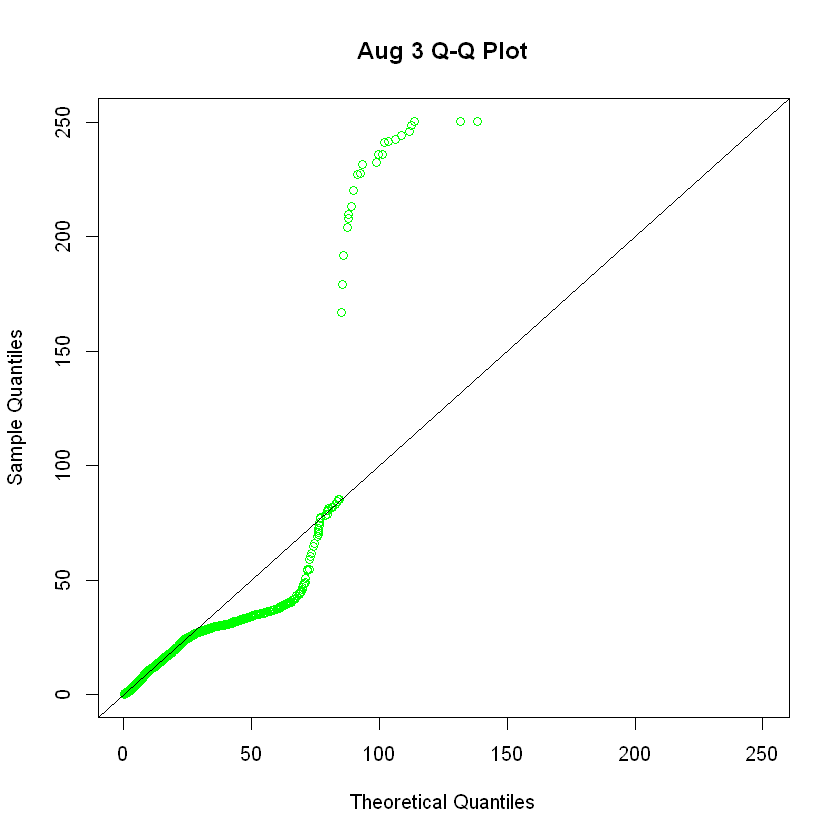

In [925]:
wAug3Max <- max( max( dfAug3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfAug3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Aug 3 Q-Q Plot",
        xlim=c(0,wAug3Max), ylim=c(0,wAug3Max) )
abline( 0, 1)

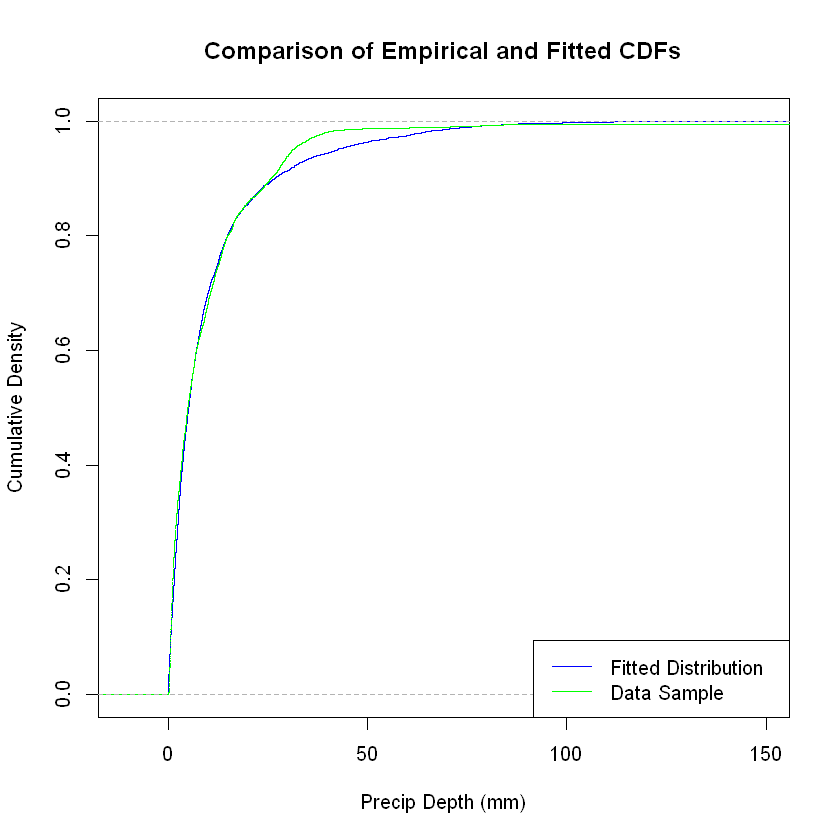

In [926]:
x <- seq(0,wAug3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfAug3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [927]:
MonDistDF[39, ] <- list( 8, 3, fdGM_Aug3_shape, fdGM_Aug3_rate, fdGM_Aug3_llike, fdGM_Aug3_mean,
                        fdGM_Aug3_var, fdGM_Aug3_KSStat, fdGM_Aug3_KSp, fdME_Aug3_rate1,
                        fdME_Aug3_rate2, fdME_Aug3_lambda, fdME_Aug3_mean1, fdME_Aug3_mean2,
                        fdME_Aug3_mean, fdME_Aug3_var1, fdME_Aug3_var2, fdME_Aug3_var,
                        fdME_Aug3_llike, fdME_Aug3_KSStat, fdME_Aug3_KSp )

#### Region 4

**Gamma**

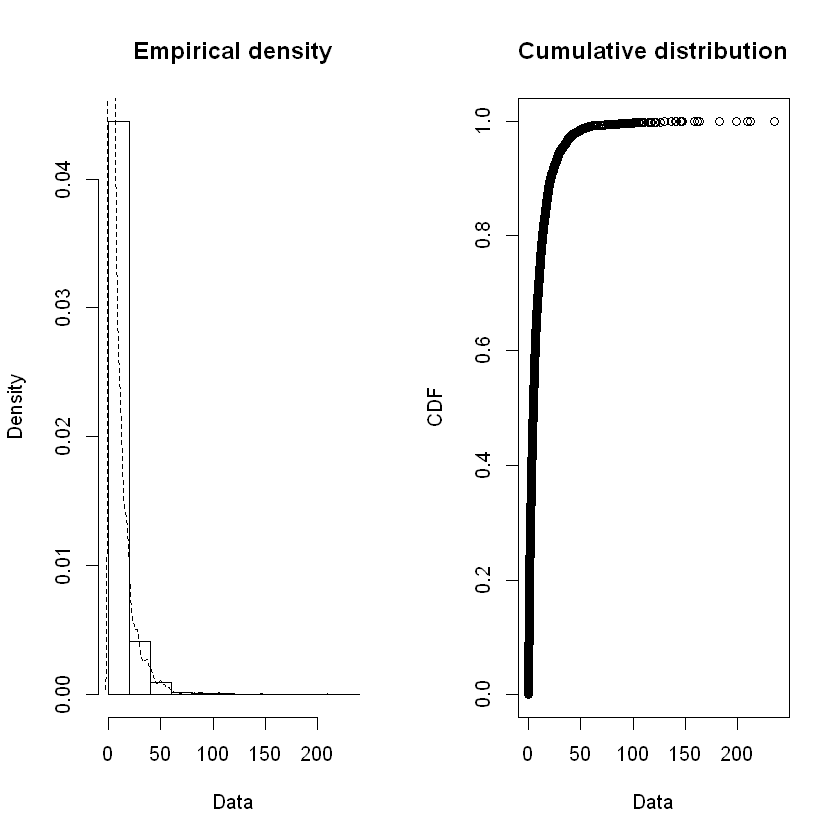

In [928]:
plotdist( dfAug4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  235.47 
median:  4.71 
mean:  8.920121 
estimated sd:  13.12226 
estimated skewness:  4.933431 
estimated kurtosis:  47.34777 

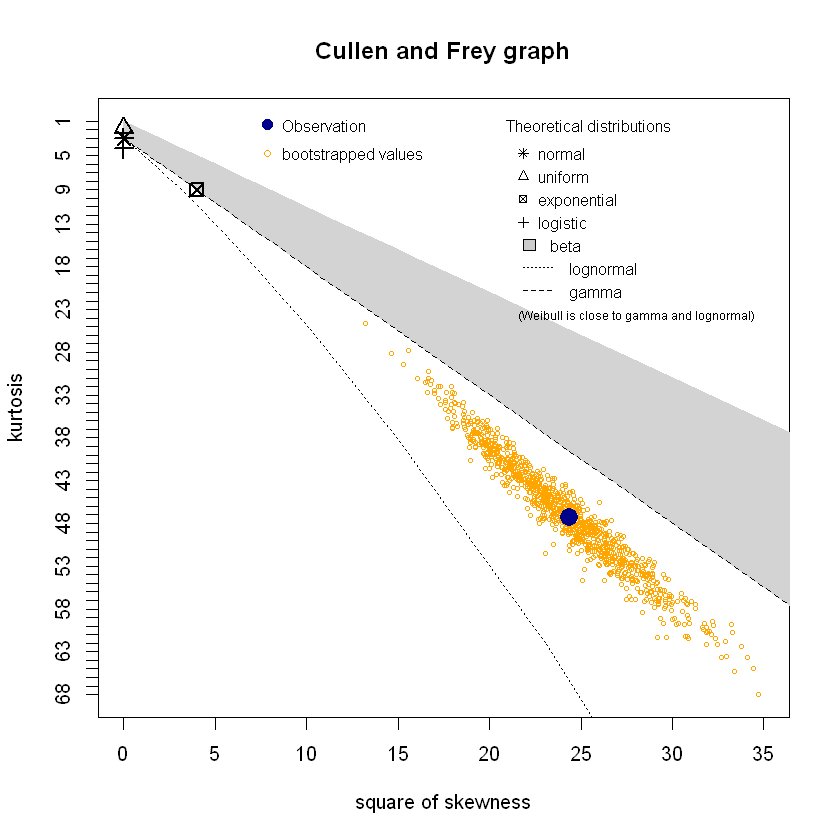

In [929]:
descdist( dfAug4$Precip_mm, boot=1000 )

In [930]:
fd_GM_Aug4 <- fitdist( dfAug4$Precip_mm, "gamma" )

In [931]:
summary( fd_GM_Aug4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.76954268 0.008002089
rate  0.08626194 0.001229455
Loglikelihood:  -43232.31   AIC:  86468.62   BIC:  86483.66 
Correlation matrix:
         shape     rate
shape 1.000000 0.729424
rate  0.729424 1.000000


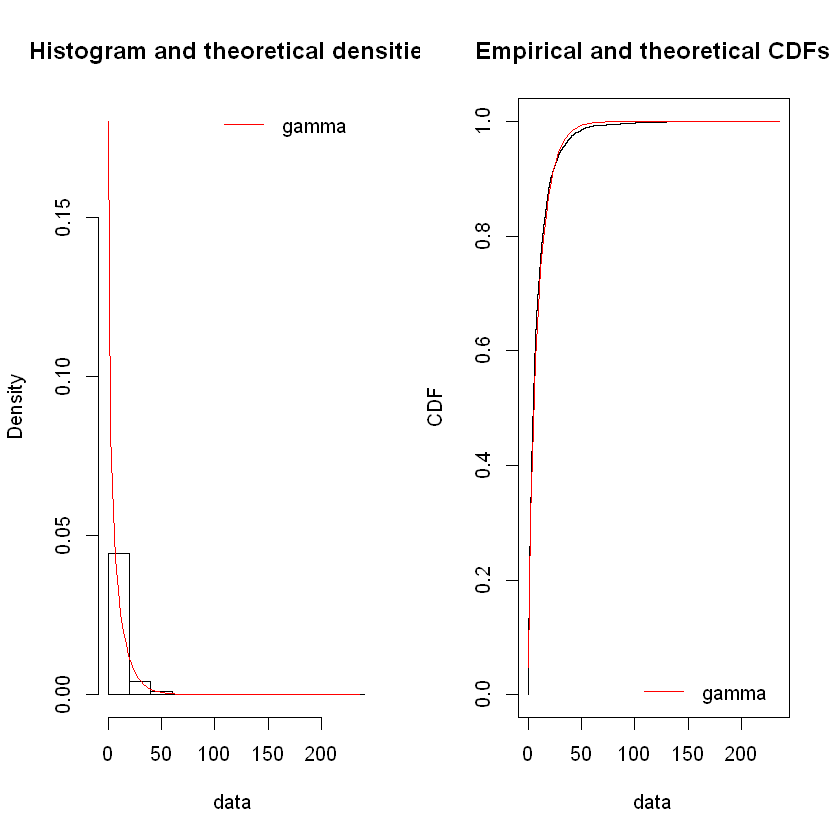

In [932]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Aug4)
#qqcomp(fd_GM_Aug4)
cdfcomp(fd_GM_Aug4)
#ppcomp(fd_GM_Aug4)

In [933]:
fdGM_Aug4_shape <- fd_GM_Aug4$estimate[["shape"]]
fdGM_Aug4_rate <- fd_GM_Aug4$estimate[["rate"]]
fdGM_Aug4_llike <- fd_GM_Aug4$loglik
fdGM_Aug4_mean <- fdGM_Aug4_shape / fdGM_Aug4_rate
fdGM_Aug4_var <- fdGM_Aug4_shape / ( fdGM_Aug4_rate ^ 2 )
cat(" Aug 4 shape: ", fdGM_Aug4_shape, "\n", "Aug 4 rate: ", fdGM_Aug4_rate, 
    "\n", "Aug 4 loglikelihood: ", fdGM_Aug4_llike, "\n", 
    "Aug 4 mean: ", fdGM_Aug4_mean, "\n",
    "Aug 4 variance: ", fdGM_Aug4_var, "\n" )

 Aug 4 shape:  0.7695427 
 Aug 4 rate:  0.08626194 
 Aug 4 loglikelihood:  -43232.31 
 Aug 4 mean:  8.920999 
 Aug 4 variance:  103.4176 


In [934]:
statRes <- gofstat( fd_GM_Aug4, fitnames=c("Gamma") )

In [935]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.05207887
Cramer-von Mises statistic   14.40807084
Anderson-Darling statistic   92.58484805

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 86468.62
Bayesian Information Criterion 86483.66


In [936]:
ksRes <- ks.test( dfAug4$Precip_mm, "pgamma", shape=fdGM_Aug4_shape, rate=fdGM_Aug4_rate )

Warning message in ks.test(dfAug4$Precip_mm, "pgamma", shape = fdGM_Aug4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [937]:
fdGM_Aug4_KSStat <- ksRes$statistic
fdGM_Aug4_KSp <- ksRes$p.value
cat(" Aug 4 K-S stat: ", fdGM_Aug4_KSStat, "\n",
    "Aug 4 K-S p-value: ", fdGM_Aug4_KSp )

 Aug 4 K-S stat:  0.05207887 
 Aug 4 K-S p-value:  0

**Mixed exponential**

In [938]:
fd_ME_Aug4 <- expRMM_EM( dfAug4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfAug4$Precip_mm), 1.0/mean(dfAug4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 515 


In [939]:
summary( fd_ME_Aug4 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.593378 0.406622
rate   0.238754 0.063191
loglik at estimate:  -42834.25 
0 % of the data right censored


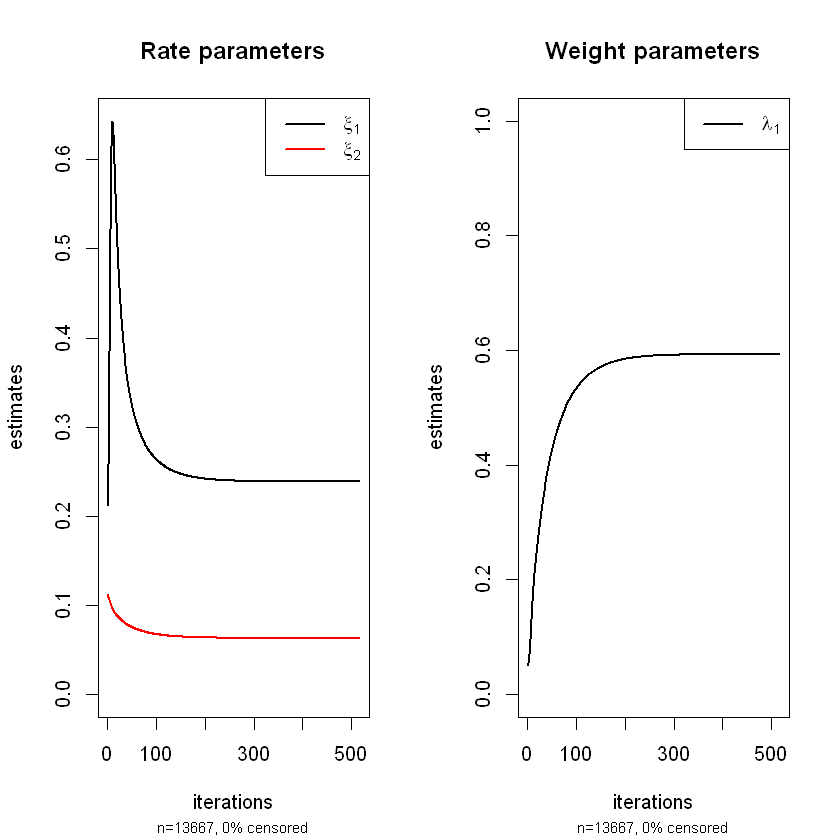

In [940]:
plotexpRMM( fd_ME_Aug4, lwd=2 )

In [941]:
fdME_Aug4_rate1 <- fd_ME_Aug4$rate[[1]]
fdME_Aug4_rate2 <- fd_ME_Aug4$rate[[2]]
fdME_Aug4_lambda <- fd_ME_Aug4$lambda[[1]]
fdME_Aug4_mean1 <- 1.0 / fdME_Aug4_rate1
fdME_Aug4_mean2 <- 1.0 / fdME_Aug4_rate2
fdME_Aug4_mean <- ( (fdME_Aug4_lambda * fdME_Aug4_mean1) + 
                    ( ( 1.0 - fdME_Aug4_lambda) * fdME_Aug4_mean2 ) )
fdME_Aug4_var1 <- 1.0 / (fdME_Aug4_rate1 ^ 2)
fdME_Aug4_var2 <- 1.0 / (fdME_Aug4_rate2 ^ 2)
fdME_Aug4_var <- ( (fdME_Aug4_lambda * ( fdME_Aug4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Aug4_lambda) * (fdME_Aug4_mean2 ^ 2) ) + 
                   ( fdME_Aug4_lambda * ( 1.0 - fdME_Aug4_lambda) * 
                       ( fdME_Aug4_mean1 - fdME_Aug4_mean2 )^2 ) )
fdME_Aug4_llike <- fd_ME_Aug4$loglik
cat(" Aug 4 rate1: ", fdME_Aug4_rate1, "\n", 
    "Aug 4 rate2: ", fdME_Aug4_rate2, "\n",
    "Aug 4 lambda: ", fdME_Aug4_lambda, "\n",
    "Aug 4 mean1: ", fdME_Aug4_mean1, "\n",
    "Aug 4 mean2: ", fdME_Aug4_mean2, "\n",
    "Aug 4 mean: ", fdME_Aug4_mean, "\n",
    "Aug 4 var1: ", fdME_Aug4_var1, "\n",
    "Aug 4 var2: ", fdME_Aug4_var2, "\n",
    "Aug 4 var: ", fdME_Aug4_var, "\n",
    "Aug 4 loglikelihood: ", fdME_Aug4_llike, "\n" )

 Aug 4 rate1:  0.2387536 
 Aug 4 rate2:  0.06319102 
 Aug 4 lambda:  0.593378 
 Aug 4 mean1:  4.188418 
 Aug 4 mean2:  15.82503 
 Aug 4 mean:  8.920121 
 Aug 4 var1:  17.54284 
 Aug 4 var2:  250.4317 
 Aug 4 var:  144.9126 
 Aug 4 loglikelihood:  -42834.25 


In [942]:
tvals <- rexpmix(length(dfAug4$Precip_mm), fd_ME_Aug4$lambda, fd_ME_Aug4$rate )

In [943]:
ksRes <- ks.test( dfAug4$Precip_mm, tvals )

Warning message in ks.test(dfAug4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [944]:
fdME_Aug4_KSStat <- ksRes$statistic
fdME_Aug4_KSp <- ksRes$p.value
cat(" Aug 4 K-S stat: ", fdME_Aug4_KSStat, "\n",
    "Aug 4 K-S p-value: ", fdME_Aug4_KSp )

 Aug 4 K-S stat:  0.0329992 
 Aug 4 K-S p-value:  6.879912e-07

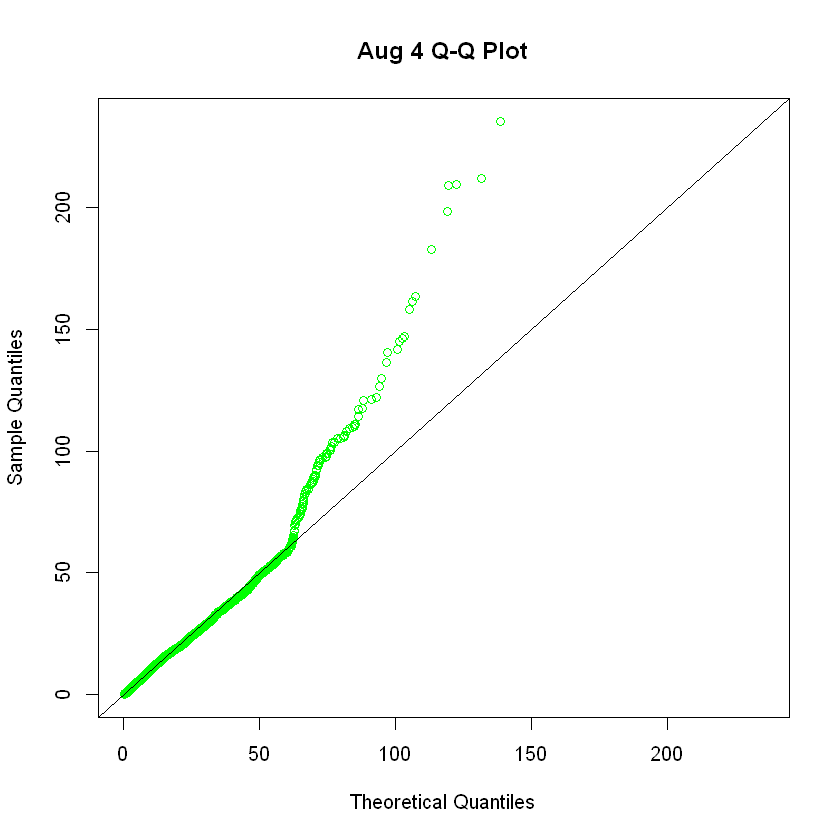

In [945]:
wAug4Max <- max( max( dfAug4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfAug4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Aug 4 Q-Q Plot",
        xlim=c(0,wAug4Max), ylim=c(0,wAug4Max) )
abline( 0, 1)

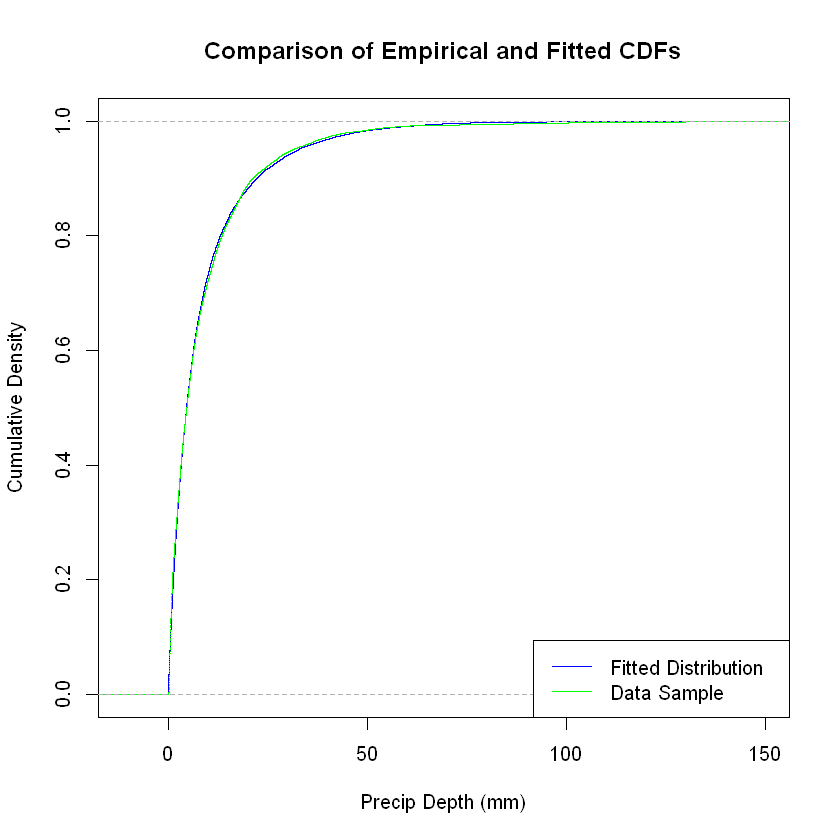

In [946]:
x <- seq(0,wAug4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfAug4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [947]:
MonDistDF[40, ] <- list( 8, 4, fdGM_Aug4_shape, fdGM_Aug4_rate, fdGM_Aug4_llike, fdGM_Aug4_mean,
                        fdGM_Aug4_var, fdGM_Aug4_KSStat, fdGM_Aug4_KSp, fdME_Aug4_rate1,
                        fdME_Aug4_rate2, fdME_Aug4_lambda, fdME_Aug4_mean1, fdME_Aug4_mean2,
                        fdME_Aug4_mean, fdME_Aug4_var1, fdME_Aug4_var2, fdME_Aug4_var,
                        fdME_Aug4_llike, fdME_Aug4_KSStat, fdME_Aug4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

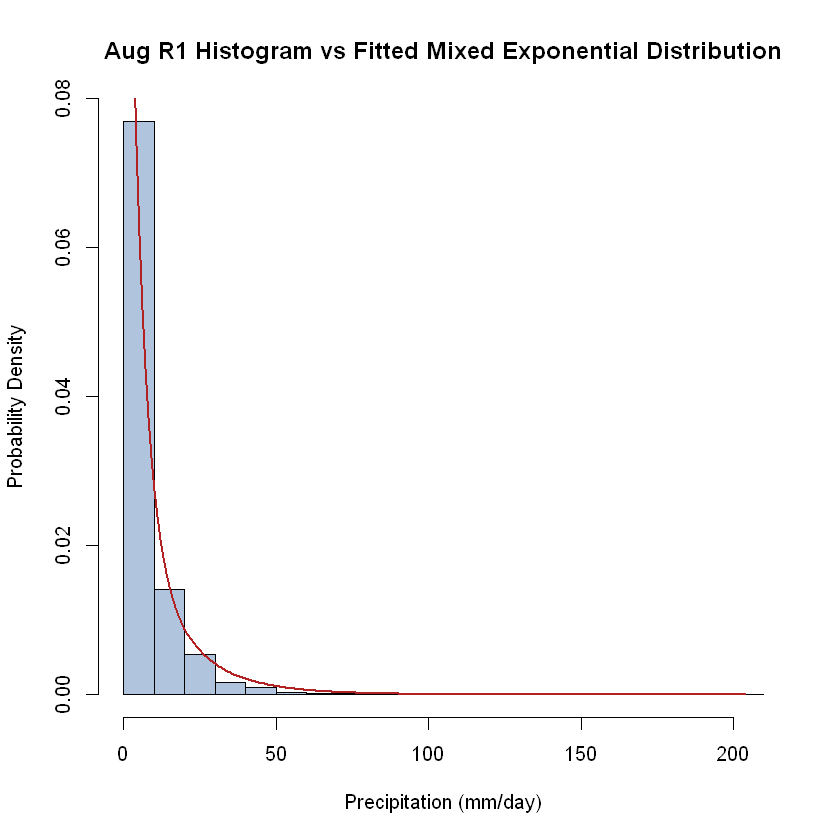

In [948]:
xVals <- seq(1, wAug1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Aug1_lambda, spec1="exp", arg1=list(rate=fdME_Aug1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Aug1_rate2) )
hist( dfAug1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Aug R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

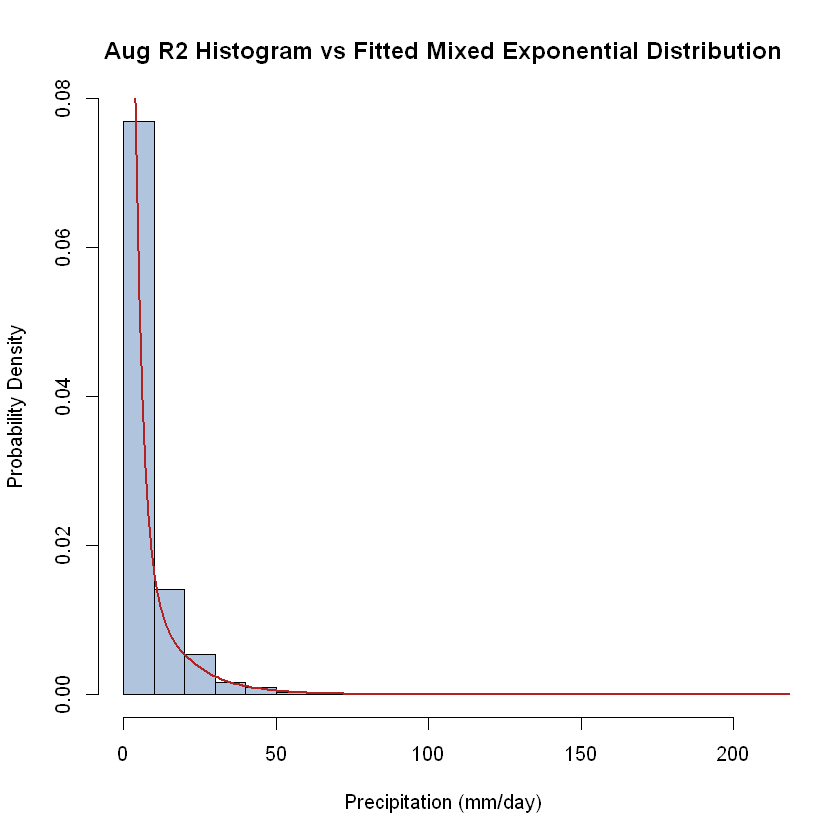

In [949]:
xVals <- seq(1, wAug2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Aug2_lambda, spec1="exp", arg1=list(rate=fdME_Aug2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Aug2_rate2) )
hist( dfAug1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Aug R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

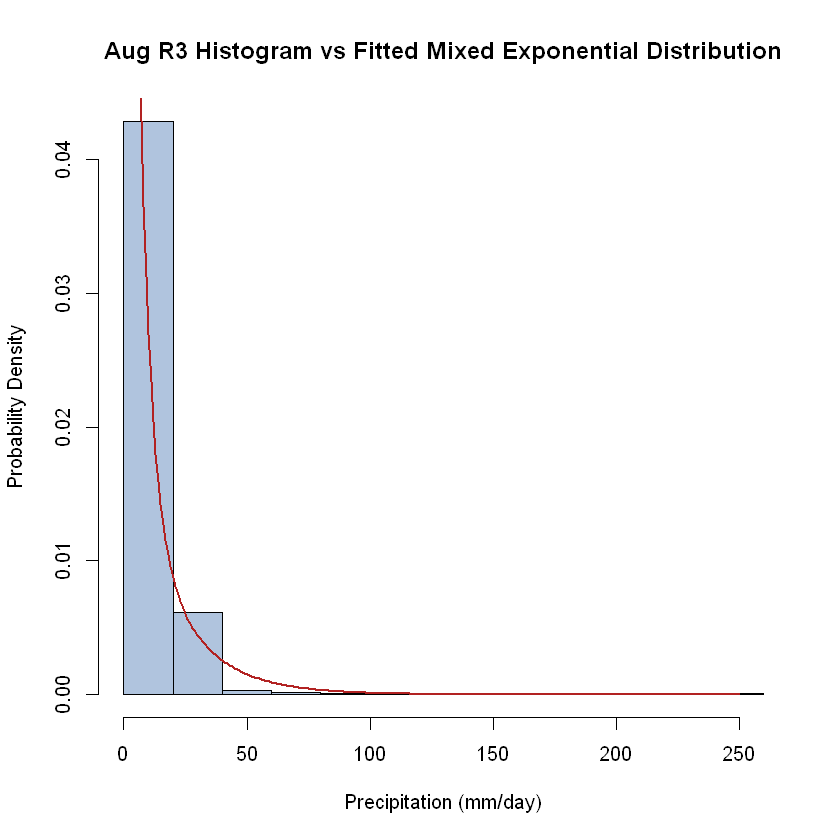

In [950]:
xVals <- seq(1, wAug3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Aug3_lambda, spec1="exp", arg1=list(rate=fdME_Aug3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Aug3_rate2) )
hist( dfAug3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Aug R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

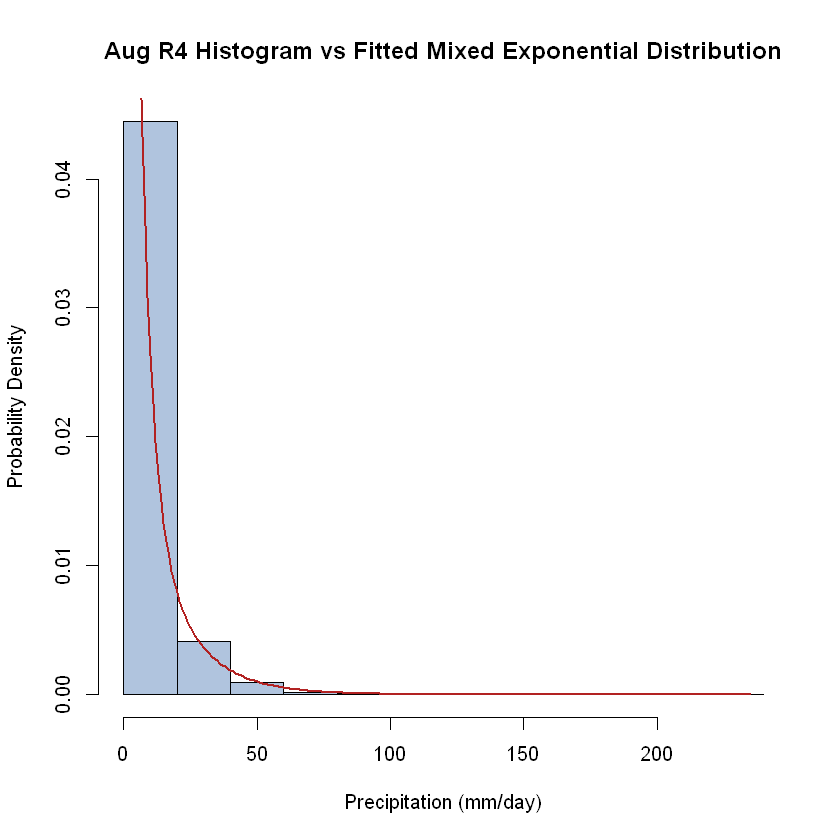

In [951]:
xVals <- seq(1, wAug4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Aug4_lambda, spec1="exp", arg1=list(rate=fdME_Aug4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Aug4_rate2) )
hist( dfAug4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Aug R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Sep

#### All

**Gamma**

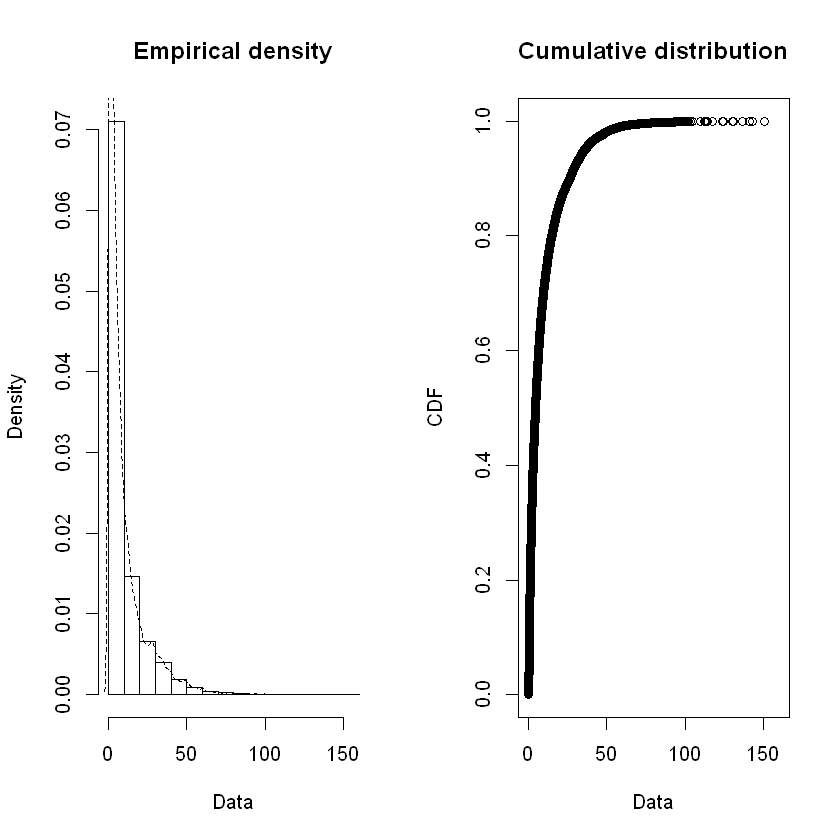

In [952]:
plotdist( dfSep$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  150.59 
median:  4.52 
mean:  9.449177 
estimated sd:  12.6873 
estimated skewness:  2.702063 
estimated kurtosis:  13.57557 

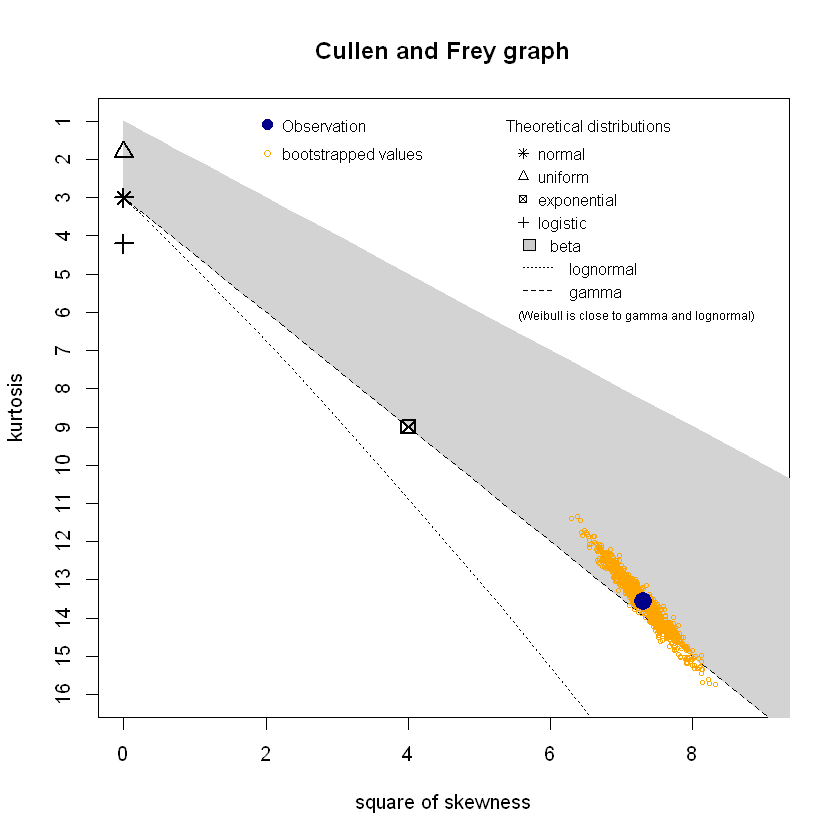

In [953]:
descdist( dfSep$Precip_mm, boot=1000 )

In [954]:
fd_GM_SepA <- fitdist( dfSep$Precip_mm, "gamma" )

In [955]:
summary( fd_GM_SepA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.74190292 0.0045675828
rate  0.07852107 0.0006694208
Loglikelihood:  -124405.7   AIC:  248815.4   BIC:  248832.5 
Correlation matrix:
         shape     rate
shape 1.000000 0.721953
rate  0.721953 1.000000


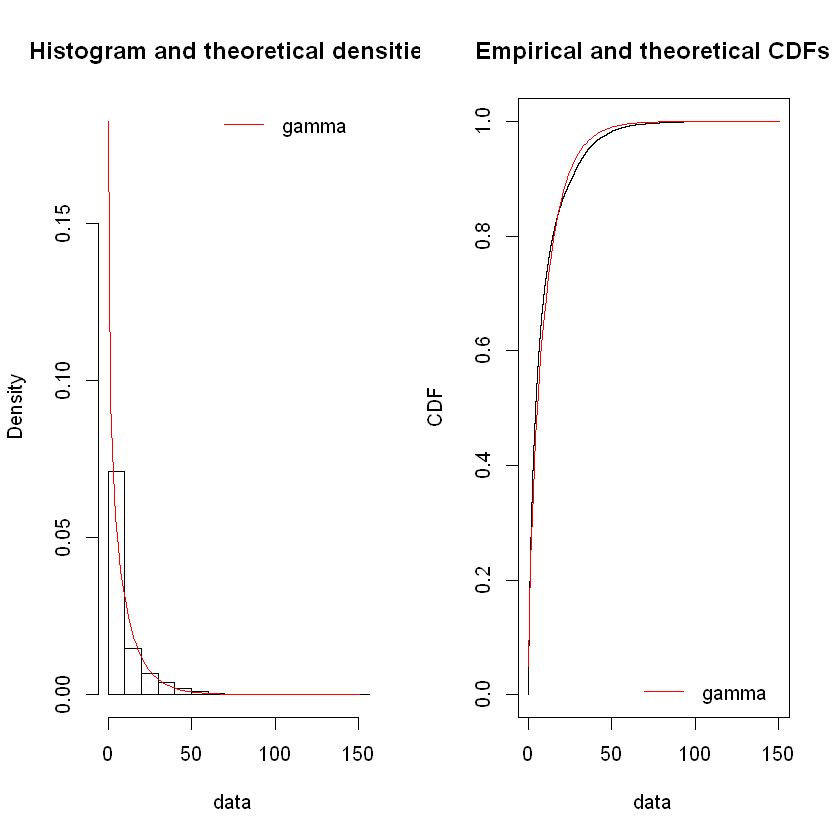

In [956]:
par(mfrow = c(1, 2))
denscomp(fd_GM_SepA)
#qqcomp(fd_GM_SepA)
cdfcomp(fd_GM_SepA)
#ppcomp(fd_GM_SepA)

In [957]:
fdGM_SepA_shape <- fd_GM_SepA$estimate[["shape"]]
fdGM_SepA_rate <- fd_GM_SepA$estimate[["rate"]]
fdGM_SepA_llike <- fd_GM_SepA$loglik
fdGM_SepA_mean <- fdGM_SepA_shape / fdGM_SepA_rate
fdGM_SepA_var <- fdGM_SepA_shape / ( fdGM_SepA_rate ^ 2 )
cat(" Sep A shape: ", fdGM_SepA_shape, "\n", "Sep A rate: ", fdGM_SepA_rate, 
    "\n", "Sep A loglikelihood: ", fdGM_SepA_llike, "\n", 
    "Sep A mean: ", fdGM_SepA_mean, "\n",
    "Sep A variance: ", fdGM_SepA_var, "\n" )

 Sep A shape:  0.7419029 
 Sep A rate:  0.07852107 
 Sep A loglikelihood:  -124405.7 
 Sep A mean:  9.448457 
 Sep A variance:  120.3302 


In [958]:
statRes <- gofstat( fd_GM_SepA, fitnames=c("Gamma") )

In [959]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06383472
Cramer-von Mises statistic    64.16213837
Anderson-Darling statistic   379.95614338

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 248815.4
Bayesian Information Criterion 248832.5


In [960]:
ksRes <- ks.test( dfSep$Precip_mm, "pgamma", shape=fdGM_SepA_shape, rate=fdGM_SepA_rate )

Warning message in ks.test(dfSep$Precip_mm, "pgamma", shape = fdGM_SepA_shape, rate = fdGM_SepA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [961]:
fdGM_SepA_KSStat <- ksRes$statistic
fdGM_SepA_KSp <- ksRes$p.value
cat(" Sep A K-S stat: ", fdGM_SepA_KSStat, "\n",
    "Sep A K-S p-value: ", fdGM_SepA_KSp )

 Sep A K-S stat:  0.06383472 
 Sep A K-S p-value:  0

**Mixed Exponential**

In [962]:
fd_ME_SepA <- expRMM_EM( dfSep$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfSep$Precip_mm), 1.0/mean(dfSep$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 191 


In [963]:
summary( fd_ME_SepA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.472797 0.5272034
rate   0.329851 0.0657704
loglik at estimate:  -122874.8 
0 % of the data right censored


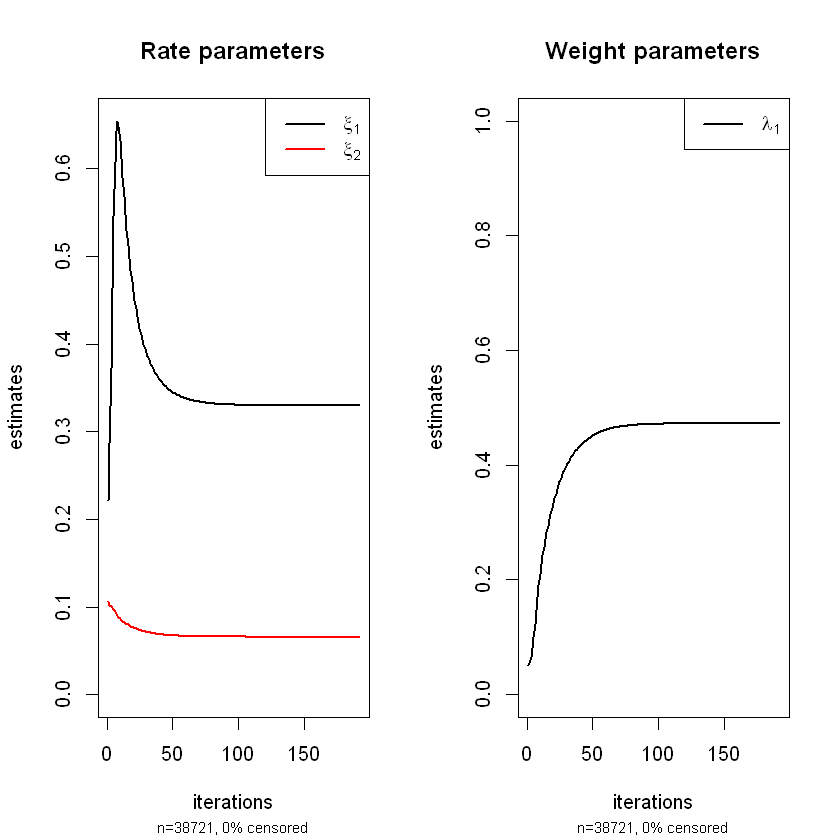

In [964]:
plotexpRMM( fd_ME_SepA, lwd=2 )

In [965]:
fdME_SepA_rate1 <- fd_ME_SepA$rate[[1]]
fdME_SepA_rate2 <- fd_ME_SepA$rate[[2]]
fdME_SepA_lambda <- fd_ME_SepA$lambda[[1]]
fdME_SepA_mean1 <- 1.0 / fdME_SepA_rate1
fdME_SepA_mean2 <- 1.0 / fdME_SepA_rate2
fdME_SepA_mean <- ( (fdME_SepA_lambda * fdME_SepA_mean1) + 
                    ( ( 1.0 - fdME_SepA_lambda) * fdME_SepA_mean2 ) )
fdME_SepA_var1 <- 1.0 / (fdME_SepA_rate1 ^ 2)
fdME_SepA_var2 <- 1.0 / (fdME_SepA_rate2 ^ 2)
fdME_SepA_var <- ( (fdME_SepA_lambda * ( fdME_SepA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_SepA_lambda) * (fdME_SepA_mean2 ^ 2) ) + 
                   ( fdME_SepA_lambda * ( 1.0 - fdME_SepA_lambda) * 
                       ( fdME_SepA_mean1 - fdME_SepA_mean2 )^2 ) )
fdME_SepA_llike <- fd_ME_SepA$loglik
cat(" Sep A rate1: ", fdME_SepA_rate1, "\n", 
    "Sep A rate2: ", fdME_SepA_rate2, "\n",
    "Sep A lambda: ", fdME_SepA_lambda, "\n",
    "Sep A mean1: ", fdME_SepA_mean1, "\n",
    "Sep A mean2: ", fdME_SepA_mean2, "\n",
    "Sep A mean: ", fdME_SepA_mean, "\n",
    "Sep A var1: ", fdME_SepA_var1, "\n",
    "Sep A var2: ", fdME_SepA_var2, "\n",
    "Sep A var: ", fdME_SepA_var, "\n",
    "Sep A loglikelihood: ", fdME_SepA_llike, "\n" )

 Sep A rate1:  0.3298514 
 Sep A rate2:  0.06577041 
 Sep A lambda:  0.4727966 
 Sep A mean1:  3.031668 
 Sep A mean2:  15.2044 
 Sep A mean:  9.449177 
 Sep A var1:  9.191013 
 Sep A var2:  231.1739 
 Sep A var:  163.1554 
 Sep A loglikelihood:  -122874.8 


In [966]:
tvals <- rexpmix(length(dfSep$Precip_mm), fd_ME_SepA$lambda, fd_ME_SepA$rate )

In [967]:
ksRes <- ks.test( dfSep$Precip_mm, tvals )

Warning message in ks.test(dfSep$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [968]:
fdME_SepA_KSStat <- ksRes$statistic
fdME_SepA_KSp <- ksRes$p.value
cat(" Sep A K-S stat: ", fdME_SepA_KSStat, "\n",
    "Sep A K-S p-value: ", fdME_SepA_KSp )

 Sep A K-S stat:  0.03783477 
 Sep A K-S p-value:  0

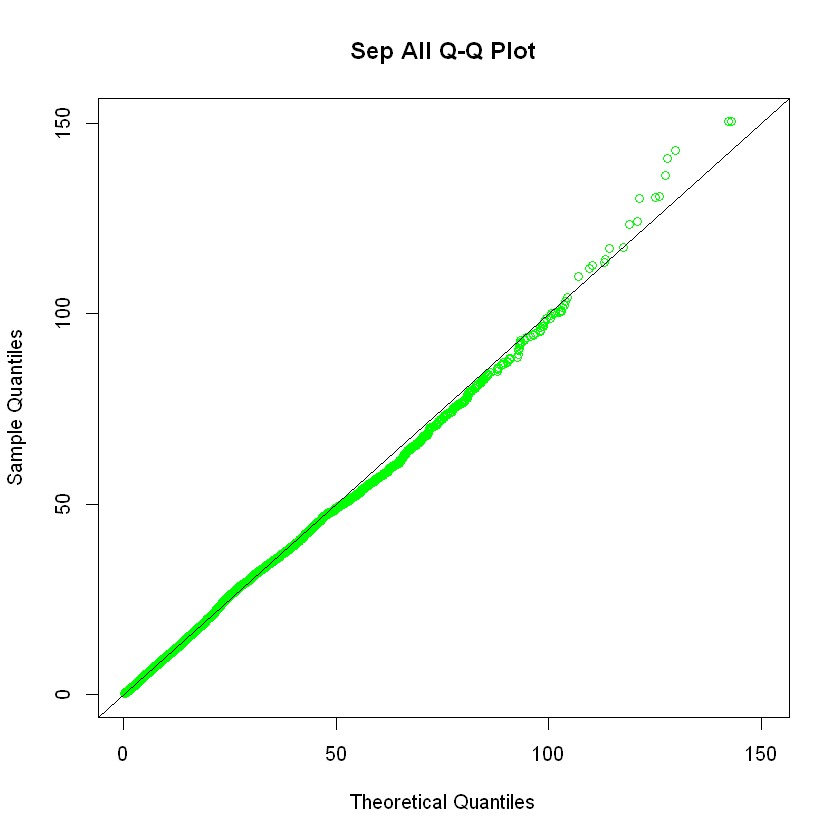

In [969]:
wSepAMax <- max( max( dfSep$Precip_mm ), max( tvals ) )
qqplot( tvals, dfSep$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Sep All Q-Q Plot",
        xlim=c(0,wSepAMax), ylim=c(0,wSepAMax) )
abline( 0, 1)

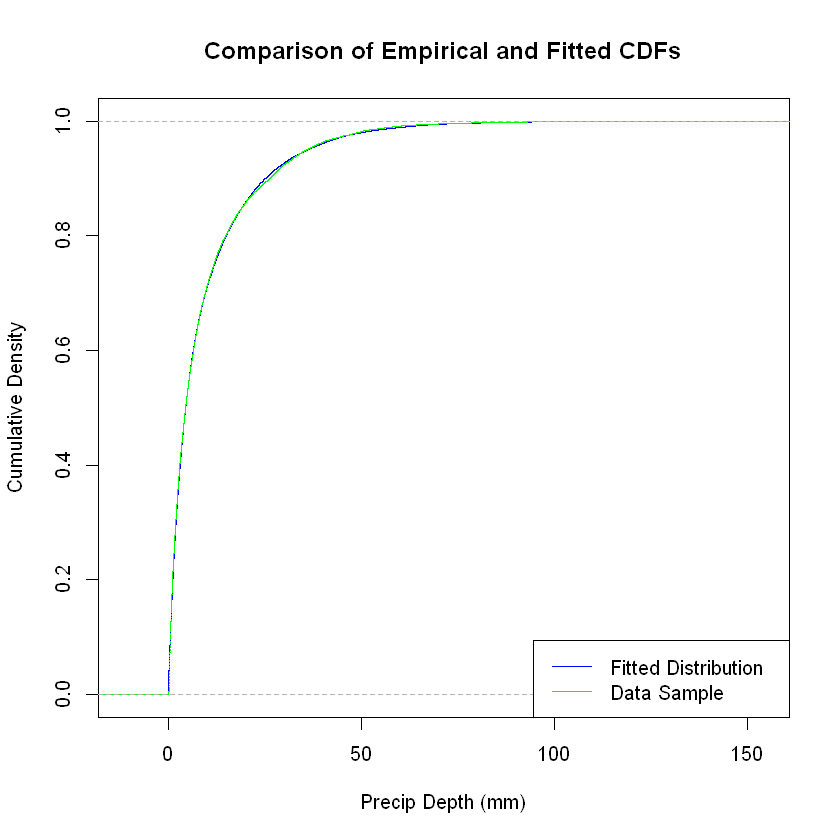

In [970]:
x <- seq(0,wSepAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfSep$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [971]:
MonDistDF[41, ] <- list( 9, 0, fdGM_SepA_shape, fdGM_SepA_rate, fdGM_SepA_llike, fdGM_SepA_mean,
                        fdGM_SepA_var, fdGM_SepA_KSStat, fdGM_SepA_KSp, fdME_SepA_rate1,
                        fdME_SepA_rate2, fdME_SepA_lambda, fdME_SepA_mean1, fdME_SepA_mean2,
                        fdME_SepA_mean, fdME_SepA_var1, fdME_SepA_var2, fdME_SepA_var,
                        fdME_SepA_llike, fdME_SepA_KSStat, fdME_SepA_KSp )

#### Region 1

**Gamma**

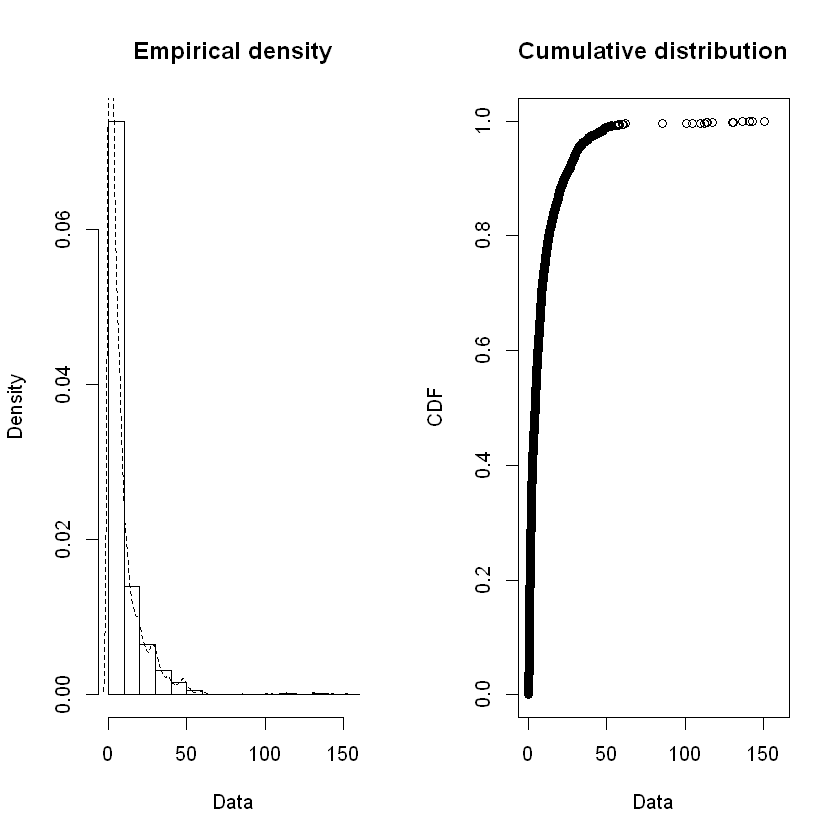

In [972]:
plotdist( dfSep1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  150.59 
median:  4.31 
mean:  8.657296 
estimated sd:  12.89759 
estimated skewness:  4.429063 
estimated kurtosis:  35.68602 

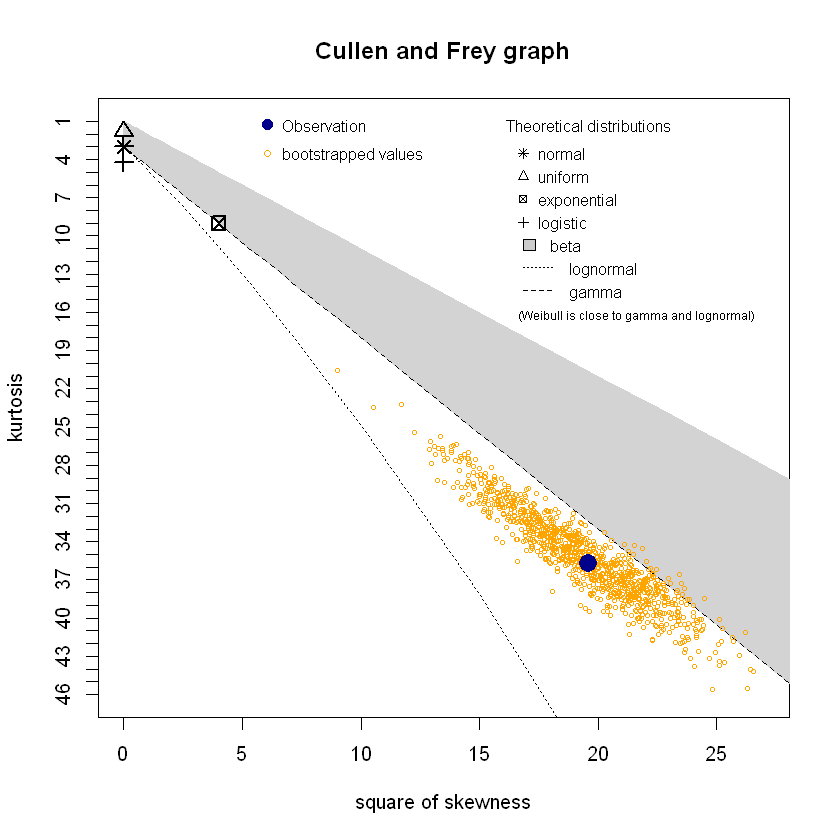

In [973]:
descdist( dfSep1$Precip_mm, boot=1000 )

In [974]:
fd_GM_Sep1 <- fitdist( dfSep1$Precip_mm, "gamma" )

In [975]:
summary( fd_GM_Sep1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.73729096 0.015100166
rate  0.08515153 0.002419306
Loglikelihood:  -10917.94   AIC:  21839.87   BIC:  21852.19 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7206836
rate  0.7206836 1.0000000


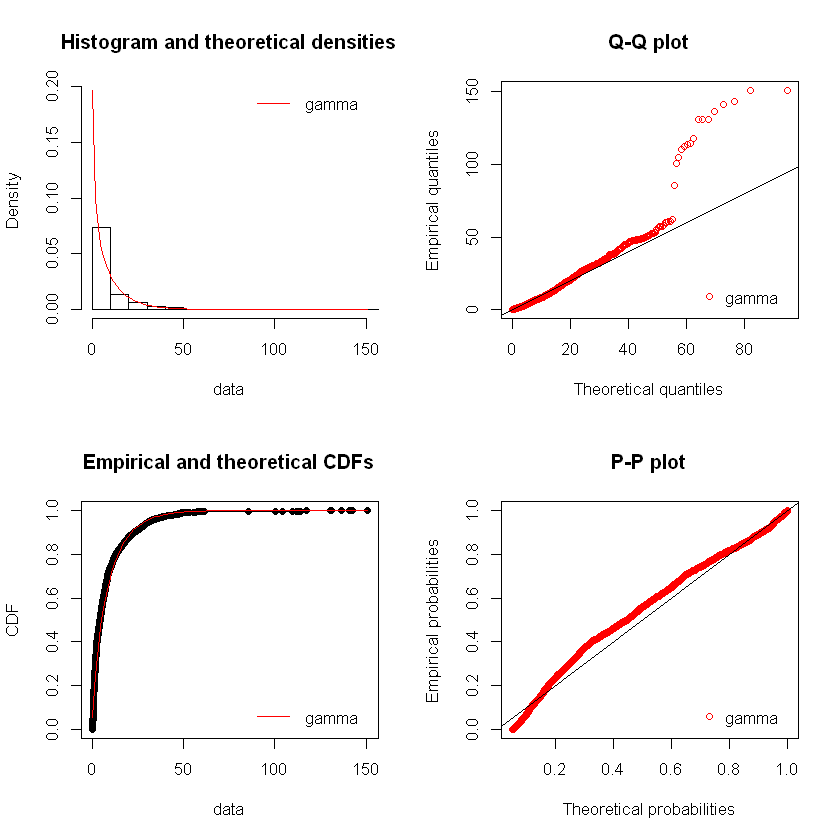

In [976]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Sep1)
qqcomp(fd_GM_Sep1)
cdfcomp(fd_GM_Sep1)
ppcomp(fd_GM_Sep1)

In [977]:
fdGM_Sep1_shape <- fd_GM_Sep1$estimate[["shape"]]
fdGM_Sep1_rate <- fd_GM_Sep1$estimate[["rate"]]
fdGM_Sep1_llike <- fd_GM_Sep1$loglik
fdGM_Sep1_mean <- fdGM_Sep1_shape / fdGM_Sep1_rate
fdGM_Sep1_var <- fdGM_Sep1_shape / ( fdGM_Sep1_rate ^ 2 )
cat(" Sep 1 shape: ", fdGM_Sep1_shape, "\n", "Sep 1 rate: ", fdGM_Sep1_rate, 
    "\n", "Sep 1 loglikelihood: ", fdGM_Sep1_llike, "\n", 
    "Sep 1 mean: ", fdGM_Sep1_mean, "\n",
    "Sep 1 variance: ", fdGM_Sep1_var, "\n" )

 Sep 1 shape:  0.737291 
 Sep 1 rate:  0.08515153 
 Sep 1 loglikelihood:  -10917.94 
 Sep 1 mean:  8.658575 
 Sep 1 variance:  101.6843 


In [978]:
statRes <- gofstat( fd_GM_Sep1, fitnames=c("Gamma") )

In [979]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic  0.0758877
Cramer-von Mises statistic    6.5675576
Anderson-Darling statistic   39.1918659

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 21839.87
Bayesian Information Criterion 21852.19


In [980]:
ksRes <- ks.test( dfSep1$Precip_mm, "pgamma", shape=fdGM_Sep1_shape, rate=fdGM_Sep1_rate )

Warning message in ks.test(dfSep1$Precip_mm, "pgamma", shape = fdGM_Sep1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [981]:
fdGM_Sep1_KSStat <- ksRes$statistic
fdGM_Sep1_KSp <- ksRes$p.value
cat(" Sep 1 K-S stat: ", fdGM_Sep1_KSStat, "\n",
    "Sep 1 K-S p-value: ", fdGM_Sep1_KSp )

 Sep 1 K-S stat:  0.0758877 
 Sep 1 K-S p-value:  0

**Mixed exponential**

In [982]:
fd_ME_Sep1 <- expRMM_EM( dfSep1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfSep1$Precip_mm), 1.0/mean(dfSep1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 206 


In [983]:
summary( fd_ME_Sep1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.512534 0.4874664
rate   0.333849 0.0684445
loglik at estimate:  -10767.89 
0 % of the data right censored


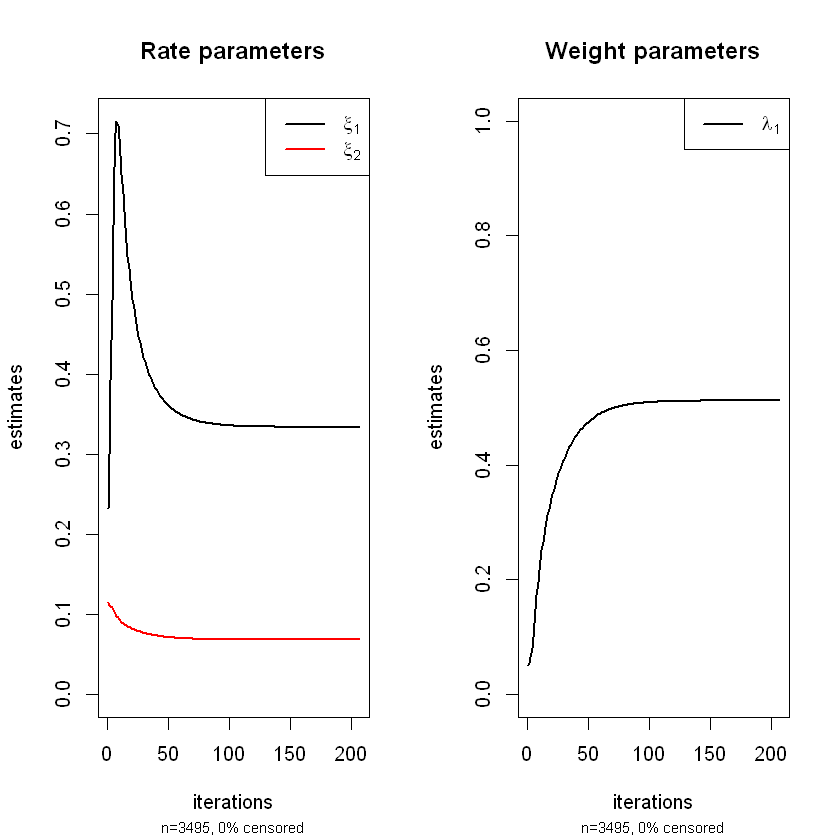

In [984]:
plotexpRMM( fd_ME_Sep1, lwd=2 )

In [985]:
fdME_Sep1_rate1 <- fd_ME_Sep1$rate[[1]]
fdME_Sep1_rate2 <- fd_ME_Sep1$rate[[2]]
fdME_Sep1_lambda <- fd_ME_Sep1$lambda[[1]]
fdME_Sep1_mean1 <- 1.0 / fdME_Sep1_rate1
fdME_Sep1_mean2 <- 1.0 / fdME_Sep1_rate2
fdME_Sep1_mean <- ( (fdME_Sep1_lambda * fdME_Sep1_mean1) + 
                    ( ( 1.0 - fdME_Sep1_lambda) * fdME_Sep1_mean2 ) )
fdME_Sep1_var1 <- 1.0 / (fdME_Sep1_rate1 ^ 2)
fdME_Sep1_var2 <- 1.0 / (fdME_Sep1_rate2 ^ 2)
fdME_Sep1_var <- ( (fdME_Sep1_lambda * ( fdME_Sep1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Sep1_lambda) * (fdME_Sep1_mean2 ^ 2) ) + 
                   ( fdME_Sep1_lambda * ( 1.0 - fdME_Sep1_lambda) * 
                       ( fdME_Sep1_mean1 - fdME_Sep1_mean2 )^2 ) )
fdME_Sep1_llike <- fd_ME_Sep1$loglik
cat(" Sep 1 rate1: ", fdME_Sep1_rate1, "\n", 
    "Sep 1 rate2: ", fdME_Sep1_rate2, "\n",
    "Sep 1 lambda: ", fdME_Sep1_lambda, "\n",
    "Sep 1 mean1: ", fdME_Sep1_mean1, "\n",
    "Sep 1 mean2: ", fdME_Sep1_mean2, "\n",
    "Sep 1 mean: ", fdME_Sep1_mean, "\n",
    "Sep 1 var1: ", fdME_Sep1_var1, "\n",
    "Sep 1 var2: ", fdME_Sep1_var2, "\n",
    "Sep 1 var: ", fdME_Sep1_var, "\n",
    "Sep 1 loglikelihood: ", fdME_Sep1_llike, "\n" )

 Sep 1 rate1:  0.3338493 
 Sep 1 rate2:  0.06844447 
 Sep 1 lambda:  0.5125336 
 Sep 1 mean1:  2.995363 
 Sep 1 mean2:  14.61038 
 Sep 1 mean:  8.657296 
 Sep 1 var1:  8.9722 
 Sep 1 var2:  213.4633 
 Sep 1 var:  142.3608 
 Sep 1 loglikelihood:  -10767.89 


In [986]:
tvals <- rexpmix(length(dfSep1$Precip_mm), fd_ME_Sep1$lambda, fd_ME_Sep1$rate )

In [987]:
ksRes <- ks.test( dfSep1$Precip_mm, tvals )

Warning message in ks.test(dfSep1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [988]:
fdME_Sep1_KSStat <- ksRes$statistic
fdME_Sep1_KSp <- ksRes$p.value
cat(" Sep 1 K-S stat: ", fdME_Sep1_KSStat, "\n",
    "Sep 1 K-S p-value: ", fdME_Sep1_KSp )

 Sep 1 K-S stat:  0.0434907 
 Sep 1 K-S p-value:  0.002692085

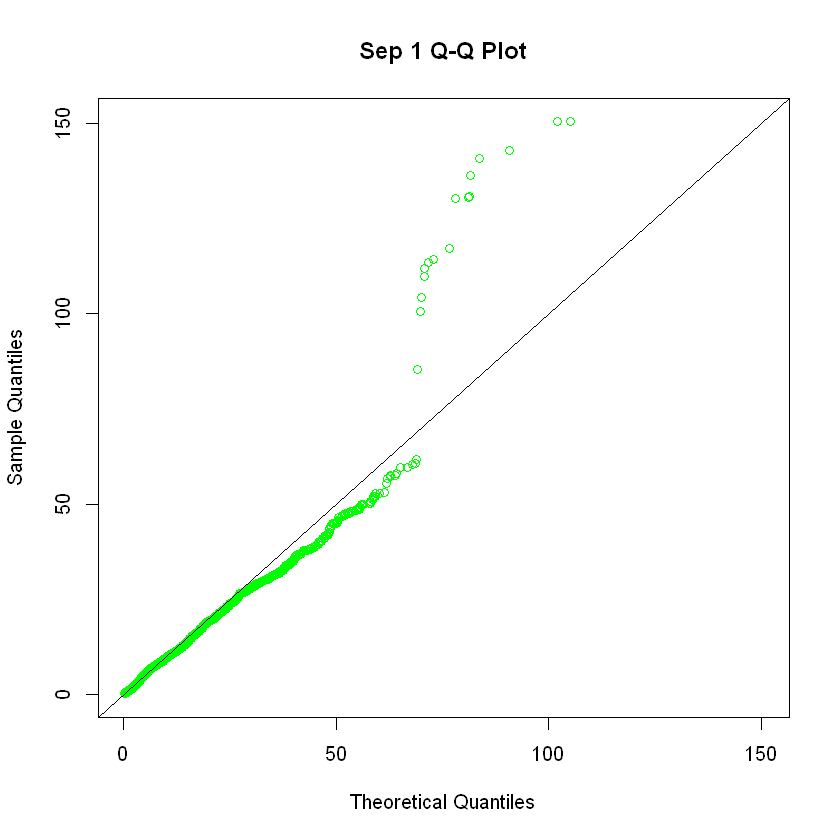

In [989]:
wSep1Max <- max( max( dfSep1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfSep1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Sep 1 Q-Q Plot",
        xlim=c(0,wSep1Max), ylim=c(0,wSep1Max) )
abline( 0, 1)

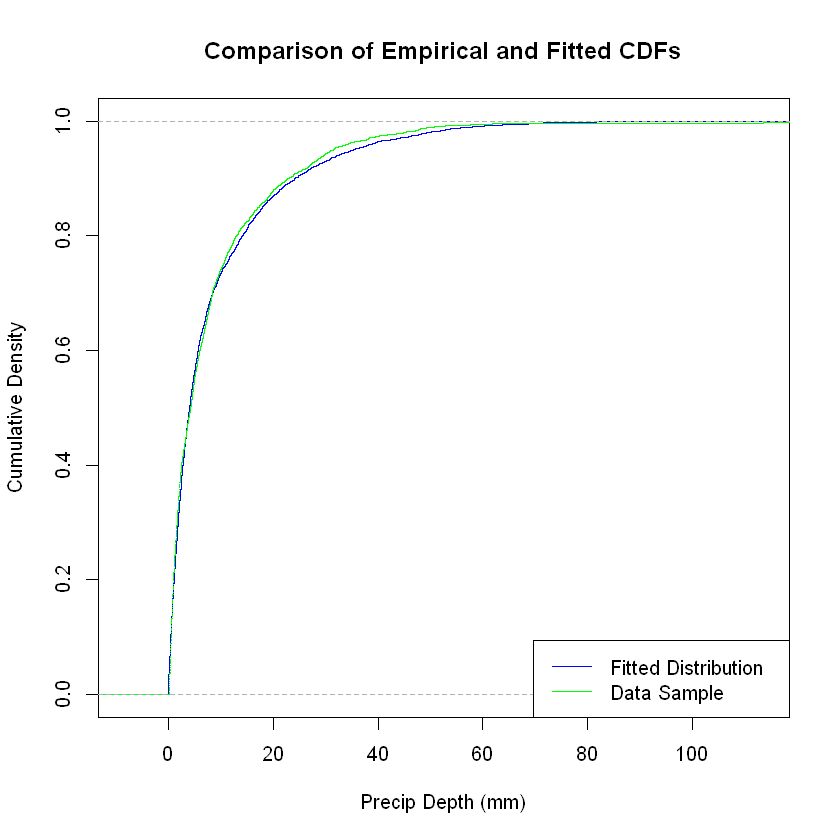

In [990]:
x <- seq(0,wSep1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfSep1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [991]:
MonDistDF[42, ] <- list( 9, 1, fdGM_Sep1_shape, fdGM_Sep1_rate, fdGM_Sep1_llike, fdGM_Sep1_mean,
                        fdGM_Sep1_var, fdGM_Sep1_KSStat, fdGM_Sep1_KSp, fdME_Sep1_rate1,
                        fdME_Sep1_rate2, fdME_Sep1_lambda, fdME_Sep1_mean1, fdME_Sep1_mean2,
                        fdME_Sep1_mean, fdME_Sep1_var1, fdME_Sep1_var2, fdME_Sep1_var,
                        fdME_Sep1_llike, fdME_Sep1_KSStat, fdME_Sep1_KSp )

#### Region 2

**Gamma**

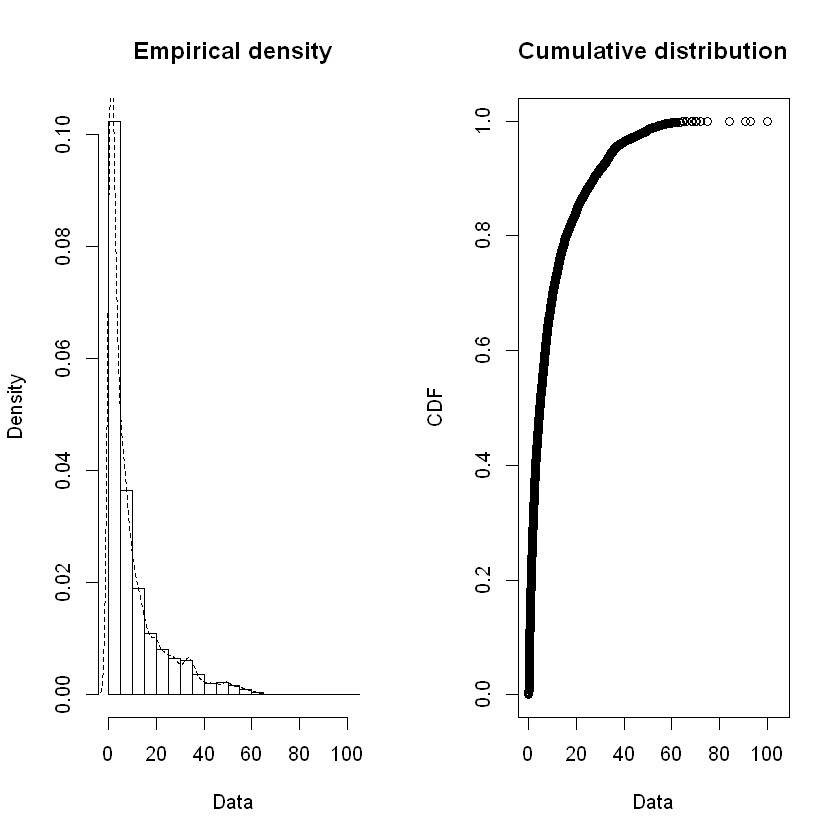

In [992]:
plotdist( dfSep2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  100.06 
median:  4.76 
mean:  9.644268 
estimated sd:  11.9997 
estimated skewness:  1.975484 
estimated kurtosis:  7.078357 

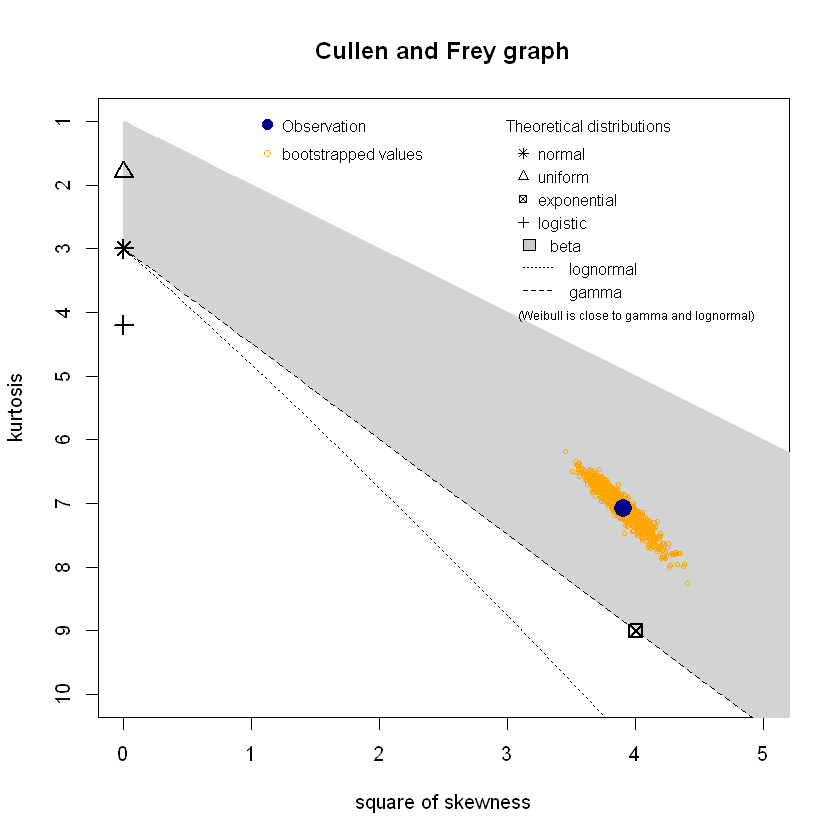

In [993]:
descdist( dfSep2$Precip_mm, boot=1000 )

In [994]:
fd_GM_Sep2 <- fitdist( dfSep2$Precip_mm, "gamma" )

In [995]:
summary( fd_GM_Sep2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.74939952 0.008096555
rate  0.07770845 0.001159285
Loglikelihood:  -40759.23   AIC:  81522.45   BIC:  81537.34 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7240109
rate  0.7240109 1.0000000


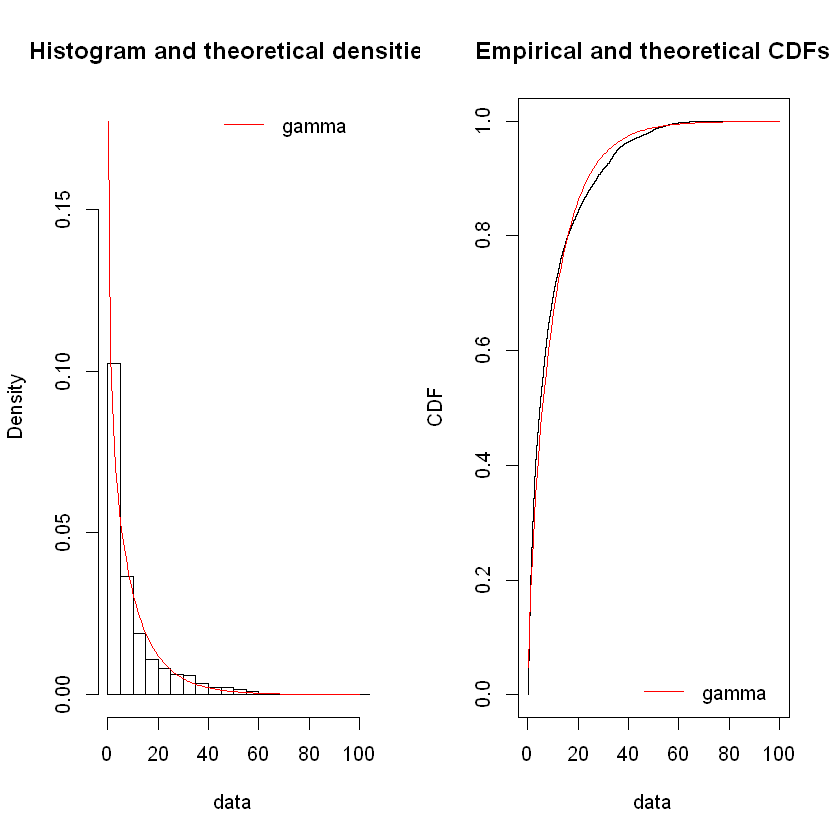

In [996]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Sep2)
#qqcomp(fd_GM_Sep2)
cdfcomp(fd_GM_Sep2)
#ppcomp(fd_GM_Sep2)

In [997]:
fdGM_Sep2_shape <- fd_GM_Sep2$estimate[["shape"]]
fdGM_Sep2_rate <- fd_GM_Sep2$estimate[["rate"]]
fdGM_Sep2_llike <- fd_GM_Sep2$loglik
fdGM_Sep2_mean <- fdGM_Sep2_shape / fdGM_Sep2_rate
fdGM_Sep2_var <- fdGM_Sep2_shape / ( fdGM_Sep2_rate ^ 2 )
cat(" Sep 2 shape: ", fdGM_Sep2_shape, "\n", "Sep 2 rate: ", fdGM_Sep2_rate, 
    "\n", "Sep 2 loglikelihood: ", fdGM_Sep2_llike, "\n", 
    "Sep 2 mean: ", fdGM_Sep2_mean, "\n",
    "Sep 2 variance: ", fdGM_Sep2_var, "\n" )

 Sep 2 shape:  0.7493995 
 Sep 2 rate:  0.07770845 
 Sep 2 loglikelihood:  -40759.23 
 Sep 2 mean:  9.643733 
 Sep 2 variance:  124.1015 


In [998]:
statRes <- gofstat( fd_GM_Sep2, fitnames=c("Gamma") )

In [999]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06622097
Cramer-von Mises statistic    18.21882536
Anderson-Darling statistic   112.23940574

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 81522.45
Bayesian Information Criterion 81537.34


In [1000]:
ksRes <- ks.test( dfSep2$Precip_mm, "pgamma", shape=fdGM_Sep2_shape, rate=fdGM_Sep2_rate )

Warning message in ks.test(dfSep2$Precip_mm, "pgamma", shape = fdGM_Sep2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1001]:
fdGM_Sep2_KSStat <- ksRes$statistic
fdGM_Sep2_KSp <- ksRes$p.value
cat(" Sep 2 K-S stat: ", fdGM_Sep2_KSStat, "\n",
    "Sep 2 K-S p-value: ", fdGM_Sep2_KSp )

 Sep 2 K-S stat:  0.06622097 
 Sep 2 K-S p-value:  0

**Mixed exponential**

In [1002]:
fd_ME_Sep2 <- expRMM_EM( dfSep2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfSep2$Precip_mm), 1.0/mean(dfSep2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 162 


In [1003]:
summary( fd_ME_Sep2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.387538 0.6124617
rate   0.394467 0.0707081
loglik at estimate:  -40324.67 
0 % of the data right censored


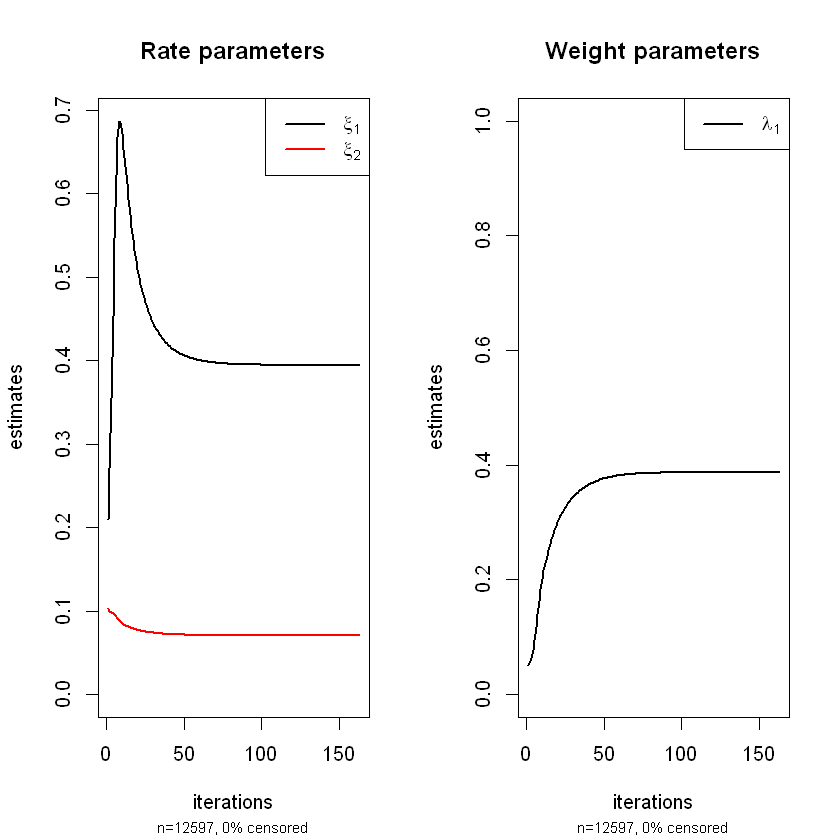

In [1004]:
plotexpRMM( fd_ME_Sep2, lwd=2 )

In [1005]:
fdME_Sep2_rate1 <- fd_ME_Sep2$rate[[1]]
fdME_Sep2_rate2 <- fd_ME_Sep2$rate[[2]]
fdME_Sep2_lambda <- fd_ME_Sep2$lambda[[1]]
fdME_Sep2_mean1 <- 1.0 / fdME_Sep2_rate1
fdME_Sep2_mean2 <- 1.0 / fdME_Sep2_rate2
fdME_Sep2_mean <- ( (fdME_Sep2_lambda * fdME_Sep2_mean1) + 
                    ( ( 1.0 - fdME_Sep2_lambda) * fdME_Sep2_mean2 ) )
fdME_Sep2_var1 <- 1.0 / (fdME_Sep2_rate1 ^ 2)
fdME_Sep2_var2 <- 1.0 / (fdME_Sep2_rate2 ^ 2)
fdME_Sep2_var <- ( (fdME_Sep2_lambda * ( fdME_Sep2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Sep2_lambda) * (fdME_Sep2_mean2 ^ 2) ) + 
                   ( fdME_Sep2_lambda * ( 1.0 - fdME_Sep2_lambda) * 
                       ( fdME_Sep2_mean1 - fdME_Sep2_mean2 )^2 ) )
fdME_Sep2_llike <- fd_ME_Sep2$loglik
cat(" Sep 2 rate1: ", fdME_Sep2_rate1, "\n", 
    "Sep 2 rate2: ", fdME_Sep2_rate2, "\n",
    "Sep 2 lambda: ", fdME_Sep2_lambda, "\n",
    "Sep 2 mean1: ", fdME_Sep2_mean1, "\n",
    "Sep 2 mean2: ", fdME_Sep2_mean2, "\n",
    "Sep 2 mean: ", fdME_Sep2_mean, "\n",
    "Sep 2 var1: ", fdME_Sep2_var1, "\n",
    "Sep 2 var2: ", fdME_Sep2_var2, "\n",
    "Sep 2 var: ", fdME_Sep2_var, "\n",
    "Sep 2 loglikelihood: ", fdME_Sep2_llike, "\n" )

 Sep 2 rate1:  0.3944671 
 Sep 2 rate2:  0.0707081 
 Sep 2 lambda:  0.3875383 
 Sep 2 mean1:  2.535066 
 Sep 2 mean2:  14.14265 
 Sep 2 mean:  9.644268 
 Sep 2 var1:  6.426558 
 Sep 2 var2:  200.0146 
 Sep 2 var:  156.9717 
 Sep 2 loglikelihood:  -40324.67 


In [1006]:
tvals <- rexpmix(length(dfSep2$Precip_mm), fd_ME_Sep2$lambda, fd_ME_Sep2$rate )

In [1007]:
ksRes <- ks.test( dfSep2$Precip_mm, tvals )

Warning message in ks.test(dfSep2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1008]:
fdME_Sep2_KSStat <- ksRes$statistic
fdME_Sep2_KSp <- ksRes$p.value
cat(" Sep 2 K-S stat: ", fdME_Sep2_KSStat, "\n",
    "Sep 2 K-S p-value: ", fdME_Sep2_KSp )

 Sep 2 K-S stat:  0.03826308 
 Sep 2 K-S p-value:  1.95624e-08

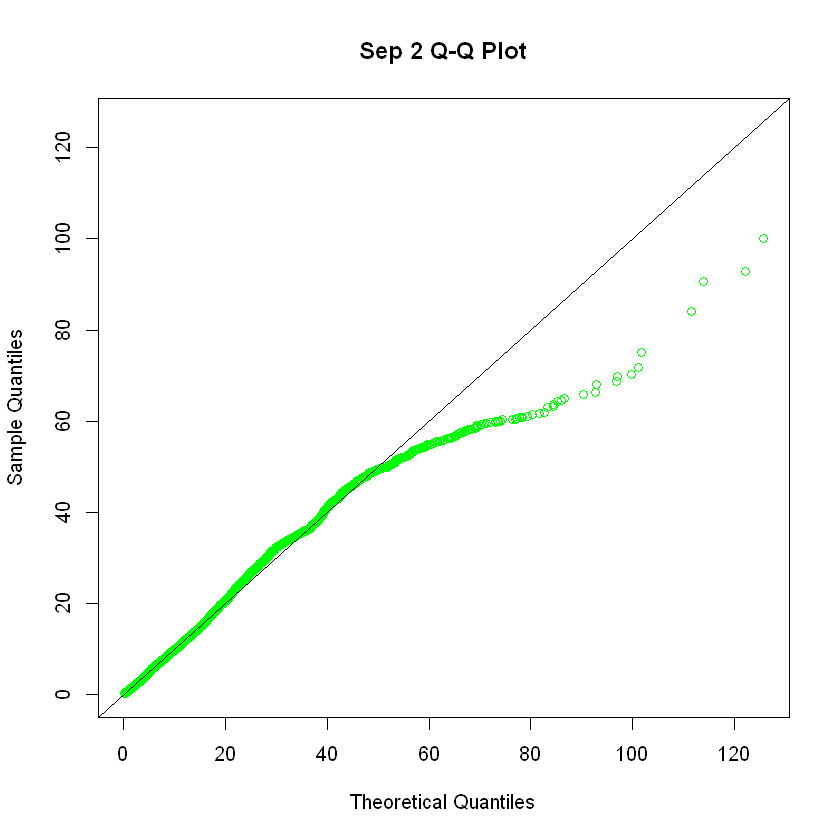

In [1009]:
wSep2Max <- max( max( dfSep2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfSep2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Sep 2 Q-Q Plot",
        xlim=c(0,wSep2Max), ylim=c(0,wSep2Max) )
abline( 0, 1)

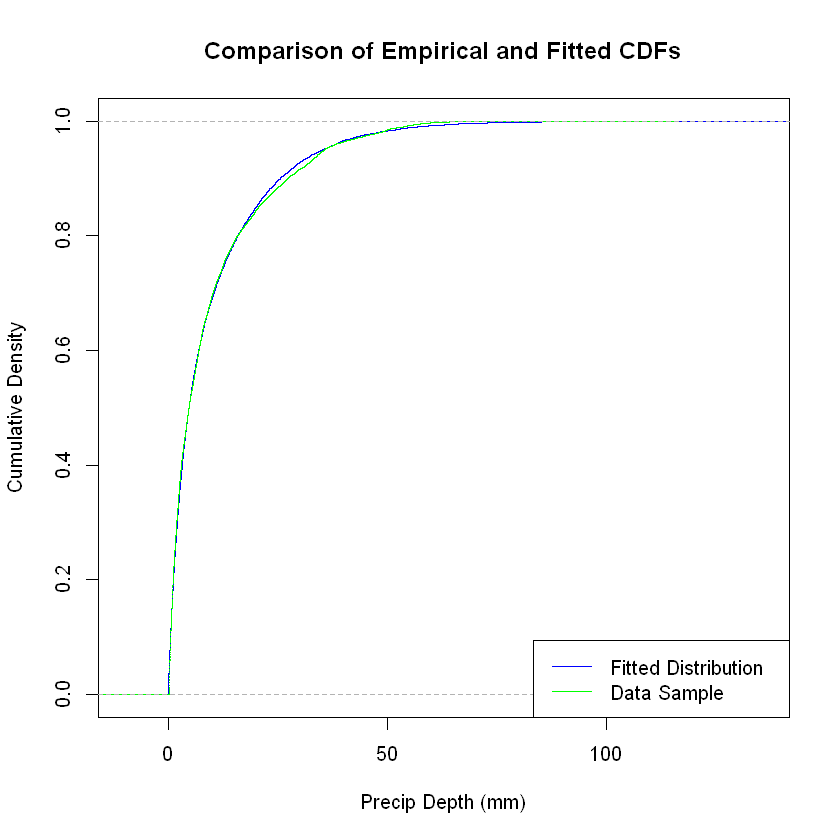

In [1010]:
x <- seq(0,wSep2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfSep2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1011]:
MonDistDF[43, ] <- list( 9, 2, fdGM_Sep2_shape, fdGM_Sep2_rate, fdGM_Sep2_llike, fdGM_Sep2_mean,
                        fdGM_Sep2_var, fdGM_Sep2_KSStat, fdGM_Sep2_KSp, fdME_Sep2_rate1,
                        fdME_Sep2_rate2, fdME_Sep2_lambda, fdME_Sep2_mean1, fdME_Sep2_mean2,
                        fdME_Sep2_mean, fdME_Sep2_var1, fdME_Sep2_var2, fdME_Sep2_var,
                        fdME_Sep2_llike, fdME_Sep2_KSStat, fdME_Sep2_KSp )

#### Region 3

**Gamma**

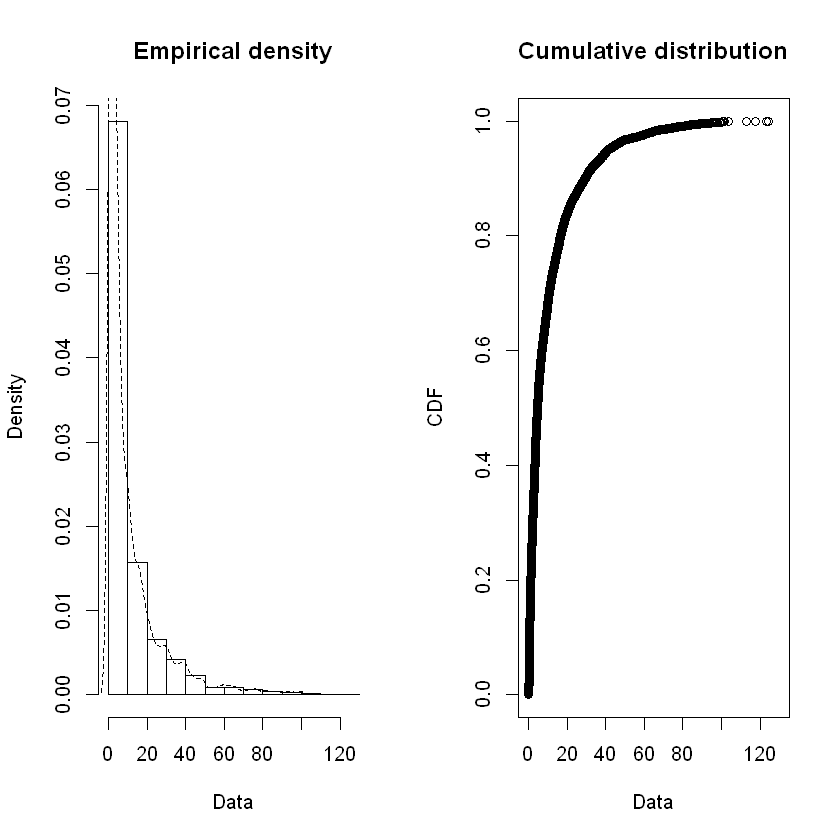

In [1012]:
plotdist( dfSep3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  124.34 
median:  4.705 
mean:  10.83536 
estimated sd:  15.25328 
estimated skewness:  2.739566 
estimated kurtosis:  12.2215 

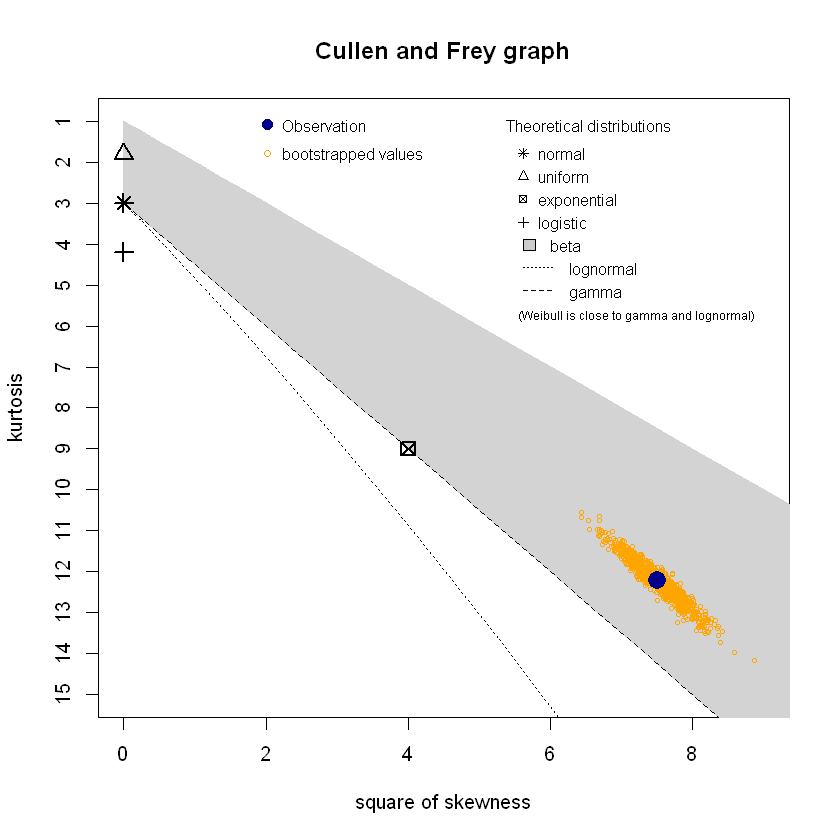

In [1013]:
descdist( dfSep3$Precip_mm, boot=1000 )

In [1014]:
fd_GM_Sep3 <- fitdist( dfSep3$Precip_mm, "gamma" )

In [1015]:
summary( fd_GM_Sep3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.71208541 0.009565658
rate  0.06572651 0.001237077
Loglikelihood:  -26947.89   AIC:  53899.78   BIC:  53913.77 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7134426
rate  0.7134426 1.0000000


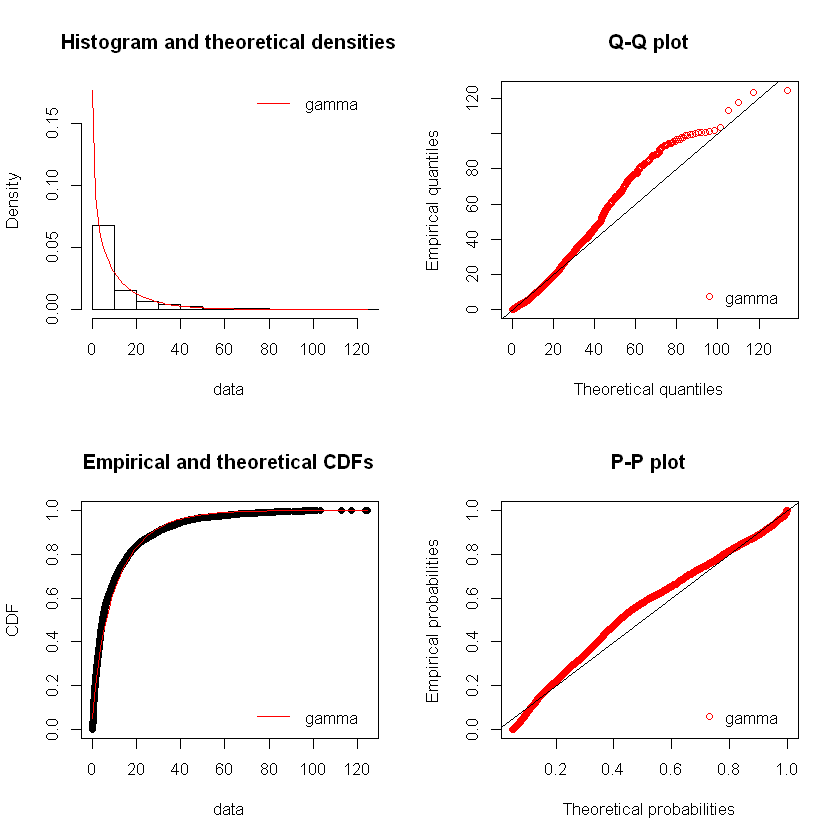

In [1016]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Sep3)
qqcomp(fd_GM_Sep3)
cdfcomp(fd_GM_Sep3)
ppcomp(fd_GM_Sep3)

In [1017]:
fdGM_Sep3_shape <- fd_GM_Sep3$estimate[["shape"]]
fdGM_Sep3_rate <- fd_GM_Sep3$estimate[["rate"]]
fdGM_Sep3_llike <- fd_GM_Sep3$loglik
fdGM_Sep3_mean <- fdGM_Sep3_shape / fdGM_Sep3_rate
fdGM_Sep3_var <- fdGM_Sep3_shape / ( fdGM_Sep3_rate ^ 2 )
cat(" Sep 3 shape: ", fdGM_Sep3_shape, "\n", "Sep 3 rate: ", fdGM_Sep3_rate, 
    "\n", "Sep 3 loglikelihood: ", fdGM_Sep3_llike, "\n", 
    "Sep 3 mean: ", fdGM_Sep3_mean, "\n",
    "Sep 3 variance: ", fdGM_Sep3_var, "\n" )

 Sep 3 shape:  0.7120854 
 Sep 3 rate:  0.06572651 
 Sep 3 loglikelihood:  -26947.89 
 Sep 3 mean:  10.83407 
 Sep 3 variance:  164.8356 


In [1018]:
statRes <- gofstat( fd_GM_Sep3, fitnames=c("Gamma") )

In [1019]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.08513821
Cramer-von Mises statistic   16.22347402
Anderson-Darling statistic   91.44964810

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 53899.78
Bayesian Information Criterion 53913.77


In [1020]:
ksRes <- ks.test( dfSep3$Precip_mm, "pgamma", shape=fdGM_Sep3_shape, rate=fdGM_Sep3_rate )

Warning message in ks.test(dfSep3$Precip_mm, "pgamma", shape = fdGM_Sep3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1021]:
fdGM_Sep3_KSStat <- ksRes$statistic
fdGM_Sep3_KSp <- ksRes$p.value
cat(" Sep 3 K-S stat: ", fdGM_Sep3_KSStat, "\n",
    "Sep 3 K-S p-value: ", fdGM_Sep3_KSp )

 Sep 3 K-S stat:  0.08513821 
 Sep 3 K-S p-value:  0

**Mixed exponential**

In [1022]:
fd_ME_Sep3 <- expRMM_EM( dfSep3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfSep3$Precip_mm), 1.0/mean(dfSep3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 156 


In [1023]:
summary( fd_ME_Sep3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.510089 0.4899107
rate   0.290997 0.0539403
loglik at estimate:  -26563.45 
0 % of the data right censored


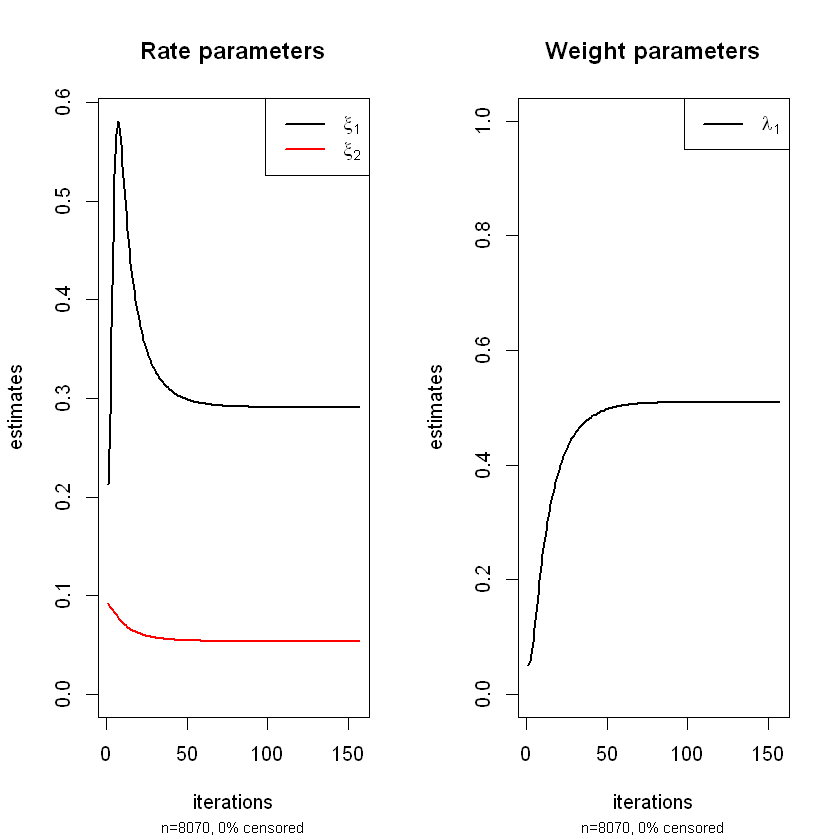

In [1024]:
plotexpRMM( fd_ME_Sep3, lwd=2 )

In [1025]:
fdME_Sep3_rate1 <- fd_ME_Sep3$rate[[1]]
fdME_Sep3_rate2 <- fd_ME_Sep3$rate[[2]]
fdME_Sep3_lambda <- fd_ME_Sep3$lambda[[1]]
fdME_Sep3_mean1 <- 1.0 / fdME_Sep3_rate1
fdME_Sep3_mean2 <- 1.0 / fdME_Sep3_rate2
fdME_Sep3_mean <- ( (fdME_Sep3_lambda * fdME_Sep3_mean1) + 
                    ( ( 1.0 - fdME_Sep3_lambda) * fdME_Sep3_mean2 ) )
fdME_Sep3_var1 <- 1.0 / (fdME_Sep3_rate1 ^ 2)
fdME_Sep3_var2 <- 1.0 / (fdME_Sep3_rate2 ^ 2)
fdME_Sep3_var <- ( (fdME_Sep3_lambda * ( fdME_Sep3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Sep3_lambda) * (fdME_Sep3_mean2 ^ 2) ) + 
                   ( fdME_Sep3_lambda * ( 1.0 - fdME_Sep3_lambda) * 
                       ( fdME_Sep3_mean1 - fdME_Sep3_mean2 )^2 ) )
fdME_Sep3_llike <- fd_ME_Sep3$loglik
cat(" Sep 3 rate1: ", fdME_Sep3_rate1, "\n", 
    "Sep 3 rate2: ", fdME_Sep3_rate2, "\n",
    "Sep 3 lambda: ", fdME_Sep3_lambda, "\n",
    "Sep 3 mean1: ", fdME_Sep3_mean1, "\n",
    "Sep 3 mean2: ", fdME_Sep3_mean2, "\n",
    "Sep 3 mean: ", fdME_Sep3_mean, "\n",
    "Sep 3 var1: ", fdME_Sep3_var1, "\n",
    "Sep 3 var2: ", fdME_Sep3_var2, "\n",
    "Sep 3 var: ", fdME_Sep3_var, "\n",
    "Sep 3 loglikelihood: ", fdME_Sep3_llike, "\n" )

 Sep 3 rate1:  0.2909968 
 Sep 3 rate2:  0.05394034 
 Sep 3 lambda:  0.5100893 
 Sep 3 mean1:  3.436463 
 Sep 3 mean2:  18.539 
 Sep 3 mean:  10.83536 
 Sep 3 var1:  11.80928 
 Sep 3 var2:  343.6945 
 Sep 3 var:  231.4019 
 Sep 3 loglikelihood:  -26563.45 


In [1026]:
tvals <- rexpmix(length(dfSep3$Precip_mm), fd_ME_Sep3$lambda, fd_ME_Sep3$rate )

In [1027]:
ksRes <- ks.test( dfSep3$Precip_mm, tvals )

Warning message in ks.test(dfSep3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1028]:
fdME_Sep3_KSStat <- ksRes$statistic
fdME_Sep3_KSp <- ksRes$p.value
cat(" Sep 3 K-S stat: ", fdME_Sep3_KSStat, "\n",
    "Sep 3 K-S p-value: ", fdME_Sep3_KSp )

 Sep 3 K-S stat:  0.03643123 
 Sep 3 K-S p-value:  4.460639e-05

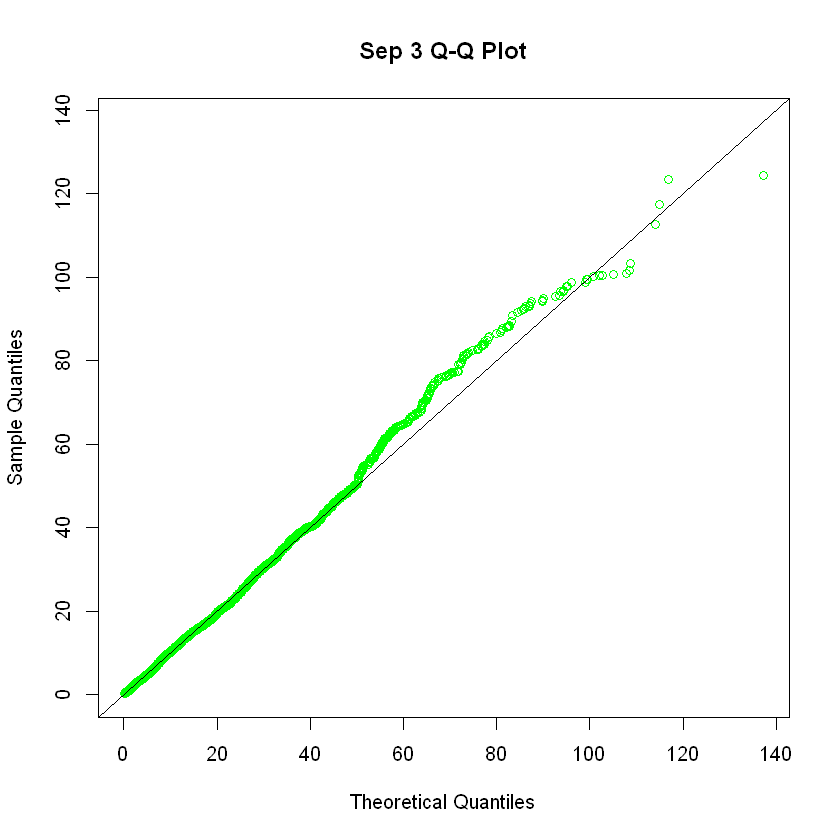

In [1029]:
wSep3Max <- max( max( dfSep3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfSep3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Sep 3 Q-Q Plot",
        xlim=c(0,wSep3Max), ylim=c(0,wSep3Max) )
abline( 0, 1)

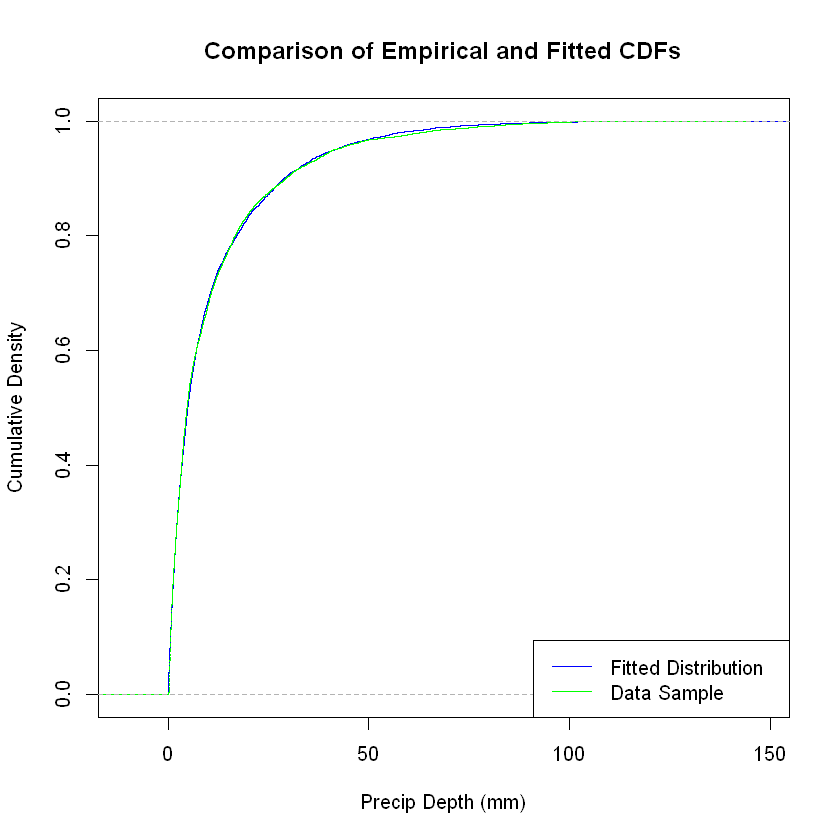

In [1030]:
x <- seq(0,wSep3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfSep3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1031]:
MonDistDF[44, ] <- list( 9, 3, fdGM_Sep3_shape, fdGM_Sep3_rate, fdGM_Sep3_llike, fdGM_Sep3_mean,
                        fdGM_Sep3_var, fdGM_Sep3_KSStat, fdGM_Sep3_KSp, fdME_Sep3_rate1,
                        fdME_Sep3_rate2, fdME_Sep3_lambda, fdME_Sep3_mean1, fdME_Sep3_mean2,
                        fdME_Sep3_mean, fdME_Sep3_var1, fdME_Sep3_var2, fdME_Sep3_var,
                        fdME_Sep3_llike, fdME_Sep3_KSStat, fdME_Sep3_KSp )

#### Region 4

**Gamma**

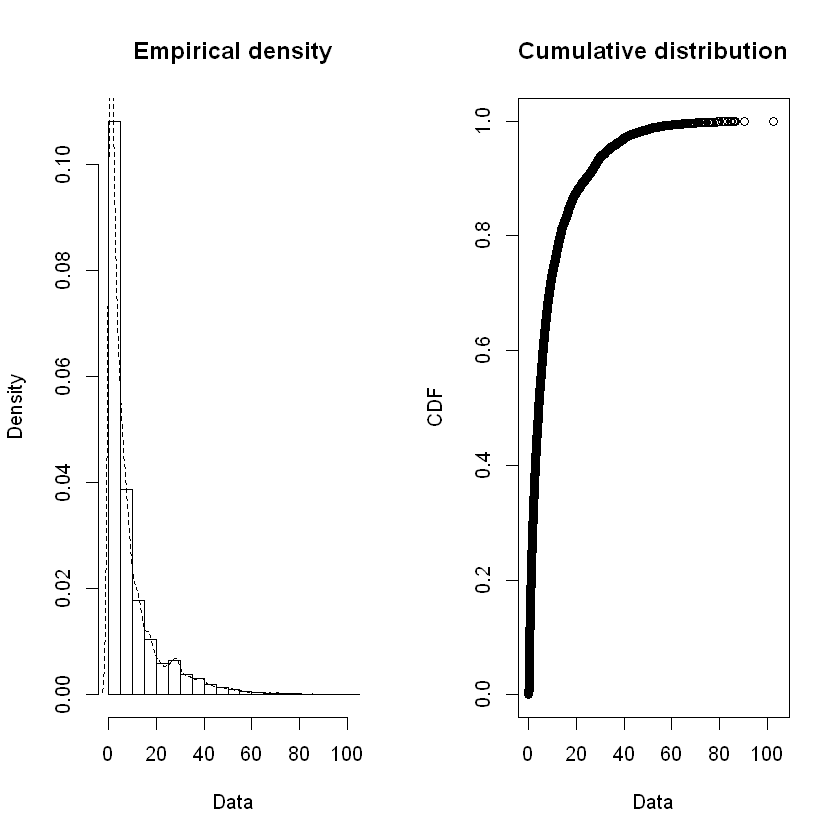

In [1032]:
plotdist( dfSep4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  102.28 
median:  4.31 
mean:  8.702118 
estimated sd:  11.52613 
estimated skewness:  2.507429 
estimated kurtosis:  10.75937 

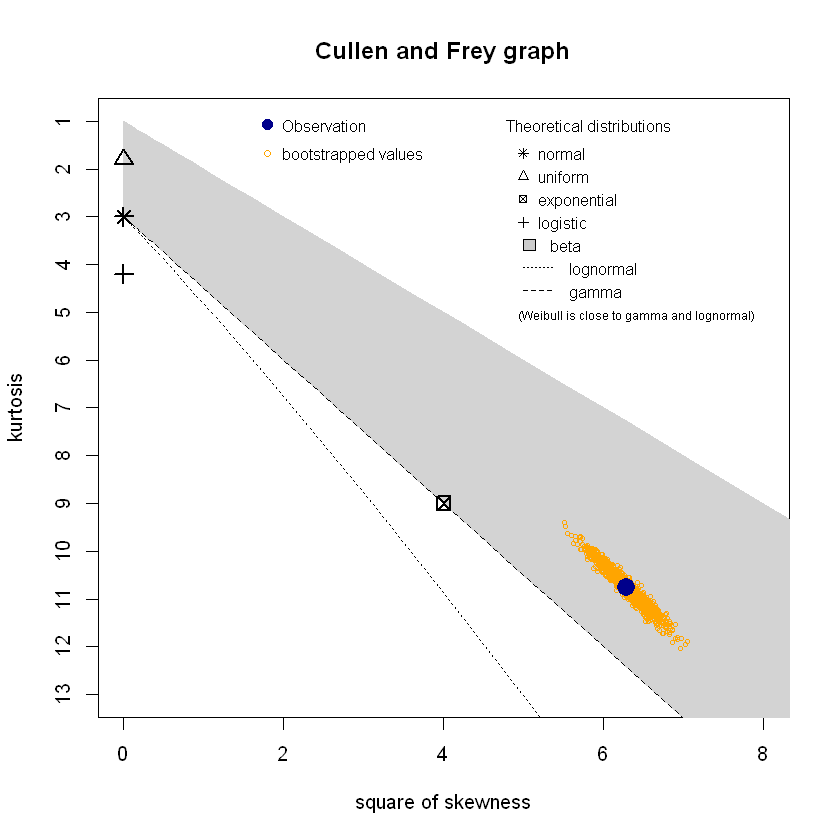

In [1033]:
descdist( dfSep4$Precip_mm, boot=1000 )

In [1034]:
fd_GM_Sep4 <- fitdist( dfSep4$Precip_mm, "gamma" )

In [1035]:
summary( fd_GM_Sep4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.76232592 0.007673639
rate  0.08760339 0.001211841
Loglikelihood:  -45665.88   AIC:  91335.77   BIC:  91350.94 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7275145
rate  0.7275145 1.0000000


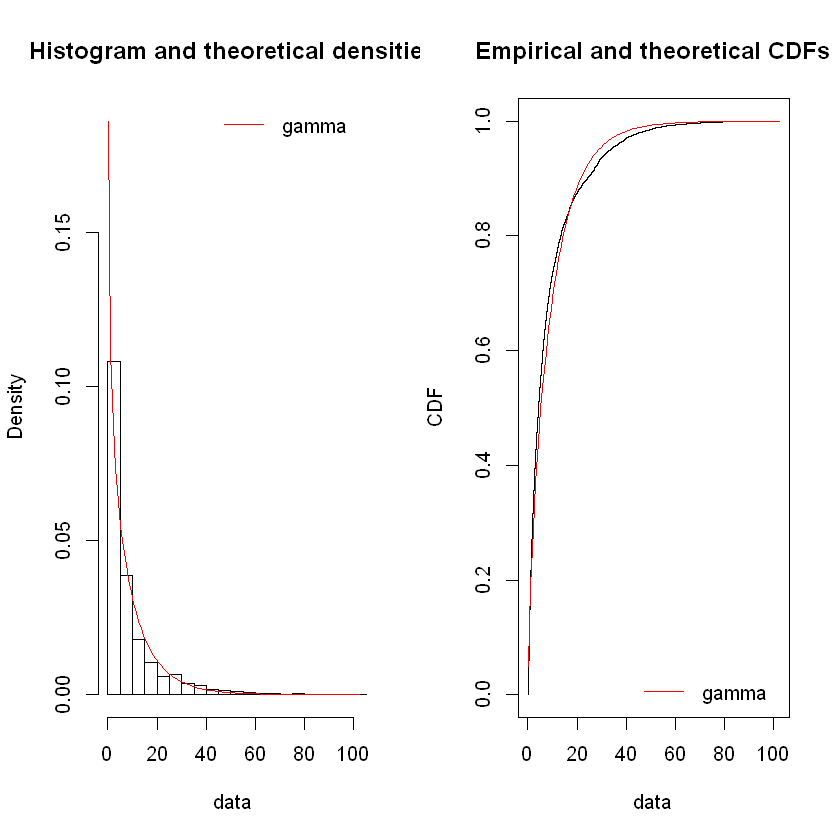

In [1036]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Sep4)
#qqcomp(fd_GM_Sep4)
cdfcomp(fd_GM_Sep4)
#ppcomp(fd_GM_Sep4)

In [1037]:
fdGM_Sep4_shape <- fd_GM_Sep4$estimate[["shape"]]
fdGM_Sep4_rate <- fd_GM_Sep4$estimate[["rate"]]
fdGM_Sep4_llike <- fd_GM_Sep4$loglik
fdGM_Sep4_mean <- fdGM_Sep4_shape / fdGM_Sep4_rate
fdGM_Sep4_var <- fdGM_Sep4_shape / ( fdGM_Sep4_rate ^ 2 )
cat(" Sep 4 shape: ", fdGM_Sep4_shape, "\n", "Sep 4 rate: ", fdGM_Sep4_rate, 
    "\n", "Sep 4 loglikelihood: ", fdGM_Sep4_llike, "\n", 
    "Sep 4 mean: ", fdGM_Sep4_mean, "\n",
    "Sep 4 variance: ", fdGM_Sep4_var, "\n" )

 Sep 4 shape:  0.7623259 
 Sep 4 rate:  0.08760339 
 Sep 4 loglikelihood:  -45665.88 
 Sep 4 mean:  8.702014 
 Sep 4 variance:  99.33421 


In [1038]:
statRes <- gofstat( fd_GM_Sep4, fitnames=c("Gamma") )

In [1039]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06047941
Cramer-von Mises statistic    23.52423015
Anderson-Darling statistic   142.45614406

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 91335.77
Bayesian Information Criterion 91350.94


In [1040]:
ksRes <- ks.test( dfSep4$Precip_mm, "pgamma", shape=fdGM_Sep4_shape, rate=fdGM_Sep4_rate )

Warning message in ks.test(dfSep4$Precip_mm, "pgamma", shape = fdGM_Sep4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1041]:
fdGM_Sep4_KSStat <- ksRes$statistic
fdGM_Sep4_KSp <- ksRes$p.value
cat(" Sep 4 K-S stat: ", fdGM_Sep4_KSStat, "\n",
    "Sep 4 K-S p-value: ", fdGM_Sep4_KSp )

 Sep 4 K-S stat:  0.06047941 
 Sep 4 K-S p-value:  0

**Mixed exponential**

In [1042]:
fd_ME_Sep4 <- expRMM_EM( dfSep4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfSep4$Precip_mm), 1.0/mean(dfSep4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 212 


In [1043]:
summary( fd_ME_Sep4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.507158 0.4928423
rate   0.314019 0.0695411
loglik at estimate:  -45110.35 
0 % of the data right censored


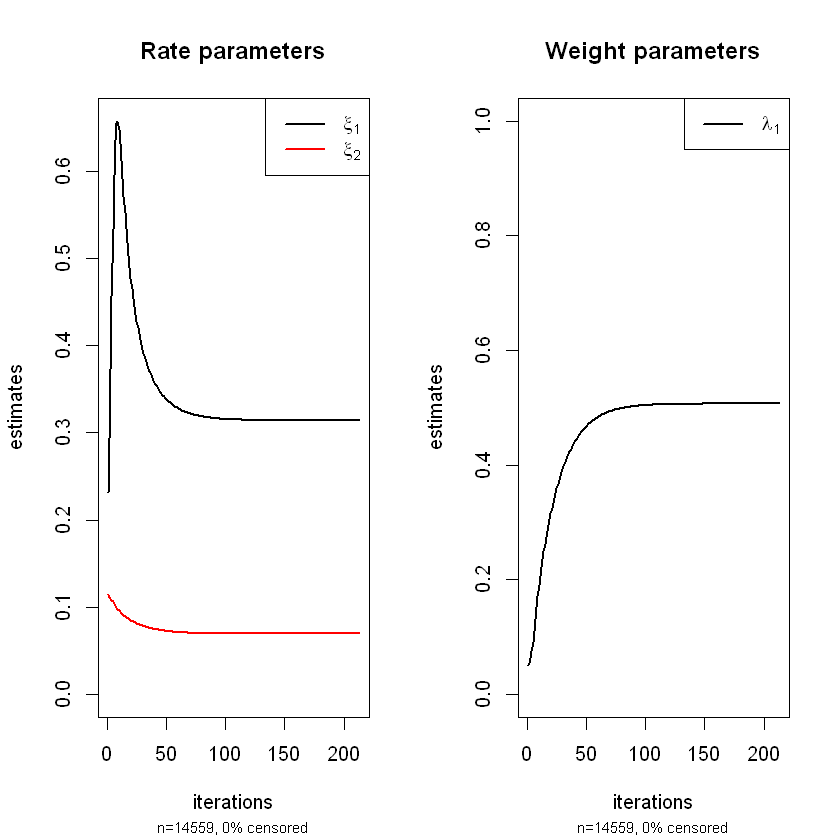

In [1044]:
plotexpRMM( fd_ME_Sep4, lwd=2 )

In [1045]:
fdME_Sep4_rate1 <- fd_ME_Sep4$rate[[1]]
fdME_Sep4_rate2 <- fd_ME_Sep4$rate[[2]]
fdME_Sep4_lambda <- fd_ME_Sep4$lambda[[1]]
fdME_Sep4_mean1 <- 1.0 / fdME_Sep4_rate1
fdME_Sep4_mean2 <- 1.0 / fdME_Sep4_rate2
fdME_Sep4_mean <- ( (fdME_Sep4_lambda * fdME_Sep4_mean1) + 
                    ( ( 1.0 - fdME_Sep4_lambda) * fdME_Sep4_mean2 ) )
fdME_Sep4_var1 <- 1.0 / (fdME_Sep4_rate1 ^ 2)
fdME_Sep4_var2 <- 1.0 / (fdME_Sep4_rate2 ^ 2)
fdME_Sep4_var <- ( (fdME_Sep4_lambda * ( fdME_Sep4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Sep4_lambda) * (fdME_Sep4_mean2 ^ 2) ) + 
                   ( fdME_Sep4_lambda * ( 1.0 - fdME_Sep4_lambda) * 
                       ( fdME_Sep4_mean1 - fdME_Sep4_mean2 )^2 ) )
fdME_Sep4_llike <- fd_ME_Sep4$loglik
cat(" Sep 4 rate1: ", fdME_Sep4_rate1, "\n", 
    "Sep 4 rate2: ", fdME_Sep4_rate2, "\n",
    "Sep 4 lambda: ", fdME_Sep4_lambda, "\n",
    "Sep 4 mean1: ", fdME_Sep4_mean1, "\n",
    "Sep 4 mean2: ", fdME_Sep4_mean2, "\n",
    "Sep 4 mean: ", fdME_Sep4_mean, "\n",
    "Sep 4 var1: ", fdME_Sep4_var1, "\n",
    "Sep 4 var2: ", fdME_Sep4_var2, "\n",
    "Sep 4 var: ", fdME_Sep4_var, "\n",
    "Sep 4 loglikelihood: ", fdME_Sep4_llike, "\n" )

 Sep 4 rate1:  0.3140191 
 Sep 4 rate2:  0.0695411 
 Sep 4 lambda:  0.5071577 
 Sep 4 mean1:  3.184519 
 Sep 4 mean2:  14.37999 
 Sep 4 mean:  8.702118 
 Sep 4 var1:  10.14116 
 Sep 4 var2:  206.784 
 Sep 4 var:  138.3832 
 Sep 4 loglikelihood:  -45110.35 


In [1046]:
tvals <- rexpmix(length(dfSep4$Precip_mm), fd_ME_Sep4$lambda, fd_ME_Sep4$rate )

In [1047]:
ksRes <- ks.test( dfSep4$Precip_mm, tvals )

Warning message in ks.test(dfSep4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1048]:
fdME_Sep4_KSStat <- ksRes$statistic
fdME_Sep4_KSp <- ksRes$p.value
cat(" Sep 4 K-S stat: ", fdME_Sep4_KSStat, "\n",
    "Sep 4 K-S p-value: ", fdME_Sep4_KSp )

 Sep 4 K-S stat:  0.03832681 
 Sep 4 K-S p-value:  1.03051e-09

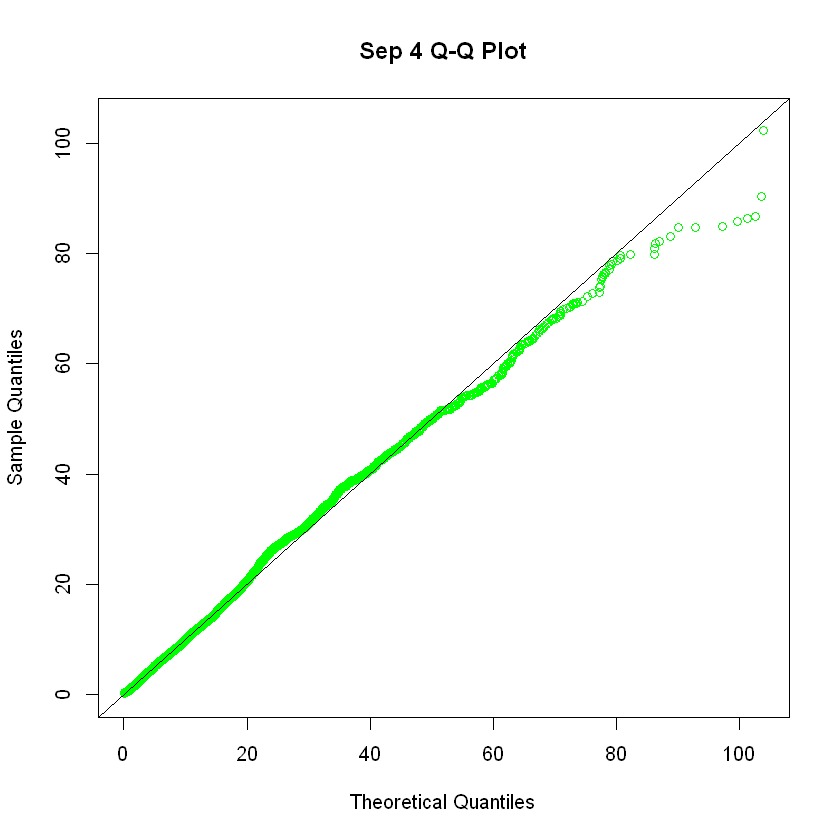

In [1049]:
wSep4Max <- max( max( dfSep4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfSep4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Sep 4 Q-Q Plot",
        xlim=c(0,wSep4Max), ylim=c(0,wSep4Max) )
abline( 0, 1)

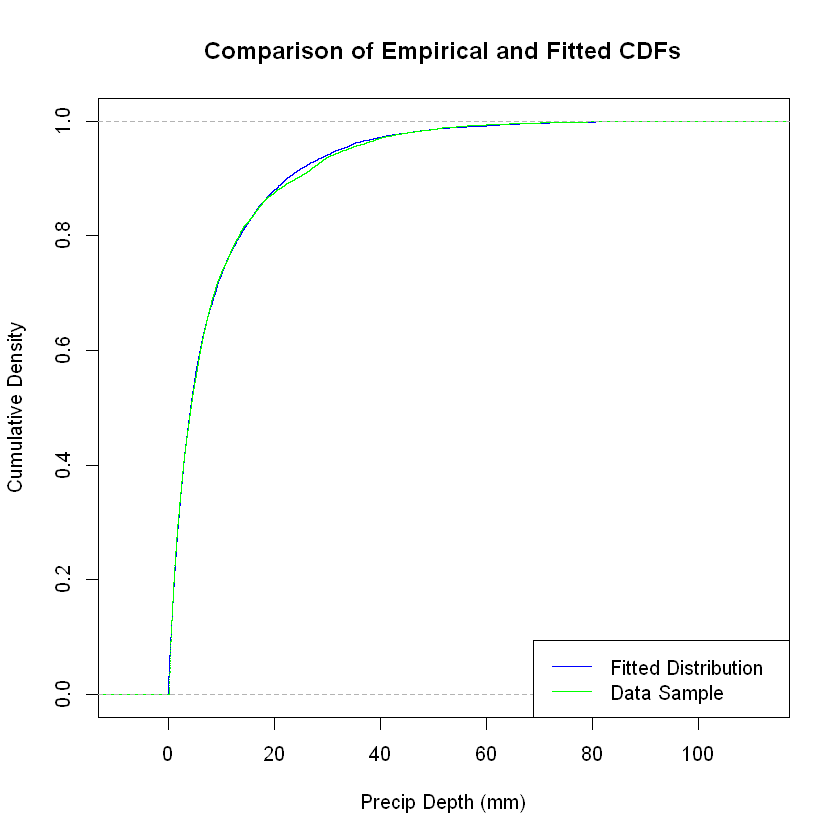

In [1050]:
x <- seq(0,wSep4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfSep4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1051]:
MonDistDF[45, ] <- list( 9, 4, fdGM_Sep4_shape, fdGM_Sep4_rate, fdGM_Sep4_llike, fdGM_Sep4_mean,
                        fdGM_Sep4_var, fdGM_Sep4_KSStat, fdGM_Sep4_KSp, fdME_Sep4_rate1,
                        fdME_Sep4_rate2, fdME_Sep4_lambda, fdME_Sep4_mean1, fdME_Sep4_mean2,
                        fdME_Sep4_mean, fdME_Sep4_var1, fdME_Sep4_var2, fdME_Sep4_var,
                        fdME_Sep4_llike, fdME_Sep4_KSStat, fdME_Sep4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

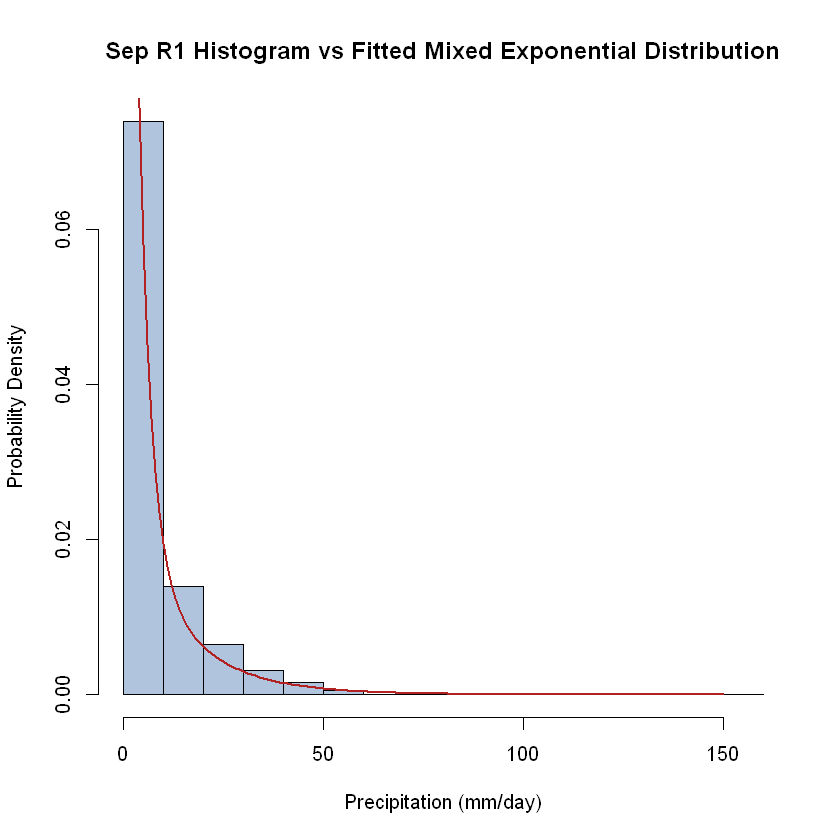

In [1052]:
xVals <- seq(1, wSep1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Sep1_lambda, spec1="exp", arg1=list(rate=fdME_Sep1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Sep1_rate2) )
hist( dfSep1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Sep R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

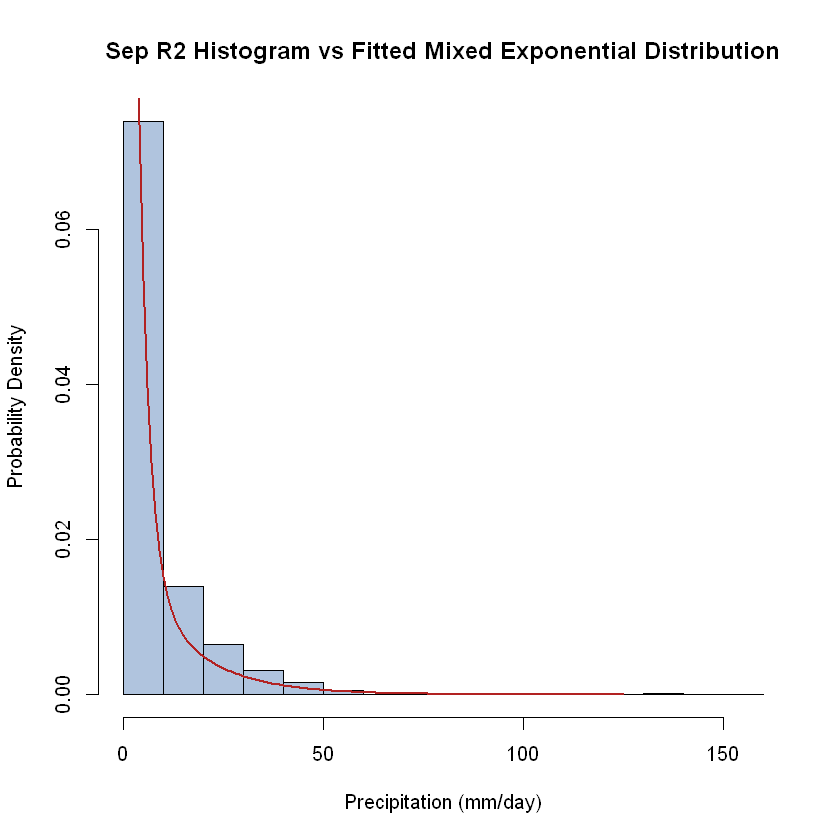

In [1053]:
xVals <- seq(1, wSep2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Sep2_lambda, spec1="exp", arg1=list(rate=fdME_Sep2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Sep2_rate2) )
hist( dfSep1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Sep R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

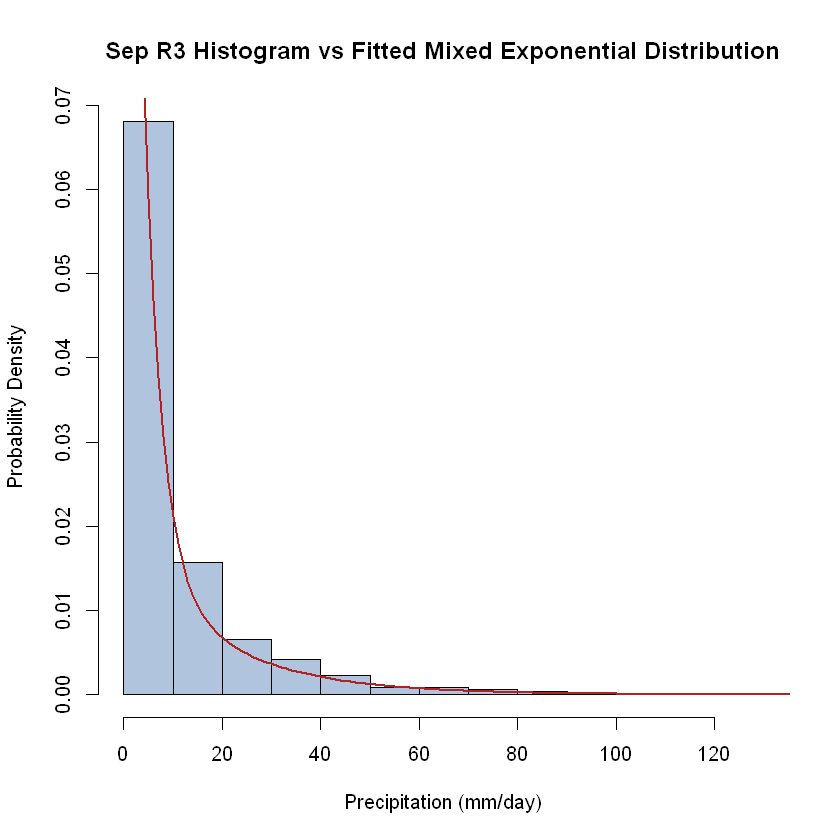

In [1054]:
xVals <- seq(1, wSep3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Sep3_lambda, spec1="exp", arg1=list(rate=fdME_Sep3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Sep3_rate2) )
hist( dfSep3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Sep R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

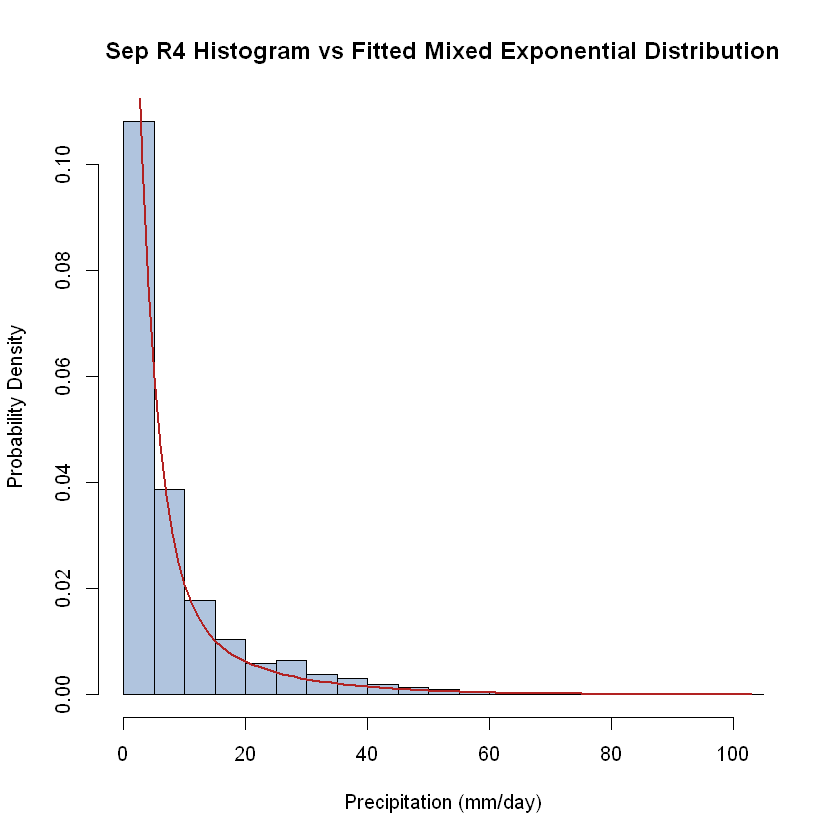

In [1055]:
xVals <- seq(1, wSep4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Sep4_lambda, spec1="exp", arg1=list(rate=fdME_Sep4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Sep4_rate2) )
hist( dfSep4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Sep R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Oct

#### All

**Gamma**

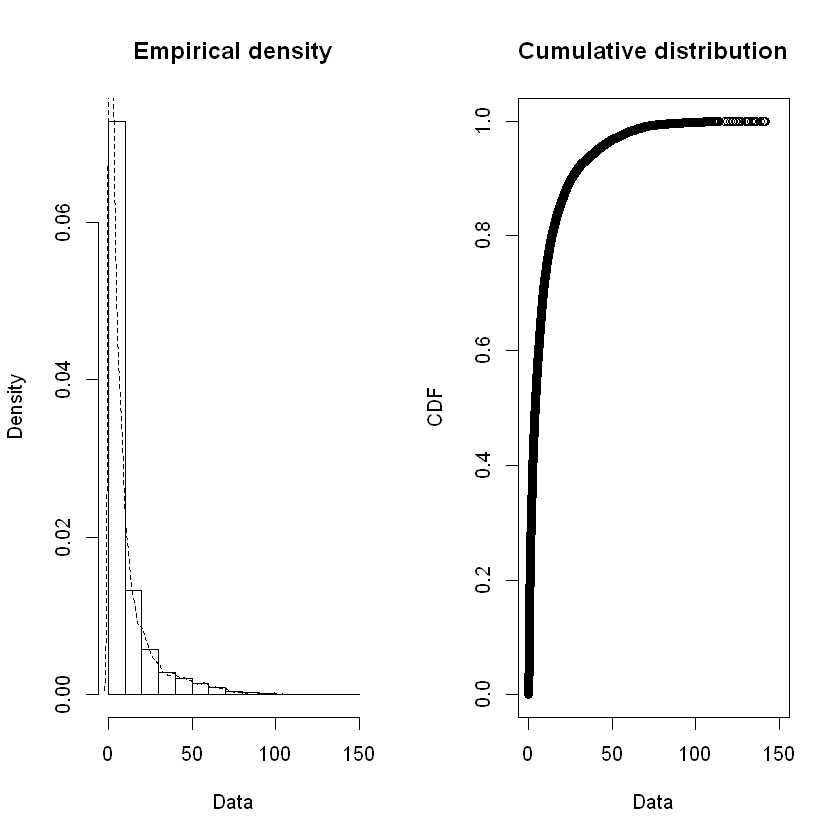

In [1056]:
plotdist( dfOct$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  141.33 
median:  4.04 
mean:  9.654667 
estimated sd:  14.54917 
estimated skewness:  2.971794 
estimated kurtosis:  14.25743 

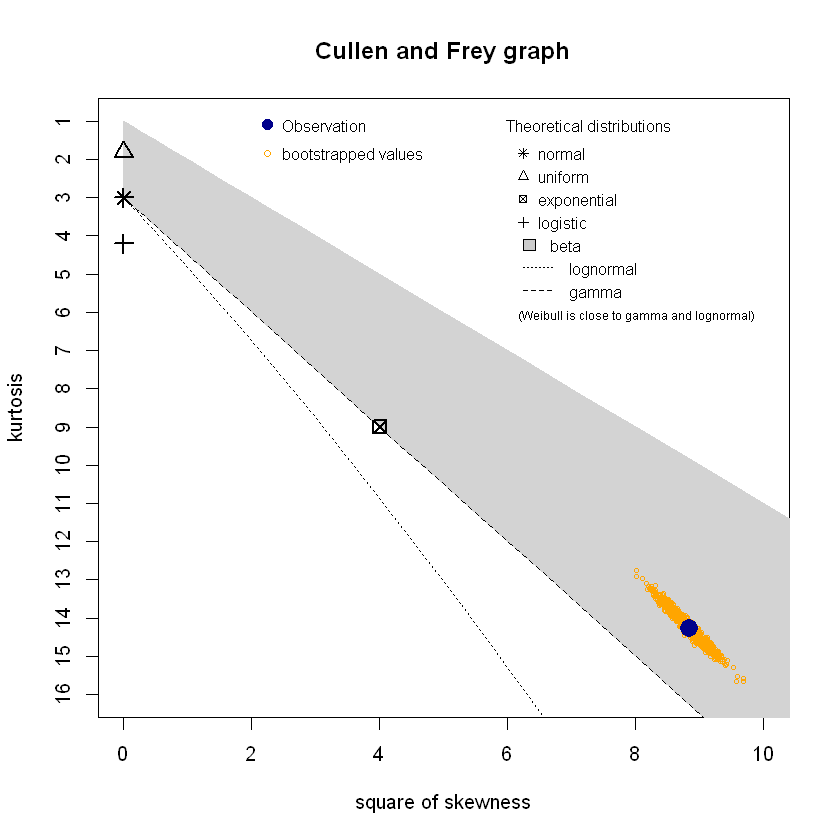

In [1057]:
descdist( dfOct$Precip_mm, boot=1000 )

In [1058]:
fd_GM_OctA <- fitdist( dfOct$Precip_mm, "gamma" )

In [1059]:
summary( fd_GM_OctA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.66673959 0.0038893327
rate  0.06905691 0.0005755872
Loglikelihood:  -135407.1   AIC:  270818.2   BIC:  270835.5 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6996213
rate  0.6996213 1.0000000


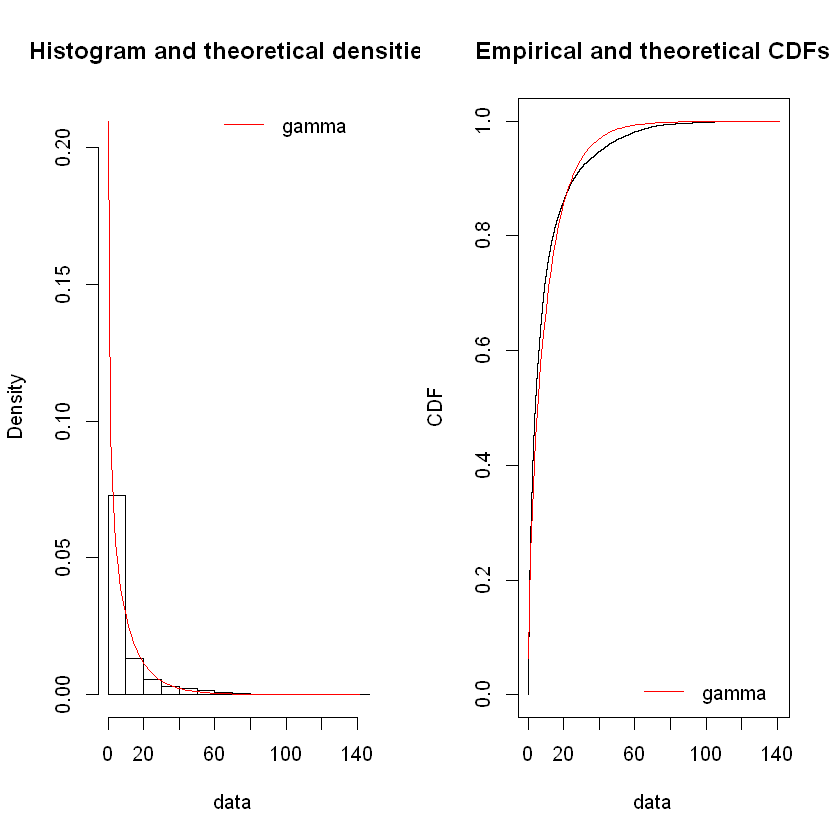

In [1060]:
par(mfrow = c(1, 2))
denscomp(fd_GM_OctA)
#qqcomp(fd_GM_OctA)
cdfcomp(fd_GM_OctA)
#ppcomp(fd_GM_OctA)

In [1061]:
fdGM_OctA_shape <- fd_GM_OctA$estimate[["shape"]]
fdGM_OctA_rate <- fd_GM_OctA$estimate[["rate"]]
fdGM_OctA_llike <- fd_GM_OctA$loglik
fdGM_OctA_mean <- fdGM_OctA_shape / fdGM_OctA_rate
fdGM_OctA_var <- fdGM_OctA_shape / ( fdGM_OctA_rate ^ 2 )
cat(" Oct A shape: ", fdGM_OctA_shape, "\n", "Oct A rate: ", fdGM_OctA_rate, 
    "\n", "Oct A loglikelihood: ", fdGM_OctA_llike, "\n", 
    "Oct A mean: ", fdGM_OctA_mean, "\n",
    "Oct A variance: ", fdGM_OctA_var, "\n" )

 Oct A shape:  0.6667396 
 Oct A rate:  0.06905691 
 Oct A loglikelihood:  -135407.1 
 Oct A mean:  9.654929 
 Oct A variance:  139.8112 


In [1062]:
statRes <- gofstat( fd_GM_OctA, fitnames=c("Gamma") )

In [1063]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.07669694
Cramer-von Mises statistic   106.41139234
Anderson-Darling statistic   634.13680214

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 270818.2
Bayesian Information Criterion 270835.5


In [1064]:
ksRes <- ks.test( dfOct$Precip_mm, "pgamma", shape=fdGM_OctA_shape, rate=fdGM_OctA_rate )

Warning message in ks.test(dfOct$Precip_mm, "pgamma", shape = fdGM_OctA_shape, rate = fdGM_OctA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [1065]:
fdGM_OctA_KSStat <- ksRes$statistic
fdGM_OctA_KSp <- ksRes$p.value
cat(" Oct A K-S stat: ", fdGM_OctA_KSStat, "\n",
    "Oct A K-S p-value: ", fdGM_OctA_KSp )

 Oct A K-S stat:  0.07669694 
 Oct A K-S p-value:  0

**Mixed Exponential**

In [1066]:
fd_ME_OctA <- expRMM_EM( dfOct$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfOct$Precip_mm), 1.0/mean(dfOct$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 167 


In [1067]:
summary( fd_ME_OctA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.570525 0.429475
rate   0.324447 0.054390
loglik at estimate:  -132836.1 
0 % of the data right censored


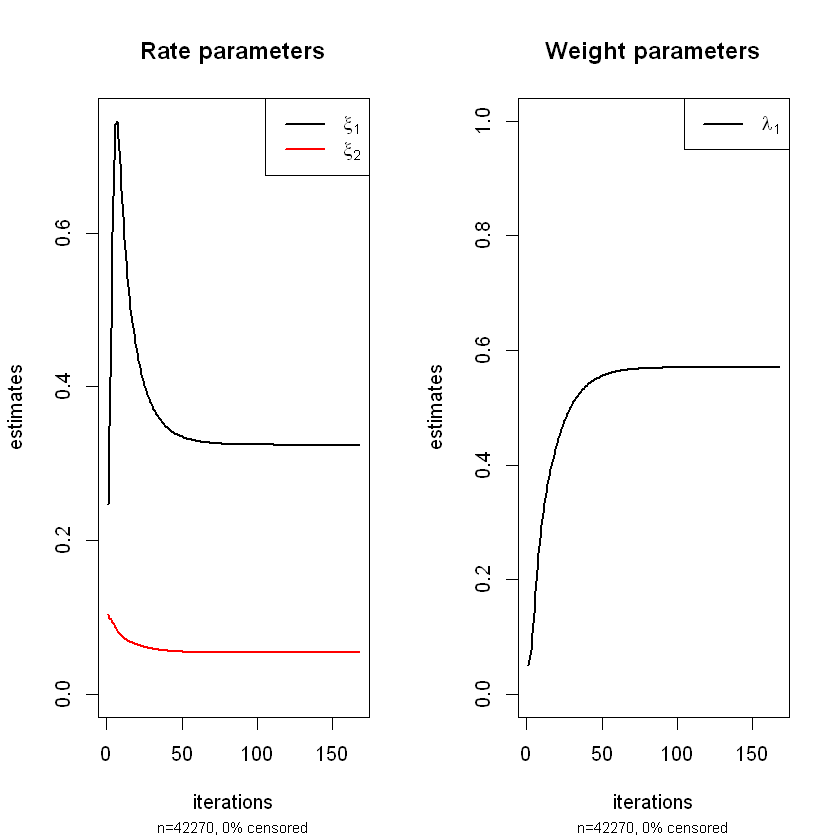

In [1068]:
plotexpRMM( fd_ME_OctA, lwd=2 )

In [1069]:
fdME_OctA_rate1 <- fd_ME_OctA$rate[[1]]
fdME_OctA_rate2 <- fd_ME_OctA$rate[[2]]
fdME_OctA_lambda <- fd_ME_OctA$lambda[[1]]
fdME_OctA_mean1 <- 1.0 / fdME_OctA_rate1
fdME_OctA_mean2 <- 1.0 / fdME_OctA_rate2
fdME_OctA_mean <- ( (fdME_OctA_lambda * fdME_OctA_mean1) + 
                    ( ( 1.0 - fdME_OctA_lambda) * fdME_OctA_mean2 ) )
fdME_OctA_var1 <- 1.0 / (fdME_OctA_rate1 ^ 2)
fdME_OctA_var2 <- 1.0 / (fdME_OctA_rate2 ^ 2)
fdME_OctA_var <- ( (fdME_OctA_lambda * ( fdME_OctA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_OctA_lambda) * (fdME_OctA_mean2 ^ 2) ) + 
                   ( fdME_OctA_lambda * ( 1.0 - fdME_OctA_lambda) * 
                       ( fdME_OctA_mean1 - fdME_OctA_mean2 )^2 ) )
fdME_OctA_llike <- fd_ME_OctA$loglik
cat(" Oct A rate1: ", fdME_OctA_rate1, "\n", 
    "Oct A rate2: ", fdME_OctA_rate2, "\n",
    "Oct A lambda: ", fdME_OctA_lambda, "\n",
    "Oct A mean1: ", fdME_OctA_mean1, "\n",
    "Oct A mean2: ", fdME_OctA_mean2, "\n",
    "Oct A mean: ", fdME_OctA_mean, "\n",
    "Oct A var1: ", fdME_OctA_var1, "\n",
    "Oct A var2: ", fdME_OctA_var2, "\n",
    "Oct A var: ", fdME_OctA_var, "\n",
    "Oct A loglikelihood: ", fdME_OctA_llike, "\n" )

 Oct A rate1:  0.324447 
 Oct A rate2:  0.05439004 
 Oct A lambda:  0.5705246 
 Oct A mean1:  3.082168 
 Oct A mean2:  18.38572 
 Oct A mean:  9.654667 
 Oct A var1:  9.499758 
 Oct A var2:  338.0346 
 Oct A var:  207.9822 
 Oct A loglikelihood:  -132836.1 


In [1070]:
tvals <- rexpmix(length(dfOct$Precip_mm), fd_ME_OctA$lambda, fd_ME_OctA$rate )

In [1071]:
ksRes <- ks.test( dfOct$Precip_mm, tvals )

Warning message in ks.test(dfOct$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1072]:
fdME_OctA_KSStat <- ksRes$statistic
fdME_OctA_KSp <- ksRes$p.value
cat(" Oct A K-S stat: ", fdME_OctA_KSStat, "\n",
    "Oct A K-S p-value: ", fdME_OctA_KSp )

 Oct A K-S stat:  0.04144784 
 Oct A K-S p-value:  0

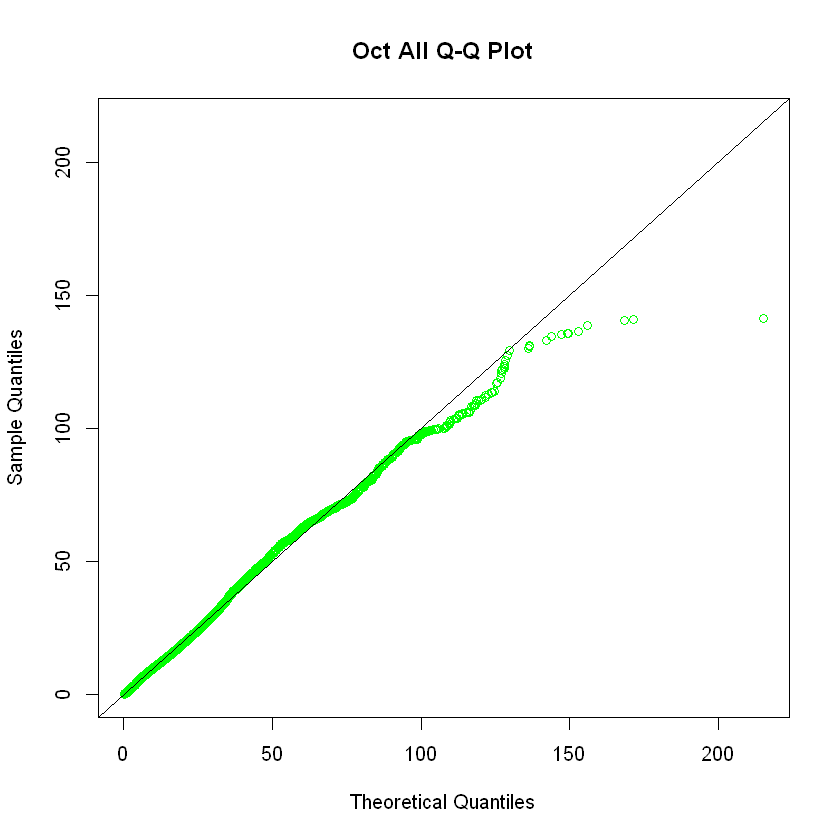

In [1073]:
wOctAMax <- max( max( dfOct$Precip_mm ), max( tvals ) )
qqplot( tvals, dfOct$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Oct All Q-Q Plot",
        xlim=c(0,wOctAMax), ylim=c(0,wOctAMax) )
abline( 0, 1)

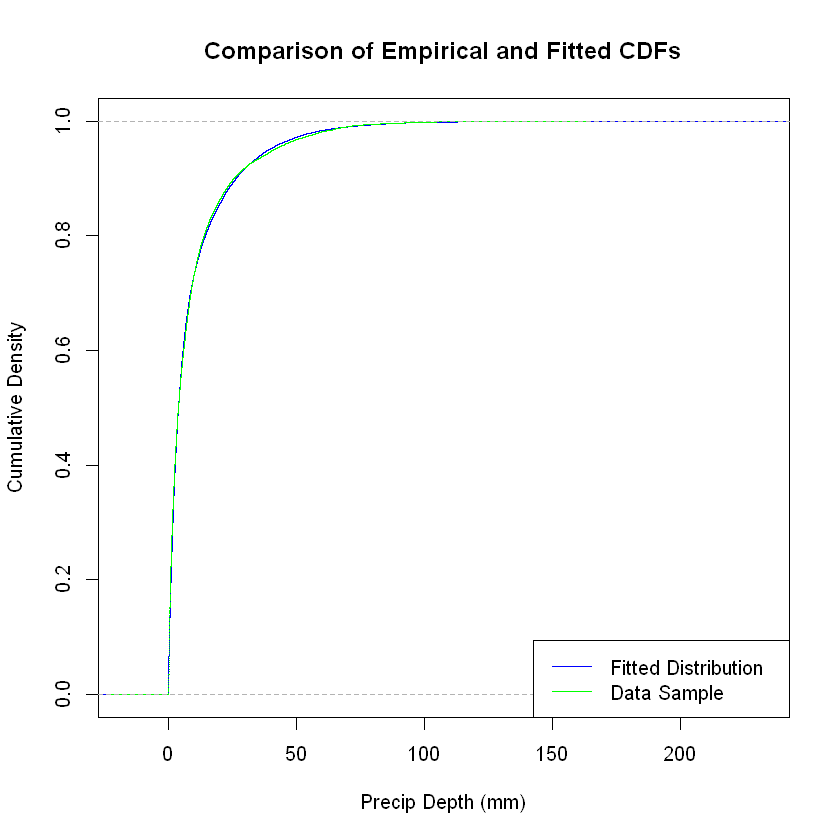

In [1074]:
x <- seq(0,wOctAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfOct$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [1075]:
MonDistDF[46, ] <- list( 10, 0, fdGM_OctA_shape, fdGM_OctA_rate, fdGM_OctA_llike, fdGM_OctA_mean,
                        fdGM_OctA_var, fdGM_OctA_KSStat, fdGM_OctA_KSp, fdME_OctA_rate1,
                        fdME_OctA_rate2, fdME_OctA_lambda, fdME_OctA_mean1, fdME_OctA_mean2,
                        fdME_OctA_mean, fdME_OctA_var1, fdME_OctA_var2, fdME_OctA_var,
                        fdME_OctA_llike, fdME_OctA_KSStat, fdME_OctA_KSp )

#### Region 1

**Gamma**

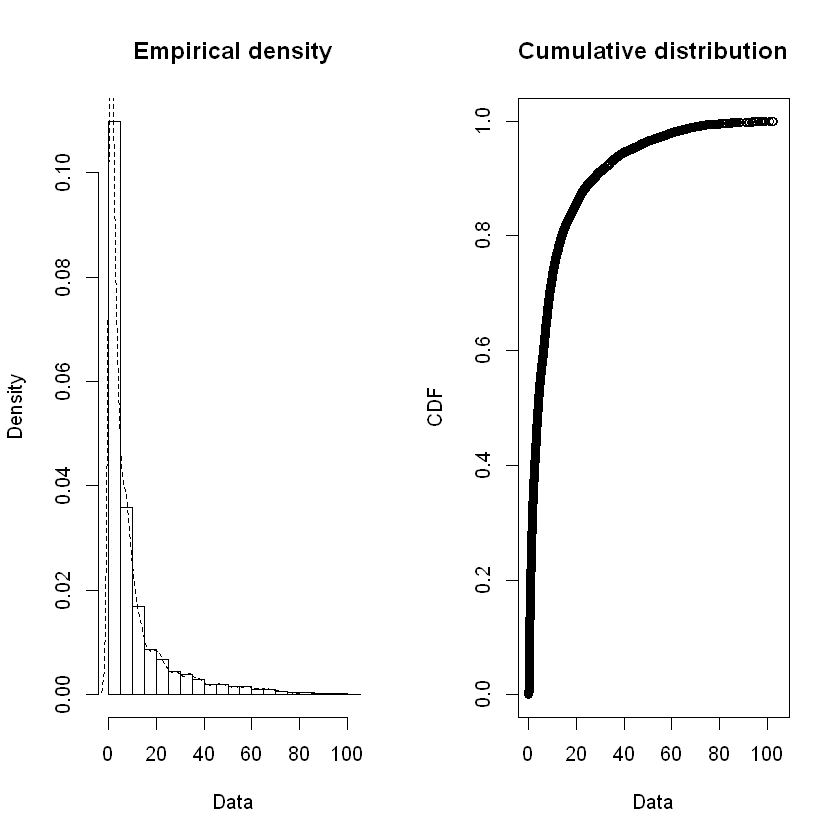

In [1076]:
plotdist( dfOct1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  102.44 
median:  4.05 
mean:  9.768645 
estimated sd:  14.48864 
estimated skewness:  2.663631 
estimated kurtosis:  10.95938 

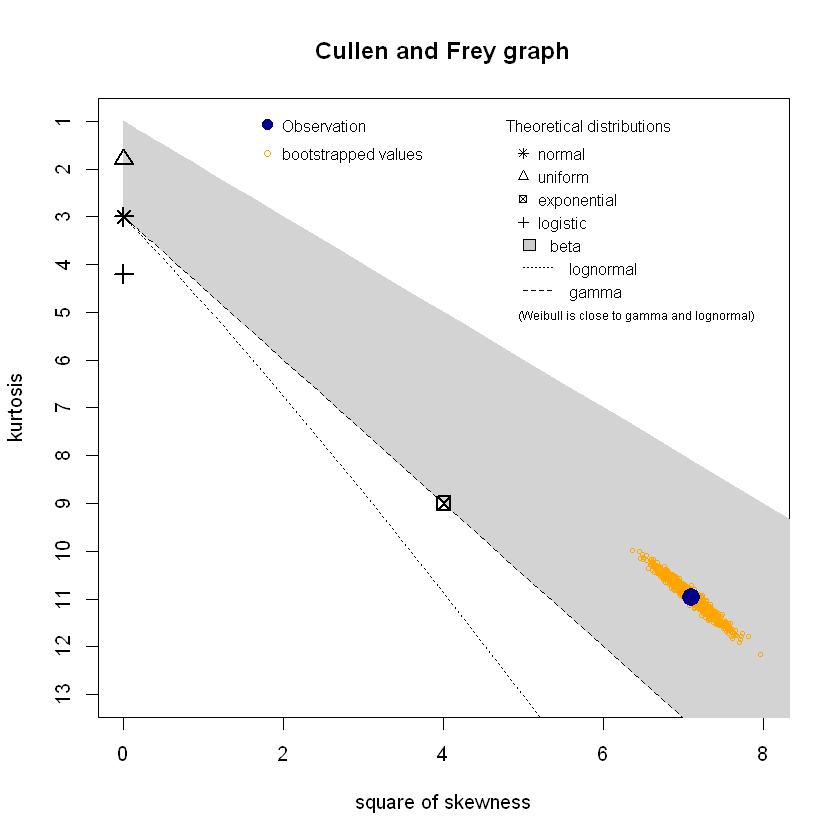

In [1077]:
descdist( dfOct1$Precip_mm, boot=1000 )

In [1078]:
fd_GM_Oct1 <- fitdist( dfOct1$Precip_mm, "gamma" )

In [1079]:
summary( fd_GM_Oct1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate   Std. Error
shape 0.66219284 0.0067517189
rate  0.06778365 0.0009895551
Loglikelihood:  -44390.29   AIC:  88784.58   BIC:  88799.65 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6981636
rate  0.6981636 1.0000000


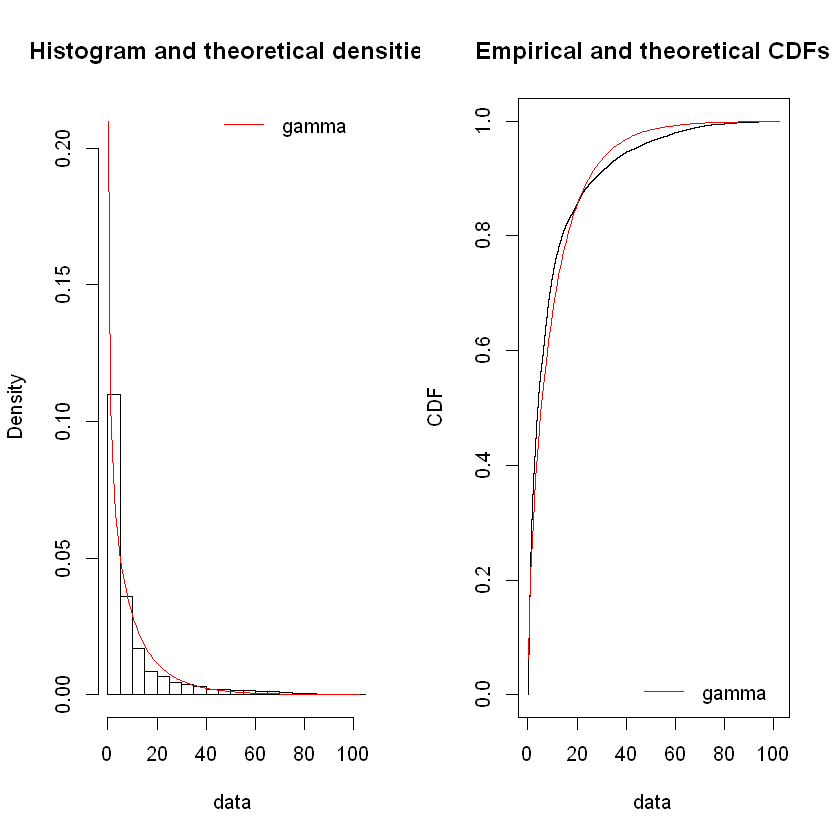

In [1080]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Oct1)
#qqcomp(fd_GM_Oct1)
cdfcomp(fd_GM_Oct1)
#ppcomp(fd_GM_Oct1)

In [1081]:
fdGM_Oct1_shape <- fd_GM_Oct1$estimate[["shape"]]
fdGM_Oct1_rate <- fd_GM_Oct1$estimate[["rate"]]
fdGM_Oct1_llike <- fd_GM_Oct1$loglik
fdGM_Oct1_mean <- fdGM_Oct1_shape / fdGM_Oct1_rate
fdGM_Oct1_var <- fdGM_Oct1_shape / ( fdGM_Oct1_rate ^ 2 )
cat(" Oct 1 shape: ", fdGM_Oct1_shape, "\n", "Oct 1 rate: ", fdGM_Oct1_rate, 
    "\n", "Oct 1 loglikelihood: ", fdGM_Oct1_llike, "\n", 
    "Oct 1 mean: ", fdGM_Oct1_mean, "\n",
    "Oct 1 variance: ", fdGM_Oct1_var, "\n" )

 Oct 1 shape:  0.6621928 
 Oct 1 rate:  0.06778365 
 Oct 1 loglikelihood:  -44390.29 
 Oct 1 mean:  9.769212 
 Oct 1 variance:  144.1234 


In [1082]:
statRes <- gofstat( fd_GM_Oct1, fitnames=c("Gamma") )

In [1083]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.07854106
Cramer-von Mises statistic    36.59863311
Anderson-Darling statistic   220.41018359

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 88784.58
Bayesian Information Criterion 88799.65


In [1084]:
ksRes <- ks.test( dfOct1$Precip_mm, "pgamma", shape=fdGM_Oct1_shape, rate=fdGM_Oct1_rate )

Warning message in ks.test(dfOct1$Precip_mm, "pgamma", shape = fdGM_Oct1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1085]:
fdGM_Oct1_KSStat <- ksRes$statistic
fdGM_Oct1_KSp <- ksRes$p.value
cat(" Oct 1 K-S stat: ", fdGM_Oct1_KSStat, "\n",
    "Oct 1 K-S p-value: ", fdGM_Oct1_KSp )

 Oct 1 K-S stat:  0.07854106 
 Oct 1 K-S p-value:  0

**Mixed exponential**

In [1086]:
fd_ME_Oct1 <- expRMM_EM( dfOct1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfOct1$Precip_mm), 1.0/mean(dfOct1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 159 


In [1087]:
summary( fd_ME_Oct1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.569641 0.4303589
rate   0.326791 0.0536239
loglik at estimate:  -43525.78 
0 % of the data right censored


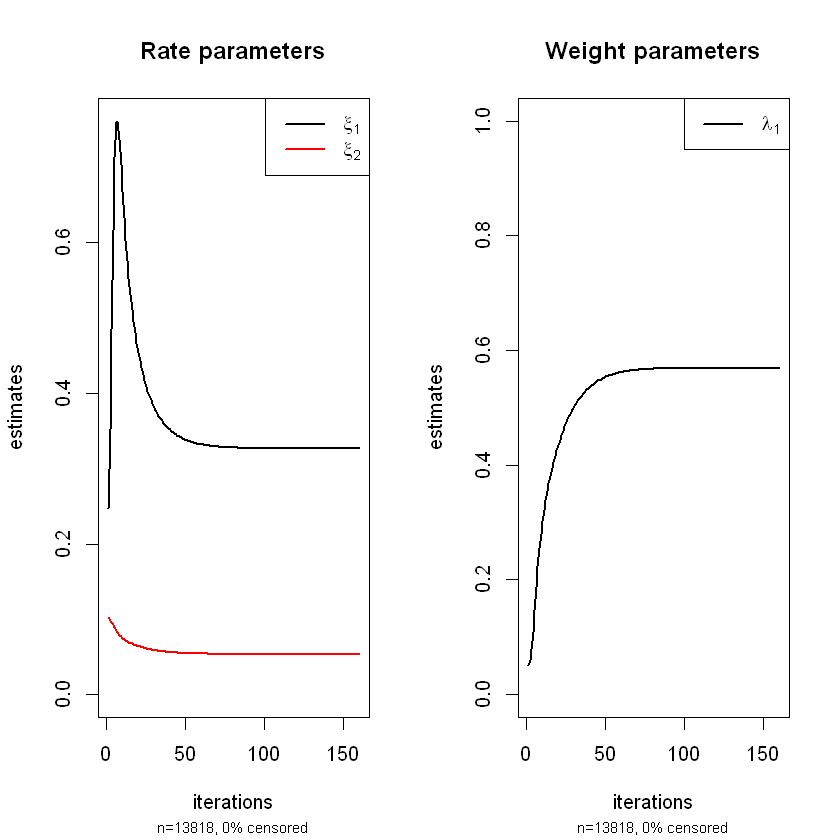

In [1088]:
plotexpRMM( fd_ME_Oct1, lwd=2 )

In [1089]:
fdME_Oct1_rate1 <- fd_ME_Oct1$rate[[1]]
fdME_Oct1_rate2 <- fd_ME_Oct1$rate[[2]]
fdME_Oct1_lambda <- fd_ME_Oct1$lambda[[1]]
fdME_Oct1_mean1 <- 1.0 / fdME_Oct1_rate1
fdME_Oct1_mean2 <- 1.0 / fdME_Oct1_rate2
fdME_Oct1_mean <- ( (fdME_Oct1_lambda * fdME_Oct1_mean1) + 
                    ( ( 1.0 - fdME_Oct1_lambda) * fdME_Oct1_mean2 ) )
fdME_Oct1_var1 <- 1.0 / (fdME_Oct1_rate1 ^ 2)
fdME_Oct1_var2 <- 1.0 / (fdME_Oct1_rate2 ^ 2)
fdME_Oct1_var <- ( (fdME_Oct1_lambda * ( fdME_Oct1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Oct1_lambda) * (fdME_Oct1_mean2 ^ 2) ) + 
                   ( fdME_Oct1_lambda * ( 1.0 - fdME_Oct1_lambda) * 
                       ( fdME_Oct1_mean1 - fdME_Oct1_mean2 )^2 ) )
fdME_Oct1_llike <- fd_ME_Oct1$loglik
cat(" Oct 1 rate1: ", fdME_Oct1_rate1, "\n", 
    "Oct 1 rate2: ", fdME_Oct1_rate2, "\n",
    "Oct 1 lambda: ", fdME_Oct1_lambda, "\n",
    "Oct 1 mean1: ", fdME_Oct1_mean1, "\n",
    "Oct 1 mean2: ", fdME_Oct1_mean2, "\n",
    "Oct 1 mean: ", fdME_Oct1_mean, "\n",
    "Oct 1 var1: ", fdME_Oct1_var1, "\n",
    "Oct 1 var2: ", fdME_Oct1_var2, "\n",
    "Oct 1 var: ", fdME_Oct1_var, "\n",
    "Oct 1 loglikelihood: ", fdME_Oct1_llike, "\n" )

 Oct 1 rate1:  0.3267911 
 Oct 1 rate2:  0.05362387 
 Oct 1 lambda:  0.5696411 
 Oct 1 mean1:  3.060059 
 Oct 1 mean2:  18.64841 
 Oct 1 mean:  9.768645 
 Oct 1 var1:  9.363962 
 Oct 1 var2:  347.7633 
 Oct 1 var:  214.5678 
 Oct 1 loglikelihood:  -43525.78 


In [1090]:
tvals <- rexpmix(length(dfOct1$Precip_mm), fd_ME_Oct1$lambda, fd_ME_Oct1$rate )

In [1091]:
ksRes <- ks.test( dfOct1$Precip_mm, tvals )

Warning message in ks.test(dfOct1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1092]:
fdME_Oct1_KSStat <- ksRes$statistic
fdME_Oct1_KSp <- ksRes$p.value
cat(" Oct 1 K-S stat: ", fdME_Oct1_KSStat, "\n",
    "Oct 1 K-S p-value: ", fdME_Oct1_KSp )

 Oct 1 K-S stat:  0.0427703 
 Oct 1 K-S p-value:  2.105038e-11

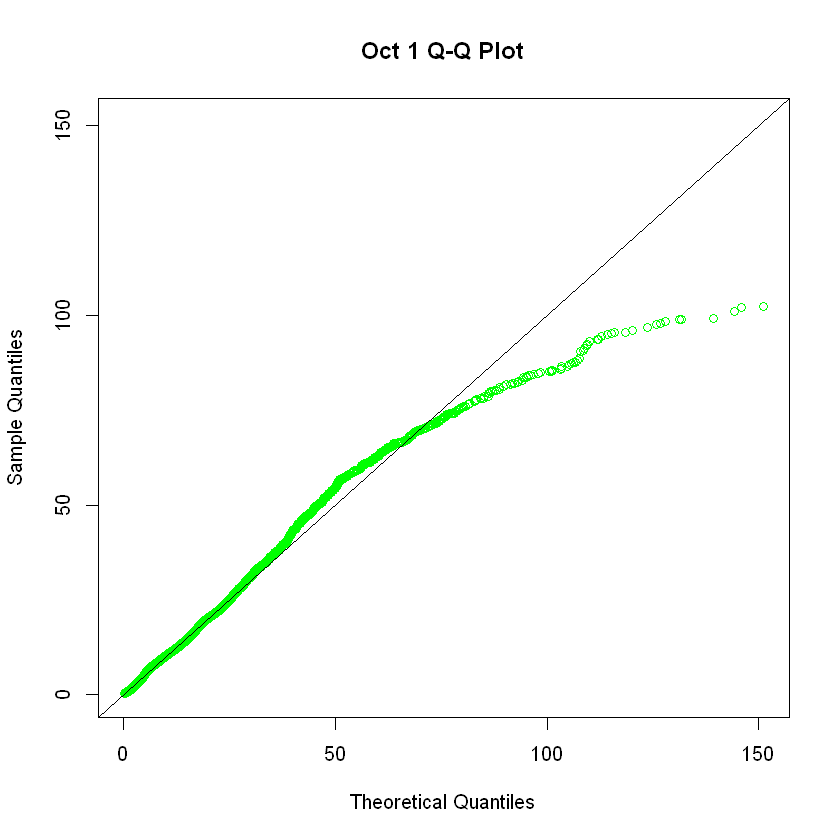

In [1093]:
wOct1Max <- max( max( dfOct1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfOct1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Oct 1 Q-Q Plot",
        xlim=c(0,wOct1Max), ylim=c(0,wOct1Max) )
abline( 0, 1)

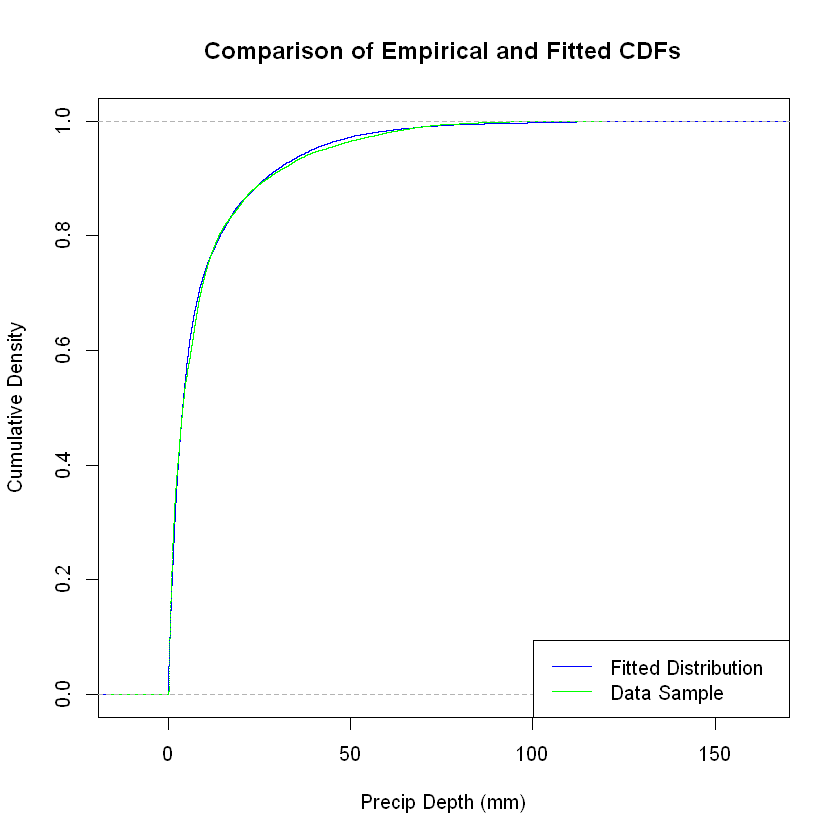

In [1094]:
x <- seq(0,wOct1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfOct1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1095]:
MonDistDF[47, ] <- list( 10, 1, fdGM_Oct1_shape, fdGM_Oct1_rate, fdGM_Oct1_llike, fdGM_Oct1_mean,
                        fdGM_Oct1_var, fdGM_Oct1_KSStat, fdGM_Oct1_KSp, fdME_Oct1_rate1,
                        fdME_Oct1_rate2, fdME_Oct1_lambda, fdME_Oct1_mean1, fdME_Oct1_mean2,
                        fdME_Oct1_mean, fdME_Oct1_var1, fdME_Oct1_var2, fdME_Oct1_var,
                        fdME_Oct1_llike, fdME_Oct1_KSStat, fdME_Oct1_KSp )

#### Region 2

**Gamma**

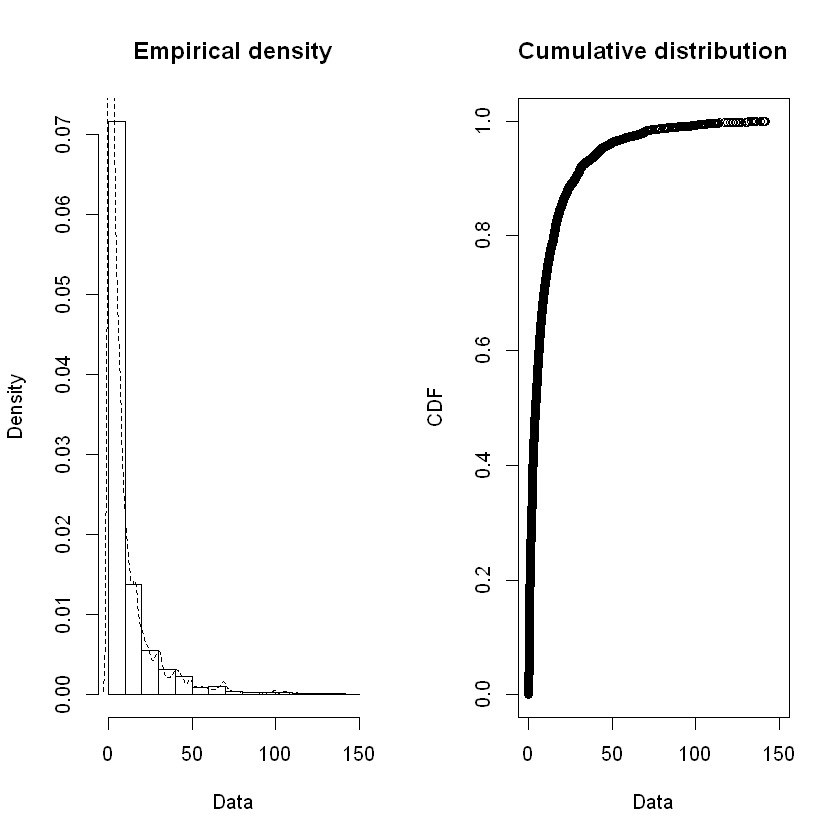

In [1096]:
plotdist( dfOct2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  141.33 
median:  4.33 
mean:  10.50022 
estimated sd:  16.90167 
estimated skewness:  3.411488 
estimated kurtosis:  17.75899 

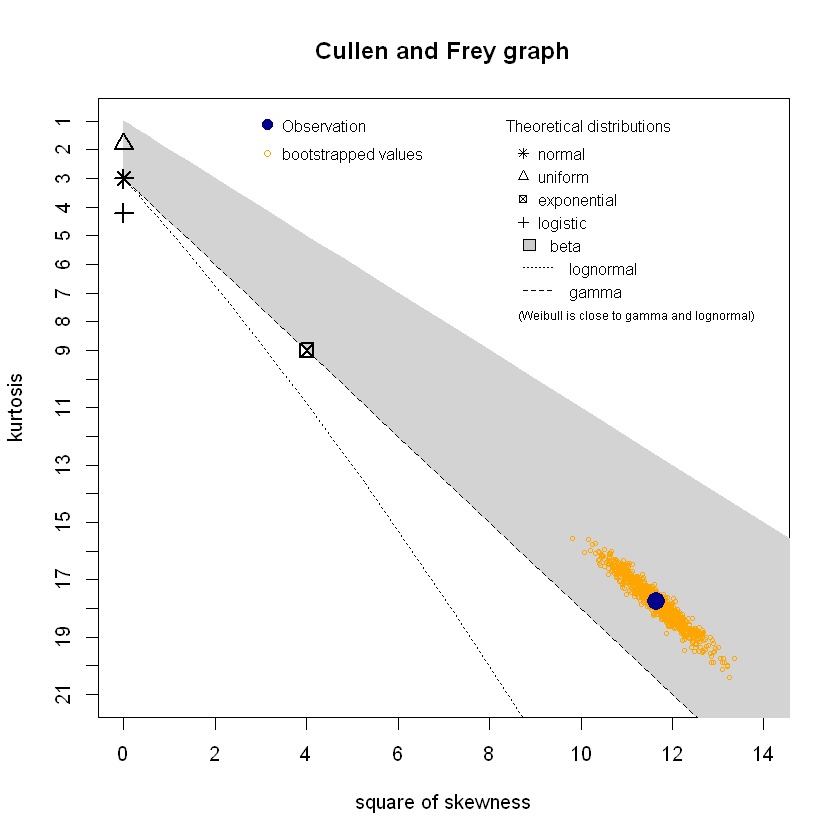

In [1097]:
descdist( dfOct2$Precip_mm, boot=1000 )

In [1098]:
fd_GM_Oct2 <- fitdist( dfOct2$Precip_mm, "gamma" )

In [1099]:
summary( fd_GM_Oct2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.64100051 0.008214471
rate  0.06103346 0.001131088
Loglikelihood:  -28450.92   AIC:  56905.84   BIC:  56919.98 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6911916
rate  0.6911916 1.0000000


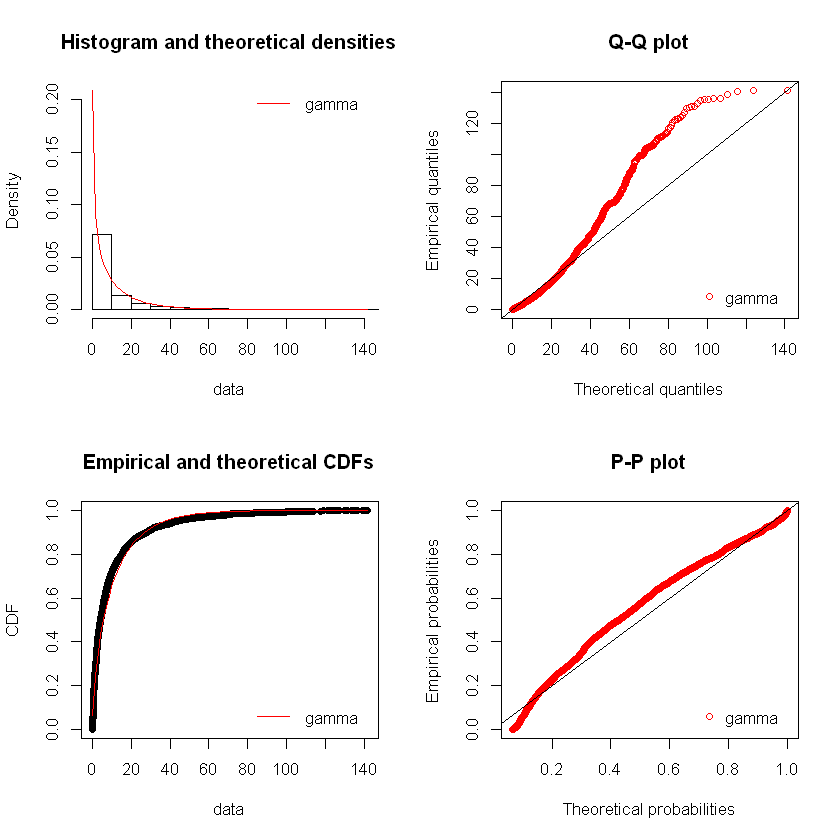

In [1100]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Oct2)
qqcomp(fd_GM_Oct2)
cdfcomp(fd_GM_Oct2)
ppcomp(fd_GM_Oct2)

In [1101]:
fdGM_Oct2_shape <- fd_GM_Oct2$estimate[["shape"]]
fdGM_Oct2_rate <- fd_GM_Oct2$estimate[["rate"]]
fdGM_Oct2_llike <- fd_GM_Oct2$loglik
fdGM_Oct2_mean <- fdGM_Oct2_shape / fdGM_Oct2_rate
fdGM_Oct2_var <- fdGM_Oct2_shape / ( fdGM_Oct2_rate ^ 2 )
cat(" Oct 2 shape: ", fdGM_Oct2_shape, "\n", "Oct 2 rate: ", fdGM_Oct2_rate, 
    "\n", "Oct 2 loglikelihood: ", fdGM_Oct2_llike, "\n", 
    "Oct 2 mean: ", fdGM_Oct2_mean, "\n",
    "Oct 2 variance: ", fdGM_Oct2_var, "\n" )

 Oct 2 shape:  0.6410005 
 Oct 2 rate:  0.06103346 
 Oct 2 loglikelihood:  -28450.92 
 Oct 2 mean:  10.50244 
 Oct 2 variance:  172.0768 


In [1102]:
statRes <- gofstat( fd_GM_Oct2, fitnames=c("Gamma") )

In [1103]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.08053464
Cramer-von Mises statistic    23.11804582
Anderson-Darling statistic   135.59036117

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 56905.84
Bayesian Information Criterion 56919.98


In [1104]:
ksRes <- ks.test( dfOct2$Precip_mm, "pgamma", shape=fdGM_Oct2_shape, rate=fdGM_Oct2_rate )

Warning message in ks.test(dfOct2$Precip_mm, "pgamma", shape = fdGM_Oct2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1105]:
fdGM_Oct2_KSStat <- ksRes$statistic
fdGM_Oct2_KSp <- ksRes$p.value
cat(" Oct 2 K-S stat: ", fdGM_Oct2_KSStat, "\n",
    "Oct 2 K-S p-value: ", fdGM_Oct2_KSp )

 Oct 2 K-S stat:  0.08053464 
 Oct 2 K-S p-value:  0

**Mixed exponential**

In [1106]:
fd_ME_Oct2 <- expRMM_EM( dfOct2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfOct2$Precip_mm), 1.0/mean(dfOct2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 152 


In [1107]:
summary( fd_ME_Oct2 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.602806 0.397194
rate   0.294516 0.046986
loglik at estimate:  -27885.62 
0 % of the data right censored


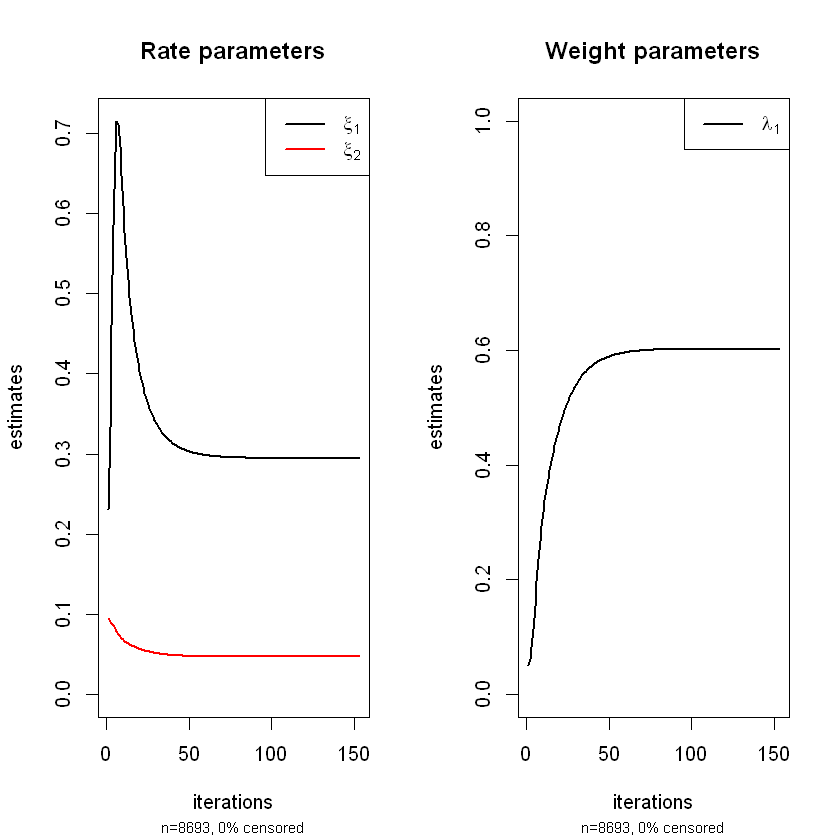

In [1108]:
plotexpRMM( fd_ME_Oct2, lwd=2 )

In [1109]:
fdME_Oct2_rate1 <- fd_ME_Oct2$rate[[1]]
fdME_Oct2_rate2 <- fd_ME_Oct2$rate[[2]]
fdME_Oct2_lambda <- fd_ME_Oct2$lambda[[1]]
fdME_Oct2_mean1 <- 1.0 / fdME_Oct2_rate1
fdME_Oct2_mean2 <- 1.0 / fdME_Oct2_rate2
fdME_Oct2_mean <- ( (fdME_Oct2_lambda * fdME_Oct2_mean1) + 
                    ( ( 1.0 - fdME_Oct2_lambda) * fdME_Oct2_mean2 ) )
fdME_Oct2_var1 <- 1.0 / (fdME_Oct2_rate1 ^ 2)
fdME_Oct2_var2 <- 1.0 / (fdME_Oct2_rate2 ^ 2)
fdME_Oct2_var <- ( (fdME_Oct2_lambda * ( fdME_Oct2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Oct2_lambda) * (fdME_Oct2_mean2 ^ 2) ) + 
                   ( fdME_Oct2_lambda * ( 1.0 - fdME_Oct2_lambda) * 
                       ( fdME_Oct2_mean1 - fdME_Oct2_mean2 )^2 ) )
fdME_Oct2_llike <- fd_ME_Oct2$loglik
cat(" Oct 2 rate1: ", fdME_Oct2_rate1, "\n", 
    "Oct 2 rate2: ", fdME_Oct2_rate2, "\n",
    "Oct 2 lambda: ", fdME_Oct2_lambda, "\n",
    "Oct 2 mean1: ", fdME_Oct2_mean1, "\n",
    "Oct 2 mean2: ", fdME_Oct2_mean2, "\n",
    "Oct 2 mean: ", fdME_Oct2_mean, "\n",
    "Oct 2 var1: ", fdME_Oct2_var1, "\n",
    "Oct 2 var2: ", fdME_Oct2_var2, "\n",
    "Oct 2 var: ", fdME_Oct2_var, "\n",
    "Oct 2 loglikelihood: ", fdME_Oct2_llike, "\n" )

 Oct 2 rate1:  0.2945158 
 Oct 2 rate2:  0.046986 
 Oct 2 lambda:  0.602806 
 Oct 2 mean1:  3.395404 
 Oct 2 mean2:  21.28294 
 Oct 2 mean:  10.50022 
 Oct 2 var1:  11.52877 
 Oct 2 var2:  452.9633 
 Oct 2 var:  263.4731 
 Oct 2 loglikelihood:  -27885.62 


In [1110]:
tvals <- rexpmix(length(dfOct2$Precip_mm), fd_ME_Oct2$lambda, fd_ME_Oct2$rate )

In [1111]:
ksRes <- ks.test( dfOct2$Precip_mm, tvals )

Warning message in ks.test(dfOct2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1112]:
fdME_Oct2_KSStat <- ksRes$statistic
fdME_Oct2_KSp <- ksRes$p.value
cat(" Oct 2 K-S stat: ", fdME_Oct2_KSStat, "\n",
    "Oct 2 K-S p-value: ", fdME_Oct2_KSp )

 Oct 2 K-S stat:  0.0370413 
 Oct 2 K-S p-value:  1.32151e-05

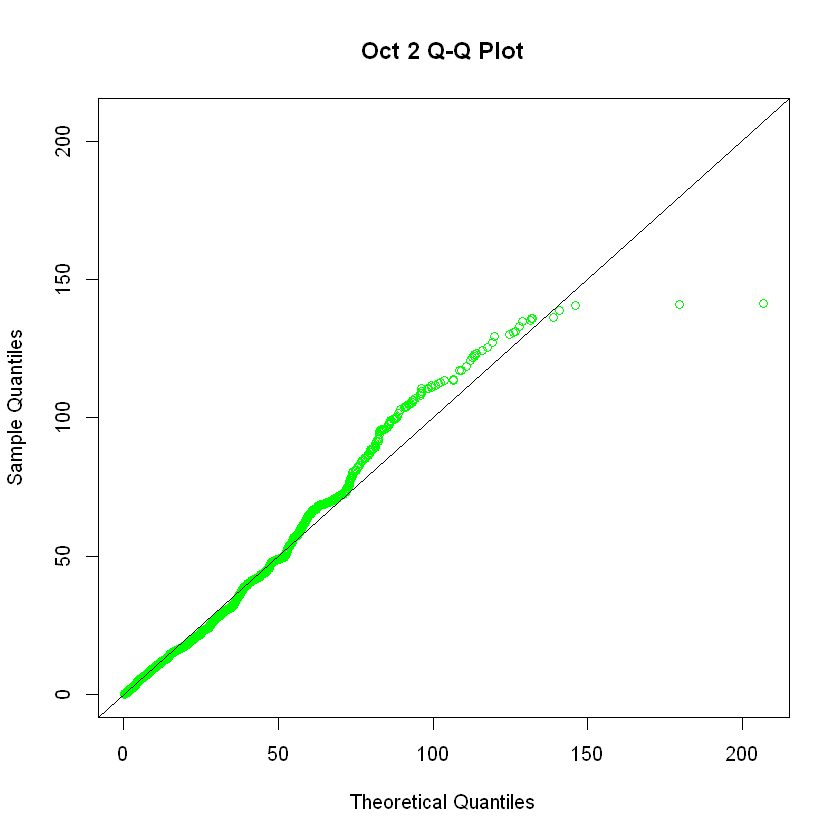

In [1113]:
wOct2Max <- max( max( dfOct2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfOct2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Oct 2 Q-Q Plot",
        xlim=c(0,wOct2Max), ylim=c(0,wOct2Max) )
abline( 0, 1)

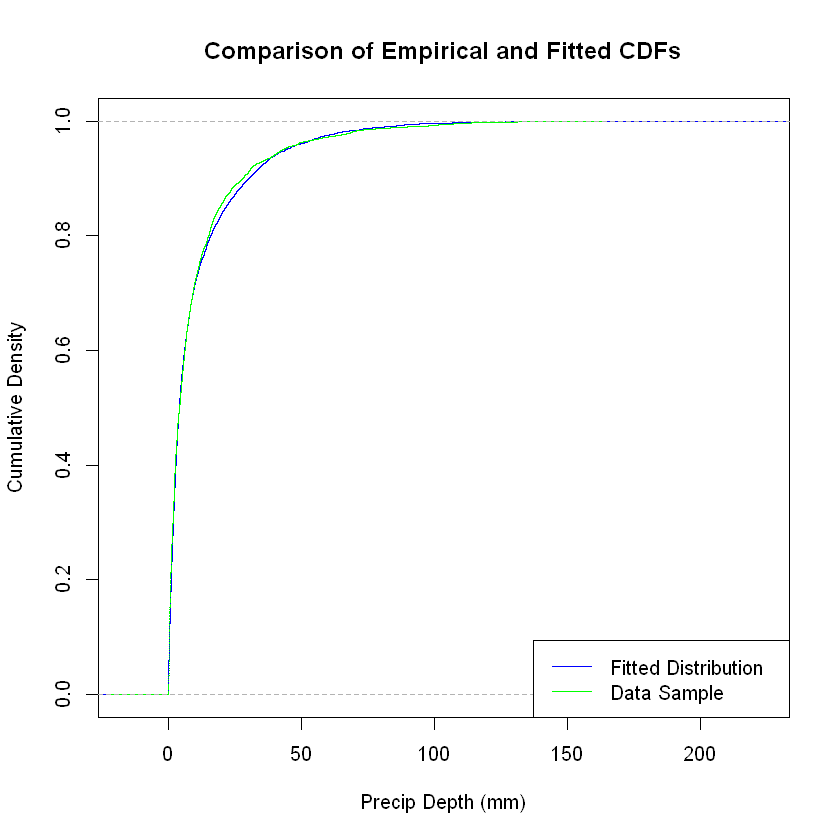

In [1114]:
x <- seq(0,wOct2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfOct2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1115]:
MonDistDF[48, ] <- list( 10, 2, fdGM_Oct2_shape, fdGM_Oct2_rate, fdGM_Oct2_llike, fdGM_Oct2_mean,
                        fdGM_Oct2_var, fdGM_Oct2_KSStat, fdGM_Oct2_KSp, fdME_Oct2_rate1,
                        fdME_Oct2_rate2, fdME_Oct2_lambda, fdME_Oct2_mean1, fdME_Oct2_mean2,
                        fdME_Oct2_mean, fdME_Oct2_var1, fdME_Oct2_var2, fdME_Oct2_var,
                        fdME_Oct2_llike, fdME_Oct2_KSStat, fdME_Oct2_KSp )

#### Region 3

**Gamma**

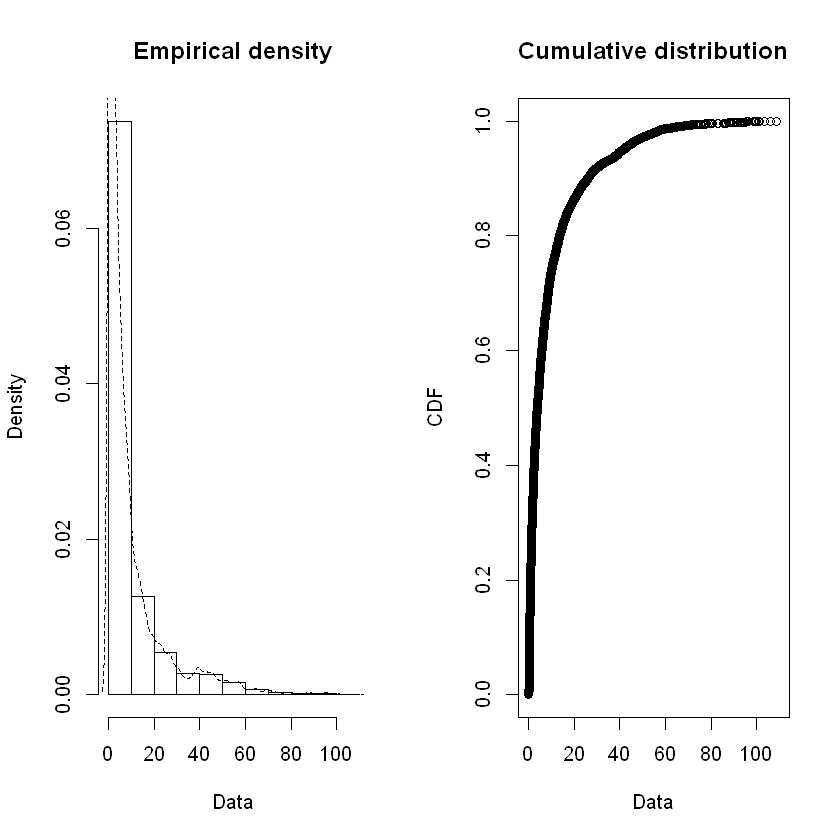

In [1116]:
plotdist( dfOct3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  108.78 
median:  3.89 
mean:  9.366504 
estimated sd:  13.85192 
estimated skewness:  2.720615 
estimated kurtosis:  11.78799 

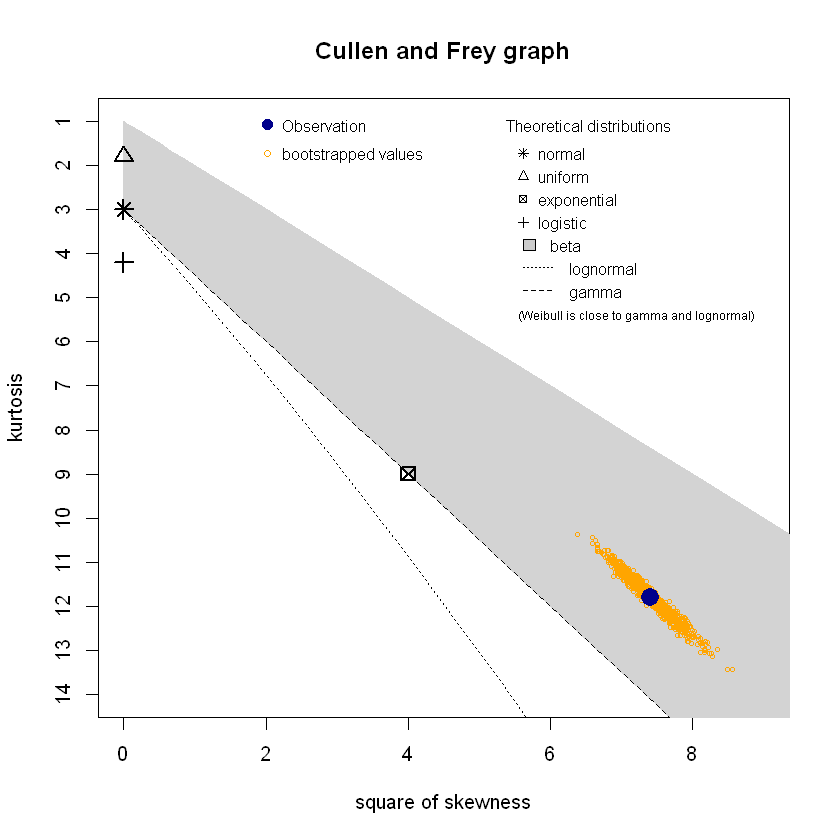

In [1117]:
descdist( dfOct3$Precip_mm, boot=1000 )

In [1118]:
fd_GM_Oct3 <- fitdist( dfOct3$Precip_mm, "gamma" )

In [1119]:
summary( fd_GM_Oct3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.67094068 0.007588731
rate  0.07164828 0.001155730
Loglikelihood:  -35743.64   AIC:  71491.29   BIC:  71505.94 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7009604
rate  0.7009604 1.0000000


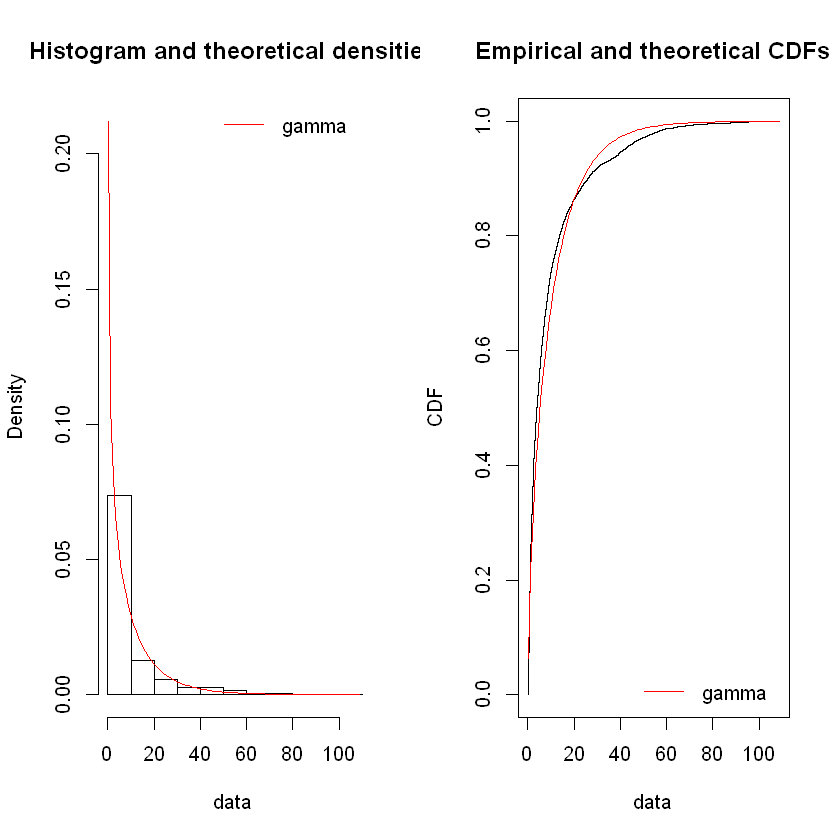

In [1120]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Oct3)
#qqcomp(fd_GM_Oct3)
cdfcomp(fd_GM_Oct3)
#ppcomp(fd_GM_Oct3)

In [1121]:
fdGM_Oct3_shape <- fd_GM_Oct3$estimate[["shape"]]
fdGM_Oct3_rate <- fd_GM_Oct3$estimate[["rate"]]
fdGM_Oct3_llike <- fd_GM_Oct3$loglik
fdGM_Oct3_mean <- fdGM_Oct3_shape / fdGM_Oct3_rate
fdGM_Oct3_var <- fdGM_Oct3_shape / ( fdGM_Oct3_rate ^ 2 )
cat(" Oct 3 shape: ", fdGM_Oct3_shape, "\n", "Oct 3 rate: ", fdGM_Oct3_rate, 
    "\n", "Oct 3 loglikelihood: ", fdGM_Oct3_llike, "\n", 
    "Oct 3 mean: ", fdGM_Oct3_mean, "\n",
    "Oct 3 variance: ", fdGM_Oct3_var, "\n" )

 Oct 3 shape:  0.6709407 
 Oct 3 rate:  0.07164828 
 Oct 3 loglikelihood:  -35743.64 
 Oct 3 mean:  9.364365 
 Oct 3 variance:  130.6991 


In [1122]:
statRes <- gofstat( fd_GM_Oct3, fitnames=c("Gamma") )

In [1123]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.08123551
Cramer-von Mises statistic    31.28425501
Anderson-Darling statistic   185.44760104

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 71491.29
Bayesian Information Criterion 71505.94


In [1124]:
ksRes <- ks.test( dfOct3$Precip_mm, "pgamma", shape=fdGM_Oct3_shape, rate=fdGM_Oct3_rate )

Warning message in ks.test(dfOct3$Precip_mm, "pgamma", shape = fdGM_Oct3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1125]:
fdGM_Oct3_KSStat <- ksRes$statistic
fdGM_Oct3_KSp <- ksRes$p.value
cat(" Oct 3 K-S stat: ", fdGM_Oct3_KSStat, "\n",
    "Oct 3 K-S p-value: ", fdGM_Oct3_KSp )

 Oct 3 K-S stat:  0.08123551 
 Oct 3 K-S p-value:  0

**Mixed exponential**

In [1126]:
fd_ME_Oct3 <- expRMM_EM( dfOct3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfOct3$Precip_mm), 1.0/mean(dfOct3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 147 


In [1127]:
summary( fd_ME_Oct3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.565685 0.4343152
rate   0.341947 0.0563154
loglik at estimate:  -35012.78 
0 % of the data right censored


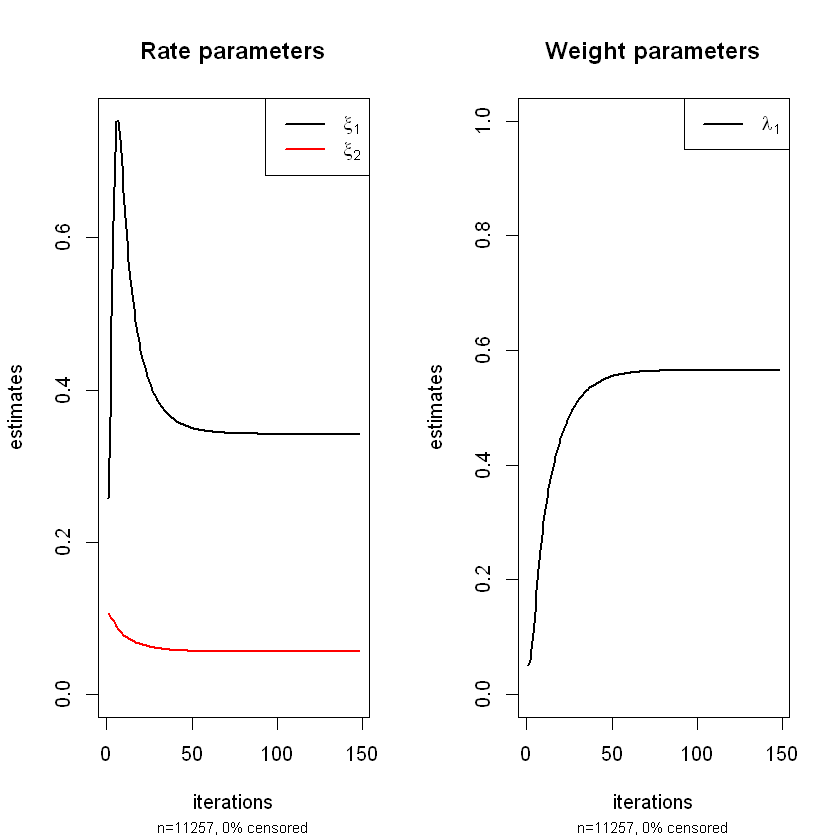

In [1128]:
plotexpRMM( fd_ME_Oct3, lwd=2 )

In [1129]:
fdME_Oct3_rate1 <- fd_ME_Oct3$rate[[1]]
fdME_Oct3_rate2 <- fd_ME_Oct3$rate[[2]]
fdME_Oct3_lambda <- fd_ME_Oct3$lambda[[1]]
fdME_Oct3_mean1 <- 1.0 / fdME_Oct3_rate1
fdME_Oct3_mean2 <- 1.0 / fdME_Oct3_rate2
fdME_Oct3_mean <- ( (fdME_Oct3_lambda * fdME_Oct3_mean1) + 
                    ( ( 1.0 - fdME_Oct3_lambda) * fdME_Oct3_mean2 ) )
fdME_Oct3_var1 <- 1.0 / (fdME_Oct3_rate1 ^ 2)
fdME_Oct3_var2 <- 1.0 / (fdME_Oct3_rate2 ^ 2)
fdME_Oct3_var <- ( (fdME_Oct3_lambda * ( fdME_Oct3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Oct3_lambda) * (fdME_Oct3_mean2 ^ 2) ) + 
                   ( fdME_Oct3_lambda * ( 1.0 - fdME_Oct3_lambda) * 
                       ( fdME_Oct3_mean1 - fdME_Oct3_mean2 )^2 ) )
fdME_Oct3_llike <- fd_ME_Oct3$loglik
cat(" Oct 3 rate1: ", fdME_Oct3_rate1, "\n", 
    "Oct 3 rate2: ", fdME_Oct3_rate2, "\n",
    "Oct 3 lambda: ", fdME_Oct3_lambda, "\n",
    "Oct 3 mean1: ", fdME_Oct3_mean1, "\n",
    "Oct 3 mean2: ", fdME_Oct3_mean2, "\n",
    "Oct 3 mean: ", fdME_Oct3_mean, "\n",
    "Oct 3 var1: ", fdME_Oct3_var1, "\n",
    "Oct 3 var2: ", fdME_Oct3_var2, "\n",
    "Oct 3 var: ", fdME_Oct3_var, "\n",
    "Oct 3 loglikelihood: ", fdME_Oct3_llike, "\n" )

 Oct 3 rate1:  0.3419469 
 Oct 3 rate2:  0.05631536 
 Oct 3 lambda:  0.5656848 
 Oct 3 mean1:  2.924431 
 Oct 3 mean2:  17.75714 
 Oct 3 mean:  9.366504 
 Oct 3 var1:  8.552295 
 Oct 3 var2:  315.3162 
 Oct 3 var:  195.8376 
 Oct 3 loglikelihood:  -35012.78 


In [1130]:
tvals <- rexpmix(length(dfOct3$Precip_mm), fd_ME_Oct3$lambda, fd_ME_Oct3$rate )

In [1131]:
ksRes <- ks.test( dfOct3$Precip_mm, tvals )

Warning message in ks.test(dfOct3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1132]:
fdME_Oct3_KSStat <- ksRes$statistic
fdME_Oct3_KSp <- ksRes$p.value
cat(" Oct 3 K-S stat: ", fdME_Oct3_KSStat, "\n",
    "Oct 3 K-S p-value: ", fdME_Oct3_KSp )

 Oct 3 K-S stat:  0.04521631 
 Oct 3 K-S p-value:  2.021614e-10

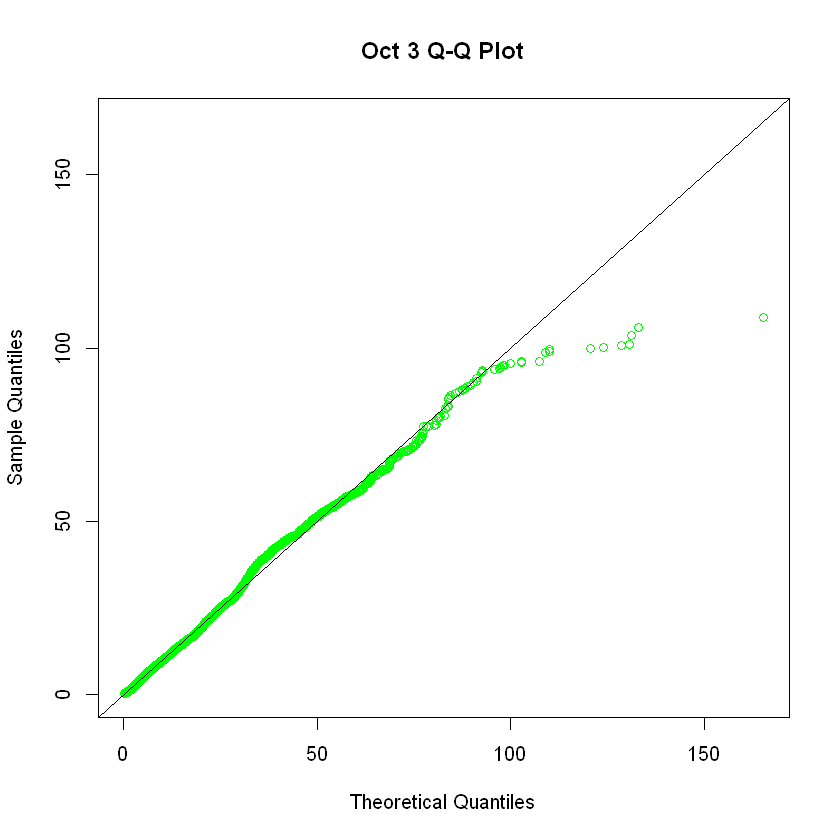

In [1133]:
wOct3Max <- max( max( dfOct3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfOct3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Oct 3 Q-Q Plot",
        xlim=c(0,wOct3Max), ylim=c(0,wOct3Max) )
abline( 0, 1)

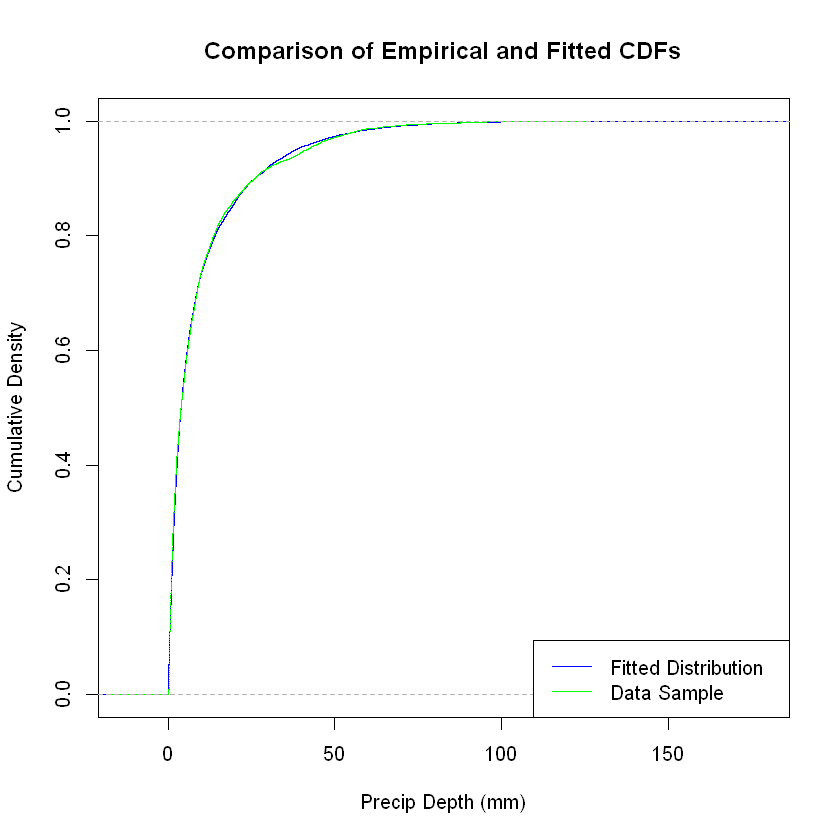

In [1134]:
x <- seq(0,wOct3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfOct3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1135]:
MonDistDF[49, ] <- list( 10, 3, fdGM_Oct3_shape, fdGM_Oct3_rate, fdGM_Oct3_llike, fdGM_Oct3_mean,
                        fdGM_Oct3_var, fdGM_Oct3_KSStat, fdGM_Oct3_KSp, fdME_Oct3_rate1,
                        fdME_Oct3_rate2, fdME_Oct3_lambda, fdME_Oct3_mean1, fdME_Oct3_mean2,
                        fdME_Oct3_mean, fdME_Oct3_var1, fdME_Oct3_var2, fdME_Oct3_var,
                        fdME_Oct3_llike, fdME_Oct3_KSStat, fdME_Oct3_KSp )

#### Region 4

**Gamma**

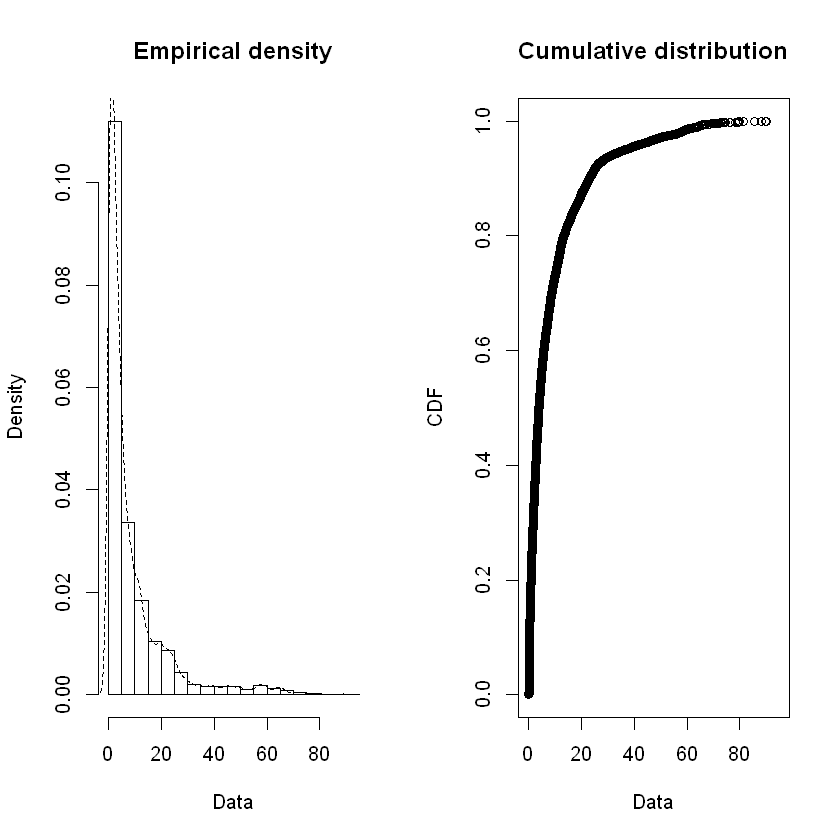

In [1136]:
plotdist( dfOct4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  90.25 
median:  3.98 
mean:  8.986408 
estimated sd:  12.80122 
estimated skewness:  2.679691 
estimated kurtosis:  11.0839 

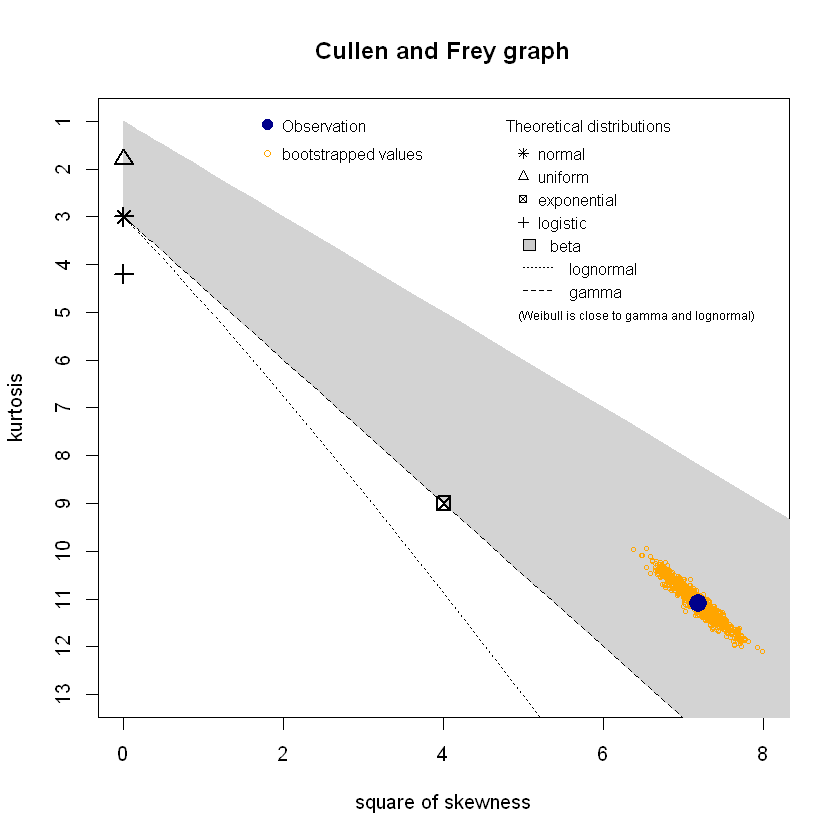

In [1137]:
descdist( dfOct4$Precip_mm, boot=1000 )

In [1138]:
fd_GM_Oct4 <- fitdist( dfOct4$Precip_mm, "gamma" )

In [1139]:
summary( fd_GM_Oct4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.70328621 0.009193981
rate  0.07826836 0.001438936
Loglikelihood:  -26769.6   AIC:  53543.21   BIC:  53557.3 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7108827
rate  0.7108827 1.0000000


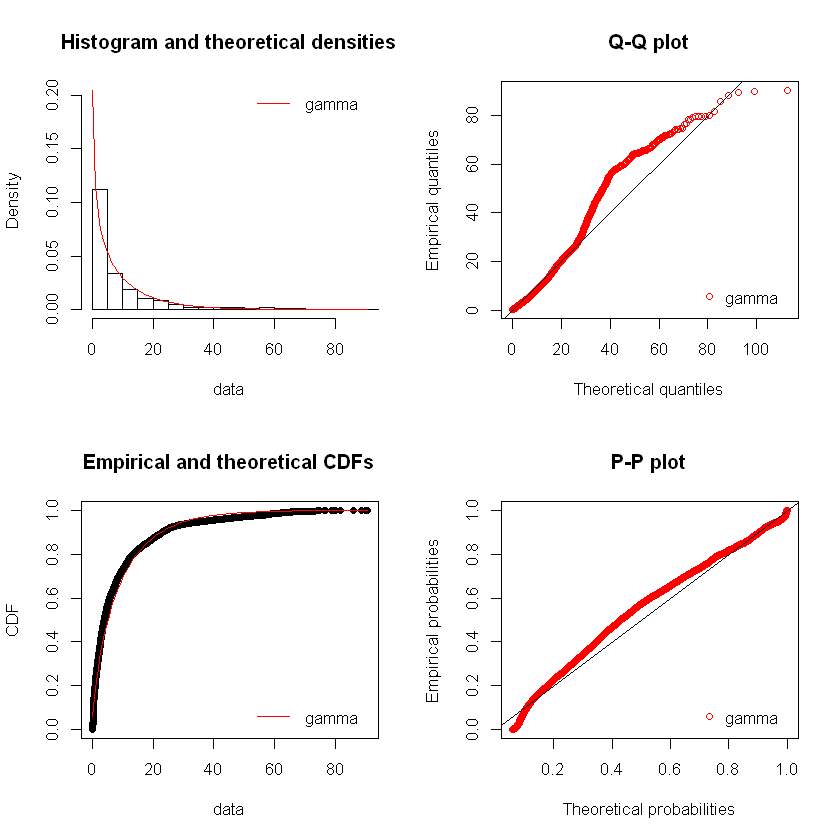

In [1140]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Oct4)
qqcomp(fd_GM_Oct4)
cdfcomp(fd_GM_Oct4)
ppcomp(fd_GM_Oct4)

In [1141]:
fdGM_Oct4_shape <- fd_GM_Oct4$estimate[["shape"]]
fdGM_Oct4_rate <- fd_GM_Oct4$estimate[["rate"]]
fdGM_Oct4_llike <- fd_GM_Oct4$loglik
fdGM_Oct4_mean <- fdGM_Oct4_shape / fdGM_Oct4_rate
fdGM_Oct4_var <- fdGM_Oct4_shape / ( fdGM_Oct4_rate ^ 2 )
cat(" Oct 4 shape: ", fdGM_Oct4_shape, "\n", "Oct 4 rate: ", fdGM_Oct4_rate, 
    "\n", "Oct 4 loglikelihood: ", fdGM_Oct4_llike, "\n", 
    "Oct 4 mean: ", fdGM_Oct4_mean, "\n",
    "Oct 4 variance: ", fdGM_Oct4_var, "\n" )

 Oct 4 shape:  0.7032862 
 Oct 4 rate:  0.07826836 
 Oct 4 loglikelihood:  -26769.6 
 Oct 4 mean:  8.985575 
 Oct 4 variance:  114.8047 


In [1142]:
statRes <- gofstat( fd_GM_Oct4, fitnames=c("Gamma") )

In [1143]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic  0.0742776
Cramer-von Mises statistic   16.2817796
Anderson-Darling statistic   99.8421211

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 53543.21
Bayesian Information Criterion 53557.30


In [1144]:
ksRes <- ks.test( dfOct4$Precip_mm, "pgamma", shape=fdGM_Oct4_shape, rate=fdGM_Oct4_rate )

Warning message in ks.test(dfOct4$Precip_mm, "pgamma", shape = fdGM_Oct4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1145]:
fdGM_Oct4_KSStat <- ksRes$statistic
fdGM_Oct4_KSp <- ksRes$p.value
cat(" Oct 4 K-S stat: ", fdGM_Oct4_KSStat, "\n",
    "Oct 4 K-S p-value: ", fdGM_Oct4_KSp )

 Oct 4 K-S stat:  0.0742776 
 Oct 4 K-S p-value:  0

**Mixed exponential**

In [1146]:
fd_ME_Oct4 <- expRMM_EM( dfOct4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfOct4$Precip_mm), 1.0/mean(dfOct4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 182 


In [1147]:
summary( fd_ME_Oct4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.528458 0.4715422
rate   0.338665 0.0634989
loglik at estimate:  -26367.46 
0 % of the data right censored


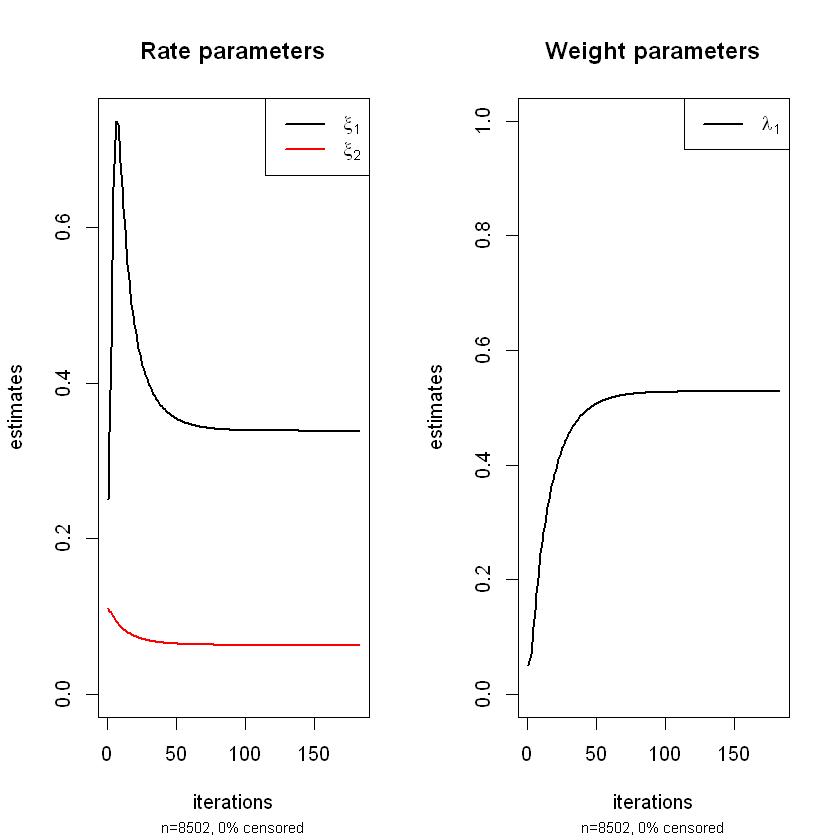

In [1148]:
plotexpRMM( fd_ME_Oct4, lwd=2 )

In [1149]:
fdME_Oct4_rate1 <- fd_ME_Oct4$rate[[1]]
fdME_Oct4_rate2 <- fd_ME_Oct4$rate[[2]]
fdME_Oct4_lambda <- fd_ME_Oct4$lambda[[1]]
fdME_Oct4_mean1 <- 1.0 / fdME_Oct4_rate1
fdME_Oct4_mean2 <- 1.0 / fdME_Oct4_rate2
fdME_Oct4_mean <- ( (fdME_Oct4_lambda * fdME_Oct4_mean1) + 
                    ( ( 1.0 - fdME_Oct4_lambda) * fdME_Oct4_mean2 ) )
fdME_Oct4_var1 <- 1.0 / (fdME_Oct4_rate1 ^ 2)
fdME_Oct4_var2 <- 1.0 / (fdME_Oct4_rate2 ^ 2)
fdME_Oct4_var <- ( (fdME_Oct4_lambda * ( fdME_Oct4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Oct4_lambda) * (fdME_Oct4_mean2 ^ 2) ) + 
                   ( fdME_Oct4_lambda * ( 1.0 - fdME_Oct4_lambda) * 
                       ( fdME_Oct4_mean1 - fdME_Oct4_mean2 )^2 ) )
fdME_Oct4_llike <- fd_ME_Oct4$loglik
cat(" Oct 4 rate1: ", fdME_Oct4_rate1, "\n", 
    "Oct 4 rate2: ", fdME_Oct4_rate2, "\n",
    "Oct 4 lambda: ", fdME_Oct4_lambda, "\n",
    "Oct 4 mean1: ", fdME_Oct4_mean1, "\n",
    "Oct 4 mean2: ", fdME_Oct4_mean2, "\n",
    "Oct 4 mean: ", fdME_Oct4_mean, "\n",
    "Oct 4 var1: ", fdME_Oct4_var1, "\n",
    "Oct 4 var2: ", fdME_Oct4_var2, "\n",
    "Oct 4 var: ", fdME_Oct4_var, "\n",
    "Oct 4 loglikelihood: ", fdME_Oct4_llike, "\n" )

 Oct 4 rate1:  0.3386647 
 Oct 4 rate2:  0.06349888 
 Oct 4 lambda:  0.5284578 
 Oct 4 mean1:  2.952773 
 Oct 4 mean2:  15.74831 
 Oct 4 mean:  8.986408 
 Oct 4 var1:  8.71887 
 Oct 4 var2:  248.0092 
 Oct 4 var:  162.3532 
 Oct 4 loglikelihood:  -26367.46 


In [1150]:
tvals <- rexpmix(length(dfOct4$Precip_mm), fd_ME_Oct4$lambda, fd_ME_Oct4$rate )

In [1151]:
ksRes <- ks.test( dfOct4$Precip_mm, tvals )

Warning message in ks.test(dfOct4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1152]:
fdME_Oct4_KSStat <- ksRes$statistic
fdME_Oct4_KSp <- ksRes$p.value
cat(" Oct 4 K-S stat: ", fdME_Oct4_KSStat, "\n",
    "Oct 4 K-S p-value: ", fdME_Oct4_KSp )

 Oct 4 K-S stat:  0.04069631 
 Oct 4 K-S p-value:  1.53378e-06

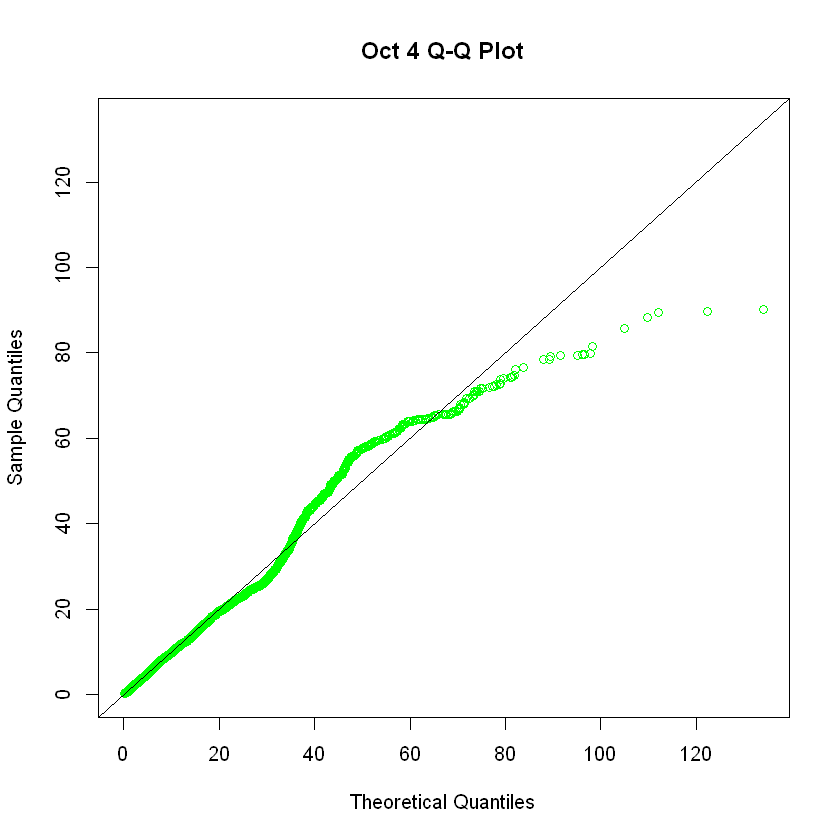

In [1153]:
wOct4Max <- max( max( dfOct4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfOct4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Oct 4 Q-Q Plot",
        xlim=c(0,wOct4Max), ylim=c(0,wOct4Max) )
abline( 0, 1)

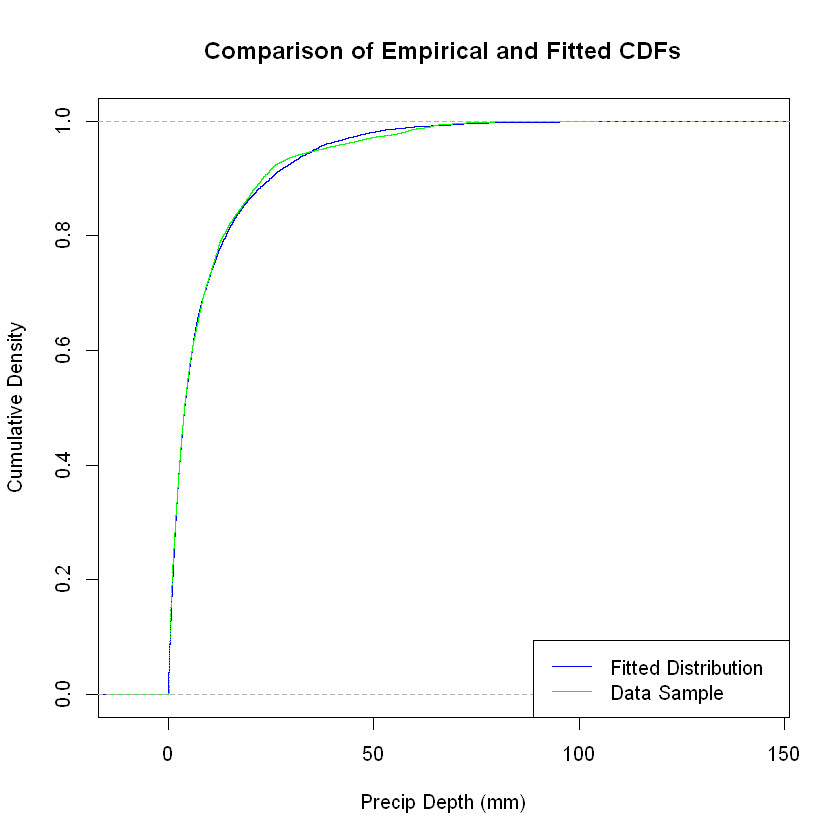

In [1154]:
x <- seq(0,wOct4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfOct4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1155]:
MonDistDF[50, ] <- list( 10, 4, fdGM_Oct4_shape, fdGM_Oct4_rate, fdGM_Oct4_llike, fdGM_Oct4_mean,
                        fdGM_Oct4_var, fdGM_Oct4_KSStat, fdGM_Oct4_KSp, fdME_Oct4_rate1,
                        fdME_Oct4_rate2, fdME_Oct4_lambda, fdME_Oct4_mean1, fdME_Oct4_mean2,
                        fdME_Oct4_mean, fdME_Oct4_var1, fdME_Oct4_var2, fdME_Oct4_var,
                        fdME_Oct4_llike, fdME_Oct4_KSStat, fdME_Oct4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

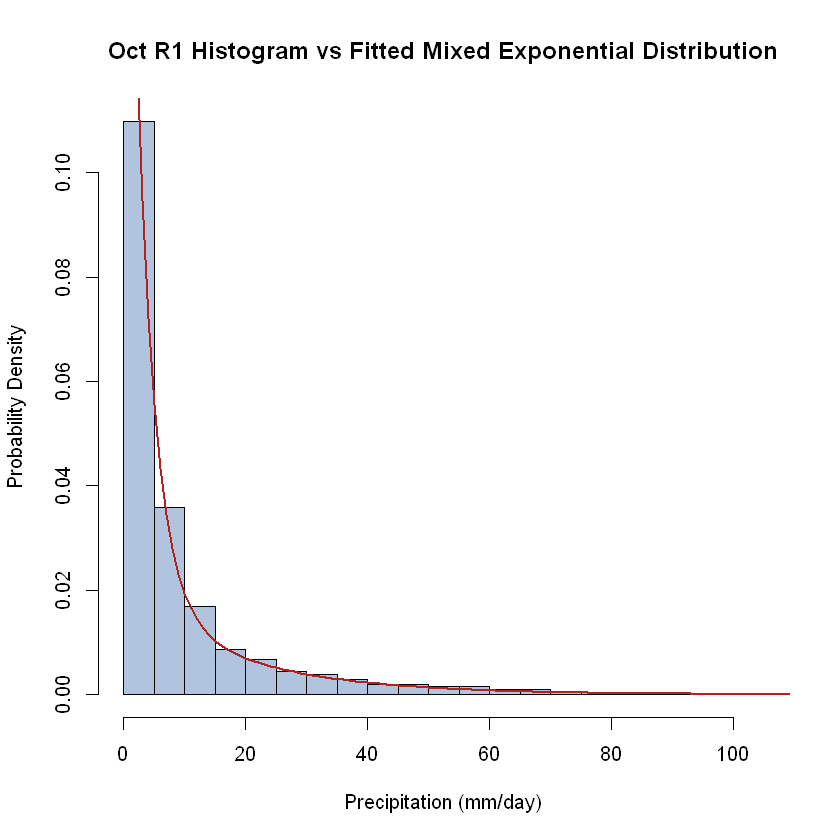

In [1156]:
xVals <- seq(1, wOct1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Oct1_lambda, spec1="exp", arg1=list(rate=fdME_Oct1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Oct1_rate2) )
hist( dfOct1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Oct R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

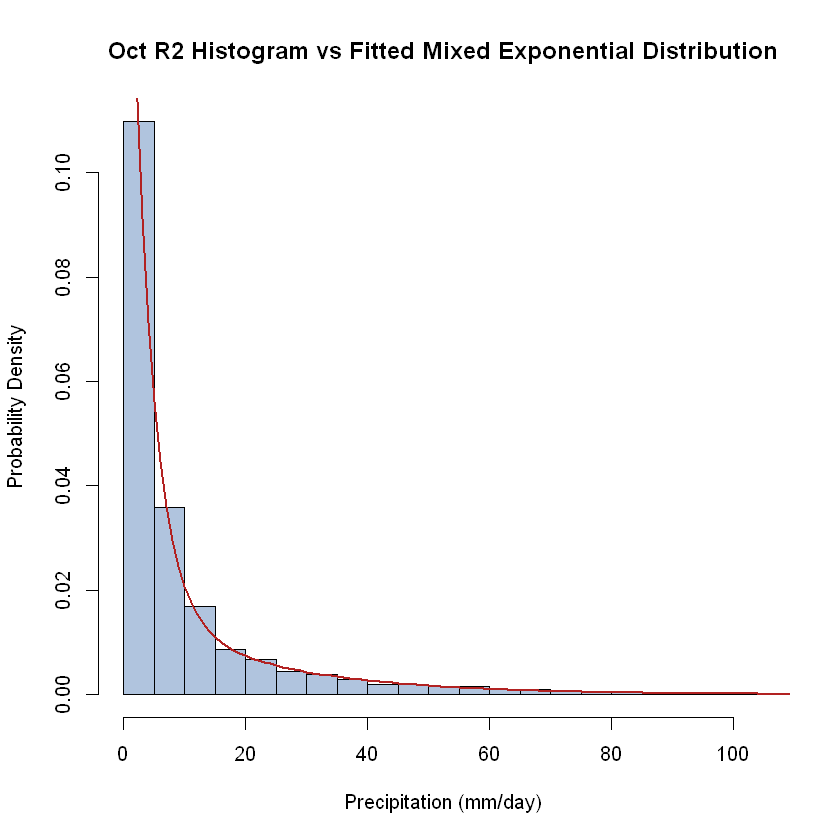

In [1157]:
xVals <- seq(1, wOct2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Oct2_lambda, spec1="exp", arg1=list(rate=fdME_Oct2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Oct2_rate2) )
hist( dfOct1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Oct R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

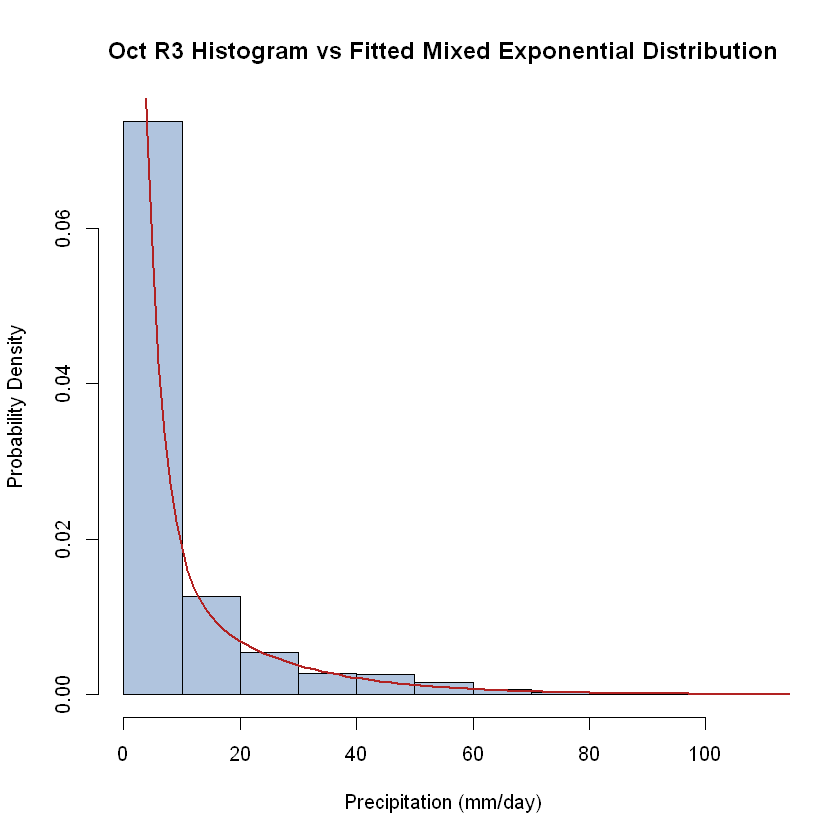

In [1158]:
xVals <- seq(1, wOct3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Oct3_lambda, spec1="exp", arg1=list(rate=fdME_Oct3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Oct3_rate2) )
hist( dfOct3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Oct R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

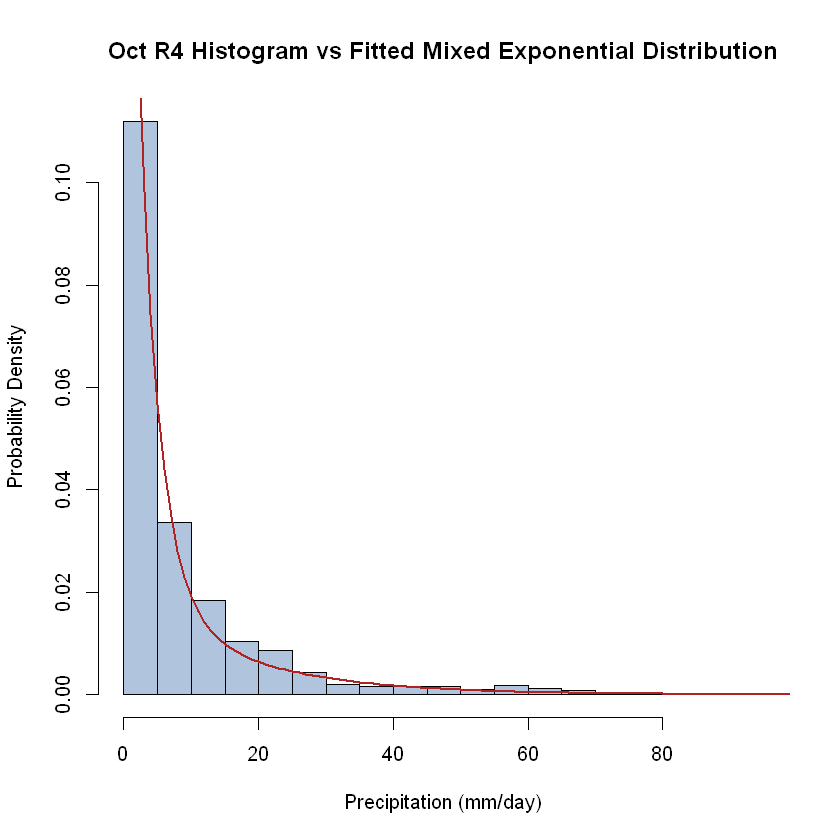

In [1159]:
xVals <- seq(1, wOct4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Oct4_lambda, spec1="exp", arg1=list(rate=fdME_Oct4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Oct4_rate2) )
hist( dfOct4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Oct R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Nov

#### All

**Gamma**

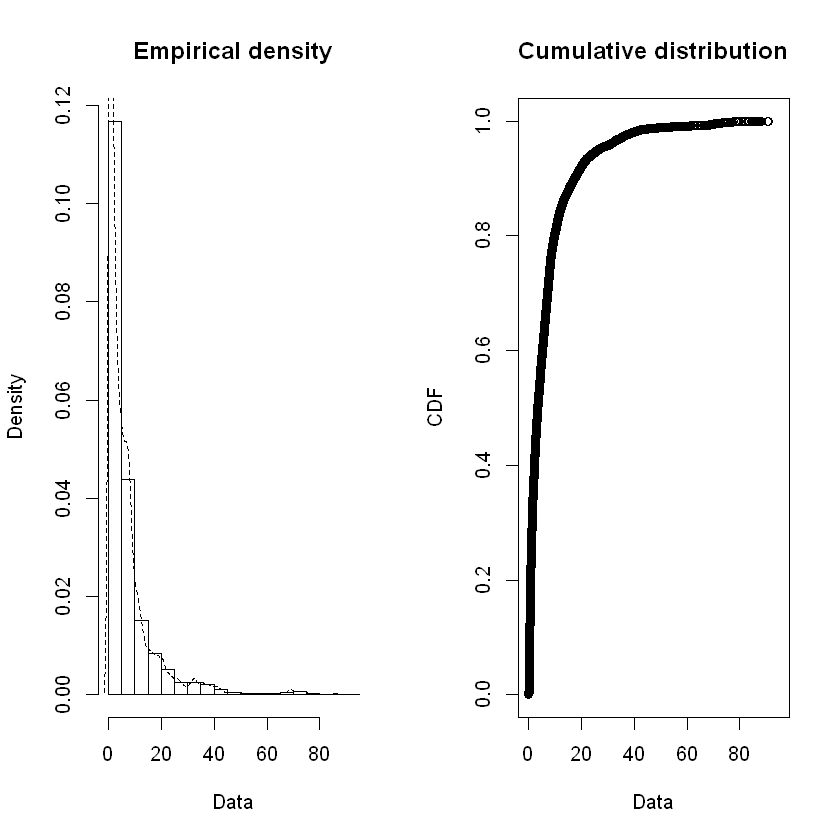

In [1160]:
plotdist( dfNov$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  90.72 
median:  3.56 
mean:  7.052691 
estimated sd:  10.2612 
estimated skewness:  3.434496 
estimated kurtosis:  18.6199 

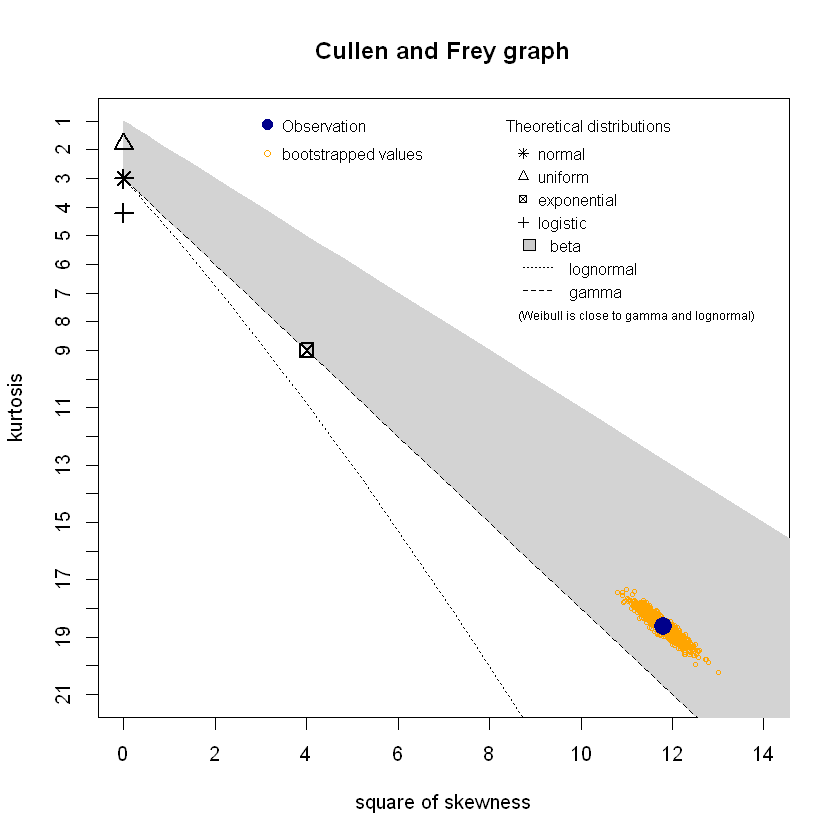

In [1161]:
descdist( dfNov$Precip_mm, boot=1000 )

In [1162]:
fd_GM_NovA <- fitdist( dfNov$Precip_mm, "gamma" )

In [1163]:
summary( fd_GM_NovA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7579357 0.005621289
rate  0.1074728 0.001097204
Loglikelihood:  -78372.42   AIC:  156748.8   BIC:  156765.2 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7263606
rate  0.7263606 1.0000000


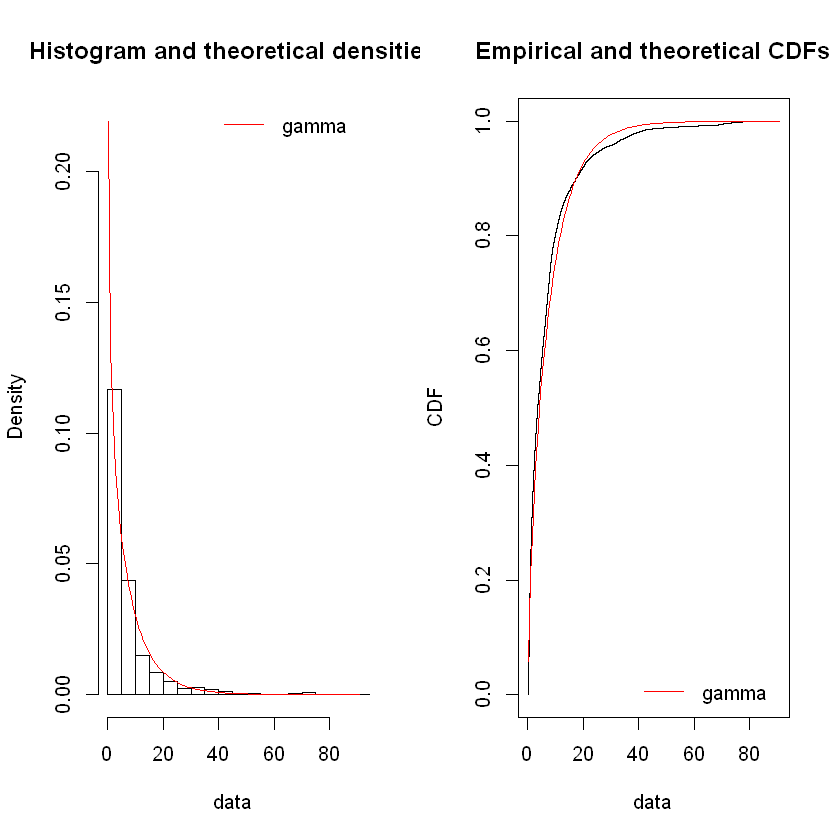

In [1164]:
par(mfrow = c(1, 2))
denscomp(fd_GM_NovA)
#qqcomp(fd_GM_NovA)
cdfcomp(fd_GM_NovA)
#ppcomp(fd_GM_NovA)

In [1165]:
fdGM_NovA_shape <- fd_GM_NovA$estimate[["shape"]]
fdGM_NovA_rate <- fd_GM_NovA$estimate[["rate"]]
fdGM_NovA_llike <- fd_GM_NovA$loglik
fdGM_NovA_mean <- fdGM_NovA_shape / fdGM_NovA_rate
fdGM_NovA_var <- fdGM_NovA_shape / ( fdGM_NovA_rate ^ 2 )
cat(" Nov A shape: ", fdGM_NovA_shape, "\n", "Nov A rate: ", fdGM_NovA_rate, 
    "\n", "Nov A loglikelihood: ", fdGM_NovA_llike, "\n", 
    "Nov A mean: ", fdGM_NovA_mean, "\n",
    "Nov A variance: ", fdGM_NovA_var, "\n" )

 Nov A shape:  0.7579357 
 Nov A rate:  0.1074728 
 Nov A loglikelihood:  -78372.42 
 Nov A mean:  7.052346 
 Nov A variance:  65.6198 


In [1166]:
statRes <- gofstat( fd_GM_NovA, fitnames=c("Gamma") )

In [1167]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06250115
Cramer-von Mises statistic    46.48962395
Anderson-Darling statistic   308.96310454

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 156748.8
Bayesian Information Criterion 156765.2


In [1168]:
ksRes <- ks.test( dfNov$Precip_mm, "pgamma", shape=fdGM_NovA_shape, rate=fdGM_NovA_rate )

Warning message in ks.test(dfNov$Precip_mm, "pgamma", shape = fdGM_NovA_shape, rate = fdGM_NovA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [1169]:
fdGM_NovA_KSStat <- ksRes$statistic
fdGM_NovA_KSp <- ksRes$p.value
cat(" Nov A K-S stat: ", fdGM_NovA_KSStat, "\n",
    "Nov A K-S p-value: ", fdGM_NovA_KSp )

 Nov A K-S stat:  0.06250115 
 Nov A K-S p-value:  0

**Mixed Exponential**

In [1170]:
fd_ME_NovA <- expRMM_EM( dfNov$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfNov$Precip_mm), 1.0/mean(dfNov$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 347 


In [1171]:
summary( fd_ME_NovA )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.680331 0.3196694
rate   0.282141 0.0688738
loglik at estimate:  -77243.3 
0 % of the data right censored


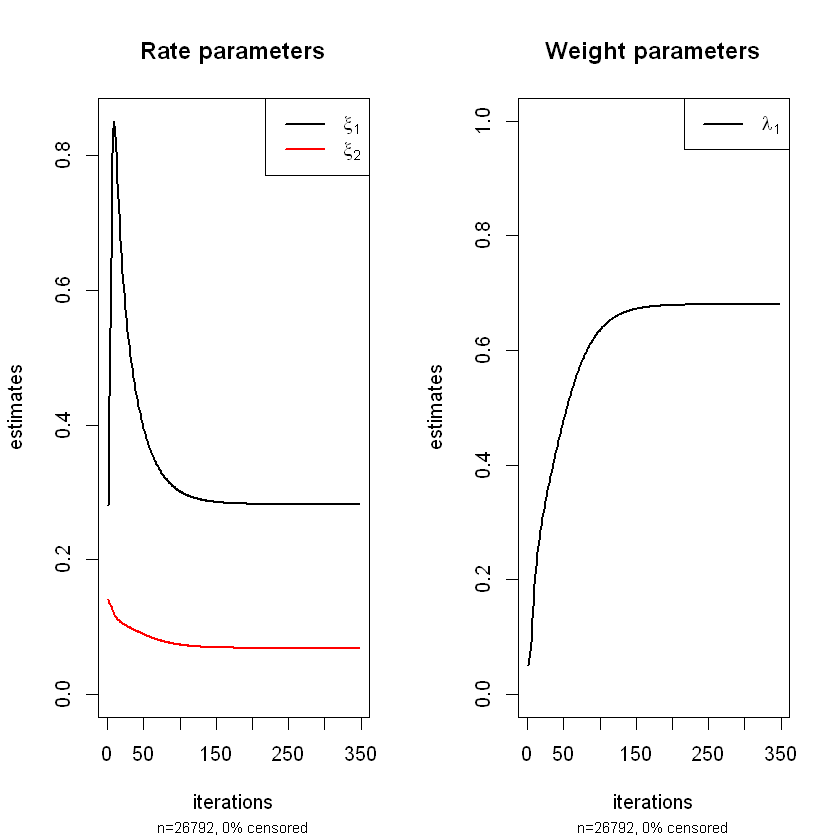

In [1172]:
plotexpRMM( fd_ME_NovA, lwd=2 )

In [1173]:
fdME_NovA_rate1 <- fd_ME_NovA$rate[[1]]
fdME_NovA_rate2 <- fd_ME_NovA$rate[[2]]
fdME_NovA_lambda <- fd_ME_NovA$lambda[[1]]
fdME_NovA_mean1 <- 1.0 / fdME_NovA_rate1
fdME_NovA_mean2 <- 1.0 / fdME_NovA_rate2
fdME_NovA_mean <- ( (fdME_NovA_lambda * fdME_NovA_mean1) + 
                    ( ( 1.0 - fdME_NovA_lambda) * fdME_NovA_mean2 ) )
fdME_NovA_var1 <- 1.0 / (fdME_NovA_rate1 ^ 2)
fdME_NovA_var2 <- 1.0 / (fdME_NovA_rate2 ^ 2)
fdME_NovA_var <- ( (fdME_NovA_lambda * ( fdME_NovA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_NovA_lambda) * (fdME_NovA_mean2 ^ 2) ) + 
                   ( fdME_NovA_lambda * ( 1.0 - fdME_NovA_lambda) * 
                       ( fdME_NovA_mean1 - fdME_NovA_mean2 )^2 ) )
fdME_NovA_llike <- fd_ME_NovA$loglik
cat(" Nov A rate1: ", fdME_NovA_rate1, "\n", 
    "Nov A rate2: ", fdME_NovA_rate2, "\n",
    "Nov A lambda: ", fdME_NovA_lambda, "\n",
    "Nov A mean1: ", fdME_NovA_mean1, "\n",
    "Nov A mean2: ", fdME_NovA_mean2, "\n",
    "Nov A mean: ", fdME_NovA_mean, "\n",
    "Nov A var1: ", fdME_NovA_var1, "\n",
    "Nov A var2: ", fdME_NovA_var2, "\n",
    "Nov A var: ", fdME_NovA_var, "\n",
    "Nov A loglikelihood: ", fdME_NovA_llike, "\n" )

 Nov A rate1:  0.2821415 
 Nov A rate2:  0.06887377 
 Nov A lambda:  0.6803306 
 Nov A mean1:  3.544321 
 Nov A mean2:  14.51932 
 Nov A mean:  7.052691 
 Nov A var1:  12.56221 
 Nov A var2:  210.8105 
 Nov A var:  102.1318 
 Nov A loglikelihood:  -77243.3 


In [1174]:
tvals <- rexpmix(length(dfNov$Precip_mm), fd_ME_NovA$lambda, fd_ME_NovA$rate )

In [1175]:
ksRes <- ks.test( dfNov$Precip_mm, tvals )

Warning message in ks.test(dfNov$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1176]:
fdME_NovA_KSStat <- ksRes$statistic
fdME_NovA_KSp <- ksRes$p.value
cat(" Nov A K-S stat: ", fdME_NovA_KSStat, "\n",
    "Nov A K-S p-value: ", fdME_NovA_KSp )

 Nov A K-S stat:  0.05281427 
 Nov A K-S p-value:  0

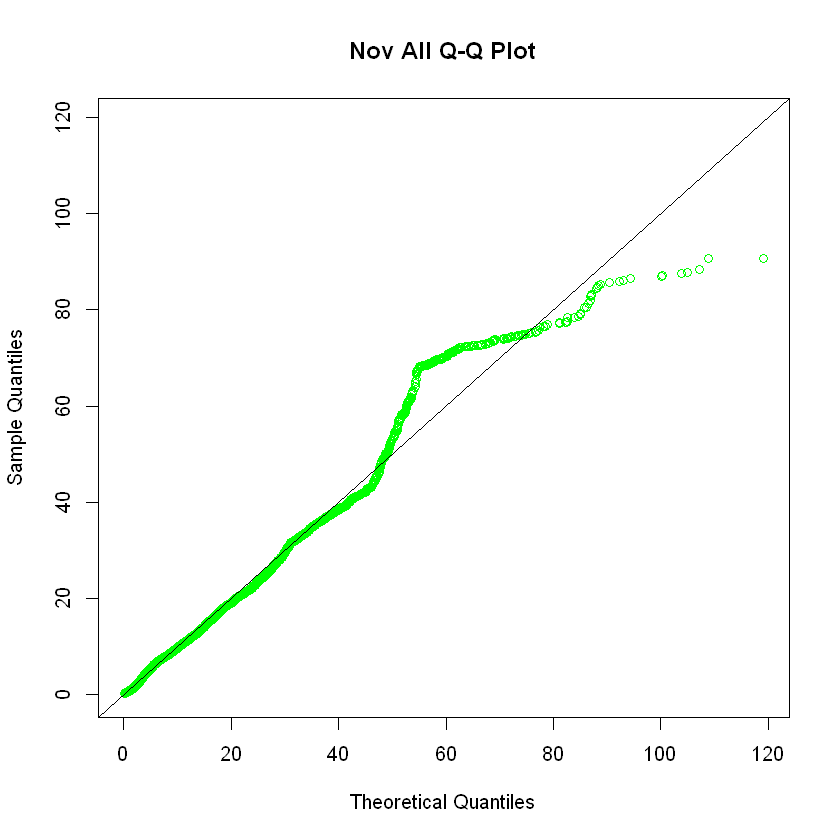

In [1177]:
wNovAMax <- max( max( dfNov$Precip_mm ), max( tvals ) )
qqplot( tvals, dfNov$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Nov All Q-Q Plot",
        xlim=c(0,wNovAMax), ylim=c(0,wNovAMax) )
abline( 0, 1)

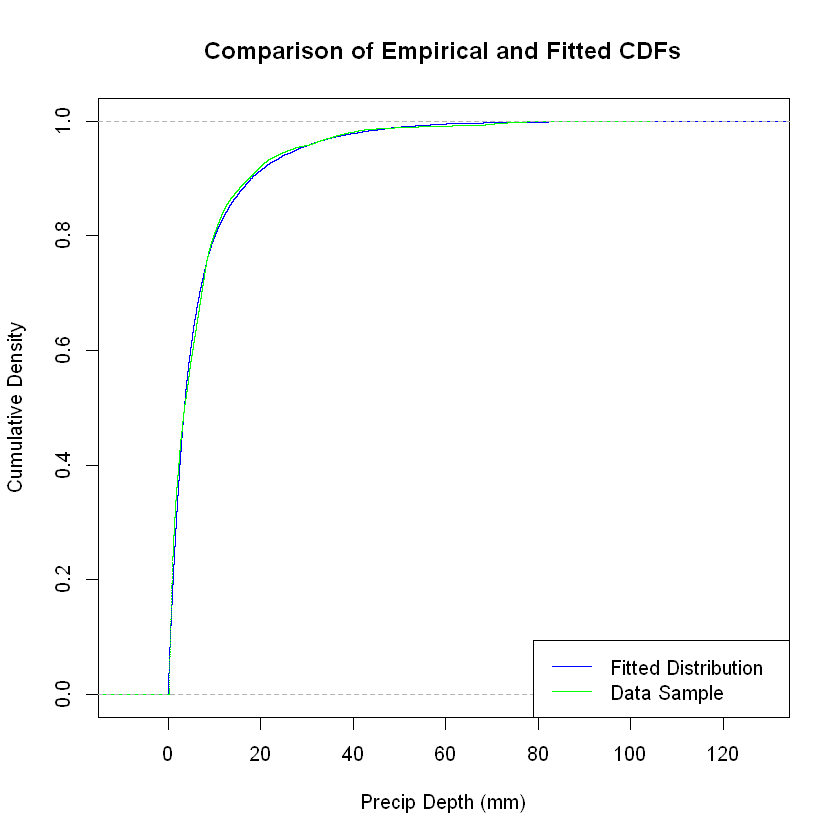

In [1178]:
x <- seq(0,wNovAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfNov$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [1179]:
MonDistDF[51, ] <- list( 11, 0, fdGM_NovA_shape, fdGM_NovA_rate, fdGM_NovA_llike, fdGM_NovA_mean,
                        fdGM_NovA_var, fdGM_NovA_KSStat, fdGM_NovA_KSp, fdME_NovA_rate1,
                        fdME_NovA_rate2, fdME_NovA_lambda, fdME_NovA_mean1, fdME_NovA_mean2,
                        fdME_NovA_mean, fdME_NovA_var1, fdME_NovA_var2, fdME_NovA_var,
                        fdME_NovA_llike, fdME_NovA_KSStat, fdME_NovA_KSp )

#### Region 1

**Gamma**

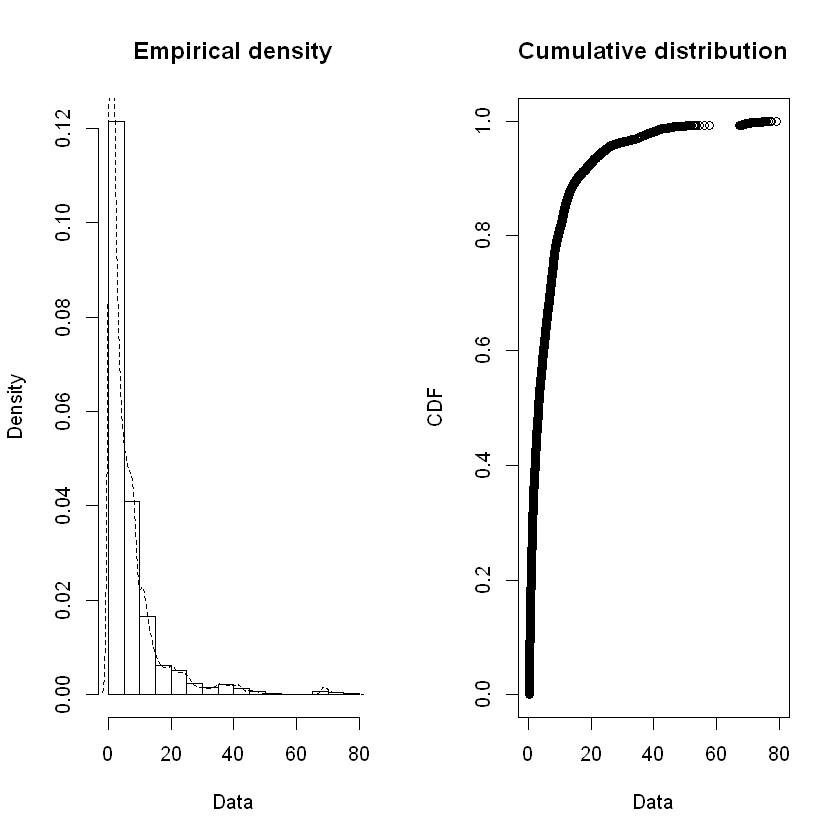

In [1180]:
plotdist( dfNov1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  79.1 
median:  3.25 
mean:  6.62886 
estimated sd:  9.711783 
estimated skewness:  3.476105 
estimated kurtosis:  18.92486 

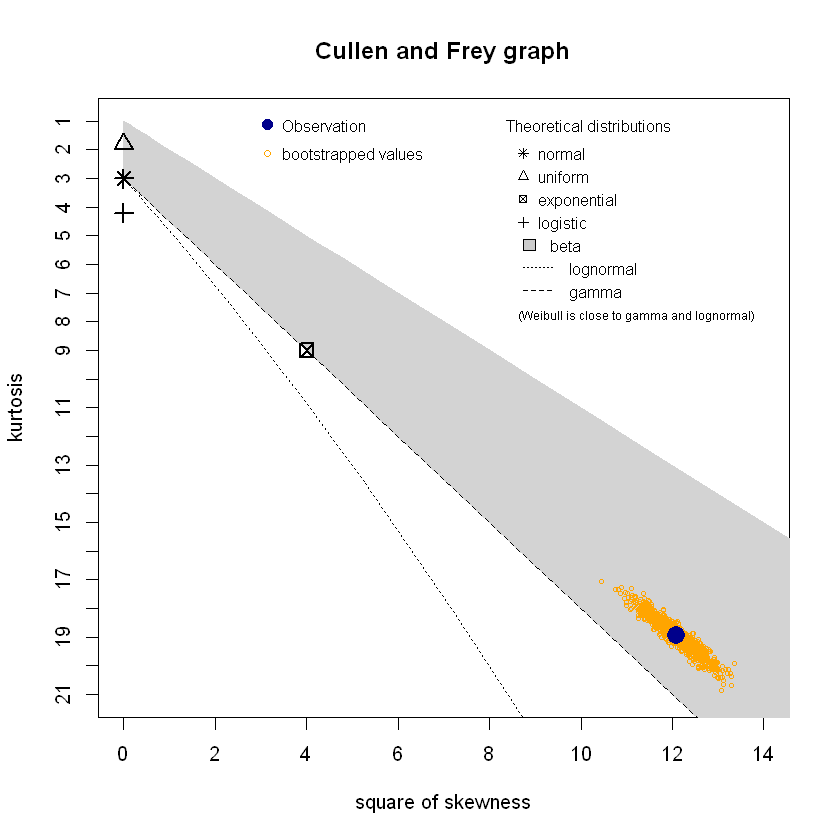

In [1181]:
descdist( dfNov1$Precip_mm, boot=1000 )

In [1182]:
fd_GM_Nov1 <- fitdist( dfNov1$Precip_mm, "gamma" )

In [1183]:
summary( fd_GM_Nov1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7694107 0.008285630
rate  0.1161808 0.001715027
Loglikelihood:  -36527.25   AIC:  73058.49   BIC:  73073.4 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7294186
rate  0.7294186 1.0000000


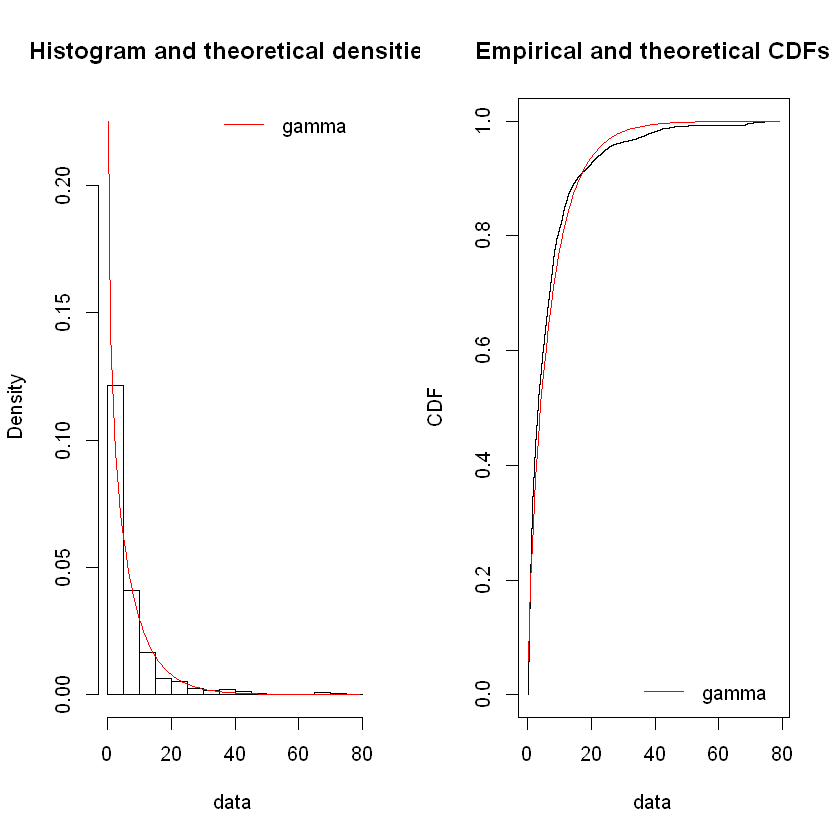

In [1184]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Nov1)
#qqcomp(fd_GM_Nov1)
cdfcomp(fd_GM_Nov1)
#ppcomp(fd_GM_Nov1)

In [1185]:
fdGM_Nov1_shape <- fd_GM_Nov1$estimate[["shape"]]
fdGM_Nov1_rate <- fd_GM_Nov1$estimate[["rate"]]
fdGM_Nov1_llike <- fd_GM_Nov1$loglik
fdGM_Nov1_mean <- fdGM_Nov1_shape / fdGM_Nov1_rate
fdGM_Nov1_var <- fdGM_Nov1_shape / ( fdGM_Nov1_rate ^ 2 )
cat(" Nov 1 shape: ", fdGM_Nov1_shape, "\n", "Nov 1 rate: ", fdGM_Nov1_rate, 
    "\n", "Nov 1 loglikelihood: ", fdGM_Nov1_llike, "\n", 
    "Nov 1 mean: ", fdGM_Nov1_mean, "\n",
    "Nov 1 variance: ", fdGM_Nov1_var, "\n" )

 Nov 1 shape:  0.7694107 
 Nov 1 rate:  0.1161808 
 Nov 1 loglikelihood:  -36527.25 
 Nov 1 mean:  6.62253 
 Nov 1 variance:  57.00195 


In [1186]:
statRes <- gofstat( fd_GM_Nov1, fitnames=c("Gamma") )

In [1187]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.06927527
Cramer-von Mises statistic    25.11730810
Anderson-Darling statistic   160.81619044

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 73058.49
Bayesian Information Criterion 73073.40


In [1188]:
ksRes <- ks.test( dfNov1$Precip_mm, "pgamma", shape=fdGM_Nov1_shape, rate=fdGM_Nov1_rate )

Warning message in ks.test(dfNov1$Precip_mm, "pgamma", shape = fdGM_Nov1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1189]:
fdGM_Nov1_KSStat <- ksRes$statistic
fdGM_Nov1_KSp <- ksRes$p.value
cat(" Nov 1 K-S stat: ", fdGM_Nov1_KSStat, "\n",
    "Nov 1 K-S p-value: ", fdGM_Nov1_KSp )

 Nov 1 K-S stat:  0.06927527 
 Nov 1 K-S p-value:  0

**Mixed exponential**

In [1190]:
fd_ME_Nov1 <- expRMM_EM( dfNov1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfNov1$Precip_mm), 1.0/mean(dfNov1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 331 


In [1191]:
summary( fd_ME_Nov1 )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.704244 0.295756
rate   0.290135 0.070392
loglik at estimate:  -35933.28 
0 % of the data right censored


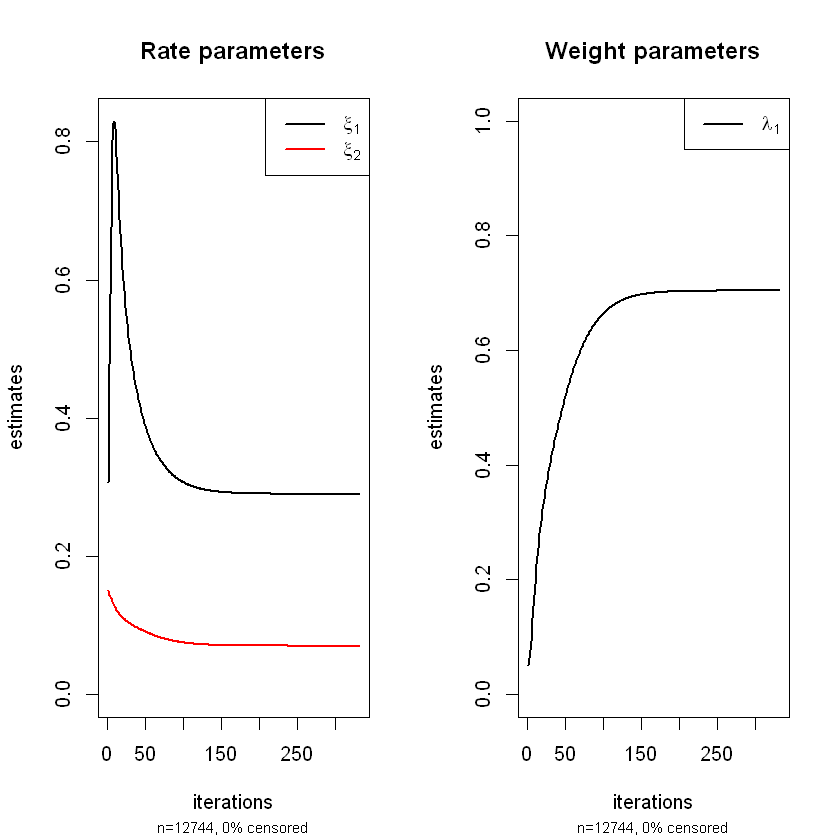

In [1192]:
plotexpRMM( fd_ME_Nov1, lwd=2 )

In [1193]:
fdME_Nov1_rate1 <- fd_ME_Nov1$rate[[1]]
fdME_Nov1_rate2 <- fd_ME_Nov1$rate[[2]]
fdME_Nov1_lambda <- fd_ME_Nov1$lambda[[1]]
fdME_Nov1_mean1 <- 1.0 / fdME_Nov1_rate1
fdME_Nov1_mean2 <- 1.0 / fdME_Nov1_rate2
fdME_Nov1_mean <- ( (fdME_Nov1_lambda * fdME_Nov1_mean1) + 
                    ( ( 1.0 - fdME_Nov1_lambda) * fdME_Nov1_mean2 ) )
fdME_Nov1_var1 <- 1.0 / (fdME_Nov1_rate1 ^ 2)
fdME_Nov1_var2 <- 1.0 / (fdME_Nov1_rate2 ^ 2)
fdME_Nov1_var <- ( (fdME_Nov1_lambda * ( fdME_Nov1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Nov1_lambda) * (fdME_Nov1_mean2 ^ 2) ) + 
                   ( fdME_Nov1_lambda * ( 1.0 - fdME_Nov1_lambda) * 
                       ( fdME_Nov1_mean1 - fdME_Nov1_mean2 )^2 ) )
fdME_Nov1_llike <- fd_ME_Nov1$loglik
cat(" Nov 1 rate1: ", fdME_Nov1_rate1, "\n", 
    "Nov 1 rate2: ", fdME_Nov1_rate2, "\n",
    "Nov 1 lambda: ", fdME_Nov1_lambda, "\n",
    "Nov 1 mean1: ", fdME_Nov1_mean1, "\n",
    "Nov 1 mean2: ", fdME_Nov1_mean2, "\n",
    "Nov 1 mean: ", fdME_Nov1_mean, "\n",
    "Nov 1 var1: ", fdME_Nov1_var1, "\n",
    "Nov 1 var2: ", fdME_Nov1_var2, "\n",
    "Nov 1 var: ", fdME_Nov1_var, "\n",
    "Nov 1 loglikelihood: ", fdME_Nov1_llike, "\n" )

 Nov 1 rate1:  0.2901349 
 Nov 1 rate2:  0.07039202 
 Nov 1 lambda:  0.7042435 
 Nov 1 mean1:  3.446673 
 Nov 1 mean2:  14.20616 
 Nov 1 mean:  6.62886 
 Nov 1 var1:  11.87956 
 Nov 1 var2:  201.8149 
 Nov 1 var:  92.16653 
 Nov 1 loglikelihood:  -35933.28 


In [1194]:
tvals <- rexpmix(length(dfNov1$Precip_mm), fd_ME_Nov1$lambda, fd_ME_Nov1$rate )

In [1195]:
ksRes <- ks.test( dfNov1$Precip_mm, tvals )

Warning message in ks.test(dfNov1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1196]:
fdME_Nov1_KSStat <- ksRes$statistic
fdME_Nov1_KSp <- ksRes$p.value
cat(" Nov 1 K-S stat: ", fdME_Nov1_KSStat, "\n",
    "Nov 1 K-S p-value: ", fdME_Nov1_KSp )

 Nov 1 K-S stat:  0.05163214 
 Nov 1 K-S p-value:  3.552714e-15

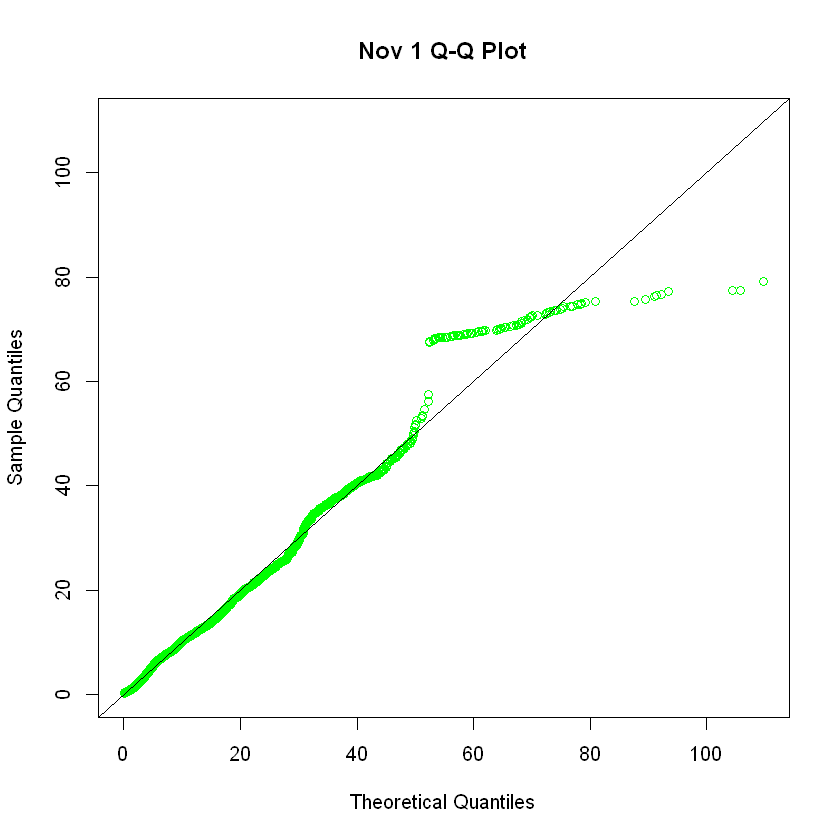

In [1197]:
wNov1Max <- max( max( dfNov1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfNov1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Nov 1 Q-Q Plot",
        xlim=c(0,wNov1Max), ylim=c(0,wNov1Max) )
abline( 0, 1)

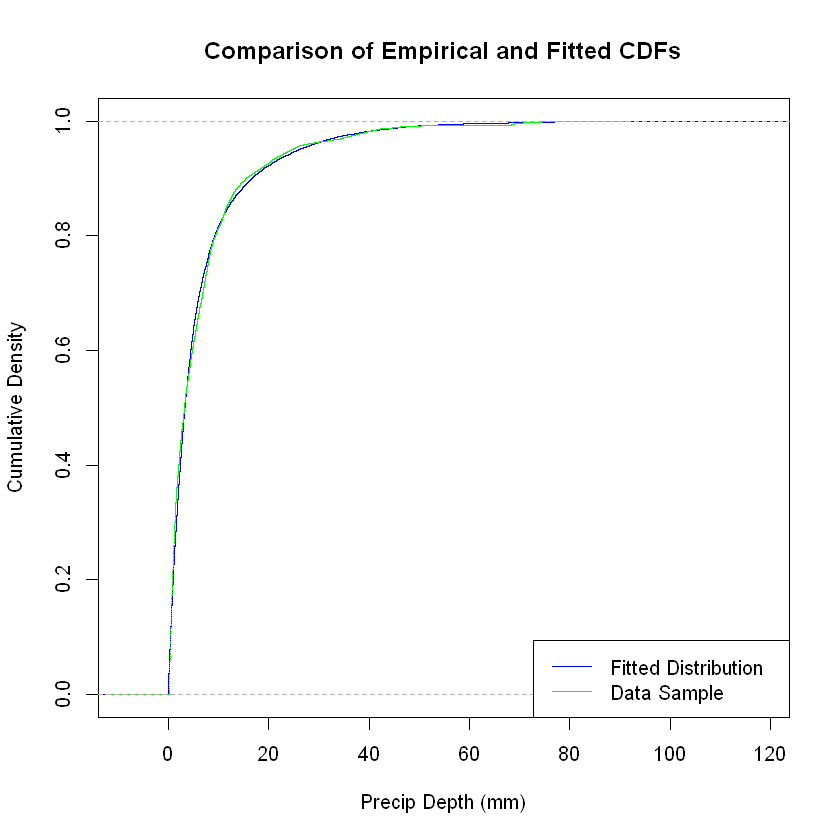

In [1198]:
x <- seq(0,wNov1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfNov1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1199]:
MonDistDF[52, ] <- list( 11, 1, fdGM_Nov1_shape, fdGM_Nov1_rate, fdGM_Nov1_llike, fdGM_Nov1_mean,
                        fdGM_Nov1_var, fdGM_Nov1_KSStat, fdGM_Nov1_KSp, fdME_Nov1_rate1,
                        fdME_Nov1_rate2, fdME_Nov1_lambda, fdME_Nov1_mean1, fdME_Nov1_mean2,
                        fdME_Nov1_mean, fdME_Nov1_var1, fdME_Nov1_var2, fdME_Nov1_var,
                        fdME_Nov1_llike, fdME_Nov1_KSStat, fdME_Nov1_KSp )

#### Region 2

**Gamma**

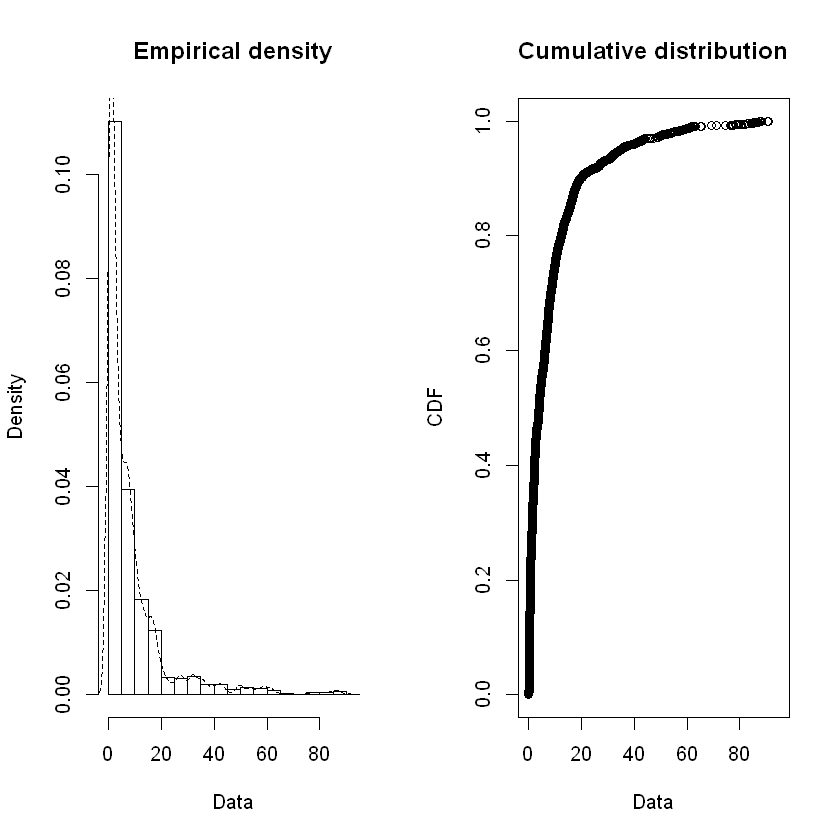

In [1200]:
plotdist( dfNov2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  90.72 
median:  4.11 
mean:  8.560575 
estimated sd:  12.80762 
estimated skewness:  3.083016 
estimated kurtosis:  14.52472 

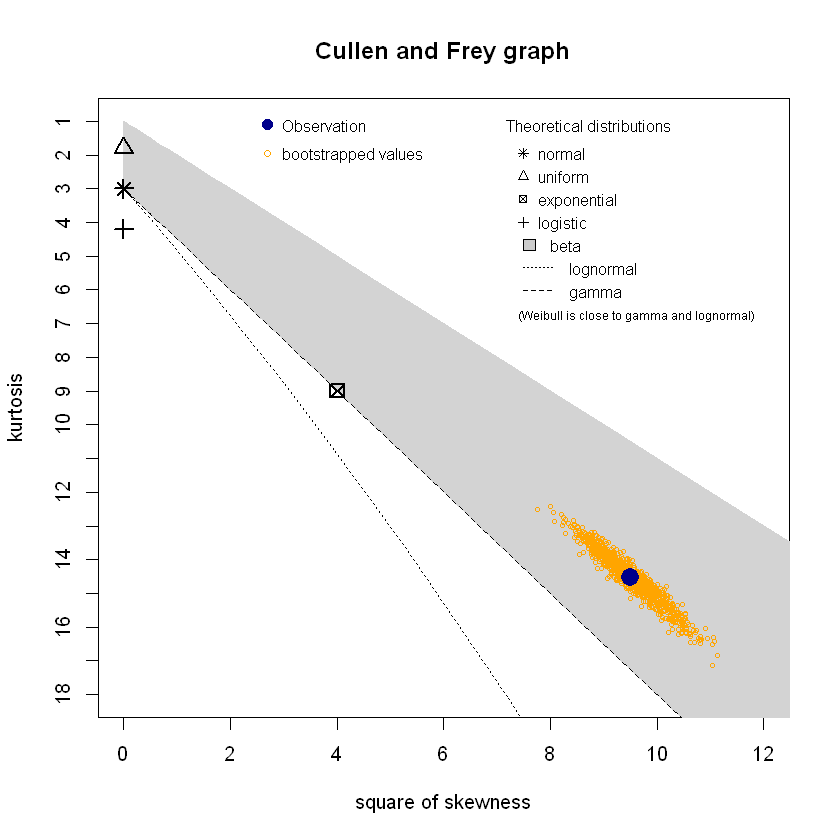

In [1201]:
descdist( dfNov2$Precip_mm, boot=1000 )

In [1202]:
fd_GM_Nov2 <- fitdist( dfNov2$Precip_mm, "gamma" )

In [1203]:
summary( fd_GM_Nov2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.67404469 0.012348152
rate  0.07873516 0.002054267
Loglikelihood:  -13257.71   AIC:  26519.43   BIC:  26532.16 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7019535
rate  0.7019535 1.0000000


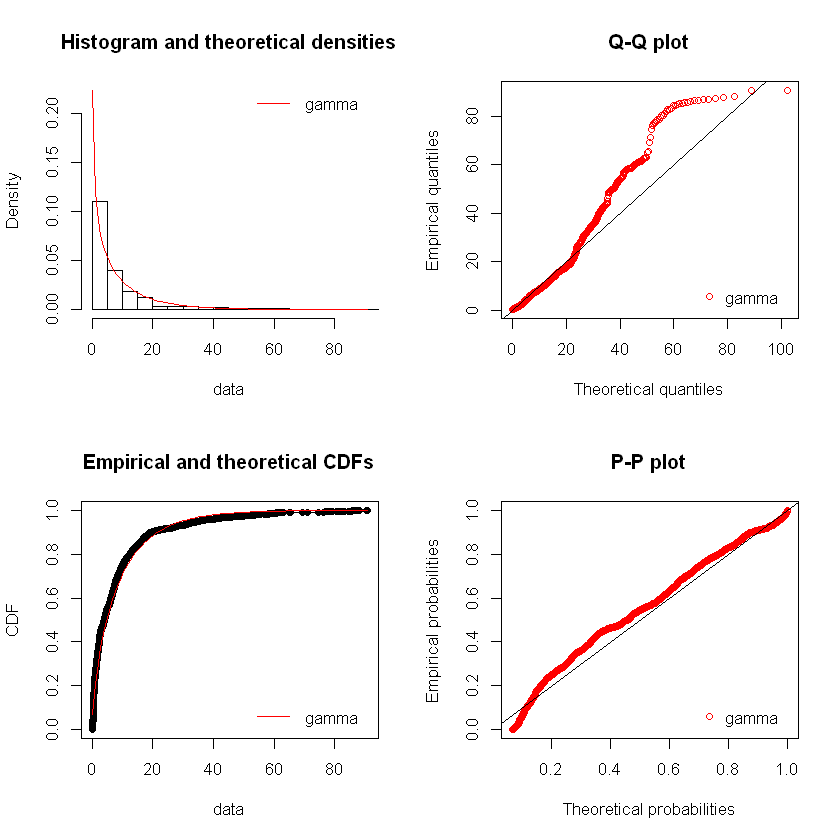

In [1204]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Nov2)
qqcomp(fd_GM_Nov2)
cdfcomp(fd_GM_Nov2)
ppcomp(fd_GM_Nov2)

In [1205]:
fdGM_Nov2_shape <- fd_GM_Nov2$estimate[["shape"]]
fdGM_Nov2_rate <- fd_GM_Nov2$estimate[["rate"]]
fdGM_Nov2_llike <- fd_GM_Nov2$loglik
fdGM_Nov2_mean <- fdGM_Nov2_shape / fdGM_Nov2_rate
fdGM_Nov2_var <- fdGM_Nov2_shape / ( fdGM_Nov2_rate ^ 2 )
cat(" Nov 2 shape: ", fdGM_Nov2_shape, "\n", "Nov 2 rate: ", fdGM_Nov2_rate, 
    "\n", "Nov 2 loglikelihood: ", fdGM_Nov2_llike, "\n", 
    "Nov 2 mean: ", fdGM_Nov2_mean, "\n",
    "Nov 2 variance: ", fdGM_Nov2_var, "\n" )

 Nov 2 shape:  0.6740447 
 Nov 2 rate:  0.07873516 
 Nov 2 loglikelihood:  -13257.71 
 Nov 2 mean:  8.560911 
 Nov 2 variance:  108.7305 


In [1206]:
statRes <- gofstat( fd_GM_Nov2, fitnames=c("Gamma") )

In [1207]:
print(statRes)

Goodness-of-fit statistics
                                  Gamma
Kolmogorov-Smirnov statistic  0.0781231
Cramer-von Mises statistic    7.8428602
Anderson-Darling statistic   53.8701216

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 26519.43
Bayesian Information Criterion 26532.16


In [1208]:
ksRes <- ks.test( dfNov2$Precip_mm, "pgamma", shape=fdGM_Nov2_shape, rate=fdGM_Nov2_rate )

Warning message in ks.test(dfNov2$Precip_mm, "pgamma", shape = fdGM_Nov2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1209]:
fdGM_Nov2_KSStat <- ksRes$statistic
fdGM_Nov2_KSp <- ksRes$p.value
cat(" Nov 2 K-S stat: ", fdGM_Nov2_KSStat, "\n",
    "Nov 2 K-S p-value: ", fdGM_Nov2_KSp )

 Nov 2 K-S stat:  0.0781231 
 Nov 2 K-S p-value:  0

**Mixed exponential**

In [1210]:
fd_ME_Nov2 <- expRMM_EM( dfNov2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfNov2$Precip_mm), 1.0/mean(dfNov2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 358 


In [1211]:
summary( fd_ME_Nov2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.408939 0.5910609
rate   0.523622 0.0759758
loglik at estimate:  -13083.65 
0 % of the data right censored


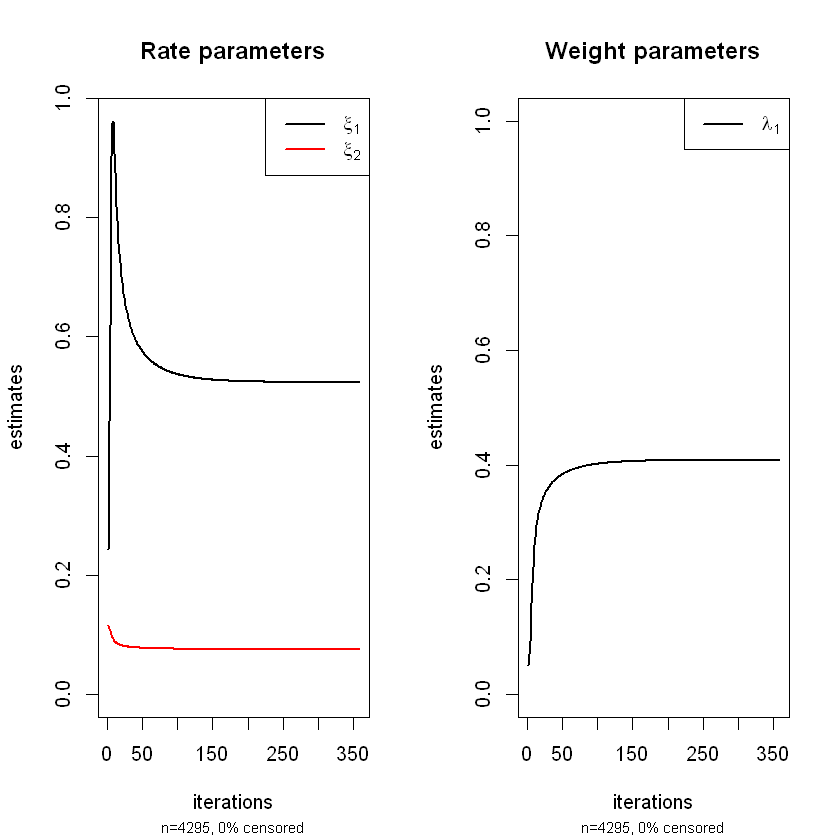

In [1212]:
plotexpRMM( fd_ME_Nov2, lwd=2 )

In [1213]:
fdME_Nov2_rate1 <- fd_ME_Nov2$rate[[1]]
fdME_Nov2_rate2 <- fd_ME_Nov2$rate[[2]]
fdME_Nov2_lambda <- fd_ME_Nov2$lambda[[1]]
fdME_Nov2_mean1 <- 1.0 / fdME_Nov2_rate1
fdME_Nov2_mean2 <- 1.0 / fdME_Nov2_rate2
fdME_Nov2_mean <- ( (fdME_Nov2_lambda * fdME_Nov2_mean1) + 
                    ( ( 1.0 - fdME_Nov2_lambda) * fdME_Nov2_mean2 ) )
fdME_Nov2_var1 <- 1.0 / (fdME_Nov2_rate1 ^ 2)
fdME_Nov2_var2 <- 1.0 / (fdME_Nov2_rate2 ^ 2)
fdME_Nov2_var <- ( (fdME_Nov2_lambda * ( fdME_Nov2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Nov2_lambda) * (fdME_Nov2_mean2 ^ 2) ) + 
                   ( fdME_Nov2_lambda * ( 1.0 - fdME_Nov2_lambda) * 
                       ( fdME_Nov2_mean1 - fdME_Nov2_mean2 )^2 ) )
fdME_Nov2_llike <- fd_ME_Nov2$loglik
cat(" Nov 2 rate1: ", fdME_Nov2_rate1, "\n", 
    "Nov 2 rate2: ", fdME_Nov2_rate2, "\n",
    "Nov 2 lambda: ", fdME_Nov2_lambda, "\n",
    "Nov 2 mean1: ", fdME_Nov2_mean1, "\n",
    "Nov 2 mean2: ", fdME_Nov2_mean2, "\n",
    "Nov 2 mean: ", fdME_Nov2_mean, "\n",
    "Nov 2 var1: ", fdME_Nov2_var1, "\n",
    "Nov 2 var2: ", fdME_Nov2_var2, "\n",
    "Nov 2 var: ", fdME_Nov2_var, "\n",
    "Nov 2 loglikelihood: ", fdME_Nov2_llike, "\n" )

 Nov 2 rate1:  0.5236217 
 Nov 2 rate2:  0.07597581 
 Nov 2 lambda:  0.4089391 
 Nov 2 mean1:  1.909776 
 Nov 2 mean2:  13.16208 
 Nov 2 mean:  8.560575 
 Nov 2 var1:  3.647243 
 Nov 2 var2:  173.2405 
 Nov 2 var:  134.4909 
 Nov 2 loglikelihood:  -13083.65 


In [1214]:
tvals <- rexpmix(length(dfNov2$Precip_mm), fd_ME_Nov2$lambda, fd_ME_Nov2$rate )

In [1215]:
ksRes <- ks.test( dfNov2$Precip_mm, tvals )

Warning message in ks.test(dfNov2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1216]:
fdME_Nov2_KSStat <- ksRes$statistic
fdME_Nov2_KSp <- ksRes$p.value
cat(" Nov 2 K-S stat: ", fdME_Nov2_KSStat, "\n",
    "Nov 2 K-S p-value: ", fdME_Nov2_KSp )

 Nov 2 K-S stat:  0.05331781 
 Nov 2 K-S p-value:  9.963007e-06

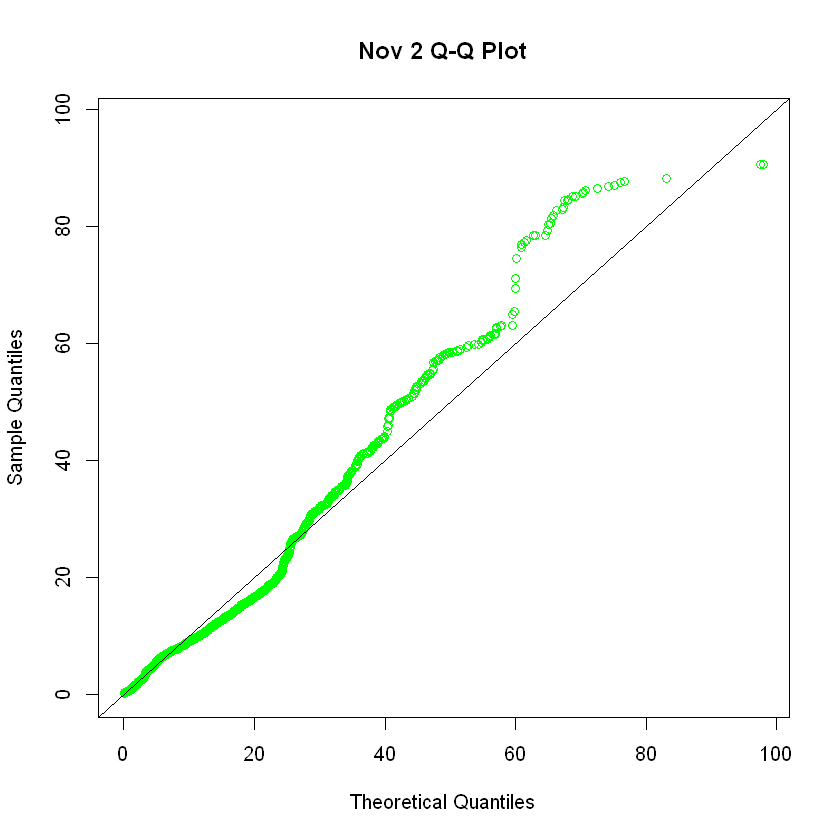

In [1217]:
wNov2Max <- max( max( dfNov2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfNov2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Nov 2 Q-Q Plot",
        xlim=c(0,wNov2Max), ylim=c(0,wNov2Max) )
abline( 0, 1)

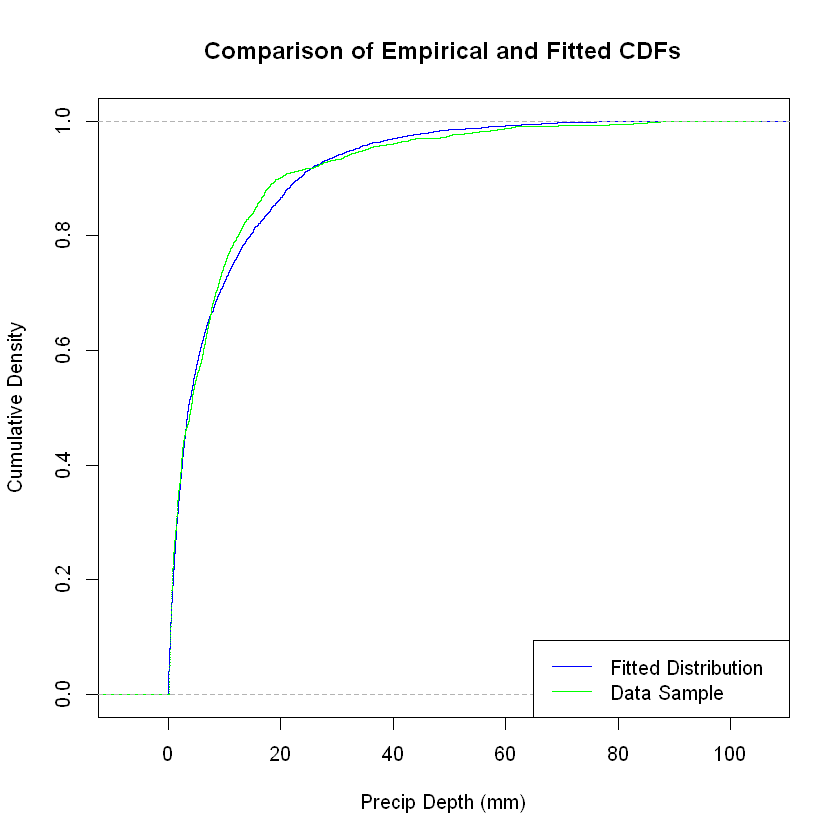

In [1218]:
x <- seq(0,wNov2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfNov2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1219]:
MonDistDF[53, ] <- list( 11, 2, fdGM_Nov2_shape, fdGM_Nov2_rate, fdGM_Nov2_llike, fdGM_Nov2_mean,
                        fdGM_Nov2_var, fdGM_Nov2_KSStat, fdGM_Nov2_KSp, fdME_Nov2_rate1,
                        fdME_Nov2_rate2, fdME_Nov2_lambda, fdME_Nov2_mean1, fdME_Nov2_mean2,
                        fdME_Nov2_mean, fdME_Nov2_var1, fdME_Nov2_var2, fdME_Nov2_var,
                        fdME_Nov2_llike, fdME_Nov2_KSStat, fdME_Nov2_KSp )

#### Region 3

**Gamma**

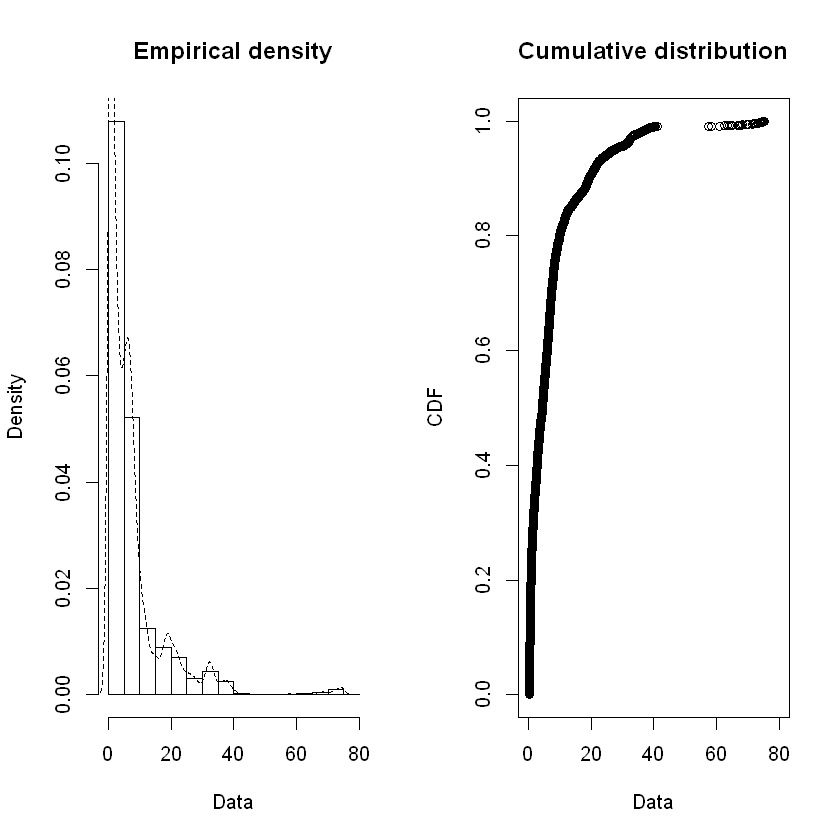

In [1220]:
plotdist( dfNov3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  75.19 
median:  4.48 
mean:  7.338112 
estimated sd:  9.923795 
estimated skewness:  3.191959 
estimated kurtosis:  17.29167 

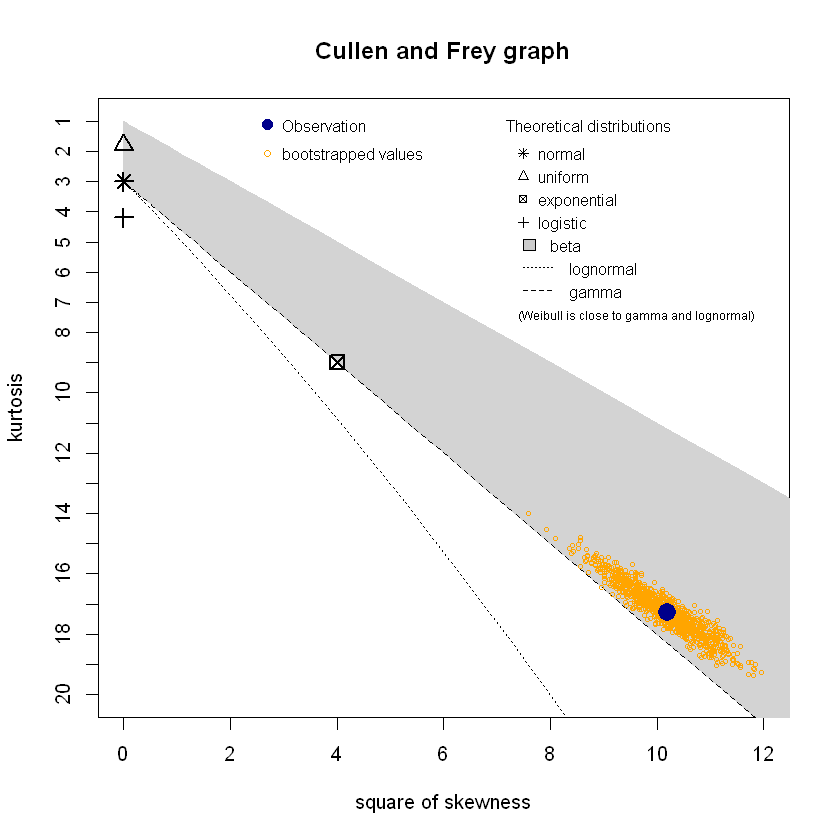

In [1221]:
descdist( dfNov3$Precip_mm, boot=1000 )

In [1222]:
fd_GM_Nov3 <- fitdist( dfNov3$Precip_mm, "gamma" )

In [1223]:
summary( fd_GM_Nov3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7865099 0.013177916
rate  0.1071948 0.002447081
Loglikelihood:  -15711.49   AIC:  31426.97   BIC:  31440.12 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7338459
rate  0.7338459 1.0000000


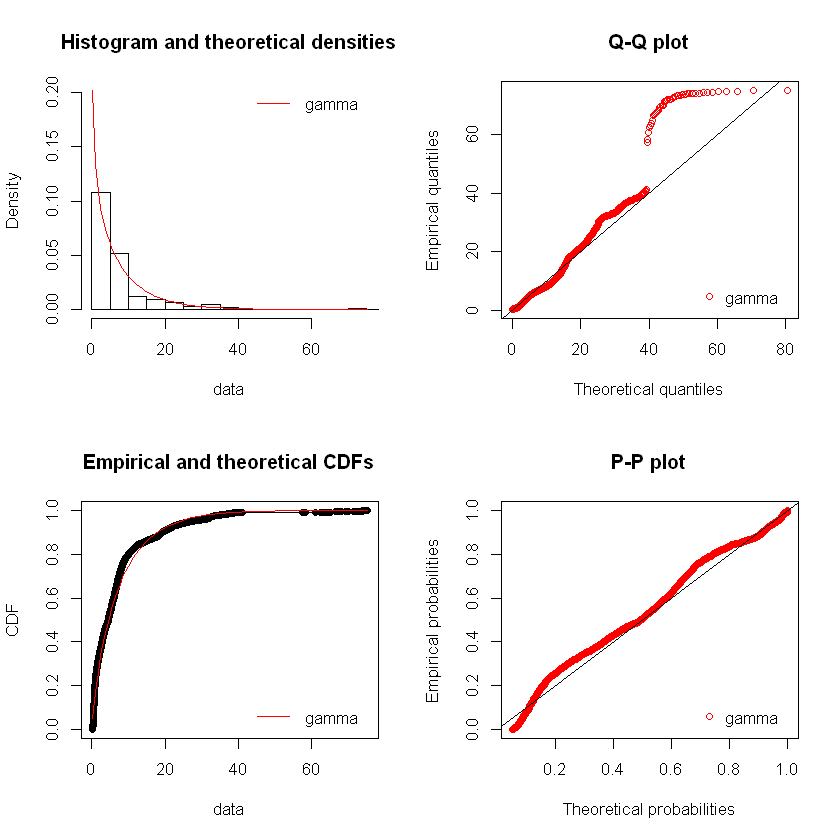

In [1224]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Nov3)
qqcomp(fd_GM_Nov3)
cdfcomp(fd_GM_Nov3)
ppcomp(fd_GM_Nov3)

In [1225]:
fdGM_Nov3_shape <- fd_GM_Nov3$estimate[["shape"]]
fdGM_Nov3_rate <- fd_GM_Nov3$estimate[["rate"]]
fdGM_Nov3_llike <- fd_GM_Nov3$loglik
fdGM_Nov3_mean <- fdGM_Nov3_shape / fdGM_Nov3_rate
fdGM_Nov3_var <- fdGM_Nov3_shape / ( fdGM_Nov3_rate ^ 2 )
cat(" Nov 3 shape: ", fdGM_Nov3_shape, "\n", "Nov 3 rate: ", fdGM_Nov3_rate, 
    "\n", "Nov 3 loglikelihood: ", fdGM_Nov3_llike, "\n", 
    "Nov 3 mean: ", fdGM_Nov3_mean, "\n",
    "Nov 3 variance: ", fdGM_Nov3_var, "\n" )

 Nov 3 shape:  0.7865099 
 Nov 3 rate:  0.1071948 
 Nov 3 loglikelihood:  -15711.49 
 Nov 3 mean:  7.337204 
 Nov 3 variance:  68.4474 


In [1226]:
statRes <- gofstat( fd_GM_Nov3, fitnames=c("Gamma") )

In [1227]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.06423328
Cramer-von Mises statistic    7.13454424
Anderson-Darling statistic   51.25680806

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 31426.97
Bayesian Information Criterion 31440.12


In [1228]:
ksRes <- ks.test( dfNov3$Precip_mm, "pgamma", shape=fdGM_Nov3_shape, rate=fdGM_Nov3_rate )

Warning message in ks.test(dfNov3$Precip_mm, "pgamma", shape = fdGM_Nov3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1229]:
fdGM_Nov3_KSStat <- ksRes$statistic
fdGM_Nov3_KSp <- ksRes$p.value
cat(" Nov 3 K-S stat: ", fdGM_Nov3_KSStat, "\n",
    "Nov 3 K-S p-value: ", fdGM_Nov3_KSp )

 Nov 3 K-S stat:  0.06423328 
 Nov 3 K-S p-value:  0

**Mixed exponential**

In [1230]:
fd_ME_Nov3 <- expRMM_EM( dfNov3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfNov3$Precip_mm), 1.0/mean(dfNov3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 367 


In [1231]:
summary( fd_ME_Nov3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.611468 0.3885318
rate   0.274561 0.0760182
loglik at estimate:  -15566.46 
0 % of the data right censored


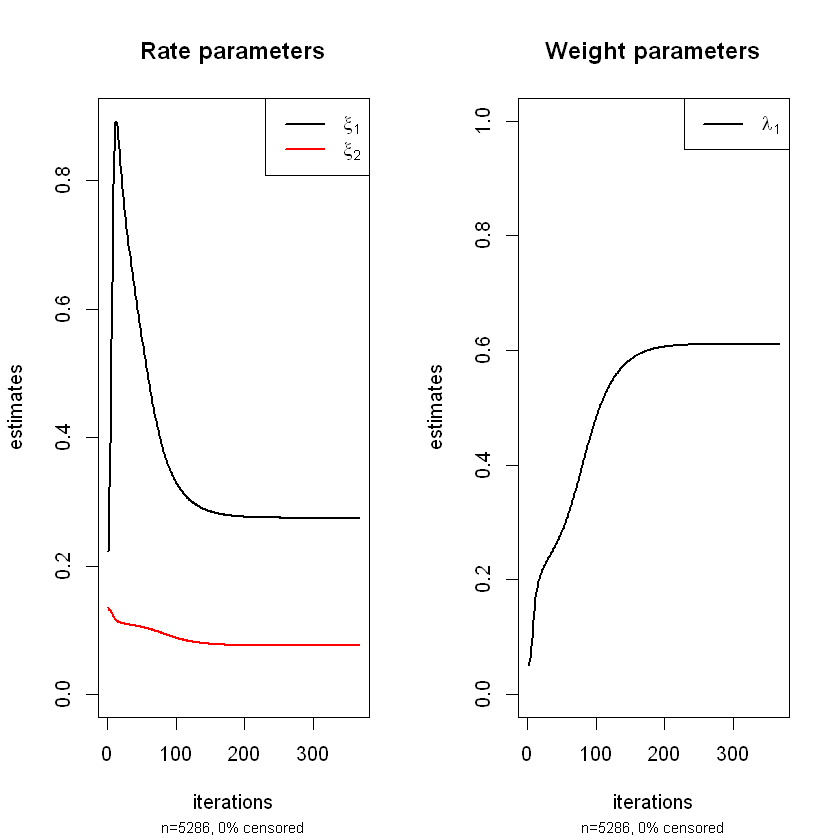

In [1232]:
plotexpRMM( fd_ME_Nov3, lwd=2 )

In [1233]:
fdME_Nov3_rate1 <- fd_ME_Nov3$rate[[1]]
fdME_Nov3_rate2 <- fd_ME_Nov3$rate[[2]]
fdME_Nov3_lambda <- fd_ME_Nov3$lambda[[1]]
fdME_Nov3_mean1 <- 1.0 / fdME_Nov3_rate1
fdME_Nov3_mean2 <- 1.0 / fdME_Nov3_rate2
fdME_Nov3_mean <- ( (fdME_Nov3_lambda * fdME_Nov3_mean1) + 
                    ( ( 1.0 - fdME_Nov3_lambda) * fdME_Nov3_mean2 ) )
fdME_Nov3_var1 <- 1.0 / (fdME_Nov3_rate1 ^ 2)
fdME_Nov3_var2 <- 1.0 / (fdME_Nov3_rate2 ^ 2)
fdME_Nov3_var <- ( (fdME_Nov3_lambda * ( fdME_Nov3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Nov3_lambda) * (fdME_Nov3_mean2 ^ 2) ) + 
                   ( fdME_Nov3_lambda * ( 1.0 - fdME_Nov3_lambda) * 
                       ( fdME_Nov3_mean1 - fdME_Nov3_mean2 )^2 ) )
fdME_Nov3_llike <- fd_ME_Nov3$loglik
cat(" Nov 3 rate1: ", fdME_Nov3_rate1, "\n", 
    "Nov 3 rate2: ", fdME_Nov3_rate2, "\n",
    "Nov 3 lambda: ", fdME_Nov3_lambda, "\n",
    "Nov 3 mean1: ", fdME_Nov3_mean1, "\n",
    "Nov 3 mean2: ", fdME_Nov3_mean2, "\n",
    "Nov 3 mean: ", fdME_Nov3_mean, "\n",
    "Nov 3 var1: ", fdME_Nov3_var1, "\n",
    "Nov 3 var2: ", fdME_Nov3_var2, "\n",
    "Nov 3 var: ", fdME_Nov3_var, "\n",
    "Nov 3 loglikelihood: ", fdME_Nov3_llike, "\n" )

 Nov 3 rate1:  0.2745612 
 Nov 3 rate2:  0.07601819 
 Nov 3 lambda:  0.6114682 
 Nov 3 mean1:  3.642175 
 Nov 3 mean2:  13.15475 
 Nov 3 mean:  7.338112 
 Nov 3 var1:  13.26544 
 Nov 3 var2:  173.0474 
 Nov 3 var:  96.84371 
 Nov 3 loglikelihood:  -15566.46 


In [1234]:
tvals <- rexpmix(length(dfNov3$Precip_mm), fd_ME_Nov3$lambda, fd_ME_Nov3$rate )

In [1235]:
ksRes <- ks.test( dfNov3$Precip_mm, tvals )

Warning message in ks.test(dfNov3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1236]:
fdME_Nov3_KSStat <- ksRes$statistic
fdME_Nov3_KSp <- ksRes$p.value
cat(" Nov 3 K-S stat: ", fdME_Nov3_KSStat, "\n",
    "Nov 3 K-S p-value: ", fdME_Nov3_KSp )

 Nov 3 K-S stat:  0.06375331 
 Nov 3 K-S p-value:  9.338377e-10

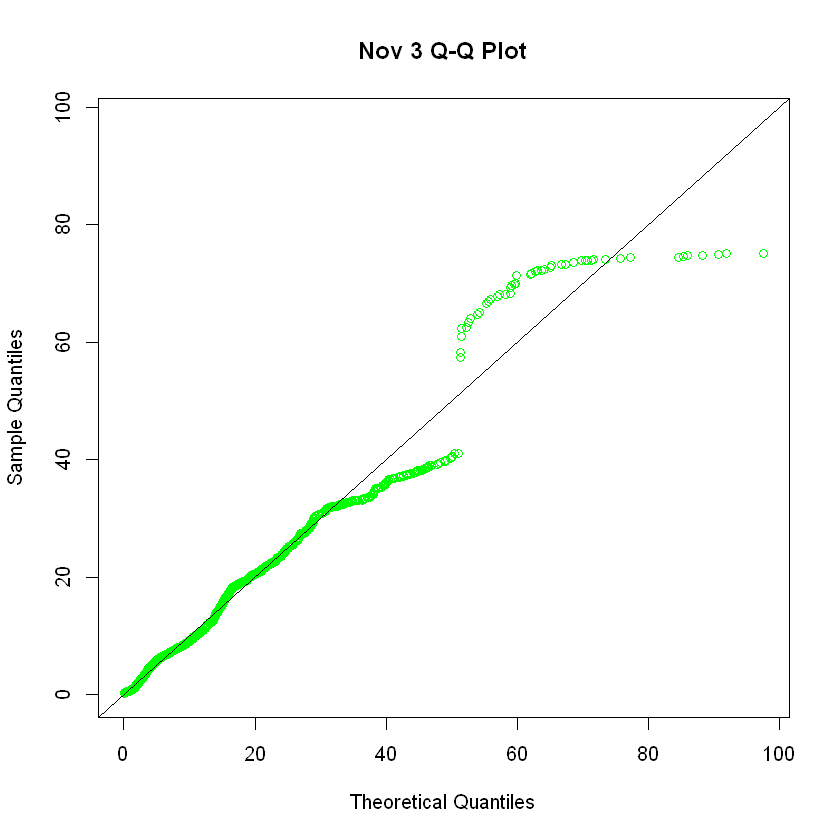

In [1237]:
wNov3Max <- max( max( dfNov3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfNov3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Nov 3 Q-Q Plot",
        xlim=c(0,wNov3Max), ylim=c(0,wNov3Max) )
abline( 0, 1)

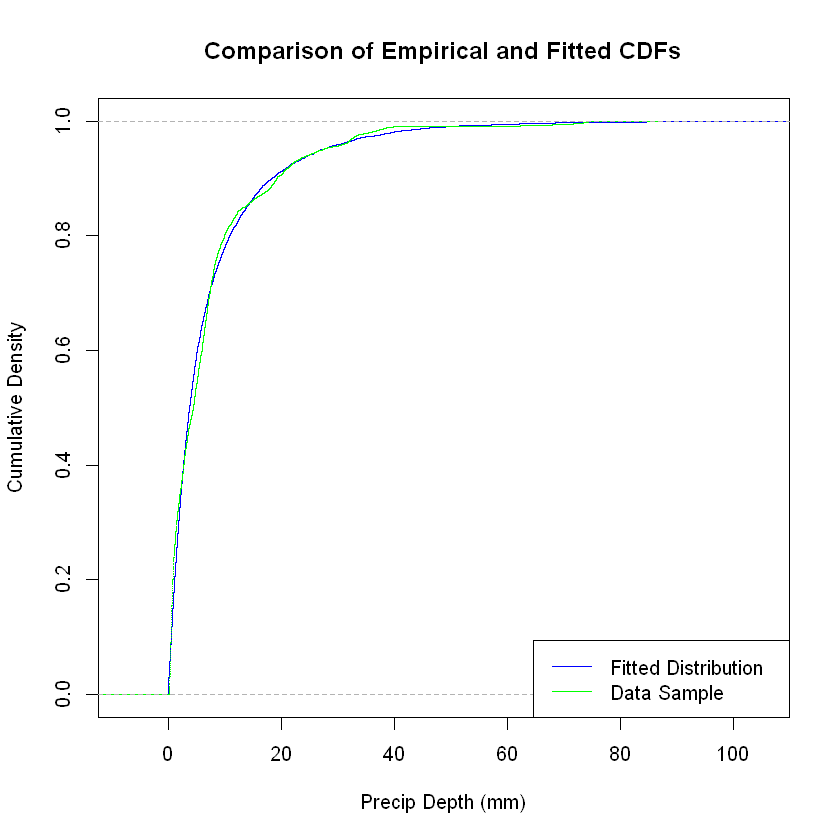

In [1238]:
x <- seq(0,wNov3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfNov3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1239]:
MonDistDF[54, ] <- list( 11, 3, fdGM_Nov3_shape, fdGM_Nov3_rate, fdGM_Nov3_llike, fdGM_Nov3_mean,
                        fdGM_Nov3_var, fdGM_Nov3_KSStat, fdGM_Nov3_KSp, fdME_Nov3_rate1,
                        fdME_Nov3_rate2, fdME_Nov3_lambda, fdME_Nov3_mean1, fdME_Nov3_mean2,
                        fdME_Nov3_mean, fdME_Nov3_var1, fdME_Nov3_var2, fdME_Nov3_var,
                        fdME_Nov3_llike, fdME_Nov3_KSStat, fdME_Nov3_KSp )

#### Region 4

**Gamma**

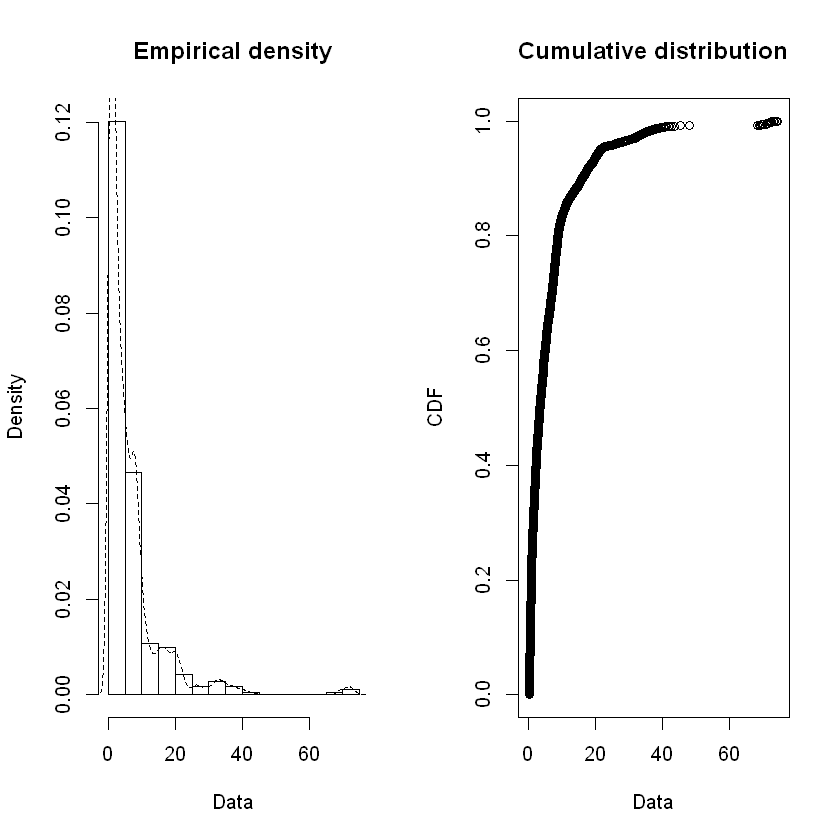

In [1240]:
plotdist( dfNov4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  74.28 
median:  3.45 
mean:  6.474271 
estimated sd:  9.22619 
estimated skewness:  3.736626 
estimated kurtosis:  22.40154 

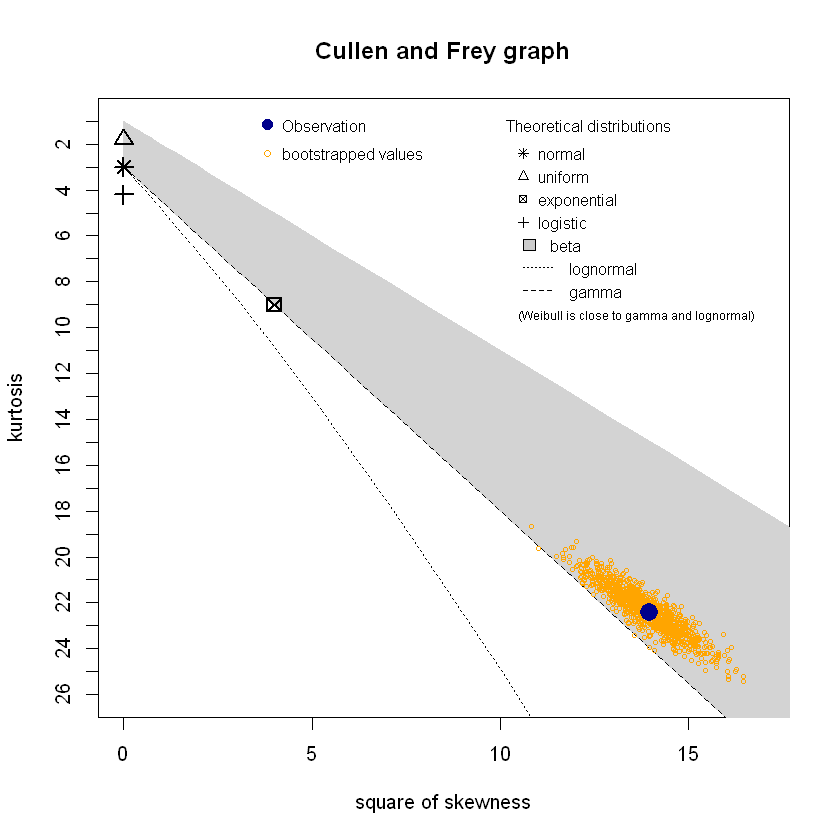

In [1241]:
descdist( dfNov4$Precip_mm, boot=1000 )

In [1242]:
fd_GM_Nov4 <- fitdist( dfNov4$Precip_mm, "gamma" )

In [1243]:
summary( fd_GM_Nov4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8158217 0.014920307
rate  0.1260049 0.003108962
Loglikelihood:  -12744.96   AIC:  25493.92   BIC:  25506.73 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7411546
rate  0.7411546 1.0000000


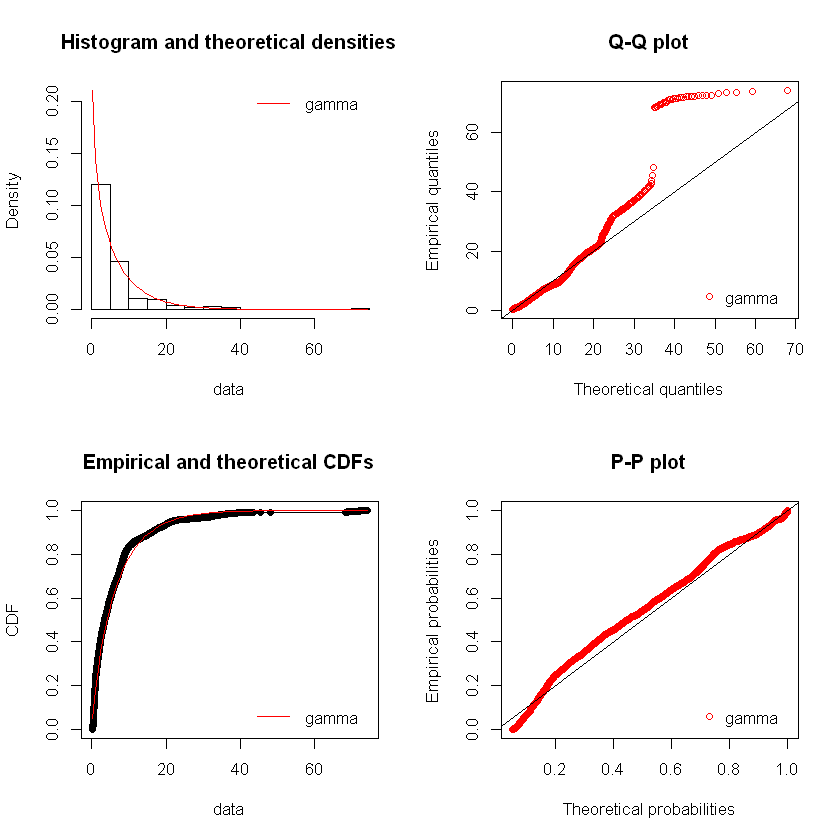

In [1244]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Nov4)
qqcomp(fd_GM_Nov4)
cdfcomp(fd_GM_Nov4)
ppcomp(fd_GM_Nov4)

In [1245]:
fdGM_Nov4_shape <- fd_GM_Nov4$estimate[["shape"]]
fdGM_Nov4_rate <- fd_GM_Nov4$estimate[["rate"]]
fdGM_Nov4_llike <- fd_GM_Nov4$loglik
fdGM_Nov4_mean <- fdGM_Nov4_shape / fdGM_Nov4_rate
fdGM_Nov4_var <- fdGM_Nov4_shape / ( fdGM_Nov4_rate ^ 2 )
cat(" Nov 4 shape: ", fdGM_Nov4_shape, "\n", "Nov 4 rate: ", fdGM_Nov4_rate, 
    "\n", "Nov 4 loglikelihood: ", fdGM_Nov4_llike, "\n", 
    "Nov 4 mean: ", fdGM_Nov4_mean, "\n",
    "Nov 4 variance: ", fdGM_Nov4_var, "\n" )

 Nov 4 shape:  0.8158217 
 Nov 4 rate:  0.1260049 
 Nov 4 loglikelihood:  -12744.96 
 Nov 4 mean:  6.474525 
 Nov 4 variance:  51.38314 


In [1246]:
statRes <- gofstat( fd_GM_Nov4, fitnames=c("Gamma") )

In [1247]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.06162575
Cramer-von Mises statistic    7.25255836
Anderson-Darling statistic   48.37305248

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 25493.92
Bayesian Information Criterion 25506.73


In [1248]:
ksRes <- ks.test( dfNov4$Precip_mm, "pgamma", shape=fdGM_Nov4_shape, rate=fdGM_Nov4_rate )

Warning message in ks.test(dfNov4$Precip_mm, "pgamma", shape = fdGM_Nov4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1249]:
fdGM_Nov4_KSStat <- ksRes$statistic
fdGM_Nov4_KSp <- ksRes$p.value
cat(" Nov 4 K-S stat: ", fdGM_Nov4_KSStat, "\n",
    "Nov 4 K-S p-value: ", fdGM_Nov4_KSp )

 Nov 4 K-S stat:  0.06162575 
 Nov 4 K-S p-value:  3.663736e-15

**Mixed exponential**

In [1250]:
fd_ME_Nov4 <- expRMM_EM( dfNov4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfNov4$Precip_mm), 1.0/mean(dfNov4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 361 


In [1251]:
summary( fd_ME_Nov4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.736992 0.2630082
rate   0.263403 0.0715413
loglik at estimate:  -12571.35 
0 % of the data right censored


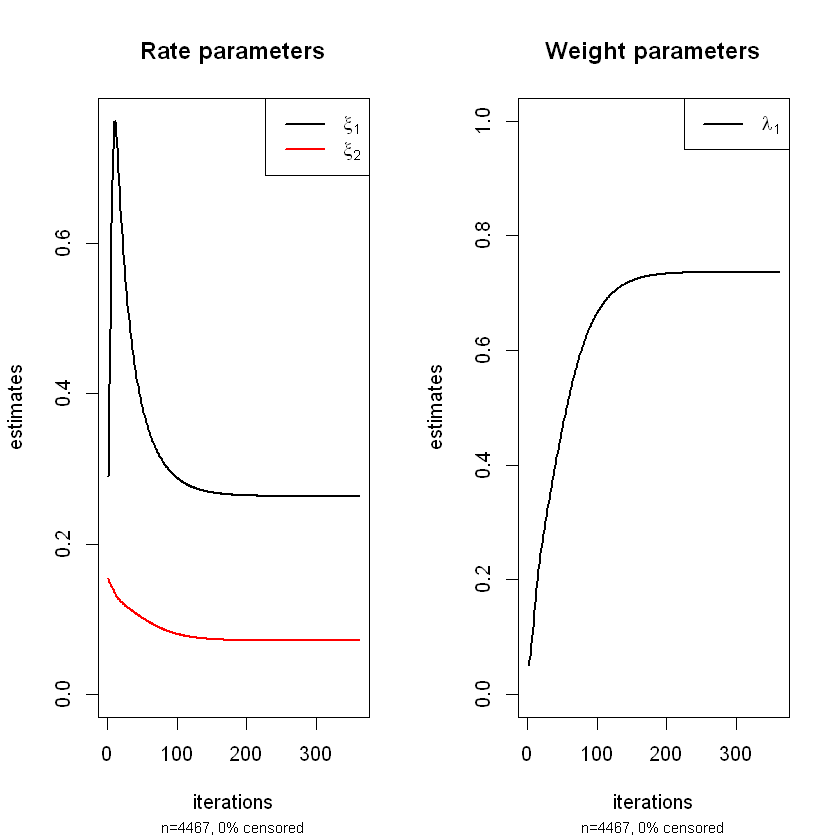

In [1252]:
plotexpRMM( fd_ME_Nov4, lwd=2 )

In [1253]:
fdME_Nov4_rate1 <- fd_ME_Nov4$rate[[1]]
fdME_Nov4_rate2 <- fd_ME_Nov4$rate[[2]]
fdME_Nov4_lambda <- fd_ME_Nov4$lambda[[1]]
fdME_Nov4_mean1 <- 1.0 / fdME_Nov4_rate1
fdME_Nov4_mean2 <- 1.0 / fdME_Nov4_rate2
fdME_Nov4_mean <- ( (fdME_Nov4_lambda * fdME_Nov4_mean1) + 
                    ( ( 1.0 - fdME_Nov4_lambda) * fdME_Nov4_mean2 ) )
fdME_Nov4_var1 <- 1.0 / (fdME_Nov4_rate1 ^ 2)
fdME_Nov4_var2 <- 1.0 / (fdME_Nov4_rate2 ^ 2)
fdME_Nov4_var <- ( (fdME_Nov4_lambda * ( fdME_Nov4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Nov4_lambda) * (fdME_Nov4_mean2 ^ 2) ) + 
                   ( fdME_Nov4_lambda * ( 1.0 - fdME_Nov4_lambda) * 
                       ( fdME_Nov4_mean1 - fdME_Nov4_mean2 )^2 ) )
fdME_Nov4_llike <- fd_ME_Nov4$loglik
cat(" Nov 4 rate1: ", fdME_Nov4_rate1, "\n", 
    "Nov 4 rate2: ", fdME_Nov4_rate2, "\n",
    "Nov 4 lambda: ", fdME_Nov4_lambda, "\n",
    "Nov 4 mean1: ", fdME_Nov4_mean1, "\n",
    "Nov 4 mean2: ", fdME_Nov4_mean2, "\n",
    "Nov 4 mean: ", fdME_Nov4_mean, "\n",
    "Nov 4 var1: ", fdME_Nov4_var1, "\n",
    "Nov 4 var2: ", fdME_Nov4_var2, "\n",
    "Nov 4 var: ", fdME_Nov4_var, "\n",
    "Nov 4 loglikelihood: ", fdME_Nov4_llike, "\n" )

 Nov 4 rate1:  0.2634035 
 Nov 4 rate2:  0.07154128 
 Nov 4 lambda:  0.7369918 
 Nov 4 mean1:  3.796457 
 Nov 4 mean2:  13.97794 
 Nov 4 mean:  6.474271 
 Nov 4 var1:  14.41309 
 Nov 4 var2:  195.3829 
 Nov 4 var:  82.10306 
 Nov 4 loglikelihood:  -12571.35 


In [1254]:
tvals <- rexpmix(length(dfNov4$Precip_mm), fd_ME_Nov4$lambda, fd_ME_Nov4$rate )

In [1255]:
ksRes <- ks.test( dfNov4$Precip_mm, tvals )

Warning message in ks.test(dfNov4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1256]:
fdME_Nov4_KSStat <- ksRes$statistic
fdME_Nov4_KSp <- ksRes$p.value
cat(" Nov 4 K-S stat: ", fdME_Nov4_KSStat, "\n",
    "Nov 4 K-S p-value: ", fdME_Nov4_KSp )

 Nov 4 K-S stat:  0.04902619 
 Nov 4 K-S p-value:  4.346351e-05

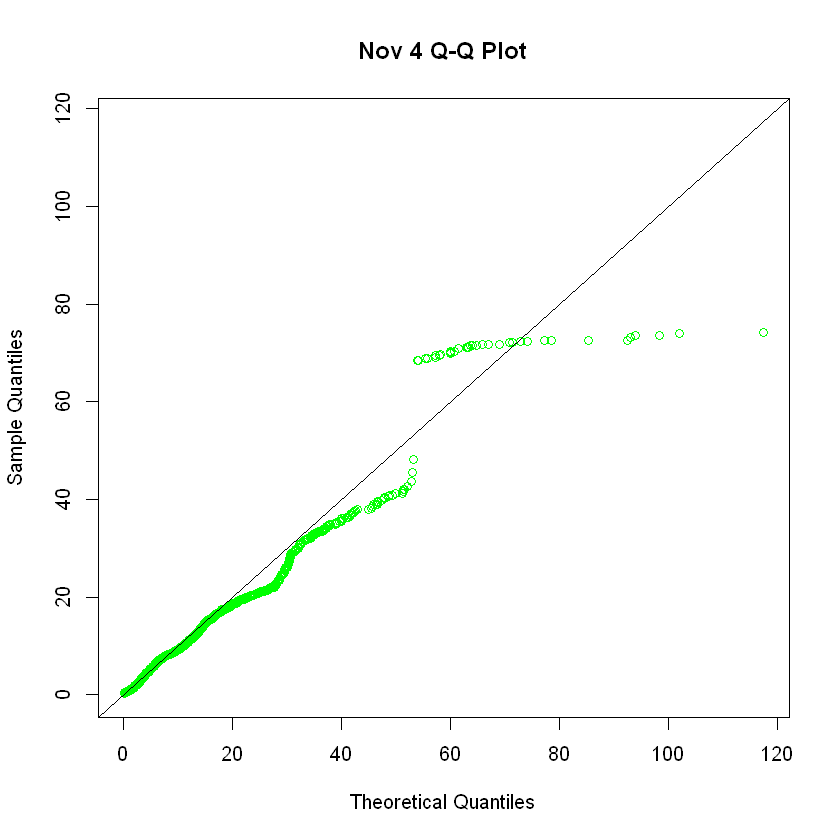

In [1257]:
wNov4Max <- max( max( dfNov4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfNov4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Nov 4 Q-Q Plot",
        xlim=c(0,wNov4Max), ylim=c(0,wNov4Max) )
abline( 0, 1)

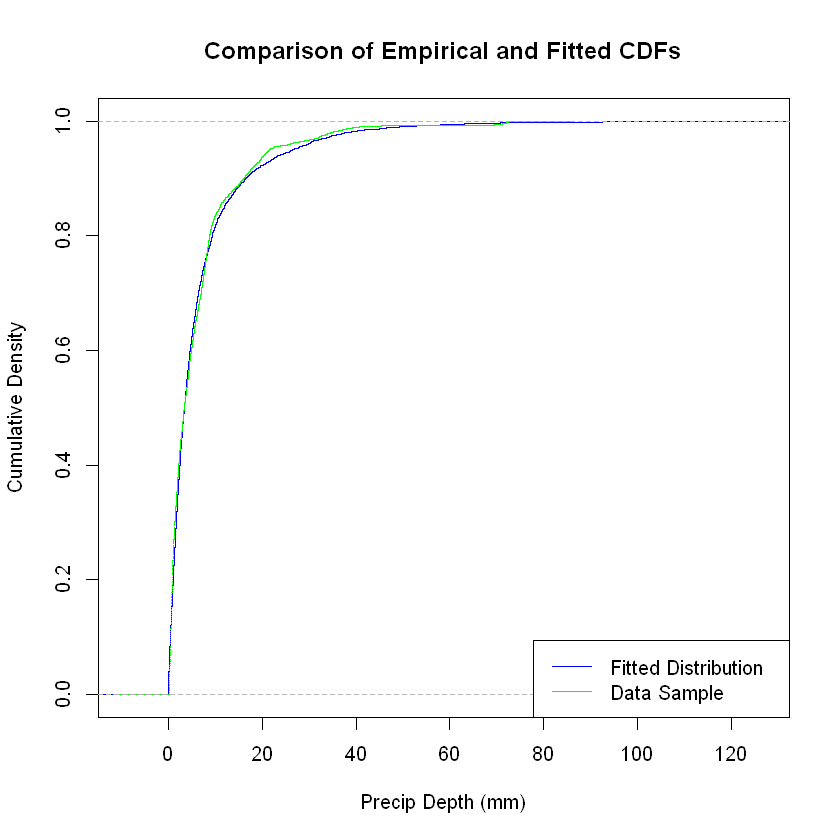

In [1258]:
x <- seq(0,wNov4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfNov4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1259]:
MonDistDF[55, ] <- list( 11, 4, fdGM_Nov4_shape, fdGM_Nov4_rate, fdGM_Nov4_llike, fdGM_Nov4_mean,
                        fdGM_Nov4_var, fdGM_Nov4_KSStat, fdGM_Nov4_KSp, fdME_Nov4_rate1,
                        fdME_Nov4_rate2, fdME_Nov4_lambda, fdME_Nov4_mean1, fdME_Nov4_mean2,
                        fdME_Nov4_mean, fdME_Nov4_var1, fdME_Nov4_var2, fdME_Nov4_var,
                        fdME_Nov4_llike, fdME_Nov4_KSStat, fdME_Nov4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

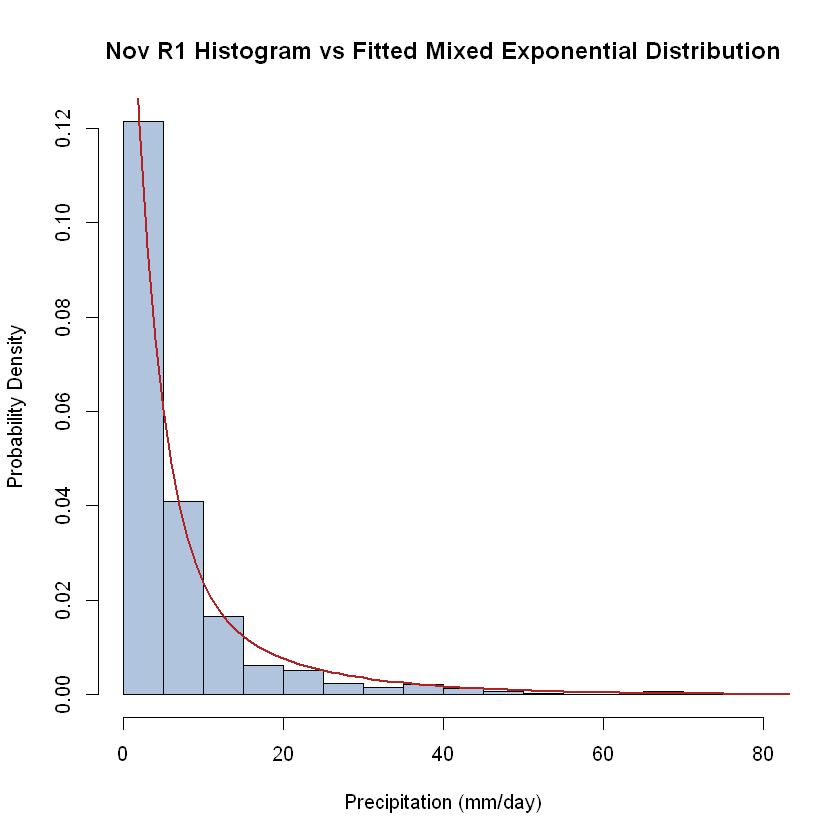

In [1260]:
xVals <- seq(1, wNov1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Nov1_lambda, spec1="exp", arg1=list(rate=fdME_Nov1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Nov1_rate2) )
hist( dfNov1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Nov R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

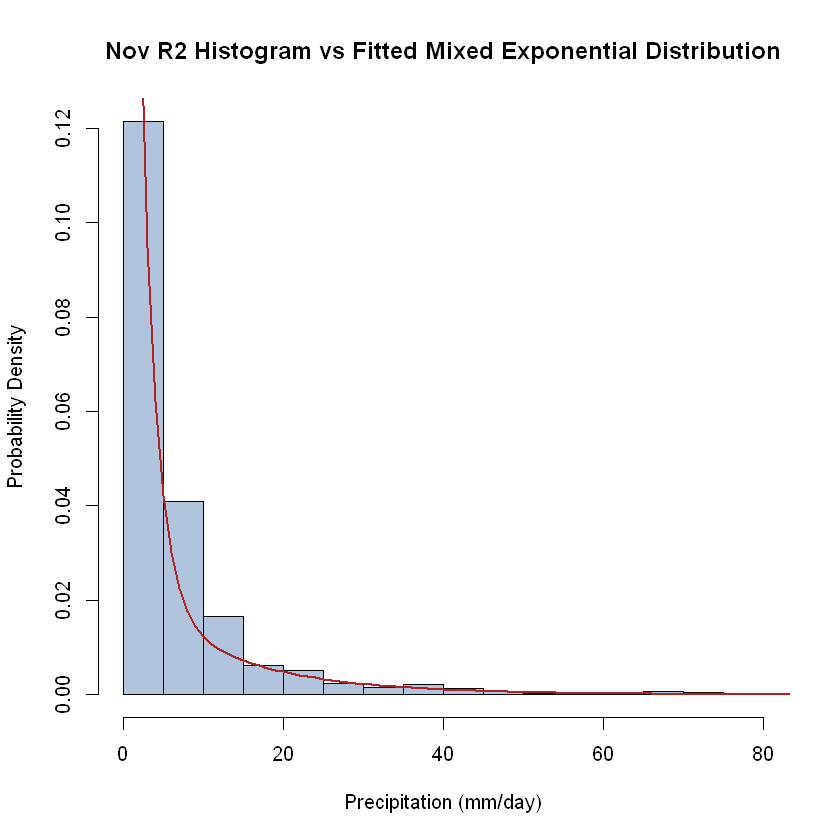

In [1261]:
xVals <- seq(1, wNov2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Nov2_lambda, spec1="exp", arg1=list(rate=fdME_Nov2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Nov2_rate2) )
hist( dfNov1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Nov R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

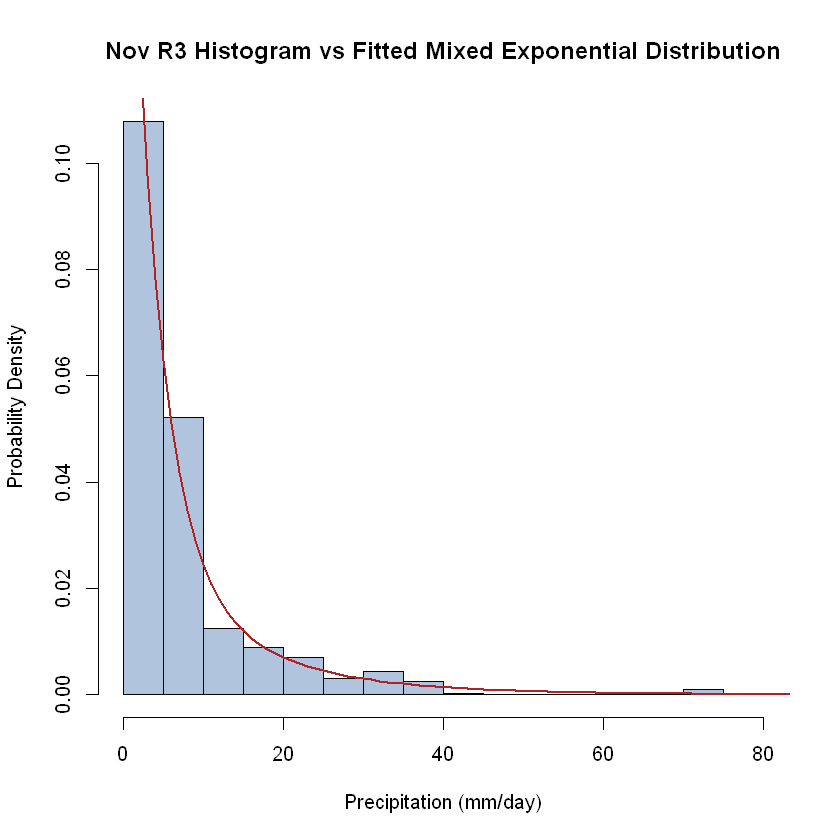

In [1262]:
xVals <- seq(1, wNov3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Nov3_lambda, spec1="exp", arg1=list(rate=fdME_Nov3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Nov3_rate2) )
hist( dfNov3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Nov R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

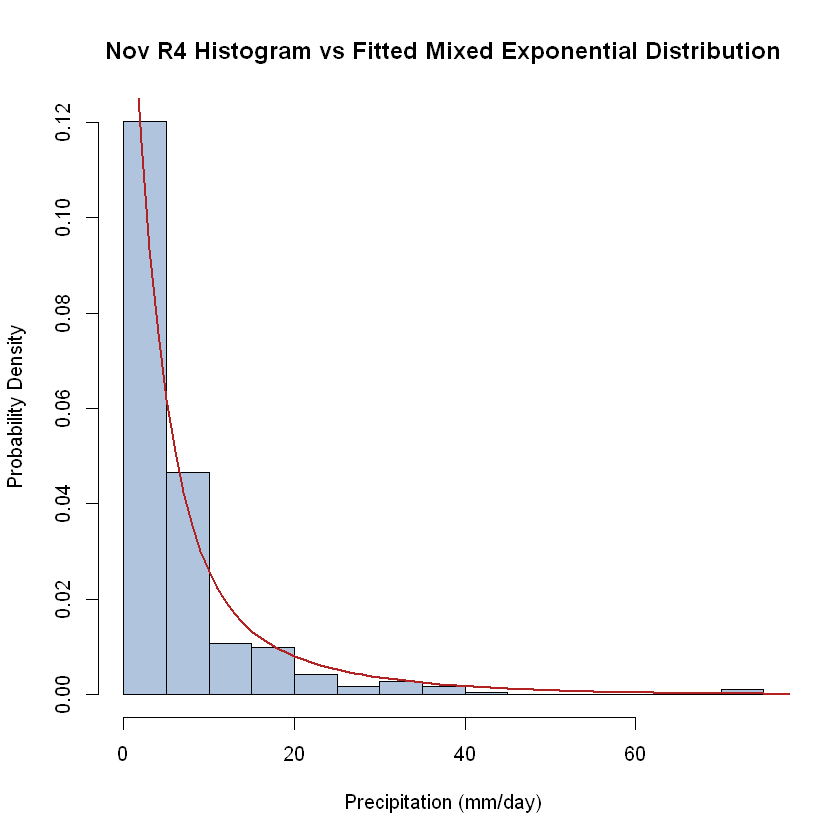

In [1263]:
xVals <- seq(1, wNov4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Nov4_lambda, spec1="exp", arg1=list(rate=fdME_Nov4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Nov4_rate2) )
hist( dfNov4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Nov R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

### Dec

#### All

**Gamma**

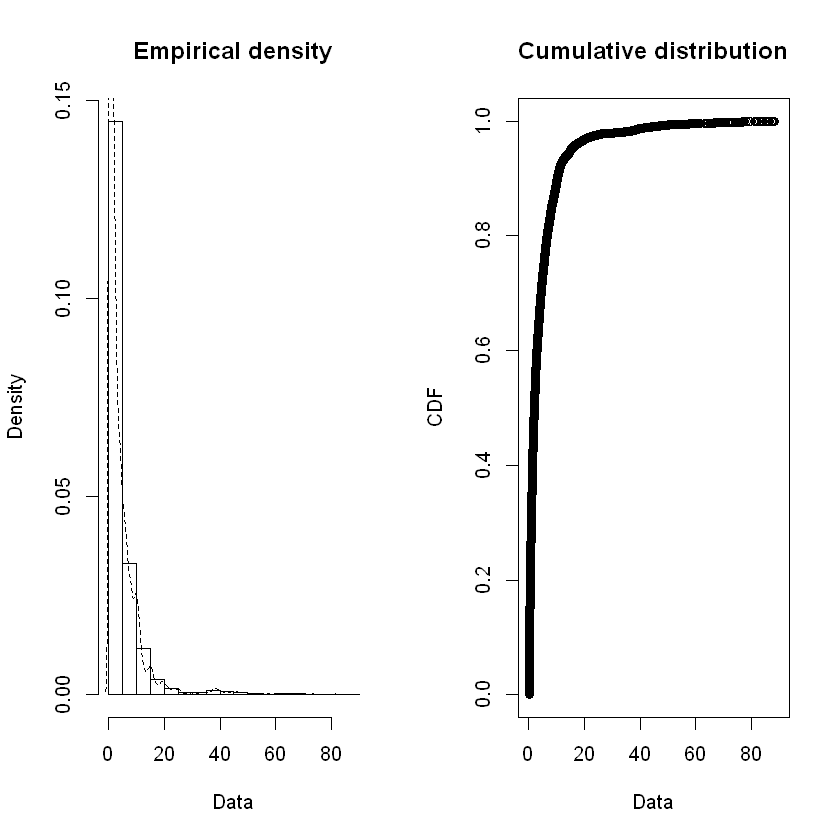

In [1264]:
plotdist( dfDec$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  88.15 
median:  2.14 
mean:  4.694202 
estimated sd:  7.878544 
estimated skewness:  4.893784 
estimated kurtosis:  34.91088 

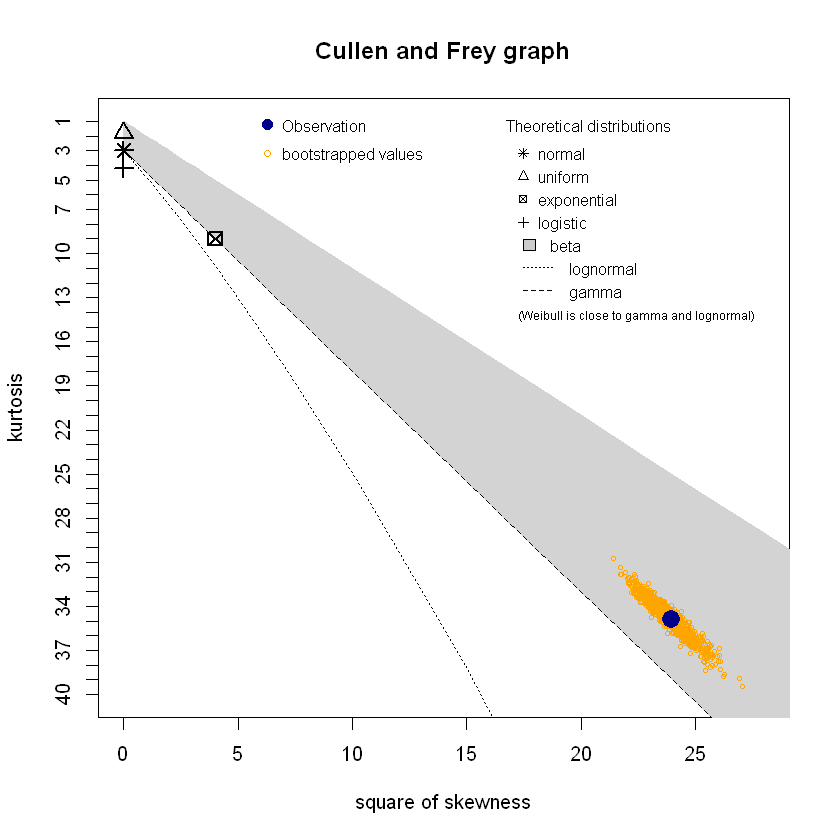

In [1265]:
descdist( dfDec$Precip_mm, boot=1000 )

In [1266]:
fd_GM_DecA <- fitdist( dfDec$Precip_mm, "gamma" )

In [1267]:
summary( fd_GM_DecA )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7877415 0.006057700
rate  0.1678403 0.001757878
Loglikelihood:  -63406.14   AIC:  126816.3   BIC:  126832.5 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7341853
rate  0.7341853 1.0000000


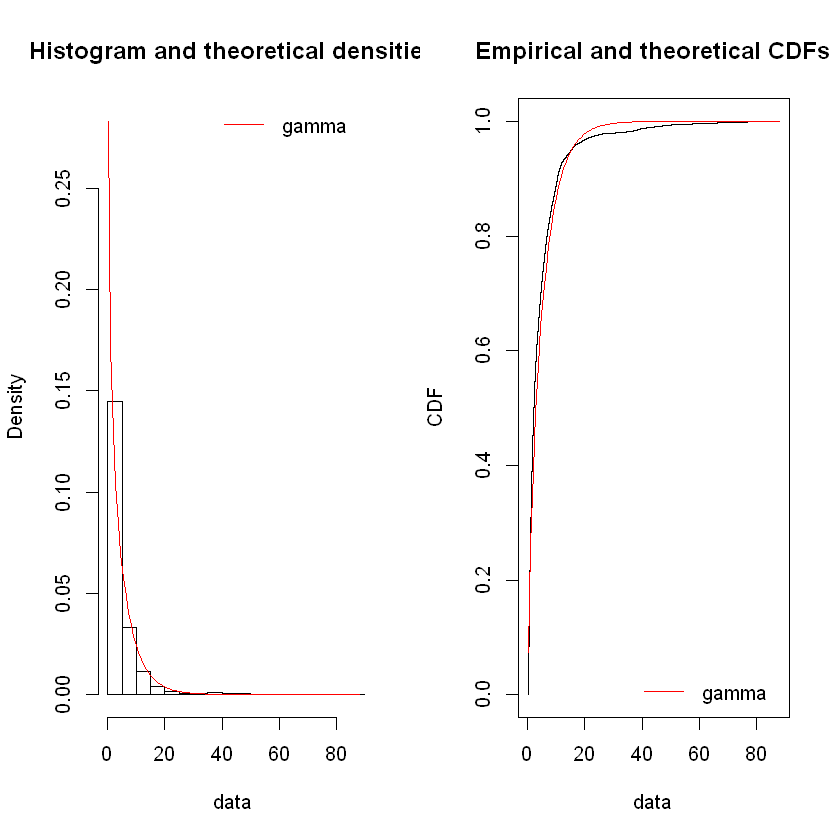

In [1268]:
par(mfrow = c(1, 2))
denscomp(fd_GM_DecA)
#qqcomp(fd_GM_DecA)
cdfcomp(fd_GM_DecA)
#ppcomp(fd_GM_DecA)

In [1269]:
fdGM_DecA_shape <- fd_GM_DecA$estimate[["shape"]]
fdGM_DecA_rate <- fd_GM_DecA$estimate[["rate"]]
fdGM_DecA_llike <- fd_GM_DecA$loglik
fdGM_DecA_mean <- fdGM_DecA_shape / fdGM_DecA_rate
fdGM_DecA_var <- fdGM_DecA_shape / ( fdGM_DecA_rate ^ 2 )
cat(" Dec A shape: ", fdGM_DecA_shape, "\n", "Dec A rate: ", fdGM_DecA_rate, 
    "\n", "Dec A loglikelihood: ", fdGM_DecA_llike, "\n", 
    "Dec A mean: ", fdGM_DecA_mean, "\n",
    "Dec A variance: ", fdGM_DecA_var, "\n" )

 Dec A shape:  0.7877415 
 Dec A rate:  0.1678403 
 Dec A loglikelihood:  -63406.14 
 Dec A mean:  4.6934 
 Dec A variance:  27.96349 


In [1270]:
statRes <- gofstat( fd_GM_DecA, fitnames=c("Gamma") )

In [1271]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.0925431
Cramer-von Mises statistic    79.3179586
Anderson-Darling statistic   473.0765190

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 126816.3
Bayesian Information Criterion 126832.5


In [1272]:
ksRes <- ks.test( dfDec$Precip_mm, "pgamma", shape=fdGM_DecA_shape, rate=fdGM_DecA_rate )

Warning message in ks.test(dfDec$Precip_mm, "pgamma", shape = fdGM_DecA_shape, rate = fdGM_DecA_rate):
"ties should not be present for the Kolmogorov-Smirnov test"

In [1273]:
fdGM_DecA_KSStat <- ksRes$statistic
fdGM_DecA_KSp <- ksRes$p.value
cat(" Dec A K-S stat: ", fdGM_DecA_KSStat, "\n",
    "Dec A K-S p-value: ", fdGM_DecA_KSp )

 Dec A K-S stat:  0.0925431 
 Dec A K-S p-value:  0

**Mixed Exponential**

In [1274]:
fd_ME_DecA <- expRMM_EM( dfDec$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                        rate=c(1.0/median(dfDec$Precip_mm), 1.0/mean(dfDec$Precip_mm)), k=2,
                       complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 246 


In [1275]:
summary( fd_ME_DecA )

summary of expRMM_EM object:
         comp 1   comp 2
lambda 0.881735 0.118265
rate   0.323061 0.060189
loglik at estimate:  -61571.6 
0 % of the data right censored


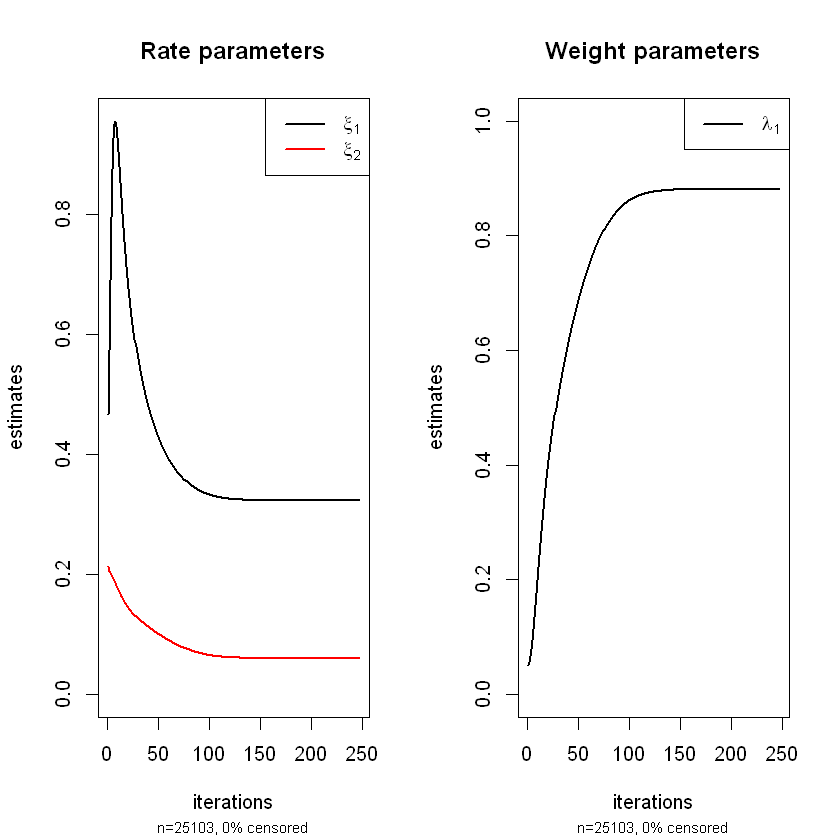

In [1276]:
plotexpRMM( fd_ME_DecA, lwd=2 )

In [1277]:
fdME_DecA_rate1 <- fd_ME_DecA$rate[[1]]
fdME_DecA_rate2 <- fd_ME_DecA$rate[[2]]
fdME_DecA_lambda <- fd_ME_DecA$lambda[[1]]
fdME_DecA_mean1 <- 1.0 / fdME_DecA_rate1
fdME_DecA_mean2 <- 1.0 / fdME_DecA_rate2
fdME_DecA_mean <- ( (fdME_DecA_lambda * fdME_DecA_mean1) + 
                    ( ( 1.0 - fdME_DecA_lambda) * fdME_DecA_mean2 ) )
fdME_DecA_var1 <- 1.0 / (fdME_DecA_rate1 ^ 2)
fdME_DecA_var2 <- 1.0 / (fdME_DecA_rate2 ^ 2)
fdME_DecA_var <- ( (fdME_DecA_lambda * ( fdME_DecA_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_DecA_lambda) * (fdME_DecA_mean2 ^ 2) ) + 
                   ( fdME_DecA_lambda * ( 1.0 - fdME_DecA_lambda) * 
                       ( fdME_DecA_mean1 - fdME_DecA_mean2 )^2 ) )
fdME_DecA_llike <- fd_ME_DecA$loglik
cat(" Dec A rate1: ", fdME_DecA_rate1, "\n", 
    "Dec A rate2: ", fdME_DecA_rate2, "\n",
    "Dec A lambda: ", fdME_DecA_lambda, "\n",
    "Dec A mean1: ", fdME_DecA_mean1, "\n",
    "Dec A mean2: ", fdME_DecA_mean2, "\n",
    "Dec A mean: ", fdME_DecA_mean, "\n",
    "Dec A var1: ", fdME_DecA_var1, "\n",
    "Dec A var2: ", fdME_DecA_var2, "\n",
    "Dec A var: ", fdME_DecA_var, "\n",
    "Dec A loglikelihood: ", fdME_DecA_llike, "\n" )

 Dec A rate1:  0.3230611 
 Dec A rate2:  0.06018901 
 Dec A lambda:  0.8817354 
 Dec A mean1:  3.09539 
 Dec A mean2:  16.61433 
 Dec A mean:  4.694202 
 Dec A var1:  9.581439 
 Dec A var2:  276.0359 
 Dec A var:  60.15162 
 Dec A loglikelihood:  -61571.6 


In [1278]:
tvals <- rexpmix(length(dfDec$Precip_mm), fd_ME_DecA$lambda, fd_ME_DecA$rate )

In [1279]:
ksRes <- ks.test( dfDec$Precip_mm, tvals )

Warning message in ks.test(dfDec$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1280]:
fdME_DecA_KSStat <- ksRes$statistic
fdME_DecA_KSp <- ksRes$p.value
cat(" Dec A K-S stat: ", fdME_DecA_KSStat, "\n",
    "Dec A K-S p-value: ", fdME_DecA_KSp )

 Dec A K-S stat:  0.05732383 
 Dec A K-S p-value:  0

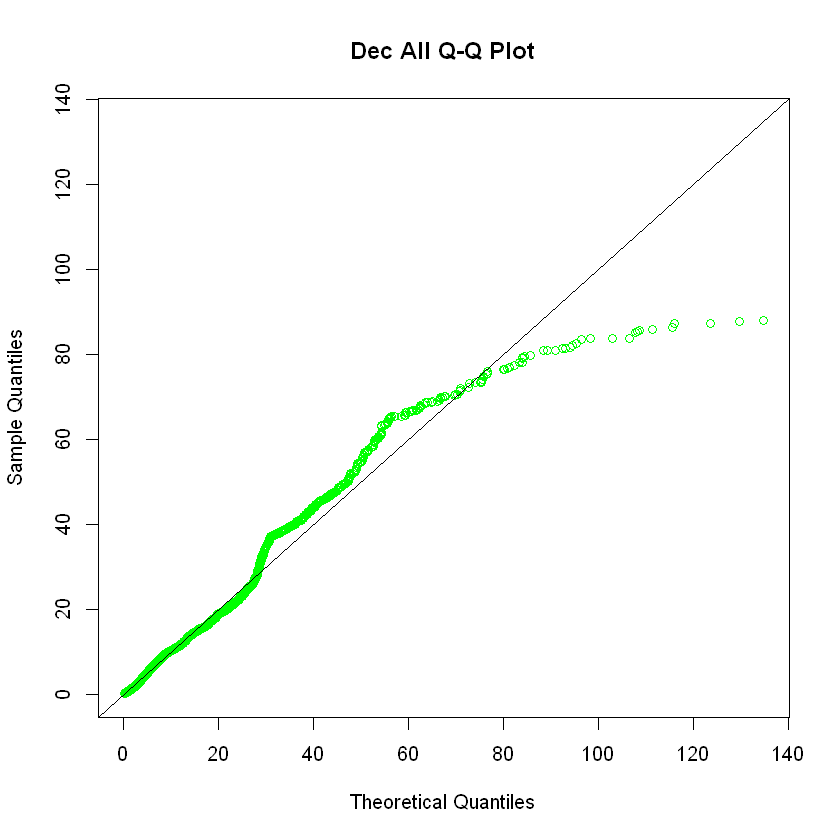

In [1281]:
wDecAMax <- max( max( dfDec$Precip_mm ), max( tvals ) )
qqplot( tvals, dfDec$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Dec All Q-Q Plot",
        xlim=c(0,wDecAMax), ylim=c(0,wDecAMax) )
abline( 0, 1)

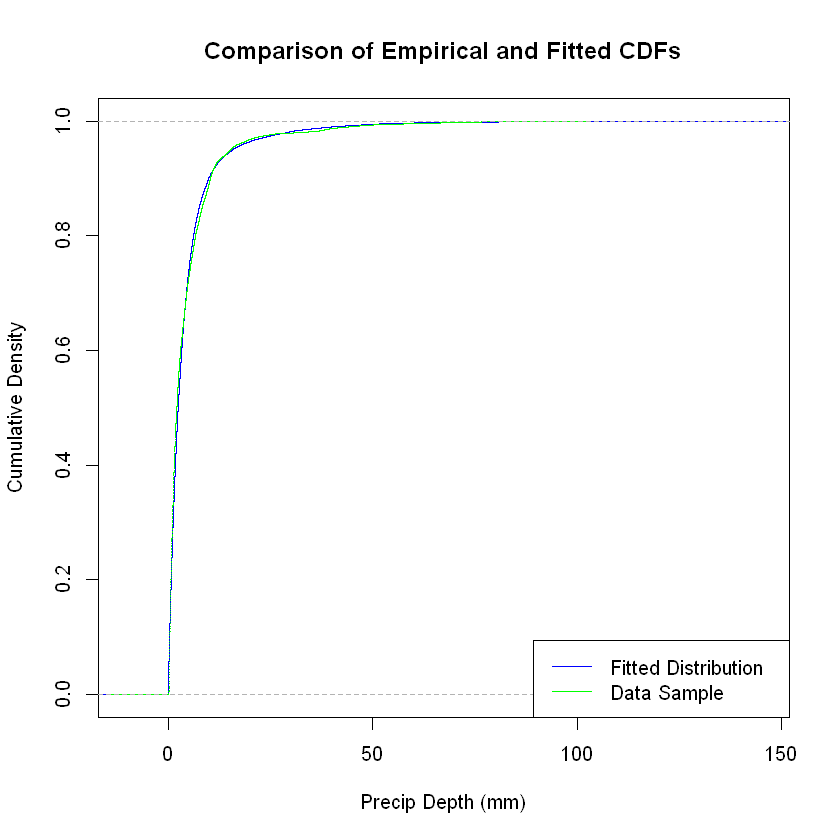

In [1282]:
x <- seq(0,wDecAMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfDec$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign values to our tracking DataFrame

In [1283]:
MonDistDF[56, ] <- list( 12, 0, fdGM_DecA_shape, fdGM_DecA_rate, fdGM_DecA_llike, fdGM_DecA_mean,
                        fdGM_DecA_var, fdGM_DecA_KSStat, fdGM_DecA_KSp, fdME_DecA_rate1,
                        fdME_DecA_rate2, fdME_DecA_lambda, fdME_DecA_mean1, fdME_DecA_mean2,
                        fdME_DecA_mean, fdME_DecA_var1, fdME_DecA_var2, fdME_DecA_var,
                        fdME_DecA_llike, fdME_DecA_KSStat, fdME_DecA_KSp )

#### Region 1

**Gamma**

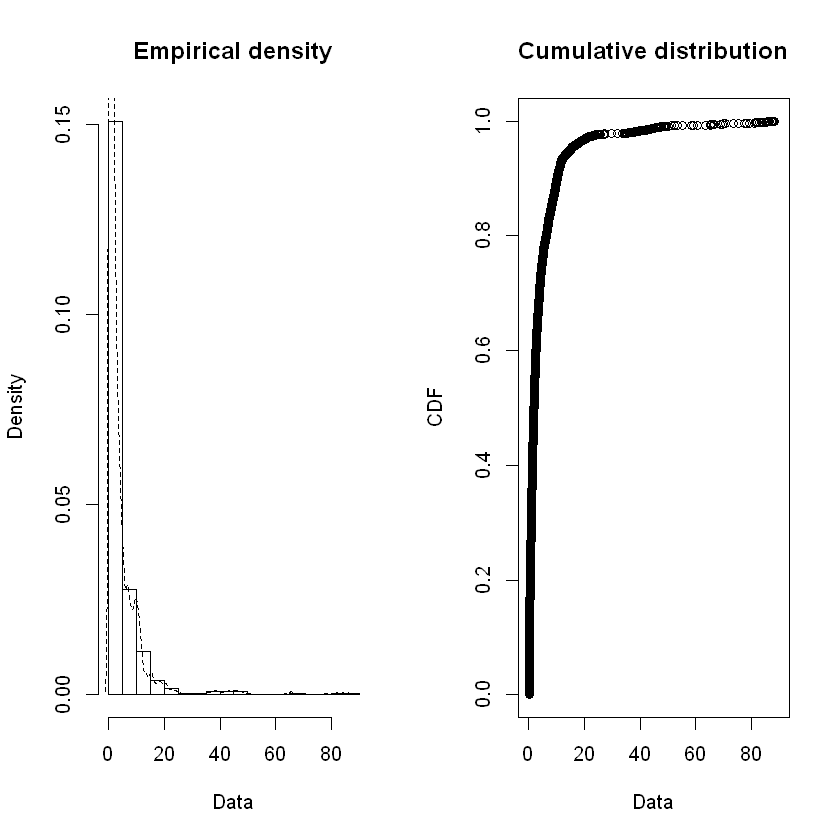

In [1284]:
plotdist( dfDec1$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  88.15 
median:  1.99 
mean:  4.653182 
estimated sd:  8.798676 
estimated skewness:  5.465719 
estimated kurtosis:  40.60319 

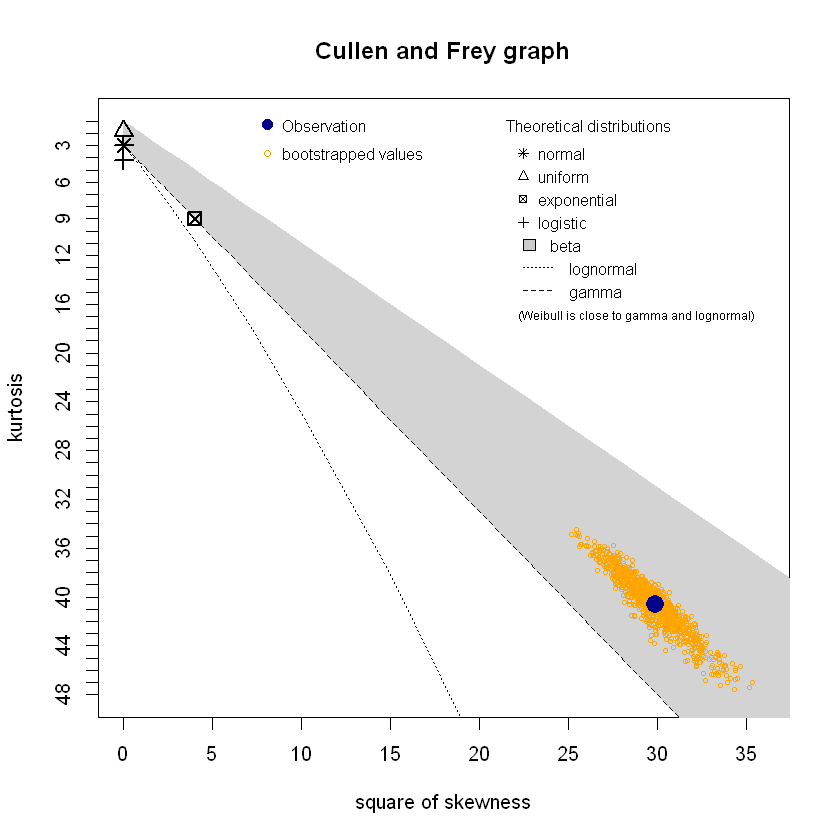

In [1285]:
descdist( dfDec1$Precip_mm, boot=1000 )

In [1286]:
fd_GM_Dec1 <- fitdist( dfDec1$Precip_mm, "gamma" )

In [1287]:
summary( fd_GM_Dec1 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate Std. Error
shape 0.7478378 0.01184095
rate  0.1607102 0.00351616
Loglikelihood:  -14697.34   AIC:  29398.68   BIC:  29412.03 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7236454
rate  0.7236454 1.0000000


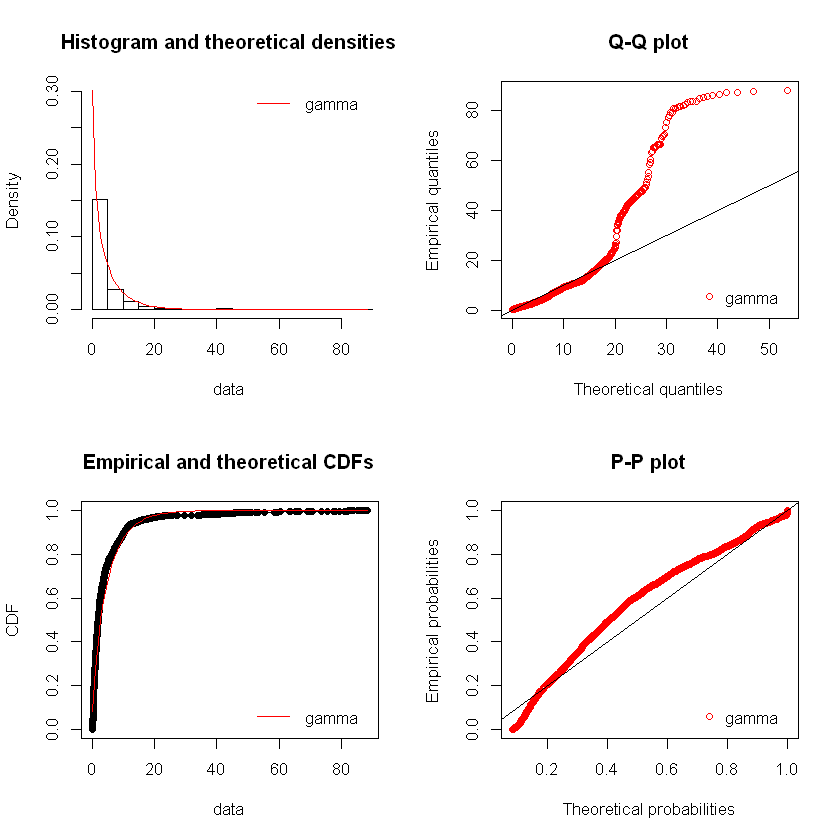

In [1288]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Dec1)
qqcomp(fd_GM_Dec1)
cdfcomp(fd_GM_Dec1)
ppcomp(fd_GM_Dec1)

In [1289]:
fdGM_Dec1_shape <- fd_GM_Dec1$estimate[["shape"]]
fdGM_Dec1_rate <- fd_GM_Dec1$estimate[["rate"]]
fdGM_Dec1_llike <- fd_GM_Dec1$loglik
fdGM_Dec1_mean <- fdGM_Dec1_shape / fdGM_Dec1_rate
fdGM_Dec1_var <- fdGM_Dec1_shape / ( fdGM_Dec1_rate ^ 2 )
cat(" Dec 1 shape: ", fdGM_Dec1_shape, "\n", "Dec 1 rate: ", fdGM_Dec1_rate, 
    "\n", "Dec 1 loglikelihood: ", fdGM_Dec1_llike, "\n", 
    "Dec 1 mean: ", fdGM_Dec1_mean, "\n",
    "Dec 1 variance: ", fdGM_Dec1_var, "\n" )

 Dec 1 shape:  0.7478378 
 Dec 1 rate:  0.1607102 
 Dec 1 loglikelihood:  -14697.34 
 Dec 1 mean:  4.653332 
 Dec 1 variance:  28.9548 


In [1290]:
statRes <- gofstat( fd_GM_Dec1, fitnames=c("Gamma") )

In [1291]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1148383
Cramer-von Mises statistic    26.6342518
Anderson-Darling statistic   151.0284891

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 29398.68
Bayesian Information Criterion 29412.03


In [1292]:
ksRes <- ks.test( dfDec1$Precip_mm, "pgamma", shape=fdGM_Dec1_shape, rate=fdGM_Dec1_rate )

Warning message in ks.test(dfDec1$Precip_mm, "pgamma", shape = fdGM_Dec1_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1293]:
fdGM_Dec1_KSStat <- ksRes$statistic
fdGM_Dec1_KSp <- ksRes$p.value
cat(" Dec 1 K-S stat: ", fdGM_Dec1_KSStat, "\n",
    "Dec 1 K-S p-value: ", fdGM_Dec1_KSp )

 Dec 1 K-S stat:  0.1148383 
 Dec 1 K-S p-value:  0

**Mixed exponential**

In [1294]:
fd_ME_Dec1 <- expRMM_EM( dfDec1$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfDec1$Precip_mm), 1.0/mean(dfDec1$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 190 


In [1295]:
summary( fd_ME_Dec1 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.889894 0.1101061
rate   0.346304 0.0528469
loglik at estimate:  -14095.62 
0 % of the data right censored


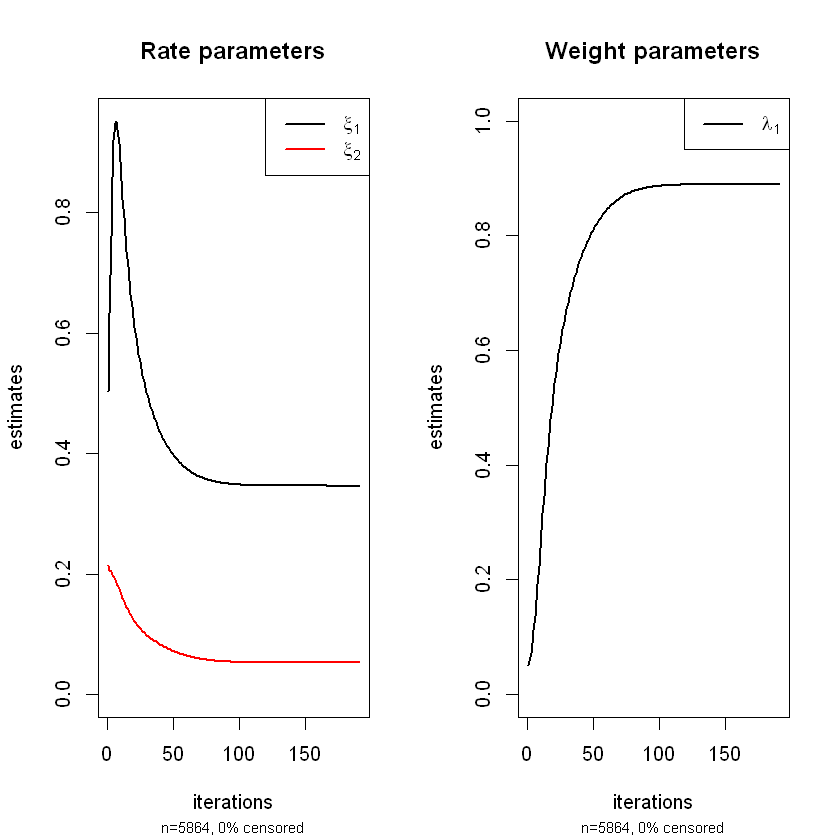

In [1296]:
plotexpRMM( fd_ME_Dec1, lwd=2 )

In [1297]:
fdME_Dec1_rate1 <- fd_ME_Dec1$rate[[1]]
fdME_Dec1_rate2 <- fd_ME_Dec1$rate[[2]]
fdME_Dec1_lambda <- fd_ME_Dec1$lambda[[1]]
fdME_Dec1_mean1 <- 1.0 / fdME_Dec1_rate1
fdME_Dec1_mean2 <- 1.0 / fdME_Dec1_rate2
fdME_Dec1_mean <- ( (fdME_Dec1_lambda * fdME_Dec1_mean1) + 
                    ( ( 1.0 - fdME_Dec1_lambda) * fdME_Dec1_mean2 ) )
fdME_Dec1_var1 <- 1.0 / (fdME_Dec1_rate1 ^ 2)
fdME_Dec1_var2 <- 1.0 / (fdME_Dec1_rate2 ^ 2)
fdME_Dec1_var <- ( (fdME_Dec1_lambda * ( fdME_Dec1_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Dec1_lambda) * (fdME_Dec1_mean2 ^ 2) ) + 
                   ( fdME_Dec1_lambda * ( 1.0 - fdME_Dec1_lambda) * 
                       ( fdME_Dec1_mean1 - fdME_Dec1_mean2 )^2 ) )
fdME_Dec1_llike <- fd_ME_Dec1$loglik
cat(" Dec 1 rate1: ", fdME_Dec1_rate1, "\n", 
    "Dec 1 rate2: ", fdME_Dec1_rate2, "\n",
    "Dec 1 lambda: ", fdME_Dec1_lambda, "\n",
    "Dec 1 mean1: ", fdME_Dec1_mean1, "\n",
    "Dec 1 mean2: ", fdME_Dec1_mean2, "\n",
    "Dec 1 mean: ", fdME_Dec1_mean, "\n",
    "Dec 1 var1: ", fdME_Dec1_var1, "\n",
    "Dec 1 var2: ", fdME_Dec1_var2, "\n",
    "Dec 1 var: ", fdME_Dec1_var, "\n",
    "Dec 1 loglikelihood: ", fdME_Dec1_llike, "\n" )

 Dec 1 rate1:  0.3463038 
 Dec 1 rate2:  0.05284694 
 Dec 1 lambda:  0.8898939 
 Dec 1 mean1:  2.887638 
 Dec 1 mean2:  18.92257 
 Dec 1 mean:  4.653182 
 Dec 1 var1:  8.338453 
 Dec 1 var2:  358.0637 
 Dec 1 var:  72.03857 
 Dec 1 loglikelihood:  -14095.62 


In [1298]:
tvals <- rexpmix(length(dfDec1$Precip_mm), fd_ME_Dec1$lambda, fd_ME_Dec1$rate )

In [1299]:
ksRes <- ks.test( dfDec1$Precip_mm, tvals )

Warning message in ks.test(dfDec1$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1300]:
fdME_Dec1_KSStat <- ksRes$statistic
fdME_Dec1_KSp <- ksRes$p.value
cat(" Dec 1 K-S stat: ", fdME_Dec1_KSStat, "\n",
    "Dec 1 K-S p-value: ", fdME_Dec1_KSp )

 Dec 1 K-S stat:  0.0665075 
 Dec 1 K-S p-value:  1.087253e-11

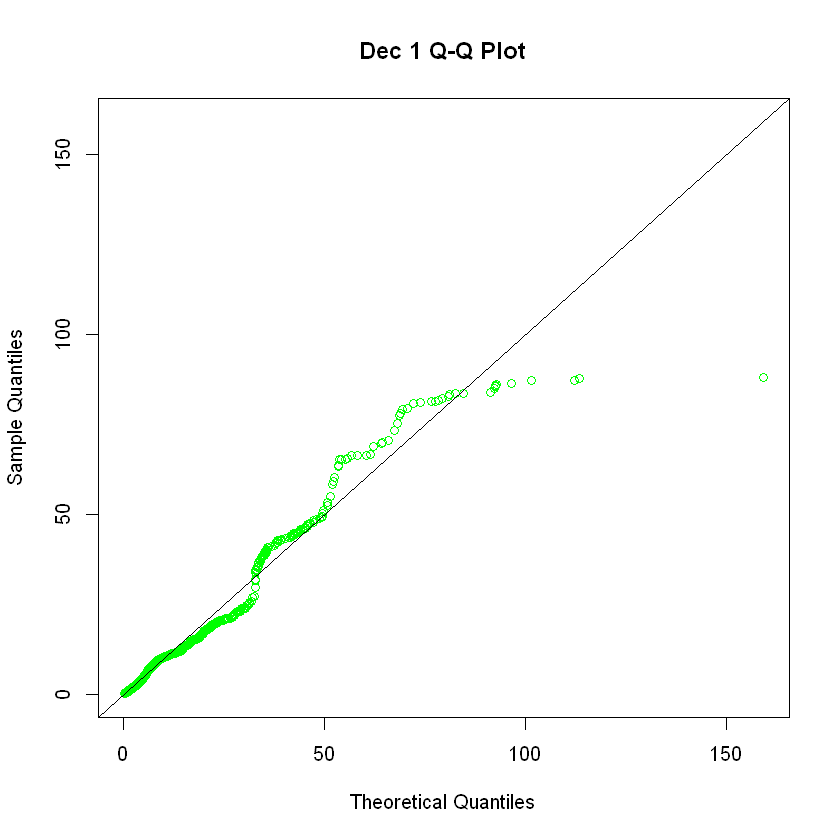

In [1301]:
wDec1Max <- max( max( dfDec1$Precip_mm ), max( tvals ) )
qqplot( tvals, dfDec1$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Dec 1 Q-Q Plot",
        xlim=c(0,wDec1Max), ylim=c(0,wDec1Max) )
abline( 0, 1)

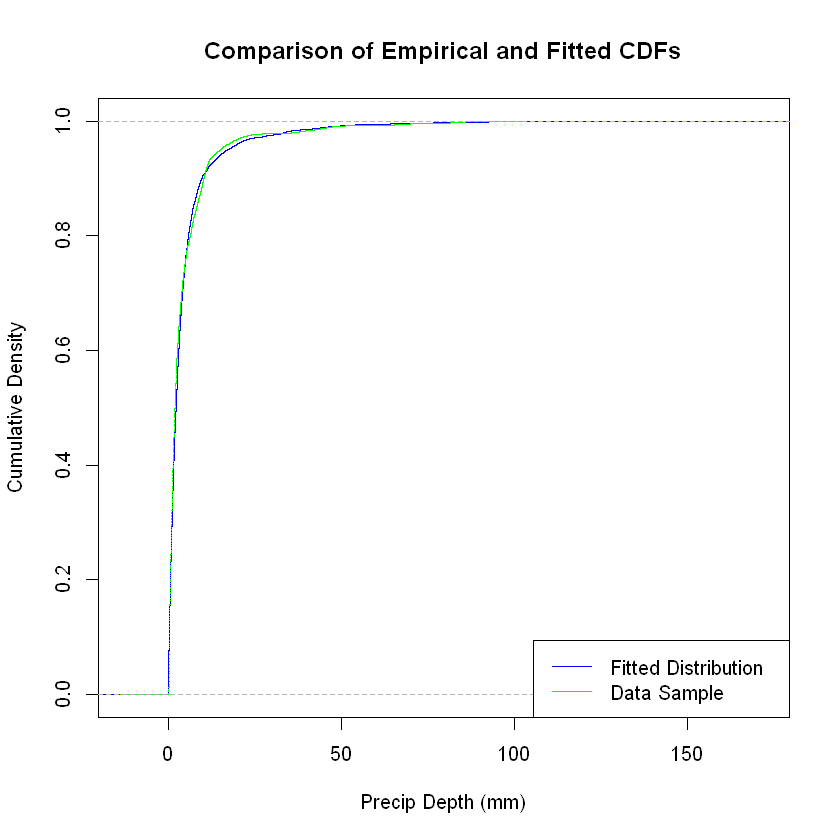

In [1302]:
x <- seq(0,wDec1Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfDec1$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1303]:
MonDistDF[57, ] <- list( 12, 1, fdGM_Dec1_shape, fdGM_Dec1_rate, fdGM_Dec1_llike, fdGM_Dec1_mean,
                        fdGM_Dec1_var, fdGM_Dec1_KSStat, fdGM_Dec1_KSp, fdME_Dec1_rate1,
                        fdME_Dec1_rate2, fdME_Dec1_lambda, fdME_Dec1_mean1, fdME_Dec1_mean2,
                        fdME_Dec1_mean, fdME_Dec1_var1, fdME_Dec1_var2, fdME_Dec1_var,
                        fdME_Dec1_llike, fdME_Dec1_KSStat, fdME_Dec1_KSp )

#### Region 2

**Gamma**

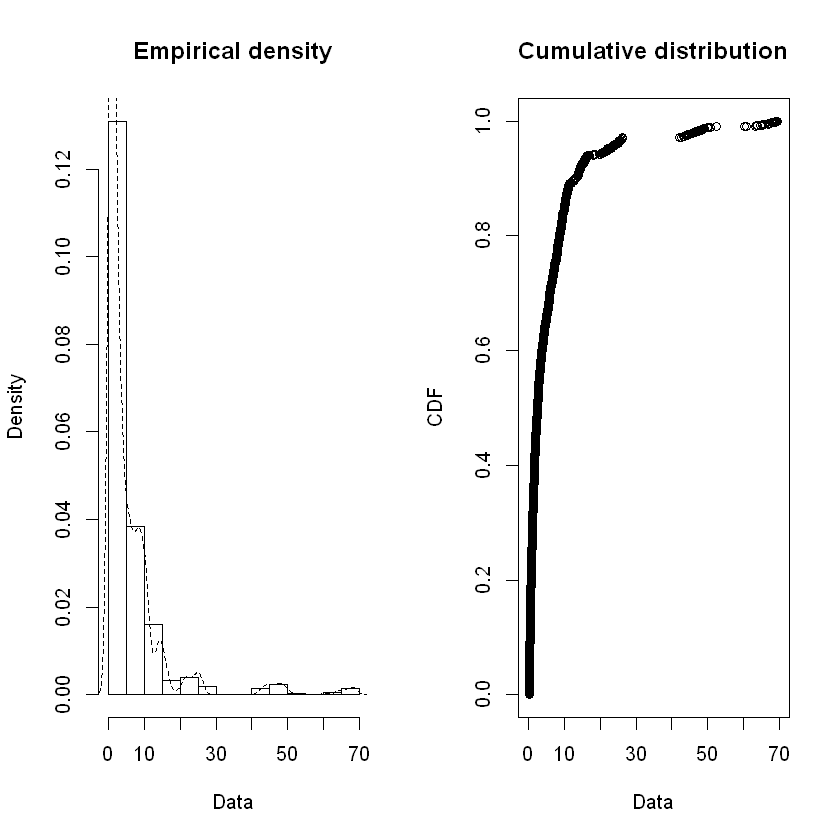

In [1304]:
plotdist( dfDec2$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  69.31 
median:  2.55 
mean:  5.937484 
estimated sd:  9.724609 
estimated skewness:  3.878957 
estimated kurtosis:  20.79264 

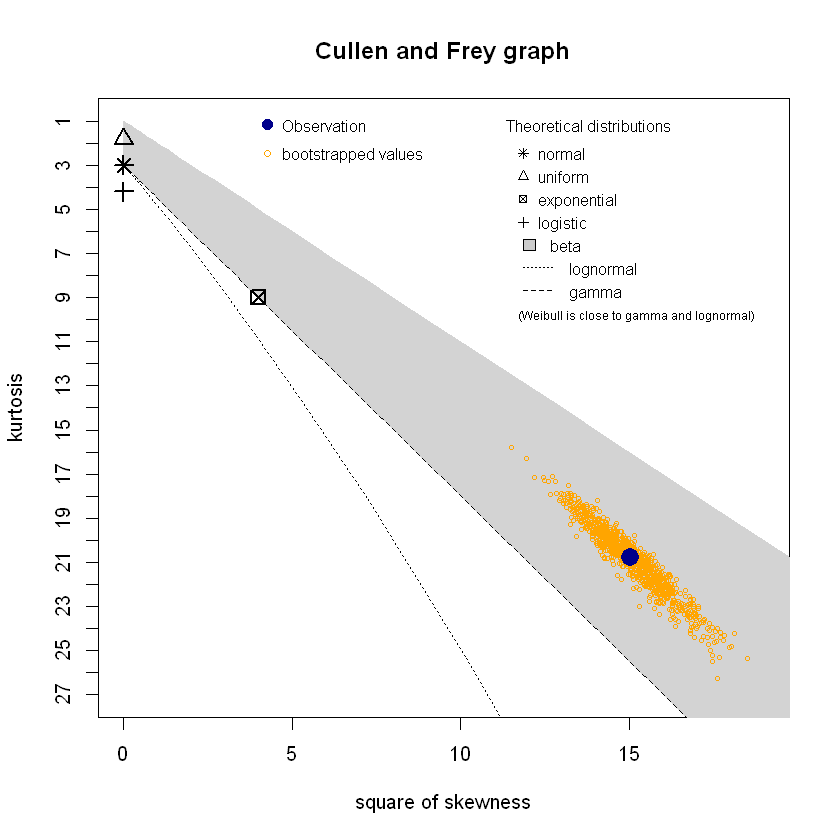

In [1305]:
descdist( dfDec2$Precip_mm, boot=1000 )

In [1306]:
fd_GM_Dec2 <- fitdist( dfDec2$Precip_mm, "gamma" )

In [1307]:
summary( fd_GM_Dec2 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
      estimate  Std. Error
shape 0.731254 0.017751956
rate  0.123150 0.004157391
Loglikelihood:  -6818.031   AIC:  13640.06   BIC:  13651.7 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7190248
rate  0.7190248 1.0000000


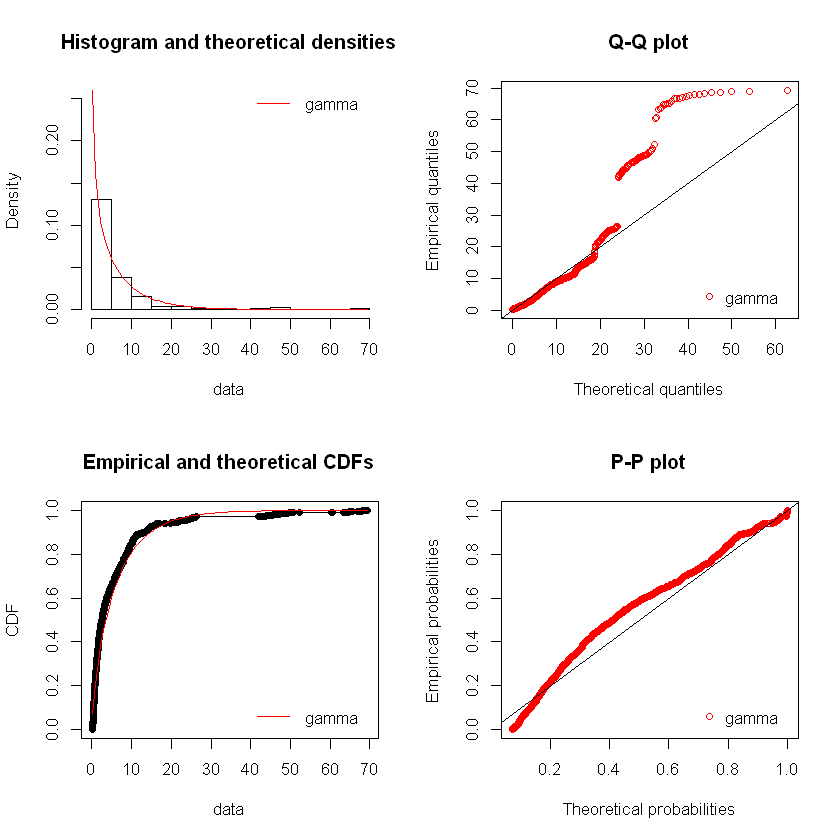

In [1308]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Dec2)
qqcomp(fd_GM_Dec2)
cdfcomp(fd_GM_Dec2)
ppcomp(fd_GM_Dec2)

In [1309]:
fdGM_Dec2_shape <- fd_GM_Dec2$estimate[["shape"]]
fdGM_Dec2_rate <- fd_GM_Dec2$estimate[["rate"]]
fdGM_Dec2_llike <- fd_GM_Dec2$loglik
fdGM_Dec2_mean <- fdGM_Dec2_shape / fdGM_Dec2_rate
fdGM_Dec2_var <- fdGM_Dec2_shape / ( fdGM_Dec2_rate ^ 2 )
cat(" Dec 2 shape: ", fdGM_Dec2_shape, "\n", "Dec 2 rate: ", fdGM_Dec2_rate, 
    "\n", "Dec 2 loglikelihood: ", fdGM_Dec2_llike, "\n", 
    "Dec 2 mean: ", fdGM_Dec2_mean, "\n",
    "Dec 2 variance: ", fdGM_Dec2_var, "\n" )

 Dec 2 shape:  0.731254 
 Dec 2 rate:  0.12315 
 Dec 2 loglikelihood:  -6818.031 
 Dec 2 mean:  5.937912 
 Dec 2 variance:  48.2169 


In [1310]:
statRes <- gofstat( fd_GM_Dec2, fitnames=c("Gamma") )

In [1311]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic  0.09606599
Cramer-von Mises statistic    7.67771485
Anderson-Darling statistic   47.17914018

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 13640.06
Bayesian Information Criterion 13651.70


In [1312]:
ksRes <- ks.test( dfDec2$Precip_mm, "pgamma", shape=fdGM_Dec2_shape, rate=fdGM_Dec2_rate )

Warning message in ks.test(dfDec2$Precip_mm, "pgamma", shape = fdGM_Dec2_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1313]:
fdGM_Dec2_KSStat <- ksRes$statistic
fdGM_Dec2_KSp <- ksRes$p.value
cat(" Dec 2 K-S stat: ", fdGM_Dec2_KSStat, "\n",
    "Dec 2 K-S p-value: ", fdGM_Dec2_KSp )

 Dec 2 K-S stat:  0.09606599 
 Dec 2 K-S p-value:  0

**Mixed exponential**

In [1314]:
fd_ME_Dec2 <- expRMM_EM( dfDec2$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfDec2$Precip_mm), 1.0/mean(dfDec2$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 232 


In [1315]:
summary( fd_ME_Dec2 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.840233 0.1597673
rate   0.283773 0.0536753
loglik at estimate:  -6644.015 
0 % of the data right censored


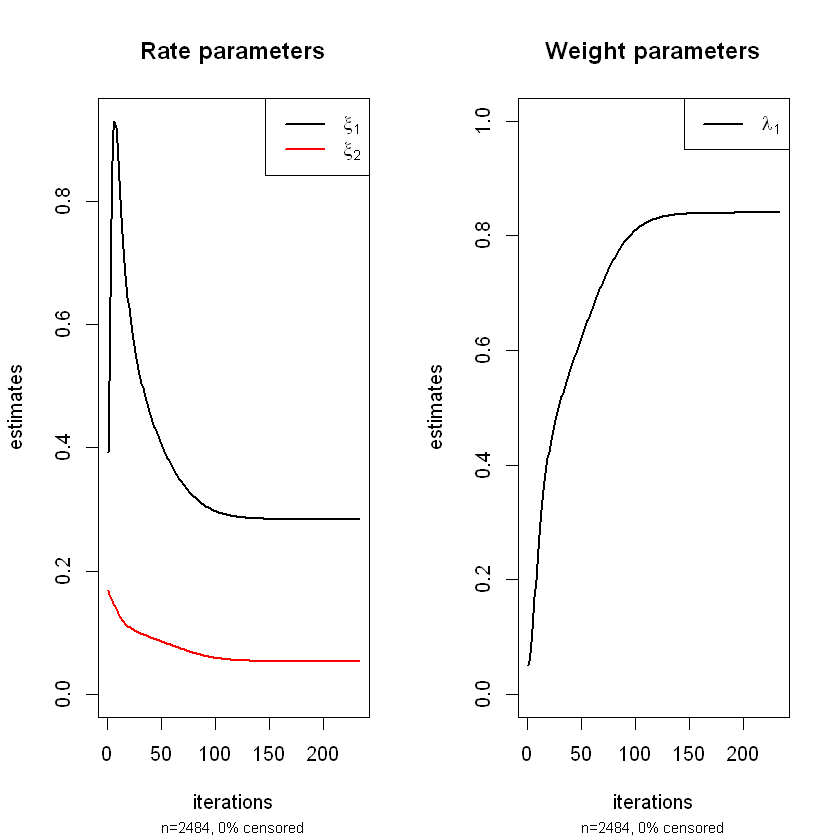

In [1316]:
plotexpRMM( fd_ME_Dec2, lwd=2 )

In [1317]:
fdME_Dec2_rate1 <- fd_ME_Dec2$rate[[1]]
fdME_Dec2_rate2 <- fd_ME_Dec2$rate[[2]]
fdME_Dec2_lambda <- fd_ME_Dec2$lambda[[1]]
fdME_Dec2_mean1 <- 1.0 / fdME_Dec2_rate1
fdME_Dec2_mean2 <- 1.0 / fdME_Dec2_rate2
fdME_Dec2_mean <- ( (fdME_Dec2_lambda * fdME_Dec2_mean1) + 
                    ( ( 1.0 - fdME_Dec2_lambda) * fdME_Dec2_mean2 ) )
fdME_Dec2_var1 <- 1.0 / (fdME_Dec2_rate1 ^ 2)
fdME_Dec2_var2 <- 1.0 / (fdME_Dec2_rate2 ^ 2)
fdME_Dec2_var <- ( (fdME_Dec2_lambda * ( fdME_Dec2_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Dec2_lambda) * (fdME_Dec2_mean2 ^ 2) ) + 
                   ( fdME_Dec2_lambda * ( 1.0 - fdME_Dec2_lambda) * 
                       ( fdME_Dec2_mean1 - fdME_Dec2_mean2 )^2 ) )
fdME_Dec2_llike <- fd_ME_Dec2$loglik
cat(" Dec 2 rate1: ", fdME_Dec2_rate1, "\n", 
    "Dec 2 rate2: ", fdME_Dec2_rate2, "\n",
    "Dec 2 lambda: ", fdME_Dec2_lambda, "\n",
    "Dec 2 mean1: ", fdME_Dec2_mean1, "\n",
    "Dec 2 mean2: ", fdME_Dec2_mean2, "\n",
    "Dec 2 mean: ", fdME_Dec2_mean, "\n",
    "Dec 2 var1: ", fdME_Dec2_var1, "\n",
    "Dec 2 var2: ", fdME_Dec2_var2, "\n",
    "Dec 2 var: ", fdME_Dec2_var, "\n",
    "Dec 2 loglikelihood: ", fdME_Dec2_llike, "\n" )

 Dec 2 rate1:  0.283773 
 Dec 2 rate2:  0.05367532 
 Dec 2 lambda:  0.8402327 
 Dec 2 mean1:  3.523944 
 Dec 2 mean2:  18.63054 
 Dec 2 mean:  5.937484 
 Dec 2 var1:  12.41818 
 Dec 2 var2:  347.0969 
 Dec 2 var:  96.5241 
 Dec 2 loglikelihood:  -6644.015 


In [1318]:
tvals <- rexpmix(length(dfDec2$Precip_mm), fd_ME_Dec2$lambda, fd_ME_Dec2$rate )

In [1319]:
ksRes <- ks.test( dfDec2$Precip_mm, tvals )

Warning message in ks.test(dfDec2$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1320]:
fdME_Dec2_KSStat <- ksRes$statistic
fdME_Dec2_KSp <- ksRes$p.value
cat(" Dec 2 K-S stat: ", fdME_Dec2_KSStat, "\n",
    "Dec 2 K-S p-value: ", fdME_Dec2_KSp )

 Dec 2 K-S stat:  0.05837359 
 Dec 2 K-S p-value:  0.0004217813

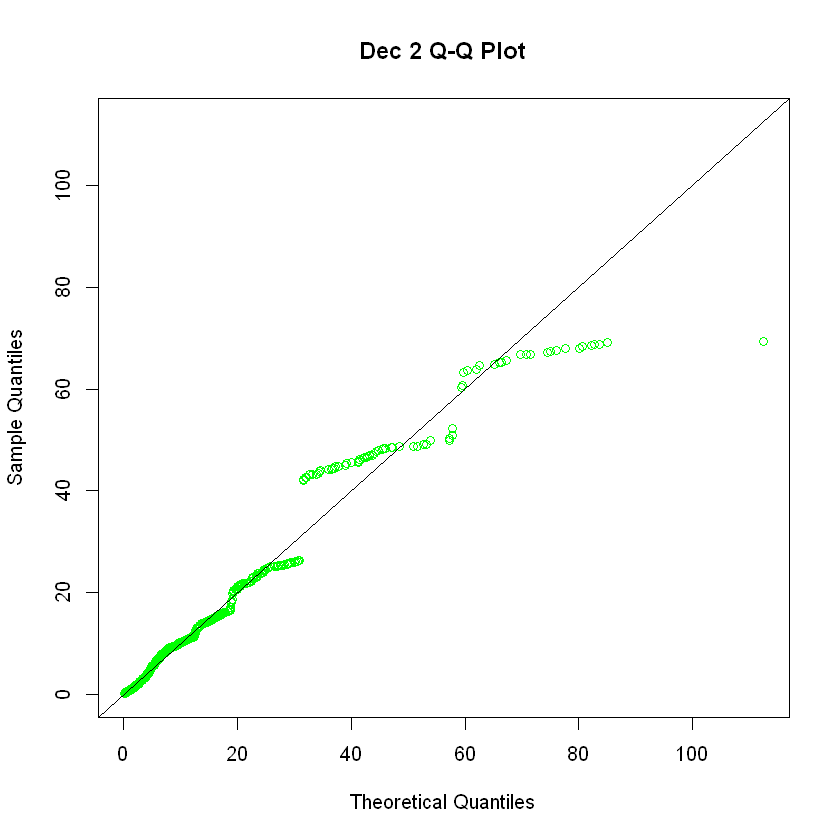

In [1321]:
wDec2Max <- max( max( dfDec2$Precip_mm ), max( tvals ) )
qqplot( tvals, dfDec2$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Dec 2 Q-Q Plot",
        xlim=c(0,wDec2Max), ylim=c(0,wDec2Max) )
abline( 0, 1)

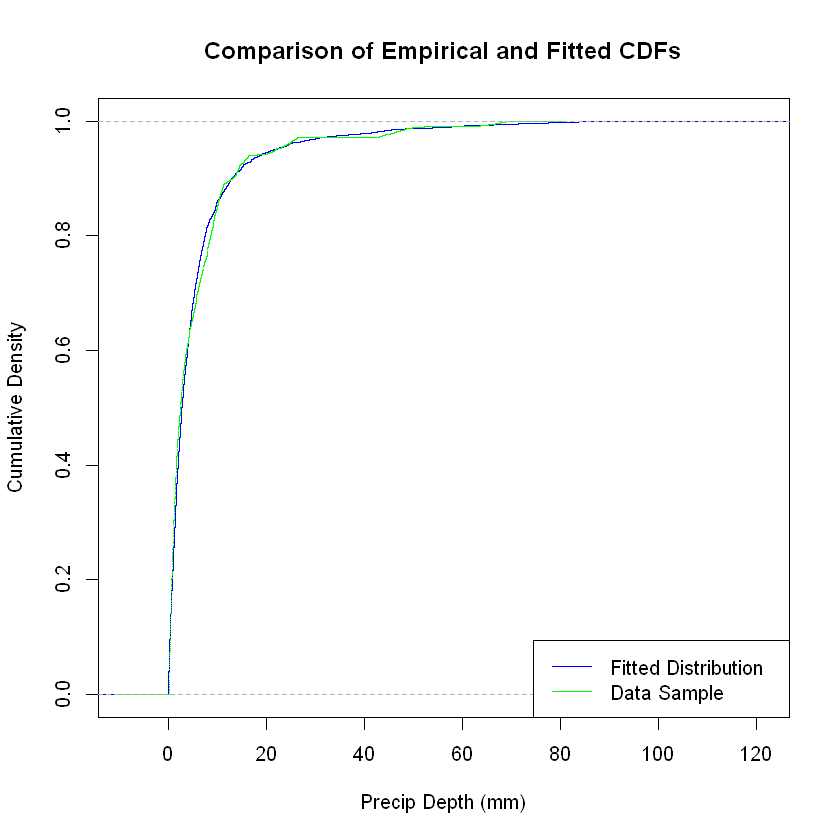

In [1322]:
x <- seq(0,wDec2Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfDec2$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1323]:
MonDistDF[58, ] <- list( 12, 2, fdGM_Dec2_shape, fdGM_Dec2_rate, fdGM_Dec2_llike, fdGM_Dec2_mean,
                        fdGM_Dec2_var, fdGM_Dec2_KSStat, fdGM_Dec2_KSp, fdME_Dec2_rate1,
                        fdME_Dec2_rate2, fdME_Dec2_lambda, fdME_Dec2_mean1, fdME_Dec2_mean2,
                        fdME_Dec2_mean, fdME_Dec2_var1, fdME_Dec2_var2, fdME_Dec2_var,
                        fdME_Dec2_llike, fdME_Dec2_KSStat, fdME_Dec2_KSp )

#### Region 3

**Gamma**

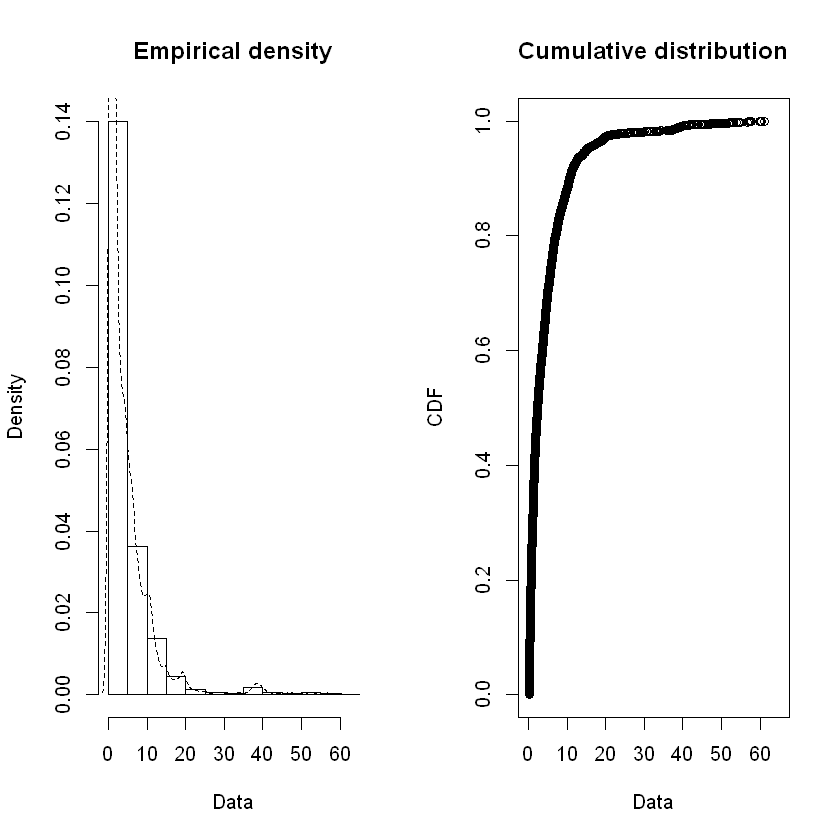

In [1324]:
plotdist( dfDec3$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  61.09 
median:  2.38 
mean:  4.707013 
estimated sd:  6.816466 
estimated skewness:  3.850962 
estimated kurtosis:  22.57166 

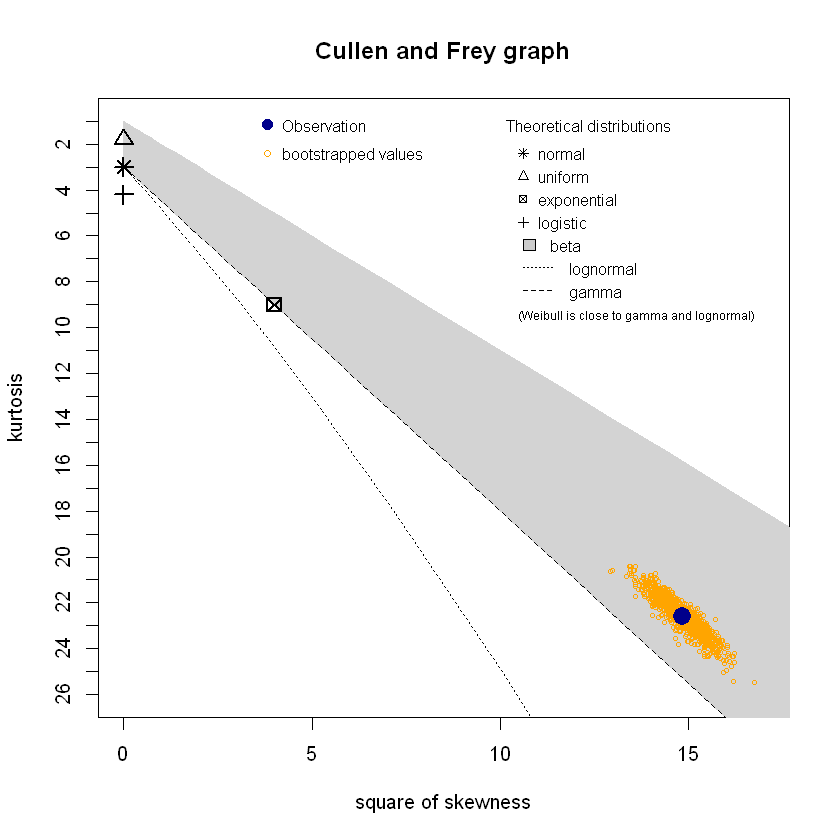

In [1325]:
descdist( dfDec3$Precip_mm, boot=1000 )

In [1326]:
fd_GM_Dec3 <- fitdist( dfDec3$Precip_mm, "gamma" )

In [1327]:
summary( fd_GM_Dec3 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.8333719 0.010117290
rate  0.1770409 0.002883413
Loglikelihood:  -25825.67   AIC:  51655.34   BIC:  51669.8 
Correlation matrix:
          shape      rate
shape 1.0000000 0.7453649
rate  0.7453649 1.0000000


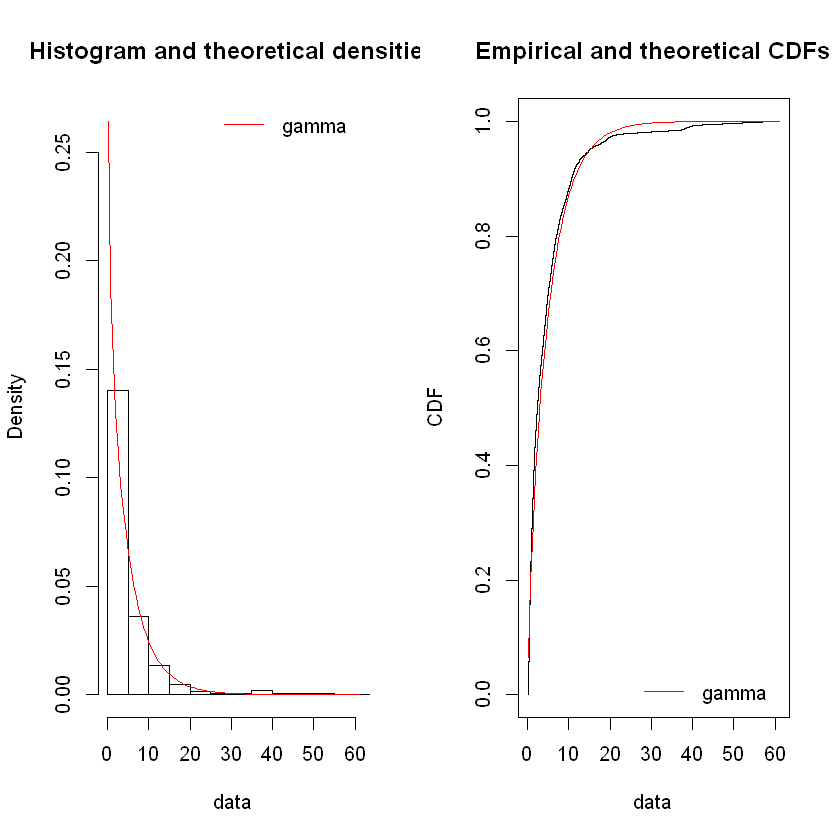

In [1328]:
par(mfrow = c(1, 2))
denscomp(fd_GM_Dec3)
#qqcomp(fd_GM_Dec3)
cdfcomp(fd_GM_Dec3)
#ppcomp(fd_GM_Dec3)

In [1329]:
fdGM_Dec3_shape <- fd_GM_Dec3$estimate[["shape"]]
fdGM_Dec3_rate <- fd_GM_Dec3$estimate[["rate"]]
fdGM_Dec3_llike <- fd_GM_Dec3$loglik
fdGM_Dec3_mean <- fdGM_Dec3_shape / fdGM_Dec3_rate
fdGM_Dec3_var <- fdGM_Dec3_shape / ( fdGM_Dec3_rate ^ 2 )
cat(" Dec 3 shape: ", fdGM_Dec3_shape, "\n", "Dec 3 rate: ", fdGM_Dec3_rate, 
    "\n", "Dec 3 loglikelihood: ", fdGM_Dec3_llike, "\n", 
    "Dec 3 mean: ", fdGM_Dec3_mean, "\n",
    "Dec 3 variance: ", fdGM_Dec3_var, "\n" )

 Dec 3 shape:  0.8333719 
 Dec 3 rate:  0.1770409 
 Dec 3 loglikelihood:  -25825.67 
 Dec 3 mean:  4.707229 
 Dec 3 variance:  26.58838 


In [1330]:
statRes <- gofstat( fd_GM_Dec3, fitnames=c("Gamma") )

In [1331]:
print(statRes)

Goodness-of-fit statistics
                                    Gamma
Kolmogorov-Smirnov statistic   0.07882062
Cramer-von Mises statistic    19.66716428
Anderson-Darling statistic   126.62758617

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 51655.34
Bayesian Information Criterion 51669.80


In [1332]:
ksRes <- ks.test( dfDec3$Precip_mm, "pgamma", shape=fdGM_Dec3_shape, rate=fdGM_Dec3_rate )

Warning message in ks.test(dfDec3$Precip_mm, "pgamma", shape = fdGM_Dec3_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1333]:
fdGM_Dec3_KSStat <- ksRes$statistic
fdGM_Dec3_KSp <- ksRes$p.value
cat(" Dec 3 K-S stat: ", fdGM_Dec3_KSStat, "\n",
    "Dec 3 K-S p-value: ", fdGM_Dec3_KSp )

 Dec 3 K-S stat:  0.07882062 
 Dec 3 K-S p-value:  0

**Mixed exponential**

In [1334]:
fd_ME_Dec3 <- expRMM_EM( dfDec3$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfDec3$Precip_mm), 1.0/mean(dfDec3$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 440 


In [1335]:
summary( fd_ME_Dec3 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.857699 0.1423007
rate   0.304612 0.0752395
loglik at estimate:  -25392.06 
0 % of the data right censored


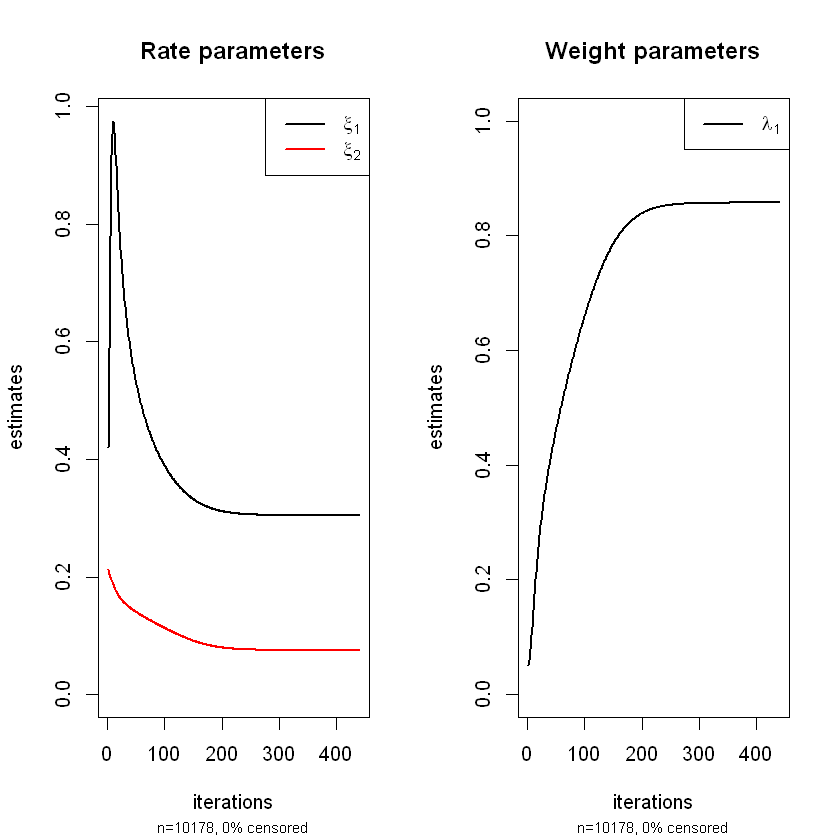

In [1336]:
plotexpRMM( fd_ME_Dec3, lwd=2 )

In [1337]:
fdME_Dec3_rate1 <- fd_ME_Dec3$rate[[1]]
fdME_Dec3_rate2 <- fd_ME_Dec3$rate[[2]]
fdME_Dec3_lambda <- fd_ME_Dec3$lambda[[1]]
fdME_Dec3_mean1 <- 1.0 / fdME_Dec3_rate1
fdME_Dec3_mean2 <- 1.0 / fdME_Dec3_rate2
fdME_Dec3_mean <- ( (fdME_Dec3_lambda * fdME_Dec3_mean1) + 
                    ( ( 1.0 - fdME_Dec3_lambda) * fdME_Dec3_mean2 ) )
fdME_Dec3_var1 <- 1.0 / (fdME_Dec3_rate1 ^ 2)
fdME_Dec3_var2 <- 1.0 / (fdME_Dec3_rate2 ^ 2)
fdME_Dec3_var <- ( (fdME_Dec3_lambda * ( fdME_Dec3_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Dec3_lambda) * (fdME_Dec3_mean2 ^ 2) ) + 
                   ( fdME_Dec3_lambda * ( 1.0 - fdME_Dec3_lambda) * 
                       ( fdME_Dec3_mean1 - fdME_Dec3_mean2 )^2 ) )
fdME_Dec3_llike <- fd_ME_Dec3$loglik
cat(" Dec 3 rate1: ", fdME_Dec3_rate1, "\n", 
    "Dec 3 rate2: ", fdME_Dec3_rate2, "\n",
    "Dec 3 lambda: ", fdME_Dec3_lambda, "\n",
    "Dec 3 mean1: ", fdME_Dec3_mean1, "\n",
    "Dec 3 mean2: ", fdME_Dec3_mean2, "\n",
    "Dec 3 mean: ", fdME_Dec3_mean, "\n",
    "Dec 3 var1: ", fdME_Dec3_var1, "\n",
    "Dec 3 var2: ", fdME_Dec3_var2, "\n",
    "Dec 3 var: ", fdME_Dec3_var, "\n",
    "Dec 3 loglikelihood: ", fdME_Dec3_llike, "\n" )

 Dec 3 rate1:  0.3046122 
 Dec 3 rate2:  0.07523947 
 Dec 3 lambda:  0.8576993 
 Dec 3 mean1:  3.282863 
 Dec 3 mean2:  13.2909 
 Dec 3 mean:  4.707013 
 Dec 3 var1:  10.77719 
 Dec 3 var2:  176.6479 
 Dec 3 var:  46.60545 
 Dec 3 loglikelihood:  -25392.06 


In [1338]:
tvals <- rexpmix(length(dfDec3$Precip_mm), fd_ME_Dec3$lambda, fd_ME_Dec3$rate )

In [1339]:
ksRes <- ks.test( dfDec3$Precip_mm, tvals )

Warning message in ks.test(dfDec3$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1340]:
fdME_Dec3_KSStat <- ksRes$statistic
fdME_Dec3_KSp <- ksRes$p.value
cat(" Dec 3 K-S stat: ", fdME_Dec3_KSStat, "\n",
    "Dec 3 K-S p-value: ", fdME_Dec3_KSp )

 Dec 3 K-S stat:  0.05737866 
 Dec 3 K-S p-value:  5.551115e-15

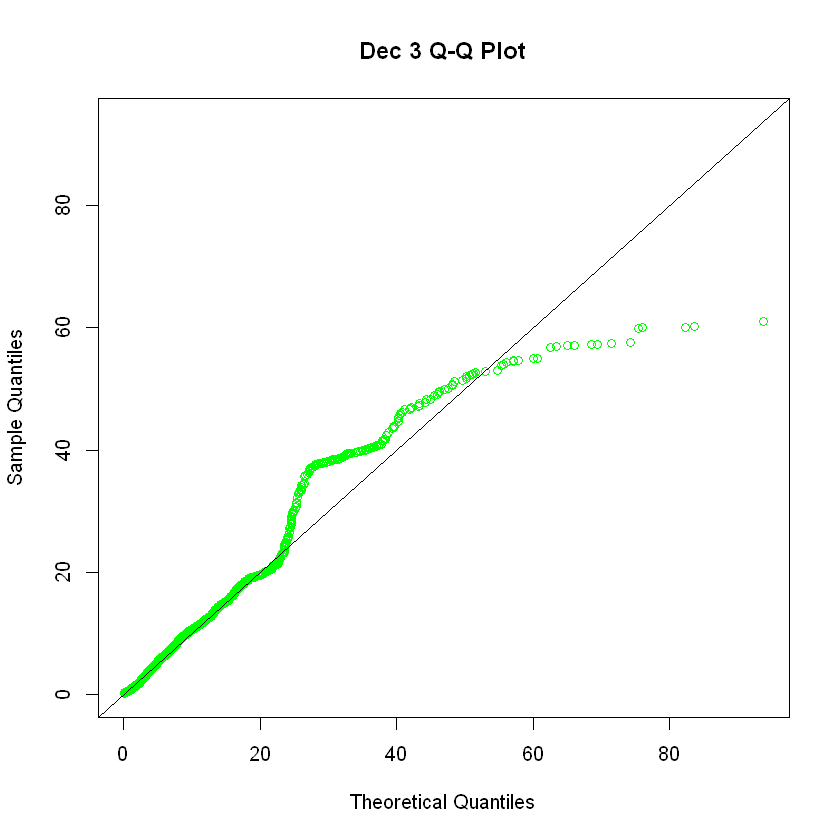

In [1341]:
wDec3Max <- max( max( dfDec3$Precip_mm ), max( tvals ) )
qqplot( tvals, dfDec3$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Dec 3 Q-Q Plot",
        xlim=c(0,wDec3Max), ylim=c(0,wDec3Max) )
abline( 0, 1)

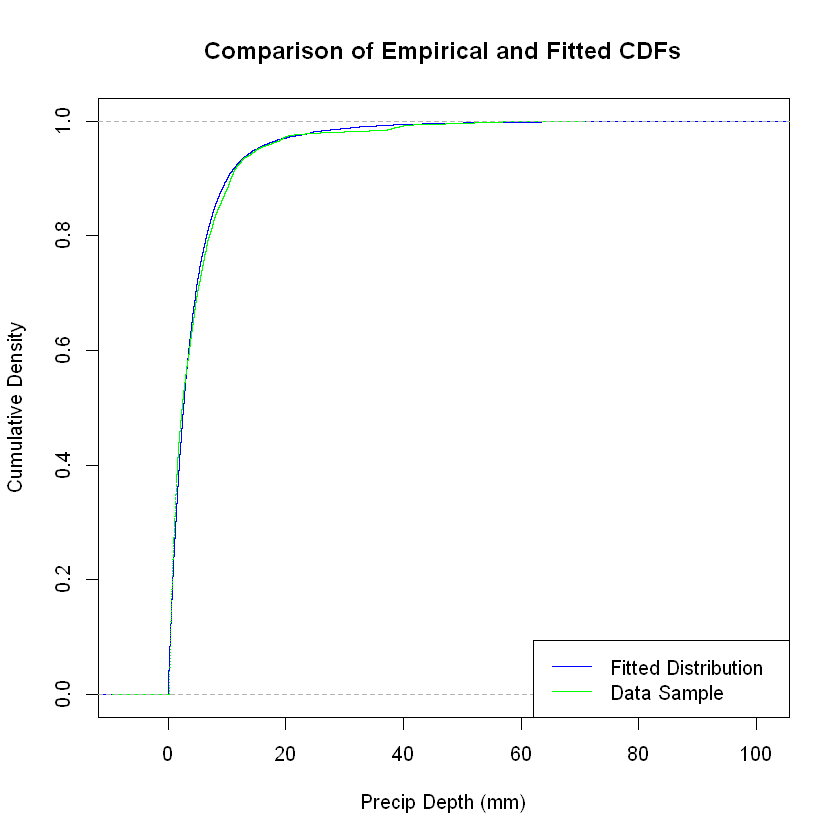

In [1342]:
x <- seq(0,wDec3Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfDec3$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1343]:
MonDistDF[59, ] <- list( 12, 3, fdGM_Dec3_shape, fdGM_Dec3_rate, fdGM_Dec3_llike, fdGM_Dec3_mean,
                        fdGM_Dec3_var, fdGM_Dec3_KSStat, fdGM_Dec3_KSp, fdME_Dec3_rate1,
                        fdME_Dec3_rate2, fdME_Dec3_lambda, fdME_Dec3_mean1, fdME_Dec3_mean2,
                        fdME_Dec3_mean, fdME_Dec3_var1, fdME_Dec3_var2, fdME_Dec3_var,
                        fdME_Dec3_llike, fdME_Dec3_KSStat, fdME_Dec3_KSp )

#### Region 4

**Gamma**

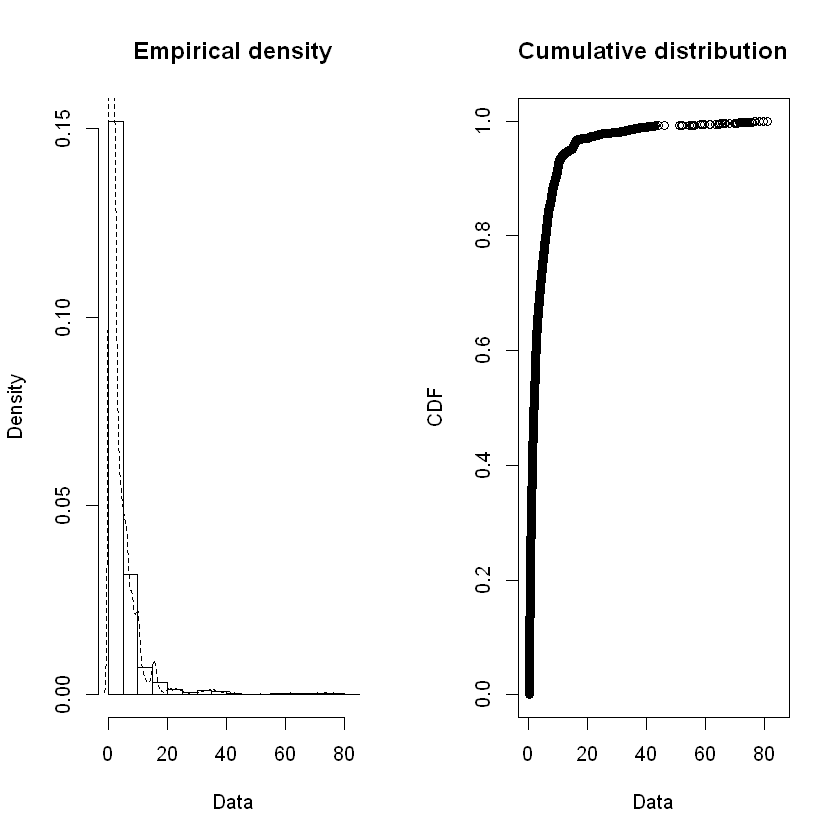

In [1344]:
plotdist( dfDec4$Precip_mm, histo=TRUE, demp=TRUE )

summary statistics
------
min:  0.2   max:  81.08 
median:  1.89 
mean:  4.241388 
estimated sd:  7.714346 
estimated skewness:  5.525996 
estimated kurtosis:  42.13347 

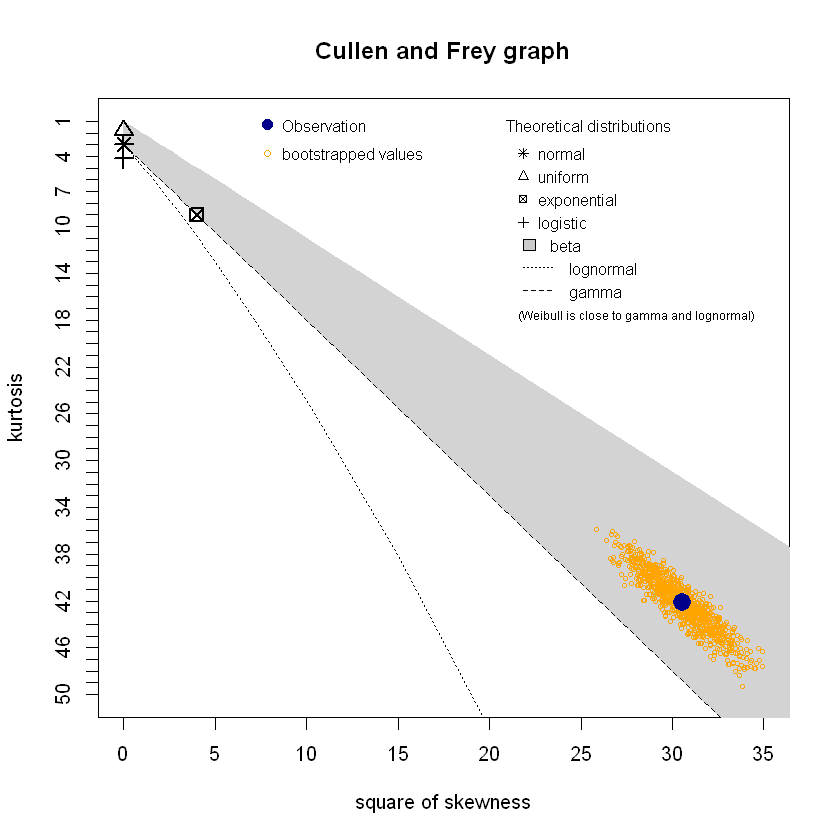

In [1345]:
descdist( dfDec4$Precip_mm, boot=1000 )

In [1346]:
fd_GM_Dec4 <- fitdist( dfDec4$Precip_mm, "gamma" )

In [1347]:
summary( fd_GM_Dec4 )

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
shape 0.7974861 0.011994868
rate  0.1880882 0.003840181
Loglikelihood:  -15959.44   AIC:  31922.88   BIC:  31936.46 
Correlation matrix:
         shape     rate
shape 1.000000 0.736651
rate  0.736651 1.000000


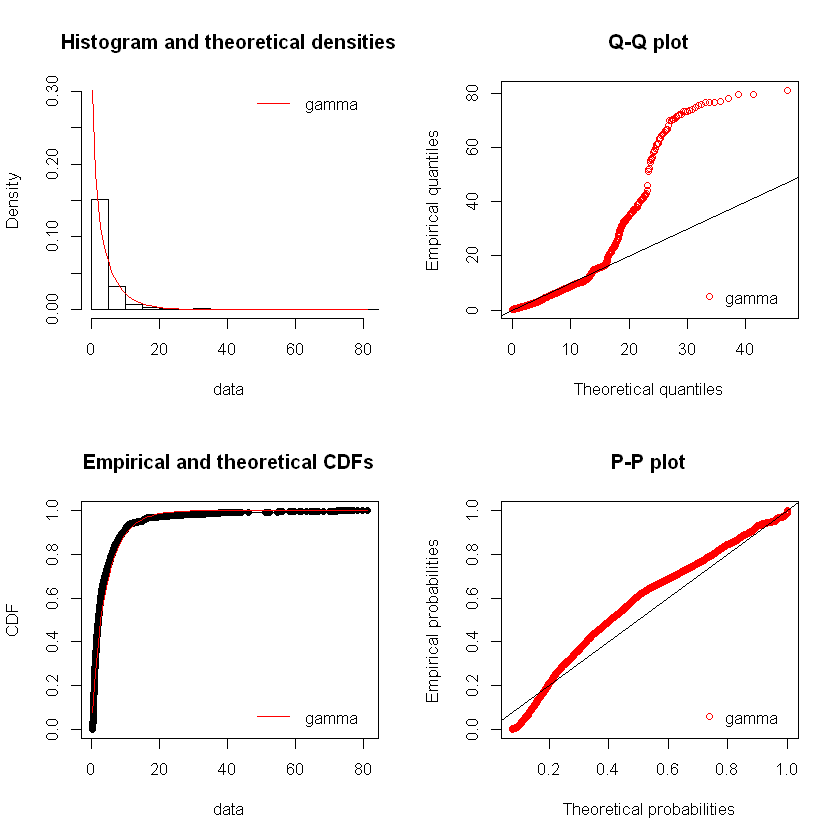

In [1348]:
par(mfrow = c(2, 2))
denscomp(fd_GM_Dec4)
qqcomp(fd_GM_Dec4)
cdfcomp(fd_GM_Dec4)
ppcomp(fd_GM_Dec4)

In [1349]:
fdGM_Dec4_shape <- fd_GM_Dec4$estimate[["shape"]]
fdGM_Dec4_rate <- fd_GM_Dec4$estimate[["rate"]]
fdGM_Dec4_llike <- fd_GM_Dec4$loglik
fdGM_Dec4_mean <- fdGM_Dec4_shape / fdGM_Dec4_rate
fdGM_Dec4_var <- fdGM_Dec4_shape / ( fdGM_Dec4_rate ^ 2 )
cat(" Dec 4 shape: ", fdGM_Dec4_shape, "\n", "Dec 4 rate: ", fdGM_Dec4_rate, 
    "\n", "Dec 4 loglikelihood: ", fdGM_Dec4_llike, "\n", 
    "Dec 4 mean: ", fdGM_Dec4_mean, "\n",
    "Dec 4 variance: ", fdGM_Dec4_var, "\n" )

 Dec 4 shape:  0.7974861 
 Dec 4 rate:  0.1880882 
 Dec 4 loglikelihood:  -15959.44 
 Dec 4 mean:  4.239958 
 Dec 4 variance:  22.54239 


In [1350]:
statRes <- gofstat( fd_GM_Dec4, fitnames=c("Gamma") )

In [1351]:
print(statRes)

Goodness-of-fit statistics
                                   Gamma
Kolmogorov-Smirnov statistic   0.1113635
Cramer-von Mises statistic    28.4514085
Anderson-Darling statistic   164.8980894

Goodness-of-fit criteria
                                  Gamma
Akaike's Information Criterion 31922.88
Bayesian Information Criterion 31936.46


In [1352]:
ksRes <- ks.test( dfDec4$Precip_mm, "pgamma", shape=fdGM_Dec4_shape, rate=fdGM_Dec4_rate )

Warning message in ks.test(dfDec4$Precip_mm, "pgamma", shape = fdGM_Dec4_shape, :
"ties should not be present for the Kolmogorov-Smirnov test"

In [1353]:
fdGM_Dec4_KSStat <- ksRes$statistic
fdGM_Dec4_KSp <- ksRes$p.value
cat(" Dec 4 K-S stat: ", fdGM_Dec4_KSStat, "\n",
    "Dec 4 K-S p-value: ", fdGM_Dec4_KSp )

 Dec 4 K-S stat:  0.1113635 
 Dec 4 K-S p-value:  0

**Mixed exponential**

In [1354]:
fd_ME_Dec4 <- expRMM_EM( dfDec4$Precip_mm, d=NULL, lambda=c(0.05, 1-0.05),
                         rate=c(1.0/median(dfDec4$Precip_mm), 1.0/mean(dfDec4$Precip_mm)), k=2,
                         complete="xz", epsilon=1e-08, maxit=1000, verb=FALSE )

number of iterations = 151 


In [1355]:
summary( fd_ME_Dec4 )

summary of expRMM_EM object:
         comp 1    comp 2
lambda 0.906557 0.0934433
rate   0.356949 0.0549133
loglik at estimate:  -15316.59 
0 % of the data right censored


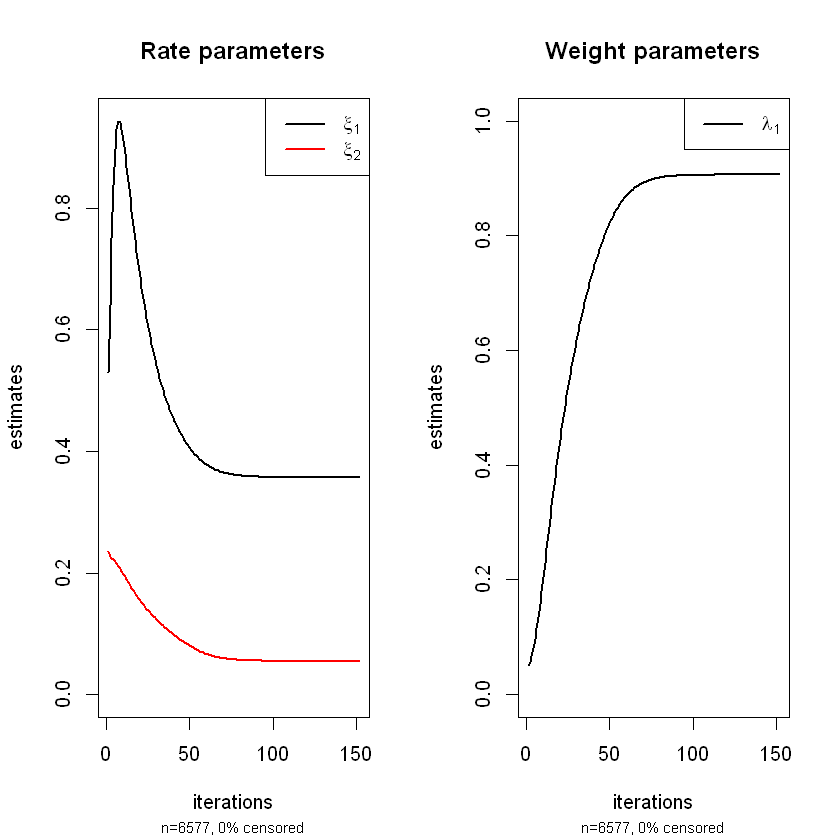

In [1356]:
plotexpRMM( fd_ME_Dec4, lwd=2 )

In [1357]:
fdME_Dec4_rate1 <- fd_ME_Dec4$rate[[1]]
fdME_Dec4_rate2 <- fd_ME_Dec4$rate[[2]]
fdME_Dec4_lambda <- fd_ME_Dec4$lambda[[1]]
fdME_Dec4_mean1 <- 1.0 / fdME_Dec4_rate1
fdME_Dec4_mean2 <- 1.0 / fdME_Dec4_rate2
fdME_Dec4_mean <- ( (fdME_Dec4_lambda * fdME_Dec4_mean1) + 
                    ( ( 1.0 - fdME_Dec4_lambda) * fdME_Dec4_mean2 ) )
fdME_Dec4_var1 <- 1.0 / (fdME_Dec4_rate1 ^ 2)
fdME_Dec4_var2 <- 1.0 / (fdME_Dec4_rate2 ^ 2)
fdME_Dec4_var <- ( (fdME_Dec4_lambda * ( fdME_Dec4_mean1 ^ 2 ) ) + 
                   ( ( 1.0 - fdME_Dec4_lambda) * (fdME_Dec4_mean2 ^ 2) ) + 
                   ( fdME_Dec4_lambda * ( 1.0 - fdME_Dec4_lambda) * 
                       ( fdME_Dec4_mean1 - fdME_Dec4_mean2 )^2 ) )
fdME_Dec4_llike <- fd_ME_Dec4$loglik
cat(" Dec 4 rate1: ", fdME_Dec4_rate1, "\n", 
    "Dec 4 rate2: ", fdME_Dec4_rate2, "\n",
    "Dec 4 lambda: ", fdME_Dec4_lambda, "\n",
    "Dec 4 mean1: ", fdME_Dec4_mean1, "\n",
    "Dec 4 mean2: ", fdME_Dec4_mean2, "\n",
    "Dec 4 mean: ", fdME_Dec4_mean, "\n",
    "Dec 4 var1: ", fdME_Dec4_var1, "\n",
    "Dec 4 var2: ", fdME_Dec4_var2, "\n",
    "Dec 4 var: ", fdME_Dec4_var, "\n",
    "Dec 4 loglikelihood: ", fdME_Dec4_llike, "\n" )

 Dec 4 rate1:  0.356949 
 Dec 4 rate2:  0.0549133 
 Dec 4 lambda:  0.9065567 
 Dec 4 mean1:  2.80152 
 Dec 4 mean2:  18.21053 
 Dec 4 mean:  4.241388 
 Dec 4 var1:  7.848516 
 Dec 4 var2:  331.6233 
 Dec 4 var:  58.2168 
 Dec 4 loglikelihood:  -15316.59 


In [1358]:
tvals <- rexpmix(length(dfDec4$Precip_mm), fd_ME_Dec4$lambda, fd_ME_Dec4$rate )

In [1359]:
ksRes <- ks.test( dfDec4$Precip_mm, tvals )

Warning message in ks.test(dfDec4$Precip_mm, tvals):
"p-value will be approximate in the presence of ties"

In [1360]:
fdME_Dec4_KSStat <- ksRes$statistic
fdME_Dec4_KSp <- ksRes$p.value
cat(" Dec 4 K-S stat: ", fdME_Dec4_KSStat, "\n",
    "Dec 4 K-S p-value: ", fdME_Dec4_KSp )

 Dec 4 K-S stat:  0.07070093 
 Dec 4 K-S p-value:  1.054712e-14

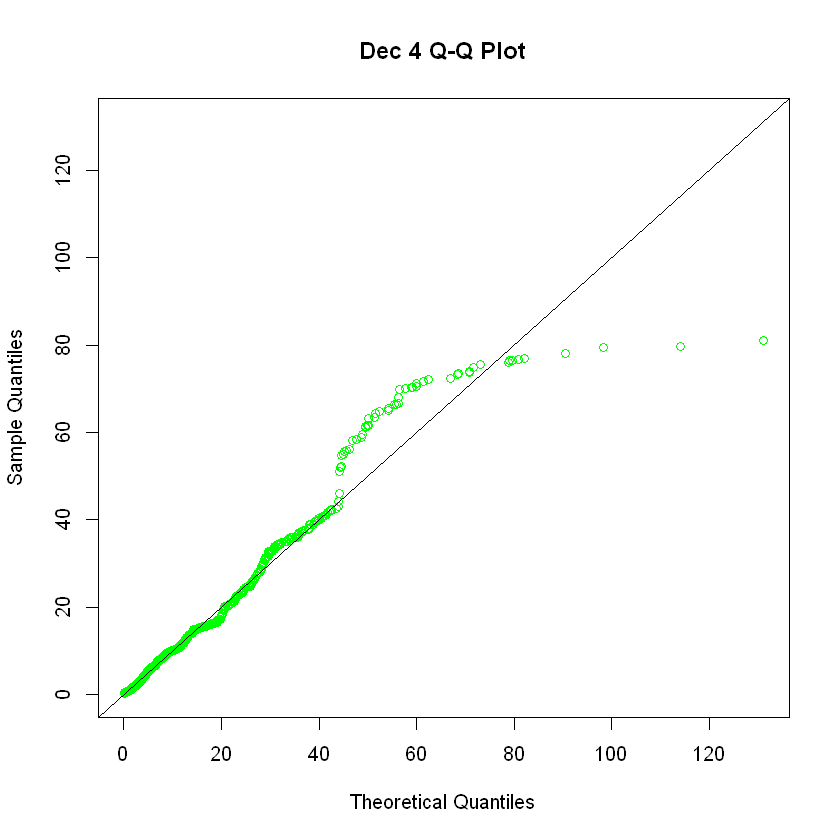

In [1361]:
wDec4Max <- max( max( dfDec4$Precip_mm ), max( tvals ) )
qqplot( tvals, dfDec4$Precip_mm, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="Dec 4 Q-Q Plot",
        xlim=c(0,wDec4Max), ylim=c(0,wDec4Max) )
abline( 0, 1)

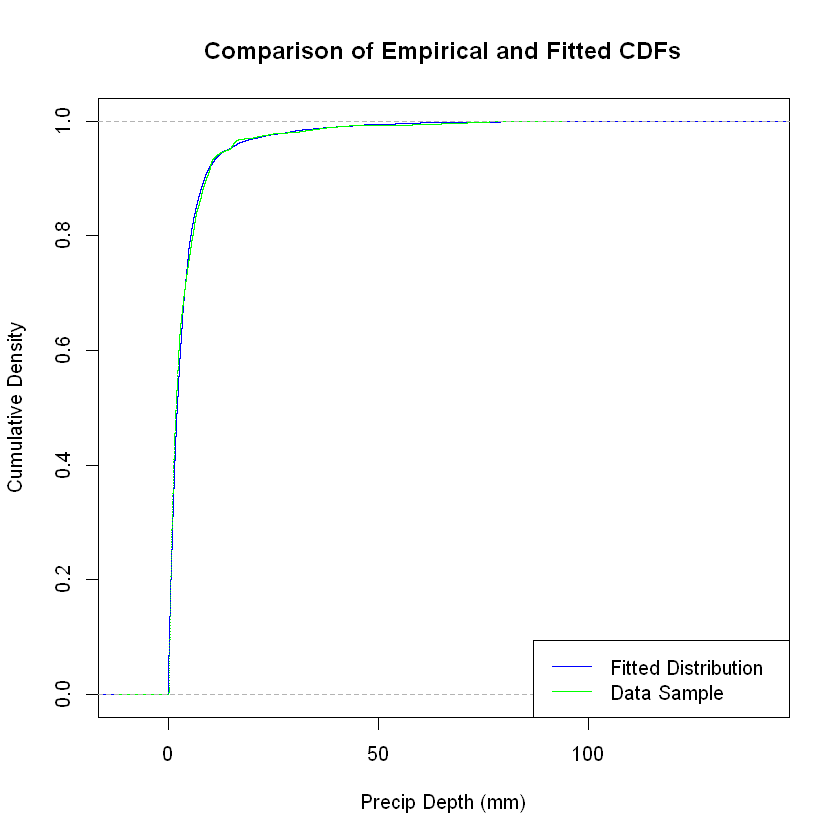

In [1362]:
x <- seq(0,wDec4Max,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(ecdf(tvals),
     xlab="Precip Depth (mm)", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dfDec4$Precip_mm), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Assign the values to the DataFrame

In [1363]:
MonDistDF[60, ] <- list( 12, 4, fdGM_Dec4_shape, fdGM_Dec4_rate, fdGM_Dec4_llike, fdGM_Dec4_mean,
                        fdGM_Dec4_var, fdGM_Dec4_KSStat, fdGM_Dec4_KSp, fdME_Dec4_rate1,
                        fdME_Dec4_rate2, fdME_Dec4_lambda, fdME_Dec4_mean1, fdME_Dec4_mean2,
                        fdME_Dec4_mean, fdME_Dec4_var1, fdME_Dec4_var2, fdME_Dec4_var,
                        fdME_Dec4_llike, fdME_Dec4_KSStat, fdME_Dec4_KSp )

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

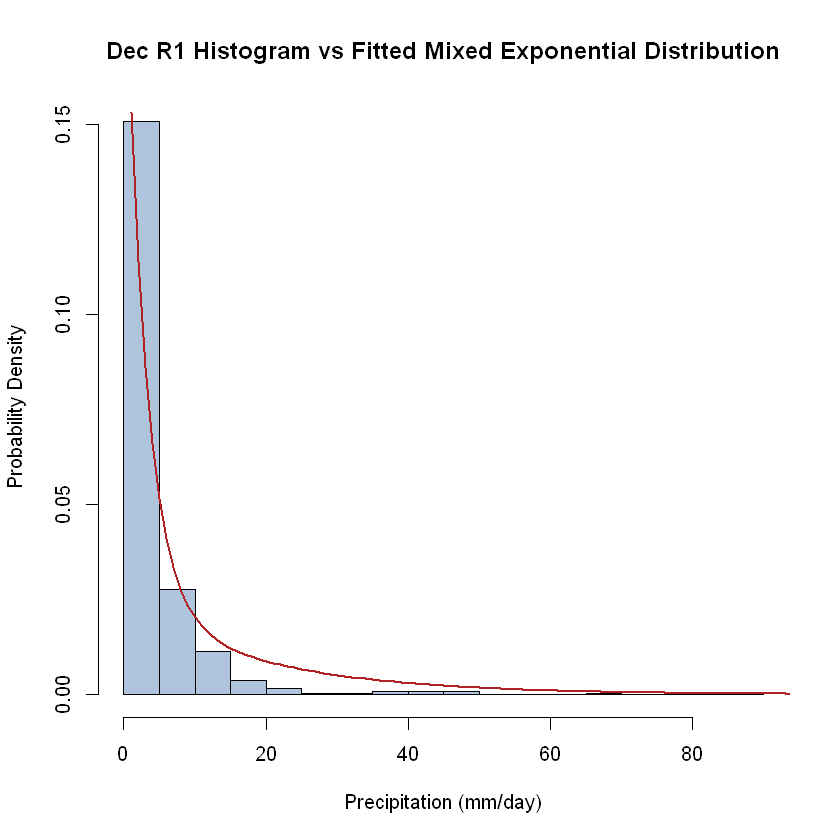

In [1364]:
xVals <- seq(1, wDec1Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Dec1_lambda, spec1="exp", arg1=list(rate=fdME_Dec1_rate1),
                 spec2="exp", arg2=list(rate=fdME_Dec1_rate2) )
hist( dfDec1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Dec R1 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

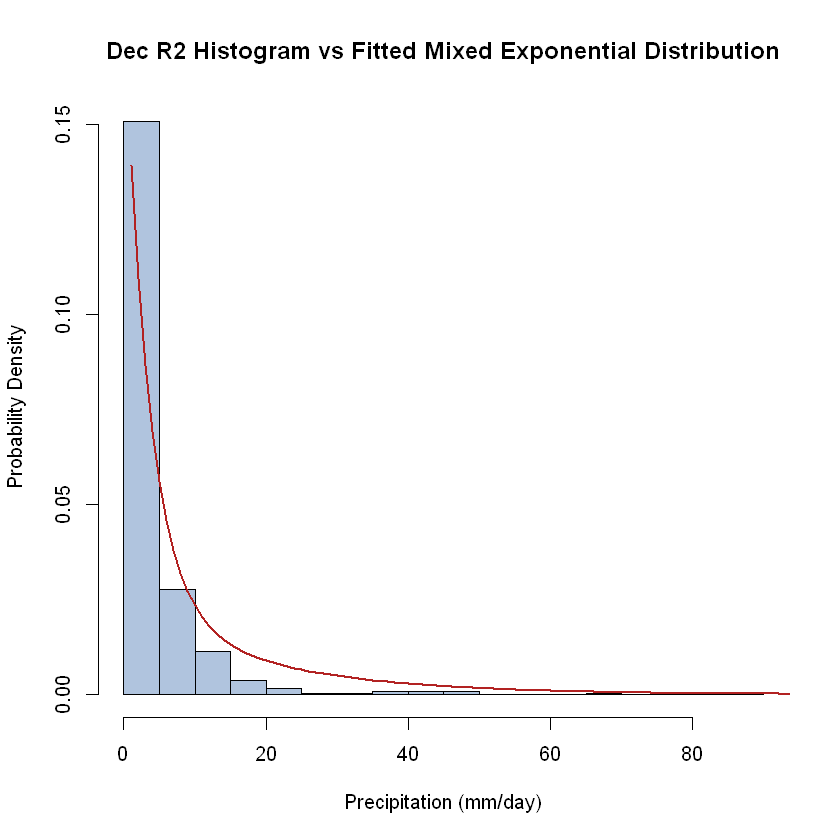

In [1365]:
xVals <- seq(1, wDec2Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Dec2_lambda, spec1="exp", arg1=list(rate=fdME_Dec2_rate1),
                 spec2="exp", arg2=list(rate=fdME_Dec2_rate2) )
hist( dfDec1$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Dec R2 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

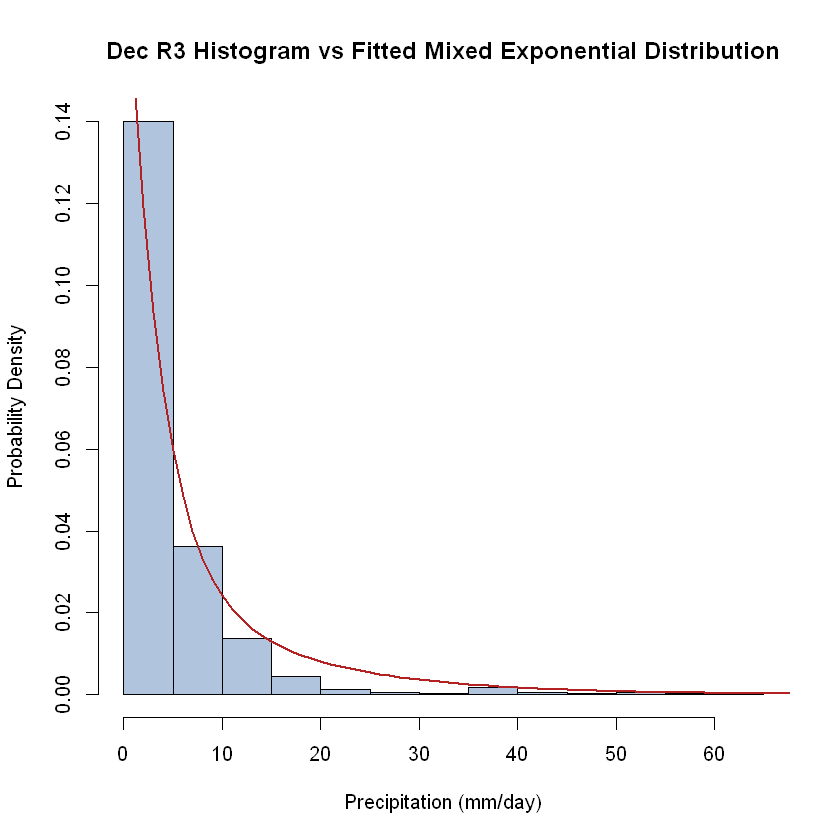

In [1366]:
xVals <- seq(1, wDec3Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Dec3_lambda, spec1="exp", arg1=list(rate=fdME_Dec3_rate1),
                 spec2="exp", arg2=list(rate=fdME_Dec3_rate2) )
hist( dfDec3$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Dec R3 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"

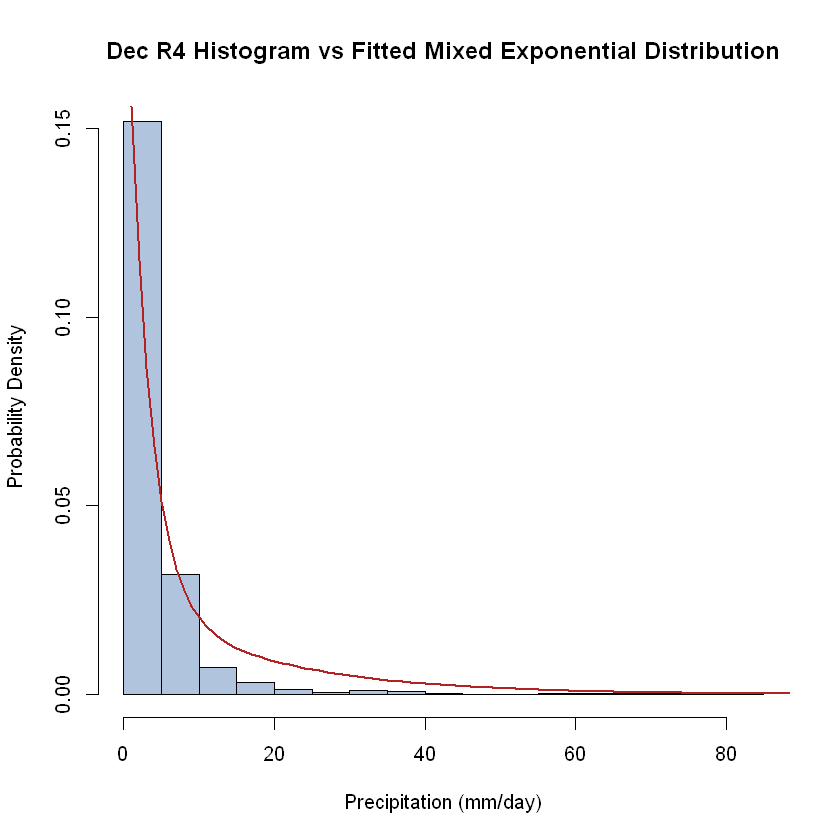

In [1367]:
xVals <- seq(1, wDec4Max, 1)
pdVals <- dmixt( xVals, phi=fdME_Dec4_lambda, spec1="exp", arg1=list(rate=fdME_Dec4_rate1),
                 spec2="exp", arg2=list(rate=fdME_Dec4_rate2) )
hist( dfDec4$Precip_mm, freq=FALSE, col="lightsteelblue", 
      xlab="Precipitation (mm/day)", ylab="Probability Density",
      main="Dec R4 Histogram vs Fitted Mixed Exponential Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)

## Check if Regional Distributions are Different

Want to see if the regional distributions seem different. If they do not then we don't need to have the regions.

In [ ]:
MonPVDF <- data.frame( month=rep(NA,12), pG_1to2=rep(NA,12), pG_1to3=rep(NA,12), 
                       pG_1to4=rep(NA,12), pG_2to3=rep(NA,12), pG_2to4=rep(NA,12),
                       pG_3to4=rep(NA,12), pEM_1to2=rep(NA,12), pEM_1to3=rep(NA,12), 
                       pEM_1to4=rep(NA,12), pEM_2to3=rep(NA,12), pEM_2to4=rep(NA,12),
                       pEM_3to4=rep(NA,12), stringsAsFactors=FALSE )

### Jan

In [ ]:
NumJan1 <- length( dfJan1$Precip_mm )
NumJan2 <- length( dfJan2$Precip_mm )
NumJan3 <- length( dfJan3$Precip_mm )
NumJan4 <- length( dfJan4$Precip_mm )

#### Region 1 versus 2 test

In [ ]:
curN <- min( NumJan1, NumJan2 )
cat("curN: ", curN)

In [ ]:
tdG1 <- rgamma( curN, fdGM_Jan1_shape , rate=fdGM_Jan1_rate )
tdG2 <- rgamma( curN, fdGM_Jan2_shape , rate=fdGM_Jan2_rate )

In [ ]:
ksGRes <- ks.test( tdG1, tdG2 )

In [ ]:
cmpJan_GM_12_KSstat <- ksGRes$statistic
cmpJan_GM_12_KSp <- ksGRes$p.value
cat(" Jan 1-2 K-S stat: ", cmpJan_GM_12_KSstat, "\n",
    "Jan 1-2 K-S p-value: ", cmpJan_GM_12_KSp )

In [ ]:
pMax <- max( max( tdG1 ), max( tdG2 ) )
qqplot( tdG1, tdG2, col="blue", xlab="Region 1",
        ylab="Region 2", main="Jan Q-Q Plot",
        xlim=c(0,pMax), ylim=c(0,pMax) )
abline( 0, 1)

#### All

In [ ]:
curN12 <- min( NumJan1, NumJan2 )
tdG_12_1 <- rgamma( curN12, fdGM_Jan1_shape , rate=fdGM_Jan1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Jan2_shape , rate=fdGM_Jan2_rate )
curN13 <- min( NumJan1, NumJan3 )
tdG_13_1 <- rgamma( curN13, fdGM_Jan1_shape , rate=fdGM_Jan1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Jan3_shape , rate=fdGM_Jan3_rate )
curN14 <- min( NumJan1, NumJan4 )
tdG_14_1 <- rgamma( curN14, fdGM_Jan1_shape , rate=fdGM_Jan1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Jan4_shape , rate=fdGM_Jan4_rate )
curN23 <- min( NumJan2, NumJan3 )
tdG_23_2 <- rgamma( curN23, fdGM_Jan2_shape , rate=fdGM_Jan2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Jan3_shape , rate=fdGM_Jan3_rate )
curN24 <- min( NumJan2, NumJan4 )
tdG_24_2 <- rgamma( curN24, fdGM_Jan2_shape , rate=fdGM_Jan2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Jan4_shape , rate=fdGM_Jan4_rate )
curN34 <- min( NumJan3, NumJan4 )
tdG_34_3 <- rgamma( curN34, fdGM_Jan3_shape , rate=fdGM_Jan3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Jan4_shape , rate=fdGM_Jan4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
#rexpmix(length(dfDec4$Precip_mm), fd_ME_Dec4$lambda, fd_ME_Dec4$rate )
tdME_12_1 <- rmixt( curN12, phi=fdME_Jan1_lambda, spec1="exp", arg1=list(rate=fdME_Jan1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan1_rate2) )
tdME_12_2 <- rmixt( curN12, phi=fdME_Jan2_lambda, spec1="exp", arg1=list(rate=fdME_Jan2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan2_rate2) )
tdME_13_1 <- rmixt( curN13, phi=fdME_Jan1_lambda, spec1="exp", arg1=list(rate=fdME_Jan1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan1_rate2) )
tdME_13_3 <- rmixt( curN13, phi=fdME_Jan3_lambda, spec1="exp", arg1=list(rate=fdME_Jan3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan3_rate2) )
tdME_14_1 <- rmixt( curN14, phi=fdME_Jan1_lambda, spec1="exp", arg1=list(rate=fdME_Jan1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan1_rate2) )
tdME_14_4 <- rmixt( curN14, phi=fdME_Jan4_lambda, spec1="exp", arg1=list(rate=fdME_Jan4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan4_rate2) )
tdME_23_2 <- rmixt( curN23, phi=fdME_Jan2_lambda, spec1="exp", arg1=list(rate=fdME_Jan2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan2_rate2) )
tdME_23_3 <- rmixt( curN23, phi=fdME_Jan3_lambda, spec1="exp", arg1=list(rate=fdME_Jan3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan3_rate2) )
tdME_24_2 <- rmixt( curN24, phi=fdME_Jan2_lambda, spec1="exp", arg1=list(rate=fdME_Jan2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan2_rate2) )
tdME_24_4 <- rmixt( curN24, phi=fdME_Jan4_lambda, spec1="exp", arg1=list(rate=fdME_Jan4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan4_rate2) )
tdME_34_3 <- rmixt( curN34, phi=fdME_Jan3_lambda, spec1="exp", arg1=list(rate=fdME_Jan3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan3_rate2) )
tdME_34_4 <- rmixt( curN34, phi=fdME_Jan4_lambda, spec1="exp", arg1=list(rate=fdME_Jan4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Jan4_rate2) )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[1, ] <- list( 1, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

In [ ]:
head( MonPVDF )

### Feb

In [ ]:
NumFeb1 <- length( dfFeb1$Precip_mm )
NumFeb2 <- length( dfFeb2$Precip_mm )
NumFeb3 <- length( dfFeb3$Precip_mm )
NumFeb4 <- length( dfFeb4$Precip_mm )

In [ ]:
curN12 <- min( NumFeb1, NumFeb2 )
tdG_12_1 <- rgamma( curN12, fdGM_Feb1_shape , rate=fdGM_Feb1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Feb2_shape , rate=fdGM_Feb2_rate )
curN13 <- min( NumFeb1, NumFeb3 )
tdG_13_1 <- rgamma( curN13, fdGM_Feb1_shape , rate=fdGM_Feb1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Feb3_shape , rate=fdGM_Feb3_rate )
curN14 <- min( NumFeb1, NumFeb4 )
tdG_14_1 <- rgamma( curN14, fdGM_Feb1_shape , rate=fdGM_Feb1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Feb4_shape , rate=fdGM_Feb4_rate )
curN23 <- min( NumFeb2, NumFeb3 )
tdG_23_2 <- rgamma( curN23, fdGM_Feb2_shape , rate=fdGM_Feb2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Feb3_shape , rate=fdGM_Feb3_rate )
curN24 <- min( NumFeb2, NumFeb4 )
tdG_24_2 <- rgamma( curN24, fdGM_Feb2_shape , rate=fdGM_Feb2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Feb4_shape , rate=fdGM_Feb4_rate )
curN34 <- min( NumFeb3, NumFeb4 )
tdG_34_3 <- rgamma( curN34, fdGM_Feb3_shape , rate=fdGM_Feb3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Feb4_shape , rate=fdGM_Feb4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rmixt( curN12, phi=fdME_Feb1_lambda, spec1="exp", arg1=list(rate=fdME_Feb1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb1_rate2) )
tdME_12_2 <- rmixt( curN12, phi=fdME_Feb2_lambda, spec1="exp", arg1=list(rate=fdME_Feb2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb2_rate2) )
tdME_13_1 <- rmixt( curN13, phi=fdME_Feb1_lambda, spec1="exp", arg1=list(rate=fdME_Feb1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb1_rate2) )
tdME_13_3 <- rmixt( curN13, phi=fdME_Feb3_lambda, spec1="exp", arg1=list(rate=fdME_Feb3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb3_rate2) )
tdME_14_1 <- rmixt( curN14, phi=fdME_Feb1_lambda, spec1="exp", arg1=list(rate=fdME_Feb1_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb1_rate2) )
tdME_14_4 <- rmixt( curN14, phi=fdME_Feb4_lambda, spec1="exp", arg1=list(rate=fdME_Feb4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb4_rate2) )
tdME_23_2 <- rmixt( curN23, phi=fdME_Feb2_lambda, spec1="exp", arg1=list(rate=fdME_Feb2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb2_rate2) )
tdME_23_3 <- rmixt( curN23, phi=fdME_Feb3_lambda, spec1="exp", arg1=list(rate=fdME_Feb3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb3_rate2) )
tdME_24_2 <- rmixt( curN24, phi=fdME_Feb2_lambda, spec1="exp", arg1=list(rate=fdME_Feb2_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb2_rate2) )
tdME_24_4 <- rmixt( curN24, phi=fdME_Feb4_lambda, spec1="exp", arg1=list(rate=fdME_Feb4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb4_rate2) )
tdME_34_3 <- rmixt( curN34, phi=fdME_Feb3_lambda, spec1="exp", arg1=list(rate=fdME_Feb3_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb3_rate2) )
tdME_34_4 <- rmixt( curN34, phi=fdME_Feb4_lambda, spec1="exp", arg1=list(rate=fdME_Feb4_rate1),
                    spec2="exp", arg2=list(rate=fdME_Feb4_rate2) )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[2, ] <- list( 2, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Mar

In [ ]:
NumMar1 <- length( dfMar1$Precip_mm )
NumMar2 <- length( dfMar2$Precip_mm )
NumMar3 <- length( dfMar3$Precip_mm )
NumMar4 <- length( dfMar4$Precip_mm )

In [ ]:
curN12 <- min( NumMar1, NumMar2 )
tdG_12_1 <- rgamma( curN12, fdGM_Mar1_shape , rate=fdGM_Mar1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Mar2_shape , rate=fdGM_Mar2_rate )
curN13 <- min( NumMar1, NumMar3 )
tdG_13_1 <- rgamma( curN13, fdGM_Mar1_shape , rate=fdGM_Mar1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Mar3_shape , rate=fdGM_Mar3_rate )
curN14 <- min( NumMar1, NumMar4 )
tdG_14_1 <- rgamma( curN14, fdGM_Mar1_shape , rate=fdGM_Mar1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Mar4_shape , rate=fdGM_Mar4_rate )
curN23 <- min( NumMar2, NumMar3 )
tdG_23_2 <- rgamma( curN23, fdGM_Mar2_shape , rate=fdGM_Mar2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Mar3_shape , rate=fdGM_Mar3_rate )
curN24 <- min( NumMar2, NumMar4 )
tdG_24_2 <- rgamma( curN24, fdGM_Mar2_shape , rate=fdGM_Mar2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Mar4_shape , rate=fdGM_Mar4_rate )
curN34 <- min( NumMar3, NumMar4 )
tdG_34_3 <- rgamma( curN34, fdGM_Mar3_shape , rate=fdGM_Mar3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Mar4_shape , rate=fdGM_Mar4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Mar1$lambda, fd_ME_Mar1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Mar2$lambda, fd_ME_Mar2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Mar1$lambda, fd_ME_Mar1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Mar3$lambda, fd_ME_Mar3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Mar1$lambda, fd_ME_Mar1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Mar4$lambda, fd_ME_Mar4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Mar2$lambda, fd_ME_Mar2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Mar3$lambda, fd_ME_Mar3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Mar2$lambda, fd_ME_Mar2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Mar4$lambda, fd_ME_Mar4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Mar3$lambda, fd_ME_Mar3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Mar4$lambda, fd_ME_Mar4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[3, ] <- list( 3, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Apr

In [ ]:
NumApr1 <- length( dfApr1$Precip_mm )
NumApr2 <- length( dfApr2$Precip_mm )
NumApr3 <- length( dfApr3$Precip_mm )
NumApr4 <- length( dfApr4$Precip_mm )

In [ ]:
curN12 <- min( NumApr1, NumApr2 )
tdG_12_1 <- rgamma( curN12, fdGM_Apr1_shape , rate=fdGM_Apr1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Apr2_shape , rate=fdGM_Apr2_rate )
curN13 <- min( NumApr1, NumApr3 )
tdG_13_1 <- rgamma( curN13, fdGM_Apr1_shape , rate=fdGM_Apr1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Apr3_shape , rate=fdGM_Apr3_rate )
curN14 <- min( NumApr1, NumApr4 )
tdG_14_1 <- rgamma( curN14, fdGM_Apr1_shape , rate=fdGM_Apr1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Apr4_shape , rate=fdGM_Apr4_rate )
curN23 <- min( NumApr2, NumApr3 )
tdG_23_2 <- rgamma( curN23, fdGM_Apr2_shape , rate=fdGM_Apr2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Apr3_shape , rate=fdGM_Apr3_rate )
curN24 <- min( NumApr2, NumApr4 )
tdG_24_2 <- rgamma( curN24, fdGM_Apr2_shape , rate=fdGM_Apr2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Apr4_shape , rate=fdGM_Apr4_rate )
curN34 <- min( NumApr3, NumApr4 )
tdG_34_3 <- rgamma( curN34, fdGM_Apr3_shape , rate=fdGM_Apr3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Apr4_shape , rate=fdGM_Apr4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Apr1$lambda, fd_ME_Apr1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Apr2$lambda, fd_ME_Apr2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Apr1$lambda, fd_ME_Apr1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Apr3$lambda, fd_ME_Apr3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Apr1$lambda, fd_ME_Apr1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Apr4$lambda, fd_ME_Apr4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Apr2$lambda, fd_ME_Apr2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Apr3$lambda, fd_ME_Apr3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Apr2$lambda, fd_ME_Apr2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Apr4$lambda, fd_ME_Apr4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Apr3$lambda, fd_ME_Apr3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Apr4$lambda, fd_ME_Apr4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[4, ] <- list( 4, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### May

In [ ]:
NumMay1 <- length( dfMay1$Precip_mm )
NumMay2 <- length( dfMay2$Precip_mm )
NumMay3 <- length( dfMay3$Precip_mm )
NumMay4 <- length( dfMay4$Precip_mm )

In [ ]:
curN12 <- min( NumMay1, NumMay2 )
tdG_12_1 <- rgamma( curN12, fdGM_May1_shape , rate=fdGM_May1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_May2_shape , rate=fdGM_May2_rate )
curN13 <- min( NumMay1, NumMay3 )
tdG_13_1 <- rgamma( curN13, fdGM_May1_shape , rate=fdGM_May1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_May3_shape , rate=fdGM_May3_rate )
curN14 <- min( NumMay1, NumMay4 )
tdG_14_1 <- rgamma( curN14, fdGM_May1_shape , rate=fdGM_May1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_May4_shape , rate=fdGM_May4_rate )
curN23 <- min( NumMay2, NumMay3 )
tdG_23_2 <- rgamma( curN23, fdGM_May2_shape , rate=fdGM_May2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_May3_shape , rate=fdGM_May3_rate )
curN24 <- min( NumMay2, NumMay4 )
tdG_24_2 <- rgamma( curN24, fdGM_May2_shape , rate=fdGM_May2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_May4_shape , rate=fdGM_May4_rate )
curN34 <- min( NumMay3, NumMay4 )
tdG_34_3 <- rgamma( curN34, fdGM_May3_shape , rate=fdGM_May3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_May4_shape , rate=fdGM_May4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_May1$lambda, fd_ME_May1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_May2$lambda, fd_ME_May2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_May1$lambda, fd_ME_May1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_May3$lambda, fd_ME_May3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_May1$lambda, fd_ME_May1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_May4$lambda, fd_ME_May4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_May2$lambda, fd_ME_May2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_May3$lambda, fd_ME_May3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_May2$lambda, fd_ME_May2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_May4$lambda, fd_ME_May4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_May3$lambda, fd_ME_May3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_May4$lambda, fd_ME_May4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[5, ] <- list( 5, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Jun

In [ ]:
NumJun1 <- length( dfJun1$Precip_mm )
NumJun2 <- length( dfJun2$Precip_mm )
NumJun3 <- length( dfJun3$Precip_mm )
NumJun4 <- length( dfJun4$Precip_mm )

In [ ]:
curN12 <- min( NumJun1, NumJun2 )
tdG_12_1 <- rgamma( curN12, fdGM_Jun1_shape , rate=fdGM_Jun1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Jun2_shape , rate=fdGM_Jun2_rate )
curN13 <- min( NumJun1, NumJun3 )
tdG_13_1 <- rgamma( curN13, fdGM_Jun1_shape , rate=fdGM_Jun1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Jun3_shape , rate=fdGM_Jun3_rate )
curN14 <- min( NumJun1, NumJun4 )
tdG_14_1 <- rgamma( curN14, fdGM_Jun1_shape , rate=fdGM_Jun1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Jun4_shape , rate=fdGM_Jun4_rate )
curN23 <- min( NumJun2, NumJun3 )
tdG_23_2 <- rgamma( curN23, fdGM_Jun2_shape , rate=fdGM_Jun2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Jun3_shape , rate=fdGM_Jun3_rate )
curN24 <- min( NumJun2, NumJun4 )
tdG_24_2 <- rgamma( curN24, fdGM_Jun2_shape , rate=fdGM_Jun2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Jun4_shape , rate=fdGM_Jun4_rate )
curN34 <- min( NumJun3, NumJun4 )
tdG_34_3 <- rgamma( curN34, fdGM_Jun3_shape , rate=fdGM_Jun3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Jun4_shape , rate=fdGM_Jun4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Jun1$lambda, fd_ME_Jun1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Jun2$lambda, fd_ME_Jun2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Jun1$lambda, fd_ME_Jun1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Jun3$lambda, fd_ME_Jun3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Jun1$lambda, fd_ME_Jun1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Jun4$lambda, fd_ME_Jun4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Jun2$lambda, fd_ME_Jun2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Jun3$lambda, fd_ME_Jun3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Jun2$lambda, fd_ME_Jun2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Jun4$lambda, fd_ME_Jun4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Jun3$lambda, fd_ME_Jun3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Jun4$lambda, fd_ME_Jun4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[6, ] <- list( 6, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Jul

In [ ]:
NumJul1 <- length( dfJul1$Precip_mm )
NumJul2 <- length( dfJul2$Precip_mm )
NumJul3 <- length( dfJul3$Precip_mm )
NumJul4 <- length( dfJul4$Precip_mm )

In [ ]:
curN12 <- min( NumJul1, NumJul2 )
tdG_12_1 <- rgamma( curN12, fdGM_Jul1_shape , rate=fdGM_Jul1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Jul2_shape , rate=fdGM_Jul2_rate )
curN13 <- min( NumJul1, NumJul3 )
tdG_13_1 <- rgamma( curN13, fdGM_Jul1_shape , rate=fdGM_Jul1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Jul3_shape , rate=fdGM_Jul3_rate )
curN14 <- min( NumJul1, NumJul4 )
tdG_14_1 <- rgamma( curN14, fdGM_Jul1_shape , rate=fdGM_Jul1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Jul4_shape , rate=fdGM_Jul4_rate )
curN23 <- min( NumJul2, NumJul3 )
tdG_23_2 <- rgamma( curN23, fdGM_Jul2_shape , rate=fdGM_Jul2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Jul3_shape , rate=fdGM_Jul3_rate )
curN24 <- min( NumJul2, NumJul4 )
tdG_24_2 <- rgamma( curN24, fdGM_Jul2_shape , rate=fdGM_Jul2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Jul4_shape , rate=fdGM_Jul4_rate )
curN34 <- min( NumJul3, NumJul4 )
tdG_34_3 <- rgamma( curN34, fdGM_Jul3_shape , rate=fdGM_Jul3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Jul4_shape , rate=fdGM_Jul4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Jul1$lambda, fd_ME_Jul1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Jul2$lambda, fd_ME_Jul2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Jul1$lambda, fd_ME_Jul1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Jul3$lambda, fd_ME_Jul3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Jul1$lambda, fd_ME_Jul1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Jul4$lambda, fd_ME_Jul4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Jul2$lambda, fd_ME_Jul2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Jul3$lambda, fd_ME_Jul3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Jul2$lambda, fd_ME_Jul2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Jul4$lambda, fd_ME_Jul4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Jul3$lambda, fd_ME_Jul3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Jul4$lambda, fd_ME_Jul4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[7, ] <- list( 7, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Aug

In [ ]:
NumAug1 <- length( dfAug1$Precip_mm )
NumAug2 <- length( dfAug2$Precip_mm )
NumAug3 <- length( dfAug3$Precip_mm )
NumAug4 <- length( dfAug4$Precip_mm )

In [ ]:
curN12 <- min( NumAug1, NumAug2 )
tdG_12_1 <- rgamma( curN12, fdGM_Aug1_shape , rate=fdGM_Aug1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Aug2_shape , rate=fdGM_Aug2_rate )
curN13 <- min( NumAug1, NumAug3 )
tdG_13_1 <- rgamma( curN13, fdGM_Aug1_shape , rate=fdGM_Aug1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Aug3_shape , rate=fdGM_Aug3_rate )
curN14 <- min( NumAug1, NumAug4 )
tdG_14_1 <- rgamma( curN14, fdGM_Aug1_shape , rate=fdGM_Aug1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Aug4_shape , rate=fdGM_Aug4_rate )
curN23 <- min( NumAug2, NumAug3 )
tdG_23_2 <- rgamma( curN23, fdGM_Aug2_shape , rate=fdGM_Aug2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Aug3_shape , rate=fdGM_Aug3_rate )
curN24 <- min( NumAug2, NumAug4 )
tdG_24_2 <- rgamma( curN24, fdGM_Aug2_shape , rate=fdGM_Aug2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Aug4_shape , rate=fdGM_Aug4_rate )
curN34 <- min( NumAug3, NumAug4 )
tdG_34_3 <- rgamma( curN34, fdGM_Aug3_shape , rate=fdGM_Aug3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Aug4_shape , rate=fdGM_Aug4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Aug1$lambda, fd_ME_Aug1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Aug2$lambda, fd_ME_Aug2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Aug1$lambda, fd_ME_Aug1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Aug3$lambda, fd_ME_Aug3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Aug1$lambda, fd_ME_Aug1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Aug4$lambda, fd_ME_Aug4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Aug2$lambda, fd_ME_Aug2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Aug3$lambda, fd_ME_Aug3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Aug2$lambda, fd_ME_Aug2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Aug4$lambda, fd_ME_Aug4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Aug3$lambda, fd_ME_Aug3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Aug4$lambda, fd_ME_Aug4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[8, ] <- list( 8, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Sep

In [ ]:
NumSep1 <- length( dfSep1$Precip_mm )
NumSep2 <- length( dfSep2$Precip_mm )
NumSep3 <- length( dfSep3$Precip_mm )
NumSep4 <- length( dfSep4$Precip_mm )

In [ ]:
curN12 <- min( NumSep1, NumSep2 )
tdG_12_1 <- rgamma( curN12, fdGM_Sep1_shape , rate=fdGM_Sep1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Sep2_shape , rate=fdGM_Sep2_rate )
curN13 <- min( NumSep1, NumSep3 )
tdG_13_1 <- rgamma( curN13, fdGM_Sep1_shape , rate=fdGM_Sep1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Sep3_shape , rate=fdGM_Sep3_rate )
curN14 <- min( NumSep1, NumSep4 )
tdG_14_1 <- rgamma( curN14, fdGM_Sep1_shape , rate=fdGM_Sep1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Sep4_shape , rate=fdGM_Sep4_rate )
curN23 <- min( NumSep2, NumSep3 )
tdG_23_2 <- rgamma( curN23, fdGM_Sep2_shape , rate=fdGM_Sep2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Sep3_shape , rate=fdGM_Sep3_rate )
curN24 <- min( NumSep2, NumSep4 )
tdG_24_2 <- rgamma( curN24, fdGM_Sep2_shape , rate=fdGM_Sep2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Sep4_shape , rate=fdGM_Sep4_rate )
curN34 <- min( NumSep3, NumSep4 )
tdG_34_3 <- rgamma( curN34, fdGM_Sep3_shape , rate=fdGM_Sep3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Sep4_shape , rate=fdGM_Sep4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Sep1$lambda, fd_ME_Sep1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Sep2$lambda, fd_ME_Sep2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Sep1$lambda, fd_ME_Sep1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Sep3$lambda, fd_ME_Sep3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Sep1$lambda, fd_ME_Sep1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Sep4$lambda, fd_ME_Sep4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Sep2$lambda, fd_ME_Sep2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Sep3$lambda, fd_ME_Sep3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Sep2$lambda, fd_ME_Sep2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Sep4$lambda, fd_ME_Sep4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Sep3$lambda, fd_ME_Sep3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Sep4$lambda, fd_ME_Sep4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[9, ] <- list( 9, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Oct

In [ ]:
NumOct1 <- length( dfOct1$Precip_mm )
NumOct2 <- length( dfOct2$Precip_mm )
NumOct3 <- length( dfOct3$Precip_mm )
NumOct4 <- length( dfOct4$Precip_mm )

In [ ]:
curN12 <- min( NumOct1, NumOct2 )
tdG_12_1 <- rgamma( curN12, fdGM_Oct1_shape , rate=fdGM_Oct1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Oct2_shape , rate=fdGM_Oct2_rate )
curN13 <- min( NumOct1, NumOct3 )
tdG_13_1 <- rgamma( curN13, fdGM_Oct1_shape , rate=fdGM_Oct1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Oct3_shape , rate=fdGM_Oct3_rate )
curN14 <- min( NumOct1, NumOct4 )
tdG_14_1 <- rgamma( curN14, fdGM_Oct1_shape , rate=fdGM_Oct1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Oct4_shape , rate=fdGM_Oct4_rate )
curN23 <- min( NumOct2, NumOct3 )
tdG_23_2 <- rgamma( curN23, fdGM_Oct2_shape , rate=fdGM_Oct2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Oct3_shape , rate=fdGM_Oct3_rate )
curN24 <- min( NumOct2, NumOct4 )
tdG_24_2 <- rgamma( curN24, fdGM_Oct2_shape , rate=fdGM_Oct2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Oct4_shape , rate=fdGM_Oct4_rate )
curN34 <- min( NumOct3, NumOct4 )
tdG_34_3 <- rgamma( curN34, fdGM_Oct3_shape , rate=fdGM_Oct3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Oct4_shape , rate=fdGM_Oct4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Oct1$lambda, fd_ME_Oct1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Oct2$lambda, fd_ME_Oct2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Oct1$lambda, fd_ME_Oct1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Oct3$lambda, fd_ME_Oct3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Oct1$lambda, fd_ME_Oct1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Oct4$lambda, fd_ME_Oct4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Oct2$lambda, fd_ME_Oct2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Oct3$lambda, fd_ME_Oct3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Oct2$lambda, fd_ME_Oct2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Oct4$lambda, fd_ME_Oct4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Oct3$lambda, fd_ME_Oct3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Oct4$lambda, fd_ME_Oct4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[10, ] <- list( 10, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Nov

In [ ]:
NumNov1 <- length( dfNov1$Precip_mm )
NumNov2 <- length( dfNov2$Precip_mm )
NumNov3 <- length( dfNov3$Precip_mm )
NumNov4 <- length( dfNov4$Precip_mm )

In [ ]:
curN12 <- min( NumNov1, NumNov2 )
tdG_12_1 <- rgamma( curN12, fdGM_Nov1_shape , rate=fdGM_Nov1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Nov2_shape , rate=fdGM_Nov2_rate )
curN13 <- min( NumNov1, NumNov3 )
tdG_13_1 <- rgamma( curN13, fdGM_Nov1_shape , rate=fdGM_Nov1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Nov3_shape , rate=fdGM_Nov3_rate )
curN14 <- min( NumNov1, NumNov4 )
tdG_14_1 <- rgamma( curN14, fdGM_Nov1_shape , rate=fdGM_Nov1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Nov4_shape , rate=fdGM_Nov4_rate )
curN23 <- min( NumNov2, NumNov3 )
tdG_23_2 <- rgamma( curN23, fdGM_Nov2_shape , rate=fdGM_Nov2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Nov3_shape , rate=fdGM_Nov3_rate )
curN24 <- min( NumNov2, NumNov4 )
tdG_24_2 <- rgamma( curN24, fdGM_Nov2_shape , rate=fdGM_Nov2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Nov4_shape , rate=fdGM_Nov4_rate )
curN34 <- min( NumNov3, NumNov4 )
tdG_34_3 <- rgamma( curN34, fdGM_Nov3_shape , rate=fdGM_Nov3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Nov4_shape , rate=fdGM_Nov4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Nov1$lambda, fd_ME_Nov1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Nov2$lambda, fd_ME_Nov2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Nov1$lambda, fd_ME_Nov1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Nov3$lambda, fd_ME_Nov3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Nov1$lambda, fd_ME_Nov1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Nov4$lambda, fd_ME_Nov4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Nov2$lambda, fd_ME_Nov2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Nov3$lambda, fd_ME_Nov3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Nov2$lambda, fd_ME_Nov2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Nov4$lambda, fd_ME_Nov4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Nov3$lambda, fd_ME_Nov3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Nov4$lambda, fd_ME_Nov4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[11, ] <- list( 11, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

### Dec

In [ ]:
NumDec1 <- length( dfDec1$Precip_mm )
NumDec2 <- length( dfDec2$Precip_mm )
NumDec3 <- length( dfDec3$Precip_mm )
NumDec4 <- length( dfDec4$Precip_mm )

In [ ]:
curN12 <- min( NumDec1, NumDec2 )
tdG_12_1 <- rgamma( curN12, fdGM_Dec1_shape , rate=fdGM_Dec1_rate )
tdG_12_2 <- rgamma( curN12, fdGM_Dec2_shape , rate=fdGM_Dec2_rate )
curN13 <- min( NumDec1, NumDec3 )
tdG_13_1 <- rgamma( curN13, fdGM_Dec1_shape , rate=fdGM_Dec1_rate )
tdG_13_3 <- rgamma( curN13, fdGM_Dec3_shape , rate=fdGM_Dec3_rate )
curN14 <- min( NumDec1, NumDec4 )
tdG_14_1 <- rgamma( curN14, fdGM_Dec1_shape , rate=fdGM_Dec1_rate )
tdG_14_4 <- rgamma( curN14, fdGM_Dec4_shape , rate=fdGM_Dec4_rate )
curN23 <- min( NumDec2, NumDec3 )
tdG_23_2 <- rgamma( curN23, fdGM_Dec2_shape , rate=fdGM_Dec2_rate )
tdG_23_3 <- rgamma( curN23, fdGM_Dec3_shape , rate=fdGM_Dec3_rate )
curN24 <- min( NumDec2, NumDec4 )
tdG_24_2 <- rgamma( curN24, fdGM_Dec2_shape , rate=fdGM_Dec2_rate )
tdG_24_4 <- rgamma( curN24, fdGM_Dec4_shape , rate=fdGM_Dec4_rate )
curN34 <- min( NumDec3, NumDec4 )
tdG_34_3 <- rgamma( curN34, fdGM_Dec3_shape , rate=fdGM_Dec3_rate )
tdG_34_4 <- rgamma( curN34, fdGM_Dec4_shape , rate=fdGM_Dec4_rate )

In [ ]:
ksG12Res <- ks.test( tdG_12_1, tdG_12_2 )
ksG13Res <- ks.test( tdG_13_1, tdG_13_3 )
ksG14Res <- ks.test( tdG_14_1, tdG_14_4 )
ksG23Res <- ks.test( tdG_23_2, tdG_23_3 )
ksG24Res <- ks.test( tdG_24_2, tdG_24_4 )
ksG34Res <- ks.test( tdG_34_3, tdG_34_4 )

In [ ]:
G_12_KSstat <- ksG12Res$statistic
G_12_KSp <- ksG12Res$p.value
G_13_KSstat <- ksG13Res$statistic
G_13_KSp <- ksG13Res$p.value
G_14_KSstat <- ksG14Res$statistic
G_14_KSp <- ksG14Res$p.value
G_23_KSstat <- ksG23Res$statistic
G_23_KSp <- ksG23Res$p.value
G_24_KSstat <- ksG24Res$statistic
G_24_KSp <- ksG24Res$p.value
G_34_KSstat <- ksG34Res$statistic
G_34_KSp <- ksG34Res$p.value

In [ ]:
tdME_12_1 <- rexpmix(curN12, fd_ME_Dec1$lambda, fd_ME_Dec1$rate )
tdME_12_2 <- rexpmix(curN12, fd_ME_Dec2$lambda, fd_ME_Dec2$rate )
tdME_13_1 <- rexpmix(curN13, fd_ME_Dec1$lambda, fd_ME_Dec1$rate )
tdME_13_3 <- rexpmix(curN13, fd_ME_Dec3$lambda, fd_ME_Dec3$rate )
tdME_14_1 <- rexpmix(curN14, fd_ME_Dec1$lambda, fd_ME_Dec1$rate )
tdME_14_4 <- rexpmix(curN14, fd_ME_Dec4$lambda, fd_ME_Dec4$rate )
tdME_23_2 <- rexpmix(curN23, fd_ME_Dec2$lambda, fd_ME_Dec2$rate )
tdME_23_3 <- rexpmix(curN23, fd_ME_Dec3$lambda, fd_ME_Dec3$rate )
tdME_24_2 <- rexpmix(curN24, fd_ME_Dec2$lambda, fd_ME_Dec2$rate )
tdME_24_4 <- rexpmix(curN24, fd_ME_Dec4$lambda, fd_ME_Dec4$rate )
tdME_34_3 <- rexpmix(curN34, fd_ME_Dec3$lambda, fd_ME_Dec3$rate )
tdME_34_4 <- rexpmix(curN34, fd_ME_Dec4$lambda, fd_ME_Dec4$rate )

In [ ]:
ksME12Res <- ks.test( tdME_12_1, tdME_12_2 )
ksME13Res <- ks.test( tdME_13_1, tdME_13_3 )
ksME14Res <- ks.test( tdME_14_1, tdME_14_4 )
ksME23Res <- ks.test( tdME_23_2, tdME_23_3 )
ksME24Res <- ks.test( tdME_24_2, tdME_24_4 )
ksME34Res <- ks.test( tdME_34_3, tdME_34_4 )

In [ ]:
ME_12_KSstat <- ksME12Res$statistic
ME_12_KSp <- ksME12Res$p.value
ME_13_KSstat <- ksME13Res$statistic
ME_13_KSp <- ksME13Res$p.value
ME_14_KSstat <- ksME14Res$statistic
ME_14_KSp <- ksME14Res$p.value
ME_23_KSstat <- ksME23Res$statistic
ME_23_KSp <- ksME23Res$p.value
ME_24_KSstat <- ksME24Res$statistic
ME_24_KSp <- ksME24Res$p.value
ME_34_KSstat <- ksME34Res$statistic
ME_34_KSp <- ksME34Res$p.value

In [ ]:
MonPVDF[12, ] <- list( 12, G_12_KSp, G_13_KSp, G_14_KSp, G_23_KSp, G_24_KSp, G_34_KSp,
                      ME_12_KSp, ME_13_KSp, ME_14_KSp, ME_23_KSp, ME_24_KSp, ME_34_KSp )

## Output Stats and Distribution Fits to Spreadsheet

In [ ]:
outputDF_xlsx <- createWorkbook()

In [ ]:
sumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Summary_Stats")
mondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Dist_Properties")
cp_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Check_Regions")

In [ ]:
addDataFrame( x=MonSumStatDF, sheet=sumstat_xlsx )
addDataFrame( x=MonDistDF, sheet=mondist_xlsx )
addDataFrame( x=MonPVDF, sheet=cp_xlsx )

In [ ]:
saveWorkbook( outputDF_xlsx, file="PRISM_PDepth_RDistSummary.xlsx" )